##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets).


In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6CNZBD/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6CNZBD/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6CNZBD/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


 The dataset `info` includes the encoder (a `tfds.features.text.SubwordTextEncoder`).

In [5]:
encoder = info.features['text'].encoder

In [6]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [7]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [8]:
assert original_string == sample_string

In [9]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Prepare the data for training

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string in the batch:

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

Compile the Keras model to configure the training process:

In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [14]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 0s - loss: 0.6926 - accuracy: 0.5000

  2/391 [..............................] - ETA: 19s - loss: 0.6929 - accuracy: 0.5000

  3/391 [..............................] - ETA: 25s - loss: 0.6930 - accuracy: 0.4948

  4/391 [..............................] - ETA: 32s - loss: 0.6932 - accuracy: 0.4883

  5/391 [..............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.4875

  6/391 [..............................] - ETA: 35s - loss: 0.6931 - accuracy: 0.4922

  7/391 [..............................] - ETA: 34s - loss: 0.6930 - accuracy: 0.4821

  8/391 [..............................] - ETA: 35s - loss: 0.6930 - accuracy: 0.4785

  9/391 [..............................] - ETA: 35s - loss: 0.6930 - accuracy: 0.4740

 10/391 [..............................] - ETA: 35s - loss: 0.6931 - accuracy: 0.4750

 11/391 [..............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4830

 12/391 [..............................] - ETA: 39s - loss: 0.6931 - accuracy: 0.4818

 13/391 [..............................] - ETA: 39s - loss: 0.6932 - accuracy: 0.4844

 14/391 [>.............................] - ETA: 39s - loss: 0.6933 - accuracy: 0.4933

 15/391 [>.............................] - ETA: 38s - loss: 0.6933 - accuracy: 0.5000

 16/391 [>.............................] - ETA: 38s - loss: 0.6933 - accuracy: 0.4980

 17/391 [>.............................] - ETA: 38s - loss: 0.6933 - accuracy: 0.4982

 18/391 [>.............................] - ETA: 37s - loss: 0.6932 - accuracy: 0.4957

 19/391 [>.............................] - ETA: 37s - loss: 0.6933 - accuracy: 0.4967

 20/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4930

 21/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4911

 22/391 [>.............................] - ETA: 37s - loss: 0.6932 - accuracy: 0.4943

 23/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4959

 24/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4980

 25/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4988

 26/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4994

 27/391 [=>............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4988

 28/391 [=>............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4994

 29/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.5005

 30/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4984

 31/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4990

 32/391 [=>............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.5010

 33/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4986

 34/391 [=>............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4982

 35/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4946

 36/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4926

 37/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4937

 38/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4934

 39/391 [=>............................] - ETA: 35s - loss: 0.6931 - accuracy: 0.4924

 40/391 [==>...........................] - ETA: 35s - loss: 0.6932 - accuracy: 0.4941

 41/391 [==>...........................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4962

 42/391 [==>...........................] - ETA: 36s - loss: 0.6932 - accuracy: 0.4970

 43/391 [==>...........................] - ETA: 36s - loss: 0.6931 - accuracy: 0.4971

 44/391 [==>...........................] - ETA: 36s - loss: 0.6931 - accuracy: 0.4964

 45/391 [==>...........................] - ETA: 36s - loss: 0.6931 - accuracy: 0.4969

 46/391 [==>...........................] - ETA: 35s - loss: 0.6931 - accuracy: 0.4959

 47/391 [==>...........................] - ETA: 35s - loss: 0.6931 - accuracy: 0.4940

 48/391 [==>...........................] - ETA: 35s - loss: 0.6931 - accuracy: 0.4935

 49/391 [==>...........................] - ETA: 35s - loss: 0.6931 - accuracy: 0.4949

 50/391 [==>...........................] - ETA: 34s - loss: 0.6931 - accuracy: 0.4944

 51/391 [==>...........................] - ETA: 34s - loss: 0.6931 - accuracy: 0.4942

 52/391 [==>...........................] - ETA: 34s - loss: 0.6930 - accuracy: 0.4934

 53/391 [===>..........................] - ETA: 34s - loss: 0.6930 - accuracy: 0.4932

 54/391 [===>..........................] - ETA: 34s - loss: 0.6931 - accuracy: 0.4942

 55/391 [===>..........................] - ETA: 34s - loss: 0.6931 - accuracy: 0.4946

 56/391 [===>..........................] - ETA: 34s - loss: 0.6931 - accuracy: 0.4944

 57/391 [===>..........................] - ETA: 34s - loss: 0.6931 - accuracy: 0.4948

 58/391 [===>..........................] - ETA: 34s - loss: 0.6931 - accuracy: 0.4954

 59/391 [===>..........................] - ETA: 34s - loss: 0.6931 - accuracy: 0.4960

 60/391 [===>..........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4969

 61/391 [===>..........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4977

 62/391 [===>..........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4975

 63/391 [===>..........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4973

 64/391 [===>..........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4971

 65/391 [===>..........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4966

 66/391 [====>.........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4986

 67/391 [====>.........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4972

 68/391 [====>.........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4972

 69/391 [====>.........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4959

 70/391 [====>.........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4958

 71/391 [====>.........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4945

 72/391 [====>.........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4959

 73/391 [====>.........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4959

 74/391 [====>.........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.4956

 75/391 [====>.........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.4973

 76/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4963

 77/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4961

 78/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.4970

 79/391 [=====>........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.4982

 80/391 [=====>........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.4975

 81/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4975

 82/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4979

 83/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4976

 84/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4983

 85/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4982

 86/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4978

 87/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4971

 88/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4963

 89/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4958

 90/391 [=====>........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.4967

 91/391 [=====>........................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4966

 92/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4971

 93/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4973

 94/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4977

 95/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4984

 96/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4972

 97/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4976

 98/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4989

 99/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4997

100/391 [======>.......................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4991

101/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4995

102/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4998

103/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5002

104/391 [======>.......................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5005

105/391 [=======>......................] - ETA: 28s - loss: 0.6929 - accuracy: 0.5013

106/391 [=======>......................] - ETA: 28s - loss: 0.6929 - accuracy: 0.5018

107/391 [=======>......................] - ETA: 28s - loss: 0.6929 - accuracy: 0.5009

108/391 [=======>......................] - ETA: 28s - loss: 0.6929 - accuracy: 0.5009

109/391 [=======>......................] - ETA: 28s - loss: 0.6929 - accuracy: 0.5011

110/391 [=======>......................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5007

111/391 [=======>......................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5008

112/391 [=======>......................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5010

113/391 [=======>......................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5012

114/391 [=======>......................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5016

115/391 [=======>......................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5014

116/391 [=======>......................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5013

117/391 [=======>......................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5009

118/391 [========>.....................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5003

119/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5005

120/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5016

121/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5019

122/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5018

123/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5010

124/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5010

125/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5019

126/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5012

127/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5009

128/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5013

129/391 [========>.....................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5017

130/391 [========>.....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5014

131/391 [=========>....................] - ETA: 25s - loss: 0.6928 - accuracy: 0.5019

132/391 [=========>....................] - ETA: 25s - loss: 0.6928 - accuracy: 0.5024

133/391 [=========>....................] - ETA: 25s - loss: 0.6928 - accuracy: 0.5021

134/391 [=========>....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5006

135/391 [=========>....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5002

136/391 [=========>....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.4991

137/391 [=========>....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.4995

138/391 [=========>....................] - ETA: 25s - loss: 0.6929 - accuracy: 0.4995

139/391 [=========>....................] - ETA: 25s - loss: 0.6928 - accuracy: 0.4999

140/391 [=========>....................] - ETA: 24s - loss: 0.6928 - accuracy: 0.4998

141/391 [=========>....................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5002

142/391 [=========>....................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5004

143/391 [=========>....................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5010

144/391 [==========>...................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5008

145/391 [==========>...................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5011

146/391 [==========>...................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5017

147/391 [==========>...................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5023

148/391 [==========>...................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5029

149/391 [==========>...................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5028

150/391 [==========>...................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5032

151/391 [==========>...................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5035

152/391 [==========>...................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5035

153/391 [==========>...................] - ETA: 23s - loss: 0.6927 - accuracy: 0.5041

154/391 [==========>...................] - ETA: 23s - loss: 0.6927 - accuracy: 0.5044

155/391 [==========>...................] - ETA: 23s - loss: 0.6927 - accuracy: 0.5044

156/391 [==========>...................] - ETA: 23s - loss: 0.6927 - accuracy: 0.5044

157/391 [===========>..................] - ETA: 23s - loss: 0.6927 - accuracy: 0.5046

158/391 [===========>..................] - ETA: 22s - loss: 0.6927 - accuracy: 0.5045

159/391 [===========>..................] - ETA: 22s - loss: 0.6926 - accuracy: 0.5049

160/391 [===========>..................] - ETA: 22s - loss: 0.6926 - accuracy: 0.5050

161/391 [===========>..................] - ETA: 22s - loss: 0.6926 - accuracy: 0.5047

162/391 [===========>..................] - ETA: 22s - loss: 0.6926 - accuracy: 0.5043

163/391 [===========>..................] - ETA: 22s - loss: 0.6927 - accuracy: 0.5037

164/391 [===========>..................] - ETA: 22s - loss: 0.6927 - accuracy: 0.5033

165/391 [===========>..................] - ETA: 22s - loss: 0.6927 - accuracy: 0.5032

166/391 [===========>..................] - ETA: 22s - loss: 0.6927 - accuracy: 0.5024

167/391 [===========>..................] - ETA: 22s - loss: 0.6927 - accuracy: 0.5026

168/391 [===========>..................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5023

169/391 [===========>..................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5019

170/391 [============>.................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5019

171/391 [============>.................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5022

172/391 [============>.................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5020

173/391 [============>.................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5020

174/391 [============>.................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5020

175/391 [============>.................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5017

176/391 [============>.................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5017

177/391 [============>.................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5019

178/391 [============>.................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5017

179/391 [============>.................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5018

180/391 [============>.................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5015

181/391 [============>.................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5015

182/391 [============>.................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5021

183/391 [=============>................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5020

184/391 [=============>................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5015

185/391 [=============>................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5008

186/391 [=============>................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5008

187/391 [=============>................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5004

188/391 [=============>................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5007

189/391 [=============>................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5006

190/391 [=============>................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5004

191/391 [=============>................] - ETA: 19s - loss: 0.6925 - accuracy: 0.4998

192/391 [=============>................] - ETA: 19s - loss: 0.6925 - accuracy: 0.4996

193/391 [=============>................] - ETA: 19s - loss: 0.6925 - accuracy: 0.4996

194/391 [=============>................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5000

195/391 [=============>................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5000

196/391 [==============>...............] - ETA: 19s - loss: 0.6925 - accuracy: 0.4999

197/391 [==============>...............] - ETA: 19s - loss: 0.6925 - accuracy: 0.5001

198/391 [==============>...............] - ETA: 19s - loss: 0.6924 - accuracy: 0.4998

199/391 [==============>...............] - ETA: 19s - loss: 0.6924 - accuracy: 0.4995

200/391 [==============>...............] - ETA: 18s - loss: 0.6924 - accuracy: 0.4995

201/391 [==============>...............] - ETA: 18s - loss: 0.6924 - accuracy: 0.4989

202/391 [==============>...............] - ETA: 18s - loss: 0.6923 - accuracy: 0.4987

203/391 [==============>...............] - ETA: 18s - loss: 0.6923 - accuracy: 0.4985

204/391 [==============>...............] - ETA: 18s - loss: 0.6923 - accuracy: 0.4989

205/391 [==============>...............] - ETA: 18s - loss: 0.6923 - accuracy: 0.4989

206/391 [==============>...............] - ETA: 18s - loss: 0.6923 - accuracy: 0.4993

207/391 [==============>...............] - ETA: 18s - loss: 0.6923 - accuracy: 0.4995

208/391 [==============>...............] - ETA: 18s - loss: 0.6923 - accuracy: 0.4998

209/391 [===============>..............] - ETA: 17s - loss: 0.6923 - accuracy: 0.5001

210/391 [===============>..............] - ETA: 17s - loss: 0.6922 - accuracy: 0.4999

211/391 [===============>..............] - ETA: 17s - loss: 0.6922 - accuracy: 0.4999

212/391 [===============>..............] - ETA: 17s - loss: 0.6922 - accuracy: 0.4998

213/391 [===============>..............] - ETA: 17s - loss: 0.6921 - accuracy: 0.5000

214/391 [===============>..............] - ETA: 17s - loss: 0.6921 - accuracy: 0.4998

215/391 [===============>..............] - ETA: 17s - loss: 0.6920 - accuracy: 0.5001

216/391 [===============>..............] - ETA: 17s - loss: 0.6920 - accuracy: 0.5003

217/391 [===============>..............] - ETA: 17s - loss: 0.6920 - accuracy: 0.5001

218/391 [===============>..............] - ETA: 17s - loss: 0.6918 - accuracy: 0.5007

219/391 [===============>..............] - ETA: 16s - loss: 0.6917 - accuracy: 0.5010

220/391 [===============>..............] - ETA: 16s - loss: 0.6917 - accuracy: 0.5008

221/391 [===============>..............] - ETA: 16s - loss: 0.6916 - accuracy: 0.5015

222/391 [================>.............] - ETA: 16s - loss: 0.6915 - accuracy: 0.5015

223/391 [================>.............] - ETA: 16s - loss: 0.6915 - accuracy: 0.5011

224/391 [================>.............] - ETA: 16s - loss: 0.6915 - accuracy: 0.5008

225/391 [================>.............] - ETA: 16s - loss: 0.6914 - accuracy: 0.5013

226/391 [================>.............] - ETA: 16s - loss: 0.6913 - accuracy: 0.5016

227/391 [================>.............] - ETA: 16s - loss: 0.6911 - accuracy: 0.5017

228/391 [================>.............] - ETA: 16s - loss: 0.6911 - accuracy: 0.5019

229/391 [================>.............] - ETA: 15s - loss: 0.6910 - accuracy: 0.5018

230/391 [================>.............] - ETA: 15s - loss: 0.6909 - accuracy: 0.5011

231/391 [================>.............] - ETA: 15s - loss: 0.6908 - accuracy: 0.5011

232/391 [================>.............] - ETA: 15s - loss: 0.6907 - accuracy: 0.5014

233/391 [================>.............] - ETA: 15s - loss: 0.6906 - accuracy: 0.5015

234/391 [================>.............] - ETA: 15s - loss: 0.6904 - accuracy: 0.5017

235/391 [=================>............] - ETA: 15s - loss: 0.6902 - accuracy: 0.5019

236/391 [=================>............] - ETA: 15s - loss: 0.6901 - accuracy: 0.5015

237/391 [=================>............] - ETA: 15s - loss: 0.6899 - accuracy: 0.5016

238/391 [=================>............] - ETA: 15s - loss: 0.6897 - accuracy: 0.5014

239/391 [=================>............] - ETA: 14s - loss: 0.6897 - accuracy: 0.5015

240/391 [=================>............] - ETA: 14s - loss: 0.6896 - accuracy: 0.5016

241/391 [=================>............] - ETA: 14s - loss: 0.6895 - accuracy: 0.5014

242/391 [=================>............] - ETA: 14s - loss: 0.6894 - accuracy: 0.5015

243/391 [=================>............] - ETA: 14s - loss: 0.6893 - accuracy: 0.5014

244/391 [=================>............] - ETA: 14s - loss: 0.6892 - accuracy: 0.5015

245/391 [=================>............] - ETA: 14s - loss: 0.6891 - accuracy: 0.5017

246/391 [=================>............] - ETA: 14s - loss: 0.6890 - accuracy: 0.5018

247/391 [=================>............] - ETA: 14s - loss: 0.6889 - accuracy: 0.5020

248/391 [==================>...........] - ETA: 14s - loss: 0.6887 - accuracy: 0.5021

249/391 [==================>...........] - ETA: 13s - loss: 0.6886 - accuracy: 0.5024

250/391 [==================>...........] - ETA: 13s - loss: 0.6885 - accuracy: 0.5021

251/391 [==================>...........] - ETA: 13s - loss: 0.6884 - accuracy: 0.5021

252/391 [==================>...........] - ETA: 13s - loss: 0.6883 - accuracy: 0.5019

253/391 [==================>...........] - ETA: 13s - loss: 0.6881 - accuracy: 0.5022

254/391 [==================>...........] - ETA: 13s - loss: 0.6881 - accuracy: 0.5018

255/391 [==================>...........] - ETA: 13s - loss: 0.6879 - accuracy: 0.5022

256/391 [==================>...........] - ETA: 13s - loss: 0.6878 - accuracy: 0.5021

257/391 [==================>...........] - ETA: 13s - loss: 0.6877 - accuracy: 0.5019

258/391 [==================>...........] - ETA: 13s - loss: 0.6876 - accuracy: 0.5019

259/391 [==================>...........] - ETA: 13s - loss: 0.6875 - accuracy: 0.5017

260/391 [==================>...........] - ETA: 12s - loss: 0.6873 - accuracy: 0.5019

261/391 [===================>..........] - ETA: 12s - loss: 0.6872 - accuracy: 0.5023

262/391 [===================>..........] - ETA: 12s - loss: 0.6869 - accuracy: 0.5018

263/391 [===================>..........] - ETA: 12s - loss: 0.6867 - accuracy: 0.5016

264/391 [===================>..........] - ETA: 12s - loss: 0.6865 - accuracy: 0.5017

265/391 [===================>..........] - ETA: 12s - loss: 0.6862 - accuracy: 0.5023

266/391 [===================>..........] - ETA: 12s - loss: 0.6858 - accuracy: 0.5031

267/391 [===================>..........] - ETA: 12s - loss: 0.6855 - accuracy: 0.5036

268/391 [===================>..........] - ETA: 12s - loss: 0.6852 - accuracy: 0.5038

269/391 [===================>..........] - ETA: 12s - loss: 0.6850 - accuracy: 0.5048

270/391 [===================>..........] - ETA: 11s - loss: 0.6848 - accuracy: 0.5053

271/391 [===================>..........] - ETA: 11s - loss: 0.6844 - accuracy: 0.5060

272/391 [===================>..........] - ETA: 11s - loss: 0.6843 - accuracy: 0.5063

273/391 [===================>..........] - ETA: 11s - loss: 0.6844 - accuracy: 0.5061

274/391 [====================>.........] - ETA: 11s - loss: 0.6844 - accuracy: 0.5063

275/391 [====================>.........] - ETA: 11s - loss: 0.6840 - accuracy: 0.5066

276/391 [====================>.........] - ETA: 11s - loss: 0.6838 - accuracy: 0.5069

277/391 [====================>.........] - ETA: 11s - loss: 0.6834 - accuracy: 0.5075

278/391 [====================>.........] - ETA: 11s - loss: 0.6831 - accuracy: 0.5083

279/391 [====================>.........] - ETA: 11s - loss: 0.6829 - accuracy: 0.5088

280/391 [====================>.........] - ETA: 10s - loss: 0.6827 - accuracy: 0.5096

281/391 [====================>.........] - ETA: 10s - loss: 0.6824 - accuracy: 0.5104

282/391 [====================>.........] - ETA: 10s - loss: 0.6820 - accuracy: 0.5115

283/391 [====================>.........] - ETA: 10s - loss: 0.6818 - accuracy: 0.5123

284/391 [====================>.........] - ETA: 10s - loss: 0.6813 - accuracy: 0.5134

285/391 [====================>.........] - ETA: 10s - loss: 0.6809 - accuracy: 0.5142

286/391 [====================>.........] - ETA: 10s - loss: 0.6805 - accuracy: 0.5148

287/391 [=====================>........] - ETA: 10s - loss: 0.6800 - accuracy: 0.5158

288/391 [=====================>........] - ETA: 10s - loss: 0.6794 - accuracy: 0.5164

289/391 [=====================>........] - ETA: 10s - loss: 0.6790 - accuracy: 0.5171

290/391 [=====================>........] - ETA: 9s - loss: 0.6783 - accuracy: 0.5180 

291/391 [=====================>........] - ETA: 9s - loss: 0.6777 - accuracy: 0.5191

292/391 [=====================>........] - ETA: 9s - loss: 0.6774 - accuracy: 0.5196

293/391 [=====================>........] - ETA: 9s - loss: 0.6770 - accuracy: 0.5204

294/391 [=====================>........] - ETA: 9s - loss: 0.6763 - accuracy: 0.5212

295/391 [=====================>........] - ETA: 9s - loss: 0.6755 - accuracy: 0.5220

296/391 [=====================>........] - ETA: 9s - loss: 0.6750 - accuracy: 0.5229

297/391 [=====================>........] - ETA: 9s - loss: 0.6744 - accuracy: 0.5238

298/391 [=====================>........] - ETA: 9s - loss: 0.6742 - accuracy: 0.5244

299/391 [=====================>........] - ETA: 9s - loss: 0.6734 - accuracy: 0.5251

300/391 [======================>.......] - ETA: 9s - loss: 0.6728 - accuracy: 0.5259

301/391 [======================>.......] - ETA: 8s - loss: 0.6724 - accuracy: 0.5266

302/391 [======================>.......] - ETA: 8s - loss: 0.6719 - accuracy: 0.5275

303/391 [======================>.......] - ETA: 8s - loss: 0.6712 - accuracy: 0.5284

304/391 [======================>.......] - ETA: 8s - loss: 0.6706 - accuracy: 0.5292

305/391 [======================>.......] - ETA: 8s - loss: 0.6702 - accuracy: 0.5296

306/391 [======================>.......] - ETA: 8s - loss: 0.6697 - accuracy: 0.5302

307/391 [======================>.......] - ETA: 8s - loss: 0.6691 - accuracy: 0.5310

308/391 [======================>.......] - ETA: 8s - loss: 0.6686 - accuracy: 0.5315

309/391 [======================>.......] - ETA: 8s - loss: 0.6681 - accuracy: 0.5322

310/391 [======================>.......] - ETA: 8s - loss: 0.6673 - accuracy: 0.5332

311/391 [======================>.......] - ETA: 7s - loss: 0.6669 - accuracy: 0.5340

312/391 [======================>.......] - ETA: 7s - loss: 0.6663 - accuracy: 0.5349

313/391 [=======================>......] - ETA: 7s - loss: 0.6664 - accuracy: 0.5351

314/391 [=======================>......] - ETA: 7s - loss: 0.6659 - accuracy: 0.5359

315/391 [=======================>......] - ETA: 7s - loss: 0.6656 - accuracy: 0.5365

316/391 [=======================>......] - ETA: 7s - loss: 0.6651 - accuracy: 0.5371

317/391 [=======================>......] - ETA: 7s - loss: 0.6646 - accuracy: 0.5376

318/391 [=======================>......] - ETA: 7s - loss: 0.6643 - accuracy: 0.5378

319/391 [=======================>......] - ETA: 7s - loss: 0.6638 - accuracy: 0.5385

320/391 [=======================>......] - ETA: 7s - loss: 0.6635 - accuracy: 0.5391

321/391 [=======================>......] - ETA: 6s - loss: 0.6630 - accuracy: 0.5396

322/391 [=======================>......] - ETA: 6s - loss: 0.6624 - accuracy: 0.5403

323/391 [=======================>......] - ETA: 6s - loss: 0.6617 - accuracy: 0.5414

324/391 [=======================>......] - ETA: 6s - loss: 0.6611 - accuracy: 0.5422

325/391 [=======================>......] - ETA: 6s - loss: 0.6604 - accuracy: 0.5432

326/391 [========================>.....] - ETA: 6s - loss: 0.6602 - accuracy: 0.5436

327/391 [========================>.....] - ETA: 6s - loss: 0.6597 - accuracy: 0.5443

328/391 [========================>.....] - ETA: 6s - loss: 0.6593 - accuracy: 0.5449

329/391 [========================>.....] - ETA: 6s - loss: 0.6588 - accuracy: 0.5456

330/391 [========================>.....] - ETA: 6s - loss: 0.6580 - accuracy: 0.5464

331/391 [========================>.....] - ETA: 5s - loss: 0.6573 - accuracy: 0.5470

332/391 [========================>.....] - ETA: 5s - loss: 0.6566 - accuracy: 0.5478

333/391 [========================>.....] - ETA: 5s - loss: 0.6561 - accuracy: 0.5484

334/391 [========================>.....] - ETA: 5s - loss: 0.6554 - accuracy: 0.5494

335/391 [========================>.....] - ETA: 5s - loss: 0.6547 - accuracy: 0.5502

336/391 [========================>.....] - ETA: 5s - loss: 0.6543 - accuracy: 0.5507

337/391 [========================>.....] - ETA: 5s - loss: 0.6537 - accuracy: 0.5516

338/391 [========================>.....] - ETA: 5s - loss: 0.6530 - accuracy: 0.5524

339/391 [=========================>....] - ETA: 5s - loss: 0.6523 - accuracy: 0.5532

340/391 [=========================>....] - ETA: 5s - loss: 0.6518 - accuracy: 0.5539

341/391 [=========================>....] - ETA: 4s - loss: 0.6514 - accuracy: 0.5546

342/391 [=========================>....] - ETA: 4s - loss: 0.6511 - accuracy: 0.5551

343/391 [=========================>....] - ETA: 4s - loss: 0.6506 - accuracy: 0.5558

344/391 [=========================>....] - ETA: 4s - loss: 0.6498 - accuracy: 0.5566

345/391 [=========================>....] - ETA: 4s - loss: 0.6491 - accuracy: 0.5572

346/391 [=========================>....] - ETA: 4s - loss: 0.6486 - accuracy: 0.5578

347/391 [=========================>....] - ETA: 4s - loss: 0.6479 - accuracy: 0.5584

348/391 [=========================>....] - ETA: 4s - loss: 0.6470 - accuracy: 0.5592

349/391 [=========================>....] - ETA: 4s - loss: 0.6470 - accuracy: 0.5595

350/391 [=========================>....] - ETA: 4s - loss: 0.6461 - accuracy: 0.5604

351/391 [=========================>....] - ETA: 3s - loss: 0.6456 - accuracy: 0.5611

352/391 [==========================>...] - ETA: 3s - loss: 0.6450 - accuracy: 0.5618

353/391 [==========================>...] - ETA: 3s - loss: 0.6445 - accuracy: 0.5625

354/391 [==========================>...] - ETA: 3s - loss: 0.6441 - accuracy: 0.5633

355/391 [==========================>...] - ETA: 3s - loss: 0.6434 - accuracy: 0.5640

356/391 [==========================>...] - ETA: 3s - loss: 0.6429 - accuracy: 0.5648

357/391 [==========================>...] - ETA: 3s - loss: 0.6421 - accuracy: 0.5656

358/391 [==========================>...] - ETA: 3s - loss: 0.6419 - accuracy: 0.5661

359/391 [==========================>...] - ETA: 3s - loss: 0.6415 - accuracy: 0.5666

360/391 [==========================>...] - ETA: 3s - loss: 0.6411 - accuracy: 0.5670

361/391 [==========================>...] - ETA: 2s - loss: 0.6405 - accuracy: 0.5676

362/391 [==========================>...] - ETA: 2s - loss: 0.6399 - accuracy: 0.5681

363/391 [==========================>...] - ETA: 2s - loss: 0.6396 - accuracy: 0.5686

364/391 [==========================>...] - ETA: 2s - loss: 0.6389 - accuracy: 0.5693

365/391 [===========================>..] - ETA: 2s - loss: 0.6383 - accuracy: 0.5699

366/391 [===========================>..] - ETA: 2s - loss: 0.6376 - accuracy: 0.5706

367/391 [===========================>..] - ETA: 2s - loss: 0.6370 - accuracy: 0.5712

368/391 [===========================>..] - ETA: 2s - loss: 0.6364 - accuracy: 0.5718

369/391 [===========================>..] - ETA: 2s - loss: 0.6361 - accuracy: 0.5724

370/391 [===========================>..] - ETA: 2s - loss: 0.6359 - accuracy: 0.5728

371/391 [===========================>..] - ETA: 1s - loss: 0.6354 - accuracy: 0.5735

372/391 [===========================>..] - ETA: 1s - loss: 0.6352 - accuracy: 0.5739

373/391 [===========================>..] - ETA: 1s - loss: 0.6348 - accuracy: 0.5745

374/391 [===========================>..] - ETA: 1s - loss: 0.6345 - accuracy: 0.5749

375/391 [===========================>..] - ETA: 1s - loss: 0.6340 - accuracy: 0.5754

376/391 [===========================>..] - ETA: 1s - loss: 0.6334 - accuracy: 0.5759

377/391 [===========================>..] - ETA: 1s - loss: 0.6329 - accuracy: 0.5763

378/391 [============================>.] - ETA: 1s - loss: 0.6324 - accuracy: 0.5768

379/391 [============================>.] - ETA: 1s - loss: 0.6318 - accuracy: 0.5776

380/391 [============================>.] - ETA: 1s - loss: 0.6314 - accuracy: 0.5781

381/391 [============================>.] - ETA: 0s - loss: 0.6310 - accuracy: 0.5785

382/391 [============================>.] - ETA: 0s - loss: 0.6308 - accuracy: 0.5790

383/391 [============================>.] - ETA: 0s - loss: 0.6303 - accuracy: 0.5797

384/391 [============================>.] - ETA: 0s - loss: 0.6299 - accuracy: 0.5804

385/391 [============================>.] - ETA: 0s - loss: 0.6295 - accuracy: 0.5808

386/391 [============================>.] - ETA: 0s - loss: 0.6291 - accuracy: 0.5814

387/391 [============================>.] - ETA: 0s - loss: 0.6287 - accuracy: 0.5818

388/391 [============================>.] - ETA: 0s - loss: 0.6283 - accuracy: 0.5822

389/391 [============================>.] - ETA: 0s - loss: 0.6277 - accuracy: 0.5828

390/391 [============================>.] - ETA: 0s - loss: 0.6273 - accuracy: 0.5833

391/391 [==============================] - ETA: 0s - loss: 0.6269 - accuracy: 0.5837

391/391 [==============================] - 41s 104ms/step - loss: 0.6269 - accuracy: 0.5837 - val_loss: 0.4229 - val_accuracy: 0.8052


Epoch 2/10


  1/391 [..............................] - ETA: 0s - loss: 0.3495 - accuracy: 0.8438

  2/391 [..............................] - ETA: 34s - loss: 0.3768 - accuracy: 0.8438

  3/391 [..............................] - ETA: 33s - loss: 0.3901 - accuracy: 0.8333

  4/391 [..............................] - ETA: 32s - loss: 0.3876 - accuracy: 0.8320

  5/391 [..............................] - ETA: 32s - loss: 0.4018 - accuracy: 0.8250

  6/391 [..............................] - ETA: 34s - loss: 0.3842 - accuracy: 0.8385

  7/391 [..............................] - ETA: 33s - loss: 0.3790 - accuracy: 0.8482

  8/391 [..............................] - ETA: 33s - loss: 0.3946 - accuracy: 0.8418

  9/391 [..............................] - ETA: 34s - loss: 0.3849 - accuracy: 0.8507

 10/391 [..............................] - ETA: 35s - loss: 0.3708 - accuracy: 0.8578

 11/391 [..............................] - ETA: 35s - loss: 0.3690 - accuracy: 0.8594

 12/391 [..............................] - ETA: 35s - loss: 0.3691 - accuracy: 0.8581

 13/391 [..............................] - ETA: 35s - loss: 0.3747 - accuracy: 0.8534

 14/391 [>.............................] - ETA: 35s - loss: 0.3733 - accuracy: 0.8504

 15/391 [>.............................] - ETA: 35s - loss: 0.3657 - accuracy: 0.8562

 16/391 [>.............................] - ETA: 35s - loss: 0.3655 - accuracy: 0.8584

 17/391 [>.............................] - ETA: 35s - loss: 0.3679 - accuracy: 0.8548

 18/391 [>.............................] - ETA: 35s - loss: 0.3652 - accuracy: 0.8550

 19/391 [>.............................] - ETA: 35s - loss: 0.3674 - accuracy: 0.8528

 20/391 [>.............................] - ETA: 38s - loss: 0.3676 - accuracy: 0.8516

 21/391 [>.............................] - ETA: 38s - loss: 0.3652 - accuracy: 0.8512

 22/391 [>.............................] - ETA: 38s - loss: 0.3646 - accuracy: 0.8516

 23/391 [>.............................] - ETA: 37s - loss: 0.3660 - accuracy: 0.8499

 24/391 [>.............................] - ETA: 37s - loss: 0.3643 - accuracy: 0.8509

 25/391 [>.............................] - ETA: 37s - loss: 0.3647 - accuracy: 0.8487

 26/391 [>.............................] - ETA: 36s - loss: 0.3664 - accuracy: 0.8486

 27/391 [=>............................] - ETA: 36s - loss: 0.3671 - accuracy: 0.8490

 28/391 [=>............................] - ETA: 36s - loss: 0.3648 - accuracy: 0.8499

 29/391 [=>............................] - ETA: 36s - loss: 0.3644 - accuracy: 0.8508

 30/391 [=>............................] - ETA: 36s - loss: 0.3672 - accuracy: 0.8495

 31/391 [=>............................] - ETA: 36s - loss: 0.3627 - accuracy: 0.8523

 32/391 [=>............................] - ETA: 35s - loss: 0.3611 - accuracy: 0.8530

 33/391 [=>............................] - ETA: 35s - loss: 0.3640 - accuracy: 0.8504

 34/391 [=>............................] - ETA: 35s - loss: 0.3620 - accuracy: 0.8516

 35/391 [=>............................] - ETA: 35s - loss: 0.3662 - accuracy: 0.8482

 36/391 [=>............................] - ETA: 35s - loss: 0.3636 - accuracy: 0.8494

 37/391 [=>............................] - ETA: 35s - loss: 0.3639 - accuracy: 0.8480

 38/391 [=>............................] - ETA: 35s - loss: 0.3638 - accuracy: 0.8475

 39/391 [=>............................] - ETA: 35s - loss: 0.3655 - accuracy: 0.8458

 40/391 [==>...........................] - ETA: 35s - loss: 0.3680 - accuracy: 0.8461

 41/391 [==>...........................] - ETA: 35s - loss: 0.3694 - accuracy: 0.8472

 42/391 [==>...........................] - ETA: 35s - loss: 0.3691 - accuracy: 0.8493

 43/391 [==>...........................] - ETA: 34s - loss: 0.3709 - accuracy: 0.8492

 44/391 [==>...........................] - ETA: 34s - loss: 0.3709 - accuracy: 0.8491

 45/391 [==>...........................] - ETA: 34s - loss: 0.3731 - accuracy: 0.8479

 46/391 [==>...........................] - ETA: 34s - loss: 0.3740 - accuracy: 0.8475

 47/391 [==>...........................] - ETA: 34s - loss: 0.3745 - accuracy: 0.8464

 48/391 [==>...........................] - ETA: 34s - loss: 0.3753 - accuracy: 0.8454

 49/391 [==>...........................] - ETA: 34s - loss: 0.3773 - accuracy: 0.8441

 50/391 [==>...........................] - ETA: 34s - loss: 0.3782 - accuracy: 0.8428

 51/391 [==>...........................] - ETA: 33s - loss: 0.3776 - accuracy: 0.8431

 52/391 [==>...........................] - ETA: 33s - loss: 0.3766 - accuracy: 0.8441

 53/391 [===>..........................] - ETA: 33s - loss: 0.3784 - accuracy: 0.8417

 54/391 [===>..........................] - ETA: 33s - loss: 0.3778 - accuracy: 0.8420

 55/391 [===>..........................] - ETA: 33s - loss: 0.3774 - accuracy: 0.8412

 56/391 [===>..........................] - ETA: 33s - loss: 0.3767 - accuracy: 0.8415

 57/391 [===>..........................] - ETA: 33s - loss: 0.3783 - accuracy: 0.8413

 58/391 [===>..........................] - ETA: 33s - loss: 0.3792 - accuracy: 0.8405

 59/391 [===>..........................] - ETA: 33s - loss: 0.3788 - accuracy: 0.8414

 60/391 [===>..........................] - ETA: 32s - loss: 0.3805 - accuracy: 0.8406

 61/391 [===>..........................] - ETA: 32s - loss: 0.3812 - accuracy: 0.8404

 62/391 [===>..........................] - ETA: 32s - loss: 0.3802 - accuracy: 0.8417

 63/391 [===>..........................] - ETA: 32s - loss: 0.3792 - accuracy: 0.8428

 64/391 [===>..........................] - ETA: 32s - loss: 0.3813 - accuracy: 0.8413

 65/391 [===>..........................] - ETA: 32s - loss: 0.3803 - accuracy: 0.8411

 66/391 [====>.........................] - ETA: 32s - loss: 0.3810 - accuracy: 0.8404

 67/391 [====>.........................] - ETA: 32s - loss: 0.3804 - accuracy: 0.8407

 68/391 [====>.........................] - ETA: 32s - loss: 0.3799 - accuracy: 0.8412

 69/391 [====>.........................] - ETA: 31s - loss: 0.3801 - accuracy: 0.8410

 70/391 [====>.........................] - ETA: 31s - loss: 0.3785 - accuracy: 0.8426

 71/391 [====>.........................] - ETA: 31s - loss: 0.3784 - accuracy: 0.8418

 72/391 [====>.........................] - ETA: 31s - loss: 0.3779 - accuracy: 0.8416

 73/391 [====>.........................] - ETA: 31s - loss: 0.3784 - accuracy: 0.8416

 74/391 [====>.........................] - ETA: 31s - loss: 0.3802 - accuracy: 0.8414

 75/391 [====>.........................] - ETA: 31s - loss: 0.3787 - accuracy: 0.8423

 76/391 [====>.........................] - ETA: 31s - loss: 0.3786 - accuracy: 0.8427

 77/391 [====>.........................] - ETA: 31s - loss: 0.3778 - accuracy: 0.8442

 78/391 [====>.........................] - ETA: 31s - loss: 0.3778 - accuracy: 0.8438

 79/391 [=====>........................] - ETA: 31s - loss: 0.3766 - accuracy: 0.8439

 80/391 [=====>........................] - ETA: 30s - loss: 0.3765 - accuracy: 0.8438

 81/391 [=====>........................] - ETA: 30s - loss: 0.3753 - accuracy: 0.8443

 82/391 [=====>........................] - ETA: 30s - loss: 0.3746 - accuracy: 0.8443

 83/391 [=====>........................] - ETA: 30s - loss: 0.3734 - accuracy: 0.8449

 84/391 [=====>........................] - ETA: 30s - loss: 0.3735 - accuracy: 0.8445

 85/391 [=====>........................] - ETA: 30s - loss: 0.3734 - accuracy: 0.8447

 86/391 [=====>........................] - ETA: 30s - loss: 0.3728 - accuracy: 0.8448

 87/391 [=====>........................] - ETA: 30s - loss: 0.3722 - accuracy: 0.8452

 88/391 [=====>........................] - ETA: 30s - loss: 0.3727 - accuracy: 0.8450

 89/391 [=====>........................] - ETA: 30s - loss: 0.3729 - accuracy: 0.8448

 90/391 [=====>........................] - ETA: 30s - loss: 0.3745 - accuracy: 0.8441

 91/391 [=====>........................] - ETA: 29s - loss: 0.3740 - accuracy: 0.8443

 92/391 [======>.......................] - ETA: 30s - loss: 0.3738 - accuracy: 0.8448

 93/391 [======>.......................] - ETA: 29s - loss: 0.3721 - accuracy: 0.8454

 94/391 [======>.......................] - ETA: 29s - loss: 0.3721 - accuracy: 0.8449

 95/391 [======>.......................] - ETA: 29s - loss: 0.3718 - accuracy: 0.8446

 96/391 [======>.......................] - ETA: 29s - loss: 0.3714 - accuracy: 0.8442

 97/391 [======>.......................] - ETA: 29s - loss: 0.3712 - accuracy: 0.8439

 98/391 [======>.......................] - ETA: 29s - loss: 0.3708 - accuracy: 0.8444

 99/391 [======>.......................] - ETA: 29s - loss: 0.3712 - accuracy: 0.8441

100/391 [======>.......................] - ETA: 29s - loss: 0.3719 - accuracy: 0.8441

101/391 [======>.......................] - ETA: 29s - loss: 0.3717 - accuracy: 0.8441

102/391 [======>.......................] - ETA: 28s - loss: 0.3721 - accuracy: 0.8442

103/391 [======>.......................] - ETA: 28s - loss: 0.3727 - accuracy: 0.8442

104/391 [======>.......................] - ETA: 28s - loss: 0.3729 - accuracy: 0.8439

105/391 [=======>......................] - ETA: 28s - loss: 0.3723 - accuracy: 0.8440

106/391 [=======>......................] - ETA: 28s - loss: 0.3708 - accuracy: 0.8451

107/391 [=======>......................] - ETA: 28s - loss: 0.3710 - accuracy: 0.8443

108/391 [=======>......................] - ETA: 28s - loss: 0.3705 - accuracy: 0.8446

109/391 [=======>......................] - ETA: 28s - loss: 0.3718 - accuracy: 0.8436

110/391 [=======>......................] - ETA: 28s - loss: 0.3721 - accuracy: 0.8433

111/391 [=======>......................] - ETA: 28s - loss: 0.3712 - accuracy: 0.8436

112/391 [=======>......................] - ETA: 27s - loss: 0.3713 - accuracy: 0.8436

113/391 [=======>......................] - ETA: 27s - loss: 0.3706 - accuracy: 0.8439

114/391 [=======>......................] - ETA: 27s - loss: 0.3701 - accuracy: 0.8440

115/391 [=======>......................] - ETA: 27s - loss: 0.3701 - accuracy: 0.8442

116/391 [=======>......................] - ETA: 27s - loss: 0.3689 - accuracy: 0.8447

117/391 [=======>......................] - ETA: 27s - loss: 0.3677 - accuracy: 0.8454

118/391 [========>.....................] - ETA: 27s - loss: 0.3676 - accuracy: 0.8452

119/391 [========>.....................] - ETA: 27s - loss: 0.3675 - accuracy: 0.8452

120/391 [========>.....................] - ETA: 27s - loss: 0.3666 - accuracy: 0.8457

121/391 [========>.....................] - ETA: 27s - loss: 0.3662 - accuracy: 0.8459

122/391 [========>.....................] - ETA: 27s - loss: 0.3668 - accuracy: 0.8457

123/391 [========>.....................] - ETA: 27s - loss: 0.3670 - accuracy: 0.8455

124/391 [========>.....................] - ETA: 26s - loss: 0.3667 - accuracy: 0.8455

125/391 [========>.....................] - ETA: 26s - loss: 0.3667 - accuracy: 0.8456

126/391 [========>.....................] - ETA: 26s - loss: 0.3659 - accuracy: 0.8460

127/391 [========>.....................] - ETA: 26s - loss: 0.3652 - accuracy: 0.8463

128/391 [========>.....................] - ETA: 26s - loss: 0.3652 - accuracy: 0.8462

129/391 [========>.....................] - ETA: 26s - loss: 0.3651 - accuracy: 0.8462

130/391 [========>.....................] - ETA: 26s - loss: 0.3644 - accuracy: 0.8465

131/391 [=========>....................] - ETA: 26s - loss: 0.3648 - accuracy: 0.8463

132/391 [=========>....................] - ETA: 26s - loss: 0.3647 - accuracy: 0.8464

133/391 [=========>....................] - ETA: 26s - loss: 0.3653 - accuracy: 0.8461

134/391 [=========>....................] - ETA: 25s - loss: 0.3650 - accuracy: 0.8463

135/391 [=========>....................] - ETA: 25s - loss: 0.3654 - accuracy: 0.8463

136/391 [=========>....................] - ETA: 25s - loss: 0.3653 - accuracy: 0.8467

137/391 [=========>....................] - ETA: 25s - loss: 0.3654 - accuracy: 0.8468

138/391 [=========>....................] - ETA: 25s - loss: 0.3674 - accuracy: 0.8461

139/391 [=========>....................] - ETA: 25s - loss: 0.3683 - accuracy: 0.8460

140/391 [=========>....................] - ETA: 25s - loss: 0.3690 - accuracy: 0.8459

141/391 [=========>....................] - ETA: 25s - loss: 0.3685 - accuracy: 0.8464

142/391 [=========>....................] - ETA: 25s - loss: 0.3685 - accuracy: 0.8462

143/391 [=========>....................] - ETA: 25s - loss: 0.3679 - accuracy: 0.8467

144/391 [==========>...................] - ETA: 24s - loss: 0.3684 - accuracy: 0.8462

145/391 [==========>...................] - ETA: 24s - loss: 0.3687 - accuracy: 0.8459

146/391 [==========>...................] - ETA: 24s - loss: 0.3689 - accuracy: 0.8460

147/391 [==========>...................] - ETA: 24s - loss: 0.3692 - accuracy: 0.8456

148/391 [==========>...................] - ETA: 24s - loss: 0.3696 - accuracy: 0.8450

149/391 [==========>...................] - ETA: 24s - loss: 0.3702 - accuracy: 0.8443

150/391 [==========>...................] - ETA: 24s - loss: 0.3705 - accuracy: 0.8440

151/391 [==========>...................] - ETA: 24s - loss: 0.3714 - accuracy: 0.8430

152/391 [==========>...................] - ETA: 23s - loss: 0.3720 - accuracy: 0.8419

153/391 [==========>...................] - ETA: 23s - loss: 0.3726 - accuracy: 0.8410

154/391 [==========>...................] - ETA: 23s - loss: 0.3730 - accuracy: 0.8405

155/391 [==========>...................] - ETA: 23s - loss: 0.3733 - accuracy: 0.8401

156/391 [==========>...................] - ETA: 23s - loss: 0.3734 - accuracy: 0.8400

157/391 [===========>..................] - ETA: 23s - loss: 0.3737 - accuracy: 0.8400

158/391 [===========>..................] - ETA: 23s - loss: 0.3739 - accuracy: 0.8400

159/391 [===========>..................] - ETA: 23s - loss: 0.3744 - accuracy: 0.8394

160/391 [===========>..................] - ETA: 23s - loss: 0.3750 - accuracy: 0.8394

161/391 [===========>..................] - ETA: 23s - loss: 0.3750 - accuracy: 0.8393

162/391 [===========>..................] - ETA: 22s - loss: 0.3755 - accuracy: 0.8389

163/391 [===========>..................] - ETA: 22s - loss: 0.3750 - accuracy: 0.8394

164/391 [===========>..................] - ETA: 22s - loss: 0.3747 - accuracy: 0.8396

165/391 [===========>..................] - ETA: 22s - loss: 0.3748 - accuracy: 0.8394

166/391 [===========>..................] - ETA: 22s - loss: 0.3738 - accuracy: 0.8400

167/391 [===========>..................] - ETA: 22s - loss: 0.3734 - accuracy: 0.8405

168/391 [===========>..................] - ETA: 22s - loss: 0.3734 - accuracy: 0.8407

169/391 [===========>..................] - ETA: 22s - loss: 0.3740 - accuracy: 0.8406

170/391 [============>.................] - ETA: 22s - loss: 0.3740 - accuracy: 0.8408

171/391 [============>.................] - ETA: 21s - loss: 0.3740 - accuracy: 0.8407

172/391 [============>.................] - ETA: 21s - loss: 0.3742 - accuracy: 0.8409

173/391 [============>.................] - ETA: 21s - loss: 0.3742 - accuracy: 0.8411

174/391 [============>.................] - ETA: 21s - loss: 0.3744 - accuracy: 0.8408

175/391 [============>.................] - ETA: 21s - loss: 0.3740 - accuracy: 0.8413

176/391 [============>.................] - ETA: 21s - loss: 0.3748 - accuracy: 0.8410

177/391 [============>.................] - ETA: 21s - loss: 0.3749 - accuracy: 0.8412

178/391 [============>.................] - ETA: 21s - loss: 0.3750 - accuracy: 0.8412

179/391 [============>.................] - ETA: 21s - loss: 0.3748 - accuracy: 0.8414

180/391 [============>.................] - ETA: 21s - loss: 0.3742 - accuracy: 0.8417

181/391 [============>.................] - ETA: 21s - loss: 0.3742 - accuracy: 0.8418

182/391 [============>.................] - ETA: 20s - loss: 0.3737 - accuracy: 0.8420

183/391 [=============>................] - ETA: 20s - loss: 0.3730 - accuracy: 0.8422

184/391 [=============>................] - ETA: 20s - loss: 0.3726 - accuracy: 0.8421

185/391 [=============>................] - ETA: 20s - loss: 0.3724 - accuracy: 0.8421

186/391 [=============>................] - ETA: 20s - loss: 0.3724 - accuracy: 0.8422

187/391 [=============>................] - ETA: 20s - loss: 0.3722 - accuracy: 0.8423

188/391 [=============>................] - ETA: 20s - loss: 0.3715 - accuracy: 0.8428

189/391 [=============>................] - ETA: 20s - loss: 0.3714 - accuracy: 0.8427

190/391 [=============>................] - ETA: 20s - loss: 0.3706 - accuracy: 0.8432

191/391 [=============>................] - ETA: 20s - loss: 0.3707 - accuracy: 0.8429

192/391 [=============>................] - ETA: 19s - loss: 0.3704 - accuracy: 0.8429

193/391 [=============>................] - ETA: 19s - loss: 0.3708 - accuracy: 0.8428

194/391 [=============>................] - ETA: 19s - loss: 0.3709 - accuracy: 0.8425

195/391 [=============>................] - ETA: 19s - loss: 0.3706 - accuracy: 0.8427

196/391 [==============>...............] - ETA: 19s - loss: 0.3703 - accuracy: 0.8428

197/391 [==============>...............] - ETA: 19s - loss: 0.3697 - accuracy: 0.8431

198/391 [==============>...............] - ETA: 19s - loss: 0.3695 - accuracy: 0.8434

199/391 [==============>...............] - ETA: 19s - loss: 0.3696 - accuracy: 0.8432

200/391 [==============>...............] - ETA: 19s - loss: 0.3696 - accuracy: 0.8433

201/391 [==============>...............] - ETA: 19s - loss: 0.3698 - accuracy: 0.8432

202/391 [==============>...............] - ETA: 18s - loss: 0.3695 - accuracy: 0.8434

203/391 [==============>...............] - ETA: 18s - loss: 0.3693 - accuracy: 0.8433

204/391 [==============>...............] - ETA: 18s - loss: 0.3690 - accuracy: 0.8436

205/391 [==============>...............] - ETA: 18s - loss: 0.3686 - accuracy: 0.8438

206/391 [==============>...............] - ETA: 18s - loss: 0.3683 - accuracy: 0.8440

207/391 [==============>...............] - ETA: 18s - loss: 0.3683 - accuracy: 0.8438

208/391 [==============>...............] - ETA: 18s - loss: 0.3679 - accuracy: 0.8438

209/391 [===============>..............] - ETA: 18s - loss: 0.3679 - accuracy: 0.8439

210/391 [===============>..............] - ETA: 18s - loss: 0.3684 - accuracy: 0.8436

211/391 [===============>..............] - ETA: 18s - loss: 0.3676 - accuracy: 0.8440

212/391 [===============>..............] - ETA: 18s - loss: 0.3677 - accuracy: 0.8440

213/391 [===============>..............] - ETA: 17s - loss: 0.3676 - accuracy: 0.8442

214/391 [===============>..............] - ETA: 17s - loss: 0.3672 - accuracy: 0.8442

215/391 [===============>..............] - ETA: 17s - loss: 0.3673 - accuracy: 0.8440

216/391 [===============>..............] - ETA: 17s - loss: 0.3671 - accuracy: 0.8440

217/391 [===============>..............] - ETA: 17s - loss: 0.3668 - accuracy: 0.8441

218/391 [===============>..............] - ETA: 17s - loss: 0.3668 - accuracy: 0.8438

219/391 [===============>..............] - ETA: 17s - loss: 0.3667 - accuracy: 0.8436

220/391 [===============>..............] - ETA: 17s - loss: 0.3663 - accuracy: 0.8438

221/391 [===============>..............] - ETA: 17s - loss: 0.3663 - accuracy: 0.8435

222/391 [================>.............] - ETA: 17s - loss: 0.3660 - accuracy: 0.8436

223/391 [================>.............] - ETA: 16s - loss: 0.3657 - accuracy: 0.8440

224/391 [================>.............] - ETA: 16s - loss: 0.3652 - accuracy: 0.8444

225/391 [================>.............] - ETA: 16s - loss: 0.3649 - accuracy: 0.8445

226/391 [================>.............] - ETA: 16s - loss: 0.3647 - accuracy: 0.8446

227/391 [================>.............] - ETA: 16s - loss: 0.3647 - accuracy: 0.8447

228/391 [================>.............] - ETA: 16s - loss: 0.3640 - accuracy: 0.8451

229/391 [================>.............] - ETA: 16s - loss: 0.3641 - accuracy: 0.8450

230/391 [================>.............] - ETA: 16s - loss: 0.3638 - accuracy: 0.8452

231/391 [================>.............] - ETA: 16s - loss: 0.3638 - accuracy: 0.8452

232/391 [================>.............] - ETA: 16s - loss: 0.3638 - accuracy: 0.8452

233/391 [================>.............] - ETA: 15s - loss: 0.3630 - accuracy: 0.8456

234/391 [================>.............] - ETA: 15s - loss: 0.3633 - accuracy: 0.8454

235/391 [=================>............] - ETA: 15s - loss: 0.3630 - accuracy: 0.8455

236/391 [=================>............] - ETA: 15s - loss: 0.3625 - accuracy: 0.8459

237/391 [=================>............] - ETA: 15s - loss: 0.3621 - accuracy: 0.8462

238/391 [=================>............] - ETA: 15s - loss: 0.3618 - accuracy: 0.8463

239/391 [=================>............] - ETA: 15s - loss: 0.3614 - accuracy: 0.8463

240/391 [=================>............] - ETA: 15s - loss: 0.3610 - accuracy: 0.8464

241/391 [=================>............] - ETA: 15s - loss: 0.3607 - accuracy: 0.8463

242/391 [=================>............] - ETA: 15s - loss: 0.3601 - accuracy: 0.8466

243/391 [=================>............] - ETA: 14s - loss: 0.3602 - accuracy: 0.8466

244/391 [=================>............] - ETA: 14s - loss: 0.3596 - accuracy: 0.8469

245/391 [=================>............] - ETA: 14s - loss: 0.3599 - accuracy: 0.8467

246/391 [=================>............] - ETA: 14s - loss: 0.3595 - accuracy: 0.8469

247/391 [=================>............] - ETA: 14s - loss: 0.3597 - accuracy: 0.8469

248/391 [==================>...........] - ETA: 14s - loss: 0.3593 - accuracy: 0.8472

249/391 [==================>...........] - ETA: 14s - loss: 0.3587 - accuracy: 0.8475

250/391 [==================>...........] - ETA: 14s - loss: 0.3583 - accuracy: 0.8478

251/391 [==================>...........] - ETA: 14s - loss: 0.3583 - accuracy: 0.8477

252/391 [==================>...........] - ETA: 14s - loss: 0.3580 - accuracy: 0.8478

253/391 [==================>...........] - ETA: 13s - loss: 0.3576 - accuracy: 0.8480

254/391 [==================>...........] - ETA: 13s - loss: 0.3581 - accuracy: 0.8477

255/391 [==================>...........] - ETA: 13s - loss: 0.3576 - accuracy: 0.8480

256/391 [==================>...........] - ETA: 13s - loss: 0.3572 - accuracy: 0.8483

257/391 [==================>...........] - ETA: 13s - loss: 0.3578 - accuracy: 0.8481

258/391 [==================>...........] - ETA: 13s - loss: 0.3575 - accuracy: 0.8484

259/391 [==================>...........] - ETA: 13s - loss: 0.3573 - accuracy: 0.8485

260/391 [==================>...........] - ETA: 13s - loss: 0.3572 - accuracy: 0.8488

261/391 [===================>..........] - ETA: 13s - loss: 0.3572 - accuracy: 0.8488

262/391 [===================>..........] - ETA: 13s - loss: 0.3569 - accuracy: 0.8491

263/391 [===================>..........] - ETA: 12s - loss: 0.3566 - accuracy: 0.8493

264/391 [===================>..........] - ETA: 12s - loss: 0.3565 - accuracy: 0.8492

265/391 [===================>..........] - ETA: 12s - loss: 0.3563 - accuracy: 0.8492

266/391 [===================>..........] - ETA: 12s - loss: 0.3560 - accuracy: 0.8494

267/391 [===================>..........] - ETA: 12s - loss: 0.3562 - accuracy: 0.8492

268/391 [===================>..........] - ETA: 12s - loss: 0.3559 - accuracy: 0.8493

269/391 [===================>..........] - ETA: 12s - loss: 0.3552 - accuracy: 0.8496

270/391 [===================>..........] - ETA: 12s - loss: 0.3551 - accuracy: 0.8497

271/391 [===================>..........] - ETA: 12s - loss: 0.3548 - accuracy: 0.8499

272/391 [===================>..........] - ETA: 12s - loss: 0.3545 - accuracy: 0.8500

273/391 [===================>..........] - ETA: 11s - loss: 0.3543 - accuracy: 0.8502

274/391 [====================>.........] - ETA: 11s - loss: 0.3543 - accuracy: 0.8500

275/391 [====================>.........] - ETA: 11s - loss: 0.3542 - accuracy: 0.8501

276/391 [====================>.........] - ETA: 11s - loss: 0.3539 - accuracy: 0.8503

277/391 [====================>.........] - ETA: 11s - loss: 0.3536 - accuracy: 0.8505

278/391 [====================>.........] - ETA: 11s - loss: 0.3532 - accuracy: 0.8507

279/391 [====================>.........] - ETA: 11s - loss: 0.3532 - accuracy: 0.8507

280/391 [====================>.........] - ETA: 11s - loss: 0.3527 - accuracy: 0.8508

281/391 [====================>.........] - ETA: 11s - loss: 0.3525 - accuracy: 0.8509

282/391 [====================>.........] - ETA: 11s - loss: 0.3523 - accuracy: 0.8510

283/391 [====================>.........] - ETA: 11s - loss: 0.3523 - accuracy: 0.8510

284/391 [====================>.........] - ETA: 10s - loss: 0.3522 - accuracy: 0.8511

285/391 [====================>.........] - ETA: 10s - loss: 0.3521 - accuracy: 0.8512

286/391 [====================>.........] - ETA: 10s - loss: 0.3518 - accuracy: 0.8513

287/391 [=====================>........] - ETA: 10s - loss: 0.3520 - accuracy: 0.8514

288/391 [=====================>........] - ETA: 10s - loss: 0.3515 - accuracy: 0.8516

289/391 [=====================>........] - ETA: 10s - loss: 0.3512 - accuracy: 0.8515

290/391 [=====================>........] - ETA: 10s - loss: 0.3509 - accuracy: 0.8517

291/391 [=====================>........] - ETA: 10s - loss: 0.3509 - accuracy: 0.8516

292/391 [=====================>........] - ETA: 10s - loss: 0.3508 - accuracy: 0.8518

293/391 [=====================>........] - ETA: 9s - loss: 0.3501 - accuracy: 0.8521 

294/391 [=====================>........] - ETA: 9s - loss: 0.3505 - accuracy: 0.8520

295/391 [=====================>........] - ETA: 9s - loss: 0.3507 - accuracy: 0.8519

296/391 [=====================>........] - ETA: 9s - loss: 0.3504 - accuracy: 0.8520

297/391 [=====================>........] - ETA: 9s - loss: 0.3501 - accuracy: 0.8521

298/391 [=====================>........] - ETA: 9s - loss: 0.3498 - accuracy: 0.8524

299/391 [=====================>........] - ETA: 9s - loss: 0.3493 - accuracy: 0.8527

300/391 [======================>.......] - ETA: 9s - loss: 0.3490 - accuracy: 0.8528

301/391 [======================>.......] - ETA: 9s - loss: 0.3485 - accuracy: 0.8531

302/391 [======================>.......] - ETA: 9s - loss: 0.3484 - accuracy: 0.8530

303/391 [======================>.......] - ETA: 8s - loss: 0.3481 - accuracy: 0.8531

304/391 [======================>.......] - ETA: 8s - loss: 0.3478 - accuracy: 0.8534

305/391 [======================>.......] - ETA: 8s - loss: 0.3472 - accuracy: 0.8538

306/391 [======================>.......] - ETA: 8s - loss: 0.3466 - accuracy: 0.8542

307/391 [======================>.......] - ETA: 8s - loss: 0.3465 - accuracy: 0.8543

308/391 [======================>.......] - ETA: 8s - loss: 0.3461 - accuracy: 0.8545

309/391 [======================>.......] - ETA: 8s - loss: 0.3454 - accuracy: 0.8549

310/391 [======================>.......] - ETA: 8s - loss: 0.3453 - accuracy: 0.8549

311/391 [======================>.......] - ETA: 8s - loss: 0.3452 - accuracy: 0.8550

312/391 [======================>.......] - ETA: 8s - loss: 0.3446 - accuracy: 0.8553

313/391 [=======================>......] - ETA: 7s - loss: 0.3445 - accuracy: 0.8554

314/391 [=======================>......] - ETA: 7s - loss: 0.3442 - accuracy: 0.8555

315/391 [=======================>......] - ETA: 7s - loss: 0.3441 - accuracy: 0.8554

316/391 [=======================>......] - ETA: 7s - loss: 0.3437 - accuracy: 0.8555

317/391 [=======================>......] - ETA: 7s - loss: 0.3436 - accuracy: 0.8554

318/391 [=======================>......] - ETA: 7s - loss: 0.3433 - accuracy: 0.8556

319/391 [=======================>......] - ETA: 7s - loss: 0.3430 - accuracy: 0.8558

320/391 [=======================>......] - ETA: 7s - loss: 0.3428 - accuracy: 0.8559

321/391 [=======================>......] - ETA: 7s - loss: 0.3429 - accuracy: 0.8559

322/391 [=======================>......] - ETA: 7s - loss: 0.3426 - accuracy: 0.8560

323/391 [=======================>......] - ETA: 6s - loss: 0.3422 - accuracy: 0.8563

324/391 [=======================>......] - ETA: 6s - loss: 0.3418 - accuracy: 0.8565

325/391 [=======================>......] - ETA: 6s - loss: 0.3417 - accuracy: 0.8567

326/391 [========================>.....] - ETA: 6s - loss: 0.3417 - accuracy: 0.8567

327/391 [========================>.....] - ETA: 6s - loss: 0.3424 - accuracy: 0.8564

328/391 [========================>.....] - ETA: 6s - loss: 0.3421 - accuracy: 0.8567

329/391 [========================>.....] - ETA: 6s - loss: 0.3420 - accuracy: 0.8567

330/391 [========================>.....] - ETA: 6s - loss: 0.3420 - accuracy: 0.8567

331/391 [========================>.....] - ETA: 6s - loss: 0.3423 - accuracy: 0.8566

332/391 [========================>.....] - ETA: 5s - loss: 0.3419 - accuracy: 0.8568

333/391 [========================>.....] - ETA: 5s - loss: 0.3419 - accuracy: 0.8569

334/391 [========================>.....] - ETA: 5s - loss: 0.3418 - accuracy: 0.8569

335/391 [========================>.....] - ETA: 5s - loss: 0.3416 - accuracy: 0.8570

336/391 [========================>.....] - ETA: 5s - loss: 0.3412 - accuracy: 0.8572

337/391 [========================>.....] - ETA: 5s - loss: 0.3408 - accuracy: 0.8573

338/391 [========================>.....] - ETA: 5s - loss: 0.3406 - accuracy: 0.8574

339/391 [=========================>....] - ETA: 5s - loss: 0.3403 - accuracy: 0.8575

340/391 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8575

341/391 [=========================>....] - ETA: 5s - loss: 0.3405 - accuracy: 0.8575

342/391 [=========================>....] - ETA: 4s - loss: 0.3402 - accuracy: 0.8576

343/391 [=========================>....] - ETA: 4s - loss: 0.3406 - accuracy: 0.8575

344/391 [=========================>....] - ETA: 4s - loss: 0.3404 - accuracy: 0.8577

345/391 [=========================>....] - ETA: 4s - loss: 0.3404 - accuracy: 0.8576

346/391 [=========================>....] - ETA: 4s - loss: 0.3406 - accuracy: 0.8576

347/391 [=========================>....] - ETA: 4s - loss: 0.3402 - accuracy: 0.8577

348/391 [=========================>....] - ETA: 4s - loss: 0.3402 - accuracy: 0.8578

349/391 [=========================>....] - ETA: 4s - loss: 0.3400 - accuracy: 0.8578

350/391 [=========================>....] - ETA: 4s - loss: 0.3398 - accuracy: 0.8579

351/391 [=========================>....] - ETA: 4s - loss: 0.3395 - accuracy: 0.8580

352/391 [==========================>...] - ETA: 3s - loss: 0.3395 - accuracy: 0.8580

353/391 [==========================>...] - ETA: 3s - loss: 0.3393 - accuracy: 0.8579

354/391 [==========================>...] - ETA: 3s - loss: 0.3393 - accuracy: 0.8577

355/391 [==========================>...] - ETA: 3s - loss: 0.3393 - accuracy: 0.8576

356/391 [==========================>...] - ETA: 3s - loss: 0.3390 - accuracy: 0.8577

357/391 [==========================>...] - ETA: 3s - loss: 0.3386 - accuracy: 0.8578

358/391 [==========================>...] - ETA: 3s - loss: 0.3384 - accuracy: 0.8579

359/391 [==========================>...] - ETA: 3s - loss: 0.3384 - accuracy: 0.8579

360/391 [==========================>...] - ETA: 3s - loss: 0.3384 - accuracy: 0.8581

361/391 [==========================>...] - ETA: 3s - loss: 0.3383 - accuracy: 0.8580

362/391 [==========================>...] - ETA: 2s - loss: 0.3383 - accuracy: 0.8581

363/391 [==========================>...] - ETA: 2s - loss: 0.3387 - accuracy: 0.8579

364/391 [==========================>...] - ETA: 2s - loss: 0.3385 - accuracy: 0.8580

365/391 [===========================>..] - ETA: 2s - loss: 0.3384 - accuracy: 0.8580

366/391 [===========================>..] - ETA: 2s - loss: 0.3385 - accuracy: 0.8580

367/391 [===========================>..] - ETA: 2s - loss: 0.3380 - accuracy: 0.8582

368/391 [===========================>..] - ETA: 2s - loss: 0.3378 - accuracy: 0.8582

369/391 [===========================>..] - ETA: 2s - loss: 0.3378 - accuracy: 0.8580

370/391 [===========================>..] - ETA: 2s - loss: 0.3376 - accuracy: 0.8581

371/391 [===========================>..] - ETA: 2s - loss: 0.3373 - accuracy: 0.8582

372/391 [===========================>..] - ETA: 1s - loss: 0.3372 - accuracy: 0.8585

373/391 [===========================>..] - ETA: 1s - loss: 0.3369 - accuracy: 0.8587

374/391 [===========================>..] - ETA: 1s - loss: 0.3366 - accuracy: 0.8589

375/391 [===========================>..] - ETA: 1s - loss: 0.3366 - accuracy: 0.8590

376/391 [===========================>..] - ETA: 1s - loss: 0.3366 - accuracy: 0.8590

377/391 [===========================>..] - ETA: 1s - loss: 0.3366 - accuracy: 0.8591

378/391 [============================>.] - ETA: 1s - loss: 0.3365 - accuracy: 0.8591

379/391 [============================>.] - ETA: 1s - loss: 0.3364 - accuracy: 0.8593

380/391 [============================>.] - ETA: 1s - loss: 0.3361 - accuracy: 0.8593

381/391 [============================>.] - ETA: 1s - loss: 0.3360 - accuracy: 0.8593

382/391 [============================>.] - ETA: 0s - loss: 0.3361 - accuracy: 0.8593

383/391 [============================>.] - ETA: 0s - loss: 0.3360 - accuracy: 0.8593

384/391 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8595

385/391 [============================>.] - ETA: 0s - loss: 0.3356 - accuracy: 0.8596

386/391 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8595

387/391 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8595

388/391 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8594

389/391 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8595

390/391 [============================>.] - ETA: 0s - loss: 0.3359 - accuracy: 0.8593

391/391 [==============================] - ETA: 0s - loss: 0.3356 - accuracy: 0.8594

391/391 [==============================] - 41s 105ms/step - loss: 0.3356 - accuracy: 0.8594 - val_loss: 0.3430 - val_accuracy: 0.8594


Epoch 3/10


  1/391 [..............................] - ETA: 0s - loss: 0.1741 - accuracy: 0.9688

  2/391 [..............................] - ETA: 22s - loss: 0.2311 - accuracy: 0.9219

  3/391 [..............................] - ETA: 27s - loss: 0.2198 - accuracy: 0.9271

  4/391 [..............................] - ETA: 28s - loss: 0.2533 - accuracy: 0.9023

  5/391 [..............................] - ETA: 30s - loss: 0.2469 - accuracy: 0.8969

  6/391 [..............................] - ETA: 33s - loss: 0.2406 - accuracy: 0.9010

  7/391 [..............................] - ETA: 34s - loss: 0.2627 - accuracy: 0.8951

  8/391 [..............................] - ETA: 34s - loss: 0.2628 - accuracy: 0.8984

  9/391 [..............................] - ETA: 36s - loss: 0.2522 - accuracy: 0.9010

 10/391 [..............................] - ETA: 35s - loss: 0.2542 - accuracy: 0.9000

 11/391 [..............................] - ETA: 35s - loss: 0.2619 - accuracy: 0.8963

 12/391 [..............................] - ETA: 35s - loss: 0.2561 - accuracy: 0.8997

 13/391 [..............................] - ETA: 34s - loss: 0.2577 - accuracy: 0.9002

 14/391 [>.............................] - ETA: 35s - loss: 0.2570 - accuracy: 0.9018

 15/391 [>.............................] - ETA: 34s - loss: 0.2571 - accuracy: 0.9010

 16/391 [>.............................] - ETA: 34s - loss: 0.2532 - accuracy: 0.9043

 17/391 [>.............................] - ETA: 34s - loss: 0.2515 - accuracy: 0.9044

 18/391 [>.............................] - ETA: 35s - loss: 0.2520 - accuracy: 0.9054

 19/391 [>.............................] - ETA: 35s - loss: 0.2483 - accuracy: 0.9062

 20/391 [>.............................] - ETA: 35s - loss: 0.2471 - accuracy: 0.9078

 21/391 [>.............................] - ETA: 36s - loss: 0.2506 - accuracy: 0.9085

 22/391 [>.............................] - ETA: 37s - loss: 0.2519 - accuracy: 0.9091

 23/391 [>.............................] - ETA: 37s - loss: 0.2545 - accuracy: 0.9069

 24/391 [>.............................] - ETA: 36s - loss: 0.2618 - accuracy: 0.9036

 25/391 [>.............................] - ETA: 36s - loss: 0.2575 - accuracy: 0.9056

 26/391 [>.............................] - ETA: 36s - loss: 0.2592 - accuracy: 0.9044

 27/391 [=>............................] - ETA: 36s - loss: 0.2569 - accuracy: 0.9045

 28/391 [=>............................] - ETA: 36s - loss: 0.2574 - accuracy: 0.9023

 29/391 [=>............................] - ETA: 36s - loss: 0.2564 - accuracy: 0.9025

 30/391 [=>............................] - ETA: 36s - loss: 0.2554 - accuracy: 0.9026

 31/391 [=>............................] - ETA: 36s - loss: 0.2596 - accuracy: 0.8997

 32/391 [=>............................] - ETA: 36s - loss: 0.2591 - accuracy: 0.9009

 33/391 [=>............................] - ETA: 36s - loss: 0.2598 - accuracy: 0.9015

 34/391 [=>............................] - ETA: 36s - loss: 0.2581 - accuracy: 0.9030

 35/391 [=>............................] - ETA: 36s - loss: 0.2588 - accuracy: 0.9031

 36/391 [=>............................] - ETA: 36s - loss: 0.2590 - accuracy: 0.9036

 37/391 [=>............................] - ETA: 35s - loss: 0.2564 - accuracy: 0.9050

 38/391 [=>............................] - ETA: 35s - loss: 0.2556 - accuracy: 0.9050

 39/391 [=>............................] - ETA: 35s - loss: 0.2561 - accuracy: 0.9042

 40/391 [==>...........................] - ETA: 35s - loss: 0.2559 - accuracy: 0.9043

 41/391 [==>...........................] - ETA: 35s - loss: 0.2535 - accuracy: 0.9040

 42/391 [==>...........................] - ETA: 34s - loss: 0.2547 - accuracy: 0.9029

 43/391 [==>...........................] - ETA: 34s - loss: 0.2558 - accuracy: 0.9030

 44/391 [==>...........................] - ETA: 34s - loss: 0.2598 - accuracy: 0.9002

 45/391 [==>...........................] - ETA: 34s - loss: 0.2612 - accuracy: 0.9000

 46/391 [==>...........................] - ETA: 34s - loss: 0.2594 - accuracy: 0.8998

 47/391 [==>...........................] - ETA: 34s - loss: 0.2582 - accuracy: 0.8999

 48/391 [==>...........................] - ETA: 34s - loss: 0.2583 - accuracy: 0.8994

 49/391 [==>...........................] - ETA: 34s - loss: 0.2600 - accuracy: 0.8986

 50/391 [==>...........................] - ETA: 34s - loss: 0.2596 - accuracy: 0.8991

 51/391 [==>...........................] - ETA: 34s - loss: 0.2604 - accuracy: 0.8995

 52/391 [==>...........................] - ETA: 34s - loss: 0.2628 - accuracy: 0.8978

 53/391 [===>..........................] - ETA: 34s - loss: 0.2630 - accuracy: 0.8980

 54/391 [===>..........................] - ETA: 34s - loss: 0.2629 - accuracy: 0.8976

 55/391 [===>..........................] - ETA: 34s - loss: 0.2640 - accuracy: 0.8966

 56/391 [===>..........................] - ETA: 34s - loss: 0.2643 - accuracy: 0.8959

 57/391 [===>..........................] - ETA: 34s - loss: 0.2637 - accuracy: 0.8967

 58/391 [===>..........................] - ETA: 34s - loss: 0.2658 - accuracy: 0.8960

 59/391 [===>..........................] - ETA: 34s - loss: 0.2658 - accuracy: 0.8959

 60/391 [===>..........................] - ETA: 34s - loss: 0.2660 - accuracy: 0.8953

 61/391 [===>..........................] - ETA: 33s - loss: 0.2664 - accuracy: 0.8945

 62/391 [===>..........................] - ETA: 33s - loss: 0.2668 - accuracy: 0.8944

 63/391 [===>..........................] - ETA: 33s - loss: 0.2664 - accuracy: 0.8948

 64/391 [===>..........................] - ETA: 33s - loss: 0.2684 - accuracy: 0.8943

 65/391 [===>..........................] - ETA: 33s - loss: 0.2685 - accuracy: 0.8938

 66/391 [====>.........................] - ETA: 33s - loss: 0.2688 - accuracy: 0.8939

 67/391 [====>.........................] - ETA: 33s - loss: 0.2689 - accuracy: 0.8937

 68/391 [====>.........................] - ETA: 33s - loss: 0.2674 - accuracy: 0.8948

 69/391 [====>.........................] - ETA: 33s - loss: 0.2672 - accuracy: 0.8949

 70/391 [====>.........................] - ETA: 33s - loss: 0.2663 - accuracy: 0.8958

 71/391 [====>.........................] - ETA: 33s - loss: 0.2688 - accuracy: 0.8955

 72/391 [====>.........................] - ETA: 33s - loss: 0.2685 - accuracy: 0.8961

 73/391 [====>.........................] - ETA: 32s - loss: 0.2679 - accuracy: 0.8964

 74/391 [====>.........................] - ETA: 32s - loss: 0.2677 - accuracy: 0.8961

 75/391 [====>.........................] - ETA: 32s - loss: 0.2674 - accuracy: 0.8958

 76/391 [====>.........................] - ETA: 32s - loss: 0.2666 - accuracy: 0.8960

 77/391 [====>.........................] - ETA: 32s - loss: 0.2645 - accuracy: 0.8971

 78/391 [====>.........................] - ETA: 32s - loss: 0.2648 - accuracy: 0.8970

 79/391 [=====>........................] - ETA: 32s - loss: 0.2627 - accuracy: 0.8979

 80/391 [=====>........................] - ETA: 32s - loss: 0.2612 - accuracy: 0.8984

 81/391 [=====>........................] - ETA: 32s - loss: 0.2597 - accuracy: 0.8989

 82/391 [=====>........................] - ETA: 32s - loss: 0.2589 - accuracy: 0.8994

 83/391 [=====>........................] - ETA: 32s - loss: 0.2594 - accuracy: 0.8987

 84/391 [=====>........................] - ETA: 31s - loss: 0.2591 - accuracy: 0.8990

 85/391 [=====>........................] - ETA: 31s - loss: 0.2592 - accuracy: 0.8989

 86/391 [=====>........................] - ETA: 31s - loss: 0.2587 - accuracy: 0.8992

 87/391 [=====>........................] - ETA: 31s - loss: 0.2591 - accuracy: 0.8991

 88/391 [=====>........................] - ETA: 31s - loss: 0.2586 - accuracy: 0.8995

 89/391 [=====>........................] - ETA: 31s - loss: 0.2584 - accuracy: 0.8996

 90/391 [=====>........................] - ETA: 31s - loss: 0.2570 - accuracy: 0.9002

 91/391 [=====>........................] - ETA: 31s - loss: 0.2574 - accuracy: 0.8997

 92/391 [======>.......................] - ETA: 31s - loss: 0.2579 - accuracy: 0.8988

 93/391 [======>.......................] - ETA: 31s - loss: 0.2572 - accuracy: 0.8985

 94/391 [======>.......................] - ETA: 30s - loss: 0.2570 - accuracy: 0.8984

 95/391 [======>.......................] - ETA: 30s - loss: 0.2560 - accuracy: 0.8988

 96/391 [======>.......................] - ETA: 30s - loss: 0.2560 - accuracy: 0.8991

 97/391 [======>.......................] - ETA: 30s - loss: 0.2563 - accuracy: 0.8993

 98/391 [======>.......................] - ETA: 30s - loss: 0.2557 - accuracy: 0.8997

 99/391 [======>.......................] - ETA: 30s - loss: 0.2559 - accuracy: 0.8999

100/391 [======>.......................] - ETA: 30s - loss: 0.2561 - accuracy: 0.9000

101/391 [======>.......................] - ETA: 30s - loss: 0.2578 - accuracy: 0.8993

102/391 [======>.......................] - ETA: 29s - loss: 0.2580 - accuracy: 0.8989

103/391 [======>.......................] - ETA: 29s - loss: 0.2574 - accuracy: 0.8990

104/391 [======>.......................] - ETA: 29s - loss: 0.2569 - accuracy: 0.8992

105/391 [=======>......................] - ETA: 29s - loss: 0.2565 - accuracy: 0.8993

106/391 [=======>......................] - ETA: 29s - loss: 0.2566 - accuracy: 0.8990

107/391 [=======>......................] - ETA: 29s - loss: 0.2573 - accuracy: 0.8985

108/391 [=======>......................] - ETA: 29s - loss: 0.2567 - accuracy: 0.8989

109/391 [=======>......................] - ETA: 29s - loss: 0.2565 - accuracy: 0.8991

110/391 [=======>......................] - ETA: 29s - loss: 0.2554 - accuracy: 0.8996

111/391 [=======>......................] - ETA: 28s - loss: 0.2553 - accuracy: 0.8998

112/391 [=======>......................] - ETA: 28s - loss: 0.2550 - accuracy: 0.8997

113/391 [=======>......................] - ETA: 28s - loss: 0.2542 - accuracy: 0.8998

114/391 [=======>......................] - ETA: 28s - loss: 0.2540 - accuracy: 0.8998

115/391 [=======>......................] - ETA: 28s - loss: 0.2540 - accuracy: 0.8999

116/391 [=======>......................] - ETA: 28s - loss: 0.2535 - accuracy: 0.9002

117/391 [=======>......................] - ETA: 28s - loss: 0.2538 - accuracy: 0.9000

118/391 [========>.....................] - ETA: 28s - loss: 0.2535 - accuracy: 0.9000

119/391 [========>.....................] - ETA: 28s - loss: 0.2528 - accuracy: 0.9003

120/391 [========>.....................] - ETA: 28s - loss: 0.2525 - accuracy: 0.9005

121/391 [========>.....................] - ETA: 27s - loss: 0.2515 - accuracy: 0.9008

122/391 [========>.....................] - ETA: 27s - loss: 0.2519 - accuracy: 0.9005

123/391 [========>.....................] - ETA: 27s - loss: 0.2523 - accuracy: 0.9005

124/391 [========>.....................] - ETA: 27s - loss: 0.2523 - accuracy: 0.9005

125/391 [========>.....................] - ETA: 27s - loss: 0.2530 - accuracy: 0.9003

126/391 [========>.....................] - ETA: 27s - loss: 0.2524 - accuracy: 0.9005

127/391 [========>.....................] - ETA: 27s - loss: 0.2517 - accuracy: 0.9010

128/391 [========>.....................] - ETA: 27s - loss: 0.2510 - accuracy: 0.9012

129/391 [========>.....................] - ETA: 27s - loss: 0.2504 - accuracy: 0.9015

130/391 [========>.....................] - ETA: 26s - loss: 0.2493 - accuracy: 0.9022

131/391 [=========>....................] - ETA: 26s - loss: 0.2507 - accuracy: 0.9012

132/391 [=========>....................] - ETA: 26s - loss: 0.2499 - accuracy: 0.9019

133/391 [=========>....................] - ETA: 26s - loss: 0.2493 - accuracy: 0.9023

134/391 [=========>....................] - ETA: 26s - loss: 0.2503 - accuracy: 0.9016

135/391 [=========>....................] - ETA: 26s - loss: 0.2497 - accuracy: 0.9019

136/391 [=========>....................] - ETA: 26s - loss: 0.2497 - accuracy: 0.9019

137/391 [=========>....................] - ETA: 26s - loss: 0.2497 - accuracy: 0.9019

138/391 [=========>....................] - ETA: 26s - loss: 0.2499 - accuracy: 0.9022

139/391 [=========>....................] - ETA: 25s - loss: 0.2498 - accuracy: 0.9021

140/391 [=========>....................] - ETA: 25s - loss: 0.2501 - accuracy: 0.9021

141/391 [=========>....................] - ETA: 25s - loss: 0.2497 - accuracy: 0.9021

142/391 [=========>....................] - ETA: 25s - loss: 0.2494 - accuracy: 0.9021

143/391 [=========>....................] - ETA: 25s - loss: 0.2491 - accuracy: 0.9022

144/391 [==========>...................] - ETA: 25s - loss: 0.2488 - accuracy: 0.9025

145/391 [==========>...................] - ETA: 25s - loss: 0.2493 - accuracy: 0.9020

146/391 [==========>...................] - ETA: 25s - loss: 0.2492 - accuracy: 0.9020

147/391 [==========>...................] - ETA: 25s - loss: 0.2503 - accuracy: 0.9013

148/391 [==========>...................] - ETA: 25s - loss: 0.2506 - accuracy: 0.9010

149/391 [==========>...................] - ETA: 24s - loss: 0.2504 - accuracy: 0.9011

150/391 [==========>...................] - ETA: 24s - loss: 0.2500 - accuracy: 0.9015

151/391 [==========>...................] - ETA: 24s - loss: 0.2503 - accuracy: 0.9016

152/391 [==========>...................] - ETA: 24s - loss: 0.2507 - accuracy: 0.9013

153/391 [==========>...................] - ETA: 24s - loss: 0.2506 - accuracy: 0.9010

154/391 [==========>...................] - ETA: 24s - loss: 0.2503 - accuracy: 0.9013

155/391 [==========>...................] - ETA: 24s - loss: 0.2500 - accuracy: 0.9011

156/391 [==========>...................] - ETA: 24s - loss: 0.2496 - accuracy: 0.9014

157/391 [===========>..................] - ETA: 24s - loss: 0.2501 - accuracy: 0.9014

158/391 [===========>..................] - ETA: 23s - loss: 0.2500 - accuracy: 0.9013

159/391 [===========>..................] - ETA: 23s - loss: 0.2504 - accuracy: 0.9009

160/391 [===========>..................] - ETA: 23s - loss: 0.2507 - accuracy: 0.9010

161/391 [===========>..................] - ETA: 23s - loss: 0.2506 - accuracy: 0.9010

162/391 [===========>..................] - ETA: 23s - loss: 0.2502 - accuracy: 0.9012

163/391 [===========>..................] - ETA: 23s - loss: 0.2497 - accuracy: 0.9014

164/391 [===========>..................] - ETA: 23s - loss: 0.2494 - accuracy: 0.9015

165/391 [===========>..................] - ETA: 23s - loss: 0.2492 - accuracy: 0.9016

166/391 [===========>..................] - ETA: 23s - loss: 0.2490 - accuracy: 0.9015

167/391 [===========>..................] - ETA: 23s - loss: 0.2489 - accuracy: 0.9017

168/391 [===========>..................] - ETA: 22s - loss: 0.2491 - accuracy: 0.9016

169/391 [===========>..................] - ETA: 22s - loss: 0.2492 - accuracy: 0.9016

170/391 [============>.................] - ETA: 22s - loss: 0.2493 - accuracy: 0.9016

171/391 [============>.................] - ETA: 22s - loss: 0.2491 - accuracy: 0.9014

172/391 [============>.................] - ETA: 22s - loss: 0.2489 - accuracy: 0.9015

173/391 [============>.................] - ETA: 22s - loss: 0.2489 - accuracy: 0.9016

174/391 [============>.................] - ETA: 22s - loss: 0.2489 - accuracy: 0.9019

175/391 [============>.................] - ETA: 22s - loss: 0.2489 - accuracy: 0.9019

176/391 [============>.................] - ETA: 22s - loss: 0.2485 - accuracy: 0.9019

177/391 [============>.................] - ETA: 22s - loss: 0.2482 - accuracy: 0.9020

178/391 [============>.................] - ETA: 21s - loss: 0.2482 - accuracy: 0.9020

179/391 [============>.................] - ETA: 21s - loss: 0.2481 - accuracy: 0.9021

180/391 [============>.................] - ETA: 21s - loss: 0.2490 - accuracy: 0.9016

181/391 [============>.................] - ETA: 21s - loss: 0.2487 - accuracy: 0.9018

182/391 [============>.................] - ETA: 21s - loss: 0.2487 - accuracy: 0.9020

183/391 [=============>................] - ETA: 21s - loss: 0.2487 - accuracy: 0.9022

184/391 [=============>................] - ETA: 21s - loss: 0.2486 - accuracy: 0.9021

185/391 [=============>................] - ETA: 21s - loss: 0.2487 - accuracy: 0.9023

186/391 [=============>................] - ETA: 21s - loss: 0.2489 - accuracy: 0.9022

187/391 [=============>................] - ETA: 20s - loss: 0.2491 - accuracy: 0.9020

188/391 [=============>................] - ETA: 20s - loss: 0.2492 - accuracy: 0.9019

189/391 [=============>................] - ETA: 20s - loss: 0.2483 - accuracy: 0.9024

190/391 [=============>................] - ETA: 20s - loss: 0.2481 - accuracy: 0.9025

191/391 [=============>................] - ETA: 20s - loss: 0.2483 - accuracy: 0.9024

192/391 [=============>................] - ETA: 20s - loss: 0.2496 - accuracy: 0.9018

193/391 [=============>................] - ETA: 20s - loss: 0.2498 - accuracy: 0.9016

194/391 [=============>................] - ETA: 20s - loss: 0.2500 - accuracy: 0.9017

195/391 [=============>................] - ETA: 20s - loss: 0.2499 - accuracy: 0.9018

196/391 [==============>...............] - ETA: 20s - loss: 0.2507 - accuracy: 0.9016

197/391 [==============>...............] - ETA: 19s - loss: 0.2506 - accuracy: 0.9015

198/391 [==============>...............] - ETA: 19s - loss: 0.2502 - accuracy: 0.9016

199/391 [==============>...............] - ETA: 19s - loss: 0.2505 - accuracy: 0.9014

200/391 [==============>...............] - ETA: 19s - loss: 0.2507 - accuracy: 0.9012

201/391 [==============>...............] - ETA: 19s - loss: 0.2506 - accuracy: 0.9013

202/391 [==============>...............] - ETA: 19s - loss: 0.2505 - accuracy: 0.9013

203/391 [==============>...............] - ETA: 19s - loss: 0.2503 - accuracy: 0.9016

204/391 [==============>...............] - ETA: 19s - loss: 0.2500 - accuracy: 0.9018

205/391 [==============>...............] - ETA: 19s - loss: 0.2501 - accuracy: 0.9018

206/391 [==============>...............] - ETA: 19s - loss: 0.2506 - accuracy: 0.9015

207/391 [==============>...............] - ETA: 18s - loss: 0.2510 - accuracy: 0.9012

208/391 [==============>...............] - ETA: 18s - loss: 0.2509 - accuracy: 0.9013

209/391 [===============>..............] - ETA: 18s - loss: 0.2507 - accuracy: 0.9014

210/391 [===============>..............] - ETA: 18s - loss: 0.2506 - accuracy: 0.9015

211/391 [===============>..............] - ETA: 18s - loss: 0.2510 - accuracy: 0.9014

212/391 [===============>..............] - ETA: 18s - loss: 0.2509 - accuracy: 0.9014

213/391 [===============>..............] - ETA: 18s - loss: 0.2514 - accuracy: 0.9010

214/391 [===============>..............] - ETA: 18s - loss: 0.2515 - accuracy: 0.9010

215/391 [===============>..............] - ETA: 18s - loss: 0.2516 - accuracy: 0.9008

216/391 [===============>..............] - ETA: 18s - loss: 0.2516 - accuracy: 0.9006

217/391 [===============>..............] - ETA: 17s - loss: 0.2519 - accuracy: 0.9005

218/391 [===============>..............] - ETA: 17s - loss: 0.2519 - accuracy: 0.9005

219/391 [===============>..............] - ETA: 17s - loss: 0.2518 - accuracy: 0.9005

220/391 [===============>..............] - ETA: 17s - loss: 0.2514 - accuracy: 0.9007

221/391 [===============>..............] - ETA: 17s - loss: 0.2517 - accuracy: 0.9006

222/391 [================>.............] - ETA: 17s - loss: 0.2523 - accuracy: 0.9005

223/391 [================>.............] - ETA: 17s - loss: 0.2523 - accuracy: 0.9004

224/391 [================>.............] - ETA: 17s - loss: 0.2522 - accuracy: 0.9005

225/391 [================>.............] - ETA: 17s - loss: 0.2525 - accuracy: 0.9003

226/391 [================>.............] - ETA: 17s - loss: 0.2522 - accuracy: 0.9004

227/391 [================>.............] - ETA: 16s - loss: 0.2520 - accuracy: 0.9004

228/391 [================>.............] - ETA: 16s - loss: 0.2523 - accuracy: 0.9004

229/391 [================>.............] - ETA: 16s - loss: 0.2520 - accuracy: 0.9006

230/391 [================>.............] - ETA: 16s - loss: 0.2521 - accuracy: 0.9006

231/391 [================>.............] - ETA: 16s - loss: 0.2526 - accuracy: 0.9004

232/391 [================>.............] - ETA: 16s - loss: 0.2525 - accuracy: 0.9005

233/391 [================>.............] - ETA: 16s - loss: 0.2523 - accuracy: 0.9005

234/391 [================>.............] - ETA: 16s - loss: 0.2522 - accuracy: 0.9005

235/391 [=================>............] - ETA: 16s - loss: 0.2522 - accuracy: 0.9005

236/391 [=================>............] - ETA: 16s - loss: 0.2522 - accuracy: 0.9005

237/391 [=================>............] - ETA: 15s - loss: 0.2520 - accuracy: 0.9006

238/391 [=================>............] - ETA: 15s - loss: 0.2517 - accuracy: 0.9008

239/391 [=================>............] - ETA: 15s - loss: 0.2518 - accuracy: 0.9008

240/391 [=================>............] - ETA: 15s - loss: 0.2520 - accuracy: 0.9008

241/391 [=================>............] - ETA: 15s - loss: 0.2530 - accuracy: 0.9004

242/391 [=================>............] - ETA: 15s - loss: 0.2527 - accuracy: 0.9006

243/391 [=================>............] - ETA: 15s - loss: 0.2522 - accuracy: 0.9008

244/391 [=================>............] - ETA: 15s - loss: 0.2525 - accuracy: 0.9009

245/391 [=================>............] - ETA: 15s - loss: 0.2532 - accuracy: 0.9005

246/391 [=================>............] - ETA: 14s - loss: 0.2531 - accuracy: 0.9007

247/391 [=================>............] - ETA: 14s - loss: 0.2528 - accuracy: 0.9007

248/391 [==================>...........] - ETA: 14s - loss: 0.2528 - accuracy: 0.9008

249/391 [==================>...........] - ETA: 14s - loss: 0.2527 - accuracy: 0.9010

250/391 [==================>...........] - ETA: 14s - loss: 0.2523 - accuracy: 0.9013

251/391 [==================>...........] - ETA: 14s - loss: 0.2521 - accuracy: 0.9015

252/391 [==================>...........] - ETA: 14s - loss: 0.2518 - accuracy: 0.9017

253/391 [==================>...........] - ETA: 14s - loss: 0.2518 - accuracy: 0.9017

254/391 [==================>...........] - ETA: 14s - loss: 0.2517 - accuracy: 0.9018

255/391 [==================>...........] - ETA: 14s - loss: 0.2521 - accuracy: 0.9017

256/391 [==================>...........] - ETA: 13s - loss: 0.2523 - accuracy: 0.9015

257/391 [==================>...........] - ETA: 13s - loss: 0.2526 - accuracy: 0.9015

258/391 [==================>...........] - ETA: 13s - loss: 0.2529 - accuracy: 0.9014

259/391 [==================>...........] - ETA: 13s - loss: 0.2525 - accuracy: 0.9017

260/391 [==================>...........] - ETA: 13s - loss: 0.2521 - accuracy: 0.9019

261/391 [===================>..........] - ETA: 13s - loss: 0.2522 - accuracy: 0.9019

262/391 [===================>..........] - ETA: 13s - loss: 0.2520 - accuracy: 0.9020

263/391 [===================>..........] - ETA: 13s - loss: 0.2517 - accuracy: 0.9021

264/391 [===================>..........] - ETA: 13s - loss: 0.2516 - accuracy: 0.9020

265/391 [===================>..........] - ETA: 12s - loss: 0.2515 - accuracy: 0.9021

266/391 [===================>..........] - ETA: 12s - loss: 0.2515 - accuracy: 0.9022

267/391 [===================>..........] - ETA: 12s - loss: 0.2512 - accuracy: 0.9023

268/391 [===================>..........] - ETA: 12s - loss: 0.2514 - accuracy: 0.9023

269/391 [===================>..........] - ETA: 12s - loss: 0.2512 - accuracy: 0.9023

270/391 [===================>..........] - ETA: 12s - loss: 0.2509 - accuracy: 0.9023

271/391 [===================>..........] - ETA: 12s - loss: 0.2512 - accuracy: 0.9022

272/391 [===================>..........] - ETA: 12s - loss: 0.2509 - accuracy: 0.9023

273/391 [===================>..........] - ETA: 12s - loss: 0.2508 - accuracy: 0.9023

274/391 [====================>.........] - ETA: 12s - loss: 0.2502 - accuracy: 0.9024

275/391 [====================>.........] - ETA: 11s - loss: 0.2495 - accuracy: 0.9028

276/391 [====================>.........] - ETA: 11s - loss: 0.2491 - accuracy: 0.9029

277/391 [====================>.........] - ETA: 11s - loss: 0.2493 - accuracy: 0.9029

278/391 [====================>.........] - ETA: 11s - loss: 0.2491 - accuracy: 0.9029

279/391 [====================>.........] - ETA: 11s - loss: 0.2490 - accuracy: 0.9031

280/391 [====================>.........] - ETA: 11s - loss: 0.2494 - accuracy: 0.9028

281/391 [====================>.........] - ETA: 11s - loss: 0.2493 - accuracy: 0.9028

282/391 [====================>.........] - ETA: 11s - loss: 0.2493 - accuracy: 0.9029

283/391 [====================>.........] - ETA: 11s - loss: 0.2487 - accuracy: 0.9032

284/391 [====================>.........] - ETA: 11s - loss: 0.2489 - accuracy: 0.9030

285/391 [====================>.........] - ETA: 10s - loss: 0.2489 - accuracy: 0.9030

286/391 [====================>.........] - ETA: 10s - loss: 0.2487 - accuracy: 0.9030

287/391 [=====================>........] - ETA: 10s - loss: 0.2486 - accuracy: 0.9030

288/391 [=====================>........] - ETA: 10s - loss: 0.2482 - accuracy: 0.9032

289/391 [=====================>........] - ETA: 10s - loss: 0.2479 - accuracy: 0.9033

290/391 [=====================>........] - ETA: 10s - loss: 0.2475 - accuracy: 0.9036

291/391 [=====================>........] - ETA: 10s - loss: 0.2475 - accuracy: 0.9037

292/391 [=====================>........] - ETA: 10s - loss: 0.2472 - accuracy: 0.9039

293/391 [=====================>........] - ETA: 10s - loss: 0.2472 - accuracy: 0.9040

294/391 [=====================>........] - ETA: 10s - loss: 0.2470 - accuracy: 0.9042

295/391 [=====================>........] - ETA: 9s - loss: 0.2471 - accuracy: 0.9040 

296/391 [=====================>........] - ETA: 9s - loss: 0.2470 - accuracy: 0.9040

297/391 [=====================>........] - ETA: 9s - loss: 0.2471 - accuracy: 0.9039

298/391 [=====================>........] - ETA: 9s - loss: 0.2469 - accuracy: 0.9040

299/391 [=====================>........] - ETA: 9s - loss: 0.2470 - accuracy: 0.9039

300/391 [======================>.......] - ETA: 9s - loss: 0.2472 - accuracy: 0.9038

301/391 [======================>.......] - ETA: 9s - loss: 0.2470 - accuracy: 0.9038

302/391 [======================>.......] - ETA: 9s - loss: 0.2470 - accuracy: 0.9040

303/391 [======================>.......] - ETA: 9s - loss: 0.2468 - accuracy: 0.9041

304/391 [======================>.......] - ETA: 9s - loss: 0.2468 - accuracy: 0.9042

305/391 [======================>.......] - ETA: 8s - loss: 0.2469 - accuracy: 0.9043

306/391 [======================>.......] - ETA: 8s - loss: 0.2473 - accuracy: 0.9041

307/391 [======================>.......] - ETA: 8s - loss: 0.2471 - accuracy: 0.9042

308/391 [======================>.......] - ETA: 8s - loss: 0.2470 - accuracy: 0.9042

309/391 [======================>.......] - ETA: 8s - loss: 0.2467 - accuracy: 0.9044

310/391 [======================>.......] - ETA: 8s - loss: 0.2470 - accuracy: 0.9042

311/391 [======================>.......] - ETA: 8s - loss: 0.2467 - accuracy: 0.9044

312/391 [======================>.......] - ETA: 8s - loss: 0.2465 - accuracy: 0.9044

313/391 [=======================>......] - ETA: 8s - loss: 0.2467 - accuracy: 0.9045

314/391 [=======================>......] - ETA: 7s - loss: 0.2470 - accuracy: 0.9042

315/391 [=======================>......] - ETA: 7s - loss: 0.2468 - accuracy: 0.9043

316/391 [=======================>......] - ETA: 7s - loss: 0.2467 - accuracy: 0.9045

317/391 [=======================>......] - ETA: 7s - loss: 0.2471 - accuracy: 0.9044

318/391 [=======================>......] - ETA: 7s - loss: 0.2470 - accuracy: 0.9043

319/391 [=======================>......] - ETA: 7s - loss: 0.2468 - accuracy: 0.9043

320/391 [=======================>......] - ETA: 7s - loss: 0.2468 - accuracy: 0.9044

321/391 [=======================>......] - ETA: 7s - loss: 0.2466 - accuracy: 0.9044

322/391 [=======================>......] - ETA: 7s - loss: 0.2472 - accuracy: 0.9042

323/391 [=======================>......] - ETA: 7s - loss: 0.2472 - accuracy: 0.9043

324/391 [=======================>......] - ETA: 6s - loss: 0.2471 - accuracy: 0.9043

325/391 [=======================>......] - ETA: 6s - loss: 0.2473 - accuracy: 0.9042

326/391 [========================>.....] - ETA: 6s - loss: 0.2474 - accuracy: 0.9041

327/391 [========================>.....] - ETA: 6s - loss: 0.2473 - accuracy: 0.9042

328/391 [========================>.....] - ETA: 6s - loss: 0.2478 - accuracy: 0.9038

329/391 [========================>.....] - ETA: 6s - loss: 0.2477 - accuracy: 0.9039

330/391 [========================>.....] - ETA: 6s - loss: 0.2482 - accuracy: 0.9037

331/391 [========================>.....] - ETA: 6s - loss: 0.2478 - accuracy: 0.9039

332/391 [========================>.....] - ETA: 6s - loss: 0.2476 - accuracy: 0.9041

333/391 [========================>.....] - ETA: 5s - loss: 0.2474 - accuracy: 0.9043

334/391 [========================>.....] - ETA: 5s - loss: 0.2474 - accuracy: 0.9043

335/391 [========================>.....] - ETA: 5s - loss: 0.2474 - accuracy: 0.9044

336/391 [========================>.....] - ETA: 5s - loss: 0.2478 - accuracy: 0.9043

337/391 [========================>.....] - ETA: 5s - loss: 0.2476 - accuracy: 0.9044

338/391 [========================>.....] - ETA: 5s - loss: 0.2475 - accuracy: 0.9045

339/391 [=========================>....] - ETA: 5s - loss: 0.2474 - accuracy: 0.9045

340/391 [=========================>....] - ETA: 5s - loss: 0.2473 - accuracy: 0.9046

341/391 [=========================>....] - ETA: 5s - loss: 0.2473 - accuracy: 0.9046

342/391 [=========================>....] - ETA: 5s - loss: 0.2469 - accuracy: 0.9048

343/391 [=========================>....] - ETA: 4s - loss: 0.2473 - accuracy: 0.9045

344/391 [=========================>....] - ETA: 4s - loss: 0.2470 - accuracy: 0.9045

345/391 [=========================>....] - ETA: 4s - loss: 0.2468 - accuracy: 0.9046

346/391 [=========================>....] - ETA: 4s - loss: 0.2468 - accuracy: 0.9046

347/391 [=========================>....] - ETA: 4s - loss: 0.2470 - accuracy: 0.9044

348/391 [=========================>....] - ETA: 4s - loss: 0.2467 - accuracy: 0.9045

349/391 [=========================>....] - ETA: 4s - loss: 0.2465 - accuracy: 0.9045

350/391 [=========================>....] - ETA: 4s - loss: 0.2464 - accuracy: 0.9045

351/391 [=========================>....] - ETA: 4s - loss: 0.2463 - accuracy: 0.9044

352/391 [==========================>...] - ETA: 4s - loss: 0.2461 - accuracy: 0.9046

353/391 [==========================>...] - ETA: 3s - loss: 0.2458 - accuracy: 0.9047

354/391 [==========================>...] - ETA: 3s - loss: 0.2457 - accuracy: 0.9047

355/391 [==========================>...] - ETA: 3s - loss: 0.2458 - accuracy: 0.9047

356/391 [==========================>...] - ETA: 3s - loss: 0.2457 - accuracy: 0.9047

357/391 [==========================>...] - ETA: 3s - loss: 0.2460 - accuracy: 0.9045

358/391 [==========================>...] - ETA: 3s - loss: 0.2458 - accuracy: 0.9047

359/391 [==========================>...] - ETA: 3s - loss: 0.2458 - accuracy: 0.9046

360/391 [==========================>...] - ETA: 3s - loss: 0.2459 - accuracy: 0.9046

361/391 [==========================>...] - ETA: 3s - loss: 0.2460 - accuracy: 0.9046

362/391 [==========================>...] - ETA: 3s - loss: 0.2460 - accuracy: 0.9047

363/391 [==========================>...] - ETA: 2s - loss: 0.2459 - accuracy: 0.9047

364/391 [==========================>...] - ETA: 2s - loss: 0.2462 - accuracy: 0.9045

365/391 [===========================>..] - ETA: 2s - loss: 0.2463 - accuracy: 0.9043

366/391 [===========================>..] - ETA: 2s - loss: 0.2464 - accuracy: 0.9042

367/391 [===========================>..] - ETA: 2s - loss: 0.2466 - accuracy: 0.9040

368/391 [===========================>..] - ETA: 2s - loss: 0.2462 - accuracy: 0.9041

369/391 [===========================>..] - ETA: 2s - loss: 0.2463 - accuracy: 0.9040

370/391 [===========================>..] - ETA: 2s - loss: 0.2464 - accuracy: 0.9039

371/391 [===========================>..] - ETA: 2s - loss: 0.2464 - accuracy: 0.9040

372/391 [===========================>..] - ETA: 1s - loss: 0.2463 - accuracy: 0.9040

373/391 [===========================>..] - ETA: 1s - loss: 0.2464 - accuracy: 0.9039

374/391 [===========================>..] - ETA: 1s - loss: 0.2465 - accuracy: 0.9040

375/391 [===========================>..] - ETA: 1s - loss: 0.2471 - accuracy: 0.9038

376/391 [===========================>..] - ETA: 1s - loss: 0.2470 - accuracy: 0.9038

377/391 [===========================>..] - ETA: 1s - loss: 0.2472 - accuracy: 0.9038

378/391 [============================>.] - ETA: 1s - loss: 0.2472 - accuracy: 0.9039

379/391 [============================>.] - ETA: 1s - loss: 0.2469 - accuracy: 0.9039

380/391 [============================>.] - ETA: 1s - loss: 0.2469 - accuracy: 0.9039

381/391 [============================>.] - ETA: 1s - loss: 0.2470 - accuracy: 0.9037

382/391 [============================>.] - ETA: 0s - loss: 0.2469 - accuracy: 0.9037

383/391 [============================>.] - ETA: 0s - loss: 0.2471 - accuracy: 0.9037

384/391 [============================>.] - ETA: 0s - loss: 0.2470 - accuracy: 0.9037

385/391 [============================>.] - ETA: 0s - loss: 0.2470 - accuracy: 0.9038

386/391 [============================>.] - ETA: 0s - loss: 0.2470 - accuracy: 0.9038

387/391 [============================>.] - ETA: 0s - loss: 0.2468 - accuracy: 0.9038

388/391 [============================>.] - ETA: 0s - loss: 0.2465 - accuracy: 0.9039

389/391 [============================>.] - ETA: 0s - loss: 0.2467 - accuracy: 0.9038

390/391 [============================>.] - ETA: 0s - loss: 0.2466 - accuracy: 0.9038

391/391 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.9038

391/391 [==============================] - 42s 108ms/step - loss: 0.2465 - accuracy: 0.9038 - val_loss: 0.3300 - val_accuracy: 0.8641


Epoch 4/10


  1/391 [..............................] - ETA: 0s - loss: 0.1980 - accuracy: 0.9219

  2/391 [..............................] - ETA: 19s - loss: 0.1672 - accuracy: 0.9375

  3/391 [..............................] - ETA: 28s - loss: 0.1588 - accuracy: 0.9427

  4/391 [..............................] - ETA: 29s - loss: 0.1634 - accuracy: 0.9414

  5/391 [..............................] - ETA: 30s - loss: 0.1631 - accuracy: 0.9469

  6/391 [..............................] - ETA: 29s - loss: 0.1777 - accuracy: 0.9427

  7/391 [..............................] - ETA: 30s - loss: 0.1778 - accuracy: 0.9397

  8/391 [..............................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9414

  9/391 [..............................] - ETA: 32s - loss: 0.1856 - accuracy: 0.9340

 10/391 [..............................] - ETA: 33s - loss: 0.1810 - accuracy: 0.9359

 11/391 [..............................] - ETA: 33s - loss: 0.1837 - accuracy: 0.9332

 12/391 [..............................] - ETA: 33s - loss: 0.1780 - accuracy: 0.9362

 13/391 [..............................] - ETA: 33s - loss: 0.1701 - accuracy: 0.9399

 14/391 [>.............................] - ETA: 33s - loss: 0.1712 - accuracy: 0.9386

 15/391 [>.............................] - ETA: 33s - loss: 0.1761 - accuracy: 0.9365

 16/391 [>.............................] - ETA: 34s - loss: 0.1789 - accuracy: 0.9346

 17/391 [>.............................] - ETA: 34s - loss: 0.1778 - accuracy: 0.9338

 18/391 [>.............................] - ETA: 34s - loss: 0.1767 - accuracy: 0.9349

 19/391 [>.............................] - ETA: 35s - loss: 0.1757 - accuracy: 0.9350

 20/391 [>.............................] - ETA: 35s - loss: 0.1786 - accuracy: 0.9312

 21/391 [>.............................] - ETA: 35s - loss: 0.1808 - accuracy: 0.9308

 22/391 [>.............................] - ETA: 35s - loss: 0.1822 - accuracy: 0.9297

 23/391 [>.............................] - ETA: 35s - loss: 0.1817 - accuracy: 0.9314

 24/391 [>.............................] - ETA: 34s - loss: 0.1841 - accuracy: 0.9310

 25/391 [>.............................] - ETA: 34s - loss: 0.1828 - accuracy: 0.9325

 26/391 [>.............................] - ETA: 34s - loss: 0.1824 - accuracy: 0.9309

 27/391 [=>............................] - ETA: 34s - loss: 0.1813 - accuracy: 0.9323

 28/391 [=>............................] - ETA: 34s - loss: 0.1815 - accuracy: 0.9319

 29/391 [=>............................] - ETA: 34s - loss: 0.1811 - accuracy: 0.9332

 30/391 [=>............................] - ETA: 34s - loss: 0.1825 - accuracy: 0.9323

 31/391 [=>............................] - ETA: 34s - loss: 0.1832 - accuracy: 0.9315

 32/391 [=>............................] - ETA: 34s - loss: 0.1829 - accuracy: 0.9316

 33/391 [=>............................] - ETA: 34s - loss: 0.1831 - accuracy: 0.9318

 34/391 [=>............................] - ETA: 33s - loss: 0.1802 - accuracy: 0.9334

 35/391 [=>............................] - ETA: 33s - loss: 0.1769 - accuracy: 0.9353

 36/391 [=>............................] - ETA: 33s - loss: 0.1771 - accuracy: 0.9353

 37/391 [=>............................] - ETA: 33s - loss: 0.1750 - accuracy: 0.9362

 38/391 [=>............................] - ETA: 33s - loss: 0.1784 - accuracy: 0.9350

 39/391 [=>............................] - ETA: 33s - loss: 0.1792 - accuracy: 0.9347

 40/391 [==>...........................] - ETA: 33s - loss: 0.1809 - accuracy: 0.9344

 41/391 [==>...........................] - ETA: 33s - loss: 0.1826 - accuracy: 0.9337

 42/391 [==>...........................] - ETA: 33s - loss: 0.1812 - accuracy: 0.9349

 43/391 [==>...........................] - ETA: 33s - loss: 0.1817 - accuracy: 0.9339

 44/391 [==>...........................] - ETA: 33s - loss: 0.1835 - accuracy: 0.9332

 45/391 [==>...........................] - ETA: 33s - loss: 0.1830 - accuracy: 0.9340

 46/391 [==>...........................] - ETA: 33s - loss: 0.1839 - accuracy: 0.9344

 47/391 [==>...........................] - ETA: 33s - loss: 0.1836 - accuracy: 0.9345

 48/391 [==>...........................] - ETA: 33s - loss: 0.1836 - accuracy: 0.9346

 49/391 [==>...........................] - ETA: 33s - loss: 0.1828 - accuracy: 0.9356

 50/391 [==>...........................] - ETA: 33s - loss: 0.1856 - accuracy: 0.9344

 51/391 [==>...........................] - ETA: 32s - loss: 0.1878 - accuracy: 0.9335

 52/391 [==>...........................] - ETA: 32s - loss: 0.1881 - accuracy: 0.9327

 53/391 [===>..........................] - ETA: 32s - loss: 0.1863 - accuracy: 0.9340

 54/391 [===>..........................] - ETA: 32s - loss: 0.1863 - accuracy: 0.9334

 55/391 [===>..........................] - ETA: 32s - loss: 0.1858 - accuracy: 0.9335

 56/391 [===>..........................] - ETA: 32s - loss: 0.1880 - accuracy: 0.9322

 57/391 [===>..........................] - ETA: 32s - loss: 0.1873 - accuracy: 0.9320

 58/391 [===>..........................] - ETA: 32s - loss: 0.1868 - accuracy: 0.9324

 59/391 [===>..........................] - ETA: 32s - loss: 0.1852 - accuracy: 0.9330

 60/391 [===>..........................] - ETA: 32s - loss: 0.1882 - accuracy: 0.9318

 61/391 [===>..........................] - ETA: 32s - loss: 0.1887 - accuracy: 0.9311

 62/391 [===>..........................] - ETA: 32s - loss: 0.1889 - accuracy: 0.9312

 63/391 [===>..........................] - ETA: 32s - loss: 0.1904 - accuracy: 0.9306

 64/391 [===>..........................] - ETA: 31s - loss: 0.1925 - accuracy: 0.9299

 65/391 [===>..........................] - ETA: 31s - loss: 0.1933 - accuracy: 0.9300

 66/391 [====>.........................] - ETA: 31s - loss: 0.1962 - accuracy: 0.9292

 67/391 [====>.........................] - ETA: 31s - loss: 0.1969 - accuracy: 0.9286

 68/391 [====>.........................] - ETA: 31s - loss: 0.1987 - accuracy: 0.9283

 69/391 [====>.........................] - ETA: 31s - loss: 0.2009 - accuracy: 0.9278

 70/391 [====>.........................] - ETA: 31s - loss: 0.2008 - accuracy: 0.9281

 71/391 [====>.........................] - ETA: 31s - loss: 0.2007 - accuracy: 0.9285

 72/391 [====>.........................] - ETA: 31s - loss: 0.2027 - accuracy: 0.9271

 73/391 [====>.........................] - ETA: 31s - loss: 0.2027 - accuracy: 0.9268

 74/391 [====>.........................] - ETA: 31s - loss: 0.2044 - accuracy: 0.9259

 75/391 [====>.........................] - ETA: 30s - loss: 0.2058 - accuracy: 0.9256

 76/391 [====>.........................] - ETA: 30s - loss: 0.2062 - accuracy: 0.9252

 77/391 [====>.........................] - ETA: 30s - loss: 0.2060 - accuracy: 0.9247

 78/391 [====>.........................] - ETA: 30s - loss: 0.2079 - accuracy: 0.9235

 79/391 [=====>........................] - ETA: 30s - loss: 0.2076 - accuracy: 0.9235

 80/391 [=====>........................] - ETA: 30s - loss: 0.2067 - accuracy: 0.9234

 81/391 [=====>........................] - ETA: 30s - loss: 0.2070 - accuracy: 0.9226

 82/391 [=====>........................] - ETA: 30s - loss: 0.2091 - accuracy: 0.9217

 83/391 [=====>........................] - ETA: 30s - loss: 0.2079 - accuracy: 0.9221

 84/391 [=====>........................] - ETA: 30s - loss: 0.2080 - accuracy: 0.9217

 85/391 [=====>........................] - ETA: 30s - loss: 0.2078 - accuracy: 0.9215

 86/391 [=====>........................] - ETA: 30s - loss: 0.2101 - accuracy: 0.9208

 87/391 [=====>........................] - ETA: 29s - loss: 0.2105 - accuracy: 0.9206

 88/391 [=====>........................] - ETA: 29s - loss: 0.2107 - accuracy: 0.9205

 89/391 [=====>........................] - ETA: 29s - loss: 0.2120 - accuracy: 0.9196

 90/391 [=====>........................] - ETA: 29s - loss: 0.2112 - accuracy: 0.9201

 91/391 [=====>........................] - ETA: 29s - loss: 0.2109 - accuracy: 0.9207

 92/391 [======>.......................] - ETA: 29s - loss: 0.2107 - accuracy: 0.9210

 93/391 [======>.......................] - ETA: 29s - loss: 0.2101 - accuracy: 0.9215

 94/391 [======>.......................] - ETA: 29s - loss: 0.2106 - accuracy: 0.9217

 95/391 [======>.......................] - ETA: 29s - loss: 0.2105 - accuracy: 0.9222

 96/391 [======>.......................] - ETA: 28s - loss: 0.2110 - accuracy: 0.9222

 97/391 [======>.......................] - ETA: 28s - loss: 0.2116 - accuracy: 0.9216

 98/391 [======>.......................] - ETA: 28s - loss: 0.2115 - accuracy: 0.9216

 99/391 [======>.......................] - ETA: 28s - loss: 0.2116 - accuracy: 0.9212

100/391 [======>.......................] - ETA: 28s - loss: 0.2118 - accuracy: 0.9212

101/391 [======>.......................] - ETA: 28s - loss: 0.2138 - accuracy: 0.9205

102/391 [======>.......................] - ETA: 28s - loss: 0.2130 - accuracy: 0.9210

103/391 [======>.......................] - ETA: 28s - loss: 0.2132 - accuracy: 0.9204

104/391 [======>.......................] - ETA: 28s - loss: 0.2136 - accuracy: 0.9201

105/391 [=======>......................] - ETA: 28s - loss: 0.2137 - accuracy: 0.9202

106/391 [=======>......................] - ETA: 28s - loss: 0.2136 - accuracy: 0.9203

107/391 [=======>......................] - ETA: 28s - loss: 0.2146 - accuracy: 0.9197

108/391 [=======>......................] - ETA: 28s - loss: 0.2149 - accuracy: 0.9200

109/391 [=======>......................] - ETA: 28s - loss: 0.2150 - accuracy: 0.9199

110/391 [=======>......................] - ETA: 28s - loss: 0.2153 - accuracy: 0.9196

111/391 [=======>......................] - ETA: 27s - loss: 0.2154 - accuracy: 0.9193

112/391 [=======>......................] - ETA: 27s - loss: 0.2150 - accuracy: 0.9195

113/391 [=======>......................] - ETA: 27s - loss: 0.2150 - accuracy: 0.9194

114/391 [=======>......................] - ETA: 27s - loss: 0.2156 - accuracy: 0.9194

115/391 [=======>......................] - ETA: 27s - loss: 0.2165 - accuracy: 0.9187

116/391 [=======>......................] - ETA: 27s - loss: 0.2159 - accuracy: 0.9189

117/391 [=======>......................] - ETA: 27s - loss: 0.2159 - accuracy: 0.9191

118/391 [========>.....................] - ETA: 27s - loss: 0.2169 - accuracy: 0.9186

119/391 [========>.....................] - ETA: 27s - loss: 0.2173 - accuracy: 0.9187

120/391 [========>.....................] - ETA: 26s - loss: 0.2169 - accuracy: 0.9191

121/391 [========>.....................] - ETA: 26s - loss: 0.2172 - accuracy: 0.9189

122/391 [========>.....................] - ETA: 27s - loss: 0.2167 - accuracy: 0.9191

123/391 [========>.....................] - ETA: 27s - loss: 0.2168 - accuracy: 0.9190

124/391 [========>.....................] - ETA: 26s - loss: 0.2164 - accuracy: 0.9190

125/391 [========>.....................] - ETA: 26s - loss: 0.2157 - accuracy: 0.9194

126/391 [========>.....................] - ETA: 26s - loss: 0.2149 - accuracy: 0.9198

127/391 [========>.....................] - ETA: 26s - loss: 0.2149 - accuracy: 0.9197

128/391 [========>.....................] - ETA: 26s - loss: 0.2139 - accuracy: 0.9200

129/391 [========>.....................] - ETA: 26s - loss: 0.2140 - accuracy: 0.9199

130/391 [========>.....................] - ETA: 26s - loss: 0.2138 - accuracy: 0.9198

131/391 [=========>....................] - ETA: 26s - loss: 0.2135 - accuracy: 0.9198

132/391 [=========>....................] - ETA: 26s - loss: 0.2138 - accuracy: 0.9200

133/391 [=========>....................] - ETA: 26s - loss: 0.2133 - accuracy: 0.9202

134/391 [=========>....................] - ETA: 26s - loss: 0.2131 - accuracy: 0.9204

135/391 [=========>....................] - ETA: 25s - loss: 0.2139 - accuracy: 0.9201

136/391 [=========>....................] - ETA: 25s - loss: 0.2142 - accuracy: 0.9202

137/391 [=========>....................] - ETA: 25s - loss: 0.2149 - accuracy: 0.9199

138/391 [=========>....................] - ETA: 25s - loss: 0.2146 - accuracy: 0.9201

139/391 [=========>....................] - ETA: 25s - loss: 0.2147 - accuracy: 0.9200

140/391 [=========>....................] - ETA: 25s - loss: 0.2148 - accuracy: 0.9201

141/391 [=========>....................] - ETA: 25s - loss: 0.2156 - accuracy: 0.9199

142/391 [=========>....................] - ETA: 25s - loss: 0.2159 - accuracy: 0.9198

143/391 [=========>....................] - ETA: 25s - loss: 0.2154 - accuracy: 0.9200

144/391 [==========>...................] - ETA: 25s - loss: 0.2160 - accuracy: 0.9195

145/391 [==========>...................] - ETA: 24s - loss: 0.2161 - accuracy: 0.9196

146/391 [==========>...................] - ETA: 24s - loss: 0.2162 - accuracy: 0.9195

147/391 [==========>...................] - ETA: 24s - loss: 0.2161 - accuracy: 0.9195

148/391 [==========>...................] - ETA: 24s - loss: 0.2158 - accuracy: 0.9197

149/391 [==========>...................] - ETA: 24s - loss: 0.2149 - accuracy: 0.9202

150/391 [==========>...................] - ETA: 24s - loss: 0.2141 - accuracy: 0.9205

151/391 [==========>...................] - ETA: 24s - loss: 0.2137 - accuracy: 0.9206

152/391 [==========>...................] - ETA: 24s - loss: 0.2140 - accuracy: 0.9205

153/391 [==========>...................] - ETA: 24s - loss: 0.2132 - accuracy: 0.9209

154/391 [==========>...................] - ETA: 24s - loss: 0.2123 - accuracy: 0.9212

155/391 [==========>...................] - ETA: 24s - loss: 0.2122 - accuracy: 0.9212

156/391 [==========>...................] - ETA: 23s - loss: 0.2126 - accuracy: 0.9208

157/391 [===========>..................] - ETA: 23s - loss: 0.2126 - accuracy: 0.9207

158/391 [===========>..................] - ETA: 23s - loss: 0.2131 - accuracy: 0.9204

159/391 [===========>..................] - ETA: 23s - loss: 0.2125 - accuracy: 0.9207

160/391 [===========>..................] - ETA: 23s - loss: 0.2118 - accuracy: 0.9210

161/391 [===========>..................] - ETA: 23s - loss: 0.2119 - accuracy: 0.9209

162/391 [===========>..................] - ETA: 23s - loss: 0.2114 - accuracy: 0.9212

163/391 [===========>..................] - ETA: 23s - loss: 0.2113 - accuracy: 0.9214

164/391 [===========>..................] - ETA: 23s - loss: 0.2112 - accuracy: 0.9215

165/391 [===========>..................] - ETA: 23s - loss: 0.2120 - accuracy: 0.9210

166/391 [===========>..................] - ETA: 22s - loss: 0.2118 - accuracy: 0.9210

167/391 [===========>..................] - ETA: 22s - loss: 0.2120 - accuracy: 0.9209

168/391 [===========>..................] - ETA: 22s - loss: 0.2117 - accuracy: 0.9213

169/391 [===========>..................] - ETA: 22s - loss: 0.2110 - accuracy: 0.9216

170/391 [============>.................] - ETA: 22s - loss: 0.2112 - accuracy: 0.9213

171/391 [============>.................] - ETA: 22s - loss: 0.2117 - accuracy: 0.9213

172/391 [============>.................] - ETA: 22s - loss: 0.2117 - accuracy: 0.9214

173/391 [============>.................] - ETA: 22s - loss: 0.2117 - accuracy: 0.9215

174/391 [============>.................] - ETA: 22s - loss: 0.2120 - accuracy: 0.9212

175/391 [============>.................] - ETA: 22s - loss: 0.2115 - accuracy: 0.9214

176/391 [============>.................] - ETA: 22s - loss: 0.2111 - accuracy: 0.9215

177/391 [============>.................] - ETA: 21s - loss: 0.2116 - accuracy: 0.9212

178/391 [============>.................] - ETA: 21s - loss: 0.2118 - accuracy: 0.9213

179/391 [============>.................] - ETA: 21s - loss: 0.2117 - accuracy: 0.9215

180/391 [============>.................] - ETA: 21s - loss: 0.2123 - accuracy: 0.9214

181/391 [============>.................] - ETA: 21s - loss: 0.2121 - accuracy: 0.9214

182/391 [============>.................] - ETA: 21s - loss: 0.2120 - accuracy: 0.9214

183/391 [=============>................] - ETA: 21s - loss: 0.2117 - accuracy: 0.9216

184/391 [=============>................] - ETA: 21s - loss: 0.2116 - accuracy: 0.9216

185/391 [=============>................] - ETA: 21s - loss: 0.2113 - accuracy: 0.9218

186/391 [=============>................] - ETA: 20s - loss: 0.2111 - accuracy: 0.9219

187/391 [=============>................] - ETA: 20s - loss: 0.2105 - accuracy: 0.9220

188/391 [=============>................] - ETA: 20s - loss: 0.2102 - accuracy: 0.9221

189/391 [=============>................] - ETA: 20s - loss: 0.2109 - accuracy: 0.9219

190/391 [=============>................] - ETA: 20s - loss: 0.2111 - accuracy: 0.9220

191/391 [=============>................] - ETA: 20s - loss: 0.2109 - accuracy: 0.9220

192/391 [=============>................] - ETA: 20s - loss: 0.2104 - accuracy: 0.9221

193/391 [=============>................] - ETA: 20s - loss: 0.2099 - accuracy: 0.9224

194/391 [=============>................] - ETA: 20s - loss: 0.2098 - accuracy: 0.9225

195/391 [=============>................] - ETA: 20s - loss: 0.2094 - accuracy: 0.9228

196/391 [==============>...............] - ETA: 20s - loss: 0.2099 - accuracy: 0.9226

197/391 [==============>...............] - ETA: 19s - loss: 0.2099 - accuracy: 0.9227

198/391 [==============>...............] - ETA: 19s - loss: 0.2097 - accuracy: 0.9227

199/391 [==============>...............] - ETA: 19s - loss: 0.2095 - accuracy: 0.9229

200/391 [==============>...............] - ETA: 19s - loss: 0.2099 - accuracy: 0.9228

201/391 [==============>...............] - ETA: 19s - loss: 0.2103 - accuracy: 0.9227

202/391 [==============>...............] - ETA: 19s - loss: 0.2104 - accuracy: 0.9226

203/391 [==============>...............] - ETA: 19s - loss: 0.2104 - accuracy: 0.9226

204/391 [==============>...............] - ETA: 19s - loss: 0.2113 - accuracy: 0.9221

205/391 [==============>...............] - ETA: 19s - loss: 0.2116 - accuracy: 0.9219

206/391 [==============>...............] - ETA: 19s - loss: 0.2116 - accuracy: 0.9216

207/391 [==============>...............] - ETA: 18s - loss: 0.2116 - accuracy: 0.9216

208/391 [==============>...............] - ETA: 18s - loss: 0.2116 - accuracy: 0.9217

209/391 [===============>..............] - ETA: 18s - loss: 0.2115 - accuracy: 0.9217

210/391 [===============>..............] - ETA: 18s - loss: 0.2116 - accuracy: 0.9216

211/391 [===============>..............] - ETA: 18s - loss: 0.2113 - accuracy: 0.9218

212/391 [===============>..............] - ETA: 18s - loss: 0.2115 - accuracy: 0.9219

213/391 [===============>..............] - ETA: 18s - loss: 0.2113 - accuracy: 0.9221

214/391 [===============>..............] - ETA: 18s - loss: 0.2114 - accuracy: 0.9221

215/391 [===============>..............] - ETA: 18s - loss: 0.2113 - accuracy: 0.9223

216/391 [===============>..............] - ETA: 18s - loss: 0.2114 - accuracy: 0.9223

217/391 [===============>..............] - ETA: 17s - loss: 0.2109 - accuracy: 0.9225

218/391 [===============>..............] - ETA: 17s - loss: 0.2108 - accuracy: 0.9225

219/391 [===============>..............] - ETA: 17s - loss: 0.2106 - accuracy: 0.9227

220/391 [===============>..............] - ETA: 17s - loss: 0.2107 - accuracy: 0.9227

221/391 [===============>..............] - ETA: 17s - loss: 0.2111 - accuracy: 0.9224

222/391 [================>.............] - ETA: 17s - loss: 0.2121 - accuracy: 0.9222

223/391 [================>.............] - ETA: 17s - loss: 0.2123 - accuracy: 0.9222

224/391 [================>.............] - ETA: 17s - loss: 0.2120 - accuracy: 0.9224

225/391 [================>.............] - ETA: 17s - loss: 0.2119 - accuracy: 0.9224

226/391 [================>.............] - ETA: 17s - loss: 0.2118 - accuracy: 0.9225

227/391 [================>.............] - ETA: 16s - loss: 0.2120 - accuracy: 0.9224

228/391 [================>.............] - ETA: 16s - loss: 0.2123 - accuracy: 0.9225

229/391 [================>.............] - ETA: 16s - loss: 0.2119 - accuracy: 0.9228

230/391 [================>.............] - ETA: 16s - loss: 0.2121 - accuracy: 0.9228

231/391 [================>.............] - ETA: 16s - loss: 0.2129 - accuracy: 0.9226

232/391 [================>.............] - ETA: 16s - loss: 0.2128 - accuracy: 0.9225

233/391 [================>.............] - ETA: 16s - loss: 0.2126 - accuracy: 0.9226

234/391 [================>.............] - ETA: 16s - loss: 0.2124 - accuracy: 0.9227

235/391 [=================>............] - ETA: 16s - loss: 0.2125 - accuracy: 0.9225

236/391 [=================>............] - ETA: 15s - loss: 0.2122 - accuracy: 0.9225

237/391 [=================>............] - ETA: 15s - loss: 0.2123 - accuracy: 0.9224

238/391 [=================>............] - ETA: 15s - loss: 0.2124 - accuracy: 0.9220

239/391 [=================>............] - ETA: 15s - loss: 0.2122 - accuracy: 0.9221

240/391 [=================>............] - ETA: 15s - loss: 0.2122 - accuracy: 0.9221

241/391 [=================>............] - ETA: 15s - loss: 0.2122 - accuracy: 0.9221

242/391 [=================>............] - ETA: 15s - loss: 0.2118 - accuracy: 0.9224

243/391 [=================>............] - ETA: 15s - loss: 0.2123 - accuracy: 0.9221

244/391 [=================>............] - ETA: 15s - loss: 0.2120 - accuracy: 0.9222

245/391 [=================>............] - ETA: 15s - loss: 0.2120 - accuracy: 0.9223

246/391 [=================>............] - ETA: 14s - loss: 0.2120 - accuracy: 0.9223

247/391 [=================>............] - ETA: 14s - loss: 0.2118 - accuracy: 0.9224

248/391 [==================>...........] - ETA: 14s - loss: 0.2117 - accuracy: 0.9225

249/391 [==================>...........] - ETA: 14s - loss: 0.2114 - accuracy: 0.9227

250/391 [==================>...........] - ETA: 14s - loss: 0.2119 - accuracy: 0.9226

251/391 [==================>...........] - ETA: 14s - loss: 0.2120 - accuracy: 0.9227

252/391 [==================>...........] - ETA: 14s - loss: 0.2118 - accuracy: 0.9226

253/391 [==================>...........] - ETA: 14s - loss: 0.2111 - accuracy: 0.9229

254/391 [==================>...........] - ETA: 14s - loss: 0.2111 - accuracy: 0.9229

255/391 [==================>...........] - ETA: 14s - loss: 0.2107 - accuracy: 0.9231

256/391 [==================>...........] - ETA: 13s - loss: 0.2102 - accuracy: 0.9232

257/391 [==================>...........] - ETA: 13s - loss: 0.2104 - accuracy: 0.9230

258/391 [==================>...........] - ETA: 13s - loss: 0.2100 - accuracy: 0.9232

259/391 [==================>...........] - ETA: 13s - loss: 0.2099 - accuracy: 0.9232

260/391 [==================>...........] - ETA: 13s - loss: 0.2098 - accuracy: 0.9232

261/391 [===================>..........] - ETA: 13s - loss: 0.2097 - accuracy: 0.9233

262/391 [===================>..........] - ETA: 13s - loss: 0.2097 - accuracy: 0.9232

263/391 [===================>..........] - ETA: 13s - loss: 0.2096 - accuracy: 0.9233

264/391 [===================>..........] - ETA: 13s - loss: 0.2100 - accuracy: 0.9233

265/391 [===================>..........] - ETA: 12s - loss: 0.2097 - accuracy: 0.9234

266/391 [===================>..........] - ETA: 12s - loss: 0.2092 - accuracy: 0.9236

267/391 [===================>..........] - ETA: 12s - loss: 0.2094 - accuracy: 0.9237

268/391 [===================>..........] - ETA: 12s - loss: 0.2091 - accuracy: 0.9236

269/391 [===================>..........] - ETA: 12s - loss: 0.2090 - accuracy: 0.9236

270/391 [===================>..........] - ETA: 12s - loss: 0.2094 - accuracy: 0.9236

271/391 [===================>..........] - ETA: 12s - loss: 0.2093 - accuracy: 0.9234

272/391 [===================>..........] - ETA: 12s - loss: 0.2092 - accuracy: 0.9234

273/391 [===================>..........] - ETA: 12s - loss: 0.2090 - accuracy: 0.9234

274/391 [====================>.........] - ETA: 12s - loss: 0.2089 - accuracy: 0.9234

275/391 [====================>.........] - ETA: 11s - loss: 0.2088 - accuracy: 0.9234

276/391 [====================>.........] - ETA: 11s - loss: 0.2089 - accuracy: 0.9233

277/391 [====================>.........] - ETA: 11s - loss: 0.2086 - accuracy: 0.9234

278/391 [====================>.........] - ETA: 11s - loss: 0.2083 - accuracy: 0.9235

279/391 [====================>.........] - ETA: 11s - loss: 0.2085 - accuracy: 0.9234

280/391 [====================>.........] - ETA: 11s - loss: 0.2092 - accuracy: 0.9233

281/391 [====================>.........] - ETA: 11s - loss: 0.2094 - accuracy: 0.9232

282/391 [====================>.........] - ETA: 11s - loss: 0.2094 - accuracy: 0.9231

283/391 [====================>.........] - ETA: 11s - loss: 0.2095 - accuracy: 0.9230

284/391 [====================>.........] - ETA: 11s - loss: 0.2096 - accuracy: 0.9229

285/391 [====================>.........] - ETA: 10s - loss: 0.2093 - accuracy: 0.9230

286/391 [====================>.........] - ETA: 10s - loss: 0.2093 - accuracy: 0.9230

287/391 [=====================>........] - ETA: 10s - loss: 0.2093 - accuracy: 0.9229

288/391 [=====================>........] - ETA: 10s - loss: 0.2095 - accuracy: 0.9228

289/391 [=====================>........] - ETA: 10s - loss: 0.2100 - accuracy: 0.9225

290/391 [=====================>........] - ETA: 10s - loss: 0.2098 - accuracy: 0.9227

291/391 [=====================>........] - ETA: 10s - loss: 0.2096 - accuracy: 0.9228

292/391 [=====================>........] - ETA: 10s - loss: 0.2094 - accuracy: 0.9229

293/391 [=====================>........] - ETA: 10s - loss: 0.2091 - accuracy: 0.9230

294/391 [=====================>........] - ETA: 9s - loss: 0.2092 - accuracy: 0.9229 

295/391 [=====================>........] - ETA: 9s - loss: 0.2091 - accuracy: 0.9230

296/391 [=====================>........] - ETA: 9s - loss: 0.2089 - accuracy: 0.9231

297/391 [=====================>........] - ETA: 9s - loss: 0.2089 - accuracy: 0.9231

298/391 [=====================>........] - ETA: 9s - loss: 0.2092 - accuracy: 0.9230

299/391 [=====================>........] - ETA: 9s - loss: 0.2093 - accuracy: 0.9231

300/391 [======================>.......] - ETA: 9s - loss: 0.2091 - accuracy: 0.9231

301/391 [======================>.......] - ETA: 9s - loss: 0.2091 - accuracy: 0.9231

302/391 [======================>.......] - ETA: 9s - loss: 0.2089 - accuracy: 0.9232

303/391 [======================>.......] - ETA: 9s - loss: 0.2085 - accuracy: 0.9234

304/391 [======================>.......] - ETA: 8s - loss: 0.2084 - accuracy: 0.9235

305/391 [======================>.......] - ETA: 8s - loss: 0.2087 - accuracy: 0.9235

306/391 [======================>.......] - ETA: 8s - loss: 0.2085 - accuracy: 0.9236

307/391 [======================>.......] - ETA: 8s - loss: 0.2085 - accuracy: 0.9235

308/391 [======================>.......] - ETA: 8s - loss: 0.2086 - accuracy: 0.9236

309/391 [======================>.......] - ETA: 8s - loss: 0.2082 - accuracy: 0.9238

310/391 [======================>.......] - ETA: 8s - loss: 0.2079 - accuracy: 0.9239

311/391 [======================>.......] - ETA: 8s - loss: 0.2082 - accuracy: 0.9239

312/391 [======================>.......] - ETA: 8s - loss: 0.2083 - accuracy: 0.9239

313/391 [=======================>......] - ETA: 8s - loss: 0.2086 - accuracy: 0.9237

314/391 [=======================>......] - ETA: 7s - loss: 0.2094 - accuracy: 0.9235

315/391 [=======================>......] - ETA: 7s - loss: 0.2091 - accuracy: 0.9236

316/391 [=======================>......] - ETA: 7s - loss: 0.2091 - accuracy: 0.9236

317/391 [=======================>......] - ETA: 7s - loss: 0.2091 - accuracy: 0.9236

318/391 [=======================>......] - ETA: 7s - loss: 0.2089 - accuracy: 0.9236

319/391 [=======================>......] - ETA: 7s - loss: 0.2089 - accuracy: 0.9236

320/391 [=======================>......] - ETA: 7s - loss: 0.2089 - accuracy: 0.9236

321/391 [=======================>......] - ETA: 7s - loss: 0.2091 - accuracy: 0.9234

322/391 [=======================>......] - ETA: 7s - loss: 0.2090 - accuracy: 0.9234

323/391 [=======================>......] - ETA: 6s - loss: 0.2091 - accuracy: 0.9234

324/391 [=======================>......] - ETA: 6s - loss: 0.2088 - accuracy: 0.9235

325/391 [=======================>......] - ETA: 6s - loss: 0.2085 - accuracy: 0.9236

326/391 [========================>.....] - ETA: 6s - loss: 0.2084 - accuracy: 0.9236

327/391 [========================>.....] - ETA: 6s - loss: 0.2086 - accuracy: 0.9235

328/391 [========================>.....] - ETA: 6s - loss: 0.2087 - accuracy: 0.9234

329/391 [========================>.....] - ETA: 6s - loss: 0.2087 - accuracy: 0.9233

330/391 [========================>.....] - ETA: 6s - loss: 0.2094 - accuracy: 0.9229

331/391 [========================>.....] - ETA: 6s - loss: 0.2093 - accuracy: 0.9229

332/391 [========================>.....] - ETA: 6s - loss: 0.2095 - accuracy: 0.9227

333/391 [========================>.....] - ETA: 5s - loss: 0.2097 - accuracy: 0.9227

334/391 [========================>.....] - ETA: 5s - loss: 0.2098 - accuracy: 0.9227

335/391 [========================>.....] - ETA: 5s - loss: 0.2096 - accuracy: 0.9228

336/391 [========================>.....] - ETA: 5s - loss: 0.2096 - accuracy: 0.9228

337/391 [========================>.....] - ETA: 5s - loss: 0.2097 - accuracy: 0.9227

338/391 [========================>.....] - ETA: 5s - loss: 0.2097 - accuracy: 0.9228

339/391 [=========================>....] - ETA: 5s - loss: 0.2098 - accuracy: 0.9228

340/391 [=========================>....] - ETA: 5s - loss: 0.2099 - accuracy: 0.9227

341/391 [=========================>....] - ETA: 5s - loss: 0.2096 - accuracy: 0.9228

342/391 [=========================>....] - ETA: 5s - loss: 0.2099 - accuracy: 0.9228

343/391 [=========================>....] - ETA: 4s - loss: 0.2096 - accuracy: 0.9229

344/391 [=========================>....] - ETA: 4s - loss: 0.2101 - accuracy: 0.9227

345/391 [=========================>....] - ETA: 4s - loss: 0.2097 - accuracy: 0.9229

346/391 [=========================>....] - ETA: 4s - loss: 0.2096 - accuracy: 0.9229

347/391 [=========================>....] - ETA: 4s - loss: 0.2095 - accuracy: 0.9229

348/391 [=========================>....] - ETA: 4s - loss: 0.2103 - accuracy: 0.9225

349/391 [=========================>....] - ETA: 4s - loss: 0.2099 - accuracy: 0.9227

350/391 [=========================>....] - ETA: 4s - loss: 0.2098 - accuracy: 0.9227

351/391 [=========================>....] - ETA: 4s - loss: 0.2104 - accuracy: 0.9227

352/391 [==========================>...] - ETA: 4s - loss: 0.2108 - accuracy: 0.9225

353/391 [==========================>...] - ETA: 3s - loss: 0.2115 - accuracy: 0.9224

354/391 [==========================>...] - ETA: 3s - loss: 0.2119 - accuracy: 0.9222

355/391 [==========================>...] - ETA: 3s - loss: 0.2122 - accuracy: 0.9221

356/391 [==========================>...] - ETA: 3s - loss: 0.2121 - accuracy: 0.9223

357/391 [==========================>...] - ETA: 3s - loss: 0.2120 - accuracy: 0.9223

358/391 [==========================>...] - ETA: 3s - loss: 0.2121 - accuracy: 0.9222

359/391 [==========================>...] - ETA: 3s - loss: 0.2121 - accuracy: 0.9223

360/391 [==========================>...] - ETA: 3s - loss: 0.2122 - accuracy: 0.9222

361/391 [==========================>...] - ETA: 3s - loss: 0.2121 - accuracy: 0.9223

362/391 [==========================>...] - ETA: 2s - loss: 0.2123 - accuracy: 0.9221

363/391 [==========================>...] - ETA: 2s - loss: 0.2124 - accuracy: 0.9220

364/391 [==========================>...] - ETA: 2s - loss: 0.2126 - accuracy: 0.9220

365/391 [===========================>..] - ETA: 2s - loss: 0.2125 - accuracy: 0.9220

366/391 [===========================>..] - ETA: 2s - loss: 0.2125 - accuracy: 0.9220

367/391 [===========================>..] - ETA: 2s - loss: 0.2123 - accuracy: 0.9221

368/391 [===========================>..] - ETA: 2s - loss: 0.2125 - accuracy: 0.9220

369/391 [===========================>..] - ETA: 2s - loss: 0.2122 - accuracy: 0.9221

370/391 [===========================>..] - ETA: 2s - loss: 0.2123 - accuracy: 0.9220

371/391 [===========================>..] - ETA: 2s - loss: 0.2125 - accuracy: 0.9220

372/391 [===========================>..] - ETA: 1s - loss: 0.2125 - accuracy: 0.9220

373/391 [===========================>..] - ETA: 1s - loss: 0.2128 - accuracy: 0.9219

374/391 [===========================>..] - ETA: 1s - loss: 0.2126 - accuracy: 0.9220

375/391 [===========================>..] - ETA: 1s - loss: 0.2123 - accuracy: 0.9221

376/391 [===========================>..] - ETA: 1s - loss: 0.2122 - accuracy: 0.9221

377/391 [===========================>..] - ETA: 1s - loss: 0.2120 - accuracy: 0.9222

378/391 [============================>.] - ETA: 1s - loss: 0.2117 - accuracy: 0.9223

379/391 [============================>.] - ETA: 1s - loss: 0.2117 - accuracy: 0.9223

380/391 [============================>.] - ETA: 1s - loss: 0.2118 - accuracy: 0.9223

381/391 [============================>.] - ETA: 1s - loss: 0.2117 - accuracy: 0.9223

382/391 [============================>.] - ETA: 0s - loss: 0.2116 - accuracy: 0.9223

383/391 [============================>.] - ETA: 0s - loss: 0.2116 - accuracy: 0.9223

384/391 [============================>.] - ETA: 0s - loss: 0.2113 - accuracy: 0.9224

385/391 [============================>.] - ETA: 0s - loss: 0.2113 - accuracy: 0.9224

386/391 [============================>.] - ETA: 0s - loss: 0.2111 - accuracy: 0.9226

387/391 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9226

388/391 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9227

389/391 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9228

390/391 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9228

391/391 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9229

391/391 [==============================] - 42s 107ms/step - loss: 0.2107 - accuracy: 0.9229 - val_loss: 0.3412 - val_accuracy: 0.8635


Epoch 5/10


  1/391 [..............................] - ETA: 0s - loss: 0.1741 - accuracy: 0.9375

  2/391 [..............................] - ETA: 19s - loss: 0.1470 - accuracy: 0.9219

  3/391 [..............................] - ETA: 27s - loss: 0.1426 - accuracy: 0.9323

  4/391 [..............................] - ETA: 30s - loss: 0.1391 - accuracy: 0.9336

  5/391 [..............................] - ETA: 32s - loss: 0.1540 - accuracy: 0.9312

  6/391 [..............................] - ETA: 34s - loss: 0.1541 - accuracy: 0.9297

  7/391 [..............................] - ETA: 35s - loss: 0.1516 - accuracy: 0.9353

  8/391 [..............................] - ETA: 35s - loss: 0.1477 - accuracy: 0.9375

  9/391 [..............................] - ETA: 36s - loss: 0.1522 - accuracy: 0.9375

 10/391 [..............................] - ETA: 37s - loss: 0.1474 - accuracy: 0.9422

 11/391 [..............................] - ETA: 37s - loss: 0.1479 - accuracy: 0.9432

 12/391 [..............................] - ETA: 36s - loss: 0.1451 - accuracy: 0.9453

 13/391 [..............................] - ETA: 36s - loss: 0.1464 - accuracy: 0.9471

 14/391 [>.............................] - ETA: 36s - loss: 0.1483 - accuracy: 0.9487

 15/391 [>.............................] - ETA: 36s - loss: 0.1546 - accuracy: 0.9469

 16/391 [>.............................] - ETA: 36s - loss: 0.1499 - accuracy: 0.9482

 17/391 [>.............................] - ETA: 36s - loss: 0.1506 - accuracy: 0.9476

 18/391 [>.............................] - ETA: 35s - loss: 0.1526 - accuracy: 0.9470

 19/391 [>.............................] - ETA: 35s - loss: 0.1541 - accuracy: 0.9465

 20/391 [>.............................] - ETA: 35s - loss: 0.1516 - accuracy: 0.9469

 21/391 [>.............................] - ETA: 34s - loss: 0.1584 - accuracy: 0.9449

 22/391 [>.............................] - ETA: 34s - loss: 0.1548 - accuracy: 0.9467

 23/391 [>.............................] - ETA: 34s - loss: 0.1571 - accuracy: 0.9450

 24/391 [>.............................] - ETA: 35s - loss: 0.1596 - accuracy: 0.9427

 25/391 [>.............................] - ETA: 36s - loss: 0.1584 - accuracy: 0.9438

 26/391 [>.............................] - ETA: 36s - loss: 0.1572 - accuracy: 0.9441

 27/391 [=>............................] - ETA: 37s - loss: 0.1555 - accuracy: 0.9450

 28/391 [=>............................] - ETA: 38s - loss: 0.1536 - accuracy: 0.9459

 29/391 [=>............................] - ETA: 38s - loss: 0.1526 - accuracy: 0.9467

 30/391 [=>............................] - ETA: 39s - loss: 0.1520 - accuracy: 0.9469

 31/391 [=>............................] - ETA: 39s - loss: 0.1513 - accuracy: 0.9481

 32/391 [=>............................] - ETA: 39s - loss: 0.1503 - accuracy: 0.9478

 33/391 [=>............................] - ETA: 38s - loss: 0.1531 - accuracy: 0.9470

 34/391 [=>............................] - ETA: 38s - loss: 0.1522 - accuracy: 0.9476

 35/391 [=>............................] - ETA: 38s - loss: 0.1529 - accuracy: 0.9478

 36/391 [=>............................] - ETA: 38s - loss: 0.1510 - accuracy: 0.9488

 37/391 [=>............................] - ETA: 38s - loss: 0.1529 - accuracy: 0.9489

 38/391 [=>............................] - ETA: 38s - loss: 0.1531 - accuracy: 0.9486

 39/391 [=>............................] - ETA: 38s - loss: 0.1547 - accuracy: 0.9483

 40/391 [==>...........................] - ETA: 37s - loss: 0.1577 - accuracy: 0.9465

 41/391 [==>...........................] - ETA: 37s - loss: 0.1548 - accuracy: 0.9478

 42/391 [==>...........................] - ETA: 37s - loss: 0.1585 - accuracy: 0.9449

 43/391 [==>...........................] - ETA: 37s - loss: 0.1582 - accuracy: 0.9451

 44/391 [==>...........................] - ETA: 36s - loss: 0.1615 - accuracy: 0.9439

 45/391 [==>...........................] - ETA: 36s - loss: 0.1607 - accuracy: 0.9434

 46/391 [==>...........................] - ETA: 36s - loss: 0.1634 - accuracy: 0.9419

 47/391 [==>...........................] - ETA: 36s - loss: 0.1639 - accuracy: 0.9418

 48/391 [==>...........................] - ETA: 36s - loss: 0.1653 - accuracy: 0.9417

 49/391 [==>...........................] - ETA: 36s - loss: 0.1684 - accuracy: 0.9413

 50/391 [==>...........................] - ETA: 36s - loss: 0.1693 - accuracy: 0.9413

 51/391 [==>...........................] - ETA: 36s - loss: 0.1675 - accuracy: 0.9421

 52/391 [==>...........................] - ETA: 36s - loss: 0.1682 - accuracy: 0.9414

 53/391 [===>..........................] - ETA: 35s - loss: 0.1685 - accuracy: 0.9416

 54/391 [===>..........................] - ETA: 35s - loss: 0.1679 - accuracy: 0.9421

 55/391 [===>..........................] - ETA: 35s - loss: 0.1691 - accuracy: 0.9418

 56/391 [===>..........................] - ETA: 35s - loss: 0.1695 - accuracy: 0.9414

 57/391 [===>..........................] - ETA: 35s - loss: 0.1690 - accuracy: 0.9416

 58/391 [===>..........................] - ETA: 35s - loss: 0.1676 - accuracy: 0.9421

 59/391 [===>..........................] - ETA: 35s - loss: 0.1691 - accuracy: 0.9417

 60/391 [===>..........................] - ETA: 35s - loss: 0.1700 - accuracy: 0.9414

 61/391 [===>..........................] - ETA: 35s - loss: 0.1702 - accuracy: 0.9411

 62/391 [===>..........................] - ETA: 35s - loss: 0.1704 - accuracy: 0.9413

 63/391 [===>..........................] - ETA: 34s - loss: 0.1717 - accuracy: 0.9410

 64/391 [===>..........................] - ETA: 34s - loss: 0.1707 - accuracy: 0.9414

 65/391 [===>..........................] - ETA: 34s - loss: 0.1698 - accuracy: 0.9416

 66/391 [====>.........................] - ETA: 34s - loss: 0.1702 - accuracy: 0.9415

 67/391 [====>.........................] - ETA: 34s - loss: 0.1725 - accuracy: 0.9410

 68/391 [====>.........................] - ETA: 34s - loss: 0.1713 - accuracy: 0.9416

 69/391 [====>.........................] - ETA: 34s - loss: 0.1709 - accuracy: 0.9420

 70/391 [====>.........................] - ETA: 33s - loss: 0.1704 - accuracy: 0.9422

 71/391 [====>.........................] - ETA: 33s - loss: 0.1709 - accuracy: 0.9421

 72/391 [====>.........................] - ETA: 33s - loss: 0.1715 - accuracy: 0.9418

 73/391 [====>.........................] - ETA: 33s - loss: 0.1710 - accuracy: 0.9422

 74/391 [====>.........................] - ETA: 33s - loss: 0.1710 - accuracy: 0.9421

 75/391 [====>.........................] - ETA: 33s - loss: 0.1700 - accuracy: 0.9427

 76/391 [====>.........................] - ETA: 33s - loss: 0.1688 - accuracy: 0.9433

 77/391 [====>.........................] - ETA: 33s - loss: 0.1686 - accuracy: 0.9432

 78/391 [====>.........................] - ETA: 33s - loss: 0.1687 - accuracy: 0.9431

 79/391 [=====>........................] - ETA: 33s - loss: 0.1686 - accuracy: 0.9434

 80/391 [=====>........................] - ETA: 33s - loss: 0.1672 - accuracy: 0.9439

 81/391 [=====>........................] - ETA: 32s - loss: 0.1684 - accuracy: 0.9433

 82/391 [=====>........................] - ETA: 32s - loss: 0.1689 - accuracy: 0.9425

 83/391 [=====>........................] - ETA: 32s - loss: 0.1686 - accuracy: 0.9426

 84/391 [=====>........................] - ETA: 32s - loss: 0.1691 - accuracy: 0.9427

 85/391 [=====>........................] - ETA: 32s - loss: 0.1683 - accuracy: 0.9430

 86/391 [=====>........................] - ETA: 32s - loss: 0.1682 - accuracy: 0.9431

 87/391 [=====>........................] - ETA: 32s - loss: 0.1689 - accuracy: 0.9422

 88/391 [=====>........................] - ETA: 32s - loss: 0.1683 - accuracy: 0.9423

 89/391 [=====>........................] - ETA: 32s - loss: 0.1681 - accuracy: 0.9419

 90/391 [=====>........................] - ETA: 32s - loss: 0.1686 - accuracy: 0.9415

 91/391 [=====>........................] - ETA: 31s - loss: 0.1683 - accuracy: 0.9420

 92/391 [======>.......................] - ETA: 31s - loss: 0.1698 - accuracy: 0.9411

 93/391 [======>.......................] - ETA: 31s - loss: 0.1704 - accuracy: 0.9407

 94/391 [======>.......................] - ETA: 31s - loss: 0.1715 - accuracy: 0.9403

 95/391 [======>.......................] - ETA: 31s - loss: 0.1727 - accuracy: 0.9400

 96/391 [======>.......................] - ETA: 31s - loss: 0.1729 - accuracy: 0.9399

 97/391 [======>.......................] - ETA: 31s - loss: 0.1732 - accuracy: 0.9399

 98/391 [======>.......................] - ETA: 31s - loss: 0.1722 - accuracy: 0.9405

 99/391 [======>.......................] - ETA: 30s - loss: 0.1730 - accuracy: 0.9400

100/391 [======>.......................] - ETA: 30s - loss: 0.1721 - accuracy: 0.9403

101/391 [======>.......................] - ETA: 30s - loss: 0.1718 - accuracy: 0.9404

102/391 [======>.......................] - ETA: 30s - loss: 0.1719 - accuracy: 0.9404

103/391 [======>.......................] - ETA: 30s - loss: 0.1709 - accuracy: 0.9407

104/391 [======>.......................] - ETA: 30s - loss: 0.1708 - accuracy: 0.9408

105/391 [=======>......................] - ETA: 30s - loss: 0.1700 - accuracy: 0.9412

106/391 [=======>......................] - ETA: 30s - loss: 0.1707 - accuracy: 0.9410

107/391 [=======>......................] - ETA: 30s - loss: 0.1710 - accuracy: 0.9410

108/391 [=======>......................] - ETA: 30s - loss: 0.1702 - accuracy: 0.9416

109/391 [=======>......................] - ETA: 30s - loss: 0.1705 - accuracy: 0.9414

110/391 [=======>......................] - ETA: 30s - loss: 0.1704 - accuracy: 0.9415

111/391 [=======>......................] - ETA: 30s - loss: 0.1702 - accuracy: 0.9417

112/391 [=======>......................] - ETA: 29s - loss: 0.1705 - accuracy: 0.9415

113/391 [=======>......................] - ETA: 29s - loss: 0.1712 - accuracy: 0.9415

114/391 [=======>......................] - ETA: 29s - loss: 0.1717 - accuracy: 0.9412

115/391 [=======>......................] - ETA: 29s - loss: 0.1715 - accuracy: 0.9409

116/391 [=======>......................] - ETA: 29s - loss: 0.1723 - accuracy: 0.9401

117/391 [=======>......................] - ETA: 29s - loss: 0.1733 - accuracy: 0.9396

118/391 [========>.....................] - ETA: 29s - loss: 0.1727 - accuracy: 0.9398

119/391 [========>.....................] - ETA: 29s - loss: 0.1723 - accuracy: 0.9399

120/391 [========>.....................] - ETA: 29s - loss: 0.1716 - accuracy: 0.9401

121/391 [========>.....................] - ETA: 28s - loss: 0.1712 - accuracy: 0.9402

122/391 [========>.....................] - ETA: 28s - loss: 0.1714 - accuracy: 0.9403

123/391 [========>.....................] - ETA: 28s - loss: 0.1714 - accuracy: 0.9403

124/391 [========>.....................] - ETA: 28s - loss: 0.1714 - accuracy: 0.9405

125/391 [========>.....................] - ETA: 28s - loss: 0.1710 - accuracy: 0.9406

126/391 [========>.....................] - ETA: 28s - loss: 0.1710 - accuracy: 0.9405

127/391 [========>.....................] - ETA: 28s - loss: 0.1715 - accuracy: 0.9403

128/391 [========>.....................] - ETA: 28s - loss: 0.1716 - accuracy: 0.9404

129/391 [========>.....................] - ETA: 27s - loss: 0.1714 - accuracy: 0.9405

130/391 [========>.....................] - ETA: 27s - loss: 0.1719 - accuracy: 0.9401

131/391 [=========>....................] - ETA: 27s - loss: 0.1721 - accuracy: 0.9401

132/391 [=========>....................] - ETA: 27s - loss: 0.1725 - accuracy: 0.9399

133/391 [=========>....................] - ETA: 27s - loss: 0.1718 - accuracy: 0.9402

134/391 [=========>....................] - ETA: 27s - loss: 0.1717 - accuracy: 0.9402

135/391 [=========>....................] - ETA: 27s - loss: 0.1711 - accuracy: 0.9405

136/391 [=========>....................] - ETA: 27s - loss: 0.1710 - accuracy: 0.9406

137/391 [=========>....................] - ETA: 26s - loss: 0.1715 - accuracy: 0.9402

138/391 [=========>....................] - ETA: 26s - loss: 0.1708 - accuracy: 0.9406

139/391 [=========>....................] - ETA: 26s - loss: 0.1705 - accuracy: 0.9404

140/391 [=========>....................] - ETA: 26s - loss: 0.1700 - accuracy: 0.9405

141/391 [=========>....................] - ETA: 26s - loss: 0.1697 - accuracy: 0.9406

142/391 [=========>....................] - ETA: 26s - loss: 0.1700 - accuracy: 0.9405

143/391 [=========>....................] - ETA: 26s - loss: 0.1704 - accuracy: 0.9406

144/391 [==========>...................] - ETA: 26s - loss: 0.1703 - accuracy: 0.9405

145/391 [==========>...................] - ETA: 26s - loss: 0.1707 - accuracy: 0.9406

146/391 [==========>...................] - ETA: 26s - loss: 0.1715 - accuracy: 0.9402

147/391 [==========>...................] - ETA: 25s - loss: 0.1712 - accuracy: 0.9405

148/391 [==========>...................] - ETA: 25s - loss: 0.1708 - accuracy: 0.9407

149/391 [==========>...................] - ETA: 25s - loss: 0.1711 - accuracy: 0.9405

150/391 [==========>...................] - ETA: 25s - loss: 0.1708 - accuracy: 0.9406

151/391 [==========>...................] - ETA: 25s - loss: 0.1711 - accuracy: 0.9406

152/391 [==========>...................] - ETA: 25s - loss: 0.1712 - accuracy: 0.9406

153/391 [==========>...................] - ETA: 25s - loss: 0.1708 - accuracy: 0.9408

154/391 [==========>...................] - ETA: 25s - loss: 0.1703 - accuracy: 0.9408

155/391 [==========>...................] - ETA: 25s - loss: 0.1706 - accuracy: 0.9407

156/391 [==========>...................] - ETA: 25s - loss: 0.1705 - accuracy: 0.9405

157/391 [===========>..................] - ETA: 24s - loss: 0.1711 - accuracy: 0.9403

158/391 [===========>..................] - ETA: 24s - loss: 0.1708 - accuracy: 0.9404

159/391 [===========>..................] - ETA: 24s - loss: 0.1709 - accuracy: 0.9403

160/391 [===========>..................] - ETA: 24s - loss: 0.1706 - accuracy: 0.9402

161/391 [===========>..................] - ETA: 24s - loss: 0.1704 - accuracy: 0.9403

162/391 [===========>..................] - ETA: 24s - loss: 0.1709 - accuracy: 0.9401

163/391 [===========>..................] - ETA: 24s - loss: 0.1707 - accuracy: 0.9403

164/391 [===========>..................] - ETA: 24s - loss: 0.1715 - accuracy: 0.9401

165/391 [===========>..................] - ETA: 23s - loss: 0.1717 - accuracy: 0.9400

166/391 [===========>..................] - ETA: 23s - loss: 0.1718 - accuracy: 0.9399

167/391 [===========>..................] - ETA: 23s - loss: 0.1723 - accuracy: 0.9398

168/391 [===========>..................] - ETA: 23s - loss: 0.1732 - accuracy: 0.9397

169/391 [===========>..................] - ETA: 23s - loss: 0.1728 - accuracy: 0.9398

170/391 [============>.................] - ETA: 23s - loss: 0.1726 - accuracy: 0.9398

171/391 [============>.................] - ETA: 23s - loss: 0.1727 - accuracy: 0.9396

172/391 [============>.................] - ETA: 23s - loss: 0.1726 - accuracy: 0.9397

173/391 [============>.................] - ETA: 23s - loss: 0.1725 - accuracy: 0.9398

174/391 [============>.................] - ETA: 22s - loss: 0.1727 - accuracy: 0.9396

175/391 [============>.................] - ETA: 22s - loss: 0.1727 - accuracy: 0.9396

176/391 [============>.................] - ETA: 22s - loss: 0.1729 - accuracy: 0.9395

177/391 [============>.................] - ETA: 22s - loss: 0.1732 - accuracy: 0.9391

178/391 [============>.................] - ETA: 22s - loss: 0.1741 - accuracy: 0.9385

179/391 [============>.................] - ETA: 22s - loss: 0.1739 - accuracy: 0.9385

180/391 [============>.................] - ETA: 22s - loss: 0.1738 - accuracy: 0.9385

181/391 [============>.................] - ETA: 22s - loss: 0.1749 - accuracy: 0.9384

182/391 [============>.................] - ETA: 22s - loss: 0.1751 - accuracy: 0.9382

183/391 [=============>................] - ETA: 21s - loss: 0.1760 - accuracy: 0.9380

184/391 [=============>................] - ETA: 21s - loss: 0.1760 - accuracy: 0.9379

185/391 [=============>................] - ETA: 21s - loss: 0.1759 - accuracy: 0.9381

186/391 [=============>................] - ETA: 21s - loss: 0.1758 - accuracy: 0.9383

187/391 [=============>................] - ETA: 21s - loss: 0.1762 - accuracy: 0.9380

188/391 [=============>................] - ETA: 21s - loss: 0.1764 - accuracy: 0.9380

189/391 [=============>................] - ETA: 21s - loss: 0.1760 - accuracy: 0.9382

190/391 [=============>................] - ETA: 21s - loss: 0.1762 - accuracy: 0.9382

191/391 [=============>................] - ETA: 21s - loss: 0.1764 - accuracy: 0.9379

192/391 [=============>................] - ETA: 20s - loss: 0.1760 - accuracy: 0.9381

193/391 [=============>................] - ETA: 20s - loss: 0.1757 - accuracy: 0.9382

194/391 [=============>................] - ETA: 20s - loss: 0.1760 - accuracy: 0.9381

195/391 [=============>................] - ETA: 20s - loss: 0.1761 - accuracy: 0.9380

196/391 [==============>...............] - ETA: 20s - loss: 0.1760 - accuracy: 0.9380

197/391 [==============>...............] - ETA: 20s - loss: 0.1760 - accuracy: 0.9380

198/391 [==============>...............] - ETA: 20s - loss: 0.1756 - accuracy: 0.9381

199/391 [==============>...............] - ETA: 20s - loss: 0.1758 - accuracy: 0.9381

200/391 [==============>...............] - ETA: 20s - loss: 0.1755 - accuracy: 0.9382

201/391 [==============>...............] - ETA: 19s - loss: 0.1757 - accuracy: 0.9381

202/391 [==============>...............] - ETA: 19s - loss: 0.1760 - accuracy: 0.9380

203/391 [==============>...............] - ETA: 19s - loss: 0.1757 - accuracy: 0.9380

204/391 [==============>...............] - ETA: 19s - loss: 0.1755 - accuracy: 0.9379

205/391 [==============>...............] - ETA: 19s - loss: 0.1750 - accuracy: 0.9381

206/391 [==============>...............] - ETA: 19s - loss: 0.1745 - accuracy: 0.9383

207/391 [==============>...............] - ETA: 19s - loss: 0.1746 - accuracy: 0.9385

208/391 [==============>...............] - ETA: 19s - loss: 0.1751 - accuracy: 0.9382

209/391 [===============>..............] - ETA: 19s - loss: 0.1751 - accuracy: 0.9381

210/391 [===============>..............] - ETA: 19s - loss: 0.1747 - accuracy: 0.9384

211/391 [===============>..............] - ETA: 18s - loss: 0.1747 - accuracy: 0.9385

212/391 [===============>..............] - ETA: 18s - loss: 0.1748 - accuracy: 0.9385

213/391 [===============>..............] - ETA: 18s - loss: 0.1745 - accuracy: 0.9384

214/391 [===============>..............] - ETA: 18s - loss: 0.1743 - accuracy: 0.9384

215/391 [===============>..............] - ETA: 18s - loss: 0.1745 - accuracy: 0.9383

216/391 [===============>..............] - ETA: 18s - loss: 0.1745 - accuracy: 0.9382

217/391 [===============>..............] - ETA: 18s - loss: 0.1741 - accuracy: 0.9383

218/391 [===============>..............] - ETA: 18s - loss: 0.1742 - accuracy: 0.9382

219/391 [===============>..............] - ETA: 18s - loss: 0.1736 - accuracy: 0.9384

220/391 [===============>..............] - ETA: 18s - loss: 0.1739 - accuracy: 0.9383

221/391 [===============>..............] - ETA: 17s - loss: 0.1747 - accuracy: 0.9380

222/391 [================>.............] - ETA: 17s - loss: 0.1751 - accuracy: 0.9379

223/391 [================>.............] - ETA: 17s - loss: 0.1756 - accuracy: 0.9378

224/391 [================>.............] - ETA: 17s - loss: 0.1758 - accuracy: 0.9376

225/391 [================>.............] - ETA: 17s - loss: 0.1762 - accuracy: 0.9376

226/391 [================>.............] - ETA: 17s - loss: 0.1763 - accuracy: 0.9376

227/391 [================>.............] - ETA: 17s - loss: 0.1762 - accuracy: 0.9377

228/391 [================>.............] - ETA: 17s - loss: 0.1763 - accuracy: 0.9377

229/391 [================>.............] - ETA: 17s - loss: 0.1764 - accuracy: 0.9376

230/391 [================>.............] - ETA: 17s - loss: 0.1764 - accuracy: 0.9378

231/391 [================>.............] - ETA: 16s - loss: 0.1760 - accuracy: 0.9380

232/391 [================>.............] - ETA: 16s - loss: 0.1767 - accuracy: 0.9374

233/391 [================>.............] - ETA: 16s - loss: 0.1770 - accuracy: 0.9372

234/391 [================>.............] - ETA: 16s - loss: 0.1774 - accuracy: 0.9369

235/391 [=================>............] - ETA: 16s - loss: 0.1771 - accuracy: 0.9370

236/391 [=================>............] - ETA: 16s - loss: 0.1771 - accuracy: 0.9370

237/391 [=================>............] - ETA: 16s - loss: 0.1768 - accuracy: 0.9372

238/391 [=================>............] - ETA: 16s - loss: 0.1767 - accuracy: 0.9372

239/391 [=================>............] - ETA: 16s - loss: 0.1764 - accuracy: 0.9373

240/391 [=================>............] - ETA: 15s - loss: 0.1765 - accuracy: 0.9374

241/391 [=================>............] - ETA: 15s - loss: 0.1764 - accuracy: 0.9372

242/391 [=================>............] - ETA: 15s - loss: 0.1763 - accuracy: 0.9373

243/391 [=================>............] - ETA: 15s - loss: 0.1765 - accuracy: 0.9372

244/391 [=================>............] - ETA: 15s - loss: 0.1763 - accuracy: 0.9373

245/391 [=================>............] - ETA: 15s - loss: 0.1763 - accuracy: 0.9373

246/391 [=================>............] - ETA: 15s - loss: 0.1764 - accuracy: 0.9372

247/391 [=================>............] - ETA: 15s - loss: 0.1766 - accuracy: 0.9372

248/391 [==================>...........] - ETA: 15s - loss: 0.1763 - accuracy: 0.9374

249/391 [==================>...........] - ETA: 15s - loss: 0.1760 - accuracy: 0.9374

250/391 [==================>...........] - ETA: 14s - loss: 0.1761 - accuracy: 0.9374

251/391 [==================>...........] - ETA: 14s - loss: 0.1762 - accuracy: 0.9373

252/391 [==================>...........] - ETA: 14s - loss: 0.1766 - accuracy: 0.9372

253/391 [==================>...........] - ETA: 14s - loss: 0.1765 - accuracy: 0.9373

254/391 [==================>...........] - ETA: 14s - loss: 0.1762 - accuracy: 0.9373

255/391 [==================>...........] - ETA: 14s - loss: 0.1762 - accuracy: 0.9373

256/391 [==================>...........] - ETA: 14s - loss: 0.1766 - accuracy: 0.9370

257/391 [==================>...........] - ETA: 14s - loss: 0.1764 - accuracy: 0.9370

258/391 [==================>...........] - ETA: 14s - loss: 0.1767 - accuracy: 0.9370

259/391 [==================>...........] - ETA: 13s - loss: 0.1769 - accuracy: 0.9368

260/391 [==================>...........] - ETA: 13s - loss: 0.1771 - accuracy: 0.9367

261/391 [===================>..........] - ETA: 13s - loss: 0.1775 - accuracy: 0.9365

262/391 [===================>..........] - ETA: 13s - loss: 0.1781 - accuracy: 0.9362

263/391 [===================>..........] - ETA: 13s - loss: 0.1780 - accuracy: 0.9363

264/391 [===================>..........] - ETA: 13s - loss: 0.1782 - accuracy: 0.9363

265/391 [===================>..........] - ETA: 13s - loss: 0.1787 - accuracy: 0.9362

266/391 [===================>..........] - ETA: 13s - loss: 0.1784 - accuracy: 0.9364

267/391 [===================>..........] - ETA: 13s - loss: 0.1783 - accuracy: 0.9364

268/391 [===================>..........] - ETA: 13s - loss: 0.1787 - accuracy: 0.9362

269/391 [===================>..........] - ETA: 12s - loss: 0.1787 - accuracy: 0.9360

270/391 [===================>..........] - ETA: 12s - loss: 0.1786 - accuracy: 0.9361

271/391 [===================>..........] - ETA: 12s - loss: 0.1787 - accuracy: 0.9360

272/391 [===================>..........] - ETA: 12s - loss: 0.1787 - accuracy: 0.9359

273/391 [===================>..........] - ETA: 12s - loss: 0.1787 - accuracy: 0.9360

274/391 [====================>.........] - ETA: 12s - loss: 0.1788 - accuracy: 0.9358

275/391 [====================>.........] - ETA: 12s - loss: 0.1787 - accuracy: 0.9360

276/391 [====================>.........] - ETA: 12s - loss: 0.1789 - accuracy: 0.9359

277/391 [====================>.........] - ETA: 12s - loss: 0.1789 - accuracy: 0.9359

278/391 [====================>.........] - ETA: 11s - loss: 0.1786 - accuracy: 0.9359

279/391 [====================>.........] - ETA: 11s - loss: 0.1786 - accuracy: 0.9359

280/391 [====================>.........] - ETA: 11s - loss: 0.1789 - accuracy: 0.9358

281/391 [====================>.........] - ETA: 11s - loss: 0.1790 - accuracy: 0.9357

282/391 [====================>.........] - ETA: 11s - loss: 0.1790 - accuracy: 0.9357

283/391 [====================>.........] - ETA: 11s - loss: 0.1791 - accuracy: 0.9356

284/391 [====================>.........] - ETA: 11s - loss: 0.1790 - accuracy: 0.9356

285/391 [====================>.........] - ETA: 11s - loss: 0.1790 - accuracy: 0.9355

286/391 [====================>.........] - ETA: 11s - loss: 0.1791 - accuracy: 0.9354

287/391 [=====================>........] - ETA: 11s - loss: 0.1792 - accuracy: 0.9353

288/391 [=====================>........] - ETA: 10s - loss: 0.1794 - accuracy: 0.9351

289/391 [=====================>........] - ETA: 10s - loss: 0.1796 - accuracy: 0.9350

290/391 [=====================>........] - ETA: 10s - loss: 0.1795 - accuracy: 0.9350

291/391 [=====================>........] - ETA: 10s - loss: 0.1793 - accuracy: 0.9350

292/391 [=====================>........] - ETA: 10s - loss: 0.1793 - accuracy: 0.9350

293/391 [=====================>........] - ETA: 10s - loss: 0.1796 - accuracy: 0.9348

294/391 [=====================>........] - ETA: 10s - loss: 0.1799 - accuracy: 0.9346

295/391 [=====================>........] - ETA: 10s - loss: 0.1801 - accuracy: 0.9346

296/391 [=====================>........] - ETA: 10s - loss: 0.1802 - accuracy: 0.9346

297/391 [=====================>........] - ETA: 9s - loss: 0.1807 - accuracy: 0.9344 

298/391 [=====================>........] - ETA: 9s - loss: 0.1806 - accuracy: 0.9345

299/391 [=====================>........] - ETA: 9s - loss: 0.1807 - accuracy: 0.9345

300/391 [======================>.......] - ETA: 9s - loss: 0.1804 - accuracy: 0.9346

301/391 [======================>.......] - ETA: 9s - loss: 0.1807 - accuracy: 0.9346

302/391 [======================>.......] - ETA: 9s - loss: 0.1806 - accuracy: 0.9346

303/391 [======================>.......] - ETA: 9s - loss: 0.1803 - accuracy: 0.9347

304/391 [======================>.......] - ETA: 9s - loss: 0.1809 - accuracy: 0.9344

305/391 [======================>.......] - ETA: 9s - loss: 0.1807 - accuracy: 0.9345

306/391 [======================>.......] - ETA: 8s - loss: 0.1808 - accuracy: 0.9344

307/391 [======================>.......] - ETA: 8s - loss: 0.1810 - accuracy: 0.9343

308/391 [======================>.......] - ETA: 8s - loss: 0.1808 - accuracy: 0.9345

309/391 [======================>.......] - ETA: 8s - loss: 0.1810 - accuracy: 0.9344

310/391 [======================>.......] - ETA: 8s - loss: 0.1809 - accuracy: 0.9345

311/391 [======================>.......] - ETA: 8s - loss: 0.1808 - accuracy: 0.9345

312/391 [======================>.......] - ETA: 8s - loss: 0.1808 - accuracy: 0.9345

313/391 [=======================>......] - ETA: 8s - loss: 0.1807 - accuracy: 0.9346

314/391 [=======================>......] - ETA: 8s - loss: 0.1804 - accuracy: 0.9347

315/391 [=======================>......] - ETA: 8s - loss: 0.1801 - accuracy: 0.9349

316/391 [=======================>......] - ETA: 7s - loss: 0.1800 - accuracy: 0.9349

317/391 [=======================>......] - ETA: 7s - loss: 0.1800 - accuracy: 0.9349

318/391 [=======================>......] - ETA: 7s - loss: 0.1797 - accuracy: 0.9349

319/391 [=======================>......] - ETA: 7s - loss: 0.1795 - accuracy: 0.9350

320/391 [=======================>......] - ETA: 7s - loss: 0.1795 - accuracy: 0.9351

321/391 [=======================>......] - ETA: 7s - loss: 0.1796 - accuracy: 0.9350

322/391 [=======================>......] - ETA: 7s - loss: 0.1798 - accuracy: 0.9348

323/391 [=======================>......] - ETA: 7s - loss: 0.1799 - accuracy: 0.9348

324/391 [=======================>......] - ETA: 7s - loss: 0.1799 - accuracy: 0.9349

325/391 [=======================>......] - ETA: 6s - loss: 0.1799 - accuracy: 0.9349

326/391 [========================>.....] - ETA: 6s - loss: 0.1800 - accuracy: 0.9350

327/391 [========================>.....] - ETA: 6s - loss: 0.1798 - accuracy: 0.9350

328/391 [========================>.....] - ETA: 6s - loss: 0.1796 - accuracy: 0.9350

329/391 [========================>.....] - ETA: 6s - loss: 0.1799 - accuracy: 0.9350

330/391 [========================>.....] - ETA: 6s - loss: 0.1800 - accuracy: 0.9350

331/391 [========================>.....] - ETA: 6s - loss: 0.1798 - accuracy: 0.9351

332/391 [========================>.....] - ETA: 6s - loss: 0.1796 - accuracy: 0.9352

333/391 [========================>.....] - ETA: 6s - loss: 0.1795 - accuracy: 0.9352

334/391 [========================>.....] - ETA: 6s - loss: 0.1791 - accuracy: 0.9354

335/391 [========================>.....] - ETA: 5s - loss: 0.1793 - accuracy: 0.9353

336/391 [========================>.....] - ETA: 5s - loss: 0.1796 - accuracy: 0.9352

337/391 [========================>.....] - ETA: 5s - loss: 0.1794 - accuracy: 0.9352

338/391 [========================>.....] - ETA: 5s - loss: 0.1792 - accuracy: 0.9352

339/391 [=========================>....] - ETA: 5s - loss: 0.1795 - accuracy: 0.9351

340/391 [=========================>....] - ETA: 5s - loss: 0.1793 - accuracy: 0.9351

341/391 [=========================>....] - ETA: 5s - loss: 0.1800 - accuracy: 0.9347

342/391 [=========================>....] - ETA: 5s - loss: 0.1799 - accuracy: 0.9347

343/391 [=========================>....] - ETA: 5s - loss: 0.1797 - accuracy: 0.9348

344/391 [=========================>....] - ETA: 4s - loss: 0.1796 - accuracy: 0.9349

345/391 [=========================>....] - ETA: 4s - loss: 0.1796 - accuracy: 0.9349

346/391 [=========================>....] - ETA: 4s - loss: 0.1795 - accuracy: 0.9348

347/391 [=========================>....] - ETA: 4s - loss: 0.1794 - accuracy: 0.9349

348/391 [=========================>....] - ETA: 4s - loss: 0.1797 - accuracy: 0.9348

349/391 [=========================>....] - ETA: 4s - loss: 0.1798 - accuracy: 0.9349

350/391 [=========================>....] - ETA: 4s - loss: 0.1798 - accuracy: 0.9349

351/391 [=========================>....] - ETA: 4s - loss: 0.1797 - accuracy: 0.9349

352/391 [==========================>...] - ETA: 4s - loss: 0.1799 - accuracy: 0.9349

353/391 [==========================>...] - ETA: 4s - loss: 0.1798 - accuracy: 0.9349

354/391 [==========================>...] - ETA: 3s - loss: 0.1798 - accuracy: 0.9349

355/391 [==========================>...] - ETA: 3s - loss: 0.1796 - accuracy: 0.9349

356/391 [==========================>...] - ETA: 3s - loss: 0.1796 - accuracy: 0.9349

357/391 [==========================>...] - ETA: 3s - loss: 0.1797 - accuracy: 0.9349

358/391 [==========================>...] - ETA: 3s - loss: 0.1795 - accuracy: 0.9350

359/391 [==========================>...] - ETA: 3s - loss: 0.1792 - accuracy: 0.9351

360/391 [==========================>...] - ETA: 3s - loss: 0.1792 - accuracy: 0.9351

361/391 [==========================>...] - ETA: 3s - loss: 0.1794 - accuracy: 0.9350

362/391 [==========================>...] - ETA: 3s - loss: 0.1795 - accuracy: 0.9350

363/391 [==========================>...] - ETA: 2s - loss: 0.1796 - accuracy: 0.9349

364/391 [==========================>...] - ETA: 2s - loss: 0.1794 - accuracy: 0.9351

365/391 [===========================>..] - ETA: 2s - loss: 0.1796 - accuracy: 0.9350

366/391 [===========================>..] - ETA: 2s - loss: 0.1797 - accuracy: 0.9349

367/391 [===========================>..] - ETA: 2s - loss: 0.1799 - accuracy: 0.9349

368/391 [===========================>..] - ETA: 2s - loss: 0.1799 - accuracy: 0.9349

369/391 [===========================>..] - ETA: 2s - loss: 0.1799 - accuracy: 0.9349

370/391 [===========================>..] - ETA: 2s - loss: 0.1799 - accuracy: 0.9349

371/391 [===========================>..] - ETA: 2s - loss: 0.1802 - accuracy: 0.9348

372/391 [===========================>..] - ETA: 1s - loss: 0.1802 - accuracy: 0.9348

373/391 [===========================>..] - ETA: 1s - loss: 0.1803 - accuracy: 0.9347

374/391 [===========================>..] - ETA: 1s - loss: 0.1807 - accuracy: 0.9346

375/391 [===========================>..] - ETA: 1s - loss: 0.1809 - accuracy: 0.9346

376/391 [===========================>..] - ETA: 1s - loss: 0.1809 - accuracy: 0.9346

377/391 [===========================>..] - ETA: 1s - loss: 0.1808 - accuracy: 0.9346

378/391 [============================>.] - ETA: 1s - loss: 0.1806 - accuracy: 0.9346

379/391 [============================>.] - ETA: 1s - loss: 0.1804 - accuracy: 0.9347

380/391 [============================>.] - ETA: 1s - loss: 0.1803 - accuracy: 0.9348

381/391 [============================>.] - ETA: 1s - loss: 0.1802 - accuracy: 0.9349

382/391 [============================>.] - ETA: 0s - loss: 0.1801 - accuracy: 0.9349

383/391 [============================>.] - ETA: 0s - loss: 0.1799 - accuracy: 0.9351

384/391 [============================>.] - ETA: 0s - loss: 0.1799 - accuracy: 0.9351

385/391 [============================>.] - ETA: 0s - loss: 0.1800 - accuracy: 0.9351

386/391 [============================>.] - ETA: 0s - loss: 0.1799 - accuracy: 0.9351

387/391 [============================>.] - ETA: 0s - loss: 0.1801 - accuracy: 0.9350

388/391 [============================>.] - ETA: 0s - loss: 0.1799 - accuracy: 0.9351

389/391 [============================>.] - ETA: 0s - loss: 0.1801 - accuracy: 0.9350

390/391 [============================>.] - ETA: 0s - loss: 0.1800 - accuracy: 0.9351

391/391 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9351

391/391 [==============================] - 42s 108ms/step - loss: 0.1800 - accuracy: 0.9351 - val_loss: 0.3671 - val_accuracy: 0.8609


Epoch 6/10


  1/391 [..............................] - ETA: 0s - loss: 0.1221 - accuracy: 0.9844

  2/391 [..............................] - ETA: 21s - loss: 0.1076 - accuracy: 0.9766

  3/391 [..............................] - ETA: 26s - loss: 0.1052 - accuracy: 0.9740

  4/391 [..............................] - ETA: 32s - loss: 0.1256 - accuracy: 0.9688

  5/391 [..............................] - ETA: 30s - loss: 0.1397 - accuracy: 0.9656

  6/391 [..............................] - ETA: 32s - loss: 0.1397 - accuracy: 0.9609

  7/391 [..............................] - ETA: 33s - loss: 0.1388 - accuracy: 0.9621

  8/391 [..............................] - ETA: 34s - loss: 0.1393 - accuracy: 0.9609

  9/391 [..............................] - ETA: 35s - loss: 0.1401 - accuracy: 0.9583

 10/391 [..............................] - ETA: 35s - loss: 0.1408 - accuracy: 0.9594

 11/391 [..............................] - ETA: 36s - loss: 0.1388 - accuracy: 0.9616

 12/391 [..............................] - ETA: 36s - loss: 0.1479 - accuracy: 0.9596

 13/391 [..............................] - ETA: 36s - loss: 0.1539 - accuracy: 0.9555

 14/391 [>.............................] - ETA: 36s - loss: 0.1500 - accuracy: 0.9576

 15/391 [>.............................] - ETA: 36s - loss: 0.1516 - accuracy: 0.9573

 16/391 [>.............................] - ETA: 35s - loss: 0.1488 - accuracy: 0.9590

 17/391 [>.............................] - ETA: 35s - loss: 0.1510 - accuracy: 0.9577

 18/391 [>.............................] - ETA: 35s - loss: 0.1508 - accuracy: 0.9575

 19/391 [>.............................] - ETA: 36s - loss: 0.1503 - accuracy: 0.9572

 20/391 [>.............................] - ETA: 36s - loss: 0.1488 - accuracy: 0.9578

 21/391 [>.............................] - ETA: 36s - loss: 0.1515 - accuracy: 0.9561

 22/391 [>.............................] - ETA: 35s - loss: 0.1546 - accuracy: 0.9545

 23/391 [>.............................] - ETA: 36s - loss: 0.1513 - accuracy: 0.9552

 24/391 [>.............................] - ETA: 35s - loss: 0.1527 - accuracy: 0.9551

 25/391 [>.............................] - ETA: 36s - loss: 0.1516 - accuracy: 0.9550

 26/391 [>.............................] - ETA: 36s - loss: 0.1489 - accuracy: 0.9555

 27/391 [=>............................] - ETA: 36s - loss: 0.1450 - accuracy: 0.9572

 28/391 [=>............................] - ETA: 36s - loss: 0.1472 - accuracy: 0.9559

 29/391 [=>............................] - ETA: 35s - loss: 0.1458 - accuracy: 0.9564

 30/391 [=>............................] - ETA: 35s - loss: 0.1482 - accuracy: 0.9547

 31/391 [=>............................] - ETA: 35s - loss: 0.1470 - accuracy: 0.9556

 32/391 [=>............................] - ETA: 35s - loss: 0.1484 - accuracy: 0.9556

 33/391 [=>............................] - ETA: 35s - loss: 0.1474 - accuracy: 0.9560

 34/391 [=>............................] - ETA: 35s - loss: 0.1476 - accuracy: 0.9563

 35/391 [=>............................] - ETA: 35s - loss: 0.1501 - accuracy: 0.9549

 36/391 [=>............................] - ETA: 35s - loss: 0.1502 - accuracy: 0.9544

 37/391 [=>............................] - ETA: 34s - loss: 0.1496 - accuracy: 0.9540

 38/391 [=>............................] - ETA: 34s - loss: 0.1531 - accuracy: 0.9531

 39/391 [=>............................] - ETA: 34s - loss: 0.1520 - accuracy: 0.9527

 40/391 [==>...........................] - ETA: 35s - loss: 0.1525 - accuracy: 0.9523

 41/391 [==>...........................] - ETA: 34s - loss: 0.1543 - accuracy: 0.9516

 42/391 [==>...........................] - ETA: 34s - loss: 0.1541 - accuracy: 0.9520

 43/391 [==>...........................] - ETA: 34s - loss: 0.1534 - accuracy: 0.9528

 44/391 [==>...........................] - ETA: 34s - loss: 0.1514 - accuracy: 0.9535

 45/391 [==>...........................] - ETA: 34s - loss: 0.1518 - accuracy: 0.9531

 46/391 [==>...........................] - ETA: 34s - loss: 0.1539 - accuracy: 0.9518

 47/391 [==>...........................] - ETA: 34s - loss: 0.1530 - accuracy: 0.9511

 48/391 [==>...........................] - ETA: 34s - loss: 0.1540 - accuracy: 0.9505

 49/391 [==>...........................] - ETA: 33s - loss: 0.1527 - accuracy: 0.9512

 50/391 [==>...........................] - ETA: 33s - loss: 0.1511 - accuracy: 0.9522

 51/391 [==>...........................] - ETA: 33s - loss: 0.1531 - accuracy: 0.9522

 52/391 [==>...........................] - ETA: 33s - loss: 0.1515 - accuracy: 0.9525

 53/391 [===>..........................] - ETA: 33s - loss: 0.1502 - accuracy: 0.9531

 54/391 [===>..........................] - ETA: 33s - loss: 0.1488 - accuracy: 0.9534

 55/391 [===>..........................] - ETA: 33s - loss: 0.1495 - accuracy: 0.9534

 56/391 [===>..........................] - ETA: 33s - loss: 0.1494 - accuracy: 0.9531

 57/391 [===>..........................] - ETA: 33s - loss: 0.1509 - accuracy: 0.9526

 58/391 [===>..........................] - ETA: 33s - loss: 0.1504 - accuracy: 0.9529

 59/391 [===>..........................] - ETA: 33s - loss: 0.1501 - accuracy: 0.9529

 60/391 [===>..........................] - ETA: 32s - loss: 0.1498 - accuracy: 0.9526

 61/391 [===>..........................] - ETA: 32s - loss: 0.1488 - accuracy: 0.9529

 62/391 [===>..........................] - ETA: 32s - loss: 0.1491 - accuracy: 0.9524

 63/391 [===>..........................] - ETA: 32s - loss: 0.1496 - accuracy: 0.9524

 64/391 [===>..........................] - ETA: 32s - loss: 0.1495 - accuracy: 0.9524

 65/391 [===>..........................] - ETA: 32s - loss: 0.1489 - accuracy: 0.9526

 66/391 [====>.........................] - ETA: 32s - loss: 0.1489 - accuracy: 0.9529

 67/391 [====>.........................] - ETA: 31s - loss: 0.1498 - accuracy: 0.9524

 68/391 [====>.........................] - ETA: 31s - loss: 0.1507 - accuracy: 0.9513

 69/391 [====>.........................] - ETA: 31s - loss: 0.1499 - accuracy: 0.9511

 70/391 [====>.........................] - ETA: 31s - loss: 0.1504 - accuracy: 0.9509

 71/391 [====>.........................] - ETA: 31s - loss: 0.1503 - accuracy: 0.9511

 72/391 [====>.........................] - ETA: 31s - loss: 0.1496 - accuracy: 0.9514

 73/391 [====>.........................] - ETA: 31s - loss: 0.1489 - accuracy: 0.9518

 74/391 [====>.........................] - ETA: 31s - loss: 0.1481 - accuracy: 0.9523

 75/391 [====>.........................] - ETA: 31s - loss: 0.1472 - accuracy: 0.9525

 76/391 [====>.........................] - ETA: 31s - loss: 0.1480 - accuracy: 0.9517

 77/391 [====>.........................] - ETA: 31s - loss: 0.1480 - accuracy: 0.9519

 78/391 [====>.........................] - ETA: 31s - loss: 0.1479 - accuracy: 0.9517

 79/391 [=====>........................] - ETA: 31s - loss: 0.1477 - accuracy: 0.9519

 80/391 [=====>........................] - ETA: 31s - loss: 0.1481 - accuracy: 0.9518

 81/391 [=====>........................] - ETA: 31s - loss: 0.1489 - accuracy: 0.9514

 82/391 [=====>........................] - ETA: 30s - loss: 0.1483 - accuracy: 0.9512

 83/391 [=====>........................] - ETA: 30s - loss: 0.1476 - accuracy: 0.9514

 84/391 [=====>........................] - ETA: 30s - loss: 0.1477 - accuracy: 0.9513

 85/391 [=====>........................] - ETA: 30s - loss: 0.1479 - accuracy: 0.9509

 86/391 [=====>........................] - ETA: 30s - loss: 0.1487 - accuracy: 0.9504

 87/391 [=====>........................] - ETA: 30s - loss: 0.1486 - accuracy: 0.9503

 88/391 [=====>........................] - ETA: 30s - loss: 0.1484 - accuracy: 0.9503

 89/391 [=====>........................] - ETA: 30s - loss: 0.1473 - accuracy: 0.9507

 90/391 [=====>........................] - ETA: 30s - loss: 0.1479 - accuracy: 0.9502

 91/391 [=====>........................] - ETA: 30s - loss: 0.1474 - accuracy: 0.9504

 92/391 [======>.......................] - ETA: 30s - loss: 0.1496 - accuracy: 0.9501

 93/391 [======>.......................] - ETA: 30s - loss: 0.1490 - accuracy: 0.9503

 94/391 [======>.......................] - ETA: 30s - loss: 0.1490 - accuracy: 0.9505

 95/391 [======>.......................] - ETA: 29s - loss: 0.1489 - accuracy: 0.9505

 96/391 [======>.......................] - ETA: 29s - loss: 0.1504 - accuracy: 0.9504

 97/391 [======>.......................] - ETA: 29s - loss: 0.1496 - accuracy: 0.9504

 98/391 [======>.......................] - ETA: 29s - loss: 0.1497 - accuracy: 0.9501

 99/391 [======>.......................] - ETA: 29s - loss: 0.1490 - accuracy: 0.9504

100/391 [======>.......................] - ETA: 29s - loss: 0.1486 - accuracy: 0.9503

101/391 [======>.......................] - ETA: 29s - loss: 0.1482 - accuracy: 0.9505

102/391 [======>.......................] - ETA: 29s - loss: 0.1474 - accuracy: 0.9507

103/391 [======>.......................] - ETA: 29s - loss: 0.1471 - accuracy: 0.9505

104/391 [======>.......................] - ETA: 29s - loss: 0.1475 - accuracy: 0.9504

105/391 [=======>......................] - ETA: 28s - loss: 0.1486 - accuracy: 0.9503

106/391 [=======>......................] - ETA: 29s - loss: 0.1484 - accuracy: 0.9506

107/391 [=======>......................] - ETA: 29s - loss: 0.1483 - accuracy: 0.9506

108/391 [=======>......................] - ETA: 29s - loss: 0.1486 - accuracy: 0.9504

109/391 [=======>......................] - ETA: 29s - loss: 0.1487 - accuracy: 0.9504

110/391 [=======>......................] - ETA: 29s - loss: 0.1486 - accuracy: 0.9504

111/391 [=======>......................] - ETA: 28s - loss: 0.1491 - accuracy: 0.9502

112/391 [=======>......................] - ETA: 28s - loss: 0.1496 - accuracy: 0.9501

113/391 [=======>......................] - ETA: 28s - loss: 0.1491 - accuracy: 0.9501

114/391 [=======>......................] - ETA: 28s - loss: 0.1494 - accuracy: 0.9497

115/391 [=======>......................] - ETA: 28s - loss: 0.1493 - accuracy: 0.9497

116/391 [=======>......................] - ETA: 28s - loss: 0.1498 - accuracy: 0.9496

117/391 [=======>......................] - ETA: 28s - loss: 0.1500 - accuracy: 0.9497

118/391 [========>.....................] - ETA: 28s - loss: 0.1497 - accuracy: 0.9499

119/391 [========>.....................] - ETA: 28s - loss: 0.1492 - accuracy: 0.9500

120/391 [========>.....................] - ETA: 28s - loss: 0.1489 - accuracy: 0.9500

121/391 [========>.....................] - ETA: 28s - loss: 0.1481 - accuracy: 0.9503

122/391 [========>.....................] - ETA: 28s - loss: 0.1479 - accuracy: 0.9504

123/391 [========>.....................] - ETA: 28s - loss: 0.1486 - accuracy: 0.9501

124/391 [========>.....................] - ETA: 27s - loss: 0.1491 - accuracy: 0.9501

125/391 [========>.....................] - ETA: 27s - loss: 0.1492 - accuracy: 0.9499

126/391 [========>.....................] - ETA: 27s - loss: 0.1502 - accuracy: 0.9497

127/391 [========>.....................] - ETA: 27s - loss: 0.1503 - accuracy: 0.9496

128/391 [========>.....................] - ETA: 27s - loss: 0.1499 - accuracy: 0.9498

129/391 [========>.....................] - ETA: 27s - loss: 0.1509 - accuracy: 0.9497

130/391 [========>.....................] - ETA: 27s - loss: 0.1511 - accuracy: 0.9498

131/391 [=========>....................] - ETA: 27s - loss: 0.1512 - accuracy: 0.9494

132/391 [=========>....................] - ETA: 27s - loss: 0.1508 - accuracy: 0.9497

133/391 [=========>....................] - ETA: 27s - loss: 0.1509 - accuracy: 0.9497

134/391 [=========>....................] - ETA: 26s - loss: 0.1512 - accuracy: 0.9496

135/391 [=========>....................] - ETA: 26s - loss: 0.1508 - accuracy: 0.9498

136/391 [=========>....................] - ETA: 26s - loss: 0.1511 - accuracy: 0.9493

137/391 [=========>....................] - ETA: 26s - loss: 0.1507 - accuracy: 0.9492

138/391 [=========>....................] - ETA: 26s - loss: 0.1503 - accuracy: 0.9495

139/391 [=========>....................] - ETA: 26s - loss: 0.1499 - accuracy: 0.9494

140/391 [=========>....................] - ETA: 26s - loss: 0.1501 - accuracy: 0.9493

141/391 [=========>....................] - ETA: 26s - loss: 0.1505 - accuracy: 0.9491

142/391 [=========>....................] - ETA: 26s - loss: 0.1510 - accuracy: 0.9488

143/391 [=========>....................] - ETA: 25s - loss: 0.1516 - accuracy: 0.9488

144/391 [==========>...................] - ETA: 25s - loss: 0.1516 - accuracy: 0.9488

145/391 [==========>...................] - ETA: 25s - loss: 0.1531 - accuracy: 0.9485

146/391 [==========>...................] - ETA: 25s - loss: 0.1537 - accuracy: 0.9484

147/391 [==========>...................] - ETA: 25s - loss: 0.1534 - accuracy: 0.9486

148/391 [==========>...................] - ETA: 25s - loss: 0.1530 - accuracy: 0.9486

149/391 [==========>...................] - ETA: 25s - loss: 0.1535 - accuracy: 0.9484

150/391 [==========>...................] - ETA: 25s - loss: 0.1534 - accuracy: 0.9484

151/391 [==========>...................] - ETA: 25s - loss: 0.1529 - accuracy: 0.9487

152/391 [==========>...................] - ETA: 24s - loss: 0.1527 - accuracy: 0.9485

153/391 [==========>...................] - ETA: 24s - loss: 0.1523 - accuracy: 0.9486

154/391 [==========>...................] - ETA: 24s - loss: 0.1526 - accuracy: 0.9487

155/391 [==========>...................] - ETA: 24s - loss: 0.1529 - accuracy: 0.9483

156/391 [==========>...................] - ETA: 24s - loss: 0.1525 - accuracy: 0.9484

157/391 [===========>..................] - ETA: 24s - loss: 0.1529 - accuracy: 0.9483

158/391 [===========>..................] - ETA: 24s - loss: 0.1529 - accuracy: 0.9483

159/391 [===========>..................] - ETA: 24s - loss: 0.1533 - accuracy: 0.9482

160/391 [===========>..................] - ETA: 24s - loss: 0.1529 - accuracy: 0.9484

161/391 [===========>..................] - ETA: 23s - loss: 0.1535 - accuracy: 0.9484

162/391 [===========>..................] - ETA: 23s - loss: 0.1531 - accuracy: 0.9486

163/391 [===========>..................] - ETA: 23s - loss: 0.1540 - accuracy: 0.9482

164/391 [===========>..................] - ETA: 23s - loss: 0.1540 - accuracy: 0.9482

165/391 [===========>..................] - ETA: 23s - loss: 0.1535 - accuracy: 0.9484

166/391 [===========>..................] - ETA: 23s - loss: 0.1546 - accuracy: 0.9479

167/391 [===========>..................] - ETA: 23s - loss: 0.1553 - accuracy: 0.9473

168/391 [===========>..................] - ETA: 23s - loss: 0.1553 - accuracy: 0.9472

169/391 [===========>..................] - ETA: 23s - loss: 0.1552 - accuracy: 0.9470

170/391 [============>.................] - ETA: 23s - loss: 0.1553 - accuracy: 0.9472

171/391 [============>.................] - ETA: 23s - loss: 0.1553 - accuracy: 0.9472

172/391 [============>.................] - ETA: 22s - loss: 0.1554 - accuracy: 0.9472

173/391 [============>.................] - ETA: 22s - loss: 0.1558 - accuracy: 0.9473

174/391 [============>.................] - ETA: 22s - loss: 0.1554 - accuracy: 0.9474

175/391 [============>.................] - ETA: 22s - loss: 0.1560 - accuracy: 0.9471

176/391 [============>.................] - ETA: 22s - loss: 0.1557 - accuracy: 0.9472

177/391 [============>.................] - ETA: 22s - loss: 0.1561 - accuracy: 0.9470

178/391 [============>.................] - ETA: 22s - loss: 0.1556 - accuracy: 0.9472

179/391 [============>.................] - ETA: 22s - loss: 0.1557 - accuracy: 0.9472

180/391 [============>.................] - ETA: 22s - loss: 0.1552 - accuracy: 0.9474

181/391 [============>.................] - ETA: 22s - loss: 0.1550 - accuracy: 0.9476

182/391 [============>.................] - ETA: 21s - loss: 0.1548 - accuracy: 0.9476

183/391 [=============>................] - ETA: 21s - loss: 0.1552 - accuracy: 0.9476

184/391 [=============>................] - ETA: 21s - loss: 0.1549 - accuracy: 0.9478

185/391 [=============>................] - ETA: 21s - loss: 0.1548 - accuracy: 0.9478

186/391 [=============>................] - ETA: 21s - loss: 0.1547 - accuracy: 0.9477

187/391 [=============>................] - ETA: 21s - loss: 0.1548 - accuracy: 0.9479

188/391 [=============>................] - ETA: 21s - loss: 0.1547 - accuracy: 0.9480

189/391 [=============>................] - ETA: 21s - loss: 0.1542 - accuracy: 0.9481

190/391 [=============>................] - ETA: 21s - loss: 0.1549 - accuracy: 0.9480

191/391 [=============>................] - ETA: 20s - loss: 0.1548 - accuracy: 0.9480

192/391 [=============>................] - ETA: 20s - loss: 0.1543 - accuracy: 0.9482

193/391 [=============>................] - ETA: 20s - loss: 0.1541 - accuracy: 0.9483

194/391 [=============>................] - ETA: 20s - loss: 0.1541 - accuracy: 0.9484

195/391 [=============>................] - ETA: 20s - loss: 0.1543 - accuracy: 0.9483

196/391 [==============>...............] - ETA: 20s - loss: 0.1541 - accuracy: 0.9484

197/391 [==============>...............] - ETA: 20s - loss: 0.1540 - accuracy: 0.9484

198/391 [==============>...............] - ETA: 20s - loss: 0.1543 - accuracy: 0.9484

199/391 [==============>...............] - ETA: 20s - loss: 0.1543 - accuracy: 0.9483

200/391 [==============>...............] - ETA: 20s - loss: 0.1544 - accuracy: 0.9482

201/391 [==============>...............] - ETA: 19s - loss: 0.1546 - accuracy: 0.9481

202/391 [==============>...............] - ETA: 19s - loss: 0.1543 - accuracy: 0.9482

203/391 [==============>...............] - ETA: 19s - loss: 0.1546 - accuracy: 0.9480

204/391 [==============>...............] - ETA: 19s - loss: 0.1549 - accuracy: 0.9479

205/391 [==============>...............] - ETA: 19s - loss: 0.1548 - accuracy: 0.9478

206/391 [==============>...............] - ETA: 19s - loss: 0.1547 - accuracy: 0.9478

207/391 [==============>...............] - ETA: 19s - loss: 0.1544 - accuracy: 0.9479

208/391 [==============>...............] - ETA: 19s - loss: 0.1541 - accuracy: 0.9479

209/391 [===============>..............] - ETA: 19s - loss: 0.1540 - accuracy: 0.9480

210/391 [===============>..............] - ETA: 19s - loss: 0.1541 - accuracy: 0.9478

211/391 [===============>..............] - ETA: 18s - loss: 0.1541 - accuracy: 0.9479

212/391 [===============>..............] - ETA: 18s - loss: 0.1537 - accuracy: 0.9480

213/391 [===============>..............] - ETA: 18s - loss: 0.1543 - accuracy: 0.9480

214/391 [===============>..............] - ETA: 18s - loss: 0.1542 - accuracy: 0.9481

215/391 [===============>..............] - ETA: 18s - loss: 0.1542 - accuracy: 0.9480

216/391 [===============>..............] - ETA: 18s - loss: 0.1542 - accuracy: 0.9480

217/391 [===============>..............] - ETA: 18s - loss: 0.1544 - accuracy: 0.9478

218/391 [===============>..............] - ETA: 18s - loss: 0.1540 - accuracy: 0.9480

219/391 [===============>..............] - ETA: 18s - loss: 0.1537 - accuracy: 0.9481

220/391 [===============>..............] - ETA: 17s - loss: 0.1538 - accuracy: 0.9481

221/391 [===============>..............] - ETA: 17s - loss: 0.1538 - accuracy: 0.9480

222/391 [================>.............] - ETA: 17s - loss: 0.1535 - accuracy: 0.9481

223/391 [================>.............] - ETA: 17s - loss: 0.1531 - accuracy: 0.9483

224/391 [================>.............] - ETA: 17s - loss: 0.1544 - accuracy: 0.9480

225/391 [================>.............] - ETA: 17s - loss: 0.1544 - accuracy: 0.9478

226/391 [================>.............] - ETA: 17s - loss: 0.1541 - accuracy: 0.9480

227/391 [================>.............] - ETA: 17s - loss: 0.1542 - accuracy: 0.9480

228/391 [================>.............] - ETA: 17s - loss: 0.1547 - accuracy: 0.9479

229/391 [================>.............] - ETA: 17s - loss: 0.1548 - accuracy: 0.9480

230/391 [================>.............] - ETA: 16s - loss: 0.1552 - accuracy: 0.9478

231/391 [================>.............] - ETA: 16s - loss: 0.1552 - accuracy: 0.9477

232/391 [================>.............] - ETA: 16s - loss: 0.1550 - accuracy: 0.9477

233/391 [================>.............] - ETA: 16s - loss: 0.1548 - accuracy: 0.9478

234/391 [================>.............] - ETA: 16s - loss: 0.1551 - accuracy: 0.9478

235/391 [=================>............] - ETA: 16s - loss: 0.1555 - accuracy: 0.9475

236/391 [=================>............] - ETA: 16s - loss: 0.1554 - accuracy: 0.9476

237/391 [=================>............] - ETA: 16s - loss: 0.1552 - accuracy: 0.9476

238/391 [=================>............] - ETA: 16s - loss: 0.1555 - accuracy: 0.9475

239/391 [=================>............] - ETA: 16s - loss: 0.1558 - accuracy: 0.9473

240/391 [=================>............] - ETA: 15s - loss: 0.1561 - accuracy: 0.9473

241/391 [=================>............] - ETA: 15s - loss: 0.1560 - accuracy: 0.9473

242/391 [=================>............] - ETA: 15s - loss: 0.1558 - accuracy: 0.9472

243/391 [=================>............] - ETA: 15s - loss: 0.1557 - accuracy: 0.9473

244/391 [=================>............] - ETA: 15s - loss: 0.1558 - accuracy: 0.9472

245/391 [=================>............] - ETA: 15s - loss: 0.1557 - accuracy: 0.9473

246/391 [=================>............] - ETA: 15s - loss: 0.1555 - accuracy: 0.9473

247/391 [=================>............] - ETA: 15s - loss: 0.1560 - accuracy: 0.9472

248/391 [==================>...........] - ETA: 15s - loss: 0.1560 - accuracy: 0.9471

249/391 [==================>...........] - ETA: 14s - loss: 0.1563 - accuracy: 0.9469

250/391 [==================>...........] - ETA: 14s - loss: 0.1566 - accuracy: 0.9469

251/391 [==================>...........] - ETA: 14s - loss: 0.1568 - accuracy: 0.9468

252/391 [==================>...........] - ETA: 14s - loss: 0.1571 - accuracy: 0.9467

253/391 [==================>...........] - ETA: 14s - loss: 0.1571 - accuracy: 0.9468

254/391 [==================>...........] - ETA: 14s - loss: 0.1568 - accuracy: 0.9470

255/391 [==================>...........] - ETA: 14s - loss: 0.1566 - accuracy: 0.9470

256/391 [==================>...........] - ETA: 14s - loss: 0.1564 - accuracy: 0.9471

257/391 [==================>...........] - ETA: 14s - loss: 0.1562 - accuracy: 0.9472

258/391 [==================>...........] - ETA: 13s - loss: 0.1559 - accuracy: 0.9474

259/391 [==================>...........] - ETA: 13s - loss: 0.1558 - accuracy: 0.9474

260/391 [==================>...........] - ETA: 13s - loss: 0.1556 - accuracy: 0.9475

261/391 [===================>..........] - ETA: 13s - loss: 0.1562 - accuracy: 0.9473

262/391 [===================>..........] - ETA: 13s - loss: 0.1562 - accuracy: 0.9473

263/391 [===================>..........] - ETA: 13s - loss: 0.1561 - accuracy: 0.9474

264/391 [===================>..........] - ETA: 13s - loss: 0.1566 - accuracy: 0.9471

265/391 [===================>..........] - ETA: 13s - loss: 0.1567 - accuracy: 0.9470

266/391 [===================>..........] - ETA: 13s - loss: 0.1565 - accuracy: 0.9470

267/391 [===================>..........] - ETA: 12s - loss: 0.1568 - accuracy: 0.9469

268/391 [===================>..........] - ETA: 12s - loss: 0.1568 - accuracy: 0.9469

269/391 [===================>..........] - ETA: 12s - loss: 0.1570 - accuracy: 0.9469

270/391 [===================>..........] - ETA: 12s - loss: 0.1566 - accuracy: 0.9470

271/391 [===================>..........] - ETA: 12s - loss: 0.1565 - accuracy: 0.9470

272/391 [===================>..........] - ETA: 12s - loss: 0.1563 - accuracy: 0.9470

273/391 [===================>..........] - ETA: 12s - loss: 0.1562 - accuracy: 0.9470

274/391 [====================>.........] - ETA: 12s - loss: 0.1560 - accuracy: 0.9470

275/391 [====================>.........] - ETA: 12s - loss: 0.1563 - accuracy: 0.9470

276/391 [====================>.........] - ETA: 11s - loss: 0.1563 - accuracy: 0.9471

277/391 [====================>.........] - ETA: 11s - loss: 0.1562 - accuracy: 0.9473

278/391 [====================>.........] - ETA: 11s - loss: 0.1562 - accuracy: 0.9473

279/391 [====================>.........] - ETA: 11s - loss: 0.1561 - accuracy: 0.9472

280/391 [====================>.........] - ETA: 11s - loss: 0.1560 - accuracy: 0.9472

281/391 [====================>.........] - ETA: 11s - loss: 0.1558 - accuracy: 0.9473

282/391 [====================>.........] - ETA: 11s - loss: 0.1558 - accuracy: 0.9474

283/391 [====================>.........] - ETA: 11s - loss: 0.1555 - accuracy: 0.9474

284/391 [====================>.........] - ETA: 11s - loss: 0.1554 - accuracy: 0.9475

285/391 [====================>.........] - ETA: 11s - loss: 0.1557 - accuracy: 0.9474

286/391 [====================>.........] - ETA: 10s - loss: 0.1556 - accuracy: 0.9474

287/391 [=====================>........] - ETA: 10s - loss: 0.1554 - accuracy: 0.9475

288/391 [=====================>........] - ETA: 10s - loss: 0.1556 - accuracy: 0.9473

289/391 [=====================>........] - ETA: 10s - loss: 0.1554 - accuracy: 0.9474

290/391 [=====================>........] - ETA: 10s - loss: 0.1552 - accuracy: 0.9475

291/391 [=====================>........] - ETA: 10s - loss: 0.1556 - accuracy: 0.9474

292/391 [=====================>........] - ETA: 10s - loss: 0.1560 - accuracy: 0.9473

293/391 [=====================>........] - ETA: 10s - loss: 0.1556 - accuracy: 0.9475

294/391 [=====================>........] - ETA: 10s - loss: 0.1558 - accuracy: 0.9474

295/391 [=====================>........] - ETA: 10s - loss: 0.1557 - accuracy: 0.9475

296/391 [=====================>........] - ETA: 9s - loss: 0.1561 - accuracy: 0.9473 

297/391 [=====================>........] - ETA: 9s - loss: 0.1558 - accuracy: 0.9474

298/391 [=====================>........] - ETA: 9s - loss: 0.1559 - accuracy: 0.9474

299/391 [=====================>........] - ETA: 9s - loss: 0.1557 - accuracy: 0.9475

300/391 [======================>.......] - ETA: 9s - loss: 0.1559 - accuracy: 0.9472

301/391 [======================>.......] - ETA: 9s - loss: 0.1557 - accuracy: 0.9472

302/391 [======================>.......] - ETA: 9s - loss: 0.1561 - accuracy: 0.9470

303/391 [======================>.......] - ETA: 9s - loss: 0.1561 - accuracy: 0.9469

304/391 [======================>.......] - ETA: 9s - loss: 0.1560 - accuracy: 0.9469

305/391 [======================>.......] - ETA: 8s - loss: 0.1560 - accuracy: 0.9469

306/391 [======================>.......] - ETA: 8s - loss: 0.1558 - accuracy: 0.9470

307/391 [======================>.......] - ETA: 8s - loss: 0.1558 - accuracy: 0.9469

308/391 [======================>.......] - ETA: 8s - loss: 0.1556 - accuracy: 0.9470

309/391 [======================>.......] - ETA: 8s - loss: 0.1556 - accuracy: 0.9470

310/391 [======================>.......] - ETA: 8s - loss: 0.1559 - accuracy: 0.9469

311/391 [======================>.......] - ETA: 8s - loss: 0.1558 - accuracy: 0.9469

312/391 [======================>.......] - ETA: 8s - loss: 0.1559 - accuracy: 0.9469

313/391 [=======================>......] - ETA: 8s - loss: 0.1559 - accuracy: 0.9467

314/391 [=======================>......] - ETA: 7s - loss: 0.1562 - accuracy: 0.9466

315/391 [=======================>......] - ETA: 7s - loss: 0.1559 - accuracy: 0.9467

316/391 [=======================>......] - ETA: 7s - loss: 0.1562 - accuracy: 0.9466

317/391 [=======================>......] - ETA: 7s - loss: 0.1561 - accuracy: 0.9466

318/391 [=======================>......] - ETA: 7s - loss: 0.1560 - accuracy: 0.9466

319/391 [=======================>......] - ETA: 7s - loss: 0.1565 - accuracy: 0.9463

320/391 [=======================>......] - ETA: 7s - loss: 0.1567 - accuracy: 0.9461

321/391 [=======================>......] - ETA: 7s - loss: 0.1570 - accuracy: 0.9458

322/391 [=======================>......] - ETA: 7s - loss: 0.1572 - accuracy: 0.9457

323/391 [=======================>......] - ETA: 7s - loss: 0.1572 - accuracy: 0.9458

324/391 [=======================>......] - ETA: 6s - loss: 0.1571 - accuracy: 0.9458

325/391 [=======================>......] - ETA: 6s - loss: 0.1571 - accuracy: 0.9460

326/391 [========================>.....] - ETA: 6s - loss: 0.1570 - accuracy: 0.9460

327/391 [========================>.....] - ETA: 6s - loss: 0.1567 - accuracy: 0.9462

328/391 [========================>.....] - ETA: 6s - loss: 0.1567 - accuracy: 0.9461

329/391 [========================>.....] - ETA: 6s - loss: 0.1565 - accuracy: 0.9462

330/391 [========================>.....] - ETA: 6s - loss: 0.1562 - accuracy: 0.9464

331/391 [========================>.....] - ETA: 6s - loss: 0.1562 - accuracy: 0.9464

332/391 [========================>.....] - ETA: 6s - loss: 0.1567 - accuracy: 0.9463

333/391 [========================>.....] - ETA: 6s - loss: 0.1569 - accuracy: 0.9463

334/391 [========================>.....] - ETA: 5s - loss: 0.1566 - accuracy: 0.9464

335/391 [========================>.....] - ETA: 5s - loss: 0.1565 - accuracy: 0.9465

336/391 [========================>.....] - ETA: 5s - loss: 0.1564 - accuracy: 0.9465

337/391 [========================>.....] - ETA: 5s - loss: 0.1566 - accuracy: 0.9465

338/391 [========================>.....] - ETA: 5s - loss: 0.1570 - accuracy: 0.9464

339/391 [=========================>....] - ETA: 5s - loss: 0.1568 - accuracy: 0.9465

340/391 [=========================>....] - ETA: 5s - loss: 0.1565 - accuracy: 0.9466

341/391 [=========================>....] - ETA: 5s - loss: 0.1565 - accuracy: 0.9466

342/391 [=========================>....] - ETA: 5s - loss: 0.1566 - accuracy: 0.9466

343/391 [=========================>....] - ETA: 4s - loss: 0.1564 - accuracy: 0.9467

344/391 [=========================>....] - ETA: 4s - loss: 0.1560 - accuracy: 0.9469

345/391 [=========================>....] - ETA: 4s - loss: 0.1558 - accuracy: 0.9469

346/391 [=========================>....] - ETA: 4s - loss: 0.1560 - accuracy: 0.9468

347/391 [=========================>....] - ETA: 4s - loss: 0.1564 - accuracy: 0.9467

348/391 [=========================>....] - ETA: 4s - loss: 0.1562 - accuracy: 0.9468

349/391 [=========================>....] - ETA: 4s - loss: 0.1562 - accuracy: 0.9468

350/391 [=========================>....] - ETA: 4s - loss: 0.1568 - accuracy: 0.9467

351/391 [=========================>....] - ETA: 4s - loss: 0.1567 - accuracy: 0.9468

352/391 [==========================>...] - ETA: 4s - loss: 0.1567 - accuracy: 0.9468

353/391 [==========================>...] - ETA: 3s - loss: 0.1572 - accuracy: 0.9467

354/391 [==========================>...] - ETA: 3s - loss: 0.1570 - accuracy: 0.9468

355/391 [==========================>...] - ETA: 3s - loss: 0.1568 - accuracy: 0.9468

356/391 [==========================>...] - ETA: 3s - loss: 0.1566 - accuracy: 0.9469

357/391 [==========================>...] - ETA: 3s - loss: 0.1567 - accuracy: 0.9469

358/391 [==========================>...] - ETA: 3s - loss: 0.1571 - accuracy: 0.9468

359/391 [==========================>...] - ETA: 3s - loss: 0.1573 - accuracy: 0.9467

360/391 [==========================>...] - ETA: 3s - loss: 0.1573 - accuracy: 0.9467

361/391 [==========================>...] - ETA: 3s - loss: 0.1572 - accuracy: 0.9466

362/391 [==========================>...] - ETA: 3s - loss: 0.1571 - accuracy: 0.9467

363/391 [==========================>...] - ETA: 2s - loss: 0.1573 - accuracy: 0.9465

364/391 [==========================>...] - ETA: 2s - loss: 0.1573 - accuracy: 0.9466

365/391 [===========================>..] - ETA: 2s - loss: 0.1573 - accuracy: 0.9465

366/391 [===========================>..] - ETA: 2s - loss: 0.1572 - accuracy: 0.9466

367/391 [===========================>..] - ETA: 2s - loss: 0.1574 - accuracy: 0.9464

368/391 [===========================>..] - ETA: 2s - loss: 0.1577 - accuracy: 0.9462

369/391 [===========================>..] - ETA: 2s - loss: 0.1578 - accuracy: 0.9461

370/391 [===========================>..] - ETA: 2s - loss: 0.1580 - accuracy: 0.9460

371/391 [===========================>..] - ETA: 2s - loss: 0.1581 - accuracy: 0.9460

372/391 [===========================>..] - ETA: 1s - loss: 0.1579 - accuracy: 0.9460

373/391 [===========================>..] - ETA: 1s - loss: 0.1585 - accuracy: 0.9458

374/391 [===========================>..] - ETA: 1s - loss: 0.1586 - accuracy: 0.9457

375/391 [===========================>..] - ETA: 1s - loss: 0.1586 - accuracy: 0.9457

376/391 [===========================>..] - ETA: 1s - loss: 0.1586 - accuracy: 0.9457

377/391 [===========================>..] - ETA: 1s - loss: 0.1585 - accuracy: 0.9458

378/391 [============================>.] - ETA: 1s - loss: 0.1584 - accuracy: 0.9458

379/391 [============================>.] - ETA: 1s - loss: 0.1582 - accuracy: 0.9460

380/391 [============================>.] - ETA: 1s - loss: 0.1584 - accuracy: 0.9458

381/391 [============================>.] - ETA: 1s - loss: 0.1584 - accuracy: 0.9457

382/391 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9457

383/391 [============================>.] - ETA: 0s - loss: 0.1587 - accuracy: 0.9456

384/391 [============================>.] - ETA: 0s - loss: 0.1590 - accuracy: 0.9455

385/391 [============================>.] - ETA: 0s - loss: 0.1589 - accuracy: 0.9455

386/391 [============================>.] - ETA: 0s - loss: 0.1591 - accuracy: 0.9454

387/391 [============================>.] - ETA: 0s - loss: 0.1591 - accuracy: 0.9455

388/391 [============================>.] - ETA: 0s - loss: 0.1591 - accuracy: 0.9455

389/391 [============================>.] - ETA: 0s - loss: 0.1590 - accuracy: 0.9455

390/391 [============================>.] - ETA: 0s - loss: 0.1590 - accuracy: 0.9456

391/391 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9454

391/391 [==============================] - 42s 107ms/step - loss: 0.1593 - accuracy: 0.9454 - val_loss: 0.3588 - val_accuracy: 0.8484


Epoch 7/10


  1/391 [..............................] - ETA: 0s - loss: 0.1784 - accuracy: 0.9062

  2/391 [..............................] - ETA: 17s - loss: 0.1453 - accuracy: 0.9453

  3/391 [..............................] - ETA: 22s - loss: 0.1656 - accuracy: 0.9375

  4/391 [..............................] - ETA: 28s - loss: 0.1723 - accuracy: 0.9336

  5/391 [..............................] - ETA: 32s - loss: 0.1820 - accuracy: 0.9187

  6/391 [..............................] - ETA: 32s - loss: 0.1900 - accuracy: 0.9089

  7/391 [..............................] - ETA: 34s - loss: 0.1923 - accuracy: 0.9129

  8/391 [..............................] - ETA: 34s - loss: 0.1878 - accuracy: 0.9121

  9/391 [..............................] - ETA: 34s - loss: 0.1922 - accuracy: 0.9097

 10/391 [..............................] - ETA: 35s - loss: 0.1924 - accuracy: 0.9125

 11/391 [..............................] - ETA: 35s - loss: 0.1934 - accuracy: 0.9119

 12/391 [..............................] - ETA: 35s - loss: 0.1934 - accuracy: 0.9128

 13/391 [..............................] - ETA: 35s - loss: 0.1842 - accuracy: 0.9183

 14/391 [>.............................] - ETA: 35s - loss: 0.1762 - accuracy: 0.9219

 15/391 [>.............................] - ETA: 35s - loss: 0.1766 - accuracy: 0.9219

 16/391 [>.............................] - ETA: 35s - loss: 0.1786 - accuracy: 0.9238

 17/391 [>.............................] - ETA: 35s - loss: 0.1716 - accuracy: 0.9274

 18/391 [>.............................] - ETA: 35s - loss: 0.1630 - accuracy: 0.9314

 19/391 [>.............................] - ETA: 35s - loss: 0.1656 - accuracy: 0.9293

 20/391 [>.............................] - ETA: 35s - loss: 0.1643 - accuracy: 0.9305

 21/391 [>.............................] - ETA: 34s - loss: 0.1667 - accuracy: 0.9301

 22/391 [>.............................] - ETA: 35s - loss: 0.1711 - accuracy: 0.9304

 23/391 [>.............................] - ETA: 35s - loss: 0.1761 - accuracy: 0.9300

 24/391 [>.............................] - ETA: 35s - loss: 0.1748 - accuracy: 0.9303

 25/391 [>.............................] - ETA: 35s - loss: 0.1727 - accuracy: 0.9312

 26/391 [>.............................] - ETA: 35s - loss: 0.1704 - accuracy: 0.9321

 27/391 [=>............................] - ETA: 35s - loss: 0.1743 - accuracy: 0.9288

 28/391 [=>............................] - ETA: 35s - loss: 0.1748 - accuracy: 0.9297

 29/391 [=>............................] - ETA: 35s - loss: 0.1780 - accuracy: 0.9267

 30/391 [=>............................] - ETA: 35s - loss: 0.1774 - accuracy: 0.9271

 31/391 [=>............................] - ETA: 35s - loss: 0.1769 - accuracy: 0.9279

 32/391 [=>............................] - ETA: 36s - loss: 0.1760 - accuracy: 0.9292

 33/391 [=>............................] - ETA: 35s - loss: 0.1744 - accuracy: 0.9299

 34/391 [=>............................] - ETA: 35s - loss: 0.1755 - accuracy: 0.9301

 35/391 [=>............................] - ETA: 35s - loss: 0.1737 - accuracy: 0.9312

 36/391 [=>............................] - ETA: 35s - loss: 0.1724 - accuracy: 0.9323

 37/391 [=>............................] - ETA: 35s - loss: 0.1737 - accuracy: 0.9324

 38/391 [=>............................] - ETA: 34s - loss: 0.1708 - accuracy: 0.9342

 39/391 [=>............................] - ETA: 34s - loss: 0.1678 - accuracy: 0.9359

 40/391 [==>...........................] - ETA: 34s - loss: 0.1683 - accuracy: 0.9359

 41/391 [==>...........................] - ETA: 34s - loss: 0.1659 - accuracy: 0.9367

 42/391 [==>...........................] - ETA: 34s - loss: 0.1659 - accuracy: 0.9371

 43/391 [==>...........................] - ETA: 34s - loss: 0.1649 - accuracy: 0.9371

 44/391 [==>...........................] - ETA: 34s - loss: 0.1656 - accuracy: 0.9371

 45/391 [==>...........................] - ETA: 34s - loss: 0.1656 - accuracy: 0.9375

 46/391 [==>...........................] - ETA: 34s - loss: 0.1684 - accuracy: 0.9375

 47/391 [==>...........................] - ETA: 34s - loss: 0.1697 - accuracy: 0.9372

 48/391 [==>...........................] - ETA: 34s - loss: 0.1680 - accuracy: 0.9382

 49/391 [==>...........................] - ETA: 34s - loss: 0.1679 - accuracy: 0.9381

 50/391 [==>...........................] - ETA: 34s - loss: 0.1679 - accuracy: 0.9384

 51/391 [==>...........................] - ETA: 33s - loss: 0.1678 - accuracy: 0.9390

 52/391 [==>...........................] - ETA: 33s - loss: 0.1658 - accuracy: 0.9399

 53/391 [===>..........................] - ETA: 33s - loss: 0.1639 - accuracy: 0.9407

 54/391 [===>..........................] - ETA: 33s - loss: 0.1625 - accuracy: 0.9413

 55/391 [===>..........................] - ETA: 33s - loss: 0.1607 - accuracy: 0.9420

 56/391 [===>..........................] - ETA: 33s - loss: 0.1612 - accuracy: 0.9420

 57/391 [===>..........................] - ETA: 33s - loss: 0.1610 - accuracy: 0.9419

 58/391 [===>..........................] - ETA: 33s - loss: 0.1601 - accuracy: 0.9423

 59/391 [===>..........................] - ETA: 33s - loss: 0.1586 - accuracy: 0.9431

 60/391 [===>..........................] - ETA: 33s - loss: 0.1575 - accuracy: 0.9432

 61/391 [===>..........................] - ETA: 32s - loss: 0.1563 - accuracy: 0.9434

 62/391 [===>..........................] - ETA: 32s - loss: 0.1554 - accuracy: 0.9438

 63/391 [===>..........................] - ETA: 32s - loss: 0.1549 - accuracy: 0.9435

 64/391 [===>..........................] - ETA: 32s - loss: 0.1546 - accuracy: 0.9434

 65/391 [===>..........................] - ETA: 32s - loss: 0.1538 - accuracy: 0.9440

 66/391 [====>.........................] - ETA: 32s - loss: 0.1546 - accuracy: 0.9437

 67/391 [====>.........................] - ETA: 32s - loss: 0.1543 - accuracy: 0.9433

 68/391 [====>.........................] - ETA: 32s - loss: 0.1538 - accuracy: 0.9435

 69/391 [====>.........................] - ETA: 32s - loss: 0.1548 - accuracy: 0.9432

 70/391 [====>.........................] - ETA: 32s - loss: 0.1545 - accuracy: 0.9433

 71/391 [====>.........................] - ETA: 32s - loss: 0.1533 - accuracy: 0.9439

 72/391 [====>.........................] - ETA: 32s - loss: 0.1520 - accuracy: 0.9447

 73/391 [====>.........................] - ETA: 31s - loss: 0.1531 - accuracy: 0.9446

 74/391 [====>.........................] - ETA: 31s - loss: 0.1528 - accuracy: 0.9445

 75/391 [====>.........................] - ETA: 31s - loss: 0.1542 - accuracy: 0.9442

 76/391 [====>.........................] - ETA: 31s - loss: 0.1536 - accuracy: 0.9443

 77/391 [====>.........................] - ETA: 31s - loss: 0.1523 - accuracy: 0.9450

 78/391 [====>.........................] - ETA: 31s - loss: 0.1528 - accuracy: 0.9449

 79/391 [=====>........................] - ETA: 31s - loss: 0.1522 - accuracy: 0.9450

 80/391 [=====>........................] - ETA: 31s - loss: 0.1518 - accuracy: 0.9449

 81/391 [=====>........................] - ETA: 31s - loss: 0.1514 - accuracy: 0.9450

 82/391 [=====>........................] - ETA: 31s - loss: 0.1504 - accuracy: 0.9455

 83/391 [=====>........................] - ETA: 30s - loss: 0.1504 - accuracy: 0.9454

 84/391 [=====>........................] - ETA: 30s - loss: 0.1504 - accuracy: 0.9453

 85/391 [=====>........................] - ETA: 30s - loss: 0.1491 - accuracy: 0.9460

 86/391 [=====>........................] - ETA: 30s - loss: 0.1482 - accuracy: 0.9464

 87/391 [=====>........................] - ETA: 30s - loss: 0.1475 - accuracy: 0.9468

 88/391 [=====>........................] - ETA: 30s - loss: 0.1490 - accuracy: 0.9467

 89/391 [=====>........................] - ETA: 30s - loss: 0.1482 - accuracy: 0.9470

 90/391 [=====>........................] - ETA: 30s - loss: 0.1473 - accuracy: 0.9476

 91/391 [=====>........................] - ETA: 30s - loss: 0.1470 - accuracy: 0.9478

 92/391 [======>.......................] - ETA: 30s - loss: 0.1483 - accuracy: 0.9477

 93/391 [======>.......................] - ETA: 30s - loss: 0.1492 - accuracy: 0.9472

 94/391 [======>.......................] - ETA: 30s - loss: 0.1501 - accuracy: 0.9470

 95/391 [======>.......................] - ETA: 29s - loss: 0.1506 - accuracy: 0.9467

 96/391 [======>.......................] - ETA: 29s - loss: 0.1511 - accuracy: 0.9468

 97/391 [======>.......................] - ETA: 29s - loss: 0.1505 - accuracy: 0.9468

 98/391 [======>.......................] - ETA: 29s - loss: 0.1507 - accuracy: 0.9466

 99/391 [======>.......................] - ETA: 29s - loss: 0.1502 - accuracy: 0.9468

100/391 [======>.......................] - ETA: 29s - loss: 0.1495 - accuracy: 0.9470

101/391 [======>.......................] - ETA: 29s - loss: 0.1498 - accuracy: 0.9468

102/391 [======>.......................] - ETA: 29s - loss: 0.1497 - accuracy: 0.9468

103/391 [======>.......................] - ETA: 29s - loss: 0.1495 - accuracy: 0.9471

104/391 [======>.......................] - ETA: 29s - loss: 0.1502 - accuracy: 0.9468

105/391 [=======>......................] - ETA: 29s - loss: 0.1504 - accuracy: 0.9467

106/391 [=======>......................] - ETA: 28s - loss: 0.1497 - accuracy: 0.9469

107/391 [=======>......................] - ETA: 28s - loss: 0.1505 - accuracy: 0.9468

108/391 [=======>......................] - ETA: 28s - loss: 0.1498 - accuracy: 0.9472

109/391 [=======>......................] - ETA: 28s - loss: 0.1499 - accuracy: 0.9472

110/391 [=======>......................] - ETA: 28s - loss: 0.1504 - accuracy: 0.9469

111/391 [=======>......................] - ETA: 28s - loss: 0.1499 - accuracy: 0.9469

112/391 [=======>......................] - ETA: 28s - loss: 0.1502 - accuracy: 0.9468

113/391 [=======>......................] - ETA: 28s - loss: 0.1499 - accuracy: 0.9470

114/391 [=======>......................] - ETA: 28s - loss: 0.1496 - accuracy: 0.9472

115/391 [=======>......................] - ETA: 27s - loss: 0.1491 - accuracy: 0.9474

116/391 [=======>......................] - ETA: 27s - loss: 0.1490 - accuracy: 0.9475

117/391 [=======>......................] - ETA: 27s - loss: 0.1490 - accuracy: 0.9471

118/391 [========>.....................] - ETA: 27s - loss: 0.1486 - accuracy: 0.9473

119/391 [========>.....................] - ETA: 27s - loss: 0.1483 - accuracy: 0.9475

120/391 [========>.....................] - ETA: 27s - loss: 0.1495 - accuracy: 0.9465

121/391 [========>.....................] - ETA: 27s - loss: 0.1491 - accuracy: 0.9464

122/391 [========>.....................] - ETA: 27s - loss: 0.1489 - accuracy: 0.9465

123/391 [========>.....................] - ETA: 27s - loss: 0.1481 - accuracy: 0.9468

124/391 [========>.....................] - ETA: 27s - loss: 0.1484 - accuracy: 0.9467

125/391 [========>.....................] - ETA: 27s - loss: 0.1491 - accuracy: 0.9467

126/391 [========>.....................] - ETA: 27s - loss: 0.1495 - accuracy: 0.9467

127/391 [========>.....................] - ETA: 26s - loss: 0.1502 - accuracy: 0.9464

128/391 [========>.....................] - ETA: 26s - loss: 0.1505 - accuracy: 0.9463

129/391 [========>.....................] - ETA: 26s - loss: 0.1504 - accuracy: 0.9465

130/391 [========>.....................] - ETA: 26s - loss: 0.1508 - accuracy: 0.9460

131/391 [=========>....................] - ETA: 26s - loss: 0.1508 - accuracy: 0.9460

132/391 [=========>....................] - ETA: 26s - loss: 0.1510 - accuracy: 0.9459

133/391 [=========>....................] - ETA: 26s - loss: 0.1511 - accuracy: 0.9460

134/391 [=========>....................] - ETA: 26s - loss: 0.1515 - accuracy: 0.9458

135/391 [=========>....................] - ETA: 26s - loss: 0.1515 - accuracy: 0.9461

136/391 [=========>....................] - ETA: 26s - loss: 0.1508 - accuracy: 0.9463

137/391 [=========>....................] - ETA: 26s - loss: 0.1509 - accuracy: 0.9463

138/391 [=========>....................] - ETA: 26s - loss: 0.1514 - accuracy: 0.9461

139/391 [=========>....................] - ETA: 25s - loss: 0.1513 - accuracy: 0.9463

140/391 [=========>....................] - ETA: 25s - loss: 0.1513 - accuracy: 0.9461

141/391 [=========>....................] - ETA: 25s - loss: 0.1505 - accuracy: 0.9465

142/391 [=========>....................] - ETA: 25s - loss: 0.1503 - accuracy: 0.9466

143/391 [=========>....................] - ETA: 25s - loss: 0.1497 - accuracy: 0.9469

144/391 [==========>...................] - ETA: 25s - loss: 0.1491 - accuracy: 0.9470

145/391 [==========>...................] - ETA: 25s - loss: 0.1494 - accuracy: 0.9471

146/391 [==========>...................] - ETA: 25s - loss: 0.1487 - accuracy: 0.9473

147/391 [==========>...................] - ETA: 25s - loss: 0.1483 - accuracy: 0.9474

148/391 [==========>...................] - ETA: 25s - loss: 0.1486 - accuracy: 0.9473

149/391 [==========>...................] - ETA: 25s - loss: 0.1487 - accuracy: 0.9476

150/391 [==========>...................] - ETA: 24s - loss: 0.1484 - accuracy: 0.9476

151/391 [==========>...................] - ETA: 24s - loss: 0.1482 - accuracy: 0.9477

152/391 [==========>...................] - ETA: 24s - loss: 0.1478 - accuracy: 0.9480

153/391 [==========>...................] - ETA: 24s - loss: 0.1474 - accuracy: 0.9481

154/391 [==========>...................] - ETA: 24s - loss: 0.1472 - accuracy: 0.9481

155/391 [==========>...................] - ETA: 24s - loss: 0.1470 - accuracy: 0.9482

156/391 [==========>...................] - ETA: 24s - loss: 0.1473 - accuracy: 0.9481

157/391 [===========>..................] - ETA: 24s - loss: 0.1468 - accuracy: 0.9483

158/391 [===========>..................] - ETA: 24s - loss: 0.1470 - accuracy: 0.9483

159/391 [===========>..................] - ETA: 24s - loss: 0.1465 - accuracy: 0.9484

160/391 [===========>..................] - ETA: 23s - loss: 0.1462 - accuracy: 0.9486

161/391 [===========>..................] - ETA: 23s - loss: 0.1464 - accuracy: 0.9485

162/391 [===========>..................] - ETA: 23s - loss: 0.1460 - accuracy: 0.9486

163/391 [===========>..................] - ETA: 23s - loss: 0.1465 - accuracy: 0.9483

164/391 [===========>..................] - ETA: 23s - loss: 0.1465 - accuracy: 0.9485

165/391 [===========>..................] - ETA: 23s - loss: 0.1460 - accuracy: 0.9487

166/391 [===========>..................] - ETA: 23s - loss: 0.1458 - accuracy: 0.9486

167/391 [===========>..................] - ETA: 23s - loss: 0.1452 - accuracy: 0.9487

168/391 [===========>..................] - ETA: 23s - loss: 0.1452 - accuracy: 0.9488

169/391 [===========>..................] - ETA: 23s - loss: 0.1451 - accuracy: 0.9488

170/391 [============>.................] - ETA: 22s - loss: 0.1454 - accuracy: 0.9488

171/391 [============>.................] - ETA: 22s - loss: 0.1451 - accuracy: 0.9488

172/391 [============>.................] - ETA: 22s - loss: 0.1453 - accuracy: 0.9488

173/391 [============>.................] - ETA: 22s - loss: 0.1452 - accuracy: 0.9488

174/391 [============>.................] - ETA: 22s - loss: 0.1452 - accuracy: 0.9488

175/391 [============>.................] - ETA: 22s - loss: 0.1451 - accuracy: 0.9488

176/391 [============>.................] - ETA: 22s - loss: 0.1446 - accuracy: 0.9488

177/391 [============>.................] - ETA: 22s - loss: 0.1448 - accuracy: 0.9486

178/391 [============>.................] - ETA: 22s - loss: 0.1454 - accuracy: 0.9486

179/391 [============>.................] - ETA: 22s - loss: 0.1453 - accuracy: 0.9486

180/391 [============>.................] - ETA: 22s - loss: 0.1458 - accuracy: 0.9484

181/391 [============>.................] - ETA: 21s - loss: 0.1460 - accuracy: 0.9485

182/391 [============>.................] - ETA: 21s - loss: 0.1464 - accuracy: 0.9484

183/391 [=============>................] - ETA: 21s - loss: 0.1467 - accuracy: 0.9485

184/391 [=============>................] - ETA: 21s - loss: 0.1471 - accuracy: 0.9482

185/391 [=============>................] - ETA: 21s - loss: 0.1469 - accuracy: 0.9484

186/391 [=============>................] - ETA: 21s - loss: 0.1470 - accuracy: 0.9484

187/391 [=============>................] - ETA: 21s - loss: 0.1471 - accuracy: 0.9482

188/391 [=============>................] - ETA: 21s - loss: 0.1472 - accuracy: 0.9480

189/391 [=============>................] - ETA: 21s - loss: 0.1469 - accuracy: 0.9482

190/391 [=============>................] - ETA: 21s - loss: 0.1469 - accuracy: 0.9482

191/391 [=============>................] - ETA: 20s - loss: 0.1468 - accuracy: 0.9483

192/391 [=============>................] - ETA: 20s - loss: 0.1472 - accuracy: 0.9479

193/391 [=============>................] - ETA: 20s - loss: 0.1472 - accuracy: 0.9480

194/391 [=============>................] - ETA: 20s - loss: 0.1467 - accuracy: 0.9483

195/391 [=============>................] - ETA: 20s - loss: 0.1463 - accuracy: 0.9484

196/391 [==============>...............] - ETA: 20s - loss: 0.1463 - accuracy: 0.9485

197/391 [==============>...............] - ETA: 20s - loss: 0.1466 - accuracy: 0.9485

198/391 [==============>...............] - ETA: 20s - loss: 0.1466 - accuracy: 0.9485

199/391 [==============>...............] - ETA: 20s - loss: 0.1466 - accuracy: 0.9485

200/391 [==============>...............] - ETA: 20s - loss: 0.1467 - accuracy: 0.9484

201/391 [==============>...............] - ETA: 19s - loss: 0.1471 - accuracy: 0.9482

202/391 [==============>...............] - ETA: 19s - loss: 0.1471 - accuracy: 0.9482

203/391 [==============>...............] - ETA: 19s - loss: 0.1471 - accuracy: 0.9480

204/391 [==============>...............] - ETA: 19s - loss: 0.1469 - accuracy: 0.9481

205/391 [==============>...............] - ETA: 19s - loss: 0.1470 - accuracy: 0.9481

206/391 [==============>...............] - ETA: 19s - loss: 0.1473 - accuracy: 0.9477

207/391 [==============>...............] - ETA: 19s - loss: 0.1473 - accuracy: 0.9478

208/391 [==============>...............] - ETA: 19s - loss: 0.1475 - accuracy: 0.9478

209/391 [===============>..............] - ETA: 19s - loss: 0.1473 - accuracy: 0.9479

210/391 [===============>..............] - ETA: 19s - loss: 0.1472 - accuracy: 0.9479

211/391 [===============>..............] - ETA: 18s - loss: 0.1474 - accuracy: 0.9476

212/391 [===============>..............] - ETA: 18s - loss: 0.1484 - accuracy: 0.9474

213/391 [===============>..............] - ETA: 18s - loss: 0.1485 - accuracy: 0.9474

214/391 [===============>..............] - ETA: 18s - loss: 0.1485 - accuracy: 0.9474

215/391 [===============>..............] - ETA: 18s - loss: 0.1486 - accuracy: 0.9473

216/391 [===============>..............] - ETA: 18s - loss: 0.1483 - accuracy: 0.9475

217/391 [===============>..............] - ETA: 18s - loss: 0.1484 - accuracy: 0.9474

218/391 [===============>..............] - ETA: 18s - loss: 0.1486 - accuracy: 0.9473

219/391 [===============>..............] - ETA: 18s - loss: 0.1485 - accuracy: 0.9472

220/391 [===============>..............] - ETA: 17s - loss: 0.1484 - accuracy: 0.9473

221/391 [===============>..............] - ETA: 17s - loss: 0.1483 - accuracy: 0.9474

222/391 [================>.............] - ETA: 17s - loss: 0.1482 - accuracy: 0.9474

223/391 [================>.............] - ETA: 17s - loss: 0.1487 - accuracy: 0.9473

224/391 [================>.............] - ETA: 17s - loss: 0.1489 - accuracy: 0.9472

225/391 [================>.............] - ETA: 17s - loss: 0.1485 - accuracy: 0.9474

226/391 [================>.............] - ETA: 17s - loss: 0.1481 - accuracy: 0.9475

227/391 [================>.............] - ETA: 17s - loss: 0.1483 - accuracy: 0.9475

228/391 [================>.............] - ETA: 17s - loss: 0.1484 - accuracy: 0.9476

229/391 [================>.............] - ETA: 17s - loss: 0.1484 - accuracy: 0.9476

230/391 [================>.............] - ETA: 16s - loss: 0.1484 - accuracy: 0.9476

231/391 [================>.............] - ETA: 16s - loss: 0.1486 - accuracy: 0.9477

232/391 [================>.............] - ETA: 16s - loss: 0.1488 - accuracy: 0.9477

233/391 [================>.............] - ETA: 16s - loss: 0.1495 - accuracy: 0.9475

234/391 [================>.............] - ETA: 16s - loss: 0.1496 - accuracy: 0.9472

235/391 [=================>............] - ETA: 16s - loss: 0.1496 - accuracy: 0.9473

236/391 [=================>............] - ETA: 16s - loss: 0.1494 - accuracy: 0.9474

237/391 [=================>............] - ETA: 16s - loss: 0.1494 - accuracy: 0.9475

238/391 [=================>............] - ETA: 16s - loss: 0.1492 - accuracy: 0.9475

239/391 [=================>............] - ETA: 15s - loss: 0.1490 - accuracy: 0.9474

240/391 [=================>............] - ETA: 15s - loss: 0.1486 - accuracy: 0.9475

241/391 [=================>............] - ETA: 15s - loss: 0.1489 - accuracy: 0.9473

242/391 [=================>............] - ETA: 15s - loss: 0.1496 - accuracy: 0.9471

243/391 [=================>............] - ETA: 15s - loss: 0.1492 - accuracy: 0.9473

244/391 [=================>............] - ETA: 15s - loss: 0.1493 - accuracy: 0.9473

245/391 [=================>............] - ETA: 15s - loss: 0.1489 - accuracy: 0.9475

246/391 [=================>............] - ETA: 15s - loss: 0.1489 - accuracy: 0.9475

247/391 [=================>............] - ETA: 15s - loss: 0.1485 - accuracy: 0.9477

248/391 [==================>...........] - ETA: 15s - loss: 0.1484 - accuracy: 0.9478

249/391 [==================>...........] - ETA: 14s - loss: 0.1480 - accuracy: 0.9480

250/391 [==================>...........] - ETA: 14s - loss: 0.1480 - accuracy: 0.9480

251/391 [==================>...........] - ETA: 14s - loss: 0.1478 - accuracy: 0.9481

252/391 [==================>...........] - ETA: 14s - loss: 0.1481 - accuracy: 0.9481

253/391 [==================>...........] - ETA: 14s - loss: 0.1483 - accuracy: 0.9481

254/391 [==================>...........] - ETA: 14s - loss: 0.1480 - accuracy: 0.9483

255/391 [==================>...........] - ETA: 14s - loss: 0.1481 - accuracy: 0.9482

256/391 [==================>...........] - ETA: 14s - loss: 0.1479 - accuracy: 0.9482

257/391 [==================>...........] - ETA: 14s - loss: 0.1475 - accuracy: 0.9484

258/391 [==================>...........] - ETA: 14s - loss: 0.1472 - accuracy: 0.9485

259/391 [==================>...........] - ETA: 13s - loss: 0.1469 - accuracy: 0.9486

260/391 [==================>...........] - ETA: 13s - loss: 0.1467 - accuracy: 0.9486

261/391 [===================>..........] - ETA: 13s - loss: 0.1468 - accuracy: 0.9486

262/391 [===================>..........] - ETA: 13s - loss: 0.1477 - accuracy: 0.9484

263/391 [===================>..........] - ETA: 13s - loss: 0.1481 - accuracy: 0.9483

264/391 [===================>..........] - ETA: 13s - loss: 0.1482 - accuracy: 0.9482

265/391 [===================>..........] - ETA: 13s - loss: 0.1480 - accuracy: 0.9482

266/391 [===================>..........] - ETA: 13s - loss: 0.1480 - accuracy: 0.9482

267/391 [===================>..........] - ETA: 13s - loss: 0.1478 - accuracy: 0.9484

268/391 [===================>..........] - ETA: 12s - loss: 0.1481 - accuracy: 0.9483

269/391 [===================>..........] - ETA: 12s - loss: 0.1484 - accuracy: 0.9481

270/391 [===================>..........] - ETA: 12s - loss: 0.1481 - accuracy: 0.9483

271/391 [===================>..........] - ETA: 12s - loss: 0.1480 - accuracy: 0.9483

272/391 [===================>..........] - ETA: 12s - loss: 0.1478 - accuracy: 0.9484

273/391 [===================>..........] - ETA: 12s - loss: 0.1475 - accuracy: 0.9485

274/391 [====================>.........] - ETA: 12s - loss: 0.1477 - accuracy: 0.9483

275/391 [====================>.........] - ETA: 12s - loss: 0.1477 - accuracy: 0.9484

276/391 [====================>.........] - ETA: 12s - loss: 0.1475 - accuracy: 0.9483

277/391 [====================>.........] - ETA: 12s - loss: 0.1476 - accuracy: 0.9483

278/391 [====================>.........] - ETA: 11s - loss: 0.1476 - accuracy: 0.9482

279/391 [====================>.........] - ETA: 11s - loss: 0.1473 - accuracy: 0.9483

280/391 [====================>.........] - ETA: 11s - loss: 0.1470 - accuracy: 0.9484

281/391 [====================>.........] - ETA: 11s - loss: 0.1468 - accuracy: 0.9485

282/391 [====================>.........] - ETA: 11s - loss: 0.1468 - accuracy: 0.9486

283/391 [====================>.........] - ETA: 11s - loss: 0.1467 - accuracy: 0.9487

284/391 [====================>.........] - ETA: 11s - loss: 0.1464 - accuracy: 0.9488

285/391 [====================>.........] - ETA: 11s - loss: 0.1465 - accuracy: 0.9488

286/391 [====================>.........] - ETA: 11s - loss: 0.1467 - accuracy: 0.9488

287/391 [=====================>........] - ETA: 10s - loss: 0.1466 - accuracy: 0.9488

288/391 [=====================>........] - ETA: 10s - loss: 0.1464 - accuracy: 0.9489

289/391 [=====================>........] - ETA: 10s - loss: 0.1465 - accuracy: 0.9487

290/391 [=====================>........] - ETA: 10s - loss: 0.1465 - accuracy: 0.9487

291/391 [=====================>........] - ETA: 10s - loss: 0.1463 - accuracy: 0.9488

292/391 [=====================>........] - ETA: 10s - loss: 0.1465 - accuracy: 0.9487

293/391 [=====================>........] - ETA: 10s - loss: 0.1462 - accuracy: 0.9489

294/391 [=====================>........] - ETA: 10s - loss: 0.1462 - accuracy: 0.9488

295/391 [=====================>........] - ETA: 10s - loss: 0.1463 - accuracy: 0.9488

296/391 [=====================>........] - ETA: 10s - loss: 0.1461 - accuracy: 0.9488

297/391 [=====================>........] - ETA: 9s - loss: 0.1460 - accuracy: 0.9489 

298/391 [=====================>........] - ETA: 9s - loss: 0.1458 - accuracy: 0.9490

299/391 [=====================>........] - ETA: 9s - loss: 0.1457 - accuracy: 0.9490

300/391 [======================>.......] - ETA: 9s - loss: 0.1454 - accuracy: 0.9492

301/391 [======================>.......] - ETA: 9s - loss: 0.1453 - accuracy: 0.9493

302/391 [======================>.......] - ETA: 9s - loss: 0.1453 - accuracy: 0.9493

303/391 [======================>.......] - ETA: 9s - loss: 0.1458 - accuracy: 0.9491

304/391 [======================>.......] - ETA: 9s - loss: 0.1459 - accuracy: 0.9490

305/391 [======================>.......] - ETA: 9s - loss: 0.1457 - accuracy: 0.9491

306/391 [======================>.......] - ETA: 8s - loss: 0.1456 - accuracy: 0.9491

307/391 [======================>.......] - ETA: 8s - loss: 0.1453 - accuracy: 0.9493

308/391 [======================>.......] - ETA: 8s - loss: 0.1453 - accuracy: 0.9493

309/391 [======================>.......] - ETA: 8s - loss: 0.1454 - accuracy: 0.9493

310/391 [======================>.......] - ETA: 8s - loss: 0.1453 - accuracy: 0.9494

311/391 [======================>.......] - ETA: 8s - loss: 0.1451 - accuracy: 0.9495

312/391 [======================>.......] - ETA: 8s - loss: 0.1453 - accuracy: 0.9494

313/391 [=======================>......] - ETA: 8s - loss: 0.1455 - accuracy: 0.9493

314/391 [=======================>......] - ETA: 8s - loss: 0.1457 - accuracy: 0.9493

315/391 [=======================>......] - ETA: 8s - loss: 0.1456 - accuracy: 0.9493

316/391 [=======================>......] - ETA: 7s - loss: 0.1454 - accuracy: 0.9493

317/391 [=======================>......] - ETA: 7s - loss: 0.1455 - accuracy: 0.9492

318/391 [=======================>......] - ETA: 7s - loss: 0.1454 - accuracy: 0.9492

319/391 [=======================>......] - ETA: 7s - loss: 0.1452 - accuracy: 0.9493

320/391 [=======================>......] - ETA: 7s - loss: 0.1455 - accuracy: 0.9491

321/391 [=======================>......] - ETA: 7s - loss: 0.1456 - accuracy: 0.9490

322/391 [=======================>......] - ETA: 7s - loss: 0.1456 - accuracy: 0.9490

323/391 [=======================>......] - ETA: 7s - loss: 0.1461 - accuracy: 0.9489

324/391 [=======================>......] - ETA: 7s - loss: 0.1462 - accuracy: 0.9488

325/391 [=======================>......] - ETA: 6s - loss: 0.1465 - accuracy: 0.9488

326/391 [========================>.....] - ETA: 6s - loss: 0.1465 - accuracy: 0.9489

327/391 [========================>.....] - ETA: 6s - loss: 0.1462 - accuracy: 0.9489

328/391 [========================>.....] - ETA: 6s - loss: 0.1466 - accuracy: 0.9488

329/391 [========================>.....] - ETA: 6s - loss: 0.1465 - accuracy: 0.9489

330/391 [========================>.....] - ETA: 6s - loss: 0.1467 - accuracy: 0.9488

331/391 [========================>.....] - ETA: 6s - loss: 0.1466 - accuracy: 0.9488

332/391 [========================>.....] - ETA: 6s - loss: 0.1466 - accuracy: 0.9487

333/391 [========================>.....] - ETA: 6s - loss: 0.1465 - accuracy: 0.9487

334/391 [========================>.....] - ETA: 6s - loss: 0.1466 - accuracy: 0.9485

335/391 [========================>.....] - ETA: 5s - loss: 0.1467 - accuracy: 0.9485

336/391 [========================>.....] - ETA: 5s - loss: 0.1465 - accuracy: 0.9485

337/391 [========================>.....] - ETA: 5s - loss: 0.1467 - accuracy: 0.9484

338/391 [========================>.....] - ETA: 5s - loss: 0.1470 - accuracy: 0.9483

339/391 [=========================>....] - ETA: 5s - loss: 0.1467 - accuracy: 0.9484

340/391 [=========================>....] - ETA: 5s - loss: 0.1466 - accuracy: 0.9484

341/391 [=========================>....] - ETA: 5s - loss: 0.1466 - accuracy: 0.9485

342/391 [=========================>....] - ETA: 5s - loss: 0.1467 - accuracy: 0.9485

343/391 [=========================>....] - ETA: 5s - loss: 0.1468 - accuracy: 0.9484

344/391 [=========================>....] - ETA: 4s - loss: 0.1471 - accuracy: 0.9483

345/391 [=========================>....] - ETA: 4s - loss: 0.1472 - accuracy: 0.9482

346/391 [=========================>....] - ETA: 4s - loss: 0.1471 - accuracy: 0.9482

347/391 [=========================>....] - ETA: 4s - loss: 0.1470 - accuracy: 0.9482

348/391 [=========================>....] - ETA: 4s - loss: 0.1468 - accuracy: 0.9484

349/391 [=========================>....] - ETA: 4s - loss: 0.1468 - accuracy: 0.9483

350/391 [=========================>....] - ETA: 4s - loss: 0.1470 - accuracy: 0.9483

351/391 [=========================>....] - ETA: 4s - loss: 0.1474 - accuracy: 0.9481

352/391 [==========================>...] - ETA: 4s - loss: 0.1472 - accuracy: 0.9482

353/391 [==========================>...] - ETA: 3s - loss: 0.1469 - accuracy: 0.9483

354/391 [==========================>...] - ETA: 3s - loss: 0.1470 - accuracy: 0.9483

355/391 [==========================>...] - ETA: 3s - loss: 0.1467 - accuracy: 0.9485

356/391 [==========================>...] - ETA: 3s - loss: 0.1465 - accuracy: 0.9485

357/391 [==========================>...] - ETA: 3s - loss: 0.1465 - accuracy: 0.9484

358/391 [==========================>...] - ETA: 3s - loss: 0.1466 - accuracy: 0.9484

359/391 [==========================>...] - ETA: 3s - loss: 0.1466 - accuracy: 0.9484

360/391 [==========================>...] - ETA: 3s - loss: 0.1465 - accuracy: 0.9484

361/391 [==========================>...] - ETA: 3s - loss: 0.1463 - accuracy: 0.9484

362/391 [==========================>...] - ETA: 3s - loss: 0.1461 - accuracy: 0.9484

363/391 [==========================>...] - ETA: 2s - loss: 0.1459 - accuracy: 0.9485

364/391 [==========================>...] - ETA: 2s - loss: 0.1463 - accuracy: 0.9482

365/391 [===========================>..] - ETA: 2s - loss: 0.1462 - accuracy: 0.9482

366/391 [===========================>..] - ETA: 2s - loss: 0.1461 - accuracy: 0.9482

367/391 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9483

368/391 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9483

369/391 [===========================>..] - ETA: 2s - loss: 0.1459 - accuracy: 0.9484

370/391 [===========================>..] - ETA: 2s - loss: 0.1457 - accuracy: 0.9485

371/391 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9483

372/391 [===========================>..] - ETA: 1s - loss: 0.1459 - accuracy: 0.9484

373/391 [===========================>..] - ETA: 1s - loss: 0.1462 - accuracy: 0.9483

374/391 [===========================>..] - ETA: 1s - loss: 0.1461 - accuracy: 0.9484

375/391 [===========================>..] - ETA: 1s - loss: 0.1459 - accuracy: 0.9485

376/391 [===========================>..] - ETA: 1s - loss: 0.1460 - accuracy: 0.9484

377/391 [===========================>..] - ETA: 1s - loss: 0.1459 - accuracy: 0.9484

378/391 [============================>.] - ETA: 1s - loss: 0.1462 - accuracy: 0.9483

379/391 [============================>.] - ETA: 1s - loss: 0.1464 - accuracy: 0.9483

380/391 [============================>.] - ETA: 1s - loss: 0.1464 - accuracy: 0.9483

381/391 [============================>.] - ETA: 1s - loss: 0.1466 - accuracy: 0.9482

382/391 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9483

383/391 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9484

384/391 [============================>.] - ETA: 0s - loss: 0.1463 - accuracy: 0.9484

385/391 [============================>.] - ETA: 0s - loss: 0.1463 - accuracy: 0.9483

386/391 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9483

387/391 [============================>.] - ETA: 0s - loss: 0.1465 - accuracy: 0.9482

388/391 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9483

389/391 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9482

390/391 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9482

391/391 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9482

391/391 [==============================] - 42s 108ms/step - loss: 0.1468 - accuracy: 0.9482 - val_loss: 0.3837 - val_accuracy: 0.8578


Epoch 8/10


  1/391 [..............................] - ETA: 0s - loss: 0.1965 - accuracy: 0.9531

  2/391 [..............................] - ETA: 19s - loss: 0.1446 - accuracy: 0.9609

  3/391 [..............................] - ETA: 29s - loss: 0.1280 - accuracy: 0.9583

  4/391 [..............................] - ETA: 31s - loss: 0.1135 - accuracy: 0.9609

  5/391 [..............................] - ETA: 31s - loss: 0.1196 - accuracy: 0.9625

  6/391 [..............................] - ETA: 32s - loss: 0.1207 - accuracy: 0.9583

  7/391 [..............................] - ETA: 33s - loss: 0.1154 - accuracy: 0.9621

  8/391 [..............................] - ETA: 34s - loss: 0.1041 - accuracy: 0.9668

  9/391 [..............................] - ETA: 34s - loss: 0.1116 - accuracy: 0.9635

 10/391 [..............................] - ETA: 35s - loss: 0.1074 - accuracy: 0.9625

 11/391 [..............................] - ETA: 35s - loss: 0.1132 - accuracy: 0.9616

 12/391 [..............................] - ETA: 35s - loss: 0.1062 - accuracy: 0.9635

 13/391 [..............................] - ETA: 35s - loss: 0.1016 - accuracy: 0.9651

 14/391 [>.............................] - ETA: 36s - loss: 0.1034 - accuracy: 0.9654

 15/391 [>.............................] - ETA: 36s - loss: 0.1063 - accuracy: 0.9625

 16/391 [>.............................] - ETA: 36s - loss: 0.1038 - accuracy: 0.9629

 17/391 [>.............................] - ETA: 36s - loss: 0.1067 - accuracy: 0.9623

 18/391 [>.............................] - ETA: 36s - loss: 0.1123 - accuracy: 0.9601

 19/391 [>.............................] - ETA: 36s - loss: 0.1132 - accuracy: 0.9597

 20/391 [>.............................] - ETA: 36s - loss: 0.1176 - accuracy: 0.9578

 21/391 [>.............................] - ETA: 36s - loss: 0.1205 - accuracy: 0.9576

 22/391 [>.............................] - ETA: 35s - loss: 0.1234 - accuracy: 0.9574

 23/391 [>.............................] - ETA: 36s - loss: 0.1298 - accuracy: 0.9552

 24/391 [>.............................] - ETA: 35s - loss: 0.1316 - accuracy: 0.9538

 25/391 [>.............................] - ETA: 35s - loss: 0.1331 - accuracy: 0.9544

 26/391 [>.............................] - ETA: 35s - loss: 0.1375 - accuracy: 0.9525

 27/391 [=>............................] - ETA: 35s - loss: 0.1409 - accuracy: 0.9502

 28/391 [=>............................] - ETA: 35s - loss: 0.1446 - accuracy: 0.9492

 29/391 [=>............................] - ETA: 35s - loss: 0.1454 - accuracy: 0.9483

 30/391 [=>............................] - ETA: 35s - loss: 0.1453 - accuracy: 0.9479

 31/391 [=>............................] - ETA: 35s - loss: 0.1474 - accuracy: 0.9466

 32/391 [=>............................] - ETA: 35s - loss: 0.1492 - accuracy: 0.9453

 33/391 [=>............................] - ETA: 35s - loss: 0.1516 - accuracy: 0.9446

 34/391 [=>............................] - ETA: 35s - loss: 0.1498 - accuracy: 0.9453

 35/391 [=>............................] - ETA: 35s - loss: 0.1504 - accuracy: 0.9460

 36/391 [=>............................] - ETA: 35s - loss: 0.1504 - accuracy: 0.9466

 37/391 [=>............................] - ETA: 35s - loss: 0.1506 - accuracy: 0.9468

 38/391 [=>............................] - ETA: 35s - loss: 0.1539 - accuracy: 0.9461

 39/391 [=>............................] - ETA: 34s - loss: 0.1547 - accuracy: 0.9463

 40/391 [==>...........................] - ETA: 36s - loss: 0.1532 - accuracy: 0.9469

 41/391 [==>...........................] - ETA: 36s - loss: 0.1526 - accuracy: 0.9470

 42/391 [==>...........................] - ETA: 36s - loss: 0.1540 - accuracy: 0.9468

 43/391 [==>...........................] - ETA: 35s - loss: 0.1519 - accuracy: 0.9473

 44/391 [==>...........................] - ETA: 35s - loss: 0.1556 - accuracy: 0.9460

 45/391 [==>...........................] - ETA: 35s - loss: 0.1540 - accuracy: 0.9462

 46/391 [==>...........................] - ETA: 35s - loss: 0.1524 - accuracy: 0.9470

 47/391 [==>...........................] - ETA: 35s - loss: 0.1506 - accuracy: 0.9478

 48/391 [==>...........................] - ETA: 35s - loss: 0.1506 - accuracy: 0.9476

 49/391 [==>...........................] - ETA: 35s - loss: 0.1492 - accuracy: 0.9480

 50/391 [==>...........................] - ETA: 35s - loss: 0.1471 - accuracy: 0.9484

 51/391 [==>...........................] - ETA: 35s - loss: 0.1456 - accuracy: 0.9491

 52/391 [==>...........................] - ETA: 35s - loss: 0.1463 - accuracy: 0.9486

 53/391 [===>..........................] - ETA: 35s - loss: 0.1447 - accuracy: 0.9493

 54/391 [===>..........................] - ETA: 35s - loss: 0.1440 - accuracy: 0.9497

 55/391 [===>..........................] - ETA: 35s - loss: 0.1436 - accuracy: 0.9500

 56/391 [===>..........................] - ETA: 35s - loss: 0.1430 - accuracy: 0.9501

 57/391 [===>..........................] - ETA: 34s - loss: 0.1422 - accuracy: 0.9504

 58/391 [===>..........................] - ETA: 34s - loss: 0.1408 - accuracy: 0.9510

 59/391 [===>..........................] - ETA: 34s - loss: 0.1396 - accuracy: 0.9513

 60/391 [===>..........................] - ETA: 34s - loss: 0.1403 - accuracy: 0.9513

 61/391 [===>..........................] - ETA: 34s - loss: 0.1403 - accuracy: 0.9511

 62/391 [===>..........................] - ETA: 34s - loss: 0.1387 - accuracy: 0.9519

 63/391 [===>..........................] - ETA: 34s - loss: 0.1392 - accuracy: 0.9519

 64/391 [===>..........................] - ETA: 34s - loss: 0.1389 - accuracy: 0.9521

 65/391 [===>..........................] - ETA: 33s - loss: 0.1393 - accuracy: 0.9517

 66/391 [====>.........................] - ETA: 33s - loss: 0.1388 - accuracy: 0.9515

 67/391 [====>.........................] - ETA: 33s - loss: 0.1391 - accuracy: 0.9515

 68/391 [====>.........................] - ETA: 33s - loss: 0.1385 - accuracy: 0.9517

 69/391 [====>.........................] - ETA: 33s - loss: 0.1395 - accuracy: 0.9518

 70/391 [====>.........................] - ETA: 33s - loss: 0.1395 - accuracy: 0.9518

 71/391 [====>.........................] - ETA: 33s - loss: 0.1403 - accuracy: 0.9516

 72/391 [====>.........................] - ETA: 32s - loss: 0.1396 - accuracy: 0.9523

 73/391 [====>.........................] - ETA: 32s - loss: 0.1409 - accuracy: 0.9521

 74/391 [====>.........................] - ETA: 32s - loss: 0.1413 - accuracy: 0.9521

 75/391 [====>.........................] - ETA: 32s - loss: 0.1414 - accuracy: 0.9521

 76/391 [====>.........................] - ETA: 32s - loss: 0.1416 - accuracy: 0.9521

 77/391 [====>.........................] - ETA: 32s - loss: 0.1407 - accuracy: 0.9523

 78/391 [====>.........................] - ETA: 32s - loss: 0.1408 - accuracy: 0.9525

 79/391 [=====>........................] - ETA: 31s - loss: 0.1404 - accuracy: 0.9525

 80/391 [=====>........................] - ETA: 32s - loss: 0.1415 - accuracy: 0.9520

 81/391 [=====>........................] - ETA: 32s - loss: 0.1404 - accuracy: 0.9525

 82/391 [=====>........................] - ETA: 31s - loss: 0.1408 - accuracy: 0.9522

 83/391 [=====>........................] - ETA: 31s - loss: 0.1405 - accuracy: 0.9522

 84/391 [=====>........................] - ETA: 31s - loss: 0.1399 - accuracy: 0.9522

 85/391 [=====>........................] - ETA: 31s - loss: 0.1410 - accuracy: 0.9517

 86/391 [=====>........................] - ETA: 31s - loss: 0.1398 - accuracy: 0.9522

 87/391 [=====>........................] - ETA: 31s - loss: 0.1403 - accuracy: 0.9524

 88/391 [=====>........................] - ETA: 31s - loss: 0.1420 - accuracy: 0.9521

 89/391 [=====>........................] - ETA: 31s - loss: 0.1416 - accuracy: 0.9519

 90/391 [=====>........................] - ETA: 30s - loss: 0.1410 - accuracy: 0.9521

 91/391 [=====>........................] - ETA: 30s - loss: 0.1399 - accuracy: 0.9526

 92/391 [======>.......................] - ETA: 30s - loss: 0.1392 - accuracy: 0.9528

 93/391 [======>.......................] - ETA: 30s - loss: 0.1391 - accuracy: 0.9528

 94/391 [======>.......................] - ETA: 30s - loss: 0.1405 - accuracy: 0.9526

 95/391 [======>.......................] - ETA: 30s - loss: 0.1404 - accuracy: 0.9526

 96/391 [======>.......................] - ETA: 30s - loss: 0.1397 - accuracy: 0.9530

 97/391 [======>.......................] - ETA: 30s - loss: 0.1394 - accuracy: 0.9530

 98/391 [======>.......................] - ETA: 29s - loss: 0.1389 - accuracy: 0.9531

 99/391 [======>.......................] - ETA: 29s - loss: 0.1384 - accuracy: 0.9533

100/391 [======>.......................] - ETA: 29s - loss: 0.1388 - accuracy: 0.9531

101/391 [======>.......................] - ETA: 29s - loss: 0.1381 - accuracy: 0.9531

102/391 [======>.......................] - ETA: 29s - loss: 0.1379 - accuracy: 0.9533

103/391 [======>.......................] - ETA: 29s - loss: 0.1375 - accuracy: 0.9536

104/391 [======>.......................] - ETA: 29s - loss: 0.1369 - accuracy: 0.9539

105/391 [=======>......................] - ETA: 29s - loss: 0.1364 - accuracy: 0.9536

106/391 [=======>......................] - ETA: 29s - loss: 0.1373 - accuracy: 0.9534

107/391 [=======>......................] - ETA: 28s - loss: 0.1380 - accuracy: 0.9533

108/391 [=======>......................] - ETA: 28s - loss: 0.1372 - accuracy: 0.9536

109/391 [=======>......................] - ETA: 28s - loss: 0.1365 - accuracy: 0.9537

110/391 [=======>......................] - ETA: 28s - loss: 0.1364 - accuracy: 0.9537

111/391 [=======>......................] - ETA: 28s - loss: 0.1364 - accuracy: 0.9535

112/391 [=======>......................] - ETA: 28s - loss: 0.1371 - accuracy: 0.9533

113/391 [=======>......................] - ETA: 28s - loss: 0.1362 - accuracy: 0.9535

114/391 [=======>......................] - ETA: 28s - loss: 0.1356 - accuracy: 0.9538

115/391 [=======>......................] - ETA: 28s - loss: 0.1357 - accuracy: 0.9537

116/391 [=======>......................] - ETA: 27s - loss: 0.1361 - accuracy: 0.9535

117/391 [=======>......................] - ETA: 27s - loss: 0.1361 - accuracy: 0.9537

118/391 [========>.....................] - ETA: 27s - loss: 0.1356 - accuracy: 0.9538

119/391 [========>.....................] - ETA: 27s - loss: 0.1351 - accuracy: 0.9540

120/391 [========>.....................] - ETA: 27s - loss: 0.1350 - accuracy: 0.9542

121/391 [========>.....................] - ETA: 27s - loss: 0.1350 - accuracy: 0.9539

122/391 [========>.....................] - ETA: 27s - loss: 0.1350 - accuracy: 0.9540

123/391 [========>.....................] - ETA: 27s - loss: 0.1344 - accuracy: 0.9543

124/391 [========>.....................] - ETA: 27s - loss: 0.1346 - accuracy: 0.9544

125/391 [========>.....................] - ETA: 27s - loss: 0.1344 - accuracy: 0.9545

126/391 [========>.....................] - ETA: 27s - loss: 0.1339 - accuracy: 0.9546

127/391 [========>.....................] - ETA: 26s - loss: 0.1333 - accuracy: 0.9548

128/391 [========>.....................] - ETA: 26s - loss: 0.1333 - accuracy: 0.9547

129/391 [========>.....................] - ETA: 26s - loss: 0.1333 - accuracy: 0.9547

130/391 [========>.....................] - ETA: 26s - loss: 0.1332 - accuracy: 0.9548

131/391 [=========>....................] - ETA: 26s - loss: 0.1336 - accuracy: 0.9546

132/391 [=========>....................] - ETA: 26s - loss: 0.1339 - accuracy: 0.9544

133/391 [=========>....................] - ETA: 26s - loss: 0.1334 - accuracy: 0.9547

134/391 [=========>....................] - ETA: 26s - loss: 0.1337 - accuracy: 0.9546

135/391 [=========>....................] - ETA: 26s - loss: 0.1337 - accuracy: 0.9546

136/391 [=========>....................] - ETA: 26s - loss: 0.1333 - accuracy: 0.9547

137/391 [=========>....................] - ETA: 26s - loss: 0.1328 - accuracy: 0.9549

138/391 [=========>....................] - ETA: 26s - loss: 0.1327 - accuracy: 0.9548

139/391 [=========>....................] - ETA: 25s - loss: 0.1329 - accuracy: 0.9547

140/391 [=========>....................] - ETA: 25s - loss: 0.1327 - accuracy: 0.9548

141/391 [=========>....................] - ETA: 25s - loss: 0.1326 - accuracy: 0.9548

142/391 [=========>....................] - ETA: 25s - loss: 0.1324 - accuracy: 0.9548

143/391 [=========>....................] - ETA: 25s - loss: 0.1325 - accuracy: 0.9545

144/391 [==========>...................] - ETA: 25s - loss: 0.1326 - accuracy: 0.9544

145/391 [==========>...................] - ETA: 25s - loss: 0.1335 - accuracy: 0.9543

146/391 [==========>...................] - ETA: 25s - loss: 0.1338 - accuracy: 0.9542

147/391 [==========>...................] - ETA: 25s - loss: 0.1341 - accuracy: 0.9541

148/391 [==========>...................] - ETA: 25s - loss: 0.1338 - accuracy: 0.9542

149/391 [==========>...................] - ETA: 24s - loss: 0.1335 - accuracy: 0.9542

150/391 [==========>...................] - ETA: 24s - loss: 0.1335 - accuracy: 0.9543

151/391 [==========>...................] - ETA: 24s - loss: 0.1332 - accuracy: 0.9544

152/391 [==========>...................] - ETA: 24s - loss: 0.1335 - accuracy: 0.9545

153/391 [==========>...................] - ETA: 24s - loss: 0.1330 - accuracy: 0.9547

154/391 [==========>...................] - ETA: 24s - loss: 0.1327 - accuracy: 0.9546

155/391 [==========>...................] - ETA: 24s - loss: 0.1332 - accuracy: 0.9546

156/391 [==========>...................] - ETA: 24s - loss: 0.1330 - accuracy: 0.9548

157/391 [===========>..................] - ETA: 24s - loss: 0.1329 - accuracy: 0.9548

158/391 [===========>..................] - ETA: 24s - loss: 0.1329 - accuracy: 0.9548

159/391 [===========>..................] - ETA: 23s - loss: 0.1325 - accuracy: 0.9550

160/391 [===========>..................] - ETA: 23s - loss: 0.1321 - accuracy: 0.9552

161/391 [===========>..................] - ETA: 23s - loss: 0.1324 - accuracy: 0.9551

162/391 [===========>..................] - ETA: 23s - loss: 0.1325 - accuracy: 0.9551

163/391 [===========>..................] - ETA: 23s - loss: 0.1320 - accuracy: 0.9551

164/391 [===========>..................] - ETA: 23s - loss: 0.1320 - accuracy: 0.9552

165/391 [===========>..................] - ETA: 23s - loss: 0.1318 - accuracy: 0.9552

166/391 [===========>..................] - ETA: 23s - loss: 0.1326 - accuracy: 0.9549

167/391 [===========>..................] - ETA: 22s - loss: 0.1323 - accuracy: 0.9551

168/391 [===========>..................] - ETA: 22s - loss: 0.1320 - accuracy: 0.9550

169/391 [===========>..................] - ETA: 22s - loss: 0.1322 - accuracy: 0.9551

170/391 [============>.................] - ETA: 22s - loss: 0.1316 - accuracy: 0.9553

171/391 [============>.................] - ETA: 22s - loss: 0.1323 - accuracy: 0.9553

172/391 [============>.................] - ETA: 22s - loss: 0.1322 - accuracy: 0.9554

173/391 [============>.................] - ETA: 22s - loss: 0.1319 - accuracy: 0.9556

174/391 [============>.................] - ETA: 22s - loss: 0.1316 - accuracy: 0.9556

175/391 [============>.................] - ETA: 22s - loss: 0.1318 - accuracy: 0.9556

176/391 [============>.................] - ETA: 22s - loss: 0.1314 - accuracy: 0.9558

177/391 [============>.................] - ETA: 22s - loss: 0.1313 - accuracy: 0.9559

178/391 [============>.................] - ETA: 21s - loss: 0.1315 - accuracy: 0.9558

179/391 [============>.................] - ETA: 21s - loss: 0.1312 - accuracy: 0.9557

180/391 [============>.................] - ETA: 21s - loss: 0.1312 - accuracy: 0.9558

181/391 [============>.................] - ETA: 21s - loss: 0.1308 - accuracy: 0.9560

182/391 [============>.................] - ETA: 21s - loss: 0.1306 - accuracy: 0.9560

183/391 [=============>................] - ETA: 21s - loss: 0.1314 - accuracy: 0.9558

184/391 [=============>................] - ETA: 21s - loss: 0.1315 - accuracy: 0.9555

185/391 [=============>................] - ETA: 21s - loss: 0.1310 - accuracy: 0.9557

186/391 [=============>................] - ETA: 21s - loss: 0.1306 - accuracy: 0.9559

187/391 [=============>................] - ETA: 21s - loss: 0.1303 - accuracy: 0.9560

188/391 [=============>................] - ETA: 20s - loss: 0.1302 - accuracy: 0.9561

189/391 [=============>................] - ETA: 20s - loss: 0.1307 - accuracy: 0.9560

190/391 [=============>................] - ETA: 20s - loss: 0.1304 - accuracy: 0.9561

191/391 [=============>................] - ETA: 20s - loss: 0.1302 - accuracy: 0.9561

192/391 [=============>................] - ETA: 20s - loss: 0.1299 - accuracy: 0.9562

193/391 [=============>................] - ETA: 20s - loss: 0.1298 - accuracy: 0.9561

194/391 [=============>................] - ETA: 20s - loss: 0.1293 - accuracy: 0.9563

195/391 [=============>................] - ETA: 20s - loss: 0.1297 - accuracy: 0.9563

196/391 [==============>...............] - ETA: 20s - loss: 0.1293 - accuracy: 0.9564

197/391 [==============>...............] - ETA: 20s - loss: 0.1300 - accuracy: 0.9562

198/391 [==============>...............] - ETA: 19s - loss: 0.1300 - accuracy: 0.9562

199/391 [==============>...............] - ETA: 19s - loss: 0.1302 - accuracy: 0.9561

200/391 [==============>...............] - ETA: 19s - loss: 0.1302 - accuracy: 0.9562

201/391 [==============>...............] - ETA: 19s - loss: 0.1299 - accuracy: 0.9564

202/391 [==============>...............] - ETA: 19s - loss: 0.1300 - accuracy: 0.9564

203/391 [==============>...............] - ETA: 19s - loss: 0.1298 - accuracy: 0.9565

204/391 [==============>...............] - ETA: 19s - loss: 0.1294 - accuracy: 0.9567

205/391 [==============>...............] - ETA: 19s - loss: 0.1290 - accuracy: 0.9569

206/391 [==============>...............] - ETA: 19s - loss: 0.1288 - accuracy: 0.9568

207/391 [==============>...............] - ETA: 18s - loss: 0.1291 - accuracy: 0.9567

208/391 [==============>...............] - ETA: 18s - loss: 0.1288 - accuracy: 0.9568

209/391 [===============>..............] - ETA: 18s - loss: 0.1293 - accuracy: 0.9567

210/391 [===============>..............] - ETA: 18s - loss: 0.1292 - accuracy: 0.9568

211/391 [===============>..............] - ETA: 18s - loss: 0.1295 - accuracy: 0.9568

212/391 [===============>..............] - ETA: 18s - loss: 0.1296 - accuracy: 0.9565

213/391 [===============>..............] - ETA: 18s - loss: 0.1297 - accuracy: 0.9564

214/391 [===============>..............] - ETA: 18s - loss: 0.1293 - accuracy: 0.9564

215/391 [===============>..............] - ETA: 18s - loss: 0.1293 - accuracy: 0.9563

216/391 [===============>..............] - ETA: 17s - loss: 0.1291 - accuracy: 0.9565

217/391 [===============>..............] - ETA: 17s - loss: 0.1291 - accuracy: 0.9564

218/391 [===============>..............] - ETA: 17s - loss: 0.1295 - accuracy: 0.9564

219/391 [===============>..............] - ETA: 17s - loss: 0.1291 - accuracy: 0.9565

220/391 [===============>..............] - ETA: 17s - loss: 0.1289 - accuracy: 0.9566

221/391 [===============>..............] - ETA: 17s - loss: 0.1285 - accuracy: 0.9567

222/391 [================>.............] - ETA: 17s - loss: 0.1282 - accuracy: 0.9569

223/391 [================>.............] - ETA: 17s - loss: 0.1283 - accuracy: 0.9568

224/391 [================>.............] - ETA: 17s - loss: 0.1284 - accuracy: 0.9568

225/391 [================>.............] - ETA: 17s - loss: 0.1280 - accuracy: 0.9570

226/391 [================>.............] - ETA: 16s - loss: 0.1282 - accuracy: 0.9570

227/391 [================>.............] - ETA: 16s - loss: 0.1280 - accuracy: 0.9570

228/391 [================>.............] - ETA: 16s - loss: 0.1278 - accuracy: 0.9571

229/391 [================>.............] - ETA: 16s - loss: 0.1276 - accuracy: 0.9571

230/391 [================>.............] - ETA: 16s - loss: 0.1278 - accuracy: 0.9571

231/391 [================>.............] - ETA: 16s - loss: 0.1282 - accuracy: 0.9570

232/391 [================>.............] - ETA: 16s - loss: 0.1280 - accuracy: 0.9570

233/391 [================>.............] - ETA: 16s - loss: 0.1278 - accuracy: 0.9571

234/391 [================>.............] - ETA: 16s - loss: 0.1277 - accuracy: 0.9571

235/391 [=================>............] - ETA: 16s - loss: 0.1277 - accuracy: 0.9571

236/391 [=================>............] - ETA: 15s - loss: 0.1281 - accuracy: 0.9570

237/391 [=================>............] - ETA: 15s - loss: 0.1283 - accuracy: 0.9568

238/391 [=================>............] - ETA: 15s - loss: 0.1282 - accuracy: 0.9566

239/391 [=================>............] - ETA: 15s - loss: 0.1282 - accuracy: 0.9566

240/391 [=================>............] - ETA: 15s - loss: 0.1287 - accuracy: 0.9563

241/391 [=================>............] - ETA: 15s - loss: 0.1284 - accuracy: 0.9565

242/391 [=================>............] - ETA: 15s - loss: 0.1281 - accuracy: 0.9567

243/391 [=================>............] - ETA: 15s - loss: 0.1279 - accuracy: 0.9568

244/391 [=================>............] - ETA: 15s - loss: 0.1283 - accuracy: 0.9567

245/391 [=================>............] - ETA: 15s - loss: 0.1284 - accuracy: 0.9566

246/391 [=================>............] - ETA: 15s - loss: 0.1293 - accuracy: 0.9564

247/391 [=================>............] - ETA: 14s - loss: 0.1293 - accuracy: 0.9564

248/391 [==================>...........] - ETA: 14s - loss: 0.1290 - accuracy: 0.9565

249/391 [==================>...........] - ETA: 14s - loss: 0.1292 - accuracy: 0.9564

250/391 [==================>...........] - ETA: 14s - loss: 0.1295 - accuracy: 0.9563

251/391 [==================>...........] - ETA: 14s - loss: 0.1295 - accuracy: 0.9564

252/391 [==================>...........] - ETA: 14s - loss: 0.1296 - accuracy: 0.9564

253/391 [==================>...........] - ETA: 14s - loss: 0.1298 - accuracy: 0.9565

254/391 [==================>...........] - ETA: 14s - loss: 0.1297 - accuracy: 0.9565

255/391 [==================>...........] - ETA: 14s - loss: 0.1299 - accuracy: 0.9565

256/391 [==================>...........] - ETA: 14s - loss: 0.1302 - accuracy: 0.9564

257/391 [==================>...........] - ETA: 13s - loss: 0.1301 - accuracy: 0.9565

258/391 [==================>...........] - ETA: 13s - loss: 0.1300 - accuracy: 0.9566

259/391 [==================>...........] - ETA: 13s - loss: 0.1302 - accuracy: 0.9566

260/391 [==================>...........] - ETA: 13s - loss: 0.1307 - accuracy: 0.9566

261/391 [===================>..........] - ETA: 13s - loss: 0.1305 - accuracy: 0.9566

262/391 [===================>..........] - ETA: 13s - loss: 0.1304 - accuracy: 0.9566

263/391 [===================>..........] - ETA: 13s - loss: 0.1301 - accuracy: 0.9568

264/391 [===================>..........] - ETA: 13s - loss: 0.1300 - accuracy: 0.9569

265/391 [===================>..........] - ETA: 13s - loss: 0.1302 - accuracy: 0.9567

266/391 [===================>..........] - ETA: 12s - loss: 0.1302 - accuracy: 0.9568

267/391 [===================>..........] - ETA: 12s - loss: 0.1303 - accuracy: 0.9566

268/391 [===================>..........] - ETA: 12s - loss: 0.1303 - accuracy: 0.9566

269/391 [===================>..........] - ETA: 12s - loss: 0.1305 - accuracy: 0.9566

270/391 [===================>..........] - ETA: 12s - loss: 0.1304 - accuracy: 0.9566

271/391 [===================>..........] - ETA: 12s - loss: 0.1302 - accuracy: 0.9566

272/391 [===================>..........] - ETA: 12s - loss: 0.1301 - accuracy: 0.9567

273/391 [===================>..........] - ETA: 12s - loss: 0.1305 - accuracy: 0.9566

274/391 [====================>.........] - ETA: 12s - loss: 0.1304 - accuracy: 0.9567

275/391 [====================>.........] - ETA: 12s - loss: 0.1305 - accuracy: 0.9565

276/391 [====================>.........] - ETA: 11s - loss: 0.1306 - accuracy: 0.9565

277/391 [====================>.........] - ETA: 11s - loss: 0.1305 - accuracy: 0.9565

278/391 [====================>.........] - ETA: 11s - loss: 0.1304 - accuracy: 0.9566

279/391 [====================>.........] - ETA: 11s - loss: 0.1304 - accuracy: 0.9565

280/391 [====================>.........] - ETA: 11s - loss: 0.1305 - accuracy: 0.9564

281/391 [====================>.........] - ETA: 11s - loss: 0.1305 - accuracy: 0.9564

282/391 [====================>.........] - ETA: 11s - loss: 0.1308 - accuracy: 0.9563

283/391 [====================>.........] - ETA: 11s - loss: 0.1306 - accuracy: 0.9563

284/391 [====================>.........] - ETA: 11s - loss: 0.1305 - accuracy: 0.9563

285/391 [====================>.........] - ETA: 11s - loss: 0.1305 - accuracy: 0.9563

286/391 [====================>.........] - ETA: 10s - loss: 0.1309 - accuracy: 0.9561

287/391 [=====================>........] - ETA: 10s - loss: 0.1307 - accuracy: 0.9562

288/391 [=====================>........] - ETA: 10s - loss: 0.1308 - accuracy: 0.9562

289/391 [=====================>........] - ETA: 10s - loss: 0.1307 - accuracy: 0.9562

290/391 [=====================>........] - ETA: 10s - loss: 0.1306 - accuracy: 0.9563

291/391 [=====================>........] - ETA: 10s - loss: 0.1306 - accuracy: 0.9563

292/391 [=====================>........] - ETA: 10s - loss: 0.1306 - accuracy: 0.9564

293/391 [=====================>........] - ETA: 10s - loss: 0.1308 - accuracy: 0.9563

294/391 [=====================>........] - ETA: 10s - loss: 0.1306 - accuracy: 0.9564

295/391 [=====================>........] - ETA: 10s - loss: 0.1308 - accuracy: 0.9563

296/391 [=====================>........] - ETA: 9s - loss: 0.1313 - accuracy: 0.9561 

297/391 [=====================>........] - ETA: 9s - loss: 0.1310 - accuracy: 0.9562

298/391 [=====================>........] - ETA: 9s - loss: 0.1310 - accuracy: 0.9561

299/391 [=====================>........] - ETA: 9s - loss: 0.1317 - accuracy: 0.9558

300/391 [======================>.......] - ETA: 9s - loss: 0.1319 - accuracy: 0.9558

301/391 [======================>.......] - ETA: 9s - loss: 0.1319 - accuracy: 0.9559

302/391 [======================>.......] - ETA: 9s - loss: 0.1318 - accuracy: 0.9559

303/391 [======================>.......] - ETA: 9s - loss: 0.1320 - accuracy: 0.9557

304/391 [======================>.......] - ETA: 9s - loss: 0.1319 - accuracy: 0.9556

305/391 [======================>.......] - ETA: 9s - loss: 0.1318 - accuracy: 0.9557

306/391 [======================>.......] - ETA: 8s - loss: 0.1318 - accuracy: 0.9557

307/391 [======================>.......] - ETA: 8s - loss: 0.1318 - accuracy: 0.9557

308/391 [======================>.......] - ETA: 8s - loss: 0.1319 - accuracy: 0.9557

309/391 [======================>.......] - ETA: 8s - loss: 0.1319 - accuracy: 0.9557

310/391 [======================>.......] - ETA: 8s - loss: 0.1319 - accuracy: 0.9556

311/391 [======================>.......] - ETA: 8s - loss: 0.1317 - accuracy: 0.9557

312/391 [======================>.......] - ETA: 8s - loss: 0.1316 - accuracy: 0.9558

313/391 [=======================>......] - ETA: 8s - loss: 0.1314 - accuracy: 0.9559

314/391 [=======================>......] - ETA: 8s - loss: 0.1316 - accuracy: 0.9558

315/391 [=======================>......] - ETA: 7s - loss: 0.1316 - accuracy: 0.9558

316/391 [=======================>......] - ETA: 7s - loss: 0.1316 - accuracy: 0.9557

317/391 [=======================>......] - ETA: 7s - loss: 0.1314 - accuracy: 0.9558

318/391 [=======================>......] - ETA: 7s - loss: 0.1315 - accuracy: 0.9558

319/391 [=======================>......] - ETA: 7s - loss: 0.1317 - accuracy: 0.9557

320/391 [=======================>......] - ETA: 7s - loss: 0.1318 - accuracy: 0.9557

321/391 [=======================>......] - ETA: 7s - loss: 0.1317 - accuracy: 0.9557

322/391 [=======================>......] - ETA: 7s - loss: 0.1321 - accuracy: 0.9556

323/391 [=======================>......] - ETA: 7s - loss: 0.1319 - accuracy: 0.9557

324/391 [=======================>......] - ETA: 6s - loss: 0.1319 - accuracy: 0.9557

325/391 [=======================>......] - ETA: 6s - loss: 0.1320 - accuracy: 0.9557

326/391 [========================>.....] - ETA: 6s - loss: 0.1320 - accuracy: 0.9556

327/391 [========================>.....] - ETA: 6s - loss: 0.1321 - accuracy: 0.9556

328/391 [========================>.....] - ETA: 6s - loss: 0.1322 - accuracy: 0.9555

329/391 [========================>.....] - ETA: 6s - loss: 0.1325 - accuracy: 0.9555

330/391 [========================>.....] - ETA: 6s - loss: 0.1329 - accuracy: 0.9551

331/391 [========================>.....] - ETA: 6s - loss: 0.1328 - accuracy: 0.9551

332/391 [========================>.....] - ETA: 6s - loss: 0.1329 - accuracy: 0.9550

333/391 [========================>.....] - ETA: 6s - loss: 0.1327 - accuracy: 0.9551

334/391 [========================>.....] - ETA: 5s - loss: 0.1325 - accuracy: 0.9551

335/391 [========================>.....] - ETA: 5s - loss: 0.1327 - accuracy: 0.9551

336/391 [========================>.....] - ETA: 5s - loss: 0.1325 - accuracy: 0.9552

337/391 [========================>.....] - ETA: 5s - loss: 0.1327 - accuracy: 0.9552

338/391 [========================>.....] - ETA: 5s - loss: 0.1326 - accuracy: 0.9553

339/391 [=========================>....] - ETA: 5s - loss: 0.1324 - accuracy: 0.9553

340/391 [=========================>....] - ETA: 5s - loss: 0.1322 - accuracy: 0.9554

341/391 [=========================>....] - ETA: 5s - loss: 0.1328 - accuracy: 0.9551

342/391 [=========================>....] - ETA: 5s - loss: 0.1327 - accuracy: 0.9550

343/391 [=========================>....] - ETA: 5s - loss: 0.1325 - accuracy: 0.9551

344/391 [=========================>....] - ETA: 4s - loss: 0.1326 - accuracy: 0.9552

345/391 [=========================>....] - ETA: 4s - loss: 0.1330 - accuracy: 0.9549

346/391 [=========================>....] - ETA: 4s - loss: 0.1330 - accuracy: 0.9548

347/391 [=========================>....] - ETA: 4s - loss: 0.1332 - accuracy: 0.9547

348/391 [=========================>....] - ETA: 4s - loss: 0.1332 - accuracy: 0.9547

349/391 [=========================>....] - ETA: 4s - loss: 0.1331 - accuracy: 0.9547

350/391 [=========================>....] - ETA: 4s - loss: 0.1330 - accuracy: 0.9548

351/391 [=========================>....] - ETA: 4s - loss: 0.1329 - accuracy: 0.9549

352/391 [==========================>...] - ETA: 4s - loss: 0.1330 - accuracy: 0.9548

353/391 [==========================>...] - ETA: 3s - loss: 0.1330 - accuracy: 0.9547

354/391 [==========================>...] - ETA: 3s - loss: 0.1330 - accuracy: 0.9547

355/391 [==========================>...] - ETA: 3s - loss: 0.1329 - accuracy: 0.9548

356/391 [==========================>...] - ETA: 3s - loss: 0.1329 - accuracy: 0.9548

357/391 [==========================>...] - ETA: 3s - loss: 0.1328 - accuracy: 0.9549

358/391 [==========================>...] - ETA: 3s - loss: 0.1327 - accuracy: 0.9550

359/391 [==========================>...] - ETA: 3s - loss: 0.1328 - accuracy: 0.9549

360/391 [==========================>...] - ETA: 3s - loss: 0.1325 - accuracy: 0.9550

361/391 [==========================>...] - ETA: 3s - loss: 0.1322 - accuracy: 0.9551

362/391 [==========================>...] - ETA: 3s - loss: 0.1324 - accuracy: 0.9550

363/391 [==========================>...] - ETA: 2s - loss: 0.1328 - accuracy: 0.9549

364/391 [==========================>...] - ETA: 2s - loss: 0.1329 - accuracy: 0.9549

365/391 [===========================>..] - ETA: 2s - loss: 0.1328 - accuracy: 0.9549

366/391 [===========================>..] - ETA: 2s - loss: 0.1326 - accuracy: 0.9550

367/391 [===========================>..] - ETA: 2s - loss: 0.1325 - accuracy: 0.9551

368/391 [===========================>..] - ETA: 2s - loss: 0.1323 - accuracy: 0.9552

369/391 [===========================>..] - ETA: 2s - loss: 0.1326 - accuracy: 0.9552

370/391 [===========================>..] - ETA: 2s - loss: 0.1324 - accuracy: 0.9553

371/391 [===========================>..] - ETA: 2s - loss: 0.1323 - accuracy: 0.9553

372/391 [===========================>..] - ETA: 1s - loss: 0.1320 - accuracy: 0.9554

373/391 [===========================>..] - ETA: 1s - loss: 0.1319 - accuracy: 0.9553

374/391 [===========================>..] - ETA: 1s - loss: 0.1318 - accuracy: 0.9554

375/391 [===========================>..] - ETA: 1s - loss: 0.1318 - accuracy: 0.9554

376/391 [===========================>..] - ETA: 1s - loss: 0.1318 - accuracy: 0.9555

377/391 [===========================>..] - ETA: 1s - loss: 0.1317 - accuracy: 0.9555

378/391 [============================>.] - ETA: 1s - loss: 0.1316 - accuracy: 0.9556

379/391 [============================>.] - ETA: 1s - loss: 0.1316 - accuracy: 0.9556

380/391 [============================>.] - ETA: 1s - loss: 0.1314 - accuracy: 0.9557

381/391 [============================>.] - ETA: 1s - loss: 0.1314 - accuracy: 0.9556

382/391 [============================>.] - ETA: 0s - loss: 0.1313 - accuracy: 0.9556

383/391 [============================>.] - ETA: 0s - loss: 0.1322 - accuracy: 0.9553

384/391 [============================>.] - ETA: 0s - loss: 0.1321 - accuracy: 0.9554

385/391 [============================>.] - ETA: 0s - loss: 0.1319 - accuracy: 0.9554

386/391 [============================>.] - ETA: 0s - loss: 0.1316 - accuracy: 0.9556

387/391 [============================>.] - ETA: 0s - loss: 0.1319 - accuracy: 0.9555

388/391 [============================>.] - ETA: 0s - loss: 0.1317 - accuracy: 0.9556

389/391 [============================>.] - ETA: 0s - loss: 0.1319 - accuracy: 0.9556

390/391 [============================>.] - ETA: 0s - loss: 0.1319 - accuracy: 0.9556

391/391 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9556

391/391 [==============================] - 42s 108ms/step - loss: 0.1318 - accuracy: 0.9556 - val_loss: 0.4069 - val_accuracy: 0.8599


Epoch 9/10


  1/391 [..............................] - ETA: 0s - loss: 0.0561 - accuracy: 0.9844

  2/391 [..............................] - ETA: 24s - loss: 0.0767 - accuracy: 0.9844

  3/391 [..............................] - ETA: 35s - loss: 0.1017 - accuracy: 0.9792

  4/391 [..............................] - ETA: 37s - loss: 0.1029 - accuracy: 0.9727

  5/391 [..............................] - ETA: 38s - loss: 0.1224 - accuracy: 0.9563

  6/391 [..............................] - ETA: 37s - loss: 0.1201 - accuracy: 0.9531

  7/391 [..............................] - ETA: 38s - loss: 0.1124 - accuracy: 0.9576

  8/391 [..............................] - ETA: 38s - loss: 0.1190 - accuracy: 0.9570

  9/391 [..............................] - ETA: 37s - loss: 0.1154 - accuracy: 0.9566

 10/391 [..............................] - ETA: 38s - loss: 0.1254 - accuracy: 0.9531

 11/391 [..............................] - ETA: 37s - loss: 0.1250 - accuracy: 0.9517

 12/391 [..............................] - ETA: 37s - loss: 0.1323 - accuracy: 0.9505

 13/391 [..............................] - ETA: 37s - loss: 0.1371 - accuracy: 0.9495

 14/391 [>.............................] - ETA: 36s - loss: 0.1339 - accuracy: 0.9520

 15/391 [>.............................] - ETA: 37s - loss: 0.1329 - accuracy: 0.9542

 16/391 [>.............................] - ETA: 36s - loss: 0.1310 - accuracy: 0.9561

 17/391 [>.............................] - ETA: 36s - loss: 0.1316 - accuracy: 0.9568

 18/391 [>.............................] - ETA: 37s - loss: 0.1388 - accuracy: 0.9549

 19/391 [>.............................] - ETA: 36s - loss: 0.1368 - accuracy: 0.9539

 20/391 [>.............................] - ETA: 37s - loss: 0.1346 - accuracy: 0.9555

 21/391 [>.............................] - ETA: 36s - loss: 0.1314 - accuracy: 0.9561

 22/391 [>.............................] - ETA: 36s - loss: 0.1271 - accuracy: 0.9581

 23/391 [>.............................] - ETA: 36s - loss: 0.1242 - accuracy: 0.9592

 24/391 [>.............................] - ETA: 36s - loss: 0.1232 - accuracy: 0.9603

 25/391 [>.............................] - ETA: 36s - loss: 0.1203 - accuracy: 0.9613

 26/391 [>.............................] - ETA: 36s - loss: 0.1186 - accuracy: 0.9615

 27/391 [=>............................] - ETA: 35s - loss: 0.1220 - accuracy: 0.9606

 28/391 [=>............................] - ETA: 36s - loss: 0.1215 - accuracy: 0.9604

 29/391 [=>............................] - ETA: 36s - loss: 0.1183 - accuracy: 0.9617

 30/391 [=>............................] - ETA: 36s - loss: 0.1169 - accuracy: 0.9620

 31/391 [=>............................] - ETA: 35s - loss: 0.1190 - accuracy: 0.9612

 32/391 [=>............................] - ETA: 35s - loss: 0.1183 - accuracy: 0.9614

 33/391 [=>............................] - ETA: 35s - loss: 0.1173 - accuracy: 0.9621

 34/391 [=>............................] - ETA: 35s - loss: 0.1153 - accuracy: 0.9628

 35/391 [=>............................] - ETA: 35s - loss: 0.1145 - accuracy: 0.9634

 36/391 [=>............................] - ETA: 35s - loss: 0.1122 - accuracy: 0.9644

 37/391 [=>............................] - ETA: 35s - loss: 0.1102 - accuracy: 0.9654

 38/391 [=>............................] - ETA: 35s - loss: 0.1133 - accuracy: 0.9650

 39/391 [=>............................] - ETA: 35s - loss: 0.1142 - accuracy: 0.9647

 40/391 [==>...........................] - ETA: 35s - loss: 0.1154 - accuracy: 0.9641

 41/391 [==>...........................] - ETA: 34s - loss: 0.1163 - accuracy: 0.9634

 42/391 [==>...........................] - ETA: 34s - loss: 0.1144 - accuracy: 0.9639

 43/391 [==>...........................] - ETA: 34s - loss: 0.1139 - accuracy: 0.9644

 44/391 [==>...........................] - ETA: 34s - loss: 0.1139 - accuracy: 0.9634

 45/391 [==>...........................] - ETA: 34s - loss: 0.1141 - accuracy: 0.9635

 46/391 [==>...........................] - ETA: 34s - loss: 0.1149 - accuracy: 0.9633

 47/391 [==>...........................] - ETA: 34s - loss: 0.1164 - accuracy: 0.9628

 48/391 [==>...........................] - ETA: 34s - loss: 0.1191 - accuracy: 0.9622

 49/391 [==>...........................] - ETA: 34s - loss: 0.1185 - accuracy: 0.9627

 50/391 [==>...........................] - ETA: 33s - loss: 0.1180 - accuracy: 0.9631

 51/391 [==>...........................] - ETA: 33s - loss: 0.1194 - accuracy: 0.9626

 52/391 [==>...........................] - ETA: 33s - loss: 0.1191 - accuracy: 0.9621

 53/391 [===>..........................] - ETA: 33s - loss: 0.1204 - accuracy: 0.9605

 54/391 [===>..........................] - ETA: 33s - loss: 0.1219 - accuracy: 0.9595

 55/391 [===>..........................] - ETA: 33s - loss: 0.1233 - accuracy: 0.9588

 56/391 [===>..........................] - ETA: 33s - loss: 0.1228 - accuracy: 0.9587

 57/391 [===>..........................] - ETA: 33s - loss: 0.1233 - accuracy: 0.9589

 58/391 [===>..........................] - ETA: 33s - loss: 0.1224 - accuracy: 0.9588

 59/391 [===>..........................] - ETA: 33s - loss: 0.1223 - accuracy: 0.9590

 60/391 [===>..........................] - ETA: 33s - loss: 0.1223 - accuracy: 0.9586

 61/391 [===>..........................] - ETA: 33s - loss: 0.1223 - accuracy: 0.9588

 62/391 [===>..........................] - ETA: 33s - loss: 0.1235 - accuracy: 0.9582

 63/391 [===>..........................] - ETA: 32s - loss: 0.1243 - accuracy: 0.9578

 64/391 [===>..........................] - ETA: 32s - loss: 0.1249 - accuracy: 0.9575

 65/391 [===>..........................] - ETA: 32s - loss: 0.1285 - accuracy: 0.9563

 66/391 [====>.........................] - ETA: 32s - loss: 0.1284 - accuracy: 0.9567

 67/391 [====>.........................] - ETA: 32s - loss: 0.1282 - accuracy: 0.9571

 68/391 [====>.........................] - ETA: 32s - loss: 0.1281 - accuracy: 0.9573

 69/391 [====>.........................] - ETA: 32s - loss: 0.1274 - accuracy: 0.9572

 70/391 [====>.........................] - ETA: 32s - loss: 0.1263 - accuracy: 0.9578

 71/391 [====>.........................] - ETA: 32s - loss: 0.1249 - accuracy: 0.9582

 72/391 [====>.........................] - ETA: 32s - loss: 0.1252 - accuracy: 0.9579

 73/391 [====>.........................] - ETA: 32s - loss: 0.1245 - accuracy: 0.9578

 74/391 [====>.........................] - ETA: 32s - loss: 0.1236 - accuracy: 0.9582

 75/391 [====>.........................] - ETA: 32s - loss: 0.1226 - accuracy: 0.9588

 76/391 [====>.........................] - ETA: 31s - loss: 0.1220 - accuracy: 0.9589

 77/391 [====>.........................] - ETA: 31s - loss: 0.1216 - accuracy: 0.9588

 78/391 [====>.........................] - ETA: 31s - loss: 0.1206 - accuracy: 0.9591

 79/391 [=====>........................] - ETA: 31s - loss: 0.1214 - accuracy: 0.9589

 80/391 [=====>........................] - ETA: 31s - loss: 0.1241 - accuracy: 0.9586

 81/391 [=====>........................] - ETA: 31s - loss: 0.1243 - accuracy: 0.9585

 82/391 [=====>........................] - ETA: 31s - loss: 0.1246 - accuracy: 0.9581

 83/391 [=====>........................] - ETA: 31s - loss: 0.1254 - accuracy: 0.9578

 84/391 [=====>........................] - ETA: 31s - loss: 0.1244 - accuracy: 0.9583

 85/391 [=====>........................] - ETA: 31s - loss: 0.1234 - accuracy: 0.9588

 86/391 [=====>........................] - ETA: 30s - loss: 0.1234 - accuracy: 0.9591

 87/391 [=====>........................] - ETA: 30s - loss: 0.1239 - accuracy: 0.9589

 88/391 [=====>........................] - ETA: 30s - loss: 0.1245 - accuracy: 0.9588

 89/391 [=====>........................] - ETA: 30s - loss: 0.1252 - accuracy: 0.9586

 90/391 [=====>........................] - ETA: 30s - loss: 0.1245 - accuracy: 0.9590

 91/391 [=====>........................] - ETA: 30s - loss: 0.1237 - accuracy: 0.9593

 92/391 [======>.......................] - ETA: 30s - loss: 0.1231 - accuracy: 0.9596

 93/391 [======>.......................] - ETA: 30s - loss: 0.1226 - accuracy: 0.9598

 94/391 [======>.......................] - ETA: 30s - loss: 0.1229 - accuracy: 0.9599

 95/391 [======>.......................] - ETA: 29s - loss: 0.1223 - accuracy: 0.9604

 96/391 [======>.......................] - ETA: 29s - loss: 0.1219 - accuracy: 0.9606

 97/391 [======>.......................] - ETA: 29s - loss: 0.1214 - accuracy: 0.9607

 98/391 [======>.......................] - ETA: 29s - loss: 0.1216 - accuracy: 0.9608

 99/391 [======>.......................] - ETA: 29s - loss: 0.1218 - accuracy: 0.9610

100/391 [======>.......................] - ETA: 29s - loss: 0.1219 - accuracy: 0.9606

101/391 [======>.......................] - ETA: 29s - loss: 0.1223 - accuracy: 0.9606

102/391 [======>.......................] - ETA: 29s - loss: 0.1217 - accuracy: 0.9608

103/391 [======>.......................] - ETA: 29s - loss: 0.1214 - accuracy: 0.9607

104/391 [======>.......................] - ETA: 29s - loss: 0.1217 - accuracy: 0.9606

105/391 [=======>......................] - ETA: 29s - loss: 0.1216 - accuracy: 0.9607

106/391 [=======>......................] - ETA: 28s - loss: 0.1218 - accuracy: 0.9602

107/391 [=======>......................] - ETA: 29s - loss: 0.1231 - accuracy: 0.9598

108/391 [=======>......................] - ETA: 28s - loss: 0.1231 - accuracy: 0.9598

109/391 [=======>......................] - ETA: 28s - loss: 0.1229 - accuracy: 0.9597

110/391 [=======>......................] - ETA: 28s - loss: 0.1236 - accuracy: 0.9597

111/391 [=======>......................] - ETA: 28s - loss: 0.1245 - accuracy: 0.9595

112/391 [=======>......................] - ETA: 28s - loss: 0.1240 - accuracy: 0.9598

113/391 [=======>......................] - ETA: 28s - loss: 0.1245 - accuracy: 0.9599

114/391 [=======>......................] - ETA: 28s - loss: 0.1238 - accuracy: 0.9603

115/391 [=======>......................] - ETA: 28s - loss: 0.1235 - accuracy: 0.9606

116/391 [=======>......................] - ETA: 28s - loss: 0.1228 - accuracy: 0.9608

117/391 [=======>......................] - ETA: 28s - loss: 0.1231 - accuracy: 0.9609

118/391 [========>.....................] - ETA: 27s - loss: 0.1227 - accuracy: 0.9609

119/391 [========>.....................] - ETA: 27s - loss: 0.1220 - accuracy: 0.9613

120/391 [========>.....................] - ETA: 27s - loss: 0.1227 - accuracy: 0.9609

121/391 [========>.....................] - ETA: 27s - loss: 0.1221 - accuracy: 0.9611

122/391 [========>.....................] - ETA: 27s - loss: 0.1229 - accuracy: 0.9604

123/391 [========>.....................] - ETA: 27s - loss: 0.1230 - accuracy: 0.9601

124/391 [========>.....................] - ETA: 27s - loss: 0.1235 - accuracy: 0.9602

125/391 [========>.....................] - ETA: 27s - loss: 0.1235 - accuracy: 0.9603

126/391 [========>.....................] - ETA: 27s - loss: 0.1241 - accuracy: 0.9598

127/391 [========>.....................] - ETA: 27s - loss: 0.1241 - accuracy: 0.9599

128/391 [========>.....................] - ETA: 26s - loss: 0.1239 - accuracy: 0.9598

129/391 [========>.....................] - ETA: 26s - loss: 0.1235 - accuracy: 0.9600

130/391 [========>.....................] - ETA: 26s - loss: 0.1234 - accuracy: 0.9600

131/391 [=========>....................] - ETA: 26s - loss: 0.1232 - accuracy: 0.9600

132/391 [=========>....................] - ETA: 26s - loss: 0.1229 - accuracy: 0.9602

133/391 [=========>....................] - ETA: 26s - loss: 0.1234 - accuracy: 0.9601

134/391 [=========>....................] - ETA: 26s - loss: 0.1232 - accuracy: 0.9602

135/391 [=========>....................] - ETA: 26s - loss: 0.1229 - accuracy: 0.9604

136/391 [=========>....................] - ETA: 26s - loss: 0.1223 - accuracy: 0.9607

137/391 [=========>....................] - ETA: 26s - loss: 0.1222 - accuracy: 0.9609

138/391 [=========>....................] - ETA: 26s - loss: 0.1219 - accuracy: 0.9608

139/391 [=========>....................] - ETA: 25s - loss: 0.1216 - accuracy: 0.9608

140/391 [=========>....................] - ETA: 25s - loss: 0.1215 - accuracy: 0.9608

141/391 [=========>....................] - ETA: 25s - loss: 0.1215 - accuracy: 0.9607

142/391 [=========>....................] - ETA: 25s - loss: 0.1216 - accuracy: 0.9606

143/391 [=========>....................] - ETA: 25s - loss: 0.1218 - accuracy: 0.9604

144/391 [==========>...................] - ETA: 25s - loss: 0.1219 - accuracy: 0.9604

145/391 [==========>...................] - ETA: 25s - loss: 0.1216 - accuracy: 0.9606

146/391 [==========>...................] - ETA: 25s - loss: 0.1212 - accuracy: 0.9606

147/391 [==========>...................] - ETA: 25s - loss: 0.1206 - accuracy: 0.9609

148/391 [==========>...................] - ETA: 25s - loss: 0.1215 - accuracy: 0.9604

149/391 [==========>...................] - ETA: 24s - loss: 0.1213 - accuracy: 0.9605

150/391 [==========>...................] - ETA: 24s - loss: 0.1210 - accuracy: 0.9606

151/391 [==========>...................] - ETA: 24s - loss: 0.1218 - accuracy: 0.9604

152/391 [==========>...................] - ETA: 24s - loss: 0.1216 - accuracy: 0.9603

153/391 [==========>...................] - ETA: 24s - loss: 0.1216 - accuracy: 0.9602

154/391 [==========>...................] - ETA: 24s - loss: 0.1214 - accuracy: 0.9602

155/391 [==========>...................] - ETA: 24s - loss: 0.1214 - accuracy: 0.9604

156/391 [==========>...................] - ETA: 24s - loss: 0.1218 - accuracy: 0.9602

157/391 [===========>..................] - ETA: 24s - loss: 0.1223 - accuracy: 0.9601

158/391 [===========>..................] - ETA: 24s - loss: 0.1225 - accuracy: 0.9600

159/391 [===========>..................] - ETA: 23s - loss: 0.1222 - accuracy: 0.9602

160/391 [===========>..................] - ETA: 23s - loss: 0.1226 - accuracy: 0.9601

161/391 [===========>..................] - ETA: 23s - loss: 0.1224 - accuracy: 0.9601

162/391 [===========>..................] - ETA: 23s - loss: 0.1222 - accuracy: 0.9602

163/391 [===========>..................] - ETA: 23s - loss: 0.1220 - accuracy: 0.9602

164/391 [===========>..................] - ETA: 23s - loss: 0.1220 - accuracy: 0.9601

165/391 [===========>..................] - ETA: 23s - loss: 0.1218 - accuracy: 0.9600

166/391 [===========>..................] - ETA: 23s - loss: 0.1216 - accuracy: 0.9600

167/391 [===========>..................] - ETA: 23s - loss: 0.1214 - accuracy: 0.9599

168/391 [===========>..................] - ETA: 22s - loss: 0.1209 - accuracy: 0.9601

169/391 [===========>..................] - ETA: 22s - loss: 0.1213 - accuracy: 0.9600

170/391 [============>.................] - ETA: 22s - loss: 0.1220 - accuracy: 0.9598

171/391 [============>.................] - ETA: 22s - loss: 0.1221 - accuracy: 0.9598

172/391 [============>.................] - ETA: 22s - loss: 0.1216 - accuracy: 0.9600

173/391 [============>.................] - ETA: 22s - loss: 0.1219 - accuracy: 0.9600

174/391 [============>.................] - ETA: 22s - loss: 0.1217 - accuracy: 0.9600

175/391 [============>.................] - ETA: 22s - loss: 0.1215 - accuracy: 0.9601

176/391 [============>.................] - ETA: 22s - loss: 0.1213 - accuracy: 0.9601

177/391 [============>.................] - ETA: 22s - loss: 0.1211 - accuracy: 0.9603

178/391 [============>.................] - ETA: 21s - loss: 0.1215 - accuracy: 0.9601

179/391 [============>.................] - ETA: 21s - loss: 0.1219 - accuracy: 0.9600

180/391 [============>.................] - ETA: 21s - loss: 0.1220 - accuracy: 0.9599

181/391 [============>.................] - ETA: 21s - loss: 0.1226 - accuracy: 0.9597

182/391 [============>.................] - ETA: 21s - loss: 0.1226 - accuracy: 0.9596

183/391 [=============>................] - ETA: 21s - loss: 0.1232 - accuracy: 0.9594

184/391 [=============>................] - ETA: 21s - loss: 0.1226 - accuracy: 0.9597

185/391 [=============>................] - ETA: 21s - loss: 0.1225 - accuracy: 0.9596

186/391 [=============>................] - ETA: 21s - loss: 0.1223 - accuracy: 0.9598

187/391 [=============>................] - ETA: 21s - loss: 0.1219 - accuracy: 0.9599

188/391 [=============>................] - ETA: 20s - loss: 0.1214 - accuracy: 0.9601

189/391 [=============>................] - ETA: 20s - loss: 0.1219 - accuracy: 0.9600

190/391 [=============>................] - ETA: 20s - loss: 0.1218 - accuracy: 0.9601

191/391 [=============>................] - ETA: 20s - loss: 0.1222 - accuracy: 0.9600

192/391 [=============>................] - ETA: 20s - loss: 0.1223 - accuracy: 0.9600

193/391 [=============>................] - ETA: 20s - loss: 0.1226 - accuracy: 0.9598

194/391 [=============>................] - ETA: 20s - loss: 0.1226 - accuracy: 0.9599

195/391 [=============>................] - ETA: 20s - loss: 0.1225 - accuracy: 0.9599

196/391 [==============>...............] - ETA: 20s - loss: 0.1222 - accuracy: 0.9600

197/391 [==============>...............] - ETA: 20s - loss: 0.1221 - accuracy: 0.9599

198/391 [==============>...............] - ETA: 19s - loss: 0.1224 - accuracy: 0.9597

199/391 [==============>...............] - ETA: 19s - loss: 0.1228 - accuracy: 0.9593

200/391 [==============>...............] - ETA: 19s - loss: 0.1228 - accuracy: 0.9593

201/391 [==============>...............] - ETA: 19s - loss: 0.1224 - accuracy: 0.9594

202/391 [==============>...............] - ETA: 19s - loss: 0.1221 - accuracy: 0.9595

203/391 [==============>...............] - ETA: 19s - loss: 0.1225 - accuracy: 0.9596

204/391 [==============>...............] - ETA: 19s - loss: 0.1224 - accuracy: 0.9594

205/391 [==============>...............] - ETA: 19s - loss: 0.1226 - accuracy: 0.9594

206/391 [==============>...............] - ETA: 19s - loss: 0.1227 - accuracy: 0.9594

207/391 [==============>...............] - ETA: 19s - loss: 0.1226 - accuracy: 0.9594

208/391 [==============>...............] - ETA: 18s - loss: 0.1222 - accuracy: 0.9596

209/391 [===============>..............] - ETA: 18s - loss: 0.1223 - accuracy: 0.9596

210/391 [===============>..............] - ETA: 18s - loss: 0.1221 - accuracy: 0.9596

211/391 [===============>..............] - ETA: 18s - loss: 0.1224 - accuracy: 0.9595

212/391 [===============>..............] - ETA: 18s - loss: 0.1225 - accuracy: 0.9595

213/391 [===============>..............] - ETA: 18s - loss: 0.1232 - accuracy: 0.9593

214/391 [===============>..............] - ETA: 18s - loss: 0.1229 - accuracy: 0.9594

215/391 [===============>..............] - ETA: 18s - loss: 0.1227 - accuracy: 0.9594

216/391 [===============>..............] - ETA: 18s - loss: 0.1233 - accuracy: 0.9592

217/391 [===============>..............] - ETA: 18s - loss: 0.1230 - accuracy: 0.9594

218/391 [===============>..............] - ETA: 17s - loss: 0.1229 - accuracy: 0.9594

219/391 [===============>..............] - ETA: 17s - loss: 0.1228 - accuracy: 0.9594

220/391 [===============>..............] - ETA: 17s - loss: 0.1231 - accuracy: 0.9594

221/391 [===============>..............] - ETA: 17s - loss: 0.1229 - accuracy: 0.9595

222/391 [================>.............] - ETA: 17s - loss: 0.1225 - accuracy: 0.9596

223/391 [================>.............] - ETA: 17s - loss: 0.1227 - accuracy: 0.9596

224/391 [================>.............] - ETA: 17s - loss: 0.1224 - accuracy: 0.9598

225/391 [================>.............] - ETA: 17s - loss: 0.1225 - accuracy: 0.9597

226/391 [================>.............] - ETA: 17s - loss: 0.1224 - accuracy: 0.9596

227/391 [================>.............] - ETA: 16s - loss: 0.1224 - accuracy: 0.9597

228/391 [================>.............] - ETA: 16s - loss: 0.1221 - accuracy: 0.9598

229/391 [================>.............] - ETA: 16s - loss: 0.1222 - accuracy: 0.9597

230/391 [================>.............] - ETA: 16s - loss: 0.1220 - accuracy: 0.9598

231/391 [================>.............] - ETA: 16s - loss: 0.1220 - accuracy: 0.9598

232/391 [================>.............] - ETA: 16s - loss: 0.1224 - accuracy: 0.9598

233/391 [================>.............] - ETA: 16s - loss: 0.1225 - accuracy: 0.9597

234/391 [================>.............] - ETA: 16s - loss: 0.1225 - accuracy: 0.9596

235/391 [=================>............] - ETA: 16s - loss: 0.1229 - accuracy: 0.9595

236/391 [=================>............] - ETA: 15s - loss: 0.1227 - accuracy: 0.9595

237/391 [=================>............] - ETA: 15s - loss: 0.1226 - accuracy: 0.9595

238/391 [=================>............] - ETA: 15s - loss: 0.1232 - accuracy: 0.9594

239/391 [=================>............] - ETA: 15s - loss: 0.1235 - accuracy: 0.9593

240/391 [=================>............] - ETA: 15s - loss: 0.1234 - accuracy: 0.9594

241/391 [=================>............] - ETA: 15s - loss: 0.1235 - accuracy: 0.9593

242/391 [=================>............] - ETA: 15s - loss: 0.1235 - accuracy: 0.9593

243/391 [=================>............] - ETA: 15s - loss: 0.1234 - accuracy: 0.9593

244/391 [=================>............] - ETA: 15s - loss: 0.1234 - accuracy: 0.9592

245/391 [=================>............] - ETA: 15s - loss: 0.1235 - accuracy: 0.9591

246/391 [=================>............] - ETA: 14s - loss: 0.1237 - accuracy: 0.9591

247/391 [=================>............] - ETA: 14s - loss: 0.1237 - accuracy: 0.9589

248/391 [==================>...........] - ETA: 14s - loss: 0.1237 - accuracy: 0.9588

249/391 [==================>...........] - ETA: 14s - loss: 0.1241 - accuracy: 0.9586

250/391 [==================>...........] - ETA: 14s - loss: 0.1239 - accuracy: 0.9587

251/391 [==================>...........] - ETA: 14s - loss: 0.1237 - accuracy: 0.9587

252/391 [==================>...........] - ETA: 14s - loss: 0.1237 - accuracy: 0.9586

253/391 [==================>...........] - ETA: 14s - loss: 0.1236 - accuracy: 0.9587

254/391 [==================>...........] - ETA: 14s - loss: 0.1236 - accuracy: 0.9587

255/391 [==================>...........] - ETA: 14s - loss: 0.1242 - accuracy: 0.9585

256/391 [==================>...........] - ETA: 13s - loss: 0.1240 - accuracy: 0.9586

257/391 [==================>...........] - ETA: 13s - loss: 0.1240 - accuracy: 0.9587

258/391 [==================>...........] - ETA: 13s - loss: 0.1242 - accuracy: 0.9586

259/391 [==================>...........] - ETA: 13s - loss: 0.1245 - accuracy: 0.9584

260/391 [==================>...........] - ETA: 13s - loss: 0.1245 - accuracy: 0.9584

261/391 [===================>..........] - ETA: 13s - loss: 0.1245 - accuracy: 0.9585

262/391 [===================>..........] - ETA: 13s - loss: 0.1243 - accuracy: 0.9585

263/391 [===================>..........] - ETA: 13s - loss: 0.1240 - accuracy: 0.9586

264/391 [===================>..........] - ETA: 13s - loss: 0.1239 - accuracy: 0.9587

265/391 [===================>..........] - ETA: 13s - loss: 0.1238 - accuracy: 0.9587

266/391 [===================>..........] - ETA: 12s - loss: 0.1237 - accuracy: 0.9587

267/391 [===================>..........] - ETA: 12s - loss: 0.1235 - accuracy: 0.9588

268/391 [===================>..........] - ETA: 12s - loss: 0.1235 - accuracy: 0.9588

269/391 [===================>..........] - ETA: 12s - loss: 0.1231 - accuracy: 0.9590

270/391 [===================>..........] - ETA: 12s - loss: 0.1234 - accuracy: 0.9587

271/391 [===================>..........] - ETA: 12s - loss: 0.1233 - accuracy: 0.9587

272/391 [===================>..........] - ETA: 12s - loss: 0.1230 - accuracy: 0.9589

273/391 [===================>..........] - ETA: 12s - loss: 0.1240 - accuracy: 0.9587

274/391 [====================>.........] - ETA: 12s - loss: 0.1238 - accuracy: 0.9587

275/391 [====================>.........] - ETA: 12s - loss: 0.1239 - accuracy: 0.9588

276/391 [====================>.........] - ETA: 11s - loss: 0.1239 - accuracy: 0.9587

277/391 [====================>.........] - ETA: 11s - loss: 0.1241 - accuracy: 0.9588

278/391 [====================>.........] - ETA: 11s - loss: 0.1239 - accuracy: 0.9589

279/391 [====================>.........] - ETA: 11s - loss: 0.1237 - accuracy: 0.9589

280/391 [====================>.........] - ETA: 11s - loss: 0.1237 - accuracy: 0.9588

281/391 [====================>.........] - ETA: 11s - loss: 0.1238 - accuracy: 0.9587

282/391 [====================>.........] - ETA: 11s - loss: 0.1236 - accuracy: 0.9588

283/391 [====================>.........] - ETA: 11s - loss: 0.1236 - accuracy: 0.9586

284/391 [====================>.........] - ETA: 11s - loss: 0.1235 - accuracy: 0.9586

285/391 [====================>.........] - ETA: 11s - loss: 0.1237 - accuracy: 0.9584

286/391 [====================>.........] - ETA: 10s - loss: 0.1237 - accuracy: 0.9584

287/391 [=====================>........] - ETA: 10s - loss: 0.1242 - accuracy: 0.9582

288/391 [=====================>........] - ETA: 10s - loss: 0.1240 - accuracy: 0.9583

289/391 [=====================>........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9584

290/391 [=====================>........] - ETA: 10s - loss: 0.1238 - accuracy: 0.9585

291/391 [=====================>........] - ETA: 10s - loss: 0.1237 - accuracy: 0.9585

292/391 [=====================>........] - ETA: 10s - loss: 0.1241 - accuracy: 0.9585

293/391 [=====================>........] - ETA: 10s - loss: 0.1242 - accuracy: 0.9585

294/391 [=====================>........] - ETA: 10s - loss: 0.1240 - accuracy: 0.9585

295/391 [=====================>........] - ETA: 10s - loss: 0.1237 - accuracy: 0.9586

296/391 [=====================>........] - ETA: 9s - loss: 0.1238 - accuracy: 0.9587 

297/391 [=====================>........] - ETA: 9s - loss: 0.1237 - accuracy: 0.9588

298/391 [=====================>........] - ETA: 9s - loss: 0.1237 - accuracy: 0.9586

299/391 [=====================>........] - ETA: 9s - loss: 0.1234 - accuracy: 0.9587

300/391 [======================>.......] - ETA: 9s - loss: 0.1231 - accuracy: 0.9588

301/391 [======================>.......] - ETA: 9s - loss: 0.1231 - accuracy: 0.9589

302/391 [======================>.......] - ETA: 9s - loss: 0.1230 - accuracy: 0.9589

303/391 [======================>.......] - ETA: 9s - loss: 0.1229 - accuracy: 0.9590

304/391 [======================>.......] - ETA: 9s - loss: 0.1227 - accuracy: 0.9590

305/391 [======================>.......] - ETA: 8s - loss: 0.1228 - accuracy: 0.9590

306/391 [======================>.......] - ETA: 8s - loss: 0.1228 - accuracy: 0.9590

307/391 [======================>.......] - ETA: 8s - loss: 0.1227 - accuracy: 0.9591

308/391 [======================>.......] - ETA: 8s - loss: 0.1226 - accuracy: 0.9591

309/391 [======================>.......] - ETA: 8s - loss: 0.1228 - accuracy: 0.9591

310/391 [======================>.......] - ETA: 8s - loss: 0.1228 - accuracy: 0.9591

311/391 [======================>.......] - ETA: 8s - loss: 0.1230 - accuracy: 0.9591

312/391 [======================>.......] - ETA: 8s - loss: 0.1232 - accuracy: 0.9589

313/391 [=======================>......] - ETA: 8s - loss: 0.1233 - accuracy: 0.9590

314/391 [=======================>......] - ETA: 8s - loss: 0.1235 - accuracy: 0.9589

315/391 [=======================>......] - ETA: 7s - loss: 0.1233 - accuracy: 0.9590

316/391 [=======================>......] - ETA: 7s - loss: 0.1232 - accuracy: 0.9590

317/391 [=======================>......] - ETA: 7s - loss: 0.1231 - accuracy: 0.9590

318/391 [=======================>......] - ETA: 7s - loss: 0.1230 - accuracy: 0.9591

319/391 [=======================>......] - ETA: 7s - loss: 0.1232 - accuracy: 0.9591

320/391 [=======================>......] - ETA: 7s - loss: 0.1232 - accuracy: 0.9589

321/391 [=======================>......] - ETA: 7s - loss: 0.1230 - accuracy: 0.9590

322/391 [=======================>......] - ETA: 7s - loss: 0.1229 - accuracy: 0.9590

323/391 [=======================>......] - ETA: 7s - loss: 0.1230 - accuracy: 0.9589

324/391 [=======================>......] - ETA: 7s - loss: 0.1228 - accuracy: 0.9590

325/391 [=======================>......] - ETA: 6s - loss: 0.1229 - accuracy: 0.9590

326/391 [========================>.....] - ETA: 6s - loss: 0.1233 - accuracy: 0.9589

327/391 [========================>.....] - ETA: 6s - loss: 0.1235 - accuracy: 0.9588

328/391 [========================>.....] - ETA: 6s - loss: 0.1234 - accuracy: 0.9589

329/391 [========================>.....] - ETA: 6s - loss: 0.1236 - accuracy: 0.9588

330/391 [========================>.....] - ETA: 6s - loss: 0.1237 - accuracy: 0.9587

331/391 [========================>.....] - ETA: 6s - loss: 0.1236 - accuracy: 0.9587

332/391 [========================>.....] - ETA: 6s - loss: 0.1237 - accuracy: 0.9587

333/391 [========================>.....] - ETA: 6s - loss: 0.1236 - accuracy: 0.9587

334/391 [========================>.....] - ETA: 5s - loss: 0.1236 - accuracy: 0.9586

335/391 [========================>.....] - ETA: 5s - loss: 0.1238 - accuracy: 0.9585

336/391 [========================>.....] - ETA: 5s - loss: 0.1237 - accuracy: 0.9585

337/391 [========================>.....] - ETA: 5s - loss: 0.1239 - accuracy: 0.9584

338/391 [========================>.....] - ETA: 5s - loss: 0.1241 - accuracy: 0.9584

339/391 [=========================>....] - ETA: 5s - loss: 0.1242 - accuracy: 0.9584

340/391 [=========================>....] - ETA: 5s - loss: 0.1241 - accuracy: 0.9585

341/391 [=========================>....] - ETA: 5s - loss: 0.1240 - accuracy: 0.9584

342/391 [=========================>....] - ETA: 5s - loss: 0.1241 - accuracy: 0.9583

343/391 [=========================>....] - ETA: 5s - loss: 0.1241 - accuracy: 0.9584

344/391 [=========================>....] - ETA: 4s - loss: 0.1239 - accuracy: 0.9584

345/391 [=========================>....] - ETA: 4s - loss: 0.1239 - accuracy: 0.9583

346/391 [=========================>....] - ETA: 4s - loss: 0.1243 - accuracy: 0.9582

347/391 [=========================>....] - ETA: 4s - loss: 0.1244 - accuracy: 0.9582

348/391 [=========================>....] - ETA: 4s - loss: 0.1243 - accuracy: 0.9582

349/391 [=========================>....] - ETA: 4s - loss: 0.1243 - accuracy: 0.9581

350/391 [=========================>....] - ETA: 4s - loss: 0.1242 - accuracy: 0.9581

351/391 [=========================>....] - ETA: 4s - loss: 0.1240 - accuracy: 0.9582

352/391 [==========================>...] - ETA: 4s - loss: 0.1241 - accuracy: 0.9581

353/391 [==========================>...] - ETA: 3s - loss: 0.1242 - accuracy: 0.9581

354/391 [==========================>...] - ETA: 3s - loss: 0.1242 - accuracy: 0.9581

355/391 [==========================>...] - ETA: 3s - loss: 0.1242 - accuracy: 0.9581

356/391 [==========================>...] - ETA: 3s - loss: 0.1241 - accuracy: 0.9581

357/391 [==========================>...] - ETA: 3s - loss: 0.1248 - accuracy: 0.9579

358/391 [==========================>...] - ETA: 3s - loss: 0.1249 - accuracy: 0.9578

359/391 [==========================>...] - ETA: 3s - loss: 0.1249 - accuracy: 0.9578

360/391 [==========================>...] - ETA: 3s - loss: 0.1249 - accuracy: 0.9578

361/391 [==========================>...] - ETA: 3s - loss: 0.1252 - accuracy: 0.9578

362/391 [==========================>...] - ETA: 3s - loss: 0.1251 - accuracy: 0.9578

363/391 [==========================>...] - ETA: 2s - loss: 0.1250 - accuracy: 0.9579

364/391 [==========================>...] - ETA: 2s - loss: 0.1251 - accuracy: 0.9577

365/391 [===========================>..] - ETA: 2s - loss: 0.1252 - accuracy: 0.9577

366/391 [===========================>..] - ETA: 2s - loss: 0.1250 - accuracy: 0.9577

367/391 [===========================>..] - ETA: 2s - loss: 0.1249 - accuracy: 0.9577

368/391 [===========================>..] - ETA: 2s - loss: 0.1247 - accuracy: 0.9578

369/391 [===========================>..] - ETA: 2s - loss: 0.1247 - accuracy: 0.9578

370/391 [===========================>..] - ETA: 2s - loss: 0.1247 - accuracy: 0.9578

371/391 [===========================>..] - ETA: 2s - loss: 0.1246 - accuracy: 0.9578

372/391 [===========================>..] - ETA: 1s - loss: 0.1244 - accuracy: 0.9579

373/391 [===========================>..] - ETA: 1s - loss: 0.1248 - accuracy: 0.9576

374/391 [===========================>..] - ETA: 1s - loss: 0.1246 - accuracy: 0.9576

375/391 [===========================>..] - ETA: 1s - loss: 0.1245 - accuracy: 0.9576

376/391 [===========================>..] - ETA: 1s - loss: 0.1245 - accuracy: 0.9577

377/391 [===========================>..] - ETA: 1s - loss: 0.1245 - accuracy: 0.9576

378/391 [============================>.] - ETA: 1s - loss: 0.1248 - accuracy: 0.9575

379/391 [============================>.] - ETA: 1s - loss: 0.1247 - accuracy: 0.9575

380/391 [============================>.] - ETA: 1s - loss: 0.1248 - accuracy: 0.9575

381/391 [============================>.] - ETA: 1s - loss: 0.1251 - accuracy: 0.9574

382/391 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9574

383/391 [============================>.] - ETA: 0s - loss: 0.1251 - accuracy: 0.9574

384/391 [============================>.] - ETA: 0s - loss: 0.1255 - accuracy: 0.9572

385/391 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9571

386/391 [============================>.] - ETA: 0s - loss: 0.1255 - accuracy: 0.9571

387/391 [============================>.] - ETA: 0s - loss: 0.1254 - accuracy: 0.9571

388/391 [============================>.] - ETA: 0s - loss: 0.1254 - accuracy: 0.9571

389/391 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9572

390/391 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9572

391/391 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.9572

391/391 [==============================] - 42s 108ms/step - loss: 0.1252 - accuracy: 0.9572 - val_loss: 0.4320 - val_accuracy: 0.8500


Epoch 10/10


  1/391 [..............................] - ETA: 0s - loss: 0.1104 - accuracy: 0.9531

  2/391 [..............................] - ETA: 16s - loss: 0.0954 - accuracy: 0.9688

  3/391 [..............................] - ETA: 23s - loss: 0.0859 - accuracy: 0.9688

  4/391 [..............................] - ETA: 26s - loss: 0.1204 - accuracy: 0.9609

  5/391 [..............................] - ETA: 30s - loss: 0.1219 - accuracy: 0.9625

  6/391 [..............................] - ETA: 31s - loss: 0.1129 - accuracy: 0.9635

  7/391 [..............................] - ETA: 30s - loss: 0.1181 - accuracy: 0.9643

  8/391 [..............................] - ETA: 32s - loss: 0.1147 - accuracy: 0.9668

  9/391 [..............................] - ETA: 32s - loss: 0.1142 - accuracy: 0.9670

 10/391 [..............................] - ETA: 33s - loss: 0.1101 - accuracy: 0.9672

 11/391 [..............................] - ETA: 34s - loss: 0.1113 - accuracy: 0.9673

 12/391 [..............................] - ETA: 35s - loss: 0.1069 - accuracy: 0.9688

 13/391 [..............................] - ETA: 36s - loss: 0.1018 - accuracy: 0.9712

 14/391 [>.............................] - ETA: 36s - loss: 0.0959 - accuracy: 0.9732

 15/391 [>.............................] - ETA: 36s - loss: 0.1045 - accuracy: 0.9708

 16/391 [>.............................] - ETA: 36s - loss: 0.1057 - accuracy: 0.9707

 17/391 [>.............................] - ETA: 36s - loss: 0.1030 - accuracy: 0.9724

 18/391 [>.............................] - ETA: 37s - loss: 0.1053 - accuracy: 0.9714

 19/391 [>.............................] - ETA: 37s - loss: 0.1077 - accuracy: 0.9704

 20/391 [>.............................] - ETA: 37s - loss: 0.1044 - accuracy: 0.9719

 21/391 [>.............................] - ETA: 37s - loss: 0.1038 - accuracy: 0.9702

 22/391 [>.............................] - ETA: 37s - loss: 0.1026 - accuracy: 0.9702

 23/391 [>.............................] - ETA: 37s - loss: 0.1002 - accuracy: 0.9708

 24/391 [>.............................] - ETA: 36s - loss: 0.1041 - accuracy: 0.9701

 25/391 [>.............................] - ETA: 36s - loss: 0.1021 - accuracy: 0.9706

 26/391 [>.............................] - ETA: 36s - loss: 0.1030 - accuracy: 0.9706

 27/391 [=>............................] - ETA: 36s - loss: 0.1044 - accuracy: 0.9699

 28/391 [=>............................] - ETA: 36s - loss: 0.1028 - accuracy: 0.9704

 29/391 [=>............................] - ETA: 35s - loss: 0.1004 - accuracy: 0.9714

 30/391 [=>............................] - ETA: 35s - loss: 0.0990 - accuracy: 0.9719

 31/391 [=>............................] - ETA: 35s - loss: 0.0972 - accuracy: 0.9728

 32/391 [=>............................] - ETA: 35s - loss: 0.0952 - accuracy: 0.9736

 33/391 [=>............................] - ETA: 35s - loss: 0.0959 - accuracy: 0.9730

 34/391 [=>............................] - ETA: 35s - loss: 0.0963 - accuracy: 0.9729

 35/391 [=>............................] - ETA: 35s - loss: 0.0947 - accuracy: 0.9737

 36/391 [=>............................] - ETA: 35s - loss: 0.0947 - accuracy: 0.9735

 37/391 [=>............................] - ETA: 34s - loss: 0.0945 - accuracy: 0.9734

 38/391 [=>............................] - ETA: 34s - loss: 0.0964 - accuracy: 0.9737

 39/391 [=>............................] - ETA: 34s - loss: 0.0962 - accuracy: 0.9736

 40/391 [==>...........................] - ETA: 34s - loss: 0.0980 - accuracy: 0.9730

 41/391 [==>...........................] - ETA: 34s - loss: 0.0979 - accuracy: 0.9729

 42/391 [==>...........................] - ETA: 34s - loss: 0.0983 - accuracy: 0.9721

 43/391 [==>...........................] - ETA: 34s - loss: 0.0980 - accuracy: 0.9720

 44/391 [==>...........................] - ETA: 34s - loss: 0.0978 - accuracy: 0.9723

 45/391 [==>...........................] - ETA: 34s - loss: 0.0983 - accuracy: 0.9719

 46/391 [==>...........................] - ETA: 34s - loss: 0.0988 - accuracy: 0.9711

 47/391 [==>...........................] - ETA: 34s - loss: 0.0987 - accuracy: 0.9711

 48/391 [==>...........................] - ETA: 33s - loss: 0.0984 - accuracy: 0.9707

 49/391 [==>...........................] - ETA: 33s - loss: 0.0995 - accuracy: 0.9707

 50/391 [==>...........................] - ETA: 33s - loss: 0.1003 - accuracy: 0.9706

 51/391 [==>...........................] - ETA: 33s - loss: 0.1006 - accuracy: 0.9709

 52/391 [==>...........................] - ETA: 33s - loss: 0.1002 - accuracy: 0.9712

 53/391 [===>..........................] - ETA: 33s - loss: 0.0988 - accuracy: 0.9717

 54/391 [===>..........................] - ETA: 33s - loss: 0.0984 - accuracy: 0.9719

 55/391 [===>..........................] - ETA: 33s - loss: 0.0983 - accuracy: 0.9722

 56/391 [===>..........................] - ETA: 33s - loss: 0.0992 - accuracy: 0.9718

 57/391 [===>..........................] - ETA: 33s - loss: 0.0997 - accuracy: 0.9715

 58/391 [===>..........................] - ETA: 32s - loss: 0.0991 - accuracy: 0.9714

 59/391 [===>..........................] - ETA: 32s - loss: 0.0999 - accuracy: 0.9709

 60/391 [===>..........................] - ETA: 32s - loss: 0.1016 - accuracy: 0.9706

 61/391 [===>..........................] - ETA: 32s - loss: 0.1015 - accuracy: 0.9703

 62/391 [===>..........................] - ETA: 32s - loss: 0.1018 - accuracy: 0.9703

 63/391 [===>..........................] - ETA: 32s - loss: 0.1010 - accuracy: 0.9707

 64/391 [===>..........................] - ETA: 32s - loss: 0.1029 - accuracy: 0.9707

 65/391 [===>..........................] - ETA: 32s - loss: 0.1030 - accuracy: 0.9707

 66/391 [====>.........................] - ETA: 32s - loss: 0.1034 - accuracy: 0.9704

 67/391 [====>.........................] - ETA: 32s - loss: 0.1046 - accuracy: 0.9699

 68/391 [====>.........................] - ETA: 32s - loss: 0.1049 - accuracy: 0.9699

 69/391 [====>.........................] - ETA: 32s - loss: 0.1056 - accuracy: 0.9697

 70/391 [====>.........................] - ETA: 32s - loss: 0.1059 - accuracy: 0.9694

 71/391 [====>.........................] - ETA: 32s - loss: 0.1064 - accuracy: 0.9694

 72/391 [====>.........................] - ETA: 31s - loss: 0.1071 - accuracy: 0.9690

 73/391 [====>.........................] - ETA: 31s - loss: 0.1066 - accuracy: 0.9690

 74/391 [====>.........................] - ETA: 31s - loss: 0.1066 - accuracy: 0.9688

 75/391 [====>.........................] - ETA: 31s - loss: 0.1071 - accuracy: 0.9685

 76/391 [====>.........................] - ETA: 31s - loss: 0.1065 - accuracy: 0.9685

 77/391 [====>.........................] - ETA: 31s - loss: 0.1057 - accuracy: 0.9688

 78/391 [====>.........................] - ETA: 31s - loss: 0.1047 - accuracy: 0.9690

 79/391 [=====>........................] - ETA: 31s - loss: 0.1047 - accuracy: 0.9689

 80/391 [=====>........................] - ETA: 31s - loss: 0.1041 - accuracy: 0.9691

 81/391 [=====>........................] - ETA: 31s - loss: 0.1047 - accuracy: 0.9689

 82/391 [=====>........................] - ETA: 31s - loss: 0.1056 - accuracy: 0.9688

 83/391 [=====>........................] - ETA: 31s - loss: 0.1046 - accuracy: 0.9691

 84/391 [=====>........................] - ETA: 30s - loss: 0.1044 - accuracy: 0.9691

 85/391 [=====>........................] - ETA: 30s - loss: 0.1042 - accuracy: 0.9691

 86/391 [=====>........................] - ETA: 30s - loss: 0.1039 - accuracy: 0.9691

 87/391 [=====>........................] - ETA: 30s - loss: 0.1040 - accuracy: 0.9691

 88/391 [=====>........................] - ETA: 30s - loss: 0.1043 - accuracy: 0.9689

 89/391 [=====>........................] - ETA: 30s - loss: 0.1036 - accuracy: 0.9691

 90/391 [=====>........................] - ETA: 30s - loss: 0.1029 - accuracy: 0.9693

 91/391 [=====>........................] - ETA: 30s - loss: 0.1029 - accuracy: 0.9694

 92/391 [======>.......................] - ETA: 30s - loss: 0.1028 - accuracy: 0.9693

 93/391 [======>.......................] - ETA: 30s - loss: 0.1025 - accuracy: 0.9694

 94/391 [======>.......................] - ETA: 30s - loss: 0.1037 - accuracy: 0.9689

 95/391 [======>.......................] - ETA: 30s - loss: 0.1032 - accuracy: 0.9691

 96/391 [======>.......................] - ETA: 29s - loss: 0.1030 - accuracy: 0.9691

 97/391 [======>.......................] - ETA: 29s - loss: 0.1023 - accuracy: 0.9692

 98/391 [======>.......................] - ETA: 29s - loss: 0.1022 - accuracy: 0.9692

 99/391 [======>.......................] - ETA: 29s - loss: 0.1025 - accuracy: 0.9694

100/391 [======>.......................] - ETA: 29s - loss: 0.1018 - accuracy: 0.9697

101/391 [======>.......................] - ETA: 29s - loss: 0.1015 - accuracy: 0.9697

102/391 [======>.......................] - ETA: 29s - loss: 0.1009 - accuracy: 0.9698

103/391 [======>.......................] - ETA: 29s - loss: 0.1010 - accuracy: 0.9697

104/391 [======>.......................] - ETA: 29s - loss: 0.1019 - accuracy: 0.9695

105/391 [=======>......................] - ETA: 28s - loss: 0.1012 - accuracy: 0.9695

106/391 [=======>......................] - ETA: 28s - loss: 0.1013 - accuracy: 0.9695

107/391 [=======>......................] - ETA: 28s - loss: 0.1008 - accuracy: 0.9696

108/391 [=======>......................] - ETA: 28s - loss: 0.1013 - accuracy: 0.9695

109/391 [=======>......................] - ETA: 28s - loss: 0.1020 - accuracy: 0.9692

110/391 [=======>......................] - ETA: 28s - loss: 0.1025 - accuracy: 0.9692

111/391 [=======>......................] - ETA: 28s - loss: 0.1026 - accuracy: 0.9693

112/391 [=======>......................] - ETA: 28s - loss: 0.1045 - accuracy: 0.9690

113/391 [=======>......................] - ETA: 28s - loss: 0.1049 - accuracy: 0.9690

114/391 [=======>......................] - ETA: 28s - loss: 0.1055 - accuracy: 0.9690

115/391 [=======>......................] - ETA: 28s - loss: 0.1053 - accuracy: 0.9689

116/391 [=======>......................] - ETA: 28s - loss: 0.1055 - accuracy: 0.9686

117/391 [=======>......................] - ETA: 28s - loss: 0.1056 - accuracy: 0.9688

118/391 [========>.....................] - ETA: 27s - loss: 0.1058 - accuracy: 0.9688

119/391 [========>.....................] - ETA: 27s - loss: 0.1057 - accuracy: 0.9686

120/391 [========>.....................] - ETA: 27s - loss: 0.1069 - accuracy: 0.9681

121/391 [========>.....................] - ETA: 27s - loss: 0.1073 - accuracy: 0.9680

122/391 [========>.....................] - ETA: 27s - loss: 0.1067 - accuracy: 0.9682

123/391 [========>.....................] - ETA: 27s - loss: 0.1064 - accuracy: 0.9684

124/391 [========>.....................] - ETA: 27s - loss: 0.1065 - accuracy: 0.9684

125/391 [========>.....................] - ETA: 27s - loss: 0.1061 - accuracy: 0.9685

126/391 [========>.....................] - ETA: 26s - loss: 0.1061 - accuracy: 0.9683

127/391 [========>.....................] - ETA: 26s - loss: 0.1060 - accuracy: 0.9683

128/391 [========>.....................] - ETA: 26s - loss: 0.1064 - accuracy: 0.9681

129/391 [========>.....................] - ETA: 26s - loss: 0.1064 - accuracy: 0.9681

130/391 [========>.....................] - ETA: 26s - loss: 0.1062 - accuracy: 0.9680

131/391 [=========>....................] - ETA: 26s - loss: 0.1063 - accuracy: 0.9679

132/391 [=========>....................] - ETA: 26s - loss: 0.1065 - accuracy: 0.9677

133/391 [=========>....................] - ETA: 26s - loss: 0.1063 - accuracy: 0.9677

134/391 [=========>....................] - ETA: 26s - loss: 0.1064 - accuracy: 0.9676

135/391 [=========>....................] - ETA: 26s - loss: 0.1059 - accuracy: 0.9678

136/391 [=========>....................] - ETA: 26s - loss: 0.1059 - accuracy: 0.9676

137/391 [=========>....................] - ETA: 25s - loss: 0.1056 - accuracy: 0.9677

138/391 [=========>....................] - ETA: 25s - loss: 0.1052 - accuracy: 0.9677

139/391 [=========>....................] - ETA: 25s - loss: 0.1052 - accuracy: 0.9676

140/391 [=========>....................] - ETA: 25s - loss: 0.1054 - accuracy: 0.9673

141/391 [=========>....................] - ETA: 25s - loss: 0.1051 - accuracy: 0.9675

142/391 [=========>....................] - ETA: 25s - loss: 0.1052 - accuracy: 0.9674

143/391 [=========>....................] - ETA: 25s - loss: 0.1055 - accuracy: 0.9672

144/391 [==========>...................] - ETA: 25s - loss: 0.1055 - accuracy: 0.9673

145/391 [==========>...................] - ETA: 25s - loss: 0.1056 - accuracy: 0.9672

146/391 [==========>...................] - ETA: 24s - loss: 0.1057 - accuracy: 0.9673

147/391 [==========>...................] - ETA: 24s - loss: 0.1056 - accuracy: 0.9673

148/391 [==========>...................] - ETA: 24s - loss: 0.1050 - accuracy: 0.9675

149/391 [==========>...................] - ETA: 24s - loss: 0.1053 - accuracy: 0.9672

150/391 [==========>...................] - ETA: 24s - loss: 0.1050 - accuracy: 0.9672

151/391 [==========>...................] - ETA: 24s - loss: 0.1052 - accuracy: 0.9670

152/391 [==========>...................] - ETA: 24s - loss: 0.1056 - accuracy: 0.9670

153/391 [==========>...................] - ETA: 24s - loss: 0.1054 - accuracy: 0.9670

154/391 [==========>...................] - ETA: 24s - loss: 0.1056 - accuracy: 0.9669

155/391 [==========>...................] - ETA: 23s - loss: 0.1063 - accuracy: 0.9665

156/391 [==========>...................] - ETA: 23s - loss: 0.1064 - accuracy: 0.9665

157/391 [===========>..................] - ETA: 23s - loss: 0.1064 - accuracy: 0.9667

158/391 [===========>..................] - ETA: 23s - loss: 0.1060 - accuracy: 0.9668

159/391 [===========>..................] - ETA: 23s - loss: 0.1057 - accuracy: 0.9669

160/391 [===========>..................] - ETA: 23s - loss: 0.1061 - accuracy: 0.9668

161/391 [===========>..................] - ETA: 23s - loss: 0.1057 - accuracy: 0.9670

162/391 [===========>..................] - ETA: 23s - loss: 0.1055 - accuracy: 0.9671

163/391 [===========>..................] - ETA: 23s - loss: 0.1056 - accuracy: 0.9671

164/391 [===========>..................] - ETA: 23s - loss: 0.1055 - accuracy: 0.9672

165/391 [===========>..................] - ETA: 22s - loss: 0.1056 - accuracy: 0.9671

166/391 [===========>..................] - ETA: 22s - loss: 0.1055 - accuracy: 0.9671

167/391 [===========>..................] - ETA: 22s - loss: 0.1052 - accuracy: 0.9672

168/391 [===========>..................] - ETA: 22s - loss: 0.1057 - accuracy: 0.9671

169/391 [===========>..................] - ETA: 22s - loss: 0.1062 - accuracy: 0.9670

170/391 [============>.................] - ETA: 22s - loss: 0.1059 - accuracy: 0.9671

171/391 [============>.................] - ETA: 22s - loss: 0.1064 - accuracy: 0.9669

172/391 [============>.................] - ETA: 22s - loss: 0.1063 - accuracy: 0.9668

173/391 [============>.................] - ETA: 22s - loss: 0.1059 - accuracy: 0.9670

174/391 [============>.................] - ETA: 22s - loss: 0.1056 - accuracy: 0.9671

175/391 [============>.................] - ETA: 22s - loss: 0.1061 - accuracy: 0.9671

176/391 [============>.................] - ETA: 21s - loss: 0.1060 - accuracy: 0.9670

177/391 [============>.................] - ETA: 21s - loss: 0.1068 - accuracy: 0.9669

178/391 [============>.................] - ETA: 21s - loss: 0.1066 - accuracy: 0.9670

179/391 [============>.................] - ETA: 21s - loss: 0.1063 - accuracy: 0.9671

180/391 [============>.................] - ETA: 21s - loss: 0.1069 - accuracy: 0.9667

181/391 [============>.................] - ETA: 21s - loss: 0.1073 - accuracy: 0.9664

182/391 [============>.................] - ETA: 21s - loss: 0.1074 - accuracy: 0.9662

183/391 [=============>................] - ETA: 21s - loss: 0.1073 - accuracy: 0.9662

184/391 [=============>................] - ETA: 21s - loss: 0.1075 - accuracy: 0.9662

185/391 [=============>................] - ETA: 21s - loss: 0.1076 - accuracy: 0.9661

186/391 [=============>................] - ETA: 20s - loss: 0.1073 - accuracy: 0.9663

187/391 [=============>................] - ETA: 20s - loss: 0.1073 - accuracy: 0.9663

188/391 [=============>................] - ETA: 20s - loss: 0.1073 - accuracy: 0.9664

189/391 [=============>................] - ETA: 20s - loss: 0.1071 - accuracy: 0.9664

190/391 [=============>................] - ETA: 20s - loss: 0.1077 - accuracy: 0.9662

191/391 [=============>................] - ETA: 20s - loss: 0.1077 - accuracy: 0.9662

192/391 [=============>................] - ETA: 20s - loss: 0.1083 - accuracy: 0.9660

193/391 [=============>................] - ETA: 20s - loss: 0.1094 - accuracy: 0.9658

194/391 [=============>................] - ETA: 20s - loss: 0.1092 - accuracy: 0.9658

195/391 [=============>................] - ETA: 20s - loss: 0.1091 - accuracy: 0.9658

196/391 [==============>...............] - ETA: 19s - loss: 0.1094 - accuracy: 0.9656

197/391 [==============>...............] - ETA: 19s - loss: 0.1093 - accuracy: 0.9656

198/391 [==============>...............] - ETA: 19s - loss: 0.1091 - accuracy: 0.9656

199/391 [==============>...............] - ETA: 19s - loss: 0.1091 - accuracy: 0.9656

200/391 [==============>...............] - ETA: 19s - loss: 0.1089 - accuracy: 0.9656

201/391 [==============>...............] - ETA: 19s - loss: 0.1098 - accuracy: 0.9654

202/391 [==============>...............] - ETA: 19s - loss: 0.1103 - accuracy: 0.9653

203/391 [==============>...............] - ETA: 19s - loss: 0.1103 - accuracy: 0.9653

204/391 [==============>...............] - ETA: 19s - loss: 0.1102 - accuracy: 0.9654

205/391 [==============>...............] - ETA: 19s - loss: 0.1105 - accuracy: 0.9652

206/391 [==============>...............] - ETA: 18s - loss: 0.1106 - accuracy: 0.9652

207/391 [==============>...............] - ETA: 18s - loss: 0.1107 - accuracy: 0.9652

208/391 [==============>...............] - ETA: 18s - loss: 0.1106 - accuracy: 0.9652

209/391 [===============>..............] - ETA: 18s - loss: 0.1107 - accuracy: 0.9653

210/391 [===============>..............] - ETA: 18s - loss: 0.1112 - accuracy: 0.9650

211/391 [===============>..............] - ETA: 18s - loss: 0.1110 - accuracy: 0.9650

212/391 [===============>..............] - ETA: 18s - loss: 0.1111 - accuracy: 0.9650

213/391 [===============>..............] - ETA: 18s - loss: 0.1108 - accuracy: 0.9651

214/391 [===============>..............] - ETA: 18s - loss: 0.1107 - accuracy: 0.9651

215/391 [===============>..............] - ETA: 18s - loss: 0.1106 - accuracy: 0.9652

216/391 [===============>..............] - ETA: 17s - loss: 0.1108 - accuracy: 0.9651

217/391 [===============>..............] - ETA: 17s - loss: 0.1109 - accuracy: 0.9651

218/391 [===============>..............] - ETA: 17s - loss: 0.1109 - accuracy: 0.9652

219/391 [===============>..............] - ETA: 17s - loss: 0.1113 - accuracy: 0.9651

220/391 [===============>..............] - ETA: 17s - loss: 0.1111 - accuracy: 0.9653

221/391 [===============>..............] - ETA: 17s - loss: 0.1109 - accuracy: 0.9654

222/391 [================>.............] - ETA: 17s - loss: 0.1106 - accuracy: 0.9655

223/391 [================>.............] - ETA: 17s - loss: 0.1109 - accuracy: 0.9655

224/391 [================>.............] - ETA: 17s - loss: 0.1107 - accuracy: 0.9655

225/391 [================>.............] - ETA: 17s - loss: 0.1108 - accuracy: 0.9655

226/391 [================>.............] - ETA: 16s - loss: 0.1104 - accuracy: 0.9656

227/391 [================>.............] - ETA: 16s - loss: 0.1106 - accuracy: 0.9656

228/391 [================>.............] - ETA: 16s - loss: 0.1104 - accuracy: 0.9657

229/391 [================>.............] - ETA: 16s - loss: 0.1107 - accuracy: 0.9655

230/391 [================>.............] - ETA: 16s - loss: 0.1113 - accuracy: 0.9654

231/391 [================>.............] - ETA: 16s - loss: 0.1117 - accuracy: 0.9653

232/391 [================>.............] - ETA: 16s - loss: 0.1114 - accuracy: 0.9654

233/391 [================>.............] - ETA: 16s - loss: 0.1115 - accuracy: 0.9653

234/391 [================>.............] - ETA: 16s - loss: 0.1113 - accuracy: 0.9653

235/391 [=================>............] - ETA: 15s - loss: 0.1114 - accuracy: 0.9654

236/391 [=================>............] - ETA: 15s - loss: 0.1114 - accuracy: 0.9654

237/391 [=================>............] - ETA: 15s - loss: 0.1118 - accuracy: 0.9653

238/391 [=================>............] - ETA: 15s - loss: 0.1115 - accuracy: 0.9655

239/391 [=================>............] - ETA: 15s - loss: 0.1113 - accuracy: 0.9655

240/391 [=================>............] - ETA: 15s - loss: 0.1112 - accuracy: 0.9655

241/391 [=================>............] - ETA: 15s - loss: 0.1111 - accuracy: 0.9654

242/391 [=================>............] - ETA: 15s - loss: 0.1108 - accuracy: 0.9655

243/391 [=================>............] - ETA: 15s - loss: 0.1108 - accuracy: 0.9656

244/391 [=================>............] - ETA: 15s - loss: 0.1106 - accuracy: 0.9657

245/391 [=================>............] - ETA: 14s - loss: 0.1103 - accuracy: 0.9658

246/391 [=================>............] - ETA: 14s - loss: 0.1101 - accuracy: 0.9659

247/391 [=================>............] - ETA: 14s - loss: 0.1107 - accuracy: 0.9657

248/391 [==================>...........] - ETA: 14s - loss: 0.1107 - accuracy: 0.9657

249/391 [==================>...........] - ETA: 14s - loss: 0.1103 - accuracy: 0.9659

250/391 [==================>...........] - ETA: 14s - loss: 0.1102 - accuracy: 0.9659

251/391 [==================>...........] - ETA: 14s - loss: 0.1102 - accuracy: 0.9659

252/391 [==================>...........] - ETA: 14s - loss: 0.1102 - accuracy: 0.9659

253/391 [==================>...........] - ETA: 14s - loss: 0.1102 - accuracy: 0.9660

254/391 [==================>...........] - ETA: 14s - loss: 0.1111 - accuracy: 0.9658

255/391 [==================>...........] - ETA: 13s - loss: 0.1109 - accuracy: 0.9658

256/391 [==================>...........] - ETA: 13s - loss: 0.1110 - accuracy: 0.9657

257/391 [==================>...........] - ETA: 13s - loss: 0.1111 - accuracy: 0.9656

258/391 [==================>...........] - ETA: 13s - loss: 0.1107 - accuracy: 0.9658

259/391 [==================>...........] - ETA: 13s - loss: 0.1105 - accuracy: 0.9659

260/391 [==================>...........] - ETA: 13s - loss: 0.1102 - accuracy: 0.9659

261/391 [===================>..........] - ETA: 13s - loss: 0.1105 - accuracy: 0.9659

262/391 [===================>..........] - ETA: 13s - loss: 0.1105 - accuracy: 0.9658

263/391 [===================>..........] - ETA: 13s - loss: 0.1103 - accuracy: 0.9659

264/391 [===================>..........] - ETA: 12s - loss: 0.1103 - accuracy: 0.9658

265/391 [===================>..........] - ETA: 12s - loss: 0.1100 - accuracy: 0.9660

266/391 [===================>..........] - ETA: 12s - loss: 0.1101 - accuracy: 0.9659

267/391 [===================>..........] - ETA: 12s - loss: 0.1100 - accuracy: 0.9658

268/391 [===================>..........] - ETA: 12s - loss: 0.1100 - accuracy: 0.9658

269/391 [===================>..........] - ETA: 12s - loss: 0.1098 - accuracy: 0.9658

270/391 [===================>..........] - ETA: 12s - loss: 0.1098 - accuracy: 0.9657

271/391 [===================>..........] - ETA: 12s - loss: 0.1098 - accuracy: 0.9658

272/391 [===================>..........] - ETA: 12s - loss: 0.1097 - accuracy: 0.9658

273/391 [===================>..........] - ETA: 12s - loss: 0.1094 - accuracy: 0.9658

274/391 [====================>.........] - ETA: 11s - loss: 0.1094 - accuracy: 0.9659

275/391 [====================>.........] - ETA: 11s - loss: 0.1097 - accuracy: 0.9658

276/391 [====================>.........] - ETA: 11s - loss: 0.1098 - accuracy: 0.9657

277/391 [====================>.........] - ETA: 11s - loss: 0.1097 - accuracy: 0.9656

278/391 [====================>.........] - ETA: 11s - loss: 0.1096 - accuracy: 0.9657

279/391 [====================>.........] - ETA: 11s - loss: 0.1097 - accuracy: 0.9657

280/391 [====================>.........] - ETA: 11s - loss: 0.1100 - accuracy: 0.9655

281/391 [====================>.........] - ETA: 11s - loss: 0.1100 - accuracy: 0.9655

282/391 [====================>.........] - ETA: 11s - loss: 0.1100 - accuracy: 0.9655

283/391 [====================>.........] - ETA: 11s - loss: 0.1101 - accuracy: 0.9654

284/391 [====================>.........] - ETA: 10s - loss: 0.1101 - accuracy: 0.9654

285/391 [====================>.........] - ETA: 10s - loss: 0.1103 - accuracy: 0.9654

286/391 [====================>.........] - ETA: 10s - loss: 0.1102 - accuracy: 0.9653

287/391 [=====================>........] - ETA: 10s - loss: 0.1103 - accuracy: 0.9652

288/391 [=====================>........] - ETA: 10s - loss: 0.1102 - accuracy: 0.9652

289/391 [=====================>........] - ETA: 10s - loss: 0.1103 - accuracy: 0.9651

290/391 [=====================>........] - ETA: 10s - loss: 0.1101 - accuracy: 0.9652

291/391 [=====================>........] - ETA: 10s - loss: 0.1099 - accuracy: 0.9653

292/391 [=====================>........] - ETA: 10s - loss: 0.1102 - accuracy: 0.9652

293/391 [=====================>........] - ETA: 9s - loss: 0.1109 - accuracy: 0.9650 

294/391 [=====================>........] - ETA: 9s - loss: 0.1108 - accuracy: 0.9650

295/391 [=====================>........] - ETA: 9s - loss: 0.1113 - accuracy: 0.9649

296/391 [=====================>........] - ETA: 9s - loss: 0.1111 - accuracy: 0.9650

297/391 [=====================>........] - ETA: 9s - loss: 0.1110 - accuracy: 0.9650

298/391 [=====================>........] - ETA: 9s - loss: 0.1111 - accuracy: 0.9650

299/391 [=====================>........] - ETA: 9s - loss: 0.1108 - accuracy: 0.9650

300/391 [======================>.......] - ETA: 9s - loss: 0.1109 - accuracy: 0.9651

301/391 [======================>.......] - ETA: 9s - loss: 0.1110 - accuracy: 0.9650

302/391 [======================>.......] - ETA: 9s - loss: 0.1108 - accuracy: 0.9650

303/391 [======================>.......] - ETA: 8s - loss: 0.1106 - accuracy: 0.9651

304/391 [======================>.......] - ETA: 8s - loss: 0.1103 - accuracy: 0.9653

305/391 [======================>.......] - ETA: 8s - loss: 0.1103 - accuracy: 0.9653

306/391 [======================>.......] - ETA: 8s - loss: 0.1104 - accuracy: 0.9653

307/391 [======================>.......] - ETA: 8s - loss: 0.1105 - accuracy: 0.9652

308/391 [======================>.......] - ETA: 8s - loss: 0.1118 - accuracy: 0.9648

309/391 [======================>.......] - ETA: 8s - loss: 0.1120 - accuracy: 0.9648

310/391 [======================>.......] - ETA: 8s - loss: 0.1123 - accuracy: 0.9647

311/391 [======================>.......] - ETA: 8s - loss: 0.1120 - accuracy: 0.9648

312/391 [======================>.......] - ETA: 8s - loss: 0.1118 - accuracy: 0.9649

313/391 [=======================>......] - ETA: 7s - loss: 0.1117 - accuracy: 0.9649

314/391 [=======================>......] - ETA: 7s - loss: 0.1119 - accuracy: 0.9649

315/391 [=======================>......] - ETA: 7s - loss: 0.1118 - accuracy: 0.9649

316/391 [=======================>......] - ETA: 7s - loss: 0.1121 - accuracy: 0.9647

317/391 [=======================>......] - ETA: 7s - loss: 0.1123 - accuracy: 0.9646

318/391 [=======================>......] - ETA: 7s - loss: 0.1121 - accuracy: 0.9647

319/391 [=======================>......] - ETA: 7s - loss: 0.1122 - accuracy: 0.9647

320/391 [=======================>......] - ETA: 7s - loss: 0.1120 - accuracy: 0.9648

321/391 [=======================>......] - ETA: 7s - loss: 0.1121 - accuracy: 0.9648

322/391 [=======================>......] - ETA: 7s - loss: 0.1122 - accuracy: 0.9648

323/391 [=======================>......] - ETA: 6s - loss: 0.1121 - accuracy: 0.9649

324/391 [=======================>......] - ETA: 6s - loss: 0.1125 - accuracy: 0.9647

325/391 [=======================>......] - ETA: 6s - loss: 0.1129 - accuracy: 0.9647

326/391 [========================>.....] - ETA: 6s - loss: 0.1127 - accuracy: 0.9646

327/391 [========================>.....] - ETA: 6s - loss: 0.1127 - accuracy: 0.9645

328/391 [========================>.....] - ETA: 6s - loss: 0.1128 - accuracy: 0.9645

329/391 [========================>.....] - ETA: 6s - loss: 0.1128 - accuracy: 0.9646

330/391 [========================>.....] - ETA: 6s - loss: 0.1127 - accuracy: 0.9646

331/391 [========================>.....] - ETA: 6s - loss: 0.1125 - accuracy: 0.9646

332/391 [========================>.....] - ETA: 6s - loss: 0.1125 - accuracy: 0.9645

333/391 [========================>.....] - ETA: 5s - loss: 0.1125 - accuracy: 0.9645

334/391 [========================>.....] - ETA: 5s - loss: 0.1123 - accuracy: 0.9645

335/391 [========================>.....] - ETA: 5s - loss: 0.1124 - accuracy: 0.9644

336/391 [========================>.....] - ETA: 5s - loss: 0.1125 - accuracy: 0.9643

337/391 [========================>.....] - ETA: 5s - loss: 0.1126 - accuracy: 0.9643

338/391 [========================>.....] - ETA: 5s - loss: 0.1125 - accuracy: 0.9644

339/391 [=========================>....] - ETA: 5s - loss: 0.1131 - accuracy: 0.9642

340/391 [=========================>....] - ETA: 5s - loss: 0.1131 - accuracy: 0.9642

341/391 [=========================>....] - ETA: 5s - loss: 0.1131 - accuracy: 0.9642

342/391 [=========================>....] - ETA: 5s - loss: 0.1134 - accuracy: 0.9641

343/391 [=========================>....] - ETA: 4s - loss: 0.1134 - accuracy: 0.9640

344/391 [=========================>....] - ETA: 4s - loss: 0.1135 - accuracy: 0.9640

345/391 [=========================>....] - ETA: 4s - loss: 0.1139 - accuracy: 0.9638

346/391 [=========================>....] - ETA: 4s - loss: 0.1139 - accuracy: 0.9639

347/391 [=========================>....] - ETA: 4s - loss: 0.1139 - accuracy: 0.9639

348/391 [=========================>....] - ETA: 4s - loss: 0.1139 - accuracy: 0.9638

349/391 [=========================>....] - ETA: 4s - loss: 0.1137 - accuracy: 0.9638

350/391 [=========================>....] - ETA: 4s - loss: 0.1138 - accuracy: 0.9639

351/391 [=========================>....] - ETA: 4s - loss: 0.1136 - accuracy: 0.9640

352/391 [==========================>...] - ETA: 4s - loss: 0.1135 - accuracy: 0.9640

353/391 [==========================>...] - ETA: 3s - loss: 0.1135 - accuracy: 0.9640

354/391 [==========================>...] - ETA: 3s - loss: 0.1134 - accuracy: 0.9640

355/391 [==========================>...] - ETA: 3s - loss: 0.1133 - accuracy: 0.9641

356/391 [==========================>...] - ETA: 3s - loss: 0.1131 - accuracy: 0.9641

357/391 [==========================>...] - ETA: 3s - loss: 0.1130 - accuracy: 0.9642

358/391 [==========================>...] - ETA: 3s - loss: 0.1129 - accuracy: 0.9642

359/391 [==========================>...] - ETA: 3s - loss: 0.1131 - accuracy: 0.9642

360/391 [==========================>...] - ETA: 3s - loss: 0.1129 - accuracy: 0.9643

361/391 [==========================>...] - ETA: 3s - loss: 0.1127 - accuracy: 0.9644

362/391 [==========================>...] - ETA: 2s - loss: 0.1128 - accuracy: 0.9644

363/391 [==========================>...] - ETA: 2s - loss: 0.1125 - accuracy: 0.9644

364/391 [==========================>...] - ETA: 2s - loss: 0.1127 - accuracy: 0.9645

365/391 [===========================>..] - ETA: 2s - loss: 0.1126 - accuracy: 0.9644

366/391 [===========================>..] - ETA: 2s - loss: 0.1127 - accuracy: 0.9644

367/391 [===========================>..] - ETA: 2s - loss: 0.1128 - accuracy: 0.9643

368/391 [===========================>..] - ETA: 2s - loss: 0.1127 - accuracy: 0.9644

369/391 [===========================>..] - ETA: 2s - loss: 0.1125 - accuracy: 0.9645

370/391 [===========================>..] - ETA: 2s - loss: 0.1124 - accuracy: 0.9645

371/391 [===========================>..] - ETA: 2s - loss: 0.1125 - accuracy: 0.9644

372/391 [===========================>..] - ETA: 1s - loss: 0.1129 - accuracy: 0.9643

373/391 [===========================>..] - ETA: 1s - loss: 0.1128 - accuracy: 0.9644

374/391 [===========================>..] - ETA: 1s - loss: 0.1127 - accuracy: 0.9644

375/391 [===========================>..] - ETA: 1s - loss: 0.1128 - accuracy: 0.9643

376/391 [===========================>..] - ETA: 1s - loss: 0.1128 - accuracy: 0.9643

377/391 [===========================>..] - ETA: 1s - loss: 0.1129 - accuracy: 0.9641

378/391 [============================>.] - ETA: 1s - loss: 0.1130 - accuracy: 0.9641

379/391 [============================>.] - ETA: 1s - loss: 0.1128 - accuracy: 0.9641

380/391 [============================>.] - ETA: 1s - loss: 0.1129 - accuracy: 0.9641

381/391 [============================>.] - ETA: 1s - loss: 0.1128 - accuracy: 0.9642

382/391 [============================>.] - ETA: 0s - loss: 0.1126 - accuracy: 0.9643

383/391 [============================>.] - ETA: 0s - loss: 0.1126 - accuracy: 0.9643

384/391 [============================>.] - ETA: 0s - loss: 0.1126 - accuracy: 0.9644

385/391 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.9644

386/391 [============================>.] - ETA: 0s - loss: 0.1123 - accuracy: 0.9644

387/391 [============================>.] - ETA: 0s - loss: 0.1127 - accuracy: 0.9642

388/391 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.9642

389/391 [============================>.] - ETA: 0s - loss: 0.1123 - accuracy: 0.9643

390/391 [============================>.] - ETA: 0s - loss: 0.1124 - accuracy: 0.9643

391/391 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9644

391/391 [==============================] - 42s 106ms/step - loss: 0.1124 - accuracy: 0.9644 - val_loss: 0.4741 - val_accuracy: 0.8583


In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 0s - loss: 0.5938 - accuracy: 0.8438

  2/391 [..............................] - ETA: 10s - loss: 0.5192 - accuracy: 0.8438

  4/391 [..............................] - ETA: 14s - loss: 0.5030 - accuracy: 0.8516

  5/391 [..............................] - ETA: 15s - loss: 0.5069 - accuracy: 0.8500

  7/391 [..............................] - ETA: 15s - loss: 0.4959 - accuracy: 0.8571

  9/391 [..............................] - ETA: 16s - loss: 0.4762 - accuracy: 0.8628

 11/391 [..............................] - ETA: 16s - loss: 0.4720 - accuracy: 0.8636

 13/391 [..............................] - ETA: 16s - loss: 0.4886 - accuracy: 0.8630

 15/391 [>.............................] - ETA: 16s - loss: 0.4966 - accuracy: 0.8552

 16/391 [>.............................] - ETA: 16s - loss: 0.4897 - accuracy: 0.8574

 18/391 [>.............................] - ETA: 16s - loss: 0.4747 - accuracy: 0.8576

 20/391 [>.............................] - ETA: 16s - loss: 0.4783 - accuracy: 0.8578

 21/391 [>.............................] - ETA: 16s - loss: 0.4679 - accuracy: 0.8609

 23/391 [>.............................] - ETA: 16s - loss: 0.4692 - accuracy: 0.8601

 25/391 [>.............................] - ETA: 16s - loss: 0.4794 - accuracy: 0.8575

 27/391 [=>............................] - ETA: 16s - loss: 0.4709 - accuracy: 0.8600

 29/391 [=>............................] - ETA: 15s - loss: 0.4707 - accuracy: 0.8583

 31/391 [=>............................] - ETA: 15s - loss: 0.4760 - accuracy: 0.8574

 33/391 [=>............................] - ETA: 15s - loss: 0.4709 - accuracy: 0.8580

 35/391 [=>............................] - ETA: 15s - loss: 0.4645 - accuracy: 0.8607

 36/391 [=>............................] - ETA: 15s - loss: 0.4631 - accuracy: 0.8611

 37/391 [=>............................] - ETA: 15s - loss: 0.4630 - accuracy: 0.8615

 39/391 [=>............................] - ETA: 15s - loss: 0.4607 - accuracy: 0.8618

 41/391 [==>...........................] - ETA: 15s - loss: 0.4682 - accuracy: 0.8601

 43/391 [==>...........................] - ETA: 15s - loss: 0.4718 - accuracy: 0.8594

 45/391 [==>...........................] - ETA: 15s - loss: 0.4724 - accuracy: 0.8587

 47/391 [==>...........................] - ETA: 15s - loss: 0.4682 - accuracy: 0.8597

 49/391 [==>...........................] - ETA: 14s - loss: 0.4737 - accuracy: 0.8578

 51/391 [==>...........................] - ETA: 14s - loss: 0.4769 - accuracy: 0.8566

 52/391 [==>...........................] - ETA: 14s - loss: 0.4708 - accuracy: 0.8582

 53/391 [===>..........................] - ETA: 14s - loss: 0.4723 - accuracy: 0.8579

 54/391 [===>..........................] - ETA: 14s - loss: 0.4688 - accuracy: 0.8591

 56/391 [===>..........................] - ETA: 14s - loss: 0.4643 - accuracy: 0.8599

 58/391 [===>..........................] - ETA: 14s - loss: 0.4625 - accuracy: 0.8591

 59/391 [===>..........................] - ETA: 14s - loss: 0.4583 - accuracy: 0.8602

 61/391 [===>..........................] - ETA: 14s - loss: 0.4550 - accuracy: 0.8609

 63/391 [===>..........................] - ETA: 14s - loss: 0.4568 - accuracy: 0.8599

 65/391 [===>..........................] - ETA: 14s - loss: 0.4568 - accuracy: 0.8594

 67/391 [====>.........................] - ETA: 14s - loss: 0.4617 - accuracy: 0.8587

 69/391 [====>.........................] - ETA: 14s - loss: 0.4649 - accuracy: 0.8580

 70/391 [====>.........................] - ETA: 14s - loss: 0.4687 - accuracy: 0.8569

 71/391 [====>.........................] - ETA: 14s - loss: 0.4681 - accuracy: 0.8574

 72/391 [====>.........................] - ETA: 14s - loss: 0.4685 - accuracy: 0.8572

 73/391 [====>.........................] - ETA: 14s - loss: 0.4691 - accuracy: 0.8574

 74/391 [====>.........................] - ETA: 14s - loss: 0.4689 - accuracy: 0.8575

 76/391 [====>.........................] - ETA: 14s - loss: 0.4680 - accuracy: 0.8579

 77/391 [====>.........................] - ETA: 14s - loss: 0.4681 - accuracy: 0.8578

 79/391 [=====>........................] - ETA: 13s - loss: 0.4669 - accuracy: 0.8580

 81/391 [=====>........................] - ETA: 13s - loss: 0.4670 - accuracy: 0.8582

 83/391 [=====>........................] - ETA: 13s - loss: 0.4687 - accuracy: 0.8579

 84/391 [=====>........................] - ETA: 13s - loss: 0.4685 - accuracy: 0.8573

 86/391 [=====>........................] - ETA: 13s - loss: 0.4748 - accuracy: 0.8554

 87/391 [=====>........................] - ETA: 13s - loss: 0.4742 - accuracy: 0.8556

 88/391 [=====>........................] - ETA: 13s - loss: 0.4753 - accuracy: 0.8556

 90/391 [=====>........................] - ETA: 13s - loss: 0.4746 - accuracy: 0.8552

 92/391 [======>.......................] - ETA: 13s - loss: 0.4768 - accuracy: 0.8543

 94/391 [======>.......................] - ETA: 13s - loss: 0.4716 - accuracy: 0.8554

 96/391 [======>.......................] - ETA: 13s - loss: 0.4698 - accuracy: 0.8551

 97/391 [======>.......................] - ETA: 13s - loss: 0.4726 - accuracy: 0.8547

 99/391 [======>.......................] - ETA: 13s - loss: 0.4796 - accuracy: 0.8534

100/391 [======>.......................] - ETA: 13s - loss: 0.4784 - accuracy: 0.8536

101/391 [======>.......................] - ETA: 13s - loss: 0.4796 - accuracy: 0.8533

102/391 [======>.......................] - ETA: 13s - loss: 0.4792 - accuracy: 0.8536

103/391 [======>.......................] - ETA: 13s - loss: 0.4788 - accuracy: 0.8538

105/391 [=======>......................] - ETA: 13s - loss: 0.4745 - accuracy: 0.8542

107/391 [=======>......................] - ETA: 13s - loss: 0.4770 - accuracy: 0.8529

109/391 [=======>......................] - ETA: 12s - loss: 0.4787 - accuracy: 0.8526

111/391 [=======>......................] - ETA: 12s - loss: 0.4778 - accuracy: 0.8530

113/391 [=======>......................] - ETA: 12s - loss: 0.4774 - accuracy: 0.8536

115/391 [=======>......................] - ETA: 12s - loss: 0.4805 - accuracy: 0.8527

116/391 [=======>......................] - ETA: 12s - loss: 0.4808 - accuracy: 0.8526

118/391 [========>.....................] - ETA: 12s - loss: 0.4804 - accuracy: 0.8525

120/391 [========>.....................] - ETA: 12s - loss: 0.4818 - accuracy: 0.8521

122/391 [========>.....................] - ETA: 12s - loss: 0.4807 - accuracy: 0.8525

124/391 [========>.....................] - ETA: 12s - loss: 0.4812 - accuracy: 0.8526

125/391 [========>.....................] - ETA: 12s - loss: 0.4808 - accuracy: 0.8526

126/391 [========>.....................] - ETA: 12s - loss: 0.4823 - accuracy: 0.8519

128/391 [========>.....................] - ETA: 11s - loss: 0.4793 - accuracy: 0.8527

130/391 [========>.....................] - ETA: 11s - loss: 0.4762 - accuracy: 0.8532

132/391 [=========>....................] - ETA: 11s - loss: 0.4757 - accuracy: 0.8536

134/391 [=========>....................] - ETA: 11s - loss: 0.4741 - accuracy: 0.8542

136/391 [=========>....................] - ETA: 11s - loss: 0.4709 - accuracy: 0.8551

137/391 [=========>....................] - ETA: 11s - loss: 0.4717 - accuracy: 0.8552

139/391 [=========>....................] - ETA: 11s - loss: 0.4696 - accuracy: 0.8556

141/391 [=========>....................] - ETA: 11s - loss: 0.4697 - accuracy: 0.8557

143/391 [=========>....................] - ETA: 11s - loss: 0.4680 - accuracy: 0.8561

145/391 [==========>...................] - ETA: 11s - loss: 0.4708 - accuracy: 0.8554

147/391 [==========>...................] - ETA: 11s - loss: 0.4692 - accuracy: 0.8561

149/391 [==========>...................] - ETA: 10s - loss: 0.4704 - accuracy: 0.8558

151/391 [==========>...................] - ETA: 10s - loss: 0.4683 - accuracy: 0.8560

152/391 [==========>...................] - ETA: 10s - loss: 0.4669 - accuracy: 0.8564

154/391 [==========>...................] - ETA: 10s - loss: 0.4666 - accuracy: 0.8562

155/391 [==========>...................] - ETA: 10s - loss: 0.4657 - accuracy: 0.8566

156/391 [==========>...................] - ETA: 10s - loss: 0.4655 - accuracy: 0.8564

157/391 [===========>..................] - ETA: 10s - loss: 0.4657 - accuracy: 0.8564

158/391 [===========>..................] - ETA: 10s - loss: 0.4657 - accuracy: 0.8566

160/391 [===========>..................] - ETA: 10s - loss: 0.4658 - accuracy: 0.8567

162/391 [===========>..................] - ETA: 10s - loss: 0.4663 - accuracy: 0.8567

163/391 [===========>..................] - ETA: 10s - loss: 0.4667 - accuracy: 0.8566

165/391 [===========>..................] - ETA: 10s - loss: 0.4666 - accuracy: 0.8566

166/391 [===========>..................] - ETA: 10s - loss: 0.4658 - accuracy: 0.8567

167/391 [===========>..................] - ETA: 10s - loss: 0.4641 - accuracy: 0.8571

168/391 [===========>..................] - ETA: 10s - loss: 0.4646 - accuracy: 0.8570

169/391 [===========>..................] - ETA: 10s - loss: 0.4664 - accuracy: 0.8567

171/391 [============>.................] - ETA: 10s - loss: 0.4664 - accuracy: 0.8565

172/391 [============>.................] - ETA: 10s - loss: 0.4668 - accuracy: 0.8563

174/391 [============>.................] - ETA: 10s - loss: 0.4662 - accuracy: 0.8566

176/391 [============>.................] - ETA: 9s - loss: 0.4676 - accuracy: 0.8564 

178/391 [============>.................] - ETA: 9s - loss: 0.4695 - accuracy: 0.8559

180/391 [============>.................] - ETA: 9s - loss: 0.4688 - accuracy: 0.8562

182/391 [============>.................] - ETA: 9s - loss: 0.4685 - accuracy: 0.8565

183/391 [=============>................] - ETA: 9s - loss: 0.4672 - accuracy: 0.8566

184/391 [=============>................] - ETA: 9s - loss: 0.4674 - accuracy: 0.8566

185/391 [=============>................] - ETA: 9s - loss: 0.4692 - accuracy: 0.8562

187/391 [=============>................] - ETA: 9s - loss: 0.4671 - accuracy: 0.8566

189/391 [=============>................] - ETA: 9s - loss: 0.4666 - accuracy: 0.8568

191/391 [=============>................] - ETA: 9s - loss: 0.4656 - accuracy: 0.8573

193/391 [=============>................] - ETA: 9s - loss: 0.4660 - accuracy: 0.8571

195/391 [=============>................] - ETA: 9s - loss: 0.4658 - accuracy: 0.8574

197/391 [==============>...............] - ETA: 8s - loss: 0.4636 - accuracy: 0.8581

198/391 [==============>...............] - ETA: 8s - loss: 0.4637 - accuracy: 0.8580

200/391 [==============>...............] - ETA: 8s - loss: 0.4645 - accuracy: 0.8580

202/391 [==============>...............] - ETA: 8s - loss: 0.4657 - accuracy: 0.8578

204/391 [==============>...............] - ETA: 8s - loss: 0.4650 - accuracy: 0.8579

206/391 [==============>...............] - ETA: 8s - loss: 0.4663 - accuracy: 0.8572

207/391 [==============>...............] - ETA: 8s - loss: 0.4668 - accuracy: 0.8570

209/391 [===============>..............] - ETA: 8s - loss: 0.4669 - accuracy: 0.8566

210/391 [===============>..............] - ETA: 8s - loss: 0.4671 - accuracy: 0.8567

212/391 [===============>..............] - ETA: 8s - loss: 0.4671 - accuracy: 0.8566

214/391 [===============>..............] - ETA: 8s - loss: 0.4677 - accuracy: 0.8565

216/391 [===============>..............] - ETA: 8s - loss: 0.4679 - accuracy: 0.8563

218/391 [===============>..............] - ETA: 7s - loss: 0.4699 - accuracy: 0.8556

219/391 [===============>..............] - ETA: 7s - loss: 0.4700 - accuracy: 0.8555

220/391 [===============>..............] - ETA: 7s - loss: 0.4701 - accuracy: 0.8555

221/391 [===============>..............] - ETA: 7s - loss: 0.4688 - accuracy: 0.8559

223/391 [================>.............] - ETA: 7s - loss: 0.4698 - accuracy: 0.8557

225/391 [================>.............] - ETA: 7s - loss: 0.4697 - accuracy: 0.8557

227/391 [================>.............] - ETA: 7s - loss: 0.4685 - accuracy: 0.8560

229/391 [================>.............] - ETA: 7s - loss: 0.4671 - accuracy: 0.8562

230/391 [================>.............] - ETA: 7s - loss: 0.4665 - accuracy: 0.8565

231/391 [================>.............] - ETA: 7s - loss: 0.4661 - accuracy: 0.8565

233/391 [================>.............] - ETA: 7s - loss: 0.4669 - accuracy: 0.8564

234/391 [================>.............] - ETA: 7s - loss: 0.4670 - accuracy: 0.8563

236/391 [=================>............] - ETA: 7s - loss: 0.4658 - accuracy: 0.8565

238/391 [=================>............] - ETA: 7s - loss: 0.4661 - accuracy: 0.8562

240/391 [=================>............] - ETA: 6s - loss: 0.4647 - accuracy: 0.8568

241/391 [=================>............] - ETA: 6s - loss: 0.4658 - accuracy: 0.8566

242/391 [=================>............] - ETA: 6s - loss: 0.4670 - accuracy: 0.8562

243/391 [=================>............] - ETA: 6s - loss: 0.4660 - accuracy: 0.8564

244/391 [=================>............] - ETA: 6s - loss: 0.4655 - accuracy: 0.8564

245/391 [=================>............] - ETA: 6s - loss: 0.4663 - accuracy: 0.8562

247/391 [=================>............] - ETA: 6s - loss: 0.4657 - accuracy: 0.8563

249/391 [==================>...........] - ETA: 6s - loss: 0.4660 - accuracy: 0.8564

251/391 [==================>...........] - ETA: 6s - loss: 0.4663 - accuracy: 0.8561

253/391 [==================>...........] - ETA: 6s - loss: 0.4655 - accuracy: 0.8564

255/391 [==================>...........] - ETA: 6s - loss: 0.4655 - accuracy: 0.8566

257/391 [==================>...........] - ETA: 6s - loss: 0.4650 - accuracy: 0.8567

259/391 [==================>...........] - ETA: 6s - loss: 0.4637 - accuracy: 0.8569

261/391 [===================>..........] - ETA: 5s - loss: 0.4626 - accuracy: 0.8573

263/391 [===================>..........] - ETA: 5s - loss: 0.4635 - accuracy: 0.8570

265/391 [===================>..........] - ETA: 5s - loss: 0.4634 - accuracy: 0.8570

266/391 [===================>..........] - ETA: 5s - loss: 0.4625 - accuracy: 0.8572

268/391 [===================>..........] - ETA: 5s - loss: 0.4636 - accuracy: 0.8569

270/391 [===================>..........] - ETA: 5s - loss: 0.4641 - accuracy: 0.8565

272/391 [===================>..........] - ETA: 5s - loss: 0.4645 - accuracy: 0.8564

274/391 [====================>.........] - ETA: 5s - loss: 0.4640 - accuracy: 0.8565

275/391 [====================>.........] - ETA: 5s - loss: 0.4645 - accuracy: 0.8564

277/391 [====================>.........] - ETA: 5s - loss: 0.4646 - accuracy: 0.8562

279/391 [====================>.........] - ETA: 5s - loss: 0.4640 - accuracy: 0.8564

281/391 [====================>.........] - ETA: 5s - loss: 0.4637 - accuracy: 0.8565

282/391 [====================>.........] - ETA: 5s - loss: 0.4641 - accuracy: 0.8564

284/391 [====================>.........] - ETA: 4s - loss: 0.4638 - accuracy: 0.8565

286/391 [====================>.........] - ETA: 4s - loss: 0.4638 - accuracy: 0.8565

287/391 [=====================>........] - ETA: 4s - loss: 0.4646 - accuracy: 0.8561

289/391 [=====================>........] - ETA: 4s - loss: 0.4644 - accuracy: 0.8561

291/391 [=====================>........] - ETA: 4s - loss: 0.4636 - accuracy: 0.8564

293/391 [=====================>........] - ETA: 4s - loss: 0.4636 - accuracy: 0.8564

294/391 [=====================>........] - ETA: 4s - loss: 0.4636 - accuracy: 0.8564

296/391 [=====================>........] - ETA: 4s - loss: 0.4625 - accuracy: 0.8568

298/391 [=====================>........] - ETA: 4s - loss: 0.4617 - accuracy: 0.8571

300/391 [======================>.......] - ETA: 4s - loss: 0.4623 - accuracy: 0.8570

301/391 [======================>.......] - ETA: 4s - loss: 0.4625 - accuracy: 0.8570

303/391 [======================>.......] - ETA: 4s - loss: 0.4613 - accuracy: 0.8574

305/391 [======================>.......] - ETA: 3s - loss: 0.4601 - accuracy: 0.8576

307/391 [======================>.......] - ETA: 3s - loss: 0.4594 - accuracy: 0.8578

308/391 [======================>.......] - ETA: 3s - loss: 0.4588 - accuracy: 0.8578

310/391 [======================>.......] - ETA: 3s - loss: 0.4598 - accuracy: 0.8575

312/391 [======================>.......] - ETA: 3s - loss: 0.4607 - accuracy: 0.8574

314/391 [=======================>......] - ETA: 3s - loss: 0.4595 - accuracy: 0.8576

316/391 [=======================>......] - ETA: 3s - loss: 0.4595 - accuracy: 0.8576

318/391 [=======================>......] - ETA: 3s - loss: 0.4603 - accuracy: 0.8574

320/391 [=======================>......] - ETA: 3s - loss: 0.4606 - accuracy: 0.8573

322/391 [=======================>......] - ETA: 3s - loss: 0.4592 - accuracy: 0.8577

323/391 [=======================>......] - ETA: 3s - loss: 0.4591 - accuracy: 0.8577

325/391 [=======================>......] - ETA: 3s - loss: 0.4585 - accuracy: 0.8579

327/391 [========================>.....] - ETA: 2s - loss: 0.4585 - accuracy: 0.8580

329/391 [========================>.....] - ETA: 2s - loss: 0.4581 - accuracy: 0.8580

331/391 [========================>.....] - ETA: 2s - loss: 0.4581 - accuracy: 0.8578

332/391 [========================>.....] - ETA: 2s - loss: 0.4585 - accuracy: 0.8576

334/391 [========================>.....] - ETA: 2s - loss: 0.4579 - accuracy: 0.8576

336/391 [========================>.....] - ETA: 2s - loss: 0.4584 - accuracy: 0.8576

337/391 [========================>.....] - ETA: 2s - loss: 0.4582 - accuracy: 0.8577

339/391 [=========================>....] - ETA: 2s - loss: 0.4588 - accuracy: 0.8576

340/391 [=========================>....] - ETA: 2s - loss: 0.4591 - accuracy: 0.8575

341/391 [=========================>....] - ETA: 2s - loss: 0.4588 - accuracy: 0.8576

343/391 [=========================>....] - ETA: 2s - loss: 0.4591 - accuracy: 0.8576

345/391 [=========================>....] - ETA: 2s - loss: 0.4585 - accuracy: 0.8577

347/391 [=========================>....] - ETA: 2s - loss: 0.4578 - accuracy: 0.8578

349/391 [=========================>....] - ETA: 1s - loss: 0.4573 - accuracy: 0.8579

351/391 [=========================>....] - ETA: 1s - loss: 0.4572 - accuracy: 0.8579

352/391 [==========================>...] - ETA: 1s - loss: 0.4569 - accuracy: 0.8580

353/391 [==========================>...] - ETA: 1s - loss: 0.4570 - accuracy: 0.8579

355/391 [==========================>...] - ETA: 1s - loss: 0.4578 - accuracy: 0.8578

357/391 [==========================>...] - ETA: 1s - loss: 0.4568 - accuracy: 0.8581

358/391 [==========================>...] - ETA: 1s - loss: 0.4578 - accuracy: 0.8579

360/391 [==========================>...] - ETA: 1s - loss: 0.4584 - accuracy: 0.8578

362/391 [==========================>...] - ETA: 1s - loss: 0.4577 - accuracy: 0.8581

364/391 [==========================>...] - ETA: 1s - loss: 0.4575 - accuracy: 0.8580

366/391 [===========================>..] - ETA: 1s - loss: 0.4579 - accuracy: 0.8580

368/391 [===========================>..] - ETA: 1s - loss: 0.4576 - accuracy: 0.8580

370/391 [===========================>..] - ETA: 0s - loss: 0.4567 - accuracy: 0.8584

372/391 [===========================>..] - ETA: 0s - loss: 0.4576 - accuracy: 0.8582

373/391 [===========================>..] - ETA: 0s - loss: 0.4575 - accuracy: 0.8582

375/391 [===========================>..] - ETA: 0s - loss: 0.4576 - accuracy: 0.8581

377/391 [===========================>..] - ETA: 0s - loss: 0.4579 - accuracy: 0.8580

379/391 [============================>.] - ETA: 0s - loss: 0.4580 - accuracy: 0.8581

381/391 [============================>.] - ETA: 0s - loss: 0.4586 - accuracy: 0.8579

383/391 [============================>.] - ETA: 0s - loss: 0.4582 - accuracy: 0.8580

385/391 [============================>.] - ETA: 0s - loss: 0.4574 - accuracy: 0.8582

387/391 [============================>.] - ETA: 0s - loss: 0.4587 - accuracy: 0.8579

389/391 [============================>.] - ETA: 0s - loss: 0.4585 - accuracy: 0.8579

391/391 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.8578

391/391 [==============================] - 18s 46ms/step - loss: 0.4591 - accuracy: 0.8578


Test Loss: 0.459130197763443
Test Accuracy: 0.8577600121498108


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would [use masking](../../guide/keras/masking_and_padding) to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [16]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [17]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [18]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.09961836]]


In [19]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.15240204]]


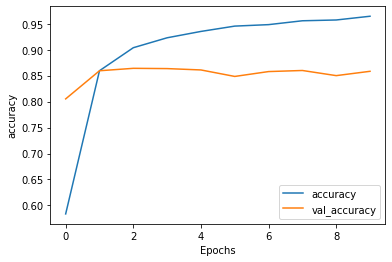

In [20]:
plot_graphs(history, 'accuracy')

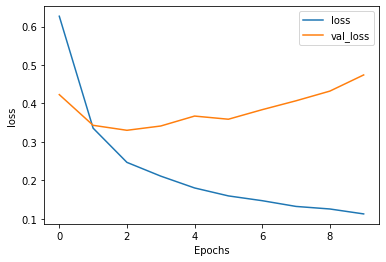

In [21]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 0s - loss: 0.6932 - accuracy: 0.5156

  2/391 [..............................] - ETA: 32s - loss: 0.6933 - accuracy: 0.5000

  3/391 [..............................] - ETA: 41s - loss: 0.6929 - accuracy: 0.5000

  4/391 [..............................] - ETA: 47s - loss: 0.6930 - accuracy: 0.5000

  5/391 [..............................] - ETA: 53s - loss: 0.6932 - accuracy: 0.5000

  6/391 [..............................] - ETA: 57s - loss: 0.6931 - accuracy: 0.4974

  7/391 [..............................] - ETA: 58s - loss: 0.6929 - accuracy: 0.4821

  8/391 [..............................] - ETA: 1:00 - loss: 0.6929 - accuracy: 0.4941

  9/391 [..............................] - ETA: 1:02 - loss: 0.6926 - accuracy: 0.4792

 10/391 [..............................] - ETA: 1:02 - loss: 0.6926 - accuracy: 0.4797

 11/391 [..............................] - ETA: 1:02 - loss: 0.6927 - accuracy: 0.4858

 12/391 [..............................] - ETA: 1:04 - loss: 0.6929 - accuracy: 0.4909

 13/391 [..............................] - ETA: 1:03 - loss: 0.6929 - accuracy: 0.4880

 14/391 [>.............................] - ETA: 1:03 - loss: 0.6926 - accuracy: 0.4821

 15/391 [>.............................] - ETA: 1:04 - loss: 0.6927 - accuracy: 0.4823

 16/391 [>.............................] - ETA: 1:04 - loss: 0.6926 - accuracy: 0.4844

 17/391 [>.............................] - ETA: 1:04 - loss: 0.6926 - accuracy: 0.4844

 18/391 [>.............................] - ETA: 1:03 - loss: 0.6927 - accuracy: 0.4835

 19/391 [>.............................] - ETA: 1:04 - loss: 0.6926 - accuracy: 0.4852

 20/391 [>.............................] - ETA: 1:04 - loss: 0.6928 - accuracy: 0.4898

 21/391 [>.............................] - ETA: 1:04 - loss: 0.6929 - accuracy: 0.4903

 22/391 [>.............................] - ETA: 1:03 - loss: 0.6928 - accuracy: 0.4858

 23/391 [>.............................] - ETA: 1:02 - loss: 0.6929 - accuracy: 0.4871

 24/391 [>.............................] - ETA: 1:02 - loss: 0.6929 - accuracy: 0.4889

 25/391 [>.............................] - ETA: 1:03 - loss: 0.6929 - accuracy: 0.4869

 26/391 [>.............................] - ETA: 1:03 - loss: 0.6929 - accuracy: 0.4874

 27/391 [=>............................] - ETA: 1:03 - loss: 0.6930 - accuracy: 0.4896

 28/391 [=>............................] - ETA: 1:02 - loss: 0.6930 - accuracy: 0.4894

 29/391 [=>............................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.4908

 30/391 [=>............................] - ETA: 1:02 - loss: 0.6932 - accuracy: 0.4927

 31/391 [=>............................] - ETA: 1:02 - loss: 0.6932 - accuracy: 0.4955

 32/391 [=>............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4937

 33/391 [=>............................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.4962

 34/391 [=>............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4936

 35/391 [=>............................] - ETA: 1:02 - loss: 0.6933 - accuracy: 0.4946

 36/391 [=>............................] - ETA: 1:02 - loss: 0.6932 - accuracy: 0.4948

 37/391 [=>............................] - ETA: 1:02 - loss: 0.6933 - accuracy: 0.4941

 38/391 [=>............................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4922

 39/391 [=>............................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.4924

 40/391 [==>...........................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4922

 41/391 [==>...........................] - ETA: 1:02 - loss: 0.6932 - accuracy: 0.4935

 42/391 [==>...........................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4955

 43/391 [==>...........................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4956

 44/391 [==>...........................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4968

 45/391 [==>...........................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4951

 46/391 [==>...........................] - ETA: 1:00 - loss: 0.6932 - accuracy: 0.4939

 47/391 [==>...........................] - ETA: 1:00 - loss: 0.6932 - accuracy: 0.4960

 48/391 [==>...........................] - ETA: 1:00 - loss: 0.6932 - accuracy: 0.4967

 49/391 [==>...........................] - ETA: 1:00 - loss: 0.6932 - accuracy: 0.4990

 50/391 [==>...........................] - ETA: 1:00 - loss: 0.6932 - accuracy: 0.5006

 51/391 [==>...........................] - ETA: 59s - loss: 0.6932 - accuracy: 0.4979 

 52/391 [==>...........................] - ETA: 59s - loss: 0.6932 - accuracy: 0.4979

 53/391 [===>..........................] - ETA: 59s - loss: 0.6932 - accuracy: 0.4973

 54/391 [===>..........................] - ETA: 58s - loss: 0.6932 - accuracy: 0.4974

 55/391 [===>..........................] - ETA: 58s - loss: 0.6932 - accuracy: 0.4960

 56/391 [===>..........................] - ETA: 58s - loss: 0.6932 - accuracy: 0.4972

 57/391 [===>..........................] - ETA: 58s - loss: 0.6932 - accuracy: 0.4970

 58/391 [===>..........................] - ETA: 58s - loss: 0.6932 - accuracy: 0.4965

 59/391 [===>..........................] - ETA: 57s - loss: 0.6932 - accuracy: 0.4963

 60/391 [===>..........................] - ETA: 57s - loss: 0.6932 - accuracy: 0.4953

 61/391 [===>..........................] - ETA: 57s - loss: 0.6932 - accuracy: 0.4949

 62/391 [===>..........................] - ETA: 57s - loss: 0.6931 - accuracy: 0.4942

 63/391 [===>..........................] - ETA: 57s - loss: 0.6931 - accuracy: 0.4940

 64/391 [===>..........................] - ETA: 57s - loss: 0.6931 - accuracy: 0.4929

 65/391 [===>..........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.4909

 66/391 [====>.........................] - ETA: 56s - loss: 0.6930 - accuracy: 0.4915

 67/391 [====>.........................] - ETA: 56s - loss: 0.6930 - accuracy: 0.4916

 68/391 [====>.........................] - ETA: 56s - loss: 0.6930 - accuracy: 0.4899

 69/391 [====>.........................] - ETA: 56s - loss: 0.6930 - accuracy: 0.4898

 70/391 [====>.........................] - ETA: 55s - loss: 0.6930 - accuracy: 0.4893

 71/391 [====>.........................] - ETA: 55s - loss: 0.6930 - accuracy: 0.4894

 72/391 [====>.........................] - ETA: 55s - loss: 0.6930 - accuracy: 0.4889

 73/391 [====>.........................] - ETA: 55s - loss: 0.6930 - accuracy: 0.4897

 74/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4911

 75/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4915

 76/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4901

 77/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4890

 78/391 [====>.........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4892

 79/391 [=====>........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4901

 80/391 [=====>........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4896

 81/391 [=====>........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.4904

 82/391 [=====>........................] - ETA: 54s - loss: 0.6932 - accuracy: 0.4914

 83/391 [=====>........................] - ETA: 54s - loss: 0.6932 - accuracy: 0.4919

 84/391 [=====>........................] - ETA: 53s - loss: 0.6932 - accuracy: 0.4927

 85/391 [=====>........................] - ETA: 53s - loss: 0.6933 - accuracy: 0.4943

 86/391 [=====>........................] - ETA: 53s - loss: 0.6933 - accuracy: 0.4944

 87/391 [=====>........................] - ETA: 53s - loss: 0.6932 - accuracy: 0.4935

 88/391 [=====>........................] - ETA: 53s - loss: 0.6932 - accuracy: 0.4929

 89/391 [=====>........................] - ETA: 52s - loss: 0.6932 - accuracy: 0.4916

 90/391 [=====>........................] - ETA: 52s - loss: 0.6932 - accuracy: 0.4917

 91/391 [=====>........................] - ETA: 52s - loss: 0.6932 - accuracy: 0.4930

 92/391 [======>.......................] - ETA: 52s - loss: 0.6932 - accuracy: 0.4932

 93/391 [======>.......................] - ETA: 52s - loss: 0.6932 - accuracy: 0.4934

 94/391 [======>.......................] - ETA: 52s - loss: 0.6932 - accuracy: 0.4937

 95/391 [======>.......................] - ETA: 51s - loss: 0.6932 - accuracy: 0.4938

 96/391 [======>.......................] - ETA: 51s - loss: 0.6932 - accuracy: 0.4930

 97/391 [======>.......................] - ETA: 51s - loss: 0.6932 - accuracy: 0.4929

 98/391 [======>.......................] - ETA: 51s - loss: 0.6932 - accuracy: 0.4944

 99/391 [======>.......................] - ETA: 51s - loss: 0.6932 - accuracy: 0.4953

100/391 [======>.......................] - ETA: 50s - loss: 0.6932 - accuracy: 0.4953

101/391 [======>.......................] - ETA: 50s - loss: 0.6932 - accuracy: 0.4955

102/391 [======>.......................] - ETA: 50s - loss: 0.6933 - accuracy: 0.4960

103/391 [======>.......................] - ETA: 51s - loss: 0.6933 - accuracy: 0.4959

104/391 [======>.......................] - ETA: 51s - loss: 0.6933 - accuracy: 0.4959

105/391 [=======>......................] - ETA: 51s - loss: 0.6933 - accuracy: 0.4966

106/391 [=======>......................] - ETA: 50s - loss: 0.6933 - accuracy: 0.4968

107/391 [=======>......................] - ETA: 50s - loss: 0.6933 - accuracy: 0.4963

108/391 [=======>......................] - ETA: 50s - loss: 0.6933 - accuracy: 0.4962

109/391 [=======>......................] - ETA: 50s - loss: 0.6933 - accuracy: 0.4974

110/391 [=======>......................] - ETA: 50s - loss: 0.6933 - accuracy: 0.4980

111/391 [=======>......................] - ETA: 49s - loss: 0.6933 - accuracy: 0.4992

112/391 [=======>......................] - ETA: 49s - loss: 0.6933 - accuracy: 0.4992

113/391 [=======>......................] - ETA: 49s - loss: 0.6933 - accuracy: 0.4986

114/391 [=======>......................] - ETA: 49s - loss: 0.6933 - accuracy: 0.4989

115/391 [=======>......................] - ETA: 49s - loss: 0.6933 - accuracy: 0.4986

116/391 [=======>......................] - ETA: 49s - loss: 0.6933 - accuracy: 0.4978

117/391 [=======>......................] - ETA: 48s - loss: 0.6933 - accuracy: 0.4972

118/391 [========>.....................] - ETA: 48s - loss: 0.6933 - accuracy: 0.4979

119/391 [========>.....................] - ETA: 48s - loss: 0.6933 - accuracy: 0.4970

120/391 [========>.....................] - ETA: 48s - loss: 0.6933 - accuracy: 0.4965

121/391 [========>.....................] - ETA: 48s - loss: 0.6933 - accuracy: 0.4966

122/391 [========>.....................] - ETA: 48s - loss: 0.6933 - accuracy: 0.4969

123/391 [========>.....................] - ETA: 47s - loss: 0.6933 - accuracy: 0.4971

124/391 [========>.....................] - ETA: 47s - loss: 0.6933 - accuracy: 0.4975

125/391 [========>.....................] - ETA: 47s - loss: 0.6933 - accuracy: 0.4974

126/391 [========>.....................] - ETA: 47s - loss: 0.6933 - accuracy: 0.4983

127/391 [========>.....................] - ETA: 47s - loss: 0.6933 - accuracy: 0.4984

128/391 [========>.....................] - ETA: 47s - loss: 0.6933 - accuracy: 0.4987

129/391 [========>.....................] - ETA: 46s - loss: 0.6932 - accuracy: 0.4989

130/391 [========>.....................] - ETA: 47s - loss: 0.6932 - accuracy: 0.4995

131/391 [=========>....................] - ETA: 46s - loss: 0.6933 - accuracy: 0.4989

132/391 [=========>....................] - ETA: 46s - loss: 0.6932 - accuracy: 0.4980

133/391 [=========>....................] - ETA: 46s - loss: 0.6932 - accuracy: 0.4982

134/391 [=========>....................] - ETA: 46s - loss: 0.6932 - accuracy: 0.4986

135/391 [=========>....................] - ETA: 46s - loss: 0.6932 - accuracy: 0.4984

136/391 [=========>....................] - ETA: 46s - loss: 0.6932 - accuracy: 0.4978

137/391 [=========>....................] - ETA: 45s - loss: 0.6932 - accuracy: 0.4976

138/391 [=========>....................] - ETA: 45s - loss: 0.6932 - accuracy: 0.4977

139/391 [=========>....................] - ETA: 45s - loss: 0.6932 - accuracy: 0.4985

140/391 [=========>....................] - ETA: 45s - loss: 0.6932 - accuracy: 0.4992

141/391 [=========>....................] - ETA: 45s - loss: 0.6932 - accuracy: 0.4987

142/391 [=========>....................] - ETA: 45s - loss: 0.6932 - accuracy: 0.4988

143/391 [=========>....................] - ETA: 44s - loss: 0.6932 - accuracy: 0.4986

144/391 [==========>...................] - ETA: 44s - loss: 0.6932 - accuracy: 0.4983

145/391 [==========>...................] - ETA: 44s - loss: 0.6932 - accuracy: 0.4988

146/391 [==========>...................] - ETA: 44s - loss: 0.6932 - accuracy: 0.4994

147/391 [==========>...................] - ETA: 44s - loss: 0.6932 - accuracy: 0.4989

148/391 [==========>...................] - ETA: 43s - loss: 0.6932 - accuracy: 0.4982

149/391 [==========>...................] - ETA: 43s - loss: 0.6932 - accuracy: 0.4978

150/391 [==========>...................] - ETA: 43s - loss: 0.6932 - accuracy: 0.4978

151/391 [==========>...................] - ETA: 43s - loss: 0.6932 - accuracy: 0.4980

152/391 [==========>...................] - ETA: 43s - loss: 0.6932 - accuracy: 0.4987

153/391 [==========>...................] - ETA: 42s - loss: 0.6932 - accuracy: 0.4990

154/391 [==========>...................] - ETA: 42s - loss: 0.6932 - accuracy: 0.4990

155/391 [==========>...................] - ETA: 42s - loss: 0.6932 - accuracy: 0.4986

156/391 [==========>...................] - ETA: 42s - loss: 0.6932 - accuracy: 0.4989

157/391 [===========>..................] - ETA: 42s - loss: 0.6932 - accuracy: 0.4997

158/391 [===========>..................] - ETA: 42s - loss: 0.6932 - accuracy: 0.5001

159/391 [===========>..................] - ETA: 41s - loss: 0.6932 - accuracy: 0.4999

160/391 [===========>..................] - ETA: 41s - loss: 0.6932 - accuracy: 0.4994

161/391 [===========>..................] - ETA: 41s - loss: 0.6932 - accuracy: 0.4990

162/391 [===========>..................] - ETA: 41s - loss: 0.6932 - accuracy: 0.4987

163/391 [===========>..................] - ETA: 41s - loss: 0.6932 - accuracy: 0.4978

164/391 [===========>..................] - ETA: 40s - loss: 0.6932 - accuracy: 0.4976

165/391 [===========>..................] - ETA: 40s - loss: 0.6932 - accuracy: 0.4978

166/391 [===========>..................] - ETA: 40s - loss: 0.6932 - accuracy: 0.4984

167/391 [===========>..................] - ETA: 40s - loss: 0.6931 - accuracy: 0.4987

168/391 [===========>..................] - ETA: 40s - loss: 0.6931 - accuracy: 0.4984

169/391 [===========>..................] - ETA: 40s - loss: 0.6931 - accuracy: 0.4988

170/391 [============>.................] - ETA: 39s - loss: 0.6931 - accuracy: 0.4986

171/391 [============>.................] - ETA: 39s - loss: 0.6931 - accuracy: 0.4991

172/391 [============>.................] - ETA: 39s - loss: 0.6931 - accuracy: 0.4992

173/391 [============>.................] - ETA: 39s - loss: 0.6931 - accuracy: 0.4992

174/391 [============>.................] - ETA: 39s - loss: 0.6931 - accuracy: 0.4988

175/391 [============>.................] - ETA: 39s - loss: 0.6931 - accuracy: 0.4988

176/391 [============>.................] - ETA: 38s - loss: 0.6931 - accuracy: 0.4991

177/391 [============>.................] - ETA: 38s - loss: 0.6931 - accuracy: 0.4989

178/391 [============>.................] - ETA: 38s - loss: 0.6931 - accuracy: 0.4983

179/391 [============>.................] - ETA: 38s - loss: 0.6931 - accuracy: 0.4988

180/391 [============>.................] - ETA: 38s - loss: 0.6931 - accuracy: 0.4992

181/391 [============>.................] - ETA: 38s - loss: 0.6931 - accuracy: 0.4987

182/391 [============>.................] - ETA: 37s - loss: 0.6931 - accuracy: 0.4991

183/391 [=============>................] - ETA: 37s - loss: 0.6931 - accuracy: 0.4989

184/391 [=============>................] - ETA: 37s - loss: 0.6931 - accuracy: 0.4986

185/391 [=============>................] - ETA: 37s - loss: 0.6931 - accuracy: 0.4992

186/391 [=============>................] - ETA: 37s - loss: 0.6931 - accuracy: 0.4988

187/391 [=============>................] - ETA: 36s - loss: 0.6931 - accuracy: 0.4982

188/391 [=============>................] - ETA: 36s - loss: 0.6931 - accuracy: 0.4979

189/391 [=============>................] - ETA: 36s - loss: 0.6931 - accuracy: 0.4974

190/391 [=============>................] - ETA: 36s - loss: 0.6931 - accuracy: 0.4975

191/391 [=============>................] - ETA: 36s - loss: 0.6930 - accuracy: 0.4981

192/391 [=============>................] - ETA: 36s - loss: 0.6930 - accuracy: 0.4982

193/391 [=============>................] - ETA: 35s - loss: 0.6930 - accuracy: 0.4981

194/391 [=============>................] - ETA: 35s - loss: 0.6930 - accuracy: 0.4978

195/391 [=============>................] - ETA: 35s - loss: 0.6930 - accuracy: 0.4984

196/391 [==============>...............] - ETA: 35s - loss: 0.6930 - accuracy: 0.4985

197/391 [==============>...............] - ETA: 35s - loss: 0.6930 - accuracy: 0.4983

198/391 [==============>...............] - ETA: 34s - loss: 0.6930 - accuracy: 0.4984

199/391 [==============>...............] - ETA: 34s - loss: 0.6930 - accuracy: 0.4980

200/391 [==============>...............] - ETA: 34s - loss: 0.6930 - accuracy: 0.4980

201/391 [==============>...............] - ETA: 34s - loss: 0.6930 - accuracy: 0.4977

202/391 [==============>...............] - ETA: 34s - loss: 0.6930 - accuracy: 0.4975

203/391 [==============>...............] - ETA: 33s - loss: 0.6930 - accuracy: 0.4976

204/391 [==============>...............] - ETA: 33s - loss: 0.6930 - accuracy: 0.4982

205/391 [==============>...............] - ETA: 33s - loss: 0.6930 - accuracy: 0.4982

206/391 [==============>...............] - ETA: 33s - loss: 0.6930 - accuracy: 0.4987

207/391 [==============>...............] - ETA: 33s - loss: 0.6930 - accuracy: 0.4992

208/391 [==============>...............] - ETA: 33s - loss: 0.6930 - accuracy: 0.4993

209/391 [===============>..............] - ETA: 32s - loss: 0.6930 - accuracy: 0.4990

210/391 [===============>..............] - ETA: 32s - loss: 0.6930 - accuracy: 0.4990

211/391 [===============>..............] - ETA: 32s - loss: 0.6930 - accuracy: 0.4984

212/391 [===============>..............] - ETA: 32s - loss: 0.6929 - accuracy: 0.4987

213/391 [===============>..............] - ETA: 32s - loss: 0.6929 - accuracy: 0.4986

214/391 [===============>..............] - ETA: 31s - loss: 0.6930 - accuracy: 0.4993

215/391 [===============>..............] - ETA: 31s - loss: 0.6929 - accuracy: 0.4987

216/391 [===============>..............] - ETA: 31s - loss: 0.6929 - accuracy: 0.4985

217/391 [===============>..............] - ETA: 31s - loss: 0.6929 - accuracy: 0.4988

218/391 [===============>..............] - ETA: 31s - loss: 0.6929 - accuracy: 0.4990

219/391 [===============>..............] - ETA: 30s - loss: 0.6929 - accuracy: 0.4992

220/391 [===============>..............] - ETA: 30s - loss: 0.6929 - accuracy: 0.4991

221/391 [===============>..............] - ETA: 30s - loss: 0.6929 - accuracy: 0.4994

222/391 [================>.............] - ETA: 30s - loss: 0.6929 - accuracy: 0.4996

223/391 [================>.............] - ETA: 30s - loss: 0.6929 - accuracy: 0.4998

224/391 [================>.............] - ETA: 30s - loss: 0.6929 - accuracy: 0.4997

225/391 [================>.............] - ETA: 29s - loss: 0.6929 - accuracy: 0.4996

226/391 [================>.............] - ETA: 29s - loss: 0.6929 - accuracy: 0.4991

227/391 [================>.............] - ETA: 29s - loss: 0.6929 - accuracy: 0.4996

228/391 [================>.............] - ETA: 29s - loss: 0.6929 - accuracy: 0.5001

229/391 [================>.............] - ETA: 29s - loss: 0.6929 - accuracy: 0.5001

230/391 [================>.............] - ETA: 28s - loss: 0.6928 - accuracy: 0.4997

231/391 [================>.............] - ETA: 28s - loss: 0.6928 - accuracy: 0.4997

232/391 [================>.............] - ETA: 28s - loss: 0.6928 - accuracy: 0.4998

233/391 [================>.............] - ETA: 28s - loss: 0.6928 - accuracy: 0.4999

234/391 [================>.............] - ETA: 28s - loss: 0.6928 - accuracy: 0.5002

235/391 [=================>............] - ETA: 28s - loss: 0.6928 - accuracy: 0.4999

236/391 [=================>............] - ETA: 27s - loss: 0.6928 - accuracy: 0.4997

237/391 [=================>............] - ETA: 27s - loss: 0.6928 - accuracy: 0.4998

238/391 [=================>............] - ETA: 27s - loss: 0.6928 - accuracy: 0.5003

239/391 [=================>............] - ETA: 27s - loss: 0.6928 - accuracy: 0.5001

240/391 [=================>............] - ETA: 27s - loss: 0.6928 - accuracy: 0.5002

241/391 [=================>............] - ETA: 27s - loss: 0.6928 - accuracy: 0.5005

242/391 [=================>............] - ETA: 26s - loss: 0.6927 - accuracy: 0.5010

243/391 [=================>............] - ETA: 26s - loss: 0.6927 - accuracy: 0.5012

244/391 [=================>............] - ETA: 26s - loss: 0.6927 - accuracy: 0.5010

245/391 [=================>............] - ETA: 26s - loss: 0.6927 - accuracy: 0.5010

246/391 [=================>............] - ETA: 26s - loss: 0.6927 - accuracy: 0.5007

247/391 [=================>............] - ETA: 25s - loss: 0.6927 - accuracy: 0.5011

248/391 [==================>...........] - ETA: 25s - loss: 0.6927 - accuracy: 0.5009

249/391 [==================>...........] - ETA: 25s - loss: 0.6927 - accuracy: 0.5009

250/391 [==================>...........] - ETA: 25s - loss: 0.6927 - accuracy: 0.5007

251/391 [==================>...........] - ETA: 25s - loss: 0.6926 - accuracy: 0.5009

252/391 [==================>...........] - ETA: 25s - loss: 0.6926 - accuracy: 0.5010

253/391 [==================>...........] - ETA: 24s - loss: 0.6926 - accuracy: 0.5009

254/391 [==================>...........] - ETA: 24s - loss: 0.6926 - accuracy: 0.5006

255/391 [==================>...........] - ETA: 24s - loss: 0.6926 - accuracy: 0.5004

256/391 [==================>...........] - ETA: 24s - loss: 0.6926 - accuracy: 0.5001

257/391 [==================>...........] - ETA: 24s - loss: 0.6926 - accuracy: 0.5007

258/391 [==================>...........] - ETA: 23s - loss: 0.6926 - accuracy: 0.5007

259/391 [==================>...........] - ETA: 23s - loss: 0.6925 - accuracy: 0.5007

260/391 [==================>...........] - ETA: 23s - loss: 0.6925 - accuracy: 0.5004

261/391 [===================>..........] - ETA: 23s - loss: 0.6925 - accuracy: 0.5006

262/391 [===================>..........] - ETA: 23s - loss: 0.6925 - accuracy: 0.5006

263/391 [===================>..........] - ETA: 23s - loss: 0.6924 - accuracy: 0.5006

264/391 [===================>..........] - ETA: 22s - loss: 0.6924 - accuracy: 0.5006

265/391 [===================>..........] - ETA: 22s - loss: 0.6924 - accuracy: 0.5004

266/391 [===================>..........] - ETA: 22s - loss: 0.6924 - accuracy: 0.5002

267/391 [===================>..........] - ETA: 22s - loss: 0.6924 - accuracy: 0.5000

268/391 [===================>..........] - ETA: 22s - loss: 0.6923 - accuracy: 0.5001

269/391 [===================>..........] - ETA: 21s - loss: 0.6923 - accuracy: 0.5001

270/391 [===================>..........] - ETA: 21s - loss: 0.6923 - accuracy: 0.5001

271/391 [===================>..........] - ETA: 21s - loss: 0.6923 - accuracy: 0.5005

272/391 [===================>..........] - ETA: 21s - loss: 0.6922 - accuracy: 0.5002

273/391 [===================>..........] - ETA: 21s - loss: 0.6922 - accuracy: 0.5003

274/391 [====================>.........] - ETA: 21s - loss: 0.6921 - accuracy: 0.4999

275/391 [====================>.........] - ETA: 20s - loss: 0.6921 - accuracy: 0.4999

276/391 [====================>.........] - ETA: 20s - loss: 0.6921 - accuracy: 0.5000

277/391 [====================>.........] - ETA: 20s - loss: 0.6920 - accuracy: 0.5002

278/391 [====================>.........] - ETA: 20s - loss: 0.6920 - accuracy: 0.5002

279/391 [====================>.........] - ETA: 20s - loss: 0.6920 - accuracy: 0.5000

280/391 [====================>.........] - ETA: 20s - loss: 0.6919 - accuracy: 0.5001

281/391 [====================>.........] - ETA: 19s - loss: 0.6918 - accuracy: 0.4997

282/391 [====================>.........] - ETA: 19s - loss: 0.6918 - accuracy: 0.4996

283/391 [====================>.........] - ETA: 19s - loss: 0.6917 - accuracy: 0.4991

284/391 [====================>.........] - ETA: 19s - loss: 0.6916 - accuracy: 0.4987

285/391 [====================>.........] - ETA: 19s - loss: 0.6916 - accuracy: 0.4988

286/391 [====================>.........] - ETA: 18s - loss: 0.6915 - accuracy: 0.4987

287/391 [=====================>........] - ETA: 18s - loss: 0.6914 - accuracy: 0.4987

288/391 [=====================>........] - ETA: 18s - loss: 0.6913 - accuracy: 0.4988

289/391 [=====================>........] - ETA: 18s - loss: 0.6913 - accuracy: 0.4994

290/391 [=====================>........] - ETA: 18s - loss: 0.6912 - accuracy: 0.4992

291/391 [=====================>........] - ETA: 18s - loss: 0.6910 - accuracy: 0.4997

292/391 [=====================>........] - ETA: 17s - loss: 0.6908 - accuracy: 0.4998

293/391 [=====================>........] - ETA: 17s - loss: 0.6907 - accuracy: 0.4998

294/391 [=====================>........] - ETA: 17s - loss: 0.6904 - accuracy: 0.5001

295/391 [=====================>........] - ETA: 17s - loss: 0.6900 - accuracy: 0.5008

296/391 [=====================>........] - ETA: 17s - loss: 0.6898 - accuracy: 0.5015

297/391 [=====================>........] - ETA: 16s - loss: 0.6894 - accuracy: 0.5018

298/391 [=====================>........] - ETA: 16s - loss: 0.6890 - accuracy: 0.5023

299/391 [=====================>........] - ETA: 16s - loss: 0.6890 - accuracy: 0.5028

300/391 [======================>.......] - ETA: 16s - loss: 0.6887 - accuracy: 0.5031

301/391 [======================>.......] - ETA: 16s - loss: 0.6884 - accuracy: 0.5037

302/391 [======================>.......] - ETA: 16s - loss: 0.6881 - accuracy: 0.5040

303/391 [======================>.......] - ETA: 15s - loss: 0.6878 - accuracy: 0.5044

304/391 [======================>.......] - ETA: 15s - loss: 0.6876 - accuracy: 0.5049

305/391 [======================>.......] - ETA: 15s - loss: 0.6872 - accuracy: 0.5057

306/391 [======================>.......] - ETA: 15s - loss: 0.6868 - accuracy: 0.5063

307/391 [======================>.......] - ETA: 15s - loss: 0.6863 - accuracy: 0.5071

308/391 [======================>.......] - ETA: 14s - loss: 0.6861 - accuracy: 0.5076

309/391 [======================>.......] - ETA: 14s - loss: 0.6855 - accuracy: 0.5084

310/391 [======================>.......] - ETA: 14s - loss: 0.6850 - accuracy: 0.5093

311/391 [======================>.......] - ETA: 14s - loss: 0.6846 - accuracy: 0.5098

312/391 [======================>.......] - ETA: 14s - loss: 0.6841 - accuracy: 0.5107

313/391 [=======================>......] - ETA: 14s - loss: 0.6840 - accuracy: 0.5111

314/391 [=======================>......] - ETA: 13s - loss: 0.6836 - accuracy: 0.5115

315/391 [=======================>......] - ETA: 13s - loss: 0.6830 - accuracy: 0.5122

316/391 [=======================>......] - ETA: 13s - loss: 0.6825 - accuracy: 0.5132

317/391 [=======================>......] - ETA: 13s - loss: 0.6823 - accuracy: 0.5138

318/391 [=======================>......] - ETA: 13s - loss: 0.6821 - accuracy: 0.5143

319/391 [=======================>......] - ETA: 12s - loss: 0.6817 - accuracy: 0.5150

320/391 [=======================>......] - ETA: 12s - loss: 0.6816 - accuracy: 0.5158

321/391 [=======================>......] - ETA: 12s - loss: 0.6812 - accuracy: 0.5165

322/391 [=======================>......] - ETA: 12s - loss: 0.6810 - accuracy: 0.5171

323/391 [=======================>......] - ETA: 12s - loss: 0.6808 - accuracy: 0.5174

324/391 [=======================>......] - ETA: 12s - loss: 0.6804 - accuracy: 0.5181

325/391 [=======================>......] - ETA: 11s - loss: 0.6801 - accuracy: 0.5186

326/391 [========================>.....] - ETA: 11s - loss: 0.6797 - accuracy: 0.5192

327/391 [========================>.....] - ETA: 11s - loss: 0.6794 - accuracy: 0.5196

328/391 [========================>.....] - ETA: 11s - loss: 0.6789 - accuracy: 0.5205

329/391 [========================>.....] - ETA: 11s - loss: 0.6789 - accuracy: 0.5205

330/391 [========================>.....] - ETA: 11s - loss: 0.6786 - accuracy: 0.5209

331/391 [========================>.....] - ETA: 10s - loss: 0.6782 - accuracy: 0.5213

332/391 [========================>.....] - ETA: 10s - loss: 0.6778 - accuracy: 0.5217

333/391 [========================>.....] - ETA: 10s - loss: 0.6774 - accuracy: 0.5223

334/391 [========================>.....] - ETA: 10s - loss: 0.6770 - accuracy: 0.5230

335/391 [========================>.....] - ETA: 10s - loss: 0.6764 - accuracy: 0.5239

336/391 [========================>.....] - ETA: 9s - loss: 0.6758 - accuracy: 0.5248 

337/391 [========================>.....] - ETA: 9s - loss: 0.6753 - accuracy: 0.5256

338/391 [========================>.....] - ETA: 9s - loss: 0.6745 - accuracy: 0.5266

339/391 [=========================>....] - ETA: 9s - loss: 0.6742 - accuracy: 0.5271

340/391 [=========================>....] - ETA: 9s - loss: 0.6737 - accuracy: 0.5277

341/391 [=========================>....] - ETA: 9s - loss: 0.6730 - accuracy: 0.5285

342/391 [=========================>....] - ETA: 8s - loss: 0.6725 - accuracy: 0.5293

343/391 [=========================>....] - ETA: 8s - loss: 0.6719 - accuracy: 0.5302

344/391 [=========================>....] - ETA: 8s - loss: 0.6715 - accuracy: 0.5307

345/391 [=========================>....] - ETA: 8s - loss: 0.6709 - accuracy: 0.5315

346/391 [=========================>....] - ETA: 8s - loss: 0.6701 - accuracy: 0.5323

347/391 [=========================>....] - ETA: 7s - loss: 0.6697 - accuracy: 0.5329

348/391 [=========================>....] - ETA: 7s - loss: 0.6692 - accuracy: 0.5337

349/391 [=========================>....] - ETA: 7s - loss: 0.6690 - accuracy: 0.5342

350/391 [=========================>....] - ETA: 7s - loss: 0.6691 - accuracy: 0.5345

351/391 [=========================>....] - ETA: 7s - loss: 0.6686 - accuracy: 0.5351

352/391 [==========================>...] - ETA: 7s - loss: 0.6680 - accuracy: 0.5358

353/391 [==========================>...] - ETA: 6s - loss: 0.6678 - accuracy: 0.5363

354/391 [==========================>...] - ETA: 6s - loss: 0.6671 - accuracy: 0.5371

355/391 [==========================>...] - ETA: 6s - loss: 0.6669 - accuracy: 0.5377

356/391 [==========================>...] - ETA: 6s - loss: 0.6663 - accuracy: 0.5385

357/391 [==========================>...] - ETA: 6s - loss: 0.6655 - accuracy: 0.5395

358/391 [==========================>...] - ETA: 5s - loss: 0.6650 - accuracy: 0.5401

359/391 [==========================>...] - ETA: 5s - loss: 0.6647 - accuracy: 0.5407

360/391 [==========================>...] - ETA: 5s - loss: 0.6644 - accuracy: 0.5412

361/391 [==========================>...] - ETA: 5s - loss: 0.6638 - accuracy: 0.5420

362/391 [==========================>...] - ETA: 5s - loss: 0.6633 - accuracy: 0.5426

363/391 [==========================>...] - ETA: 5s - loss: 0.6627 - accuracy: 0.5434

364/391 [==========================>...] - ETA: 4s - loss: 0.6623 - accuracy: 0.5440

365/391 [===========================>..] - ETA: 4s - loss: 0.6618 - accuracy: 0.5447

366/391 [===========================>..] - ETA: 4s - loss: 0.6616 - accuracy: 0.5452

367/391 [===========================>..] - ETA: 4s - loss: 0.6611 - accuracy: 0.5459

368/391 [===========================>..] - ETA: 4s - loss: 0.6608 - accuracy: 0.5464

369/391 [===========================>..] - ETA: 3s - loss: 0.6604 - accuracy: 0.5470

370/391 [===========================>..] - ETA: 3s - loss: 0.6601 - accuracy: 0.5473

371/391 [===========================>..] - ETA: 3s - loss: 0.6597 - accuracy: 0.5479

372/391 [===========================>..] - ETA: 3s - loss: 0.6593 - accuracy: 0.5484

373/391 [===========================>..] - ETA: 3s - loss: 0.6588 - accuracy: 0.5492

374/391 [===========================>..] - ETA: 3s - loss: 0.6583 - accuracy: 0.5498

375/391 [===========================>..] - ETA: 2s - loss: 0.6581 - accuracy: 0.5502

376/391 [===========================>..] - ETA: 2s - loss: 0.6576 - accuracy: 0.5507

377/391 [===========================>..] - ETA: 2s - loss: 0.6571 - accuracy: 0.5515

378/391 [============================>.] - ETA: 2s - loss: 0.6568 - accuracy: 0.5520

379/391 [============================>.] - ETA: 2s - loss: 0.6560 - accuracy: 0.5527

380/391 [============================>.] - ETA: 1s - loss: 0.6553 - accuracy: 0.5535

381/391 [============================>.] - ETA: 1s - loss: 0.6546 - accuracy: 0.5543

382/391 [============================>.] - ETA: 1s - loss: 0.6541 - accuracy: 0.5551

383/391 [============================>.] - ETA: 1s - loss: 0.6534 - accuracy: 0.5559

384/391 [============================>.] - ETA: 1s - loss: 0.6527 - accuracy: 0.5565

385/391 [============================>.] - ETA: 1s - loss: 0.6529 - accuracy: 0.5566

386/391 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 0.5571

387/391 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.5576

388/391 [============================>.] - ETA: 0s - loss: 0.6512 - accuracy: 0.5582

389/391 [============================>.] - ETA: 0s - loss: 0.6506 - accuracy: 0.5588

390/391 [============================>.] - ETA: 0s - loss: 0.6503 - accuracy: 0.5593

391/391 [==============================] - ETA: 0s - loss: 0.6500 - accuracy: 0.5598

391/391 [==============================] - 74s 190ms/step - loss: 0.6500 - accuracy: 0.5598 - val_loss: 0.5153 - val_accuracy: 0.7797


Epoch 2/10


  1/391 [..............................] - ETA: 0s - loss: 0.4687 - accuracy: 0.8281

  2/391 [..............................] - ETA: 34s - loss: 0.4607 - accuracy: 0.8438

  3/391 [..............................] - ETA: 45s - loss: 0.4539 - accuracy: 0.8490

  4/391 [..............................] - ETA: 47s - loss: 0.4706 - accuracy: 0.8438

  5/391 [..............................] - ETA: 54s - loss: 0.4735 - accuracy: 0.8219

  6/391 [..............................] - ETA: 57s - loss: 0.4993 - accuracy: 0.7943

  7/391 [..............................] - ETA: 58s - loss: 0.5023 - accuracy: 0.7879

  8/391 [..............................] - ETA: 1:00 - loss: 0.5013 - accuracy: 0.7852

  9/391 [..............................] - ETA: 1:01 - loss: 0.4973 - accuracy: 0.7847

 10/391 [..............................] - ETA: 1:00 - loss: 0.4952 - accuracy: 0.7812

 11/391 [..............................] - ETA: 1:02 - loss: 0.4934 - accuracy: 0.7798

 12/391 [..............................] - ETA: 1:03 - loss: 0.4864 - accuracy: 0.7812

 13/391 [..............................] - ETA: 1:02 - loss: 0.4863 - accuracy: 0.7764

 14/391 [>.............................] - ETA: 1:03 - loss: 0.4812 - accuracy: 0.7746

 15/391 [>.............................] - ETA: 1:03 - loss: 0.4851 - accuracy: 0.7698

 16/391 [>.............................] - ETA: 1:04 - loss: 0.4856 - accuracy: 0.7656

 17/391 [>.............................] - ETA: 1:04 - loss: 0.4844 - accuracy: 0.7684

 18/391 [>.............................] - ETA: 1:03 - loss: 0.4825 - accuracy: 0.7674

 19/391 [>.............................] - ETA: 1:02 - loss: 0.4802 - accuracy: 0.7689

 20/391 [>.............................] - ETA: 1:02 - loss: 0.4767 - accuracy: 0.7734

 21/391 [>.............................] - ETA: 1:02 - loss: 0.4767 - accuracy: 0.7760

 22/391 [>.............................] - ETA: 1:02 - loss: 0.4805 - accuracy: 0.7749

 23/391 [>.............................] - ETA: 1:02 - loss: 0.4783 - accuracy: 0.7765

 24/391 [>.............................] - ETA: 1:02 - loss: 0.4754 - accuracy: 0.7806

 25/391 [>.............................] - ETA: 1:03 - loss: 0.4785 - accuracy: 0.7788

 26/391 [>.............................] - ETA: 1:02 - loss: 0.4772 - accuracy: 0.7819

 27/391 [=>............................] - ETA: 1:02 - loss: 0.4739 - accuracy: 0.7865

 28/391 [=>............................] - ETA: 1:02 - loss: 0.4703 - accuracy: 0.7885

 29/391 [=>............................] - ETA: 1:02 - loss: 0.4670 - accuracy: 0.7888

 30/391 [=>............................] - ETA: 1:02 - loss: 0.4656 - accuracy: 0.7896

 31/391 [=>............................] - ETA: 1:02 - loss: 0.4666 - accuracy: 0.7888

 32/391 [=>............................] - ETA: 1:02 - loss: 0.4639 - accuracy: 0.7896

 33/391 [=>............................] - ETA: 1:02 - loss: 0.4669 - accuracy: 0.7855

 34/391 [=>............................] - ETA: 1:02 - loss: 0.4667 - accuracy: 0.7854

 35/391 [=>............................] - ETA: 1:02 - loss: 0.4638 - accuracy: 0.7875

 36/391 [=>............................] - ETA: 1:01 - loss: 0.4646 - accuracy: 0.7882

 37/391 [=>............................] - ETA: 1:01 - loss: 0.4615 - accuracy: 0.7910

 38/391 [=>............................] - ETA: 1:01 - loss: 0.4570 - accuracy: 0.7940

 39/391 [=>............................] - ETA: 1:01 - loss: 0.4553 - accuracy: 0.7957

 40/391 [==>...........................] - ETA: 1:01 - loss: 0.4535 - accuracy: 0.7965

 41/391 [==>...........................] - ETA: 1:00 - loss: 0.4521 - accuracy: 0.7976

 42/391 [==>...........................] - ETA: 1:00 - loss: 0.4497 - accuracy: 0.7999

 43/391 [==>...........................] - ETA: 1:00 - loss: 0.4483 - accuracy: 0.8009

 44/391 [==>...........................] - ETA: 59s - loss: 0.4456 - accuracy: 0.8029 

 45/391 [==>...........................] - ETA: 59s - loss: 0.4455 - accuracy: 0.8038

 46/391 [==>...........................] - ETA: 59s - loss: 0.4444 - accuracy: 0.8047

 47/391 [==>...........................] - ETA: 58s - loss: 0.4460 - accuracy: 0.8042

 48/391 [==>...........................] - ETA: 59s - loss: 0.4473 - accuracy: 0.8034

 49/391 [==>...........................] - ETA: 58s - loss: 0.4463 - accuracy: 0.8033

 50/391 [==>...........................] - ETA: 58s - loss: 0.4462 - accuracy: 0.8028

 51/391 [==>...........................] - ETA: 57s - loss: 0.4451 - accuracy: 0.8030

 52/391 [==>...........................] - ETA: 57s - loss: 0.4451 - accuracy: 0.8041

 53/391 [===>..........................] - ETA: 58s - loss: 0.4446 - accuracy: 0.8031

 54/391 [===>..........................] - ETA: 58s - loss: 0.4451 - accuracy: 0.8021

 55/391 [===>..........................] - ETA: 57s - loss: 0.4432 - accuracy: 0.8034

 56/391 [===>..........................] - ETA: 57s - loss: 0.4413 - accuracy: 0.8047

 57/391 [===>..........................] - ETA: 57s - loss: 0.4407 - accuracy: 0.8059

 58/391 [===>..........................] - ETA: 56s - loss: 0.4397 - accuracy: 0.8071

 59/391 [===>..........................] - ETA: 56s - loss: 0.4399 - accuracy: 0.8075

 60/391 [===>..........................] - ETA: 56s - loss: 0.4386 - accuracy: 0.8078

 61/391 [===>..........................] - ETA: 55s - loss: 0.4376 - accuracy: 0.8084

 62/391 [===>..........................] - ETA: 55s - loss: 0.4366 - accuracy: 0.8085

 63/391 [===>..........................] - ETA: 55s - loss: 0.4367 - accuracy: 0.8080

 64/391 [===>..........................] - ETA: 55s - loss: 0.4356 - accuracy: 0.8088

 65/391 [===>..........................] - ETA: 55s - loss: 0.4352 - accuracy: 0.8099

 66/391 [====>.........................] - ETA: 55s - loss: 0.4356 - accuracy: 0.8106

 67/391 [====>.........................] - ETA: 55s - loss: 0.4353 - accuracy: 0.8106

 68/391 [====>.........................] - ETA: 55s - loss: 0.4335 - accuracy: 0.8114

 69/391 [====>.........................] - ETA: 55s - loss: 0.4340 - accuracy: 0.8107

 70/391 [====>.........................] - ETA: 55s - loss: 0.4321 - accuracy: 0.8121

 71/391 [====>.........................] - ETA: 55s - loss: 0.4332 - accuracy: 0.8116

 72/391 [====>.........................] - ETA: 54s - loss: 0.4326 - accuracy: 0.8116

 73/391 [====>.........................] - ETA: 54s - loss: 0.4310 - accuracy: 0.8121

 74/391 [====>.........................] - ETA: 54s - loss: 0.4295 - accuracy: 0.8129

 75/391 [====>.........................] - ETA: 54s - loss: 0.4307 - accuracy: 0.8127

 76/391 [====>.........................] - ETA: 54s - loss: 0.4312 - accuracy: 0.8121

 77/391 [====>.........................] - ETA: 54s - loss: 0.4306 - accuracy: 0.8121

 78/391 [====>.........................] - ETA: 53s - loss: 0.4288 - accuracy: 0.8131

 79/391 [=====>........................] - ETA: 53s - loss: 0.4273 - accuracy: 0.8141

 80/391 [=====>........................] - ETA: 53s - loss: 0.4268 - accuracy: 0.8143

 81/391 [=====>........................] - ETA: 53s - loss: 0.4256 - accuracy: 0.8142

 82/391 [=====>........................] - ETA: 53s - loss: 0.4256 - accuracy: 0.8138

 83/391 [=====>........................] - ETA: 53s - loss: 0.4251 - accuracy: 0.8144

 84/391 [=====>........................] - ETA: 53s - loss: 0.4244 - accuracy: 0.8145

 85/391 [=====>........................] - ETA: 53s - loss: 0.4251 - accuracy: 0.8140

 86/391 [=====>........................] - ETA: 52s - loss: 0.4242 - accuracy: 0.8140

 87/391 [=====>........................] - ETA: 52s - loss: 0.4241 - accuracy: 0.8139

 88/391 [=====>........................] - ETA: 52s - loss: 0.4222 - accuracy: 0.8150

 89/391 [=====>........................] - ETA: 52s - loss: 0.4226 - accuracy: 0.8150

 90/391 [=====>........................] - ETA: 52s - loss: 0.4225 - accuracy: 0.8148

 91/391 [=====>........................] - ETA: 52s - loss: 0.4213 - accuracy: 0.8158

 92/391 [======>.......................] - ETA: 51s - loss: 0.4219 - accuracy: 0.8161

 93/391 [======>.......................] - ETA: 51s - loss: 0.4224 - accuracy: 0.8160

 94/391 [======>.......................] - ETA: 51s - loss: 0.4210 - accuracy: 0.8167

 95/391 [======>.......................] - ETA: 51s - loss: 0.4205 - accuracy: 0.8169

 96/391 [======>.......................] - ETA: 51s - loss: 0.4187 - accuracy: 0.8180

 97/391 [======>.......................] - ETA: 51s - loss: 0.4189 - accuracy: 0.8181

 98/391 [======>.......................] - ETA: 51s - loss: 0.4185 - accuracy: 0.8184

 99/391 [======>.......................] - ETA: 50s - loss: 0.4170 - accuracy: 0.8193

100/391 [======>.......................] - ETA: 50s - loss: 0.4151 - accuracy: 0.8200

101/391 [======>.......................] - ETA: 50s - loss: 0.4148 - accuracy: 0.8202

102/391 [======>.......................] - ETA: 50s - loss: 0.4143 - accuracy: 0.8205

103/391 [======>.......................] - ETA: 50s - loss: 0.4141 - accuracy: 0.8207

104/391 [======>.......................] - ETA: 50s - loss: 0.4132 - accuracy: 0.8214

105/391 [=======>......................] - ETA: 49s - loss: 0.4132 - accuracy: 0.8214

106/391 [=======>......................] - ETA: 49s - loss: 0.4122 - accuracy: 0.8218

107/391 [=======>......................] - ETA: 49s - loss: 0.4116 - accuracy: 0.8223

108/391 [=======>......................] - ETA: 49s - loss: 0.4105 - accuracy: 0.8229

109/391 [=======>......................] - ETA: 49s - loss: 0.4094 - accuracy: 0.8238

110/391 [=======>......................] - ETA: 49s - loss: 0.4094 - accuracy: 0.8240

111/391 [=======>......................] - ETA: 49s - loss: 0.4101 - accuracy: 0.8242

112/391 [=======>......................] - ETA: 48s - loss: 0.4093 - accuracy: 0.8245

113/391 [=======>......................] - ETA: 48s - loss: 0.4091 - accuracy: 0.8248

114/391 [=======>......................] - ETA: 48s - loss: 0.4079 - accuracy: 0.8254

115/391 [=======>......................] - ETA: 48s - loss: 0.4083 - accuracy: 0.8254

116/391 [=======>......................] - ETA: 48s - loss: 0.4072 - accuracy: 0.8262

117/391 [=======>......................] - ETA: 48s - loss: 0.4074 - accuracy: 0.8260

118/391 [========>.....................] - ETA: 47s - loss: 0.4076 - accuracy: 0.8260

119/391 [========>.....................] - ETA: 47s - loss: 0.4065 - accuracy: 0.8267

120/391 [========>.....................] - ETA: 47s - loss: 0.4066 - accuracy: 0.8267

121/391 [========>.....................] - ETA: 47s - loss: 0.4065 - accuracy: 0.8271

122/391 [========>.....................] - ETA: 47s - loss: 0.4068 - accuracy: 0.8267

123/391 [========>.....................] - ETA: 46s - loss: 0.4069 - accuracy: 0.8267

124/391 [========>.....................] - ETA: 46s - loss: 0.4058 - accuracy: 0.8271

125/391 [========>.....................] - ETA: 46s - loss: 0.4054 - accuracy: 0.8274

126/391 [========>.....................] - ETA: 46s - loss: 0.4041 - accuracy: 0.8281

127/391 [========>.....................] - ETA: 46s - loss: 0.4048 - accuracy: 0.8274

128/391 [========>.....................] - ETA: 46s - loss: 0.4043 - accuracy: 0.8275

129/391 [========>.....................] - ETA: 45s - loss: 0.4039 - accuracy: 0.8275

130/391 [========>.....................] - ETA: 45s - loss: 0.4043 - accuracy: 0.8270

131/391 [=========>....................] - ETA: 45s - loss: 0.4040 - accuracy: 0.8274

132/391 [=========>....................] - ETA: 45s - loss: 0.4046 - accuracy: 0.8274

133/391 [=========>....................] - ETA: 45s - loss: 0.4042 - accuracy: 0.8277

134/391 [=========>....................] - ETA: 45s - loss: 0.4034 - accuracy: 0.8281

135/391 [=========>....................] - ETA: 44s - loss: 0.4036 - accuracy: 0.8282

136/391 [=========>....................] - ETA: 44s - loss: 0.4040 - accuracy: 0.8280

137/391 [=========>....................] - ETA: 44s - loss: 0.4030 - accuracy: 0.8284

138/391 [=========>....................] - ETA: 44s - loss: 0.4030 - accuracy: 0.8282

139/391 [=========>....................] - ETA: 44s - loss: 0.4026 - accuracy: 0.8282

140/391 [=========>....................] - ETA: 44s - loss: 0.4022 - accuracy: 0.8283

141/391 [=========>....................] - ETA: 43s - loss: 0.4015 - accuracy: 0.8287

142/391 [=========>....................] - ETA: 43s - loss: 0.4019 - accuracy: 0.8287

143/391 [=========>....................] - ETA: 43s - loss: 0.4015 - accuracy: 0.8287

144/391 [==========>...................] - ETA: 43s - loss: 0.4013 - accuracy: 0.8289

145/391 [==========>...................] - ETA: 43s - loss: 0.4020 - accuracy: 0.8290

146/391 [==========>...................] - ETA: 42s - loss: 0.4024 - accuracy: 0.8291

147/391 [==========>...................] - ETA: 42s - loss: 0.4019 - accuracy: 0.8293

148/391 [==========>...................] - ETA: 42s - loss: 0.4017 - accuracy: 0.8297

149/391 [==========>...................] - ETA: 42s - loss: 0.4012 - accuracy: 0.8299

150/391 [==========>...................] - ETA: 42s - loss: 0.4023 - accuracy: 0.8297

151/391 [==========>...................] - ETA: 42s - loss: 0.4018 - accuracy: 0.8302

152/391 [==========>...................] - ETA: 42s - loss: 0.4019 - accuracy: 0.8304

153/391 [==========>...................] - ETA: 42s - loss: 0.4021 - accuracy: 0.8301

154/391 [==========>...................] - ETA: 42s - loss: 0.4011 - accuracy: 0.8305

155/391 [==========>...................] - ETA: 41s - loss: 0.4009 - accuracy: 0.8304

156/391 [==========>...................] - ETA: 41s - loss: 0.4006 - accuracy: 0.8307

157/391 [===========>..................] - ETA: 41s - loss: 0.4004 - accuracy: 0.8308

158/391 [===========>..................] - ETA: 41s - loss: 0.4003 - accuracy: 0.8311

159/391 [===========>..................] - ETA: 41s - loss: 0.4003 - accuracy: 0.8313

160/391 [===========>..................] - ETA: 41s - loss: 0.4002 - accuracy: 0.8315

161/391 [===========>..................] - ETA: 40s - loss: 0.3993 - accuracy: 0.8323

162/391 [===========>..................] - ETA: 40s - loss: 0.3997 - accuracy: 0.8322

163/391 [===========>..................] - ETA: 40s - loss: 0.3996 - accuracy: 0.8320

164/391 [===========>..................] - ETA: 40s - loss: 0.3994 - accuracy: 0.8320

165/391 [===========>..................] - ETA: 40s - loss: 0.3993 - accuracy: 0.8322

166/391 [===========>..................] - ETA: 40s - loss: 0.3989 - accuracy: 0.8324

167/391 [===========>..................] - ETA: 39s - loss: 0.3980 - accuracy: 0.8326

168/391 [===========>..................] - ETA: 39s - loss: 0.3978 - accuracy: 0.8328

169/391 [===========>..................] - ETA: 39s - loss: 0.3971 - accuracy: 0.8327

170/391 [============>.................] - ETA: 39s - loss: 0.3969 - accuracy: 0.8324

171/391 [============>.................] - ETA: 39s - loss: 0.3960 - accuracy: 0.8329

172/391 [============>.................] - ETA: 38s - loss: 0.3959 - accuracy: 0.8328

173/391 [============>.................] - ETA: 38s - loss: 0.3955 - accuracy: 0.8330

174/391 [============>.................] - ETA: 38s - loss: 0.3953 - accuracy: 0.8332

175/391 [============>.................] - ETA: 38s - loss: 0.3944 - accuracy: 0.8337

176/391 [============>.................] - ETA: 38s - loss: 0.3943 - accuracy: 0.8336

177/391 [============>.................] - ETA: 38s - loss: 0.3940 - accuracy: 0.8339

178/391 [============>.................] - ETA: 37s - loss: 0.3937 - accuracy: 0.8341

179/391 [============>.................] - ETA: 37s - loss: 0.3931 - accuracy: 0.8344

180/391 [============>.................] - ETA: 37s - loss: 0.3932 - accuracy: 0.8345

181/391 [============>.................] - ETA: 37s - loss: 0.3932 - accuracy: 0.8345

182/391 [============>.................] - ETA: 37s - loss: 0.3931 - accuracy: 0.8346

183/391 [=============>................] - ETA: 37s - loss: 0.3929 - accuracy: 0.8346

184/391 [=============>................] - ETA: 36s - loss: 0.3924 - accuracy: 0.8347

185/391 [=============>................] - ETA: 36s - loss: 0.3921 - accuracy: 0.8346

186/391 [=============>................] - ETA: 36s - loss: 0.3920 - accuracy: 0.8343

187/391 [=============>................] - ETA: 36s - loss: 0.3918 - accuracy: 0.8345

188/391 [=============>................] - ETA: 36s - loss: 0.3919 - accuracy: 0.8344

189/391 [=============>................] - ETA: 36s - loss: 0.3913 - accuracy: 0.8350

190/391 [=============>................] - ETA: 36s - loss: 0.3912 - accuracy: 0.8349

191/391 [=============>................] - ETA: 35s - loss: 0.3913 - accuracy: 0.8349

192/391 [=============>................] - ETA: 35s - loss: 0.3915 - accuracy: 0.8349

193/391 [=============>................] - ETA: 35s - loss: 0.3912 - accuracy: 0.8352

194/391 [=============>................] - ETA: 35s - loss: 0.3907 - accuracy: 0.8353

195/391 [=============>................] - ETA: 35s - loss: 0.3916 - accuracy: 0.8348

196/391 [==============>...............] - ETA: 34s - loss: 0.3915 - accuracy: 0.8348

197/391 [==============>...............] - ETA: 34s - loss: 0.3916 - accuracy: 0.8348

198/391 [==============>...............] - ETA: 34s - loss: 0.3918 - accuracy: 0.8347

199/391 [==============>...............] - ETA: 34s - loss: 0.3919 - accuracy: 0.8347

200/391 [==============>...............] - ETA: 34s - loss: 0.3918 - accuracy: 0.8348

201/391 [==============>...............] - ETA: 34s - loss: 0.3920 - accuracy: 0.8349

202/391 [==============>...............] - ETA: 33s - loss: 0.3920 - accuracy: 0.8347

203/391 [==============>...............] - ETA: 33s - loss: 0.3921 - accuracy: 0.8346

204/391 [==============>...............] - ETA: 33s - loss: 0.3914 - accuracy: 0.8349

205/391 [==============>...............] - ETA: 33s - loss: 0.3908 - accuracy: 0.8354

206/391 [==============>...............] - ETA: 33s - loss: 0.3906 - accuracy: 0.8356

207/391 [==============>...............] - ETA: 32s - loss: 0.3906 - accuracy: 0.8354

208/391 [==============>...............] - ETA: 32s - loss: 0.3908 - accuracy: 0.8355

209/391 [===============>..............] - ETA: 32s - loss: 0.3905 - accuracy: 0.8355

210/391 [===============>..............] - ETA: 32s - loss: 0.3903 - accuracy: 0.8358

211/391 [===============>..............] - ETA: 32s - loss: 0.3899 - accuracy: 0.8362

212/391 [===============>..............] - ETA: 32s - loss: 0.3892 - accuracy: 0.8364

213/391 [===============>..............] - ETA: 31s - loss: 0.3894 - accuracy: 0.8363

214/391 [===============>..............] - ETA: 31s - loss: 0.3899 - accuracy: 0.8363

215/391 [===============>..............] - ETA: 31s - loss: 0.3893 - accuracy: 0.8366

216/391 [===============>..............] - ETA: 31s - loss: 0.3885 - accuracy: 0.8371

217/391 [===============>..............] - ETA: 31s - loss: 0.3882 - accuracy: 0.8374

218/391 [===============>..............] - ETA: 31s - loss: 0.3878 - accuracy: 0.8377

219/391 [===============>..............] - ETA: 30s - loss: 0.3874 - accuracy: 0.8378

220/391 [===============>..............] - ETA: 30s - loss: 0.3868 - accuracy: 0.8381

221/391 [===============>..............] - ETA: 30s - loss: 0.3861 - accuracy: 0.8385

222/391 [================>.............] - ETA: 30s - loss: 0.3859 - accuracy: 0.8385

223/391 [================>.............] - ETA: 30s - loss: 0.3859 - accuracy: 0.8386

224/391 [================>.............] - ETA: 30s - loss: 0.3858 - accuracy: 0.8385

225/391 [================>.............] - ETA: 30s - loss: 0.3859 - accuracy: 0.8386

226/391 [================>.............] - ETA: 29s - loss: 0.3855 - accuracy: 0.8388

227/391 [================>.............] - ETA: 29s - loss: 0.3848 - accuracy: 0.8391

228/391 [================>.............] - ETA: 29s - loss: 0.3850 - accuracy: 0.8390

229/391 [================>.............] - ETA: 29s - loss: 0.3856 - accuracy: 0.8388

230/391 [================>.............] - ETA: 29s - loss: 0.3852 - accuracy: 0.8391

231/391 [================>.............] - ETA: 28s - loss: 0.3850 - accuracy: 0.8393

232/391 [================>.............] - ETA: 28s - loss: 0.3844 - accuracy: 0.8396

233/391 [================>.............] - ETA: 28s - loss: 0.3838 - accuracy: 0.8399

234/391 [================>.............] - ETA: 28s - loss: 0.3839 - accuracy: 0.8397

235/391 [=================>............] - ETA: 28s - loss: 0.3833 - accuracy: 0.8399

236/391 [=================>............] - ETA: 28s - loss: 0.3832 - accuracy: 0.8398

237/391 [=================>............] - ETA: 27s - loss: 0.3829 - accuracy: 0.8398

238/391 [=================>............] - ETA: 27s - loss: 0.3826 - accuracy: 0.8401

239/391 [=================>............] - ETA: 27s - loss: 0.3822 - accuracy: 0.8402

240/391 [=================>............] - ETA: 27s - loss: 0.3817 - accuracy: 0.8403

241/391 [=================>............] - ETA: 27s - loss: 0.3823 - accuracy: 0.8398

242/391 [=================>............] - ETA: 27s - loss: 0.3823 - accuracy: 0.8398

243/391 [=================>............] - ETA: 26s - loss: 0.3820 - accuracy: 0.8398

244/391 [=================>............] - ETA: 26s - loss: 0.3818 - accuracy: 0.8400

245/391 [=================>............] - ETA: 26s - loss: 0.3819 - accuracy: 0.8397

246/391 [=================>............] - ETA: 26s - loss: 0.3816 - accuracy: 0.8400

247/391 [=================>............] - ETA: 26s - loss: 0.3814 - accuracy: 0.8403

248/391 [==================>...........] - ETA: 25s - loss: 0.3809 - accuracy: 0.8407

249/391 [==================>...........] - ETA: 25s - loss: 0.3807 - accuracy: 0.8408

250/391 [==================>...........] - ETA: 25s - loss: 0.3805 - accuracy: 0.8411

251/391 [==================>...........] - ETA: 25s - loss: 0.3800 - accuracy: 0.8413

252/391 [==================>...........] - ETA: 25s - loss: 0.3799 - accuracy: 0.8415

253/391 [==================>...........] - ETA: 25s - loss: 0.3799 - accuracy: 0.8415

254/391 [==================>...........] - ETA: 24s - loss: 0.3797 - accuracy: 0.8415

255/391 [==================>...........] - ETA: 24s - loss: 0.3793 - accuracy: 0.8416

256/391 [==================>...........] - ETA: 24s - loss: 0.3790 - accuracy: 0.8417

257/391 [==================>...........] - ETA: 24s - loss: 0.3790 - accuracy: 0.8416

258/391 [==================>...........] - ETA: 24s - loss: 0.3792 - accuracy: 0.8414

259/391 [==================>...........] - ETA: 23s - loss: 0.3787 - accuracy: 0.8419

260/391 [==================>...........] - ETA: 23s - loss: 0.3785 - accuracy: 0.8419

261/391 [===================>..........] - ETA: 23s - loss: 0.3785 - accuracy: 0.8420

262/391 [===================>..........] - ETA: 23s - loss: 0.3788 - accuracy: 0.8421

263/391 [===================>..........] - ETA: 23s - loss: 0.3785 - accuracy: 0.8424

264/391 [===================>..........] - ETA: 23s - loss: 0.3786 - accuracy: 0.8424

265/391 [===================>..........] - ETA: 22s - loss: 0.3782 - accuracy: 0.8426

266/391 [===================>..........] - ETA: 22s - loss: 0.3779 - accuracy: 0.8428

267/391 [===================>..........] - ETA: 22s - loss: 0.3780 - accuracy: 0.8427

268/391 [===================>..........] - ETA: 22s - loss: 0.3779 - accuracy: 0.8428

269/391 [===================>..........] - ETA: 22s - loss: 0.3777 - accuracy: 0.8427

270/391 [===================>..........] - ETA: 21s - loss: 0.3779 - accuracy: 0.8424

271/391 [===================>..........] - ETA: 21s - loss: 0.3780 - accuracy: 0.8423

272/391 [===================>..........] - ETA: 21s - loss: 0.3776 - accuracy: 0.8424

273/391 [===================>..........] - ETA: 21s - loss: 0.3777 - accuracy: 0.8423

274/391 [====================>.........] - ETA: 21s - loss: 0.3776 - accuracy: 0.8424

275/391 [====================>.........] - ETA: 21s - loss: 0.3775 - accuracy: 0.8426

276/391 [====================>.........] - ETA: 20s - loss: 0.3771 - accuracy: 0.8428

277/391 [====================>.........] - ETA: 20s - loss: 0.3768 - accuracy: 0.8430

278/391 [====================>.........] - ETA: 20s - loss: 0.3765 - accuracy: 0.8431

279/391 [====================>.........] - ETA: 20s - loss: 0.3760 - accuracy: 0.8433

280/391 [====================>.........] - ETA: 20s - loss: 0.3759 - accuracy: 0.8433

281/391 [====================>.........] - ETA: 19s - loss: 0.3761 - accuracy: 0.8434

282/391 [====================>.........] - ETA: 19s - loss: 0.3761 - accuracy: 0.8432

283/391 [====================>.........] - ETA: 19s - loss: 0.3761 - accuracy: 0.8433

284/391 [====================>.........] - ETA: 19s - loss: 0.3758 - accuracy: 0.8434

285/391 [====================>.........] - ETA: 19s - loss: 0.3755 - accuracy: 0.8434

286/391 [====================>.........] - ETA: 19s - loss: 0.3752 - accuracy: 0.8435

287/391 [=====================>........] - ETA: 18s - loss: 0.3759 - accuracy: 0.8432

288/391 [=====================>........] - ETA: 18s - loss: 0.3759 - accuracy: 0.8433

289/391 [=====================>........] - ETA: 18s - loss: 0.3758 - accuracy: 0.8433

290/391 [=====================>........] - ETA: 18s - loss: 0.3755 - accuracy: 0.8434

291/391 [=====================>........] - ETA: 18s - loss: 0.3755 - accuracy: 0.8435

292/391 [=====================>........] - ETA: 17s - loss: 0.3751 - accuracy: 0.8437

293/391 [=====================>........] - ETA: 17s - loss: 0.3750 - accuracy: 0.8436

294/391 [=====================>........] - ETA: 17s - loss: 0.3749 - accuracy: 0.8436

295/391 [=====================>........] - ETA: 17s - loss: 0.3746 - accuracy: 0.8439

296/391 [=====================>........] - ETA: 17s - loss: 0.3744 - accuracy: 0.8439

297/391 [=====================>........] - ETA: 17s - loss: 0.3743 - accuracy: 0.8440

298/391 [=====================>........] - ETA: 16s - loss: 0.3739 - accuracy: 0.8442

299/391 [=====================>........] - ETA: 16s - loss: 0.3739 - accuracy: 0.8443

300/391 [======================>.......] - ETA: 16s - loss: 0.3740 - accuracy: 0.8444

301/391 [======================>.......] - ETA: 16s - loss: 0.3735 - accuracy: 0.8445

302/391 [======================>.......] - ETA: 16s - loss: 0.3736 - accuracy: 0.8444

303/391 [======================>.......] - ETA: 15s - loss: 0.3733 - accuracy: 0.8446

304/391 [======================>.......] - ETA: 15s - loss: 0.3735 - accuracy: 0.8444

305/391 [======================>.......] - ETA: 15s - loss: 0.3736 - accuracy: 0.8443

306/391 [======================>.......] - ETA: 15s - loss: 0.3735 - accuracy: 0.8443

307/391 [======================>.......] - ETA: 15s - loss: 0.3733 - accuracy: 0.8445

308/391 [======================>.......] - ETA: 15s - loss: 0.3731 - accuracy: 0.8448

309/391 [======================>.......] - ETA: 14s - loss: 0.3733 - accuracy: 0.8447

310/391 [======================>.......] - ETA: 14s - loss: 0.3730 - accuracy: 0.8449

311/391 [======================>.......] - ETA: 14s - loss: 0.3727 - accuracy: 0.8451

312/391 [======================>.......] - ETA: 14s - loss: 0.3724 - accuracy: 0.8453

313/391 [=======================>......] - ETA: 14s - loss: 0.3722 - accuracy: 0.8453

314/391 [=======================>......] - ETA: 13s - loss: 0.3720 - accuracy: 0.8454

315/391 [=======================>......] - ETA: 13s - loss: 0.3719 - accuracy: 0.8455

316/391 [=======================>......] - ETA: 13s - loss: 0.3722 - accuracy: 0.8455

317/391 [=======================>......] - ETA: 13s - loss: 0.3722 - accuracy: 0.8456

318/391 [=======================>......] - ETA: 13s - loss: 0.3721 - accuracy: 0.8457

319/391 [=======================>......] - ETA: 13s - loss: 0.3715 - accuracy: 0.8461

320/391 [=======================>......] - ETA: 12s - loss: 0.3717 - accuracy: 0.8461

321/391 [=======================>......] - ETA: 12s - loss: 0.3712 - accuracy: 0.8463

322/391 [=======================>......] - ETA: 12s - loss: 0.3711 - accuracy: 0.8463

323/391 [=======================>......] - ETA: 12s - loss: 0.3713 - accuracy: 0.8463

324/391 [=======================>......] - ETA: 12s - loss: 0.3709 - accuracy: 0.8465

325/391 [=======================>......] - ETA: 11s - loss: 0.3708 - accuracy: 0.8466

326/391 [========================>.....] - ETA: 11s - loss: 0.3706 - accuracy: 0.8468

327/391 [========================>.....] - ETA: 11s - loss: 0.3703 - accuracy: 0.8469

328/391 [========================>.....] - ETA: 11s - loss: 0.3700 - accuracy: 0.8471

329/391 [========================>.....] - ETA: 11s - loss: 0.3701 - accuracy: 0.8471

330/391 [========================>.....] - ETA: 11s - loss: 0.3696 - accuracy: 0.8474

331/391 [========================>.....] - ETA: 10s - loss: 0.3694 - accuracy: 0.8475

332/391 [========================>.....] - ETA: 10s - loss: 0.3696 - accuracy: 0.8474

333/391 [========================>.....] - ETA: 10s - loss: 0.3693 - accuracy: 0.8476

334/391 [========================>.....] - ETA: 10s - loss: 0.3695 - accuracy: 0.8474

335/391 [========================>.....] - ETA: 10s - loss: 0.3693 - accuracy: 0.8476

336/391 [========================>.....] - ETA: 9s - loss: 0.3690 - accuracy: 0.8477 

337/391 [========================>.....] - ETA: 9s - loss: 0.3688 - accuracy: 0.8477

338/391 [========================>.....] - ETA: 9s - loss: 0.3686 - accuracy: 0.8479

339/391 [=========================>....] - ETA: 9s - loss: 0.3684 - accuracy: 0.8480

340/391 [=========================>....] - ETA: 9s - loss: 0.3684 - accuracy: 0.8480

341/391 [=========================>....] - ETA: 9s - loss: 0.3685 - accuracy: 0.8478

342/391 [=========================>....] - ETA: 8s - loss: 0.3683 - accuracy: 0.8479

343/391 [=========================>....] - ETA: 8s - loss: 0.3683 - accuracy: 0.8479

344/391 [=========================>....] - ETA: 8s - loss: 0.3685 - accuracy: 0.8477

345/391 [=========================>....] - ETA: 8s - loss: 0.3685 - accuracy: 0.8476

346/391 [=========================>....] - ETA: 8s - loss: 0.3683 - accuracy: 0.8477

347/391 [=========================>....] - ETA: 7s - loss: 0.3682 - accuracy: 0.8477

348/391 [=========================>....] - ETA: 7s - loss: 0.3687 - accuracy: 0.8474

349/391 [=========================>....] - ETA: 7s - loss: 0.3683 - accuracy: 0.8476

350/391 [=========================>....] - ETA: 7s - loss: 0.3679 - accuracy: 0.8478

351/391 [=========================>....] - ETA: 7s - loss: 0.3676 - accuracy: 0.8480

352/391 [==========================>...] - ETA: 7s - loss: 0.3671 - accuracy: 0.8482

353/391 [==========================>...] - ETA: 6s - loss: 0.3673 - accuracy: 0.8482

354/391 [==========================>...] - ETA: 6s - loss: 0.3674 - accuracy: 0.8481

355/391 [==========================>...] - ETA: 6s - loss: 0.3673 - accuracy: 0.8483

356/391 [==========================>...] - ETA: 6s - loss: 0.3676 - accuracy: 0.8482

357/391 [==========================>...] - ETA: 6s - loss: 0.3673 - accuracy: 0.8483

358/391 [==========================>...] - ETA: 5s - loss: 0.3671 - accuracy: 0.8483

359/391 [==========================>...] - ETA: 5s - loss: 0.3673 - accuracy: 0.8483

360/391 [==========================>...] - ETA: 5s - loss: 0.3669 - accuracy: 0.8484

361/391 [==========================>...] - ETA: 5s - loss: 0.3668 - accuracy: 0.8484

362/391 [==========================>...] - ETA: 5s - loss: 0.3665 - accuracy: 0.8485

363/391 [==========================>...] - ETA: 5s - loss: 0.3664 - accuracy: 0.8485

364/391 [==========================>...] - ETA: 4s - loss: 0.3659 - accuracy: 0.8487

365/391 [===========================>..] - ETA: 4s - loss: 0.3656 - accuracy: 0.8488

366/391 [===========================>..] - ETA: 4s - loss: 0.3658 - accuracy: 0.8489

367/391 [===========================>..] - ETA: 4s - loss: 0.3658 - accuracy: 0.8489

368/391 [===========================>..] - ETA: 4s - loss: 0.3656 - accuracy: 0.8491

369/391 [===========================>..] - ETA: 3s - loss: 0.3656 - accuracy: 0.8491

370/391 [===========================>..] - ETA: 3s - loss: 0.3652 - accuracy: 0.8493

371/391 [===========================>..] - ETA: 3s - loss: 0.3649 - accuracy: 0.8494

372/391 [===========================>..] - ETA: 3s - loss: 0.3646 - accuracy: 0.8495

373/391 [===========================>..] - ETA: 3s - loss: 0.3644 - accuracy: 0.8495

374/391 [===========================>..] - ETA: 3s - loss: 0.3645 - accuracy: 0.8495

375/391 [===========================>..] - ETA: 2s - loss: 0.3649 - accuracy: 0.8492

376/391 [===========================>..] - ETA: 2s - loss: 0.3647 - accuracy: 0.8494

377/391 [===========================>..] - ETA: 2s - loss: 0.3645 - accuracy: 0.8495

378/391 [============================>.] - ETA: 2s - loss: 0.3641 - accuracy: 0.8498

379/391 [============================>.] - ETA: 2s - loss: 0.3639 - accuracy: 0.8499

380/391 [============================>.] - ETA: 1s - loss: 0.3633 - accuracy: 0.8502

381/391 [============================>.] - ETA: 1s - loss: 0.3628 - accuracy: 0.8505

382/391 [============================>.] - ETA: 1s - loss: 0.3628 - accuracy: 0.8505

383/391 [============================>.] - ETA: 1s - loss: 0.3630 - accuracy: 0.8504

384/391 [============================>.] - ETA: 1s - loss: 0.3628 - accuracy: 0.8506

385/391 [============================>.] - ETA: 1s - loss: 0.3629 - accuracy: 0.8506

386/391 [============================>.] - ETA: 0s - loss: 0.3629 - accuracy: 0.8506

387/391 [============================>.] - ETA: 0s - loss: 0.3627 - accuracy: 0.8506

388/391 [============================>.] - ETA: 0s - loss: 0.3625 - accuracy: 0.8505

389/391 [============================>.] - ETA: 0s - loss: 0.3620 - accuracy: 0.8507

390/391 [============================>.] - ETA: 0s - loss: 0.3618 - accuracy: 0.8507

391/391 [==============================] - ETA: 0s - loss: 0.3615 - accuracy: 0.8508

391/391 [==============================] - 74s 188ms/step - loss: 0.3615 - accuracy: 0.8508 - val_loss: 0.3434 - val_accuracy: 0.8562


Epoch 3/10


  1/391 [..............................] - ETA: 0s - loss: 0.2533 - accuracy: 0.9219

  2/391 [..............................] - ETA: 30s - loss: 0.2401 - accuracy: 0.9219

  3/391 [..............................] - ETA: 43s - loss: 0.2413 - accuracy: 0.9271

  4/391 [..............................] - ETA: 52s - loss: 0.2443 - accuracy: 0.9219

  5/391 [..............................] - ETA: 53s - loss: 0.2467 - accuracy: 0.9156

  6/391 [..............................] - ETA: 54s - loss: 0.2619 - accuracy: 0.9115

  7/391 [..............................] - ETA: 54s - loss: 0.2596 - accuracy: 0.9107

  8/391 [..............................] - ETA: 55s - loss: 0.2532 - accuracy: 0.9160

  9/391 [..............................] - ETA: 56s - loss: 0.2437 - accuracy: 0.9167

 10/391 [..............................] - ETA: 56s - loss: 0.2489 - accuracy: 0.9156

 11/391 [..............................] - ETA: 59s - loss: 0.2496 - accuracy: 0.9162

 12/391 [..............................] - ETA: 59s - loss: 0.2534 - accuracy: 0.9154

 13/391 [..............................] - ETA: 1:01 - loss: 0.2575 - accuracy: 0.9111

 14/391 [>.............................] - ETA: 1:02 - loss: 0.2604 - accuracy: 0.9096

 15/391 [>.............................] - ETA: 1:02 - loss: 0.2564 - accuracy: 0.9125

 16/391 [>.............................] - ETA: 1:05 - loss: 0.2606 - accuracy: 0.9111

 17/391 [>.............................] - ETA: 1:05 - loss: 0.2656 - accuracy: 0.9099

 18/391 [>.............................] - ETA: 1:06 - loss: 0.2683 - accuracy: 0.9089

 19/391 [>.............................] - ETA: 1:05 - loss: 0.2636 - accuracy: 0.9095

 20/391 [>.............................] - ETA: 1:04 - loss: 0.2601 - accuracy: 0.9102

 21/391 [>.............................] - ETA: 1:04 - loss: 0.2654 - accuracy: 0.9092

 22/391 [>.............................] - ETA: 1:04 - loss: 0.2699 - accuracy: 0.9062

 23/391 [>.............................] - ETA: 1:04 - loss: 0.2724 - accuracy: 0.9049

 24/391 [>.............................] - ETA: 1:04 - loss: 0.2698 - accuracy: 0.9062

 25/391 [>.............................] - ETA: 1:04 - loss: 0.2656 - accuracy: 0.9087

 26/391 [>.............................] - ETA: 1:04 - loss: 0.2624 - accuracy: 0.9105

 27/391 [=>............................] - ETA: 1:03 - loss: 0.2585 - accuracy: 0.9132

 28/391 [=>............................] - ETA: 1:04 - loss: 0.2578 - accuracy: 0.9129

 29/391 [=>............................] - ETA: 1:04 - loss: 0.2578 - accuracy: 0.9127

 30/391 [=>............................] - ETA: 1:04 - loss: 0.2590 - accuracy: 0.9109

 31/391 [=>............................] - ETA: 1:04 - loss: 0.2583 - accuracy: 0.9103

 32/391 [=>............................] - ETA: 1:04 - loss: 0.2590 - accuracy: 0.9102

 33/391 [=>............................] - ETA: 1:04 - loss: 0.2559 - accuracy: 0.9096

 34/391 [=>............................] - ETA: 1:04 - loss: 0.2548 - accuracy: 0.9113

 35/391 [=>............................] - ETA: 1:03 - loss: 0.2508 - accuracy: 0.9138

 36/391 [=>............................] - ETA: 1:03 - loss: 0.2504 - accuracy: 0.9141

 37/391 [=>............................] - ETA: 1:03 - loss: 0.2495 - accuracy: 0.9139

 38/391 [=>............................] - ETA: 1:03 - loss: 0.2501 - accuracy: 0.9124

 39/391 [=>............................] - ETA: 1:03 - loss: 0.2485 - accuracy: 0.9135

 40/391 [==>...........................] - ETA: 1:03 - loss: 0.2482 - accuracy: 0.9133

 41/391 [==>...........................] - ETA: 1:03 - loss: 0.2491 - accuracy: 0.9127

 42/391 [==>...........................] - ETA: 1:03 - loss: 0.2482 - accuracy: 0.9115

 43/391 [==>...........................] - ETA: 1:02 - loss: 0.2468 - accuracy: 0.9117

 44/391 [==>...........................] - ETA: 1:02 - loss: 0.2502 - accuracy: 0.9109

 45/391 [==>...........................] - ETA: 1:02 - loss: 0.2527 - accuracy: 0.9101

 46/391 [==>...........................] - ETA: 1:02 - loss: 0.2537 - accuracy: 0.9079

 47/391 [==>...........................] - ETA: 1:02 - loss: 0.2588 - accuracy: 0.9059

 48/391 [==>...........................] - ETA: 1:01 - loss: 0.2580 - accuracy: 0.9059

 49/391 [==>...........................] - ETA: 1:01 - loss: 0.2565 - accuracy: 0.9069

 50/391 [==>...........................] - ETA: 1:01 - loss: 0.2570 - accuracy: 0.9066

 51/391 [==>...........................] - ETA: 1:01 - loss: 0.2569 - accuracy: 0.9069

 52/391 [==>...........................] - ETA: 1:02 - loss: 0.2550 - accuracy: 0.9081

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.2570 - accuracy: 0.9071

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.2603 - accuracy: 0.9054

 55/391 [===>..........................] - ETA: 1:01 - loss: 0.2607 - accuracy: 0.9054

 56/391 [===>..........................] - ETA: 1:01 - loss: 0.2600 - accuracy: 0.9054

 57/391 [===>..........................] - ETA: 1:00 - loss: 0.2594 - accuracy: 0.9054

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.2585 - accuracy: 0.9060

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.2578 - accuracy: 0.9068

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.2592 - accuracy: 0.9055

 61/391 [===>..........................] - ETA: 59s - loss: 0.2596 - accuracy: 0.9052 

 62/391 [===>..........................] - ETA: 59s - loss: 0.2593 - accuracy: 0.9052

 63/391 [===>..........................] - ETA: 59s - loss: 0.2598 - accuracy: 0.9045

 64/391 [===>..........................] - ETA: 59s - loss: 0.2601 - accuracy: 0.9041

 65/391 [===>..........................] - ETA: 59s - loss: 0.2591 - accuracy: 0.9046

 66/391 [====>.........................] - ETA: 58s - loss: 0.2586 - accuracy: 0.9048

 67/391 [====>.........................] - ETA: 58s - loss: 0.2596 - accuracy: 0.9053

 68/391 [====>.........................] - ETA: 58s - loss: 0.2585 - accuracy: 0.9056

 69/391 [====>.........................] - ETA: 58s - loss: 0.2571 - accuracy: 0.9060

 70/391 [====>.........................] - ETA: 58s - loss: 0.2574 - accuracy: 0.9060

 71/391 [====>.........................] - ETA: 58s - loss: 0.2569 - accuracy: 0.9062

 72/391 [====>.........................] - ETA: 57s - loss: 0.2595 - accuracy: 0.9056

 73/391 [====>.........................] - ETA: 57s - loss: 0.2603 - accuracy: 0.9056

 74/391 [====>.........................] - ETA: 57s - loss: 0.2591 - accuracy: 0.9058

 75/391 [====>.........................] - ETA: 57s - loss: 0.2574 - accuracy: 0.9062

 76/391 [====>.........................] - ETA: 56s - loss: 0.2575 - accuracy: 0.9062

 77/391 [====>.........................] - ETA: 56s - loss: 0.2581 - accuracy: 0.9065

 78/391 [====>.........................] - ETA: 56s - loss: 0.2579 - accuracy: 0.9067

 79/391 [=====>........................] - ETA: 56s - loss: 0.2571 - accuracy: 0.9068

 80/391 [=====>........................] - ETA: 56s - loss: 0.2568 - accuracy: 0.9068

 81/391 [=====>........................] - ETA: 56s - loss: 0.2561 - accuracy: 0.9068

 82/391 [=====>........................] - ETA: 55s - loss: 0.2565 - accuracy: 0.9068

 83/391 [=====>........................] - ETA: 57s - loss: 0.2562 - accuracy: 0.9066

 84/391 [=====>........................] - ETA: 57s - loss: 0.2562 - accuracy: 0.9064

 85/391 [=====>........................] - ETA: 56s - loss: 0.2574 - accuracy: 0.9059

 86/391 [=====>........................] - ETA: 56s - loss: 0.2575 - accuracy: 0.9055

 87/391 [=====>........................] - ETA: 56s - loss: 0.2569 - accuracy: 0.9057

 88/391 [=====>........................] - ETA: 56s - loss: 0.2567 - accuracy: 0.9059

 89/391 [=====>........................] - ETA: 56s - loss: 0.2562 - accuracy: 0.9057

 90/391 [=====>........................] - ETA: 56s - loss: 0.2557 - accuracy: 0.9061

 91/391 [=====>........................] - ETA: 56s - loss: 0.2548 - accuracy: 0.9062

 92/391 [======>.......................] - ETA: 55s - loss: 0.2544 - accuracy: 0.9069

 93/391 [======>.......................] - ETA: 55s - loss: 0.2545 - accuracy: 0.9069

 94/391 [======>.......................] - ETA: 55s - loss: 0.2533 - accuracy: 0.9077

 95/391 [======>.......................] - ETA: 55s - loss: 0.2535 - accuracy: 0.9071

 96/391 [======>.......................] - ETA: 54s - loss: 0.2534 - accuracy: 0.9076

 97/391 [======>.......................] - ETA: 54s - loss: 0.2542 - accuracy: 0.9069

 98/391 [======>.......................] - ETA: 54s - loss: 0.2532 - accuracy: 0.9075

 99/391 [======>.......................] - ETA: 54s - loss: 0.2524 - accuracy: 0.9078

100/391 [======>.......................] - ETA: 53s - loss: 0.2520 - accuracy: 0.9081

101/391 [======>.......................] - ETA: 53s - loss: 0.2506 - accuracy: 0.9087

102/391 [======>.......................] - ETA: 53s - loss: 0.2503 - accuracy: 0.9090

103/391 [======>.......................] - ETA: 53s - loss: 0.2508 - accuracy: 0.9091

104/391 [======>.......................] - ETA: 52s - loss: 0.2504 - accuracy: 0.9091

105/391 [=======>......................] - ETA: 52s - loss: 0.2501 - accuracy: 0.9094

106/391 [=======>......................] - ETA: 52s - loss: 0.2503 - accuracy: 0.9088

107/391 [=======>......................] - ETA: 52s - loss: 0.2489 - accuracy: 0.9095

108/391 [=======>......................] - ETA: 52s - loss: 0.2504 - accuracy: 0.9090

109/391 [=======>......................] - ETA: 51s - loss: 0.2508 - accuracy: 0.9088

110/391 [=======>......................] - ETA: 51s - loss: 0.2511 - accuracy: 0.9087

111/391 [=======>......................] - ETA: 51s - loss: 0.2518 - accuracy: 0.9081

112/391 [=======>......................] - ETA: 51s - loss: 0.2521 - accuracy: 0.9076

113/391 [=======>......................] - ETA: 51s - loss: 0.2522 - accuracy: 0.9076

114/391 [=======>......................] - ETA: 50s - loss: 0.2538 - accuracy: 0.9067

115/391 [=======>......................] - ETA: 50s - loss: 0.2535 - accuracy: 0.9068

116/391 [=======>......................] - ETA: 50s - loss: 0.2541 - accuracy: 0.9065

117/391 [=======>......................] - ETA: 50s - loss: 0.2546 - accuracy: 0.9067

118/391 [========>.....................] - ETA: 50s - loss: 0.2547 - accuracy: 0.9069

119/391 [========>.....................] - ETA: 49s - loss: 0.2557 - accuracy: 0.9068

120/391 [========>.....................] - ETA: 49s - loss: 0.2558 - accuracy: 0.9069

121/391 [========>.....................] - ETA: 49s - loss: 0.2562 - accuracy: 0.9066

122/391 [========>.....................] - ETA: 49s - loss: 0.2561 - accuracy: 0.9065

123/391 [========>.....................] - ETA: 49s - loss: 0.2565 - accuracy: 0.9064

124/391 [========>.....................] - ETA: 48s - loss: 0.2566 - accuracy: 0.9061

125/391 [========>.....................] - ETA: 48s - loss: 0.2565 - accuracy: 0.9060

126/391 [========>.....................] - ETA: 48s - loss: 0.2556 - accuracy: 0.9066

127/391 [========>.....................] - ETA: 48s - loss: 0.2565 - accuracy: 0.9065

128/391 [========>.....................] - ETA: 48s - loss: 0.2559 - accuracy: 0.9067

129/391 [========>.....................] - ETA: 48s - loss: 0.2558 - accuracy: 0.9069

130/391 [========>.....................] - ETA: 47s - loss: 0.2558 - accuracy: 0.9069

131/391 [=========>....................] - ETA: 47s - loss: 0.2556 - accuracy: 0.9066

132/391 [=========>....................] - ETA: 47s - loss: 0.2555 - accuracy: 0.9065

133/391 [=========>....................] - ETA: 47s - loss: 0.2553 - accuracy: 0.9066

134/391 [=========>....................] - ETA: 47s - loss: 0.2552 - accuracy: 0.9066

135/391 [=========>....................] - ETA: 46s - loss: 0.2564 - accuracy: 0.9062

136/391 [=========>....................] - ETA: 46s - loss: 0.2572 - accuracy: 0.9059

137/391 [=========>....................] - ETA: 46s - loss: 0.2587 - accuracy: 0.9056

138/391 [=========>....................] - ETA: 46s - loss: 0.2593 - accuracy: 0.9052

139/391 [=========>....................] - ETA: 46s - loss: 0.2596 - accuracy: 0.9054

140/391 [=========>....................] - ETA: 46s - loss: 0.2601 - accuracy: 0.9049

141/391 [=========>....................] - ETA: 45s - loss: 0.2600 - accuracy: 0.9049

142/391 [=========>....................] - ETA: 45s - loss: 0.2592 - accuracy: 0.9049

143/391 [=========>....................] - ETA: 45s - loss: 0.2606 - accuracy: 0.9042

144/391 [==========>...................] - ETA: 45s - loss: 0.2603 - accuracy: 0.9042

145/391 [==========>...................] - ETA: 45s - loss: 0.2601 - accuracy: 0.9042

146/391 [==========>...................] - ETA: 44s - loss: 0.2613 - accuracy: 0.9037

147/391 [==========>...................] - ETA: 44s - loss: 0.2616 - accuracy: 0.9037

148/391 [==========>...................] - ETA: 44s - loss: 0.2614 - accuracy: 0.9037

149/391 [==========>...................] - ETA: 44s - loss: 0.2624 - accuracy: 0.9033

150/391 [==========>...................] - ETA: 44s - loss: 0.2619 - accuracy: 0.9035

151/391 [==========>...................] - ETA: 44s - loss: 0.2615 - accuracy: 0.9037

152/391 [==========>...................] - ETA: 43s - loss: 0.2605 - accuracy: 0.9043

153/391 [==========>...................] - ETA: 43s - loss: 0.2611 - accuracy: 0.9041

154/391 [==========>...................] - ETA: 43s - loss: 0.2608 - accuracy: 0.9041

155/391 [==========>...................] - ETA: 43s - loss: 0.2606 - accuracy: 0.9039

156/391 [==========>...................] - ETA: 43s - loss: 0.2603 - accuracy: 0.9038

157/391 [===========>..................] - ETA: 42s - loss: 0.2601 - accuracy: 0.9038

158/391 [===========>..................] - ETA: 42s - loss: 0.2606 - accuracy: 0.9035

159/391 [===========>..................] - ETA: 42s - loss: 0.2601 - accuracy: 0.9038

160/391 [===========>..................] - ETA: 42s - loss: 0.2607 - accuracy: 0.9036

161/391 [===========>..................] - ETA: 42s - loss: 0.2613 - accuracy: 0.9034

162/391 [===========>..................] - ETA: 42s - loss: 0.2613 - accuracy: 0.9033

163/391 [===========>..................] - ETA: 41s - loss: 0.2618 - accuracy: 0.9030

164/391 [===========>..................] - ETA: 41s - loss: 0.2621 - accuracy: 0.9029

165/391 [===========>..................] - ETA: 41s - loss: 0.2615 - accuracy: 0.9032

166/391 [===========>..................] - ETA: 41s - loss: 0.2615 - accuracy: 0.9029

167/391 [===========>..................] - ETA: 41s - loss: 0.2612 - accuracy: 0.9031

168/391 [===========>..................] - ETA: 40s - loss: 0.2618 - accuracy: 0.9028

169/391 [===========>..................] - ETA: 40s - loss: 0.2613 - accuracy: 0.9032

170/391 [============>.................] - ETA: 40s - loss: 0.2608 - accuracy: 0.9036

171/391 [============>.................] - ETA: 40s - loss: 0.2607 - accuracy: 0.9036

172/391 [============>.................] - ETA: 40s - loss: 0.2606 - accuracy: 0.9036

173/391 [============>.................] - ETA: 40s - loss: 0.2604 - accuracy: 0.9036

174/391 [============>.................] - ETA: 39s - loss: 0.2597 - accuracy: 0.9038

175/391 [============>.................] - ETA: 39s - loss: 0.2600 - accuracy: 0.9035

176/391 [============>.................] - ETA: 39s - loss: 0.2602 - accuracy: 0.9032

177/391 [============>.................] - ETA: 39s - loss: 0.2603 - accuracy: 0.9029

178/391 [============>.................] - ETA: 39s - loss: 0.2601 - accuracy: 0.9030

179/391 [============>.................] - ETA: 39s - loss: 0.2608 - accuracy: 0.9027

180/391 [============>.................] - ETA: 38s - loss: 0.2605 - accuracy: 0.9029

181/391 [============>.................] - ETA: 38s - loss: 0.2610 - accuracy: 0.9027

182/391 [============>.................] - ETA: 38s - loss: 0.2604 - accuracy: 0.9030

183/391 [=============>................] - ETA: 38s - loss: 0.2598 - accuracy: 0.9033

184/391 [=============>................] - ETA: 38s - loss: 0.2600 - accuracy: 0.9032

185/391 [=============>................] - ETA: 37s - loss: 0.2592 - accuracy: 0.9036

186/391 [=============>................] - ETA: 37s - loss: 0.2590 - accuracy: 0.9039

187/391 [=============>................] - ETA: 37s - loss: 0.2600 - accuracy: 0.9037

188/391 [=============>................] - ETA: 37s - loss: 0.2608 - accuracy: 0.9031

189/391 [=============>................] - ETA: 37s - loss: 0.2607 - accuracy: 0.9030

190/391 [=============>................] - ETA: 36s - loss: 0.2600 - accuracy: 0.9033

191/391 [=============>................] - ETA: 36s - loss: 0.2606 - accuracy: 0.9031

192/391 [=============>................] - ETA: 36s - loss: 0.2609 - accuracy: 0.9028

193/391 [=============>................] - ETA: 36s - loss: 0.2612 - accuracy: 0.9028

194/391 [=============>................] - ETA: 36s - loss: 0.2614 - accuracy: 0.9028

195/391 [=============>................] - ETA: 35s - loss: 0.2609 - accuracy: 0.9031

196/391 [==============>...............] - ETA: 35s - loss: 0.2605 - accuracy: 0.9033

197/391 [==============>...............] - ETA: 35s - loss: 0.2606 - accuracy: 0.9033

198/391 [==============>...............] - ETA: 35s - loss: 0.2605 - accuracy: 0.9033

199/391 [==============>...............] - ETA: 35s - loss: 0.2605 - accuracy: 0.9032

200/391 [==============>...............] - ETA: 34s - loss: 0.2606 - accuracy: 0.9031

201/391 [==============>...............] - ETA: 34s - loss: 0.2608 - accuracy: 0.9029

202/391 [==============>...............] - ETA: 34s - loss: 0.2613 - accuracy: 0.9026

203/391 [==============>...............] - ETA: 34s - loss: 0.2608 - accuracy: 0.9029

204/391 [==============>...............] - ETA: 34s - loss: 0.2614 - accuracy: 0.9027

205/391 [==============>...............] - ETA: 34s - loss: 0.2616 - accuracy: 0.9025

206/391 [==============>...............] - ETA: 33s - loss: 0.2623 - accuracy: 0.9022

207/391 [==============>...............] - ETA: 33s - loss: 0.2625 - accuracy: 0.9022

208/391 [==============>...............] - ETA: 33s - loss: 0.2621 - accuracy: 0.9025

209/391 [===============>..............] - ETA: 33s - loss: 0.2622 - accuracy: 0.9024

210/391 [===============>..............] - ETA: 33s - loss: 0.2620 - accuracy: 0.9027

211/391 [===============>..............] - ETA: 33s - loss: 0.2616 - accuracy: 0.9028

212/391 [===============>..............] - ETA: 32s - loss: 0.2614 - accuracy: 0.9029

213/391 [===============>..............] - ETA: 32s - loss: 0.2615 - accuracy: 0.9027

214/391 [===============>..............] - ETA: 32s - loss: 0.2612 - accuracy: 0.9030

215/391 [===============>..............] - ETA: 32s - loss: 0.2611 - accuracy: 0.9031

216/391 [===============>..............] - ETA: 32s - loss: 0.2612 - accuracy: 0.9030

217/391 [===============>..............] - ETA: 32s - loss: 0.2614 - accuracy: 0.9030

218/391 [===============>..............] - ETA: 31s - loss: 0.2612 - accuracy: 0.9030

219/391 [===============>..............] - ETA: 31s - loss: 0.2618 - accuracy: 0.9028

220/391 [===============>..............] - ETA: 31s - loss: 0.2615 - accuracy: 0.9030

221/391 [===============>..............] - ETA: 31s - loss: 0.2612 - accuracy: 0.9032

222/391 [================>.............] - ETA: 31s - loss: 0.2610 - accuracy: 0.9032

223/391 [================>.............] - ETA: 31s - loss: 0.2613 - accuracy: 0.9032

224/391 [================>.............] - ETA: 30s - loss: 0.2617 - accuracy: 0.9028

225/391 [================>.............] - ETA: 30s - loss: 0.2617 - accuracy: 0.9028

226/391 [================>.............] - ETA: 30s - loss: 0.2616 - accuracy: 0.9027

227/391 [================>.............] - ETA: 30s - loss: 0.2615 - accuracy: 0.9029

228/391 [================>.............] - ETA: 30s - loss: 0.2610 - accuracy: 0.9031

229/391 [================>.............] - ETA: 30s - loss: 0.2610 - accuracy: 0.9032

230/391 [================>.............] - ETA: 29s - loss: 0.2608 - accuracy: 0.9034

231/391 [================>.............] - ETA: 29s - loss: 0.2610 - accuracy: 0.9032

232/391 [================>.............] - ETA: 29s - loss: 0.2610 - accuracy: 0.9032

233/391 [================>.............] - ETA: 29s - loss: 0.2612 - accuracy: 0.9030

234/391 [================>.............] - ETA: 29s - loss: 0.2610 - accuracy: 0.9031

235/391 [=================>............] - ETA: 28s - loss: 0.2609 - accuracy: 0.9030

236/391 [=================>............] - ETA: 28s - loss: 0.2606 - accuracy: 0.9032

237/391 [=================>............] - ETA: 28s - loss: 0.2607 - accuracy: 0.9032

238/391 [=================>............] - ETA: 28s - loss: 0.2604 - accuracy: 0.9034

239/391 [=================>............] - ETA: 28s - loss: 0.2602 - accuracy: 0.9037

240/391 [=================>............] - ETA: 27s - loss: 0.2603 - accuracy: 0.9036

241/391 [=================>............] - ETA: 27s - loss: 0.2603 - accuracy: 0.9039

242/391 [=================>............] - ETA: 27s - loss: 0.2605 - accuracy: 0.9037

243/391 [=================>............] - ETA: 27s - loss: 0.2600 - accuracy: 0.9038

244/391 [=================>............] - ETA: 27s - loss: 0.2601 - accuracy: 0.9037

245/391 [=================>............] - ETA: 27s - loss: 0.2599 - accuracy: 0.9038

246/391 [=================>............] - ETA: 26s - loss: 0.2601 - accuracy: 0.9038

247/391 [=================>............] - ETA: 26s - loss: 0.2598 - accuracy: 0.9039

248/391 [==================>...........] - ETA: 26s - loss: 0.2600 - accuracy: 0.9039

249/391 [==================>...........] - ETA: 26s - loss: 0.2609 - accuracy: 0.9037

250/391 [==================>...........] - ETA: 26s - loss: 0.2616 - accuracy: 0.9034

251/391 [==================>...........] - ETA: 25s - loss: 0.2616 - accuracy: 0.9036

252/391 [==================>...........] - ETA: 25s - loss: 0.2612 - accuracy: 0.9037

253/391 [==================>...........] - ETA: 25s - loss: 0.2613 - accuracy: 0.9037

254/391 [==================>...........] - ETA: 25s - loss: 0.2611 - accuracy: 0.9037

255/391 [==================>...........] - ETA: 25s - loss: 0.2615 - accuracy: 0.9037

256/391 [==================>...........] - ETA: 24s - loss: 0.2615 - accuracy: 0.9037

257/391 [==================>...........] - ETA: 24s - loss: 0.2618 - accuracy: 0.9035

258/391 [==================>...........] - ETA: 24s - loss: 0.2617 - accuracy: 0.9035

259/391 [==================>...........] - ETA: 24s - loss: 0.2620 - accuracy: 0.9031

260/391 [==================>...........] - ETA: 24s - loss: 0.2617 - accuracy: 0.9031

261/391 [===================>..........] - ETA: 24s - loss: 0.2620 - accuracy: 0.9031

262/391 [===================>..........] - ETA: 24s - loss: 0.2620 - accuracy: 0.9030

263/391 [===================>..........] - ETA: 23s - loss: 0.2627 - accuracy: 0.9026

264/391 [===================>..........] - ETA: 23s - loss: 0.2626 - accuracy: 0.9027

265/391 [===================>..........] - ETA: 23s - loss: 0.2627 - accuracy: 0.9026

266/391 [===================>..........] - ETA: 23s - loss: 0.2628 - accuracy: 0.9026

267/391 [===================>..........] - ETA: 23s - loss: 0.2628 - accuracy: 0.9027

268/391 [===================>..........] - ETA: 22s - loss: 0.2625 - accuracy: 0.9029

269/391 [===================>..........] - ETA: 22s - loss: 0.2627 - accuracy: 0.9027

270/391 [===================>..........] - ETA: 22s - loss: 0.2626 - accuracy: 0.9027

271/391 [===================>..........] - ETA: 22s - loss: 0.2626 - accuracy: 0.9026

272/391 [===================>..........] - ETA: 22s - loss: 0.2632 - accuracy: 0.9022

273/391 [===================>..........] - ETA: 22s - loss: 0.2628 - accuracy: 0.9024

274/391 [====================>.........] - ETA: 21s - loss: 0.2623 - accuracy: 0.9025

275/391 [====================>.........] - ETA: 21s - loss: 0.2620 - accuracy: 0.9026

276/391 [====================>.........] - ETA: 21s - loss: 0.2620 - accuracy: 0.9025

277/391 [====================>.........] - ETA: 21s - loss: 0.2618 - accuracy: 0.9027

278/391 [====================>.........] - ETA: 21s - loss: 0.2616 - accuracy: 0.9027

279/391 [====================>.........] - ETA: 20s - loss: 0.2612 - accuracy: 0.9029

280/391 [====================>.........] - ETA: 20s - loss: 0.2611 - accuracy: 0.9030

281/391 [====================>.........] - ETA: 20s - loss: 0.2608 - accuracy: 0.9031

282/391 [====================>.........] - ETA: 20s - loss: 0.2610 - accuracy: 0.9031

283/391 [====================>.........] - ETA: 20s - loss: 0.2608 - accuracy: 0.9033

284/391 [====================>.........] - ETA: 19s - loss: 0.2613 - accuracy: 0.9031

285/391 [====================>.........] - ETA: 19s - loss: 0.2618 - accuracy: 0.9027

286/391 [====================>.........] - ETA: 19s - loss: 0.2621 - accuracy: 0.9026

287/391 [=====================>........] - ETA: 19s - loss: 0.2624 - accuracy: 0.9025

288/391 [=====================>........] - ETA: 19s - loss: 0.2625 - accuracy: 0.9025

289/391 [=====================>........] - ETA: 19s - loss: 0.2631 - accuracy: 0.9024

290/391 [=====================>........] - ETA: 18s - loss: 0.2629 - accuracy: 0.9025

291/391 [=====================>........] - ETA: 18s - loss: 0.2635 - accuracy: 0.9021

292/391 [=====================>........] - ETA: 18s - loss: 0.2637 - accuracy: 0.9021

293/391 [=====================>........] - ETA: 18s - loss: 0.2640 - accuracy: 0.9020

294/391 [=====================>........] - ETA: 18s - loss: 0.2640 - accuracy: 0.9020

295/391 [=====================>........] - ETA: 18s - loss: 0.2640 - accuracy: 0.9020

296/391 [=====================>........] - ETA: 17s - loss: 0.2641 - accuracy: 0.9018

297/391 [=====================>........] - ETA: 17s - loss: 0.2643 - accuracy: 0.9016

298/391 [=====================>........] - ETA: 17s - loss: 0.2647 - accuracy: 0.9013

299/391 [=====================>........] - ETA: 17s - loss: 0.2647 - accuracy: 0.9012

300/391 [======================>.......] - ETA: 17s - loss: 0.2650 - accuracy: 0.9008

301/391 [======================>.......] - ETA: 16s - loss: 0.2652 - accuracy: 0.9006

302/391 [======================>.......] - ETA: 16s - loss: 0.2654 - accuracy: 0.9005

303/391 [======================>.......] - ETA: 16s - loss: 0.2652 - accuracy: 0.9005

304/391 [======================>.......] - ETA: 16s - loss: 0.2652 - accuracy: 0.9004

305/391 [======================>.......] - ETA: 16s - loss: 0.2657 - accuracy: 0.9002

306/391 [======================>.......] - ETA: 15s - loss: 0.2658 - accuracy: 0.9002

307/391 [======================>.......] - ETA: 15s - loss: 0.2658 - accuracy: 0.9003

308/391 [======================>.......] - ETA: 15s - loss: 0.2654 - accuracy: 0.9005

309/391 [======================>.......] - ETA: 15s - loss: 0.2656 - accuracy: 0.9005

310/391 [======================>.......] - ETA: 15s - loss: 0.2656 - accuracy: 0.9006

311/391 [======================>.......] - ETA: 15s - loss: 0.2659 - accuracy: 0.9006

312/391 [======================>.......] - ETA: 14s - loss: 0.2661 - accuracy: 0.9006

313/391 [=======================>......] - ETA: 14s - loss: 0.2662 - accuracy: 0.9006

314/391 [=======================>......] - ETA: 14s - loss: 0.2661 - accuracy: 0.9006

315/391 [=======================>......] - ETA: 14s - loss: 0.2658 - accuracy: 0.9006

316/391 [=======================>......] - ETA: 14s - loss: 0.2658 - accuracy: 0.9008

317/391 [=======================>......] - ETA: 13s - loss: 0.2660 - accuracy: 0.9006

318/391 [=======================>......] - ETA: 13s - loss: 0.2660 - accuracy: 0.9006

319/391 [=======================>......] - ETA: 13s - loss: 0.2664 - accuracy: 0.9004

320/391 [=======================>......] - ETA: 13s - loss: 0.2663 - accuracy: 0.9004

321/391 [=======================>......] - ETA: 13s - loss: 0.2665 - accuracy: 0.9002

322/391 [=======================>......] - ETA: 12s - loss: 0.2663 - accuracy: 0.9002

323/391 [=======================>......] - ETA: 12s - loss: 0.2664 - accuracy: 0.9002

324/391 [=======================>......] - ETA: 12s - loss: 0.2668 - accuracy: 0.9001

325/391 [=======================>......] - ETA: 12s - loss: 0.2665 - accuracy: 0.9002

326/391 [========================>.....] - ETA: 12s - loss: 0.2669 - accuracy: 0.9000

327/391 [========================>.....] - ETA: 12s - loss: 0.2667 - accuracy: 0.9000

328/391 [========================>.....] - ETA: 11s - loss: 0.2665 - accuracy: 0.9002

329/391 [========================>.....] - ETA: 11s - loss: 0.2664 - accuracy: 0.9003

330/391 [========================>.....] - ETA: 11s - loss: 0.2664 - accuracy: 0.9003

331/391 [========================>.....] - ETA: 11s - loss: 0.2661 - accuracy: 0.9004

332/391 [========================>.....] - ETA: 11s - loss: 0.2663 - accuracy: 0.9003

333/391 [========================>.....] - ETA: 10s - loss: 0.2663 - accuracy: 0.9003

334/391 [========================>.....] - ETA: 10s - loss: 0.2661 - accuracy: 0.9004

335/391 [========================>.....] - ETA: 10s - loss: 0.2662 - accuracy: 0.9004

336/391 [========================>.....] - ETA: 10s - loss: 0.2662 - accuracy: 0.9004

337/391 [========================>.....] - ETA: 10s - loss: 0.2661 - accuracy: 0.9005

338/391 [========================>.....] - ETA: 9s - loss: 0.2658 - accuracy: 0.9007 

339/391 [=========================>....] - ETA: 9s - loss: 0.2658 - accuracy: 0.9008

340/391 [=========================>....] - ETA: 9s - loss: 0.2657 - accuracy: 0.9007

341/391 [=========================>....] - ETA: 9s - loss: 0.2654 - accuracy: 0.9009

342/391 [=========================>....] - ETA: 9s - loss: 0.2657 - accuracy: 0.9008

343/391 [=========================>....] - ETA: 9s - loss: 0.2656 - accuracy: 0.9009

344/391 [=========================>....] - ETA: 8s - loss: 0.2654 - accuracy: 0.9010

345/391 [=========================>....] - ETA: 8s - loss: 0.2652 - accuracy: 0.9010

346/391 [=========================>....] - ETA: 8s - loss: 0.2649 - accuracy: 0.9010

347/391 [=========================>....] - ETA: 8s - loss: 0.2651 - accuracy: 0.9010

348/391 [=========================>....] - ETA: 8s - loss: 0.2651 - accuracy: 0.9011

349/391 [=========================>....] - ETA: 7s - loss: 0.2647 - accuracy: 0.9013

350/391 [=========================>....] - ETA: 7s - loss: 0.2649 - accuracy: 0.9014

351/391 [=========================>....] - ETA: 7s - loss: 0.2647 - accuracy: 0.9014

352/391 [==========================>...] - ETA: 7s - loss: 0.2645 - accuracy: 0.9016

353/391 [==========================>...] - ETA: 7s - loss: 0.2647 - accuracy: 0.9015

354/391 [==========================>...] - ETA: 6s - loss: 0.2644 - accuracy: 0.9017

355/391 [==========================>...] - ETA: 6s - loss: 0.2645 - accuracy: 0.9017

356/391 [==========================>...] - ETA: 6s - loss: 0.2647 - accuracy: 0.9016

357/391 [==========================>...] - ETA: 6s - loss: 0.2647 - accuracy: 0.9017

358/391 [==========================>...] - ETA: 6s - loss: 0.2649 - accuracy: 0.9015

359/391 [==========================>...] - ETA: 6s - loss: 0.2647 - accuracy: 0.9016

360/391 [==========================>...] - ETA: 5s - loss: 0.2645 - accuracy: 0.9016

361/391 [==========================>...] - ETA: 5s - loss: 0.2647 - accuracy: 0.9014

362/391 [==========================>...] - ETA: 5s - loss: 0.2651 - accuracy: 0.9013

363/391 [==========================>...] - ETA: 5s - loss: 0.2648 - accuracy: 0.9015

364/391 [==========================>...] - ETA: 5s - loss: 0.2651 - accuracy: 0.9014

365/391 [===========================>..] - ETA: 4s - loss: 0.2651 - accuracy: 0.9013

366/391 [===========================>..] - ETA: 4s - loss: 0.2650 - accuracy: 0.9014

367/391 [===========================>..] - ETA: 4s - loss: 0.2646 - accuracy: 0.9016

368/391 [===========================>..] - ETA: 4s - loss: 0.2645 - accuracy: 0.9015

369/391 [===========================>..] - ETA: 4s - loss: 0.2643 - accuracy: 0.9016

370/391 [===========================>..] - ETA: 3s - loss: 0.2644 - accuracy: 0.9016

371/391 [===========================>..] - ETA: 3s - loss: 0.2640 - accuracy: 0.9017

372/391 [===========================>..] - ETA: 3s - loss: 0.2642 - accuracy: 0.9017

373/391 [===========================>..] - ETA: 3s - loss: 0.2644 - accuracy: 0.9018

374/391 [===========================>..] - ETA: 3s - loss: 0.2643 - accuracy: 0.9018

375/391 [===========================>..] - ETA: 2s - loss: 0.2645 - accuracy: 0.9016

376/391 [===========================>..] - ETA: 2s - loss: 0.2643 - accuracy: 0.9016

377/391 [===========================>..] - ETA: 2s - loss: 0.2642 - accuracy: 0.9016

378/391 [============================>.] - ETA: 2s - loss: 0.2642 - accuracy: 0.9016

379/391 [============================>.] - ETA: 2s - loss: 0.2644 - accuracy: 0.9016

380/391 [============================>.] - ETA: 2s - loss: 0.2645 - accuracy: 0.9014

381/391 [============================>.] - ETA: 1s - loss: 0.2645 - accuracy: 0.9014

382/391 [============================>.] - ETA: 1s - loss: 0.2643 - accuracy: 0.9014

383/391 [============================>.] - ETA: 1s - loss: 0.2644 - accuracy: 0.9014

384/391 [============================>.] - ETA: 1s - loss: 0.2643 - accuracy: 0.9014

385/391 [============================>.] - ETA: 1s - loss: 0.2642 - accuracy: 0.9014

386/391 [============================>.] - ETA: 0s - loss: 0.2641 - accuracy: 0.9015

387/391 [============================>.] - ETA: 0s - loss: 0.2643 - accuracy: 0.9013

388/391 [============================>.] - ETA: 0s - loss: 0.2644 - accuracy: 0.9013

389/391 [============================>.] - ETA: 0s - loss: 0.2647 - accuracy: 0.9011

390/391 [============================>.] - ETA: 0s - loss: 0.2646 - accuracy: 0.9012

391/391 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.9012

391/391 [==============================] - 76s 194ms/step - loss: 0.2647 - accuracy: 0.9012 - val_loss: 0.3328 - val_accuracy: 0.8672


Epoch 4/10


  1/391 [..............................] - ETA: 0s - loss: 0.2758 - accuracy: 0.9219

  2/391 [..............................] - ETA: 44s - loss: 0.2195 - accuracy: 0.9297

  3/391 [..............................] - ETA: 49s - loss: 0.1998 - accuracy: 0.9427

  4/391 [..............................] - ETA: 57s - loss: 0.2096 - accuracy: 0.9375

  5/391 [..............................] - ETA: 58s - loss: 0.2088 - accuracy: 0.9375

  6/391 [..............................] - ETA: 1:03 - loss: 0.2023 - accuracy: 0.9375

  7/391 [..............................] - ETA: 1:05 - loss: 0.1940 - accuracy: 0.9442

  8/391 [..............................] - ETA: 1:06 - loss: 0.2041 - accuracy: 0.9375

  9/391 [..............................] - ETA: 1:09 - loss: 0.2015 - accuracy: 0.9375

 10/391 [..............................] - ETA: 1:08 - loss: 0.2153 - accuracy: 0.9312

 11/391 [..............................] - ETA: 1:07 - loss: 0.2100 - accuracy: 0.9304

 12/391 [..............................] - ETA: 1:07 - loss: 0.2214 - accuracy: 0.9271

 13/391 [..............................] - ETA: 1:07 - loss: 0.2148 - accuracy: 0.9291

 14/391 [>.............................] - ETA: 1:06 - loss: 0.2075 - accuracy: 0.9330

 15/391 [>.............................] - ETA: 1:06 - loss: 0.2108 - accuracy: 0.9323

 16/391 [>.............................] - ETA: 1:06 - loss: 0.2075 - accuracy: 0.9336

 17/391 [>.............................] - ETA: 1:05 - loss: 0.2031 - accuracy: 0.9347

 18/391 [>.............................] - ETA: 1:06 - loss: 0.2058 - accuracy: 0.9340

 19/391 [>.............................] - ETA: 1:05 - loss: 0.2145 - accuracy: 0.9317

 20/391 [>.............................] - ETA: 1:06 - loss: 0.2145 - accuracy: 0.9320

 21/391 [>.............................] - ETA: 1:05 - loss: 0.2189 - accuracy: 0.9286

 22/391 [>.............................] - ETA: 1:04 - loss: 0.2162 - accuracy: 0.9297

 23/391 [>.............................] - ETA: 1:04 - loss: 0.2164 - accuracy: 0.9300

 24/391 [>.............................] - ETA: 1:05 - loss: 0.2159 - accuracy: 0.9303

 25/391 [>.............................] - ETA: 1:04 - loss: 0.2143 - accuracy: 0.9306

 26/391 [>.............................] - ETA: 1:05 - loss: 0.2109 - accuracy: 0.9327

 27/391 [=>............................] - ETA: 1:05 - loss: 0.2138 - accuracy: 0.9317

 28/391 [=>............................] - ETA: 1:05 - loss: 0.2110 - accuracy: 0.9330

 29/391 [=>............................] - ETA: 1:05 - loss: 0.2073 - accuracy: 0.9353

 30/391 [=>............................] - ETA: 1:04 - loss: 0.2130 - accuracy: 0.9328

 31/391 [=>............................] - ETA: 1:04 - loss: 0.2114 - accuracy: 0.9335

 32/391 [=>............................] - ETA: 1:04 - loss: 0.2103 - accuracy: 0.9331

 33/391 [=>............................] - ETA: 1:04 - loss: 0.2085 - accuracy: 0.9337

 34/391 [=>............................] - ETA: 1:04 - loss: 0.2091 - accuracy: 0.9334

 35/391 [=>............................] - ETA: 1:04 - loss: 0.2085 - accuracy: 0.9326

 36/391 [=>............................] - ETA: 1:04 - loss: 0.2093 - accuracy: 0.9327

 37/391 [=>............................] - ETA: 1:04 - loss: 0.2091 - accuracy: 0.9320

 38/391 [=>............................] - ETA: 1:04 - loss: 0.2098 - accuracy: 0.9322

 39/391 [=>............................] - ETA: 1:04 - loss: 0.2102 - accuracy: 0.9327

 40/391 [==>...........................] - ETA: 1:04 - loss: 0.2146 - accuracy: 0.9312

 41/391 [==>...........................] - ETA: 1:04 - loss: 0.2128 - accuracy: 0.9318

 42/391 [==>...........................] - ETA: 1:04 - loss: 0.2132 - accuracy: 0.9312

 43/391 [==>...........................] - ETA: 1:03 - loss: 0.2140 - accuracy: 0.9310

 44/391 [==>...........................] - ETA: 1:03 - loss: 0.2149 - accuracy: 0.9300

 45/391 [==>...........................] - ETA: 1:02 - loss: 0.2130 - accuracy: 0.9309

 46/391 [==>...........................] - ETA: 1:02 - loss: 0.2135 - accuracy: 0.9300

 47/391 [==>...........................] - ETA: 1:02 - loss: 0.2131 - accuracy: 0.9292

 48/391 [==>...........................] - ETA: 1:02 - loss: 0.2163 - accuracy: 0.9284

 49/391 [==>...........................] - ETA: 1:04 - loss: 0.2155 - accuracy: 0.9289

 50/391 [==>...........................] - ETA: 1:04 - loss: 0.2155 - accuracy: 0.9284

 51/391 [==>...........................] - ETA: 1:03 - loss: 0.2141 - accuracy: 0.9292

 52/391 [==>...........................] - ETA: 1:03 - loss: 0.2116 - accuracy: 0.9303

 53/391 [===>..........................] - ETA: 1:04 - loss: 0.2101 - accuracy: 0.9307

 54/391 [===>..........................] - ETA: 1:03 - loss: 0.2086 - accuracy: 0.9314

 55/391 [===>..........................] - ETA: 1:03 - loss: 0.2122 - accuracy: 0.9301

 56/391 [===>..........................] - ETA: 1:03 - loss: 0.2114 - accuracy: 0.9305

 57/391 [===>..........................] - ETA: 1:03 - loss: 0.2125 - accuracy: 0.9298

 58/391 [===>..........................] - ETA: 1:03 - loss: 0.2114 - accuracy: 0.9302

 59/391 [===>..........................] - ETA: 1:03 - loss: 0.2122 - accuracy: 0.9298

 60/391 [===>..........................] - ETA: 1:03 - loss: 0.2108 - accuracy: 0.9302

 61/391 [===>..........................] - ETA: 1:02 - loss: 0.2097 - accuracy: 0.9301

 62/391 [===>..........................] - ETA: 1:02 - loss: 0.2081 - accuracy: 0.9307

 63/391 [===>..........................] - ETA: 1:02 - loss: 0.2072 - accuracy: 0.9308

 64/391 [===>..........................] - ETA: 1:02 - loss: 0.2056 - accuracy: 0.9314

 65/391 [===>..........................] - ETA: 1:02 - loss: 0.2048 - accuracy: 0.9312

 66/391 [====>.........................] - ETA: 1:01 - loss: 0.2043 - accuracy: 0.9313

 67/391 [====>.........................] - ETA: 1:01 - loss: 0.2021 - accuracy: 0.9324

 68/391 [====>.........................] - ETA: 1:01 - loss: 0.2012 - accuracy: 0.9327

 69/391 [====>.........................] - ETA: 1:00 - loss: 0.2017 - accuracy: 0.9323

 70/391 [====>.........................] - ETA: 1:00 - loss: 0.2029 - accuracy: 0.9317

 71/391 [====>.........................] - ETA: 1:00 - loss: 0.2014 - accuracy: 0.9322

 72/391 [====>.........................] - ETA: 1:00 - loss: 0.2030 - accuracy: 0.9316

 73/391 [====>.........................] - ETA: 1:00 - loss: 0.2043 - accuracy: 0.9311

 74/391 [====>.........................] - ETA: 59s - loss: 0.2023 - accuracy: 0.9318 

 75/391 [====>.........................] - ETA: 59s - loss: 0.2021 - accuracy: 0.9315

 76/391 [====>.........................] - ETA: 59s - loss: 0.2027 - accuracy: 0.9317

 77/391 [====>.........................] - ETA: 59s - loss: 0.2032 - accuracy: 0.9314

 78/391 [====>.........................] - ETA: 59s - loss: 0.2017 - accuracy: 0.9321

 79/391 [=====>........................] - ETA: 59s - loss: 0.2023 - accuracy: 0.9316

 80/391 [=====>........................] - ETA: 59s - loss: 0.2023 - accuracy: 0.9316

 81/391 [=====>........................] - ETA: 58s - loss: 0.2023 - accuracy: 0.9317

 82/391 [=====>........................] - ETA: 58s - loss: 0.2027 - accuracy: 0.9312

 83/391 [=====>........................] - ETA: 58s - loss: 0.2016 - accuracy: 0.9319

 84/391 [=====>........................] - ETA: 58s - loss: 0.2005 - accuracy: 0.9323

 85/391 [=====>........................] - ETA: 57s - loss: 0.2026 - accuracy: 0.9316

 86/391 [=====>........................] - ETA: 57s - loss: 0.2025 - accuracy: 0.9317

 87/391 [=====>........................] - ETA: 57s - loss: 0.2027 - accuracy: 0.9319

 88/391 [=====>........................] - ETA: 57s - loss: 0.2022 - accuracy: 0.9324

 89/391 [=====>........................] - ETA: 56s - loss: 0.2019 - accuracy: 0.9324

 90/391 [=====>........................] - ETA: 56s - loss: 0.2024 - accuracy: 0.9321

 91/391 [=====>........................] - ETA: 56s - loss: 0.2028 - accuracy: 0.9322

 92/391 [======>.......................] - ETA: 56s - loss: 0.2026 - accuracy: 0.9324

 93/391 [======>.......................] - ETA: 55s - loss: 0.2027 - accuracy: 0.9323

 94/391 [======>.......................] - ETA: 55s - loss: 0.2030 - accuracy: 0.9325

 95/391 [======>.......................] - ETA: 55s - loss: 0.2039 - accuracy: 0.9324

 96/391 [======>.......................] - ETA: 55s - loss: 0.2034 - accuracy: 0.9326

 97/391 [======>.......................] - ETA: 54s - loss: 0.2047 - accuracy: 0.9322

 98/391 [======>.......................] - ETA: 54s - loss: 0.2046 - accuracy: 0.9322

 99/391 [======>.......................] - ETA: 54s - loss: 0.2033 - accuracy: 0.9326

100/391 [======>.......................] - ETA: 54s - loss: 0.2032 - accuracy: 0.9327

101/391 [======>.......................] - ETA: 54s - loss: 0.2044 - accuracy: 0.9324

102/391 [======>.......................] - ETA: 54s - loss: 0.2049 - accuracy: 0.9324

103/391 [======>.......................] - ETA: 54s - loss: 0.2052 - accuracy: 0.9317

104/391 [======>.......................] - ETA: 54s - loss: 0.2058 - accuracy: 0.9312

105/391 [=======>......................] - ETA: 53s - loss: 0.2061 - accuracy: 0.9311

106/391 [=======>......................] - ETA: 53s - loss: 0.2052 - accuracy: 0.9315

107/391 [=======>......................] - ETA: 53s - loss: 0.2048 - accuracy: 0.9317

108/391 [=======>......................] - ETA: 53s - loss: 0.2043 - accuracy: 0.9319

109/391 [=======>......................] - ETA: 53s - loss: 0.2039 - accuracy: 0.9319

110/391 [=======>......................] - ETA: 53s - loss: 0.2038 - accuracy: 0.9318

111/391 [=======>......................] - ETA: 53s - loss: 0.2045 - accuracy: 0.9317

112/391 [=======>......................] - ETA: 52s - loss: 0.2042 - accuracy: 0.9316

113/391 [=======>......................] - ETA: 52s - loss: 0.2033 - accuracy: 0.9320

114/391 [=======>......................] - ETA: 52s - loss: 0.2028 - accuracy: 0.9320

115/391 [=======>......................] - ETA: 52s - loss: 0.2018 - accuracy: 0.9325

116/391 [=======>......................] - ETA: 52s - loss: 0.2008 - accuracy: 0.9329

117/391 [=======>......................] - ETA: 52s - loss: 0.2012 - accuracy: 0.9328

118/391 [========>.....................] - ETA: 51s - loss: 0.2012 - accuracy: 0.9329

119/391 [========>.....................] - ETA: 51s - loss: 0.2010 - accuracy: 0.9330

120/391 [========>.....................] - ETA: 51s - loss: 0.2004 - accuracy: 0.9331

121/391 [========>.....................] - ETA: 51s - loss: 0.2016 - accuracy: 0.9330

122/391 [========>.....................] - ETA: 51s - loss: 0.2004 - accuracy: 0.9334

123/391 [========>.....................] - ETA: 50s - loss: 0.1997 - accuracy: 0.9336

124/391 [========>.....................] - ETA: 50s - loss: 0.2006 - accuracy: 0.9331

125/391 [========>.....................] - ETA: 50s - loss: 0.2016 - accuracy: 0.9324

126/391 [========>.....................] - ETA: 50s - loss: 0.2018 - accuracy: 0.9320

127/391 [========>.....................] - ETA: 50s - loss: 0.2017 - accuracy: 0.9323

128/391 [========>.....................] - ETA: 49s - loss: 0.2016 - accuracy: 0.9325

129/391 [========>.....................] - ETA: 49s - loss: 0.2010 - accuracy: 0.9327

130/391 [========>.....................] - ETA: 49s - loss: 0.2016 - accuracy: 0.9325

131/391 [=========>....................] - ETA: 49s - loss: 0.2020 - accuracy: 0.9323

132/391 [=========>....................] - ETA: 48s - loss: 0.2021 - accuracy: 0.9323

133/391 [=========>....................] - ETA: 48s - loss: 0.2017 - accuracy: 0.9323

134/391 [=========>....................] - ETA: 48s - loss: 0.2014 - accuracy: 0.9325

135/391 [=========>....................] - ETA: 48s - loss: 0.2013 - accuracy: 0.9325

136/391 [=========>....................] - ETA: 48s - loss: 0.2008 - accuracy: 0.9326

137/391 [=========>....................] - ETA: 47s - loss: 0.2013 - accuracy: 0.9320

138/391 [=========>....................] - ETA: 47s - loss: 0.2007 - accuracy: 0.9324

139/391 [=========>....................] - ETA: 47s - loss: 0.2001 - accuracy: 0.9327

140/391 [=========>....................] - ETA: 47s - loss: 0.1997 - accuracy: 0.9329

141/391 [=========>....................] - ETA: 47s - loss: 0.2000 - accuracy: 0.9327

142/391 [=========>....................] - ETA: 46s - loss: 0.2003 - accuracy: 0.9327

143/391 [=========>....................] - ETA: 46s - loss: 0.1998 - accuracy: 0.9329

144/391 [==========>...................] - ETA: 46s - loss: 0.1995 - accuracy: 0.9329

145/391 [==========>...................] - ETA: 46s - loss: 0.1989 - accuracy: 0.9331

146/391 [==========>...................] - ETA: 46s - loss: 0.1985 - accuracy: 0.9332

147/391 [==========>...................] - ETA: 46s - loss: 0.1995 - accuracy: 0.9330

148/391 [==========>...................] - ETA: 45s - loss: 0.1988 - accuracy: 0.9333

149/391 [==========>...................] - ETA: 45s - loss: 0.1988 - accuracy: 0.9333

150/391 [==========>...................] - ETA: 45s - loss: 0.1980 - accuracy: 0.9336

151/391 [==========>...................] - ETA: 45s - loss: 0.1984 - accuracy: 0.9336

152/391 [==========>...................] - ETA: 45s - loss: 0.1982 - accuracy: 0.9336

153/391 [==========>...................] - ETA: 44s - loss: 0.1985 - accuracy: 0.9334

154/391 [==========>...................] - ETA: 44s - loss: 0.1983 - accuracy: 0.9335

155/391 [==========>...................] - ETA: 44s - loss: 0.1985 - accuracy: 0.9336

156/391 [==========>...................] - ETA: 44s - loss: 0.1989 - accuracy: 0.9334

157/391 [===========>..................] - ETA: 44s - loss: 0.1980 - accuracy: 0.9337

158/391 [===========>..................] - ETA: 43s - loss: 0.1981 - accuracy: 0.9334

159/391 [===========>..................] - ETA: 43s - loss: 0.1975 - accuracy: 0.9337

160/391 [===========>..................] - ETA: 43s - loss: 0.1973 - accuracy: 0.9336

161/391 [===========>..................] - ETA: 43s - loss: 0.1974 - accuracy: 0.9335

162/391 [===========>..................] - ETA: 43s - loss: 0.1973 - accuracy: 0.9335

163/391 [===========>..................] - ETA: 42s - loss: 0.1973 - accuracy: 0.9337

164/391 [===========>..................] - ETA: 42s - loss: 0.1976 - accuracy: 0.9336

165/391 [===========>..................] - ETA: 42s - loss: 0.1967 - accuracy: 0.9339

166/391 [===========>..................] - ETA: 42s - loss: 0.1973 - accuracy: 0.9335

167/391 [===========>..................] - ETA: 42s - loss: 0.1983 - accuracy: 0.9331

168/391 [===========>..................] - ETA: 42s - loss: 0.1979 - accuracy: 0.9332

169/391 [===========>..................] - ETA: 42s - loss: 0.1980 - accuracy: 0.9332

170/391 [============>.................] - ETA: 41s - loss: 0.1980 - accuracy: 0.9331

171/391 [============>.................] - ETA: 41s - loss: 0.1981 - accuracy: 0.9329

172/391 [============>.................] - ETA: 41s - loss: 0.1983 - accuracy: 0.9330

173/391 [============>.................] - ETA: 41s - loss: 0.1988 - accuracy: 0.9327

174/391 [============>.................] - ETA: 41s - loss: 0.1988 - accuracy: 0.9329

175/391 [============>.................] - ETA: 40s - loss: 0.1988 - accuracy: 0.9328

176/391 [============>.................] - ETA: 40s - loss: 0.1983 - accuracy: 0.9330

177/391 [============>.................] - ETA: 40s - loss: 0.1986 - accuracy: 0.9330

178/391 [============>.................] - ETA: 40s - loss: 0.1983 - accuracy: 0.9331

179/391 [============>.................] - ETA: 39s - loss: 0.1979 - accuracy: 0.9334

180/391 [============>.................] - ETA: 39s - loss: 0.1982 - accuracy: 0.9332

181/391 [============>.................] - ETA: 39s - loss: 0.1982 - accuracy: 0.9333

182/391 [============>.................] - ETA: 39s - loss: 0.1976 - accuracy: 0.9335

183/391 [=============>................] - ETA: 39s - loss: 0.1986 - accuracy: 0.9331

184/391 [=============>................] - ETA: 39s - loss: 0.1988 - accuracy: 0.9332

185/391 [=============>................] - ETA: 38s - loss: 0.1987 - accuracy: 0.9329

186/391 [=============>................] - ETA: 38s - loss: 0.1989 - accuracy: 0.9330

187/391 [=============>................] - ETA: 38s - loss: 0.1994 - accuracy: 0.9329

188/391 [=============>................] - ETA: 38s - loss: 0.1991 - accuracy: 0.9331

189/391 [=============>................] - ETA: 37s - loss: 0.1995 - accuracy: 0.9329

190/391 [=============>................] - ETA: 37s - loss: 0.2004 - accuracy: 0.9326

191/391 [=============>................] - ETA: 37s - loss: 0.2008 - accuracy: 0.9323

192/391 [=============>................] - ETA: 37s - loss: 0.2001 - accuracy: 0.9327

193/391 [=============>................] - ETA: 37s - loss: 0.1999 - accuracy: 0.9326

194/391 [=============>................] - ETA: 36s - loss: 0.2004 - accuracy: 0.9323

195/391 [=============>................] - ETA: 36s - loss: 0.2013 - accuracy: 0.9320

196/391 [==============>...............] - ETA: 36s - loss: 0.2014 - accuracy: 0.9318

197/391 [==============>...............] - ETA: 36s - loss: 0.2016 - accuracy: 0.9316

198/391 [==============>...............] - ETA: 36s - loss: 0.2022 - accuracy: 0.9313

199/391 [==============>...............] - ETA: 35s - loss: 0.2021 - accuracy: 0.9314

200/391 [==============>...............] - ETA: 35s - loss: 0.2019 - accuracy: 0.9313

201/391 [==============>...............] - ETA: 35s - loss: 0.2015 - accuracy: 0.9314

202/391 [==============>...............] - ETA: 35s - loss: 0.2018 - accuracy: 0.9312

203/391 [==============>...............] - ETA: 35s - loss: 0.2022 - accuracy: 0.9309

204/391 [==============>...............] - ETA: 35s - loss: 0.2020 - accuracy: 0.9308

205/391 [==============>...............] - ETA: 34s - loss: 0.2026 - accuracy: 0.9306

206/391 [==============>...............] - ETA: 34s - loss: 0.2027 - accuracy: 0.9306

207/391 [==============>...............] - ETA: 34s - loss: 0.2024 - accuracy: 0.9306

208/391 [==============>...............] - ETA: 34s - loss: 0.2022 - accuracy: 0.9307

209/391 [===============>..............] - ETA: 34s - loss: 0.2021 - accuracy: 0.9308

210/391 [===============>..............] - ETA: 33s - loss: 0.2018 - accuracy: 0.9310

211/391 [===============>..............] - ETA: 33s - loss: 0.2025 - accuracy: 0.9309

212/391 [===============>..............] - ETA: 33s - loss: 0.2027 - accuracy: 0.9308

213/391 [===============>..............] - ETA: 33s - loss: 0.2026 - accuracy: 0.9306

214/391 [===============>..............] - ETA: 33s - loss: 0.2026 - accuracy: 0.9306

215/391 [===============>..............] - ETA: 33s - loss: 0.2023 - accuracy: 0.9307

216/391 [===============>..............] - ETA: 32s - loss: 0.2027 - accuracy: 0.9306

217/391 [===============>..............] - ETA: 32s - loss: 0.2025 - accuracy: 0.9306

218/391 [===============>..............] - ETA: 32s - loss: 0.2031 - accuracy: 0.9305

219/391 [===============>..............] - ETA: 32s - loss: 0.2031 - accuracy: 0.9304

220/391 [===============>..............] - ETA: 32s - loss: 0.2029 - accuracy: 0.9305

221/391 [===============>..............] - ETA: 31s - loss: 0.2030 - accuracy: 0.9306

222/391 [================>.............] - ETA: 31s - loss: 0.2027 - accuracy: 0.9306

223/391 [================>.............] - ETA: 31s - loss: 0.2037 - accuracy: 0.9301

224/391 [================>.............] - ETA: 31s - loss: 0.2039 - accuracy: 0.9302

225/391 [================>.............] - ETA: 31s - loss: 0.2038 - accuracy: 0.9303

226/391 [================>.............] - ETA: 30s - loss: 0.2036 - accuracy: 0.9303

227/391 [================>.............] - ETA: 30s - loss: 0.2031 - accuracy: 0.9305

228/391 [================>.............] - ETA: 30s - loss: 0.2030 - accuracy: 0.9306

229/391 [================>.............] - ETA: 30s - loss: 0.2030 - accuracy: 0.9307

230/391 [================>.............] - ETA: 30s - loss: 0.2029 - accuracy: 0.9307

231/391 [================>.............] - ETA: 29s - loss: 0.2032 - accuracy: 0.9305

232/391 [================>.............] - ETA: 29s - loss: 0.2035 - accuracy: 0.9305

233/391 [================>.............] - ETA: 29s - loss: 0.2041 - accuracy: 0.9301

234/391 [================>.............] - ETA: 29s - loss: 0.2041 - accuracy: 0.9302

235/391 [=================>............] - ETA: 29s - loss: 0.2041 - accuracy: 0.9301

236/391 [=================>............] - ETA: 29s - loss: 0.2046 - accuracy: 0.9298

237/391 [=================>............] - ETA: 28s - loss: 0.2044 - accuracy: 0.9299

238/391 [=================>............] - ETA: 28s - loss: 0.2039 - accuracy: 0.9301

239/391 [=================>............] - ETA: 28s - loss: 0.2039 - accuracy: 0.9300

240/391 [=================>............] - ETA: 28s - loss: 0.2039 - accuracy: 0.9301

241/391 [=================>............] - ETA: 28s - loss: 0.2038 - accuracy: 0.9302

242/391 [=================>............] - ETA: 28s - loss: 0.2035 - accuracy: 0.9303

243/391 [=================>............] - ETA: 27s - loss: 0.2037 - accuracy: 0.9302

244/391 [=================>............] - ETA: 27s - loss: 0.2032 - accuracy: 0.9304

245/391 [=================>............] - ETA: 27s - loss: 0.2033 - accuracy: 0.9302

246/391 [=================>............] - ETA: 27s - loss: 0.2033 - accuracy: 0.9303

247/391 [=================>............] - ETA: 27s - loss: 0.2032 - accuracy: 0.9304

248/391 [==================>...........] - ETA: 26s - loss: 0.2028 - accuracy: 0.9304

249/391 [==================>...........] - ETA: 26s - loss: 0.2028 - accuracy: 0.9303

250/391 [==================>...........] - ETA: 26s - loss: 0.2025 - accuracy: 0.9304

251/391 [==================>...........] - ETA: 26s - loss: 0.2022 - accuracy: 0.9305

252/391 [==================>...........] - ETA: 26s - loss: 0.2020 - accuracy: 0.9306

253/391 [==================>...........] - ETA: 25s - loss: 0.2018 - accuracy: 0.9306

254/391 [==================>...........] - ETA: 25s - loss: 0.2014 - accuracy: 0.9308

255/391 [==================>...........] - ETA: 25s - loss: 0.2017 - accuracy: 0.9307

256/391 [==================>...........] - ETA: 25s - loss: 0.2023 - accuracy: 0.9304

257/391 [==================>...........] - ETA: 25s - loss: 0.2025 - accuracy: 0.9304

258/391 [==================>...........] - ETA: 24s - loss: 0.2022 - accuracy: 0.9304

259/391 [==================>...........] - ETA: 24s - loss: 0.2021 - accuracy: 0.9304

260/391 [==================>...........] - ETA: 24s - loss: 0.2019 - accuracy: 0.9305

261/391 [===================>..........] - ETA: 24s - loss: 0.2016 - accuracy: 0.9306

262/391 [===================>..........] - ETA: 24s - loss: 0.2013 - accuracy: 0.9308

263/391 [===================>..........] - ETA: 23s - loss: 0.2014 - accuracy: 0.9308

264/391 [===================>..........] - ETA: 23s - loss: 0.2011 - accuracy: 0.9309

265/391 [===================>..........] - ETA: 23s - loss: 0.2008 - accuracy: 0.9308

266/391 [===================>..........] - ETA: 23s - loss: 0.2011 - accuracy: 0.9307

267/391 [===================>..........] - ETA: 23s - loss: 0.2013 - accuracy: 0.9305

268/391 [===================>..........] - ETA: 23s - loss: 0.2010 - accuracy: 0.9306

269/391 [===================>..........] - ETA: 22s - loss: 0.2008 - accuracy: 0.9306

270/391 [===================>..........] - ETA: 22s - loss: 0.2007 - accuracy: 0.9307

271/391 [===================>..........] - ETA: 22s - loss: 0.2010 - accuracy: 0.9305

272/391 [===================>..........] - ETA: 22s - loss: 0.2009 - accuracy: 0.9306

273/391 [===================>..........] - ETA: 22s - loss: 0.2010 - accuracy: 0.9306

274/391 [====================>.........] - ETA: 21s - loss: 0.2011 - accuracy: 0.9306

275/391 [====================>.........] - ETA: 21s - loss: 0.2008 - accuracy: 0.9306

276/391 [====================>.........] - ETA: 21s - loss: 0.2006 - accuracy: 0.9307

277/391 [====================>.........] - ETA: 21s - loss: 0.2004 - accuracy: 0.9308

278/391 [====================>.........] - ETA: 21s - loss: 0.2006 - accuracy: 0.9307

279/391 [====================>.........] - ETA: 20s - loss: 0.2003 - accuracy: 0.9308

280/391 [====================>.........] - ETA: 20s - loss: 0.2004 - accuracy: 0.9307

281/391 [====================>.........] - ETA: 20s - loss: 0.2002 - accuracy: 0.9309

282/391 [====================>.........] - ETA: 20s - loss: 0.2001 - accuracy: 0.9310

283/391 [====================>.........] - ETA: 20s - loss: 0.2000 - accuracy: 0.9310

284/391 [====================>.........] - ETA: 20s - loss: 0.2005 - accuracy: 0.9308

285/391 [====================>.........] - ETA: 19s - loss: 0.2002 - accuracy: 0.9309

286/391 [====================>.........] - ETA: 19s - loss: 0.2001 - accuracy: 0.9310

287/391 [=====================>........] - ETA: 19s - loss: 0.2000 - accuracy: 0.9311

288/391 [=====================>........] - ETA: 19s - loss: 0.2007 - accuracy: 0.9309

289/391 [=====================>........] - ETA: 19s - loss: 0.2012 - accuracy: 0.9307

290/391 [=====================>........] - ETA: 18s - loss: 0.2011 - accuracy: 0.9307

291/391 [=====================>........] - ETA: 18s - loss: 0.2017 - accuracy: 0.9304

292/391 [=====================>........] - ETA: 18s - loss: 0.2019 - accuracy: 0.9303

293/391 [=====================>........] - ETA: 18s - loss: 0.2018 - accuracy: 0.9302

294/391 [=====================>........] - ETA: 18s - loss: 0.2018 - accuracy: 0.9303

295/391 [=====================>........] - ETA: 18s - loss: 0.2020 - accuracy: 0.9302

296/391 [=====================>........] - ETA: 17s - loss: 0.2020 - accuracy: 0.9303

297/391 [=====================>........] - ETA: 17s - loss: 0.2018 - accuracy: 0.9303

298/391 [=====================>........] - ETA: 17s - loss: 0.2016 - accuracy: 0.9304

299/391 [=====================>........] - ETA: 17s - loss: 0.2015 - accuracy: 0.9305

300/391 [======================>.......] - ETA: 17s - loss: 0.2015 - accuracy: 0.9304

301/391 [======================>.......] - ETA: 16s - loss: 0.2012 - accuracy: 0.9305

302/391 [======================>.......] - ETA: 16s - loss: 0.2018 - accuracy: 0.9303

303/391 [======================>.......] - ETA: 16s - loss: 0.2019 - accuracy: 0.9302

304/391 [======================>.......] - ETA: 16s - loss: 0.2019 - accuracy: 0.9302

305/391 [======================>.......] - ETA: 16s - loss: 0.2020 - accuracy: 0.9301

306/391 [======================>.......] - ETA: 15s - loss: 0.2028 - accuracy: 0.9298

307/391 [======================>.......] - ETA: 15s - loss: 0.2027 - accuracy: 0.9299

308/391 [======================>.......] - ETA: 15s - loss: 0.2026 - accuracy: 0.9298

309/391 [======================>.......] - ETA: 15s - loss: 0.2024 - accuracy: 0.9298

310/391 [======================>.......] - ETA: 15s - loss: 0.2023 - accuracy: 0.9298

311/391 [======================>.......] - ETA: 15s - loss: 0.2023 - accuracy: 0.9299

312/391 [======================>.......] - ETA: 14s - loss: 0.2021 - accuracy: 0.9299

313/391 [=======================>......] - ETA: 14s - loss: 0.2023 - accuracy: 0.9299

314/391 [=======================>......] - ETA: 14s - loss: 0.2021 - accuracy: 0.9300

315/391 [=======================>......] - ETA: 14s - loss: 0.2026 - accuracy: 0.9298

316/391 [=======================>......] - ETA: 14s - loss: 0.2025 - accuracy: 0.9299

317/391 [=======================>......] - ETA: 13s - loss: 0.2025 - accuracy: 0.9299

318/391 [=======================>......] - ETA: 13s - loss: 0.2028 - accuracy: 0.9298

319/391 [=======================>......] - ETA: 13s - loss: 0.2032 - accuracy: 0.9296

320/391 [=======================>......] - ETA: 13s - loss: 0.2035 - accuracy: 0.9295

321/391 [=======================>......] - ETA: 13s - loss: 0.2036 - accuracy: 0.9294

322/391 [=======================>......] - ETA: 13s - loss: 0.2034 - accuracy: 0.9294

323/391 [=======================>......] - ETA: 12s - loss: 0.2033 - accuracy: 0.9295

324/391 [=======================>......] - ETA: 12s - loss: 0.2032 - accuracy: 0.9295

325/391 [=======================>......] - ETA: 12s - loss: 0.2032 - accuracy: 0.9295

326/391 [========================>.....] - ETA: 12s - loss: 0.2030 - accuracy: 0.9296

327/391 [========================>.....] - ETA: 12s - loss: 0.2031 - accuracy: 0.9295

328/391 [========================>.....] - ETA: 11s - loss: 0.2034 - accuracy: 0.9295

329/391 [========================>.....] - ETA: 11s - loss: 0.2033 - accuracy: 0.9296

330/391 [========================>.....] - ETA: 11s - loss: 0.2033 - accuracy: 0.9296

331/391 [========================>.....] - ETA: 11s - loss: 0.2032 - accuracy: 0.9297

332/391 [========================>.....] - ETA: 11s - loss: 0.2032 - accuracy: 0.9297

333/391 [========================>.....] - ETA: 10s - loss: 0.2029 - accuracy: 0.9298

334/391 [========================>.....] - ETA: 10s - loss: 0.2030 - accuracy: 0.9298

335/391 [========================>.....] - ETA: 10s - loss: 0.2028 - accuracy: 0.9299

336/391 [========================>.....] - ETA: 10s - loss: 0.2026 - accuracy: 0.9300

337/391 [========================>.....] - ETA: 10s - loss: 0.2031 - accuracy: 0.9298

338/391 [========================>.....] - ETA: 9s - loss: 0.2030 - accuracy: 0.9299 

339/391 [=========================>....] - ETA: 9s - loss: 0.2032 - accuracy: 0.9299

340/391 [=========================>....] - ETA: 9s - loss: 0.2032 - accuracy: 0.9299

341/391 [=========================>....] - ETA: 9s - loss: 0.2032 - accuracy: 0.9299

342/391 [=========================>....] - ETA: 9s - loss: 0.2029 - accuracy: 0.9301

343/391 [=========================>....] - ETA: 9s - loss: 0.2028 - accuracy: 0.9302

344/391 [=========================>....] - ETA: 8s - loss: 0.2028 - accuracy: 0.9302

345/391 [=========================>....] - ETA: 8s - loss: 0.2027 - accuracy: 0.9302

346/391 [=========================>....] - ETA: 8s - loss: 0.2030 - accuracy: 0.9301

347/391 [=========================>....] - ETA: 8s - loss: 0.2035 - accuracy: 0.9299

348/391 [=========================>....] - ETA: 8s - loss: 0.2036 - accuracy: 0.9298

349/391 [=========================>....] - ETA: 7s - loss: 0.2036 - accuracy: 0.9298

350/391 [=========================>....] - ETA: 7s - loss: 0.2039 - accuracy: 0.9296

351/391 [=========================>....] - ETA: 7s - loss: 0.2038 - accuracy: 0.9297

352/391 [==========================>...] - ETA: 7s - loss: 0.2037 - accuracy: 0.9297

353/391 [==========================>...] - ETA: 7s - loss: 0.2039 - accuracy: 0.9297

354/391 [==========================>...] - ETA: 6s - loss: 0.2038 - accuracy: 0.9296

355/391 [==========================>...] - ETA: 6s - loss: 0.2038 - accuracy: 0.9295

356/391 [==========================>...] - ETA: 6s - loss: 0.2040 - accuracy: 0.9294

357/391 [==========================>...] - ETA: 6s - loss: 0.2046 - accuracy: 0.9292

358/391 [==========================>...] - ETA: 6s - loss: 0.2047 - accuracy: 0.9290

359/391 [==========================>...] - ETA: 6s - loss: 0.2051 - accuracy: 0.9289

360/391 [==========================>...] - ETA: 5s - loss: 0.2050 - accuracy: 0.9289

361/391 [==========================>...] - ETA: 5s - loss: 0.2052 - accuracy: 0.9289

362/391 [==========================>...] - ETA: 5s - loss: 0.2051 - accuracy: 0.9289

363/391 [==========================>...] - ETA: 5s - loss: 0.2053 - accuracy: 0.9288

364/391 [==========================>...] - ETA: 5s - loss: 0.2054 - accuracy: 0.9288

365/391 [===========================>..] - ETA: 4s - loss: 0.2053 - accuracy: 0.9288

366/391 [===========================>..] - ETA: 4s - loss: 0.2053 - accuracy: 0.9287

367/391 [===========================>..] - ETA: 4s - loss: 0.2054 - accuracy: 0.9286

368/391 [===========================>..] - ETA: 4s - loss: 0.2054 - accuracy: 0.9286

369/391 [===========================>..] - ETA: 4s - loss: 0.2051 - accuracy: 0.9287

370/391 [===========================>..] - ETA: 3s - loss: 0.2049 - accuracy: 0.9288

371/391 [===========================>..] - ETA: 3s - loss: 0.2048 - accuracy: 0.9288

372/391 [===========================>..] - ETA: 3s - loss: 0.2046 - accuracy: 0.9288

373/391 [===========================>..] - ETA: 3s - loss: 0.2046 - accuracy: 0.9289

374/391 [===========================>..] - ETA: 3s - loss: 0.2048 - accuracy: 0.9288

375/391 [===========================>..] - ETA: 3s - loss: 0.2049 - accuracy: 0.9288

376/391 [===========================>..] - ETA: 2s - loss: 0.2051 - accuracy: 0.9288

377/391 [===========================>..] - ETA: 2s - loss: 0.2050 - accuracy: 0.9289

378/391 [============================>.] - ETA: 2s - loss: 0.2051 - accuracy: 0.9288

379/391 [============================>.] - ETA: 2s - loss: 0.2051 - accuracy: 0.9288

380/391 [============================>.] - ETA: 2s - loss: 0.2055 - accuracy: 0.9287

381/391 [============================>.] - ETA: 1s - loss: 0.2057 - accuracy: 0.9286

382/391 [============================>.] - ETA: 1s - loss: 0.2058 - accuracy: 0.9286

383/391 [============================>.] - ETA: 1s - loss: 0.2060 - accuracy: 0.9284

384/391 [============================>.] - ETA: 1s - loss: 0.2062 - accuracy: 0.9283

385/391 [============================>.] - ETA: 1s - loss: 0.2062 - accuracy: 0.9282

386/391 [============================>.] - ETA: 0s - loss: 0.2062 - accuracy: 0.9281

387/391 [============================>.] - ETA: 0s - loss: 0.2062 - accuracy: 0.9282

388/391 [============================>.] - ETA: 0s - loss: 0.2063 - accuracy: 0.9281

389/391 [============================>.] - ETA: 0s - loss: 0.2065 - accuracy: 0.9281

390/391 [============================>.] - ETA: 0s - loss: 0.2064 - accuracy: 0.9280

391/391 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9280

391/391 [==============================] - 76s 193ms/step - loss: 0.2063 - accuracy: 0.9280 - val_loss: 0.3515 - val_accuracy: 0.8714


Epoch 5/10


  1/391 [..............................] - ETA: 0s - loss: 0.0897 - accuracy: 1.0000

  2/391 [..............................] - ETA: 39s - loss: 0.0958 - accuracy: 0.9922

  3/391 [..............................] - ETA: 50s - loss: 0.1097 - accuracy: 0.9844

  4/391 [..............................] - ETA: 59s - loss: 0.1166 - accuracy: 0.9766

  5/391 [..............................] - ETA: 1:01 - loss: 0.1614 - accuracy: 0.9656

  6/391 [..............................] - ETA: 1:04 - loss: 0.1655 - accuracy: 0.9635

  7/391 [..............................] - ETA: 1:05 - loss: 0.1725 - accuracy: 0.9554

  8/391 [..............................] - ETA: 1:04 - loss: 0.1971 - accuracy: 0.9453

  9/391 [..............................] - ETA: 1:01 - loss: 0.1914 - accuracy: 0.9462

 10/391 [..............................] - ETA: 1:02 - loss: 0.1800 - accuracy: 0.9500

 11/391 [..............................] - ETA: 1:03 - loss: 0.1803 - accuracy: 0.9489

 12/391 [..............................] - ETA: 1:04 - loss: 0.1833 - accuracy: 0.9466

 13/391 [..............................] - ETA: 1:03 - loss: 0.1861 - accuracy: 0.9459

 14/391 [>.............................] - ETA: 1:03 - loss: 0.1842 - accuracy: 0.9487

 15/391 [>.............................] - ETA: 1:03 - loss: 0.1840 - accuracy: 0.9490

 16/391 [>.............................] - ETA: 1:03 - loss: 0.1777 - accuracy: 0.9521

 17/391 [>.............................] - ETA: 1:03 - loss: 0.1728 - accuracy: 0.9540

 18/391 [>.............................] - ETA: 1:03 - loss: 0.1760 - accuracy: 0.9531

 19/391 [>.............................] - ETA: 1:02 - loss: 0.1721 - accuracy: 0.9539

 20/391 [>.............................] - ETA: 1:02 - loss: 0.1742 - accuracy: 0.9531

 21/391 [>.............................] - ETA: 1:02 - loss: 0.1734 - accuracy: 0.9524

 22/391 [>.............................] - ETA: 1:02 - loss: 0.1719 - accuracy: 0.9510

 23/391 [>.............................] - ETA: 1:02 - loss: 0.1690 - accuracy: 0.9518

 24/391 [>.............................] - ETA: 1:02 - loss: 0.1706 - accuracy: 0.9512

 25/391 [>.............................] - ETA: 1:02 - loss: 0.1667 - accuracy: 0.9531

 26/391 [>.............................] - ETA: 1:02 - loss: 0.1683 - accuracy: 0.9531

 27/391 [=>............................] - ETA: 1:02 - loss: 0.1720 - accuracy: 0.9520

 28/391 [=>............................] - ETA: 1:02 - loss: 0.1696 - accuracy: 0.9526

 29/391 [=>............................] - ETA: 1:01 - loss: 0.1690 - accuracy: 0.9526

 30/391 [=>............................] - ETA: 1:01 - loss: 0.1667 - accuracy: 0.9536

 31/391 [=>............................] - ETA: 1:02 - loss: 0.1679 - accuracy: 0.9521

 32/391 [=>............................] - ETA: 1:02 - loss: 0.1692 - accuracy: 0.9502

 33/391 [=>............................] - ETA: 1:02 - loss: 0.1668 - accuracy: 0.9512

 34/391 [=>............................] - ETA: 1:02 - loss: 0.1650 - accuracy: 0.9517

 35/391 [=>............................] - ETA: 1:02 - loss: 0.1679 - accuracy: 0.9496

 36/391 [=>............................] - ETA: 1:02 - loss: 0.1691 - accuracy: 0.9488

 37/391 [=>............................] - ETA: 1:03 - loss: 0.1670 - accuracy: 0.9493

 38/391 [=>............................] - ETA: 1:03 - loss: 0.1677 - accuracy: 0.9494

 39/391 [=>............................] - ETA: 1:03 - loss: 0.1649 - accuracy: 0.9507

 40/391 [==>...........................] - ETA: 1:04 - loss: 0.1638 - accuracy: 0.9512

 41/391 [==>...........................] - ETA: 1:03 - loss: 0.1642 - accuracy: 0.9508

 42/391 [==>...........................] - ETA: 1:02 - loss: 0.1618 - accuracy: 0.9520

 43/391 [==>...........................] - ETA: 1:03 - loss: 0.1612 - accuracy: 0.9524

 44/391 [==>...........................] - ETA: 1:03 - loss: 0.1604 - accuracy: 0.9528

 45/391 [==>...........................] - ETA: 1:03 - loss: 0.1614 - accuracy: 0.9521

 46/391 [==>...........................] - ETA: 1:03 - loss: 0.1609 - accuracy: 0.9518

 47/391 [==>...........................] - ETA: 1:03 - loss: 0.1602 - accuracy: 0.9525

 48/391 [==>...........................] - ETA: 1:02 - loss: 0.1598 - accuracy: 0.9528

 49/391 [==>...........................] - ETA: 1:02 - loss: 0.1595 - accuracy: 0.9528

 50/391 [==>...........................] - ETA: 1:02 - loss: 0.1617 - accuracy: 0.9522

 51/391 [==>...........................] - ETA: 1:02 - loss: 0.1619 - accuracy: 0.9522

 52/391 [==>...........................] - ETA: 1:02 - loss: 0.1631 - accuracy: 0.9516

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.1634 - accuracy: 0.9517

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.1626 - accuracy: 0.9520

 55/391 [===>..........................] - ETA: 1:01 - loss: 0.1622 - accuracy: 0.9520

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.1607 - accuracy: 0.9526

 57/391 [===>..........................] - ETA: 1:01 - loss: 0.1621 - accuracy: 0.9520

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.1615 - accuracy: 0.9520

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.1614 - accuracy: 0.9523

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.1604 - accuracy: 0.9529

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.1614 - accuracy: 0.9526

 62/391 [===>..........................] - ETA: 59s - loss: 0.1623 - accuracy: 0.9519 

 63/391 [===>..........................] - ETA: 59s - loss: 0.1637 - accuracy: 0.9514

 64/391 [===>..........................] - ETA: 59s - loss: 0.1638 - accuracy: 0.9509

 65/391 [===>..........................] - ETA: 59s - loss: 0.1641 - accuracy: 0.9507

 66/391 [====>.........................] - ETA: 59s - loss: 0.1666 - accuracy: 0.9491

 67/391 [====>.........................] - ETA: 58s - loss: 0.1658 - accuracy: 0.9492

 68/391 [====>.........................] - ETA: 58s - loss: 0.1655 - accuracy: 0.9488

 69/391 [====>.........................] - ETA: 58s - loss: 0.1667 - accuracy: 0.9479

 70/391 [====>.........................] - ETA: 58s - loss: 0.1671 - accuracy: 0.9478

 71/391 [====>.........................] - ETA: 57s - loss: 0.1674 - accuracy: 0.9476

 72/391 [====>.........................] - ETA: 57s - loss: 0.1665 - accuracy: 0.9479

 73/391 [====>.........................] - ETA: 57s - loss: 0.1670 - accuracy: 0.9480

 74/391 [====>.........................] - ETA: 57s - loss: 0.1675 - accuracy: 0.9481

 75/391 [====>.........................] - ETA: 57s - loss: 0.1689 - accuracy: 0.9469

 76/391 [====>.........................] - ETA: 57s - loss: 0.1689 - accuracy: 0.9463

 77/391 [====>.........................] - ETA: 57s - loss: 0.1681 - accuracy: 0.9466

 78/391 [====>.........................] - ETA: 57s - loss: 0.1675 - accuracy: 0.9469

 79/391 [=====>........................] - ETA: 57s - loss: 0.1681 - accuracy: 0.9470

 80/391 [=====>........................] - ETA: 56s - loss: 0.1668 - accuracy: 0.9475

 81/391 [=====>........................] - ETA: 56s - loss: 0.1670 - accuracy: 0.9475

 82/391 [=====>........................] - ETA: 56s - loss: 0.1666 - accuracy: 0.9474

 83/391 [=====>........................] - ETA: 56s - loss: 0.1676 - accuracy: 0.9473

 84/391 [=====>........................] - ETA: 56s - loss: 0.1700 - accuracy: 0.9464

 85/391 [=====>........................] - ETA: 56s - loss: 0.1703 - accuracy: 0.9469

 86/391 [=====>........................] - ETA: 56s - loss: 0.1712 - accuracy: 0.9468

 87/391 [=====>........................] - ETA: 56s - loss: 0.1705 - accuracy: 0.9470

 88/391 [=====>........................] - ETA: 55s - loss: 0.1708 - accuracy: 0.9471

 89/391 [=====>........................] - ETA: 55s - loss: 0.1702 - accuracy: 0.9472

 90/391 [=====>........................] - ETA: 55s - loss: 0.1699 - accuracy: 0.9470

 91/391 [=====>........................] - ETA: 55s - loss: 0.1720 - accuracy: 0.9469

 92/391 [======>.......................] - ETA: 54s - loss: 0.1722 - accuracy: 0.9468

 93/391 [======>.......................] - ETA: 54s - loss: 0.1729 - accuracy: 0.9467

 94/391 [======>.......................] - ETA: 54s - loss: 0.1724 - accuracy: 0.9466

 95/391 [======>.......................] - ETA: 54s - loss: 0.1722 - accuracy: 0.9469

 96/391 [======>.......................] - ETA: 54s - loss: 0.1718 - accuracy: 0.9469

 97/391 [======>.......................] - ETA: 54s - loss: 0.1722 - accuracy: 0.9467

 98/391 [======>.......................] - ETA: 54s - loss: 0.1722 - accuracy: 0.9464

 99/391 [======>.......................] - ETA: 53s - loss: 0.1727 - accuracy: 0.9462

100/391 [======>.......................] - ETA: 53s - loss: 0.1728 - accuracy: 0.9466

101/391 [======>.......................] - ETA: 53s - loss: 0.1714 - accuracy: 0.9471

102/391 [======>.......................] - ETA: 53s - loss: 0.1724 - accuracy: 0.9464

103/391 [======>.......................] - ETA: 52s - loss: 0.1725 - accuracy: 0.9463

104/391 [======>.......................] - ETA: 52s - loss: 0.1718 - accuracy: 0.9462

105/391 [=======>......................] - ETA: 52s - loss: 0.1716 - accuracy: 0.9463

106/391 [=======>......................] - ETA: 52s - loss: 0.1718 - accuracy: 0.9460

107/391 [=======>......................] - ETA: 52s - loss: 0.1737 - accuracy: 0.9454

108/391 [=======>......................] - ETA: 52s - loss: 0.1762 - accuracy: 0.9446

109/391 [=======>......................] - ETA: 52s - loss: 0.1760 - accuracy: 0.9444

110/391 [=======>......................] - ETA: 51s - loss: 0.1750 - accuracy: 0.9447

111/391 [=======>......................] - ETA: 51s - loss: 0.1752 - accuracy: 0.9448

112/391 [=======>......................] - ETA: 51s - loss: 0.1749 - accuracy: 0.9448

113/391 [=======>......................] - ETA: 51s - loss: 0.1747 - accuracy: 0.9448

114/391 [=======>......................] - ETA: 51s - loss: 0.1743 - accuracy: 0.9450

115/391 [=======>......................] - ETA: 51s - loss: 0.1742 - accuracy: 0.9450

116/391 [=======>......................] - ETA: 51s - loss: 0.1736 - accuracy: 0.9452

117/391 [=======>......................] - ETA: 50s - loss: 0.1734 - accuracy: 0.9450

118/391 [========>.....................] - ETA: 50s - loss: 0.1744 - accuracy: 0.9445

119/391 [========>.....................] - ETA: 50s - loss: 0.1737 - accuracy: 0.9447

120/391 [========>.....................] - ETA: 50s - loss: 0.1735 - accuracy: 0.9445

121/391 [========>.....................] - ETA: 50s - loss: 0.1745 - accuracy: 0.9442

122/391 [========>.....................] - ETA: 49s - loss: 0.1743 - accuracy: 0.9442

123/391 [========>.....................] - ETA: 49s - loss: 0.1741 - accuracy: 0.9441

124/391 [========>.....................] - ETA: 49s - loss: 0.1737 - accuracy: 0.9443

125/391 [========>.....................] - ETA: 49s - loss: 0.1734 - accuracy: 0.9445

126/391 [========>.....................] - ETA: 49s - loss: 0.1738 - accuracy: 0.9444

127/391 [========>.....................] - ETA: 49s - loss: 0.1739 - accuracy: 0.9444

128/391 [========>.....................] - ETA: 49s - loss: 0.1739 - accuracy: 0.9445

129/391 [========>.....................] - ETA: 48s - loss: 0.1744 - accuracy: 0.9445

130/391 [========>.....................] - ETA: 48s - loss: 0.1746 - accuracy: 0.9445

131/391 [=========>....................] - ETA: 48s - loss: 0.1742 - accuracy: 0.9444

132/391 [=========>....................] - ETA: 48s - loss: 0.1751 - accuracy: 0.9441

133/391 [=========>....................] - ETA: 47s - loss: 0.1743 - accuracy: 0.9444

134/391 [=========>....................] - ETA: 47s - loss: 0.1742 - accuracy: 0.9445

135/391 [=========>....................] - ETA: 47s - loss: 0.1735 - accuracy: 0.9446

136/391 [=========>....................] - ETA: 47s - loss: 0.1727 - accuracy: 0.9449

137/391 [=========>....................] - ETA: 47s - loss: 0.1730 - accuracy: 0.9448

138/391 [=========>....................] - ETA: 47s - loss: 0.1733 - accuracy: 0.9447

139/391 [=========>....................] - ETA: 46s - loss: 0.1732 - accuracy: 0.9448

140/391 [=========>....................] - ETA: 46s - loss: 0.1732 - accuracy: 0.9449

141/391 [=========>....................] - ETA: 46s - loss: 0.1741 - accuracy: 0.9445

142/391 [=========>....................] - ETA: 46s - loss: 0.1749 - accuracy: 0.9444

143/391 [=========>....................] - ETA: 46s - loss: 0.1757 - accuracy: 0.9441

144/391 [==========>...................] - ETA: 46s - loss: 0.1754 - accuracy: 0.9440

145/391 [==========>...................] - ETA: 45s - loss: 0.1755 - accuracy: 0.9440

146/391 [==========>...................] - ETA: 45s - loss: 0.1753 - accuracy: 0.9440

147/391 [==========>...................] - ETA: 45s - loss: 0.1749 - accuracy: 0.9440

148/391 [==========>...................] - ETA: 45s - loss: 0.1748 - accuracy: 0.9440

149/391 [==========>...................] - ETA: 45s - loss: 0.1751 - accuracy: 0.9439

150/391 [==========>...................] - ETA: 44s - loss: 0.1757 - accuracy: 0.9436

151/391 [==========>...................] - ETA: 44s - loss: 0.1754 - accuracy: 0.9436

152/391 [==========>...................] - ETA: 44s - loss: 0.1751 - accuracy: 0.9437

153/391 [==========>...................] - ETA: 44s - loss: 0.1758 - accuracy: 0.9434

154/391 [==========>...................] - ETA: 44s - loss: 0.1757 - accuracy: 0.9431

155/391 [==========>...................] - ETA: 44s - loss: 0.1761 - accuracy: 0.9429

156/391 [==========>...................] - ETA: 43s - loss: 0.1758 - accuracy: 0.9431

157/391 [===========>..................] - ETA: 43s - loss: 0.1762 - accuracy: 0.9429

158/391 [===========>..................] - ETA: 43s - loss: 0.1768 - accuracy: 0.9428

159/391 [===========>..................] - ETA: 43s - loss: 0.1765 - accuracy: 0.9430

160/391 [===========>..................] - ETA: 43s - loss: 0.1775 - accuracy: 0.9426

161/391 [===========>..................] - ETA: 42s - loss: 0.1777 - accuracy: 0.9426

162/391 [===========>..................] - ETA: 42s - loss: 0.1779 - accuracy: 0.9424

163/391 [===========>..................] - ETA: 42s - loss: 0.1781 - accuracy: 0.9424

164/391 [===========>..................] - ETA: 42s - loss: 0.1780 - accuracy: 0.9423

165/391 [===========>..................] - ETA: 42s - loss: 0.1776 - accuracy: 0.9422

166/391 [===========>..................] - ETA: 42s - loss: 0.1777 - accuracy: 0.9423

167/391 [===========>..................] - ETA: 41s - loss: 0.1774 - accuracy: 0.9423

168/391 [===========>..................] - ETA: 41s - loss: 0.1770 - accuracy: 0.9423

169/391 [===========>..................] - ETA: 41s - loss: 0.1769 - accuracy: 0.9420

170/391 [============>.................] - ETA: 41s - loss: 0.1764 - accuracy: 0.9422

171/391 [============>.................] - ETA: 41s - loss: 0.1766 - accuracy: 0.9419

172/391 [============>.................] - ETA: 40s - loss: 0.1769 - accuracy: 0.9420

173/391 [============>.................] - ETA: 40s - loss: 0.1770 - accuracy: 0.9420

174/391 [============>.................] - ETA: 40s - loss: 0.1772 - accuracy: 0.9421

175/391 [============>.................] - ETA: 40s - loss: 0.1766 - accuracy: 0.9423

176/391 [============>.................] - ETA: 40s - loss: 0.1768 - accuracy: 0.9424

177/391 [============>.................] - ETA: 39s - loss: 0.1765 - accuracy: 0.9424

178/391 [============>.................] - ETA: 39s - loss: 0.1761 - accuracy: 0.9427

179/391 [============>.................] - ETA: 39s - loss: 0.1757 - accuracy: 0.9427

180/391 [============>.................] - ETA: 39s - loss: 0.1755 - accuracy: 0.9428

181/391 [============>.................] - ETA: 39s - loss: 0.1760 - accuracy: 0.9426

182/391 [============>.................] - ETA: 38s - loss: 0.1760 - accuracy: 0.9426

183/391 [=============>................] - ETA: 38s - loss: 0.1762 - accuracy: 0.9427

184/391 [=============>................] - ETA: 38s - loss: 0.1772 - accuracy: 0.9422

185/391 [=============>................] - ETA: 38s - loss: 0.1770 - accuracy: 0.9420

186/391 [=============>................] - ETA: 38s - loss: 0.1775 - accuracy: 0.9418

187/391 [=============>................] - ETA: 38s - loss: 0.1774 - accuracy: 0.9415

188/391 [=============>................] - ETA: 37s - loss: 0.1775 - accuracy: 0.9414

189/391 [=============>................] - ETA: 37s - loss: 0.1781 - accuracy: 0.9412

190/391 [=============>................] - ETA: 37s - loss: 0.1783 - accuracy: 0.9410

191/391 [=============>................] - ETA: 37s - loss: 0.1789 - accuracy: 0.9409

192/391 [=============>................] - ETA: 37s - loss: 0.1787 - accuracy: 0.9409

193/391 [=============>................] - ETA: 37s - loss: 0.1786 - accuracy: 0.9409

194/391 [=============>................] - ETA: 36s - loss: 0.1787 - accuracy: 0.9410

195/391 [=============>................] - ETA: 36s - loss: 0.1781 - accuracy: 0.9412

196/391 [==============>...............] - ETA: 36s - loss: 0.1774 - accuracy: 0.9414

197/391 [==============>...............] - ETA: 36s - loss: 0.1780 - accuracy: 0.9411

198/391 [==============>...............] - ETA: 36s - loss: 0.1780 - accuracy: 0.9411

199/391 [==============>...............] - ETA: 35s - loss: 0.1790 - accuracy: 0.9410

200/391 [==============>...............] - ETA: 35s - loss: 0.1790 - accuracy: 0.9412

201/391 [==============>...............] - ETA: 35s - loss: 0.1794 - accuracy: 0.9412

202/391 [==============>...............] - ETA: 35s - loss: 0.1796 - accuracy: 0.9411

203/391 [==============>...............] - ETA: 35s - loss: 0.1792 - accuracy: 0.9411

204/391 [==============>...............] - ETA: 34s - loss: 0.1791 - accuracy: 0.9412

205/391 [==============>...............] - ETA: 34s - loss: 0.1787 - accuracy: 0.9412

206/391 [==============>...............] - ETA: 34s - loss: 0.1783 - accuracy: 0.9414

207/391 [==============>...............] - ETA: 34s - loss: 0.1782 - accuracy: 0.9416

208/391 [==============>...............] - ETA: 34s - loss: 0.1782 - accuracy: 0.9416

209/391 [===============>..............] - ETA: 34s - loss: 0.1791 - accuracy: 0.9413

210/391 [===============>..............] - ETA: 33s - loss: 0.1795 - accuracy: 0.9413

211/391 [===============>..............] - ETA: 33s - loss: 0.1791 - accuracy: 0.9415

212/391 [===============>..............] - ETA: 33s - loss: 0.1786 - accuracy: 0.9417

213/391 [===============>..............] - ETA: 33s - loss: 0.1789 - accuracy: 0.9416

214/391 [===============>..............] - ETA: 33s - loss: 0.1790 - accuracy: 0.9415

215/391 [===============>..............] - ETA: 33s - loss: 0.1789 - accuracy: 0.9414

216/391 [===============>..............] - ETA: 32s - loss: 0.1789 - accuracy: 0.9414

217/391 [===============>..............] - ETA: 32s - loss: 0.1792 - accuracy: 0.9412

218/391 [===============>..............] - ETA: 32s - loss: 0.1793 - accuracy: 0.9412

219/391 [===============>..............] - ETA: 32s - loss: 0.1792 - accuracy: 0.9412

220/391 [===============>..............] - ETA: 32s - loss: 0.1791 - accuracy: 0.9413

221/391 [===============>..............] - ETA: 31s - loss: 0.1794 - accuracy: 0.9412

222/391 [================>.............] - ETA: 31s - loss: 0.1797 - accuracy: 0.9409

223/391 [================>.............] - ETA: 31s - loss: 0.1797 - accuracy: 0.9410

224/391 [================>.............] - ETA: 31s - loss: 0.1796 - accuracy: 0.9411

225/391 [================>.............] - ETA: 31s - loss: 0.1796 - accuracy: 0.9412

226/391 [================>.............] - ETA: 30s - loss: 0.1794 - accuracy: 0.9413

227/391 [================>.............] - ETA: 30s - loss: 0.1793 - accuracy: 0.9414

228/391 [================>.............] - ETA: 30s - loss: 0.1796 - accuracy: 0.9413

229/391 [================>.............] - ETA: 30s - loss: 0.1798 - accuracy: 0.9412

230/391 [================>.............] - ETA: 30s - loss: 0.1795 - accuracy: 0.9412

231/391 [================>.............] - ETA: 29s - loss: 0.1795 - accuracy: 0.9412

232/391 [================>.............] - ETA: 29s - loss: 0.1789 - accuracy: 0.9413

233/391 [================>.............] - ETA: 29s - loss: 0.1787 - accuracy: 0.9415

234/391 [================>.............] - ETA: 29s - loss: 0.1793 - accuracy: 0.9411

235/391 [=================>............] - ETA: 29s - loss: 0.1791 - accuracy: 0.9412

236/391 [=================>............] - ETA: 29s - loss: 0.1791 - accuracy: 0.9411

237/391 [=================>............] - ETA: 28s - loss: 0.1790 - accuracy: 0.9413

238/391 [=================>............] - ETA: 28s - loss: 0.1791 - accuracy: 0.9412

239/391 [=================>............] - ETA: 28s - loss: 0.1799 - accuracy: 0.9410

240/391 [=================>............] - ETA: 28s - loss: 0.1801 - accuracy: 0.9410

241/391 [=================>............] - ETA: 28s - loss: 0.1801 - accuracy: 0.9409

242/391 [=================>............] - ETA: 27s - loss: 0.1799 - accuracy: 0.9409

243/391 [=================>............] - ETA: 27s - loss: 0.1795 - accuracy: 0.9411

244/391 [=================>............] - ETA: 27s - loss: 0.1795 - accuracy: 0.9412

245/391 [=================>............] - ETA: 27s - loss: 0.1797 - accuracy: 0.9411

246/391 [=================>............] - ETA: 27s - loss: 0.1799 - accuracy: 0.9411

247/391 [=================>............] - ETA: 27s - loss: 0.1802 - accuracy: 0.9405

248/391 [==================>...........] - ETA: 26s - loss: 0.1807 - accuracy: 0.9402

249/391 [==================>...........] - ETA: 26s - loss: 0.1803 - accuracy: 0.9404

250/391 [==================>...........] - ETA: 26s - loss: 0.1801 - accuracy: 0.9405

251/391 [==================>...........] - ETA: 26s - loss: 0.1801 - accuracy: 0.9405

252/391 [==================>...........] - ETA: 26s - loss: 0.1806 - accuracy: 0.9404

253/391 [==================>...........] - ETA: 25s - loss: 0.1805 - accuracy: 0.9405

254/391 [==================>...........] - ETA: 25s - loss: 0.1808 - accuracy: 0.9406

255/391 [==================>...........] - ETA: 25s - loss: 0.1807 - accuracy: 0.9406

256/391 [==================>...........] - ETA: 25s - loss: 0.1812 - accuracy: 0.9406

257/391 [==================>...........] - ETA: 25s - loss: 0.1812 - accuracy: 0.9405

258/391 [==================>...........] - ETA: 24s - loss: 0.1815 - accuracy: 0.9405

259/391 [==================>...........] - ETA: 24s - loss: 0.1813 - accuracy: 0.9405

260/391 [==================>...........] - ETA: 24s - loss: 0.1812 - accuracy: 0.9404

261/391 [===================>..........] - ETA: 24s - loss: 0.1810 - accuracy: 0.9404

262/391 [===================>..........] - ETA: 24s - loss: 0.1810 - accuracy: 0.9404

263/391 [===================>..........] - ETA: 23s - loss: 0.1807 - accuracy: 0.9406

264/391 [===================>..........] - ETA: 23s - loss: 0.1810 - accuracy: 0.9405

265/391 [===================>..........] - ETA: 23s - loss: 0.1807 - accuracy: 0.9406

266/391 [===================>..........] - ETA: 23s - loss: 0.1808 - accuracy: 0.9406

267/391 [===================>..........] - ETA: 23s - loss: 0.1805 - accuracy: 0.9406

268/391 [===================>..........] - ETA: 22s - loss: 0.1809 - accuracy: 0.9405

269/391 [===================>..........] - ETA: 22s - loss: 0.1808 - accuracy: 0.9405

270/391 [===================>..........] - ETA: 22s - loss: 0.1808 - accuracy: 0.9405

271/391 [===================>..........] - ETA: 22s - loss: 0.1811 - accuracy: 0.9402

272/391 [===================>..........] - ETA: 22s - loss: 0.1811 - accuracy: 0.9401

273/391 [===================>..........] - ETA: 21s - loss: 0.1812 - accuracy: 0.9401

274/391 [====================>.........] - ETA: 21s - loss: 0.1818 - accuracy: 0.9400

275/391 [====================>.........] - ETA: 21s - loss: 0.1816 - accuracy: 0.9399

276/391 [====================>.........] - ETA: 21s - loss: 0.1818 - accuracy: 0.9398

277/391 [====================>.........] - ETA: 21s - loss: 0.1818 - accuracy: 0.9398

278/391 [====================>.........] - ETA: 20s - loss: 0.1818 - accuracy: 0.9397

279/391 [====================>.........] - ETA: 20s - loss: 0.1816 - accuracy: 0.9397

280/391 [====================>.........] - ETA: 20s - loss: 0.1814 - accuracy: 0.9399

281/391 [====================>.........] - ETA: 20s - loss: 0.1812 - accuracy: 0.9399

282/391 [====================>.........] - ETA: 20s - loss: 0.1809 - accuracy: 0.9401

283/391 [====================>.........] - ETA: 19s - loss: 0.1813 - accuracy: 0.9400

284/391 [====================>.........] - ETA: 19s - loss: 0.1810 - accuracy: 0.9402

285/391 [====================>.........] - ETA: 19s - loss: 0.1810 - accuracy: 0.9402

286/391 [====================>.........] - ETA: 19s - loss: 0.1812 - accuracy: 0.9401

287/391 [=====================>........] - ETA: 19s - loss: 0.1810 - accuracy: 0.9402

288/391 [=====================>........] - ETA: 19s - loss: 0.1813 - accuracy: 0.9400

289/391 [=====================>........] - ETA: 18s - loss: 0.1810 - accuracy: 0.9402

290/391 [=====================>........] - ETA: 18s - loss: 0.1811 - accuracy: 0.9402

291/391 [=====================>........] - ETA: 18s - loss: 0.1810 - accuracy: 0.9401

292/391 [=====================>........] - ETA: 18s - loss: 0.1810 - accuracy: 0.9402

293/391 [=====================>........] - ETA: 18s - loss: 0.1808 - accuracy: 0.9402

294/391 [=====================>........] - ETA: 17s - loss: 0.1810 - accuracy: 0.9401

295/391 [=====================>........] - ETA: 17s - loss: 0.1812 - accuracy: 0.9400

296/391 [=====================>........] - ETA: 17s - loss: 0.1813 - accuracy: 0.9401

297/391 [=====================>........] - ETA: 17s - loss: 0.1812 - accuracy: 0.9401

298/391 [=====================>........] - ETA: 17s - loss: 0.1811 - accuracy: 0.9401

299/391 [=====================>........] - ETA: 17s - loss: 0.1807 - accuracy: 0.9402

300/391 [======================>.......] - ETA: 16s - loss: 0.1813 - accuracy: 0.9400

301/391 [======================>.......] - ETA: 16s - loss: 0.1809 - accuracy: 0.9401

302/391 [======================>.......] - ETA: 16s - loss: 0.1806 - accuracy: 0.9403

303/391 [======================>.......] - ETA: 16s - loss: 0.1805 - accuracy: 0.9404

304/391 [======================>.......] - ETA: 16s - loss: 0.1802 - accuracy: 0.9406

305/391 [======================>.......] - ETA: 15s - loss: 0.1800 - accuracy: 0.9406

306/391 [======================>.......] - ETA: 15s - loss: 0.1800 - accuracy: 0.9407

307/391 [======================>.......] - ETA: 15s - loss: 0.1801 - accuracy: 0.9407

308/391 [======================>.......] - ETA: 15s - loss: 0.1801 - accuracy: 0.9408

309/391 [======================>.......] - ETA: 15s - loss: 0.1799 - accuracy: 0.9409

310/391 [======================>.......] - ETA: 14s - loss: 0.1800 - accuracy: 0.9409

311/391 [======================>.......] - ETA: 14s - loss: 0.1797 - accuracy: 0.9410

312/391 [======================>.......] - ETA: 14s - loss: 0.1801 - accuracy: 0.9409

313/391 [=======================>......] - ETA: 14s - loss: 0.1801 - accuracy: 0.9408

314/391 [=======================>......] - ETA: 14s - loss: 0.1802 - accuracy: 0.9408

315/391 [=======================>......] - ETA: 14s - loss: 0.1801 - accuracy: 0.9408

316/391 [=======================>......] - ETA: 13s - loss: 0.1800 - accuracy: 0.9408

317/391 [=======================>......] - ETA: 13s - loss: 0.1798 - accuracy: 0.9409

318/391 [=======================>......] - ETA: 13s - loss: 0.1795 - accuracy: 0.9409

319/391 [=======================>......] - ETA: 13s - loss: 0.1795 - accuracy: 0.9410

320/391 [=======================>......] - ETA: 13s - loss: 0.1795 - accuracy: 0.9411

321/391 [=======================>......] - ETA: 13s - loss: 0.1793 - accuracy: 0.9411

322/391 [=======================>......] - ETA: 12s - loss: 0.1791 - accuracy: 0.9411

323/391 [=======================>......] - ETA: 12s - loss: 0.1792 - accuracy: 0.9411

324/391 [=======================>......] - ETA: 12s - loss: 0.1793 - accuracy: 0.9410

325/391 [=======================>......] - ETA: 12s - loss: 0.1796 - accuracy: 0.9410

326/391 [========================>.....] - ETA: 12s - loss: 0.1794 - accuracy: 0.9410

327/391 [========================>.....] - ETA: 11s - loss: 0.1799 - accuracy: 0.9408

328/391 [========================>.....] - ETA: 11s - loss: 0.1797 - accuracy: 0.9408

329/391 [========================>.....] - ETA: 11s - loss: 0.1793 - accuracy: 0.9409

330/391 [========================>.....] - ETA: 11s - loss: 0.1797 - accuracy: 0.9408

331/391 [========================>.....] - ETA: 11s - loss: 0.1802 - accuracy: 0.9407

332/391 [========================>.....] - ETA: 10s - loss: 0.1800 - accuracy: 0.9407

333/391 [========================>.....] - ETA: 10s - loss: 0.1799 - accuracy: 0.9408

334/391 [========================>.....] - ETA: 10s - loss: 0.1797 - accuracy: 0.9409

335/391 [========================>.....] - ETA: 10s - loss: 0.1794 - accuracy: 0.9411

336/391 [========================>.....] - ETA: 10s - loss: 0.1799 - accuracy: 0.9410

337/391 [========================>.....] - ETA: 10s - loss: 0.1796 - accuracy: 0.9411

338/391 [========================>.....] - ETA: 9s - loss: 0.1793 - accuracy: 0.9412 

339/391 [=========================>....] - ETA: 9s - loss: 0.1792 - accuracy: 0.9412

340/391 [=========================>....] - ETA: 9s - loss: 0.1790 - accuracy: 0.9413

341/391 [=========================>....] - ETA: 9s - loss: 0.1794 - accuracy: 0.9412

342/391 [=========================>....] - ETA: 9s - loss: 0.1794 - accuracy: 0.9412

343/391 [=========================>....] - ETA: 8s - loss: 0.1792 - accuracy: 0.9413

344/391 [=========================>....] - ETA: 8s - loss: 0.1789 - accuracy: 0.9415

345/391 [=========================>....] - ETA: 8s - loss: 0.1787 - accuracy: 0.9415

346/391 [=========================>....] - ETA: 8s - loss: 0.1789 - accuracy: 0.9414

347/391 [=========================>....] - ETA: 8s - loss: 0.1786 - accuracy: 0.9416

348/391 [=========================>....] - ETA: 7s - loss: 0.1785 - accuracy: 0.9416

349/391 [=========================>....] - ETA: 7s - loss: 0.1787 - accuracy: 0.9415

350/391 [=========================>....] - ETA: 7s - loss: 0.1787 - accuracy: 0.9415

351/391 [=========================>....] - ETA: 7s - loss: 0.1789 - accuracy: 0.9414

352/391 [==========================>...] - ETA: 7s - loss: 0.1788 - accuracy: 0.9415

353/391 [==========================>...] - ETA: 7s - loss: 0.1792 - accuracy: 0.9413

354/391 [==========================>...] - ETA: 6s - loss: 0.1791 - accuracy: 0.9413

355/391 [==========================>...] - ETA: 6s - loss: 0.1791 - accuracy: 0.9414

356/391 [==========================>...] - ETA: 6s - loss: 0.1794 - accuracy: 0.9412

357/391 [==========================>...] - ETA: 6s - loss: 0.1798 - accuracy: 0.9410

358/391 [==========================>...] - ETA: 6s - loss: 0.1796 - accuracy: 0.9410

359/391 [==========================>...] - ETA: 5s - loss: 0.1794 - accuracy: 0.9411

360/391 [==========================>...] - ETA: 5s - loss: 0.1799 - accuracy: 0.9410

361/391 [==========================>...] - ETA: 5s - loss: 0.1798 - accuracy: 0.9410

362/391 [==========================>...] - ETA: 5s - loss: 0.1798 - accuracy: 0.9410

363/391 [==========================>...] - ETA: 5s - loss: 0.1797 - accuracy: 0.9410

364/391 [==========================>...] - ETA: 5s - loss: 0.1794 - accuracy: 0.9411

365/391 [===========================>..] - ETA: 4s - loss: 0.1801 - accuracy: 0.9408

366/391 [===========================>..] - ETA: 4s - loss: 0.1800 - accuracy: 0.9407

367/391 [===========================>..] - ETA: 4s - loss: 0.1798 - accuracy: 0.9407

368/391 [===========================>..] - ETA: 4s - loss: 0.1797 - accuracy: 0.9408

369/391 [===========================>..] - ETA: 4s - loss: 0.1796 - accuracy: 0.9408

370/391 [===========================>..] - ETA: 3s - loss: 0.1794 - accuracy: 0.9409

371/391 [===========================>..] - ETA: 3s - loss: 0.1793 - accuracy: 0.9409

372/391 [===========================>..] - ETA: 3s - loss: 0.1796 - accuracy: 0.9409

373/391 [===========================>..] - ETA: 3s - loss: 0.1793 - accuracy: 0.9409

374/391 [===========================>..] - ETA: 3s - loss: 0.1792 - accuracy: 0.9410

375/391 [===========================>..] - ETA: 2s - loss: 0.1792 - accuracy: 0.9410

376/391 [===========================>..] - ETA: 2s - loss: 0.1794 - accuracy: 0.9409

377/391 [===========================>..] - ETA: 2s - loss: 0.1793 - accuracy: 0.9410

378/391 [============================>.] - ETA: 2s - loss: 0.1793 - accuracy: 0.9410

379/391 [============================>.] - ETA: 2s - loss: 0.1791 - accuracy: 0.9411

380/391 [============================>.] - ETA: 2s - loss: 0.1790 - accuracy: 0.9411

381/391 [============================>.] - ETA: 1s - loss: 0.1789 - accuracy: 0.9411

382/391 [============================>.] - ETA: 1s - loss: 0.1788 - accuracy: 0.9412

383/391 [============================>.] - ETA: 1s - loss: 0.1789 - accuracy: 0.9412

384/391 [============================>.] - ETA: 1s - loss: 0.1788 - accuracy: 0.9412

385/391 [============================>.] - ETA: 1s - loss: 0.1788 - accuracy: 0.9413

386/391 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9413

387/391 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9413

388/391 [============================>.] - ETA: 0s - loss: 0.1789 - accuracy: 0.9412

389/391 [============================>.] - ETA: 0s - loss: 0.1795 - accuracy: 0.9410

390/391 [============================>.] - ETA: 0s - loss: 0.1796 - accuracy: 0.9410

391/391 [==============================] - ETA: 0s - loss: 0.1796 - accuracy: 0.9410

391/391 [==============================] - 75s 192ms/step - loss: 0.1796 - accuracy: 0.9410 - val_loss: 0.3693 - val_accuracy: 0.8615


Epoch 6/10


  1/391 [..............................] - ETA: 0s - loss: 0.1414 - accuracy: 0.9531

  2/391 [..............................] - ETA: 41s - loss: 0.1150 - accuracy: 0.9609

  3/391 [..............................] - ETA: 48s - loss: 0.1342 - accuracy: 0.9583

  4/391 [..............................] - ETA: 49s - loss: 0.1253 - accuracy: 0.9648

  5/391 [..............................] - ETA: 54s - loss: 0.1265 - accuracy: 0.9594

  6/391 [..............................] - ETA: 58s - loss: 0.1311 - accuracy: 0.9583

  7/391 [..............................] - ETA: 1:00 - loss: 0.1447 - accuracy: 0.9531

  8/391 [..............................] - ETA: 1:01 - loss: 0.1522 - accuracy: 0.9492

  9/391 [..............................] - ETA: 1:01 - loss: 0.1421 - accuracy: 0.9549

 10/391 [..............................] - ETA: 1:03 - loss: 0.1373 - accuracy: 0.9563

 11/391 [..............................] - ETA: 1:05 - loss: 0.1377 - accuracy: 0.9545

 12/391 [..............................] - ETA: 1:05 - loss: 0.1381 - accuracy: 0.9531

 13/391 [..............................] - ETA: 1:06 - loss: 0.1461 - accuracy: 0.9483

 14/391 [>.............................] - ETA: 1:07 - loss: 0.1474 - accuracy: 0.9487

 15/391 [>.............................] - ETA: 1:08 - loss: 0.1599 - accuracy: 0.9458

 16/391 [>.............................] - ETA: 1:07 - loss: 0.1658 - accuracy: 0.9453

 17/391 [>.............................] - ETA: 1:07 - loss: 0.1659 - accuracy: 0.9458

 18/391 [>.............................] - ETA: 1:07 - loss: 0.1696 - accuracy: 0.9436

 19/391 [>.............................] - ETA: 1:06 - loss: 0.1722 - accuracy: 0.9408

 20/391 [>.............................] - ETA: 1:06 - loss: 0.1744 - accuracy: 0.9414

 21/391 [>.............................] - ETA: 1:06 - loss: 0.1702 - accuracy: 0.9435

 22/391 [>.............................] - ETA: 1:06 - loss: 0.1704 - accuracy: 0.9446

 23/391 [>.............................] - ETA: 1:06 - loss: 0.1704 - accuracy: 0.9457

 24/391 [>.............................] - ETA: 1:06 - loss: 0.1717 - accuracy: 0.9453

 25/391 [>.............................] - ETA: 1:06 - loss: 0.1763 - accuracy: 0.9444

 26/391 [>.............................] - ETA: 1:06 - loss: 0.1776 - accuracy: 0.9429

 27/391 [=>............................] - ETA: 1:05 - loss: 0.1771 - accuracy: 0.9427

 28/391 [=>............................] - ETA: 1:05 - loss: 0.1768 - accuracy: 0.9425

 29/391 [=>............................] - ETA: 1:04 - loss: 0.1759 - accuracy: 0.9434

 30/391 [=>............................] - ETA: 1:04 - loss: 0.1749 - accuracy: 0.9448

 31/391 [=>............................] - ETA: 1:05 - loss: 0.1719 - accuracy: 0.9461

 32/391 [=>............................] - ETA: 1:04 - loss: 0.1707 - accuracy: 0.9458

 33/391 [=>............................] - ETA: 1:04 - loss: 0.1717 - accuracy: 0.9460

 34/391 [=>............................] - ETA: 1:04 - loss: 0.1687 - accuracy: 0.9472

 35/391 [=>............................] - ETA: 1:04 - loss: 0.1679 - accuracy: 0.9473

 36/391 [=>............................] - ETA: 1:03 - loss: 0.1706 - accuracy: 0.9466

 37/391 [=>............................] - ETA: 1:02 - loss: 0.1691 - accuracy: 0.9472

 38/391 [=>............................] - ETA: 1:02 - loss: 0.1654 - accuracy: 0.9486

 39/391 [=>............................] - ETA: 1:02 - loss: 0.1641 - accuracy: 0.9491

 40/391 [==>...........................] - ETA: 1:02 - loss: 0.1617 - accuracy: 0.9504

 41/391 [==>...........................] - ETA: 1:02 - loss: 0.1611 - accuracy: 0.9505

 42/391 [==>...........................] - ETA: 1:02 - loss: 0.1610 - accuracy: 0.9505

 43/391 [==>...........................] - ETA: 1:01 - loss: 0.1587 - accuracy: 0.9513

 44/391 [==>...........................] - ETA: 1:01 - loss: 0.1571 - accuracy: 0.9510

 45/391 [==>...........................] - ETA: 1:01 - loss: 0.1557 - accuracy: 0.9510

 46/391 [==>...........................] - ETA: 1:01 - loss: 0.1551 - accuracy: 0.9507

 47/391 [==>...........................] - ETA: 1:01 - loss: 0.1552 - accuracy: 0.9508

 48/391 [==>...........................] - ETA: 1:00 - loss: 0.1545 - accuracy: 0.9508

 49/391 [==>...........................] - ETA: 1:00 - loss: 0.1546 - accuracy: 0.9503

 50/391 [==>...........................] - ETA: 1:00 - loss: 0.1544 - accuracy: 0.9497

 51/391 [==>...........................] - ETA: 59s - loss: 0.1531 - accuracy: 0.9498 

 52/391 [==>...........................] - ETA: 59s - loss: 0.1523 - accuracy: 0.9501

 53/391 [===>..........................] - ETA: 59s - loss: 0.1529 - accuracy: 0.9505

 54/391 [===>..........................] - ETA: 59s - loss: 0.1534 - accuracy: 0.9505

 55/391 [===>..........................] - ETA: 59s - loss: 0.1526 - accuracy: 0.9509

 56/391 [===>..........................] - ETA: 59s - loss: 0.1534 - accuracy: 0.9503

 57/391 [===>..........................] - ETA: 59s - loss: 0.1575 - accuracy: 0.9498

 58/391 [===>..........................] - ETA: 58s - loss: 0.1585 - accuracy: 0.9499

 59/391 [===>..........................] - ETA: 58s - loss: 0.1580 - accuracy: 0.9502

 60/391 [===>..........................] - ETA: 58s - loss: 0.1596 - accuracy: 0.9497

 61/391 [===>..........................] - ETA: 58s - loss: 0.1578 - accuracy: 0.9506

 62/391 [===>..........................] - ETA: 58s - loss: 0.1580 - accuracy: 0.9504

 63/391 [===>..........................] - ETA: 58s - loss: 0.1590 - accuracy: 0.9499

 64/391 [===>..........................] - ETA: 58s - loss: 0.1592 - accuracy: 0.9497

 65/391 [===>..........................] - ETA: 57s - loss: 0.1601 - accuracy: 0.9498

 66/391 [====>.........................] - ETA: 57s - loss: 0.1591 - accuracy: 0.9498

 67/391 [====>.........................] - ETA: 57s - loss: 0.1584 - accuracy: 0.9503

 68/391 [====>.........................] - ETA: 57s - loss: 0.1575 - accuracy: 0.9506

 69/391 [====>.........................] - ETA: 57s - loss: 0.1573 - accuracy: 0.9504

 70/391 [====>.........................] - ETA: 57s - loss: 0.1575 - accuracy: 0.9504

 71/391 [====>.........................] - ETA: 56s - loss: 0.1558 - accuracy: 0.9509

 72/391 [====>.........................] - ETA: 56s - loss: 0.1569 - accuracy: 0.9505

 73/391 [====>.........................] - ETA: 56s - loss: 0.1576 - accuracy: 0.9503

 74/391 [====>.........................] - ETA: 56s - loss: 0.1562 - accuracy: 0.9508

 75/391 [====>.........................] - ETA: 57s - loss: 0.1558 - accuracy: 0.9510

 76/391 [====>.........................] - ETA: 57s - loss: 0.1547 - accuracy: 0.9515

 77/391 [====>.........................] - ETA: 57s - loss: 0.1544 - accuracy: 0.9513

 78/391 [====>.........................] - ETA: 57s - loss: 0.1541 - accuracy: 0.9513

 79/391 [=====>........................] - ETA: 57s - loss: 0.1534 - accuracy: 0.9517

 80/391 [=====>........................] - ETA: 56s - loss: 0.1529 - accuracy: 0.9518

 81/391 [=====>........................] - ETA: 56s - loss: 0.1529 - accuracy: 0.9516

 82/391 [=====>........................] - ETA: 56s - loss: 0.1518 - accuracy: 0.9520

 83/391 [=====>........................] - ETA: 56s - loss: 0.1518 - accuracy: 0.9522

 84/391 [=====>........................] - ETA: 56s - loss: 0.1526 - accuracy: 0.9520

 85/391 [=====>........................] - ETA: 56s - loss: 0.1523 - accuracy: 0.9518

 86/391 [=====>........................] - ETA: 56s - loss: 0.1524 - accuracy: 0.9519

 87/391 [=====>........................] - ETA: 56s - loss: 0.1511 - accuracy: 0.9522

 88/391 [=====>........................] - ETA: 55s - loss: 0.1508 - accuracy: 0.9524

 89/391 [=====>........................] - ETA: 55s - loss: 0.1507 - accuracy: 0.9524

 90/391 [=====>........................] - ETA: 55s - loss: 0.1517 - accuracy: 0.9524

 91/391 [=====>........................] - ETA: 54s - loss: 0.1515 - accuracy: 0.9524

 92/391 [======>.......................] - ETA: 54s - loss: 0.1530 - accuracy: 0.9519

 93/391 [======>.......................] - ETA: 54s - loss: 0.1523 - accuracy: 0.9521

 94/391 [======>.......................] - ETA: 54s - loss: 0.1537 - accuracy: 0.9516

 95/391 [======>.......................] - ETA: 53s - loss: 0.1548 - accuracy: 0.9512

 96/391 [======>.......................] - ETA: 53s - loss: 0.1565 - accuracy: 0.9502

 97/391 [======>.......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9497

 98/391 [======>.......................] - ETA: 53s - loss: 0.1579 - accuracy: 0.9496

 99/391 [======>.......................] - ETA: 53s - loss: 0.1572 - accuracy: 0.9500

100/391 [======>.......................] - ETA: 53s - loss: 0.1577 - accuracy: 0.9497

101/391 [======>.......................] - ETA: 53s - loss: 0.1581 - accuracy: 0.9494

102/391 [======>.......................] - ETA: 53s - loss: 0.1574 - accuracy: 0.9499

103/391 [======>.......................] - ETA: 52s - loss: 0.1594 - accuracy: 0.9483

104/391 [======>.......................] - ETA: 52s - loss: 0.1612 - accuracy: 0.9479

105/391 [=======>......................] - ETA: 52s - loss: 0.1614 - accuracy: 0.9478

106/391 [=======>......................] - ETA: 52s - loss: 0.1617 - accuracy: 0.9478

107/391 [=======>......................] - ETA: 52s - loss: 0.1622 - accuracy: 0.9474

108/391 [=======>......................] - ETA: 52s - loss: 0.1634 - accuracy: 0.9469

109/391 [=======>......................] - ETA: 51s - loss: 0.1637 - accuracy: 0.9470

110/391 [=======>......................] - ETA: 51s - loss: 0.1633 - accuracy: 0.9472

111/391 [=======>......................] - ETA: 51s - loss: 0.1640 - accuracy: 0.9471

112/391 [=======>......................] - ETA: 51s - loss: 0.1637 - accuracy: 0.9468

113/391 [=======>......................] - ETA: 51s - loss: 0.1635 - accuracy: 0.9468

114/391 [=======>......................] - ETA: 50s - loss: 0.1628 - accuracy: 0.9470

115/391 [=======>......................] - ETA: 50s - loss: 0.1632 - accuracy: 0.9469

116/391 [=======>......................] - ETA: 50s - loss: 0.1637 - accuracy: 0.9469

117/391 [=======>......................] - ETA: 50s - loss: 0.1637 - accuracy: 0.9468

118/391 [========>.....................] - ETA: 50s - loss: 0.1648 - accuracy: 0.9464

119/391 [========>.....................] - ETA: 50s - loss: 0.1649 - accuracy: 0.9466

120/391 [========>.....................] - ETA: 50s - loss: 0.1649 - accuracy: 0.9465

121/391 [========>.....................] - ETA: 49s - loss: 0.1657 - accuracy: 0.9462

122/391 [========>.....................] - ETA: 49s - loss: 0.1665 - accuracy: 0.9460

123/391 [========>.....................] - ETA: 49s - loss: 0.1665 - accuracy: 0.9461

124/391 [========>.....................] - ETA: 49s - loss: 0.1678 - accuracy: 0.9458

125/391 [========>.....................] - ETA: 49s - loss: 0.1671 - accuracy: 0.9460

126/391 [========>.....................] - ETA: 49s - loss: 0.1674 - accuracy: 0.9458

127/391 [========>.....................] - ETA: 48s - loss: 0.1671 - accuracy: 0.9459

128/391 [========>.....................] - ETA: 48s - loss: 0.1675 - accuracy: 0.9458

129/391 [========>.....................] - ETA: 48s - loss: 0.1681 - accuracy: 0.9456

130/391 [========>.....................] - ETA: 48s - loss: 0.1675 - accuracy: 0.9459

131/391 [=========>....................] - ETA: 48s - loss: 0.1666 - accuracy: 0.9463

132/391 [=========>....................] - ETA: 47s - loss: 0.1661 - accuracy: 0.9465

133/391 [=========>....................] - ETA: 47s - loss: 0.1661 - accuracy: 0.9463

134/391 [=========>....................] - ETA: 47s - loss: 0.1659 - accuracy: 0.9464

135/391 [=========>....................] - ETA: 47s - loss: 0.1661 - accuracy: 0.9464

136/391 [=========>....................] - ETA: 47s - loss: 0.1660 - accuracy: 0.9466

137/391 [=========>....................] - ETA: 46s - loss: 0.1653 - accuracy: 0.9469

138/391 [=========>....................] - ETA: 46s - loss: 0.1645 - accuracy: 0.9472

139/391 [=========>....................] - ETA: 46s - loss: 0.1644 - accuracy: 0.9474

140/391 [=========>....................] - ETA: 46s - loss: 0.1638 - accuracy: 0.9474

141/391 [=========>....................] - ETA: 46s - loss: 0.1633 - accuracy: 0.9475

142/391 [=========>....................] - ETA: 45s - loss: 0.1632 - accuracy: 0.9474

143/391 [=========>....................] - ETA: 45s - loss: 0.1629 - accuracy: 0.9474

144/391 [==========>...................] - ETA: 45s - loss: 0.1624 - accuracy: 0.9477

145/391 [==========>...................] - ETA: 45s - loss: 0.1623 - accuracy: 0.9478

146/391 [==========>...................] - ETA: 45s - loss: 0.1634 - accuracy: 0.9476

147/391 [==========>...................] - ETA: 44s - loss: 0.1639 - accuracy: 0.9476

148/391 [==========>...................] - ETA: 44s - loss: 0.1633 - accuracy: 0.9478

149/391 [==========>...................] - ETA: 44s - loss: 0.1631 - accuracy: 0.9480

150/391 [==========>...................] - ETA: 44s - loss: 0.1635 - accuracy: 0.9476

151/391 [==========>...................] - ETA: 44s - loss: 0.1634 - accuracy: 0.9477

152/391 [==========>...................] - ETA: 43s - loss: 0.1634 - accuracy: 0.9478

153/391 [==========>...................] - ETA: 43s - loss: 0.1633 - accuracy: 0.9478

154/391 [==========>...................] - ETA: 43s - loss: 0.1637 - accuracy: 0.9477

155/391 [==========>...................] - ETA: 43s - loss: 0.1640 - accuracy: 0.9475

156/391 [==========>...................] - ETA: 43s - loss: 0.1636 - accuracy: 0.9476

157/391 [===========>..................] - ETA: 43s - loss: 0.1636 - accuracy: 0.9477

158/391 [===========>..................] - ETA: 42s - loss: 0.1630 - accuracy: 0.9478

159/391 [===========>..................] - ETA: 42s - loss: 0.1630 - accuracy: 0.9478

160/391 [===========>..................] - ETA: 42s - loss: 0.1626 - accuracy: 0.9479

161/391 [===========>..................] - ETA: 42s - loss: 0.1636 - accuracy: 0.9478

162/391 [===========>..................] - ETA: 42s - loss: 0.1632 - accuracy: 0.9478

163/391 [===========>..................] - ETA: 42s - loss: 0.1633 - accuracy: 0.9478

164/391 [===========>..................] - ETA: 41s - loss: 0.1631 - accuracy: 0.9477

165/391 [===========>..................] - ETA: 41s - loss: 0.1628 - accuracy: 0.9478

166/391 [===========>..................] - ETA: 41s - loss: 0.1633 - accuracy: 0.9478

167/391 [===========>..................] - ETA: 41s - loss: 0.1637 - accuracy: 0.9477

168/391 [===========>..................] - ETA: 41s - loss: 0.1632 - accuracy: 0.9479

169/391 [===========>..................] - ETA: 40s - loss: 0.1637 - accuracy: 0.9478

170/391 [============>.................] - ETA: 40s - loss: 0.1634 - accuracy: 0.9478

171/391 [============>.................] - ETA: 40s - loss: 0.1632 - accuracy: 0.9479

172/391 [============>.................] - ETA: 40s - loss: 0.1636 - accuracy: 0.9479

173/391 [============>.................] - ETA: 40s - loss: 0.1644 - accuracy: 0.9476

174/391 [============>.................] - ETA: 40s - loss: 0.1644 - accuracy: 0.9477

175/391 [============>.................] - ETA: 39s - loss: 0.1647 - accuracy: 0.9477

176/391 [============>.................] - ETA: 39s - loss: 0.1642 - accuracy: 0.9479

177/391 [============>.................] - ETA: 39s - loss: 0.1640 - accuracy: 0.9480

178/391 [============>.................] - ETA: 39s - loss: 0.1657 - accuracy: 0.9474

179/391 [============>.................] - ETA: 39s - loss: 0.1661 - accuracy: 0.9471

180/391 [============>.................] - ETA: 39s - loss: 0.1655 - accuracy: 0.9472

181/391 [============>.................] - ETA: 39s - loss: 0.1655 - accuracy: 0.9473

182/391 [============>.................] - ETA: 39s - loss: 0.1655 - accuracy: 0.9473

183/391 [=============>................] - ETA: 38s - loss: 0.1659 - accuracy: 0.9471

184/391 [=============>................] - ETA: 38s - loss: 0.1656 - accuracy: 0.9474

185/391 [=============>................] - ETA: 38s - loss: 0.1654 - accuracy: 0.9476

186/391 [=============>................] - ETA: 38s - loss: 0.1663 - accuracy: 0.9471

187/391 [=============>................] - ETA: 38s - loss: 0.1667 - accuracy: 0.9469

188/391 [=============>................] - ETA: 38s - loss: 0.1663 - accuracy: 0.9471

189/391 [=============>................] - ETA: 37s - loss: 0.1661 - accuracy: 0.9472

190/391 [=============>................] - ETA: 37s - loss: 0.1673 - accuracy: 0.9467

191/391 [=============>................] - ETA: 37s - loss: 0.1678 - accuracy: 0.9464

192/391 [=============>................] - ETA: 37s - loss: 0.1681 - accuracy: 0.9461

193/391 [=============>................] - ETA: 37s - loss: 0.1691 - accuracy: 0.9457

194/391 [=============>................] - ETA: 36s - loss: 0.1688 - accuracy: 0.9459

195/391 [=============>................] - ETA: 36s - loss: 0.1689 - accuracy: 0.9460

196/391 [==============>...............] - ETA: 36s - loss: 0.1683 - accuracy: 0.9463

197/391 [==============>...............] - ETA: 36s - loss: 0.1685 - accuracy: 0.9463

198/391 [==============>...............] - ETA: 36s - loss: 0.1685 - accuracy: 0.9463

199/391 [==============>...............] - ETA: 35s - loss: 0.1683 - accuracy: 0.9464

200/391 [==============>...............] - ETA: 35s - loss: 0.1691 - accuracy: 0.9461

201/391 [==============>...............] - ETA: 35s - loss: 0.1690 - accuracy: 0.9462

202/391 [==============>...............] - ETA: 35s - loss: 0.1690 - accuracy: 0.9462

203/391 [==============>...............] - ETA: 35s - loss: 0.1687 - accuracy: 0.9463

204/391 [==============>...............] - ETA: 35s - loss: 0.1682 - accuracy: 0.9464

205/391 [==============>...............] - ETA: 34s - loss: 0.1688 - accuracy: 0.9463

206/391 [==============>...............] - ETA: 34s - loss: 0.1688 - accuracy: 0.9462

207/391 [==============>...............] - ETA: 34s - loss: 0.1687 - accuracy: 0.9462

208/391 [==============>...............] - ETA: 34s - loss: 0.1683 - accuracy: 0.9464

209/391 [===============>..............] - ETA: 34s - loss: 0.1678 - accuracy: 0.9465

210/391 [===============>..............] - ETA: 33s - loss: 0.1678 - accuracy: 0.9466

211/391 [===============>..............] - ETA: 33s - loss: 0.1676 - accuracy: 0.9467

212/391 [===============>..............] - ETA: 33s - loss: 0.1679 - accuracy: 0.9466

213/391 [===============>..............] - ETA: 33s - loss: 0.1676 - accuracy: 0.9467

214/391 [===============>..............] - ETA: 33s - loss: 0.1671 - accuracy: 0.9468

215/391 [===============>..............] - ETA: 32s - loss: 0.1668 - accuracy: 0.9469

216/391 [===============>..............] - ETA: 32s - loss: 0.1669 - accuracy: 0.9468

217/391 [===============>..............] - ETA: 32s - loss: 0.1669 - accuracy: 0.9469

218/391 [===============>..............] - ETA: 32s - loss: 0.1671 - accuracy: 0.9467

219/391 [===============>..............] - ETA: 32s - loss: 0.1671 - accuracy: 0.9466

220/391 [===============>..............] - ETA: 32s - loss: 0.1672 - accuracy: 0.9467

221/391 [===============>..............] - ETA: 31s - loss: 0.1674 - accuracy: 0.9466

222/391 [================>.............] - ETA: 31s - loss: 0.1671 - accuracy: 0.9466

223/391 [================>.............] - ETA: 31s - loss: 0.1671 - accuracy: 0.9467

224/391 [================>.............] - ETA: 31s - loss: 0.1678 - accuracy: 0.9466

225/391 [================>.............] - ETA: 31s - loss: 0.1679 - accuracy: 0.9466

226/391 [================>.............] - ETA: 30s - loss: 0.1683 - accuracy: 0.9463

227/391 [================>.............] - ETA: 30s - loss: 0.1686 - accuracy: 0.9463

228/391 [================>.............] - ETA: 30s - loss: 0.1686 - accuracy: 0.9463

229/391 [================>.............] - ETA: 30s - loss: 0.1682 - accuracy: 0.9465

230/391 [================>.............] - ETA: 30s - loss: 0.1682 - accuracy: 0.9465

231/391 [================>.............] - ETA: 30s - loss: 0.1686 - accuracy: 0.9463

232/391 [================>.............] - ETA: 29s - loss: 0.1681 - accuracy: 0.9465

233/391 [================>.............] - ETA: 29s - loss: 0.1677 - accuracy: 0.9466

234/391 [================>.............] - ETA: 29s - loss: 0.1673 - accuracy: 0.9467

235/391 [=================>............] - ETA: 29s - loss: 0.1673 - accuracy: 0.9467

236/391 [=================>............] - ETA: 29s - loss: 0.1669 - accuracy: 0.9468

237/391 [=================>............] - ETA: 28s - loss: 0.1667 - accuracy: 0.9469

238/391 [=================>............] - ETA: 28s - loss: 0.1666 - accuracy: 0.9470

239/391 [=================>............] - ETA: 28s - loss: 0.1669 - accuracy: 0.9469

240/391 [=================>............] - ETA: 28s - loss: 0.1667 - accuracy: 0.9467

241/391 [=================>............] - ETA: 28s - loss: 0.1663 - accuracy: 0.9470

242/391 [=================>............] - ETA: 27s - loss: 0.1664 - accuracy: 0.9469

243/391 [=================>............] - ETA: 27s - loss: 0.1660 - accuracy: 0.9471

244/391 [=================>............] - ETA: 27s - loss: 0.1661 - accuracy: 0.9470

245/391 [=================>............] - ETA: 27s - loss: 0.1660 - accuracy: 0.9471

246/391 [=================>............] - ETA: 27s - loss: 0.1660 - accuracy: 0.9470

247/391 [=================>............] - ETA: 27s - loss: 0.1657 - accuracy: 0.9472

248/391 [==================>...........] - ETA: 26s - loss: 0.1655 - accuracy: 0.9473

249/391 [==================>...........] - ETA: 26s - loss: 0.1658 - accuracy: 0.9472

250/391 [==================>...........] - ETA: 26s - loss: 0.1658 - accuracy: 0.9473

251/391 [==================>...........] - ETA: 26s - loss: 0.1660 - accuracy: 0.9471

252/391 [==================>...........] - ETA: 26s - loss: 0.1666 - accuracy: 0.9468

253/391 [==================>...........] - ETA: 25s - loss: 0.1665 - accuracy: 0.9468

254/391 [==================>...........] - ETA: 25s - loss: 0.1665 - accuracy: 0.9467

255/391 [==================>...........] - ETA: 25s - loss: 0.1666 - accuracy: 0.9467

256/391 [==================>...........] - ETA: 25s - loss: 0.1666 - accuracy: 0.9467

257/391 [==================>...........] - ETA: 25s - loss: 0.1662 - accuracy: 0.9469

258/391 [==================>...........] - ETA: 25s - loss: 0.1660 - accuracy: 0.9470

259/391 [==================>...........] - ETA: 24s - loss: 0.1662 - accuracy: 0.9470

260/391 [==================>...........] - ETA: 24s - loss: 0.1661 - accuracy: 0.9471

261/391 [===================>..........] - ETA: 24s - loss: 0.1656 - accuracy: 0.9473

262/391 [===================>..........] - ETA: 24s - loss: 0.1654 - accuracy: 0.9474

263/391 [===================>..........] - ETA: 24s - loss: 0.1657 - accuracy: 0.9474

264/391 [===================>..........] - ETA: 23s - loss: 0.1655 - accuracy: 0.9474

265/391 [===================>..........] - ETA: 23s - loss: 0.1651 - accuracy: 0.9476

266/391 [===================>..........] - ETA: 23s - loss: 0.1649 - accuracy: 0.9476

267/391 [===================>..........] - ETA: 23s - loss: 0.1657 - accuracy: 0.9474

268/391 [===================>..........] - ETA: 23s - loss: 0.1659 - accuracy: 0.9473

269/391 [===================>..........] - ETA: 23s - loss: 0.1662 - accuracy: 0.9472

270/391 [===================>..........] - ETA: 22s - loss: 0.1661 - accuracy: 0.9472

271/391 [===================>..........] - ETA: 22s - loss: 0.1659 - accuracy: 0.9472

272/391 [===================>..........] - ETA: 22s - loss: 0.1659 - accuracy: 0.9473

273/391 [===================>..........] - ETA: 22s - loss: 0.1656 - accuracy: 0.9473

274/391 [====================>.........] - ETA: 22s - loss: 0.1660 - accuracy: 0.9473

275/391 [====================>.........] - ETA: 21s - loss: 0.1660 - accuracy: 0.9473

276/391 [====================>.........] - ETA: 21s - loss: 0.1658 - accuracy: 0.9474

277/391 [====================>.........] - ETA: 21s - loss: 0.1664 - accuracy: 0.9471

278/391 [====================>.........] - ETA: 21s - loss: 0.1664 - accuracy: 0.9472

279/391 [====================>.........] - ETA: 21s - loss: 0.1665 - accuracy: 0.9471

280/391 [====================>.........] - ETA: 21s - loss: 0.1672 - accuracy: 0.9467

281/391 [====================>.........] - ETA: 20s - loss: 0.1670 - accuracy: 0.9467

282/391 [====================>.........] - ETA: 20s - loss: 0.1669 - accuracy: 0.9465

283/391 [====================>.........] - ETA: 20s - loss: 0.1671 - accuracy: 0.9464

284/391 [====================>.........] - ETA: 20s - loss: 0.1674 - accuracy: 0.9463

285/391 [====================>.........] - ETA: 20s - loss: 0.1673 - accuracy: 0.9463

286/391 [====================>.........] - ETA: 19s - loss: 0.1676 - accuracy: 0.9462

287/391 [=====================>........] - ETA: 19s - loss: 0.1678 - accuracy: 0.9462

288/391 [=====================>........] - ETA: 19s - loss: 0.1676 - accuracy: 0.9461

289/391 [=====================>........] - ETA: 19s - loss: 0.1677 - accuracy: 0.9460

290/391 [=====================>........] - ETA: 19s - loss: 0.1676 - accuracy: 0.9461

291/391 [=====================>........] - ETA: 18s - loss: 0.1676 - accuracy: 0.9461

292/391 [=====================>........] - ETA: 18s - loss: 0.1681 - accuracy: 0.9460

293/391 [=====================>........] - ETA: 18s - loss: 0.1680 - accuracy: 0.9461

294/391 [=====================>........] - ETA: 18s - loss: 0.1677 - accuracy: 0.9462

295/391 [=====================>........] - ETA: 18s - loss: 0.1675 - accuracy: 0.9462

296/391 [=====================>........] - ETA: 18s - loss: 0.1676 - accuracy: 0.9462

297/391 [=====================>........] - ETA: 17s - loss: 0.1678 - accuracy: 0.9462

298/391 [=====================>........] - ETA: 17s - loss: 0.1678 - accuracy: 0.9462

299/391 [=====================>........] - ETA: 17s - loss: 0.1679 - accuracy: 0.9460

300/391 [======================>.......] - ETA: 17s - loss: 0.1678 - accuracy: 0.9459

301/391 [======================>.......] - ETA: 17s - loss: 0.1677 - accuracy: 0.9458

302/391 [======================>.......] - ETA: 16s - loss: 0.1673 - accuracy: 0.9460

303/391 [======================>.......] - ETA: 16s - loss: 0.1674 - accuracy: 0.9461

304/391 [======================>.......] - ETA: 16s - loss: 0.1678 - accuracy: 0.9461

305/391 [======================>.......] - ETA: 16s - loss: 0.1677 - accuracy: 0.9461

306/391 [======================>.......] - ETA: 16s - loss: 0.1678 - accuracy: 0.9461

307/391 [======================>.......] - ETA: 15s - loss: 0.1683 - accuracy: 0.9460

308/391 [======================>.......] - ETA: 15s - loss: 0.1682 - accuracy: 0.9461

309/391 [======================>.......] - ETA: 15s - loss: 0.1682 - accuracy: 0.9461

310/391 [======================>.......] - ETA: 15s - loss: 0.1681 - accuracy: 0.9461

311/391 [======================>.......] - ETA: 15s - loss: 0.1682 - accuracy: 0.9461

312/391 [======================>.......] - ETA: 15s - loss: 0.1685 - accuracy: 0.9460

313/391 [=======================>......] - ETA: 14s - loss: 0.1683 - accuracy: 0.9461

314/391 [=======================>......] - ETA: 14s - loss: 0.1691 - accuracy: 0.9458

315/391 [=======================>......] - ETA: 14s - loss: 0.1692 - accuracy: 0.9456

316/391 [=======================>......] - ETA: 14s - loss: 0.1695 - accuracy: 0.9455

317/391 [=======================>......] - ETA: 14s - loss: 0.1696 - accuracy: 0.9453

318/391 [=======================>......] - ETA: 13s - loss: 0.1694 - accuracy: 0.9454

319/391 [=======================>......] - ETA: 13s - loss: 0.1693 - accuracy: 0.9455

320/391 [=======================>......] - ETA: 13s - loss: 0.1690 - accuracy: 0.9456

321/391 [=======================>......] - ETA: 13s - loss: 0.1689 - accuracy: 0.9457

322/391 [=======================>......] - ETA: 13s - loss: 0.1690 - accuracy: 0.9456

323/391 [=======================>......] - ETA: 12s - loss: 0.1689 - accuracy: 0.9456

324/391 [=======================>......] - ETA: 12s - loss: 0.1688 - accuracy: 0.9457

325/391 [=======================>......] - ETA: 12s - loss: 0.1688 - accuracy: 0.9455

326/391 [========================>.....] - ETA: 12s - loss: 0.1693 - accuracy: 0.9454

327/391 [========================>.....] - ETA: 12s - loss: 0.1695 - accuracy: 0.9454

328/391 [========================>.....] - ETA: 11s - loss: 0.1691 - accuracy: 0.9456

329/391 [========================>.....] - ETA: 11s - loss: 0.1688 - accuracy: 0.9456

330/391 [========================>.....] - ETA: 11s - loss: 0.1685 - accuracy: 0.9458

331/391 [========================>.....] - ETA: 11s - loss: 0.1683 - accuracy: 0.9458

332/391 [========================>.....] - ETA: 11s - loss: 0.1679 - accuracy: 0.9460

333/391 [========================>.....] - ETA: 11s - loss: 0.1678 - accuracy: 0.9460

334/391 [========================>.....] - ETA: 10s - loss: 0.1679 - accuracy: 0.9460

335/391 [========================>.....] - ETA: 10s - loss: 0.1679 - accuracy: 0.9459

336/391 [========================>.....] - ETA: 10s - loss: 0.1678 - accuracy: 0.9460

337/391 [========================>.....] - ETA: 10s - loss: 0.1682 - accuracy: 0.9459

338/391 [========================>.....] - ETA: 10s - loss: 0.1681 - accuracy: 0.9459

339/391 [=========================>....] - ETA: 9s - loss: 0.1678 - accuracy: 0.9460 

340/391 [=========================>....] - ETA: 9s - loss: 0.1681 - accuracy: 0.9460

341/391 [=========================>....] - ETA: 9s - loss: 0.1681 - accuracy: 0.9459

342/391 [=========================>....] - ETA: 9s - loss: 0.1681 - accuracy: 0.9460

343/391 [=========================>....] - ETA: 9s - loss: 0.1680 - accuracy: 0.9460

344/391 [=========================>....] - ETA: 8s - loss: 0.1680 - accuracy: 0.9459

345/391 [=========================>....] - ETA: 8s - loss: 0.1679 - accuracy: 0.9459

346/391 [=========================>....] - ETA: 8s - loss: 0.1677 - accuracy: 0.9460

347/391 [=========================>....] - ETA: 8s - loss: 0.1674 - accuracy: 0.9461

348/391 [=========================>....] - ETA: 8s - loss: 0.1673 - accuracy: 0.9461

349/391 [=========================>....] - ETA: 8s - loss: 0.1670 - accuracy: 0.9462

350/391 [=========================>....] - ETA: 7s - loss: 0.1669 - accuracy: 0.9462

351/391 [=========================>....] - ETA: 7s - loss: 0.1667 - accuracy: 0.9462

352/391 [==========================>...] - ETA: 7s - loss: 0.1666 - accuracy: 0.9462

353/391 [==========================>...] - ETA: 7s - loss: 0.1667 - accuracy: 0.9463

354/391 [==========================>...] - ETA: 7s - loss: 0.1669 - accuracy: 0.9462

355/391 [==========================>...] - ETA: 6s - loss: 0.1673 - accuracy: 0.9460

356/391 [==========================>...] - ETA: 6s - loss: 0.1674 - accuracy: 0.9460

357/391 [==========================>...] - ETA: 6s - loss: 0.1671 - accuracy: 0.9461

358/391 [==========================>...] - ETA: 6s - loss: 0.1670 - accuracy: 0.9462

359/391 [==========================>...] - ETA: 6s - loss: 0.1671 - accuracy: 0.9462

360/391 [==========================>...] - ETA: 5s - loss: 0.1673 - accuracy: 0.9461

361/391 [==========================>...] - ETA: 5s - loss: 0.1672 - accuracy: 0.9462

362/391 [==========================>...] - ETA: 5s - loss: 0.1673 - accuracy: 0.9460

363/391 [==========================>...] - ETA: 5s - loss: 0.1673 - accuracy: 0.9460

364/391 [==========================>...] - ETA: 5s - loss: 0.1671 - accuracy: 0.9460

365/391 [===========================>..] - ETA: 4s - loss: 0.1672 - accuracy: 0.9460

366/391 [===========================>..] - ETA: 4s - loss: 0.1671 - accuracy: 0.9461

367/391 [===========================>..] - ETA: 4s - loss: 0.1671 - accuracy: 0.9461

368/391 [===========================>..] - ETA: 4s - loss: 0.1674 - accuracy: 0.9461

369/391 [===========================>..] - ETA: 4s - loss: 0.1675 - accuracy: 0.9461

370/391 [===========================>..] - ETA: 3s - loss: 0.1676 - accuracy: 0.9461

371/391 [===========================>..] - ETA: 3s - loss: 0.1673 - accuracy: 0.9462

372/391 [===========================>..] - ETA: 3s - loss: 0.1671 - accuracy: 0.9463

373/391 [===========================>..] - ETA: 3s - loss: 0.1671 - accuracy: 0.9462

374/391 [===========================>..] - ETA: 3s - loss: 0.1671 - accuracy: 0.9462

375/391 [===========================>..] - ETA: 3s - loss: 0.1669 - accuracy: 0.9463

376/391 [===========================>..] - ETA: 2s - loss: 0.1667 - accuracy: 0.9463

377/391 [===========================>..] - ETA: 2s - loss: 0.1668 - accuracy: 0.9463

378/391 [============================>.] - ETA: 2s - loss: 0.1670 - accuracy: 0.9463

379/391 [============================>.] - ETA: 2s - loss: 0.1671 - accuracy: 0.9462

380/391 [============================>.] - ETA: 2s - loss: 0.1672 - accuracy: 0.9463

381/391 [============================>.] - ETA: 1s - loss: 0.1672 - accuracy: 0.9463

382/391 [============================>.] - ETA: 1s - loss: 0.1672 - accuracy: 0.9463

383/391 [============================>.] - ETA: 1s - loss: 0.1673 - accuracy: 0.9461

384/391 [============================>.] - ETA: 1s - loss: 0.1671 - accuracy: 0.9462

385/391 [============================>.] - ETA: 1s - loss: 0.1670 - accuracy: 0.9461

386/391 [============================>.] - ETA: 0s - loss: 0.1673 - accuracy: 0.9459

387/391 [============================>.] - ETA: 0s - loss: 0.1672 - accuracy: 0.9460

388/391 [============================>.] - ETA: 0s - loss: 0.1672 - accuracy: 0.9460

389/391 [============================>.] - ETA: 0s - loss: 0.1672 - accuracy: 0.9460

390/391 [============================>.] - ETA: 0s - loss: 0.1672 - accuracy: 0.9460

391/391 [==============================] - ETA: 0s - loss: 0.1670 - accuracy: 0.9461

391/391 [==============================] - 77s 197ms/step - loss: 0.1670 - accuracy: 0.9461 - val_loss: 0.4040 - val_accuracy: 0.8542


Epoch 7/10


  1/391 [..............................] - ETA: 0s - loss: 0.0948 - accuracy: 1.0000

  2/391 [..............................] - ETA: 43s - loss: 0.0957 - accuracy: 0.9922

  3/391 [..............................] - ETA: 58s - loss: 0.1324 - accuracy: 0.9688

  4/391 [..............................] - ETA: 1:03 - loss: 0.1456 - accuracy: 0.9609

  5/391 [..............................] - ETA: 1:08 - loss: 0.1585 - accuracy: 0.9594

  6/391 [..............................] - ETA: 1:12 - loss: 0.1569 - accuracy: 0.9557

  7/391 [..............................] - ETA: 1:15 - loss: 0.1489 - accuracy: 0.9576

  8/391 [..............................] - ETA: 1:15 - loss: 0.1368 - accuracy: 0.9609

  9/391 [..............................] - ETA: 1:14 - loss: 0.1350 - accuracy: 0.9618

 10/391 [..............................] - ETA: 1:14 - loss: 0.1531 - accuracy: 0.9547

 11/391 [..............................] - ETA: 1:14 - loss: 0.1511 - accuracy: 0.9545

 12/391 [..............................] - ETA: 1:15 - loss: 0.1449 - accuracy: 0.9570

 13/391 [..............................] - ETA: 1:14 - loss: 0.1458 - accuracy: 0.9555

 14/391 [>.............................] - ETA: 1:14 - loss: 0.1475 - accuracy: 0.9554

 15/391 [>.............................] - ETA: 1:13 - loss: 0.1529 - accuracy: 0.9531

 16/391 [>.............................] - ETA: 1:13 - loss: 0.1509 - accuracy: 0.9541

 17/391 [>.............................] - ETA: 1:11 - loss: 0.1516 - accuracy: 0.9540

 18/391 [>.............................] - ETA: 1:10 - loss: 0.1470 - accuracy: 0.9557

 19/391 [>.............................] - ETA: 1:10 - loss: 0.1447 - accuracy: 0.9556

 20/391 [>.............................] - ETA: 1:10 - loss: 0.1415 - accuracy: 0.9563

 21/391 [>.............................] - ETA: 1:09 - loss: 0.1438 - accuracy: 0.9561

 22/391 [>.............................] - ETA: 1:08 - loss: 0.1471 - accuracy: 0.9545

 23/391 [>.............................] - ETA: 1:08 - loss: 0.1478 - accuracy: 0.9545

 24/391 [>.............................] - ETA: 1:07 - loss: 0.1456 - accuracy: 0.9557

 25/391 [>.............................] - ETA: 1:07 - loss: 0.1466 - accuracy: 0.9563

 26/391 [>.............................] - ETA: 1:07 - loss: 0.1439 - accuracy: 0.9573

 27/391 [=>............................] - ETA: 1:06 - loss: 0.1413 - accuracy: 0.9583

 28/391 [=>............................] - ETA: 1:06 - loss: 0.1414 - accuracy: 0.9581

 29/391 [=>............................] - ETA: 1:07 - loss: 0.1416 - accuracy: 0.9574

 30/391 [=>............................] - ETA: 1:06 - loss: 0.1420 - accuracy: 0.9573

 31/391 [=>............................] - ETA: 1:06 - loss: 0.1403 - accuracy: 0.9577

 32/391 [=>............................] - ETA: 1:06 - loss: 0.1404 - accuracy: 0.9580

 33/391 [=>............................] - ETA: 1:06 - loss: 0.1383 - accuracy: 0.9583

 34/391 [=>............................] - ETA: 1:06 - loss: 0.1356 - accuracy: 0.9596

 35/391 [=>............................] - ETA: 1:06 - loss: 0.1391 - accuracy: 0.9585

 36/391 [=>............................] - ETA: 1:05 - loss: 0.1405 - accuracy: 0.9575

 37/391 [=>............................] - ETA: 1:04 - loss: 0.1403 - accuracy: 0.9573

 38/391 [=>............................] - ETA: 1:04 - loss: 0.1379 - accuracy: 0.9581

 39/391 [=>............................] - ETA: 1:04 - loss: 0.1359 - accuracy: 0.9583

 40/391 [==>...........................] - ETA: 1:04 - loss: 0.1373 - accuracy: 0.9586

 41/391 [==>...........................] - ETA: 1:04 - loss: 0.1357 - accuracy: 0.9588

 42/391 [==>...........................] - ETA: 1:03 - loss: 0.1331 - accuracy: 0.9598

 43/391 [==>...........................] - ETA: 1:03 - loss: 0.1346 - accuracy: 0.9593

 44/391 [==>...........................] - ETA: 1:03 - loss: 0.1395 - accuracy: 0.9577

 45/391 [==>...........................] - ETA: 1:02 - loss: 0.1377 - accuracy: 0.9583

 46/391 [==>...........................] - ETA: 1:02 - loss: 0.1378 - accuracy: 0.9586

 47/391 [==>...........................] - ETA: 1:02 - loss: 0.1369 - accuracy: 0.9591

 48/391 [==>...........................] - ETA: 1:02 - loss: 0.1366 - accuracy: 0.9593

 49/391 [==>...........................] - ETA: 1:02 - loss: 0.1360 - accuracy: 0.9598

 50/391 [==>...........................] - ETA: 1:01 - loss: 0.1342 - accuracy: 0.9603

 51/391 [==>...........................] - ETA: 1:01 - loss: 0.1358 - accuracy: 0.9593

 52/391 [==>...........................] - ETA: 1:01 - loss: 0.1342 - accuracy: 0.9600

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.1338 - accuracy: 0.9599

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.1329 - accuracy: 0.9604

 55/391 [===>..........................] - ETA: 1:01 - loss: 0.1313 - accuracy: 0.9608

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.1304 - accuracy: 0.9609

 57/391 [===>..........................] - ETA: 1:00 - loss: 0.1312 - accuracy: 0.9605

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.1327 - accuracy: 0.9601

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.1317 - accuracy: 0.9605

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.1315 - accuracy: 0.9604

 61/391 [===>..........................] - ETA: 59s - loss: 0.1304 - accuracy: 0.9608 

 62/391 [===>..........................] - ETA: 59s - loss: 0.1319 - accuracy: 0.9604

 63/391 [===>..........................] - ETA: 59s - loss: 0.1318 - accuracy: 0.9601

 64/391 [===>..........................] - ETA: 59s - loss: 0.1331 - accuracy: 0.9600

 65/391 [===>..........................] - ETA: 59s - loss: 0.1325 - accuracy: 0.9599

 66/391 [====>.........................] - ETA: 58s - loss: 0.1312 - accuracy: 0.9602

 67/391 [====>.........................] - ETA: 58s - loss: 0.1311 - accuracy: 0.9606

 68/391 [====>.........................] - ETA: 58s - loss: 0.1298 - accuracy: 0.9612

 69/391 [====>.........................] - ETA: 58s - loss: 0.1314 - accuracy: 0.9608

 70/391 [====>.........................] - ETA: 58s - loss: 0.1304 - accuracy: 0.9612

 71/391 [====>.........................] - ETA: 57s - loss: 0.1295 - accuracy: 0.9615

 72/391 [====>.........................] - ETA: 57s - loss: 0.1291 - accuracy: 0.9616

 73/391 [====>.........................] - ETA: 57s - loss: 0.1312 - accuracy: 0.9613

 74/391 [====>.........................] - ETA: 57s - loss: 0.1301 - accuracy: 0.9616

 75/391 [====>.........................] - ETA: 57s - loss: 0.1301 - accuracy: 0.9617

 76/391 [====>.........................] - ETA: 56s - loss: 0.1313 - accuracy: 0.9616

 77/391 [====>.........................] - ETA: 56s - loss: 0.1298 - accuracy: 0.9621

 78/391 [====>.........................] - ETA: 56s - loss: 0.1290 - accuracy: 0.9621

 79/391 [=====>........................] - ETA: 56s - loss: 0.1286 - accuracy: 0.9624

 80/391 [=====>........................] - ETA: 56s - loss: 0.1280 - accuracy: 0.9627

 81/391 [=====>........................] - ETA: 56s - loss: 0.1267 - accuracy: 0.9632

 82/391 [=====>........................] - ETA: 56s - loss: 0.1281 - accuracy: 0.9628

 83/391 [=====>........................] - ETA: 56s - loss: 0.1281 - accuracy: 0.9623

 84/391 [=====>........................] - ETA: 56s - loss: 0.1289 - accuracy: 0.9624

 85/391 [=====>........................] - ETA: 56s - loss: 0.1282 - accuracy: 0.9627

 86/391 [=====>........................] - ETA: 55s - loss: 0.1290 - accuracy: 0.9624

 87/391 [=====>........................] - ETA: 55s - loss: 0.1281 - accuracy: 0.9626

 88/391 [=====>........................] - ETA: 55s - loss: 0.1277 - accuracy: 0.9627

 89/391 [=====>........................] - ETA: 55s - loss: 0.1280 - accuracy: 0.9624

 90/391 [=====>........................] - ETA: 54s - loss: 0.1277 - accuracy: 0.9623

 91/391 [=====>........................] - ETA: 54s - loss: 0.1277 - accuracy: 0.9626

 92/391 [======>.......................] - ETA: 54s - loss: 0.1288 - accuracy: 0.9623

 93/391 [======>.......................] - ETA: 54s - loss: 0.1291 - accuracy: 0.9620

 94/391 [======>.......................] - ETA: 53s - loss: 0.1307 - accuracy: 0.9616

 95/391 [======>.......................] - ETA: 53s - loss: 0.1301 - accuracy: 0.9618

 96/391 [======>.......................] - ETA: 53s - loss: 0.1290 - accuracy: 0.9622

 97/391 [======>.......................] - ETA: 53s - loss: 0.1294 - accuracy: 0.9623

 98/391 [======>.......................] - ETA: 53s - loss: 0.1286 - accuracy: 0.9625

 99/391 [======>.......................] - ETA: 53s - loss: 0.1285 - accuracy: 0.9626

100/391 [======>.......................] - ETA: 52s - loss: 0.1280 - accuracy: 0.9628

101/391 [======>.......................] - ETA: 52s - loss: 0.1278 - accuracy: 0.9629

102/391 [======>.......................] - ETA: 52s - loss: 0.1287 - accuracy: 0.9628

103/391 [======>.......................] - ETA: 52s - loss: 0.1281 - accuracy: 0.9630

104/391 [======>.......................] - ETA: 52s - loss: 0.1280 - accuracy: 0.9630

105/391 [=======>......................] - ETA: 52s - loss: 0.1287 - accuracy: 0.9629

106/391 [=======>......................] - ETA: 52s - loss: 0.1286 - accuracy: 0.9630

107/391 [=======>......................] - ETA: 52s - loss: 0.1283 - accuracy: 0.9631

108/391 [=======>......................] - ETA: 51s - loss: 0.1277 - accuracy: 0.9633

109/391 [=======>......................] - ETA: 51s - loss: 0.1278 - accuracy: 0.9633

110/391 [=======>......................] - ETA: 51s - loss: 0.1277 - accuracy: 0.9632

111/391 [=======>......................] - ETA: 51s - loss: 0.1274 - accuracy: 0.9630

112/391 [=======>......................] - ETA: 50s - loss: 0.1275 - accuracy: 0.9628

113/391 [=======>......................] - ETA: 50s - loss: 0.1267 - accuracy: 0.9629

114/391 [=======>......................] - ETA: 50s - loss: 0.1271 - accuracy: 0.9630

115/391 [=======>......................] - ETA: 50s - loss: 0.1268 - accuracy: 0.9632

116/391 [=======>......................] - ETA: 50s - loss: 0.1277 - accuracy: 0.9631

117/391 [=======>......................] - ETA: 50s - loss: 0.1281 - accuracy: 0.9630

118/391 [========>.....................] - ETA: 49s - loss: 0.1287 - accuracy: 0.9628

119/391 [========>.....................] - ETA: 49s - loss: 0.1282 - accuracy: 0.9628

120/391 [========>.....................] - ETA: 49s - loss: 0.1281 - accuracy: 0.9630

121/391 [========>.....................] - ETA: 49s - loss: 0.1275 - accuracy: 0.9632

122/391 [========>.....................] - ETA: 49s - loss: 0.1270 - accuracy: 0.9635

123/391 [========>.....................] - ETA: 49s - loss: 0.1270 - accuracy: 0.9635

124/391 [========>.....................] - ETA: 49s - loss: 0.1281 - accuracy: 0.9632

125/391 [========>.....................] - ETA: 49s - loss: 0.1288 - accuracy: 0.9628

126/391 [========>.....................] - ETA: 48s - loss: 0.1298 - accuracy: 0.9624

127/391 [========>.....................] - ETA: 48s - loss: 0.1297 - accuracy: 0.9622

128/391 [========>.....................] - ETA: 48s - loss: 0.1293 - accuracy: 0.9624

129/391 [========>.....................] - ETA: 48s - loss: 0.1292 - accuracy: 0.9626

130/391 [========>.....................] - ETA: 48s - loss: 0.1298 - accuracy: 0.9625

131/391 [=========>....................] - ETA: 48s - loss: 0.1302 - accuracy: 0.9623

132/391 [=========>....................] - ETA: 48s - loss: 0.1297 - accuracy: 0.9625

133/391 [=========>....................] - ETA: 47s - loss: 0.1296 - accuracy: 0.9624

134/391 [=========>....................] - ETA: 47s - loss: 0.1298 - accuracy: 0.9623

135/391 [=========>....................] - ETA: 47s - loss: 0.1308 - accuracy: 0.9622

136/391 [=========>....................] - ETA: 47s - loss: 0.1303 - accuracy: 0.9624

137/391 [=========>....................] - ETA: 47s - loss: 0.1303 - accuracy: 0.9625

138/391 [=========>....................] - ETA: 47s - loss: 0.1314 - accuracy: 0.9622

139/391 [=========>....................] - ETA: 47s - loss: 0.1311 - accuracy: 0.9621

140/391 [=========>....................] - ETA: 46s - loss: 0.1310 - accuracy: 0.9619

141/391 [=========>....................] - ETA: 46s - loss: 0.1316 - accuracy: 0.9619

142/391 [=========>....................] - ETA: 46s - loss: 0.1314 - accuracy: 0.9615

143/391 [=========>....................] - ETA: 46s - loss: 0.1312 - accuracy: 0.9615

144/391 [==========>...................] - ETA: 46s - loss: 0.1309 - accuracy: 0.9615

145/391 [==========>...................] - ETA: 45s - loss: 0.1309 - accuracy: 0.9615

146/391 [==========>...................] - ETA: 45s - loss: 0.1305 - accuracy: 0.9617

147/391 [==========>...................] - ETA: 45s - loss: 0.1302 - accuracy: 0.9618

148/391 [==========>...................] - ETA: 45s - loss: 0.1302 - accuracy: 0.9617

149/391 [==========>...................] - ETA: 45s - loss: 0.1298 - accuracy: 0.9618

150/391 [==========>...................] - ETA: 44s - loss: 0.1292 - accuracy: 0.9621

151/391 [==========>...................] - ETA: 44s - loss: 0.1292 - accuracy: 0.9622

152/391 [==========>...................] - ETA: 44s - loss: 0.1292 - accuracy: 0.9623

153/391 [==========>...................] - ETA: 44s - loss: 0.1287 - accuracy: 0.9624

154/391 [==========>...................] - ETA: 44s - loss: 0.1288 - accuracy: 0.9623

155/391 [==========>...................] - ETA: 44s - loss: 0.1301 - accuracy: 0.9616

156/391 [==========>...................] - ETA: 44s - loss: 0.1306 - accuracy: 0.9615

157/391 [===========>..................] - ETA: 43s - loss: 0.1311 - accuracy: 0.9613

158/391 [===========>..................] - ETA: 43s - loss: 0.1316 - accuracy: 0.9611

159/391 [===========>..................] - ETA: 43s - loss: 0.1313 - accuracy: 0.9612

160/391 [===========>..................] - ETA: 43s - loss: 0.1310 - accuracy: 0.9612

161/391 [===========>..................] - ETA: 43s - loss: 0.1306 - accuracy: 0.9614

162/391 [===========>..................] - ETA: 43s - loss: 0.1312 - accuracy: 0.9613

163/391 [===========>..................] - ETA: 43s - loss: 0.1315 - accuracy: 0.9613

164/391 [===========>..................] - ETA: 42s - loss: 0.1322 - accuracy: 0.9611

165/391 [===========>..................] - ETA: 42s - loss: 0.1324 - accuracy: 0.9612

166/391 [===========>..................] - ETA: 42s - loss: 0.1321 - accuracy: 0.9612

167/391 [===========>..................] - ETA: 42s - loss: 0.1335 - accuracy: 0.9609

168/391 [===========>..................] - ETA: 42s - loss: 0.1338 - accuracy: 0.9609

169/391 [===========>..................] - ETA: 42s - loss: 0.1345 - accuracy: 0.9606

170/391 [============>.................] - ETA: 42s - loss: 0.1345 - accuracy: 0.9607

171/391 [============>.................] - ETA: 41s - loss: 0.1339 - accuracy: 0.9609

172/391 [============>.................] - ETA: 41s - loss: 0.1333 - accuracy: 0.9611

173/391 [============>.................] - ETA: 41s - loss: 0.1328 - accuracy: 0.9612

174/391 [============>.................] - ETA: 41s - loss: 0.1325 - accuracy: 0.9612

175/391 [============>.................] - ETA: 41s - loss: 0.1331 - accuracy: 0.9610

176/391 [============>.................] - ETA: 40s - loss: 0.1331 - accuracy: 0.9610

177/391 [============>.................] - ETA: 40s - loss: 0.1331 - accuracy: 0.9611

178/391 [============>.................] - ETA: 40s - loss: 0.1337 - accuracy: 0.9608

179/391 [============>.................] - ETA: 40s - loss: 0.1335 - accuracy: 0.9608

180/391 [============>.................] - ETA: 40s - loss: 0.1341 - accuracy: 0.9605

181/391 [============>.................] - ETA: 40s - loss: 0.1350 - accuracy: 0.9599

182/391 [============>.................] - ETA: 39s - loss: 0.1352 - accuracy: 0.9599

183/391 [=============>................] - ETA: 39s - loss: 0.1352 - accuracy: 0.9600

184/391 [=============>................] - ETA: 39s - loss: 0.1349 - accuracy: 0.9602

185/391 [=============>................] - ETA: 39s - loss: 0.1351 - accuracy: 0.9601

186/391 [=============>................] - ETA: 39s - loss: 0.1348 - accuracy: 0.9602

187/391 [=============>................] - ETA: 39s - loss: 0.1345 - accuracy: 0.9604

188/391 [=============>................] - ETA: 38s - loss: 0.1341 - accuracy: 0.9606

189/391 [=============>................] - ETA: 38s - loss: 0.1337 - accuracy: 0.9607

190/391 [=============>................] - ETA: 38s - loss: 0.1334 - accuracy: 0.9609

191/391 [=============>................] - ETA: 38s - loss: 0.1336 - accuracy: 0.9609

192/391 [=============>................] - ETA: 37s - loss: 0.1341 - accuracy: 0.9607

193/391 [=============>................] - ETA: 37s - loss: 0.1342 - accuracy: 0.9607

194/391 [=============>................] - ETA: 37s - loss: 0.1344 - accuracy: 0.9605

195/391 [=============>................] - ETA: 37s - loss: 0.1344 - accuracy: 0.9602

196/391 [==============>...............] - ETA: 37s - loss: 0.1347 - accuracy: 0.9601

197/391 [==============>...............] - ETA: 37s - loss: 0.1345 - accuracy: 0.9602

198/391 [==============>...............] - ETA: 36s - loss: 0.1358 - accuracy: 0.9598

199/391 [==============>...............] - ETA: 36s - loss: 0.1357 - accuracy: 0.9598

200/391 [==============>...............] - ETA: 36s - loss: 0.1355 - accuracy: 0.9599

201/391 [==============>...............] - ETA: 36s - loss: 0.1353 - accuracy: 0.9600

202/391 [==============>...............] - ETA: 36s - loss: 0.1354 - accuracy: 0.9599

203/391 [==============>...............] - ETA: 36s - loss: 0.1354 - accuracy: 0.9599

204/391 [==============>...............] - ETA: 35s - loss: 0.1356 - accuracy: 0.9596

205/391 [==============>...............] - ETA: 35s - loss: 0.1360 - accuracy: 0.9593

206/391 [==============>...............] - ETA: 35s - loss: 0.1355 - accuracy: 0.9595

207/391 [==============>...............] - ETA: 35s - loss: 0.1354 - accuracy: 0.9596

208/391 [==============>...............] - ETA: 35s - loss: 0.1360 - accuracy: 0.9595

209/391 [===============>..............] - ETA: 34s - loss: 0.1356 - accuracy: 0.9596

210/391 [===============>..............] - ETA: 34s - loss: 0.1361 - accuracy: 0.9594

211/391 [===============>..............] - ETA: 34s - loss: 0.1366 - accuracy: 0.9592

212/391 [===============>..............] - ETA: 34s - loss: 0.1366 - accuracy: 0.9592

213/391 [===============>..............] - ETA: 34s - loss: 0.1365 - accuracy: 0.9593

214/391 [===============>..............] - ETA: 33s - loss: 0.1366 - accuracy: 0.9593

215/391 [===============>..............] - ETA: 33s - loss: 0.1365 - accuracy: 0.9593

216/391 [===============>..............] - ETA: 33s - loss: 0.1362 - accuracy: 0.9593

217/391 [===============>..............] - ETA: 33s - loss: 0.1362 - accuracy: 0.9592

218/391 [===============>..............] - ETA: 33s - loss: 0.1364 - accuracy: 0.9589

219/391 [===============>..............] - ETA: 32s - loss: 0.1373 - accuracy: 0.9585

220/391 [===============>..............] - ETA: 32s - loss: 0.1375 - accuracy: 0.9583

221/391 [===============>..............] - ETA: 32s - loss: 0.1372 - accuracy: 0.9584

222/391 [================>.............] - ETA: 32s - loss: 0.1370 - accuracy: 0.9584

223/391 [================>.............] - ETA: 32s - loss: 0.1378 - accuracy: 0.9580

224/391 [================>.............] - ETA: 31s - loss: 0.1378 - accuracy: 0.9579

225/391 [================>.............] - ETA: 31s - loss: 0.1376 - accuracy: 0.9581

226/391 [================>.............] - ETA: 31s - loss: 0.1385 - accuracy: 0.9578

227/391 [================>.............] - ETA: 31s - loss: 0.1388 - accuracy: 0.9578

228/391 [================>.............] - ETA: 31s - loss: 0.1385 - accuracy: 0.9579

229/391 [================>.............] - ETA: 30s - loss: 0.1389 - accuracy: 0.9577

230/391 [================>.............] - ETA: 30s - loss: 0.1385 - accuracy: 0.9577

231/391 [================>.............] - ETA: 30s - loss: 0.1382 - accuracy: 0.9578

232/391 [================>.............] - ETA: 30s - loss: 0.1380 - accuracy: 0.9578

233/391 [================>.............] - ETA: 30s - loss: 0.1378 - accuracy: 0.9580

234/391 [================>.............] - ETA: 30s - loss: 0.1381 - accuracy: 0.9580

235/391 [=================>............] - ETA: 29s - loss: 0.1380 - accuracy: 0.9580

236/391 [=================>............] - ETA: 29s - loss: 0.1378 - accuracy: 0.9581

237/391 [=================>............] - ETA: 29s - loss: 0.1376 - accuracy: 0.9581

238/391 [=================>............] - ETA: 29s - loss: 0.1375 - accuracy: 0.9581

239/391 [=================>............] - ETA: 29s - loss: 0.1376 - accuracy: 0.9580

240/391 [=================>............] - ETA: 28s - loss: 0.1374 - accuracy: 0.9579

241/391 [=================>............] - ETA: 28s - loss: 0.1377 - accuracy: 0.9579

242/391 [=================>............] - ETA: 28s - loss: 0.1383 - accuracy: 0.9578

243/391 [=================>............] - ETA: 28s - loss: 0.1379 - accuracy: 0.9579

244/391 [=================>............] - ETA: 28s - loss: 0.1378 - accuracy: 0.9580

245/391 [=================>............] - ETA: 28s - loss: 0.1379 - accuracy: 0.9580

246/391 [=================>............] - ETA: 27s - loss: 0.1377 - accuracy: 0.9581

247/391 [=================>............] - ETA: 27s - loss: 0.1374 - accuracy: 0.9582

248/391 [==================>...........] - ETA: 27s - loss: 0.1379 - accuracy: 0.9581

249/391 [==================>...........] - ETA: 27s - loss: 0.1379 - accuracy: 0.9581

250/391 [==================>...........] - ETA: 27s - loss: 0.1381 - accuracy: 0.9581

251/391 [==================>...........] - ETA: 26s - loss: 0.1382 - accuracy: 0.9581

252/391 [==================>...........] - ETA: 26s - loss: 0.1381 - accuracy: 0.9580

253/391 [==================>...........] - ETA: 26s - loss: 0.1379 - accuracy: 0.9580

254/391 [==================>...........] - ETA: 26s - loss: 0.1379 - accuracy: 0.9580

255/391 [==================>...........] - ETA: 26s - loss: 0.1378 - accuracy: 0.9580

256/391 [==================>...........] - ETA: 26s - loss: 0.1378 - accuracy: 0.9579

257/391 [==================>...........] - ETA: 25s - loss: 0.1381 - accuracy: 0.9577

258/391 [==================>...........] - ETA: 25s - loss: 0.1386 - accuracy: 0.9576

259/391 [==================>...........] - ETA: 25s - loss: 0.1388 - accuracy: 0.9576

260/391 [==================>...........] - ETA: 25s - loss: 0.1393 - accuracy: 0.9575

261/391 [===================>..........] - ETA: 25s - loss: 0.1394 - accuracy: 0.9576

262/391 [===================>..........] - ETA: 24s - loss: 0.1394 - accuracy: 0.9576

263/391 [===================>..........] - ETA: 24s - loss: 0.1392 - accuracy: 0.9576

264/391 [===================>..........] - ETA: 24s - loss: 0.1394 - accuracy: 0.9576

265/391 [===================>..........] - ETA: 24s - loss: 0.1404 - accuracy: 0.9573

266/391 [===================>..........] - ETA: 24s - loss: 0.1406 - accuracy: 0.9571

267/391 [===================>..........] - ETA: 23s - loss: 0.1409 - accuracy: 0.9570

268/391 [===================>..........] - ETA: 23s - loss: 0.1407 - accuracy: 0.9570

269/391 [===================>..........] - ETA: 23s - loss: 0.1406 - accuracy: 0.9570

270/391 [===================>..........] - ETA: 23s - loss: 0.1410 - accuracy: 0.9567

271/391 [===================>..........] - ETA: 23s - loss: 0.1414 - accuracy: 0.9564

272/391 [===================>..........] - ETA: 22s - loss: 0.1414 - accuracy: 0.9565

273/391 [===================>..........] - ETA: 22s - loss: 0.1415 - accuracy: 0.9565

274/391 [====================>.........] - ETA: 22s - loss: 0.1413 - accuracy: 0.9565

275/391 [====================>.........] - ETA: 22s - loss: 0.1412 - accuracy: 0.9566

276/391 [====================>.........] - ETA: 22s - loss: 0.1410 - accuracy: 0.9566

277/391 [====================>.........] - ETA: 22s - loss: 0.1409 - accuracy: 0.9567

278/391 [====================>.........] - ETA: 21s - loss: 0.1409 - accuracy: 0.9568

279/391 [====================>.........] - ETA: 21s - loss: 0.1407 - accuracy: 0.9569

280/391 [====================>.........] - ETA: 21s - loss: 0.1409 - accuracy: 0.9568

281/391 [====================>.........] - ETA: 21s - loss: 0.1407 - accuracy: 0.9569

282/391 [====================>.........] - ETA: 21s - loss: 0.1407 - accuracy: 0.9568

283/391 [====================>.........] - ETA: 20s - loss: 0.1408 - accuracy: 0.9568

284/391 [====================>.........] - ETA: 20s - loss: 0.1408 - accuracy: 0.9569

285/391 [====================>.........] - ETA: 20s - loss: 0.1406 - accuracy: 0.9569

286/391 [====================>.........] - ETA: 20s - loss: 0.1404 - accuracy: 0.9568

287/391 [=====================>........] - ETA: 20s - loss: 0.1403 - accuracy: 0.9569

288/391 [=====================>........] - ETA: 19s - loss: 0.1404 - accuracy: 0.9569

289/391 [=====================>........] - ETA: 19s - loss: 0.1407 - accuracy: 0.9567

290/391 [=====================>........] - ETA: 19s - loss: 0.1410 - accuracy: 0.9567

291/391 [=====================>........] - ETA: 19s - loss: 0.1413 - accuracy: 0.9566

292/391 [=====================>........] - ETA: 19s - loss: 0.1413 - accuracy: 0.9565

293/391 [=====================>........] - ETA: 19s - loss: 0.1411 - accuracy: 0.9566

294/391 [=====================>........] - ETA: 18s - loss: 0.1409 - accuracy: 0.9567

295/391 [=====================>........] - ETA: 18s - loss: 0.1408 - accuracy: 0.9567

296/391 [=====================>........] - ETA: 18s - loss: 0.1410 - accuracy: 0.9567

297/391 [=====================>........] - ETA: 18s - loss: 0.1407 - accuracy: 0.9568

298/391 [=====================>........] - ETA: 18s - loss: 0.1408 - accuracy: 0.9567

299/391 [=====================>........] - ETA: 17s - loss: 0.1407 - accuracy: 0.9567

300/391 [======================>.......] - ETA: 17s - loss: 0.1404 - accuracy: 0.9568

301/391 [======================>.......] - ETA: 17s - loss: 0.1403 - accuracy: 0.9569

302/391 [======================>.......] - ETA: 17s - loss: 0.1402 - accuracy: 0.9569

303/391 [======================>.......] - ETA: 17s - loss: 0.1399 - accuracy: 0.9570

304/391 [======================>.......] - ETA: 16s - loss: 0.1396 - accuracy: 0.9571

305/391 [======================>.......] - ETA: 16s - loss: 0.1395 - accuracy: 0.9572

306/391 [======================>.......] - ETA: 16s - loss: 0.1397 - accuracy: 0.9571

307/391 [======================>.......] - ETA: 16s - loss: 0.1398 - accuracy: 0.9570

308/391 [======================>.......] - ETA: 16s - loss: 0.1395 - accuracy: 0.9571

309/391 [======================>.......] - ETA: 15s - loss: 0.1398 - accuracy: 0.9569

310/391 [======================>.......] - ETA: 15s - loss: 0.1397 - accuracy: 0.9570

311/391 [======================>.......] - ETA: 15s - loss: 0.1394 - accuracy: 0.9570

312/391 [======================>.......] - ETA: 15s - loss: 0.1395 - accuracy: 0.9571

313/391 [=======================>......] - ETA: 15s - loss: 0.1398 - accuracy: 0.9571

314/391 [=======================>......] - ETA: 14s - loss: 0.1396 - accuracy: 0.9572

315/391 [=======================>......] - ETA: 14s - loss: 0.1394 - accuracy: 0.9572

316/391 [=======================>......] - ETA: 14s - loss: 0.1392 - accuracy: 0.9573

317/391 [=======================>......] - ETA: 14s - loss: 0.1390 - accuracy: 0.9573

318/391 [=======================>......] - ETA: 14s - loss: 0.1394 - accuracy: 0.9573

319/391 [=======================>......] - ETA: 13s - loss: 0.1396 - accuracy: 0.9571

320/391 [=======================>......] - ETA: 13s - loss: 0.1397 - accuracy: 0.9571

321/391 [=======================>......] - ETA: 13s - loss: 0.1393 - accuracy: 0.9573

322/391 [=======================>......] - ETA: 13s - loss: 0.1396 - accuracy: 0.9572

323/391 [=======================>......] - ETA: 13s - loss: 0.1392 - accuracy: 0.9573

324/391 [=======================>......] - ETA: 13s - loss: 0.1391 - accuracy: 0.9574

325/391 [=======================>......] - ETA: 12s - loss: 0.1389 - accuracy: 0.9574

326/391 [========================>.....] - ETA: 12s - loss: 0.1390 - accuracy: 0.9574

327/391 [========================>.....] - ETA: 12s - loss: 0.1389 - accuracy: 0.9574

328/391 [========================>.....] - ETA: 12s - loss: 0.1388 - accuracy: 0.9575

329/391 [========================>.....] - ETA: 12s - loss: 0.1391 - accuracy: 0.9574

330/391 [========================>.....] - ETA: 11s - loss: 0.1389 - accuracy: 0.9574

331/391 [========================>.....] - ETA: 11s - loss: 0.1395 - accuracy: 0.9573

332/391 [========================>.....] - ETA: 11s - loss: 0.1393 - accuracy: 0.9574

333/391 [========================>.....] - ETA: 11s - loss: 0.1391 - accuracy: 0.9575

334/391 [========================>.....] - ETA: 11s - loss: 0.1389 - accuracy: 0.9576

335/391 [========================>.....] - ETA: 10s - loss: 0.1389 - accuracy: 0.9576

336/391 [========================>.....] - ETA: 10s - loss: 0.1390 - accuracy: 0.9575

337/391 [========================>.....] - ETA: 10s - loss: 0.1391 - accuracy: 0.9575

338/391 [========================>.....] - ETA: 10s - loss: 0.1391 - accuracy: 0.9574

339/391 [=========================>....] - ETA: 10s - loss: 0.1392 - accuracy: 0.9574

340/391 [=========================>....] - ETA: 9s - loss: 0.1390 - accuracy: 0.9574 

341/391 [=========================>....] - ETA: 9s - loss: 0.1390 - accuracy: 0.9575

342/391 [=========================>....] - ETA: 9s - loss: 0.1388 - accuracy: 0.9576

343/391 [=========================>....] - ETA: 9s - loss: 0.1387 - accuracy: 0.9576

344/391 [=========================>....] - ETA: 9s - loss: 0.1389 - accuracy: 0.9576

345/391 [=========================>....] - ETA: 8s - loss: 0.1387 - accuracy: 0.9576

346/391 [=========================>....] - ETA: 8s - loss: 0.1384 - accuracy: 0.9577

347/391 [=========================>....] - ETA: 8s - loss: 0.1386 - accuracy: 0.9576

348/391 [=========================>....] - ETA: 8s - loss: 0.1390 - accuracy: 0.9576

349/391 [=========================>....] - ETA: 8s - loss: 0.1387 - accuracy: 0.9577

350/391 [=========================>....] - ETA: 7s - loss: 0.1387 - accuracy: 0.9576

351/391 [=========================>....] - ETA: 7s - loss: 0.1385 - accuracy: 0.9577

352/391 [==========================>...] - ETA: 7s - loss: 0.1386 - accuracy: 0.9577

353/391 [==========================>...] - ETA: 7s - loss: 0.1390 - accuracy: 0.9576

354/391 [==========================>...] - ETA: 7s - loss: 0.1388 - accuracy: 0.9577

355/391 [==========================>...] - ETA: 6s - loss: 0.1389 - accuracy: 0.9577

356/391 [==========================>...] - ETA: 6s - loss: 0.1388 - accuracy: 0.9576

357/391 [==========================>...] - ETA: 6s - loss: 0.1390 - accuracy: 0.9575

358/391 [==========================>...] - ETA: 6s - loss: 0.1391 - accuracy: 0.9575

359/391 [==========================>...] - ETA: 6s - loss: 0.1390 - accuracy: 0.9576

360/391 [==========================>...] - ETA: 5s - loss: 0.1388 - accuracy: 0.9576

361/391 [==========================>...] - ETA: 5s - loss: 0.1387 - accuracy: 0.9576

362/391 [==========================>...] - ETA: 5s - loss: 0.1388 - accuracy: 0.9575

363/391 [==========================>...] - ETA: 5s - loss: 0.1388 - accuracy: 0.9575

364/391 [==========================>...] - ETA: 5s - loss: 0.1390 - accuracy: 0.9575

365/391 [===========================>..] - ETA: 5s - loss: 0.1388 - accuracy: 0.9575

366/391 [===========================>..] - ETA: 4s - loss: 0.1390 - accuracy: 0.9575

367/391 [===========================>..] - ETA: 4s - loss: 0.1390 - accuracy: 0.9575

368/391 [===========================>..] - ETA: 4s - loss: 0.1390 - accuracy: 0.9575

369/391 [===========================>..] - ETA: 4s - loss: 0.1388 - accuracy: 0.9576

370/391 [===========================>..] - ETA: 4s - loss: 0.1389 - accuracy: 0.9576

371/391 [===========================>..] - ETA: 3s - loss: 0.1389 - accuracy: 0.9576

372/391 [===========================>..] - ETA: 3s - loss: 0.1390 - accuracy: 0.9576

373/391 [===========================>..] - ETA: 3s - loss: 0.1389 - accuracy: 0.9576

374/391 [===========================>..] - ETA: 3s - loss: 0.1393 - accuracy: 0.9575

375/391 [===========================>..] - ETA: 3s - loss: 0.1393 - accuracy: 0.9575

376/391 [===========================>..] - ETA: 2s - loss: 0.1395 - accuracy: 0.9576

377/391 [===========================>..] - ETA: 2s - loss: 0.1393 - accuracy: 0.9576

378/391 [============================>.] - ETA: 2s - loss: 0.1395 - accuracy: 0.9576

379/391 [============================>.] - ETA: 2s - loss: 0.1396 - accuracy: 0.9575

380/391 [============================>.] - ETA: 2s - loss: 0.1401 - accuracy: 0.9574

381/391 [============================>.] - ETA: 1s - loss: 0.1400 - accuracy: 0.9573

382/391 [============================>.] - ETA: 1s - loss: 0.1401 - accuracy: 0.9573

383/391 [============================>.] - ETA: 1s - loss: 0.1404 - accuracy: 0.9572

384/391 [============================>.] - ETA: 1s - loss: 0.1403 - accuracy: 0.9572

385/391 [============================>.] - ETA: 1s - loss: 0.1405 - accuracy: 0.9573

386/391 [============================>.] - ETA: 0s - loss: 0.1405 - accuracy: 0.9572

387/391 [============================>.] - ETA: 0s - loss: 0.1407 - accuracy: 0.9572

388/391 [============================>.] - ETA: 0s - loss: 0.1412 - accuracy: 0.9570

389/391 [============================>.] - ETA: 0s - loss: 0.1415 - accuracy: 0.9569

390/391 [============================>.] - ETA: 0s - loss: 0.1414 - accuracy: 0.9569

391/391 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.9568

391/391 [==============================] - 77s 197ms/step - loss: 0.1415 - accuracy: 0.9568 - val_loss: 0.4208 - val_accuracy: 0.8562


Epoch 8/10


  1/391 [..............................] - ETA: 0s - loss: 0.2161 - accuracy: 0.9688

  2/391 [..............................] - ETA: 31s - loss: 0.2051 - accuracy: 0.9688

  3/391 [..............................] - ETA: 37s - loss: 0.1644 - accuracy: 0.9635

  4/391 [..............................] - ETA: 46s - loss: 0.1363 - accuracy: 0.9688

  5/391 [..............................] - ETA: 51s - loss: 0.1198 - accuracy: 0.9688

  6/391 [..............................] - ETA: 52s - loss: 0.1216 - accuracy: 0.9635

  7/391 [..............................] - ETA: 56s - loss: 0.1458 - accuracy: 0.9554

  8/391 [..............................] - ETA: 59s - loss: 0.1390 - accuracy: 0.9570

  9/391 [..............................] - ETA: 1:00 - loss: 0.1346 - accuracy: 0.9583

 10/391 [..............................] - ETA: 59s - loss: 0.1273 - accuracy: 0.9594 

 11/391 [..............................] - ETA: 59s - loss: 0.1191 - accuracy: 0.9631

 12/391 [..............................] - ETA: 1:00 - loss: 0.1326 - accuracy: 0.9596

 13/391 [..............................] - ETA: 1:00 - loss: 0.1270 - accuracy: 0.9615

 14/391 [>.............................] - ETA: 1:01 - loss: 0.1206 - accuracy: 0.9643

 15/391 [>.............................] - ETA: 1:01 - loss: 0.1303 - accuracy: 0.9625

 16/391 [>.............................] - ETA: 1:02 - loss: 0.1303 - accuracy: 0.9619

 17/391 [>.............................] - ETA: 1:01 - loss: 0.1289 - accuracy: 0.9623

 18/391 [>.............................] - ETA: 1:01 - loss: 0.1253 - accuracy: 0.9635

 19/391 [>.............................] - ETA: 1:02 - loss: 0.1235 - accuracy: 0.9646

 20/391 [>.............................] - ETA: 1:03 - loss: 0.1205 - accuracy: 0.9656

 21/391 [>.............................] - ETA: 1:03 - loss: 0.1192 - accuracy: 0.9658

 22/391 [>.............................] - ETA: 1:03 - loss: 0.1173 - accuracy: 0.9666

 23/391 [>.............................] - ETA: 1:03 - loss: 0.1173 - accuracy: 0.9667

 24/391 [>.............................] - ETA: 1:04 - loss: 0.1142 - accuracy: 0.9674

 25/391 [>.............................] - ETA: 1:04 - loss: 0.1139 - accuracy: 0.9669

 26/391 [>.............................] - ETA: 1:03 - loss: 0.1177 - accuracy: 0.9669

 27/391 [=>............................] - ETA: 1:03 - loss: 0.1178 - accuracy: 0.9670

 28/391 [=>............................] - ETA: 1:02 - loss: 0.1148 - accuracy: 0.9682

 29/391 [=>............................] - ETA: 1:02 - loss: 0.1158 - accuracy: 0.9677

 30/391 [=>............................] - ETA: 1:02 - loss: 0.1156 - accuracy: 0.9682

 31/391 [=>............................] - ETA: 1:02 - loss: 0.1154 - accuracy: 0.9682

 32/391 [=>............................] - ETA: 1:02 - loss: 0.1149 - accuracy: 0.9683

 33/391 [=>............................] - ETA: 1:02 - loss: 0.1124 - accuracy: 0.9692

 34/391 [=>............................] - ETA: 1:02 - loss: 0.1116 - accuracy: 0.9697

 35/391 [=>............................] - ETA: 1:02 - loss: 0.1116 - accuracy: 0.9701

 36/391 [=>............................] - ETA: 1:01 - loss: 0.1113 - accuracy: 0.9705

 37/391 [=>............................] - ETA: 1:02 - loss: 0.1133 - accuracy: 0.9700

 38/391 [=>............................] - ETA: 1:02 - loss: 0.1213 - accuracy: 0.9675

 39/391 [=>............................] - ETA: 1:01 - loss: 0.1205 - accuracy: 0.9675

 40/391 [==>...........................] - ETA: 1:04 - loss: 0.1192 - accuracy: 0.9676

 41/391 [==>...........................] - ETA: 1:05 - loss: 0.1180 - accuracy: 0.9676

 42/391 [==>...........................] - ETA: 1:04 - loss: 0.1157 - accuracy: 0.9684

 43/391 [==>...........................] - ETA: 1:04 - loss: 0.1168 - accuracy: 0.9684

 44/391 [==>...........................] - ETA: 1:05 - loss: 0.1164 - accuracy: 0.9684

 45/391 [==>...........................] - ETA: 1:04 - loss: 0.1146 - accuracy: 0.9691

 46/391 [==>...........................] - ETA: 1:04 - loss: 0.1129 - accuracy: 0.9698

 47/391 [==>...........................] - ETA: 1:04 - loss: 0.1128 - accuracy: 0.9691

 48/391 [==>...........................] - ETA: 1:04 - loss: 0.1118 - accuracy: 0.9694

 49/391 [==>...........................] - ETA: 1:03 - loss: 0.1121 - accuracy: 0.9694

 50/391 [==>...........................] - ETA: 1:03 - loss: 0.1119 - accuracy: 0.9694

 51/391 [==>...........................] - ETA: 1:03 - loss: 0.1131 - accuracy: 0.9688

 52/391 [==>...........................] - ETA: 1:03 - loss: 0.1122 - accuracy: 0.9688

 53/391 [===>..........................] - ETA: 1:03 - loss: 0.1118 - accuracy: 0.9690

 54/391 [===>..........................] - ETA: 1:02 - loss: 0.1125 - accuracy: 0.9682

 55/391 [===>..........................] - ETA: 1:02 - loss: 0.1127 - accuracy: 0.9673

 56/391 [===>..........................] - ETA: 1:02 - loss: 0.1139 - accuracy: 0.9668

 57/391 [===>..........................] - ETA: 1:02 - loss: 0.1143 - accuracy: 0.9666

 58/391 [===>..........................] - ETA: 1:02 - loss: 0.1134 - accuracy: 0.9669

 59/391 [===>..........................] - ETA: 1:02 - loss: 0.1118 - accuracy: 0.9674

 60/391 [===>..........................] - ETA: 1:02 - loss: 0.1129 - accuracy: 0.9672

 61/391 [===>..........................] - ETA: 1:02 - loss: 0.1148 - accuracy: 0.9670

 62/391 [===>..........................] - ETA: 1:02 - loss: 0.1142 - accuracy: 0.9670

 63/391 [===>..........................] - ETA: 1:01 - loss: 0.1154 - accuracy: 0.9670

 64/391 [===>..........................] - ETA: 1:01 - loss: 0.1156 - accuracy: 0.9666

 65/391 [===>..........................] - ETA: 1:02 - loss: 0.1149 - accuracy: 0.9668

 66/391 [====>.........................] - ETA: 1:01 - loss: 0.1139 - accuracy: 0.9673

 67/391 [====>.........................] - ETA: 1:01 - loss: 0.1148 - accuracy: 0.9669

 68/391 [====>.........................] - ETA: 1:01 - loss: 0.1153 - accuracy: 0.9665

 69/391 [====>.........................] - ETA: 1:01 - loss: 0.1142 - accuracy: 0.9669

 70/391 [====>.........................] - ETA: 1:01 - loss: 0.1152 - accuracy: 0.9667

 71/391 [====>.........................] - ETA: 1:01 - loss: 0.1149 - accuracy: 0.9670

 72/391 [====>.........................] - ETA: 1:00 - loss: 0.1136 - accuracy: 0.9674

 73/391 [====>.........................] - ETA: 1:00 - loss: 0.1125 - accuracy: 0.9679

 74/391 [====>.........................] - ETA: 1:00 - loss: 0.1115 - accuracy: 0.9681

 75/391 [====>.........................] - ETA: 1:00 - loss: 0.1113 - accuracy: 0.9681

 76/391 [====>.........................] - ETA: 1:00 - loss: 0.1109 - accuracy: 0.9683

 77/391 [====>.........................] - ETA: 1:00 - loss: 0.1109 - accuracy: 0.9683

 78/391 [====>.........................] - ETA: 1:00 - loss: 0.1098 - accuracy: 0.9688

 79/391 [=====>........................] - ETA: 1:00 - loss: 0.1103 - accuracy: 0.9688

 80/391 [=====>........................] - ETA: 1:00 - loss: 0.1100 - accuracy: 0.9686

 81/391 [=====>........................] - ETA: 59s - loss: 0.1108 - accuracy: 0.9686 

 82/391 [=====>........................] - ETA: 59s - loss: 0.1101 - accuracy: 0.9688

 83/391 [=====>........................] - ETA: 59s - loss: 0.1097 - accuracy: 0.9686

 84/391 [=====>........................] - ETA: 59s - loss: 0.1095 - accuracy: 0.9684

 85/391 [=====>........................] - ETA: 59s - loss: 0.1086 - accuracy: 0.9686

 86/391 [=====>........................] - ETA: 59s - loss: 0.1079 - accuracy: 0.9688

 87/391 [=====>........................] - ETA: 59s - loss: 0.1077 - accuracy: 0.9689

 88/391 [=====>........................] - ETA: 58s - loss: 0.1078 - accuracy: 0.9691

 89/391 [=====>........................] - ETA: 58s - loss: 0.1071 - accuracy: 0.9695

 90/391 [=====>........................] - ETA: 58s - loss: 0.1083 - accuracy: 0.9689

 91/391 [=====>........................] - ETA: 58s - loss: 0.1077 - accuracy: 0.9691

 92/391 [======>.......................] - ETA: 57s - loss: 0.1068 - accuracy: 0.9693

 93/391 [======>.......................] - ETA: 57s - loss: 0.1068 - accuracy: 0.9693

 94/391 [======>.......................] - ETA: 57s - loss: 0.1071 - accuracy: 0.9692

 95/391 [======>.......................] - ETA: 57s - loss: 0.1082 - accuracy: 0.9689

 96/391 [======>.......................] - ETA: 57s - loss: 0.1084 - accuracy: 0.9691

 97/391 [======>.......................] - ETA: 57s - loss: 0.1086 - accuracy: 0.9689

 98/391 [======>.......................] - ETA: 56s - loss: 0.1089 - accuracy: 0.9688

 99/391 [======>.......................] - ETA: 56s - loss: 0.1098 - accuracy: 0.9683

100/391 [======>.......................] - ETA: 56s - loss: 0.1105 - accuracy: 0.9681

101/391 [======>.......................] - ETA: 55s - loss: 0.1102 - accuracy: 0.9683

102/391 [======>.......................] - ETA: 55s - loss: 0.1103 - accuracy: 0.9681

103/391 [======>.......................] - ETA: 55s - loss: 0.1101 - accuracy: 0.9683

104/391 [======>.......................] - ETA: 55s - loss: 0.1094 - accuracy: 0.9684

105/391 [=======>......................] - ETA: 55s - loss: 0.1091 - accuracy: 0.9686

106/391 [=======>......................] - ETA: 54s - loss: 0.1090 - accuracy: 0.9688

107/391 [=======>......................] - ETA: 54s - loss: 0.1084 - accuracy: 0.9690

108/391 [=======>......................] - ETA: 54s - loss: 0.1082 - accuracy: 0.9689

109/391 [=======>......................] - ETA: 54s - loss: 0.1086 - accuracy: 0.9688

110/391 [=======>......................] - ETA: 53s - loss: 0.1079 - accuracy: 0.9690

111/391 [=======>......................] - ETA: 53s - loss: 0.1080 - accuracy: 0.9690

112/391 [=======>......................] - ETA: 53s - loss: 0.1091 - accuracy: 0.9683

113/391 [=======>......................] - ETA: 53s - loss: 0.1084 - accuracy: 0.9686

114/391 [=======>......................] - ETA: 53s - loss: 0.1088 - accuracy: 0.9686

115/391 [=======>......................] - ETA: 52s - loss: 0.1110 - accuracy: 0.9683

116/391 [=======>......................] - ETA: 52s - loss: 0.1114 - accuracy: 0.9683

117/391 [=======>......................] - ETA: 52s - loss: 0.1109 - accuracy: 0.9685

118/391 [========>.....................] - ETA: 52s - loss: 0.1112 - accuracy: 0.9682

119/391 [========>.....................] - ETA: 52s - loss: 0.1105 - accuracy: 0.9685

120/391 [========>.....................] - ETA: 52s - loss: 0.1102 - accuracy: 0.9688

121/391 [========>.....................] - ETA: 51s - loss: 0.1100 - accuracy: 0.9688

122/391 [========>.....................] - ETA: 51s - loss: 0.1094 - accuracy: 0.9690

123/391 [========>.....................] - ETA: 51s - loss: 0.1089 - accuracy: 0.9693

124/391 [========>.....................] - ETA: 51s - loss: 0.1082 - accuracy: 0.9695

125/391 [========>.....................] - ETA: 51s - loss: 0.1086 - accuracy: 0.9693

126/391 [========>.....................] - ETA: 50s - loss: 0.1093 - accuracy: 0.9691

127/391 [========>.....................] - ETA: 50s - loss: 0.1094 - accuracy: 0.9691

128/391 [========>.....................] - ETA: 50s - loss: 0.1099 - accuracy: 0.9690

129/391 [========>.....................] - ETA: 50s - loss: 0.1096 - accuracy: 0.9691

130/391 [========>.....................] - ETA: 50s - loss: 0.1100 - accuracy: 0.9690

131/391 [=========>....................] - ETA: 49s - loss: 0.1097 - accuracy: 0.9691

132/391 [=========>....................] - ETA: 49s - loss: 0.1092 - accuracy: 0.9693

133/391 [=========>....................] - ETA: 49s - loss: 0.1087 - accuracy: 0.9695

134/391 [=========>....................] - ETA: 49s - loss: 0.1092 - accuracy: 0.9693

135/391 [=========>....................] - ETA: 49s - loss: 0.1097 - accuracy: 0.9692

136/391 [=========>....................] - ETA: 48s - loss: 0.1102 - accuracy: 0.9692

137/391 [=========>....................] - ETA: 48s - loss: 0.1104 - accuracy: 0.9693

138/391 [=========>....................] - ETA: 48s - loss: 0.1103 - accuracy: 0.9693

139/391 [=========>....................] - ETA: 48s - loss: 0.1102 - accuracy: 0.9693

140/391 [=========>....................] - ETA: 48s - loss: 0.1105 - accuracy: 0.9693

141/391 [=========>....................] - ETA: 47s - loss: 0.1105 - accuracy: 0.9694

142/391 [=========>....................] - ETA: 47s - loss: 0.1100 - accuracy: 0.9696

143/391 [=========>....................] - ETA: 47s - loss: 0.1102 - accuracy: 0.9695

144/391 [==========>...................] - ETA: 47s - loss: 0.1104 - accuracy: 0.9694

145/391 [==========>...................] - ETA: 46s - loss: 0.1100 - accuracy: 0.9696

146/391 [==========>...................] - ETA: 46s - loss: 0.1099 - accuracy: 0.9696

147/391 [==========>...................] - ETA: 46s - loss: 0.1097 - accuracy: 0.9696

148/391 [==========>...................] - ETA: 46s - loss: 0.1100 - accuracy: 0.9696

149/391 [==========>...................] - ETA: 46s - loss: 0.1097 - accuracy: 0.9697

150/391 [==========>...................] - ETA: 46s - loss: 0.1100 - accuracy: 0.9696

151/391 [==========>...................] - ETA: 45s - loss: 0.1096 - accuracy: 0.9698

152/391 [==========>...................] - ETA: 45s - loss: 0.1100 - accuracy: 0.9697

153/391 [==========>...................] - ETA: 45s - loss: 0.1112 - accuracy: 0.9695

154/391 [==========>...................] - ETA: 45s - loss: 0.1112 - accuracy: 0.9696

155/391 [==========>...................] - ETA: 44s - loss: 0.1110 - accuracy: 0.9697

156/391 [==========>...................] - ETA: 44s - loss: 0.1110 - accuracy: 0.9697

157/391 [===========>..................] - ETA: 44s - loss: 0.1110 - accuracy: 0.9696

158/391 [===========>..................] - ETA: 44s - loss: 0.1110 - accuracy: 0.9697

159/391 [===========>..................] - ETA: 44s - loss: 0.1104 - accuracy: 0.9699

160/391 [===========>..................] - ETA: 44s - loss: 0.1106 - accuracy: 0.9698

161/391 [===========>..................] - ETA: 43s - loss: 0.1129 - accuracy: 0.9690

162/391 [===========>..................] - ETA: 43s - loss: 0.1128 - accuracy: 0.9689

163/391 [===========>..................] - ETA: 43s - loss: 0.1127 - accuracy: 0.9689

164/391 [===========>..................] - ETA: 43s - loss: 0.1123 - accuracy: 0.9691

165/391 [===========>..................] - ETA: 43s - loss: 0.1122 - accuracy: 0.9691

166/391 [===========>..................] - ETA: 42s - loss: 0.1118 - accuracy: 0.9692

167/391 [===========>..................] - ETA: 42s - loss: 0.1121 - accuracy: 0.9691

168/391 [===========>..................] - ETA: 42s - loss: 0.1122 - accuracy: 0.9691

169/391 [===========>..................] - ETA: 42s - loss: 0.1122 - accuracy: 0.9691

170/391 [============>.................] - ETA: 42s - loss: 0.1129 - accuracy: 0.9690

171/391 [============>.................] - ETA: 41s - loss: 0.1126 - accuracy: 0.9691

172/391 [============>.................] - ETA: 41s - loss: 0.1124 - accuracy: 0.9692

173/391 [============>.................] - ETA: 41s - loss: 0.1127 - accuracy: 0.9689

174/391 [============>.................] - ETA: 41s - loss: 0.1127 - accuracy: 0.9688

175/391 [============>.................] - ETA: 41s - loss: 0.1130 - accuracy: 0.9687

176/391 [============>.................] - ETA: 40s - loss: 0.1126 - accuracy: 0.9688

177/391 [============>.................] - ETA: 40s - loss: 0.1127 - accuracy: 0.9687

178/391 [============>.................] - ETA: 40s - loss: 0.1136 - accuracy: 0.9685

179/391 [============>.................] - ETA: 40s - loss: 0.1141 - accuracy: 0.9683

180/391 [============>.................] - ETA: 39s - loss: 0.1138 - accuracy: 0.9684

181/391 [============>.................] - ETA: 39s - loss: 0.1135 - accuracy: 0.9686

182/391 [============>.................] - ETA: 39s - loss: 0.1134 - accuracy: 0.9687

183/391 [=============>................] - ETA: 39s - loss: 0.1139 - accuracy: 0.9686

184/391 [=============>................] - ETA: 39s - loss: 0.1137 - accuracy: 0.9687

185/391 [=============>................] - ETA: 39s - loss: 0.1134 - accuracy: 0.9688

186/391 [=============>................] - ETA: 38s - loss: 0.1139 - accuracy: 0.9686

187/391 [=============>................] - ETA: 38s - loss: 0.1144 - accuracy: 0.9684

188/391 [=============>................] - ETA: 38s - loss: 0.1142 - accuracy: 0.9684

189/391 [=============>................] - ETA: 38s - loss: 0.1147 - accuracy: 0.9684

190/391 [=============>................] - ETA: 38s - loss: 0.1152 - accuracy: 0.9684

191/391 [=============>................] - ETA: 37s - loss: 0.1156 - accuracy: 0.9684

192/391 [=============>................] - ETA: 37s - loss: 0.1154 - accuracy: 0.9683

193/391 [=============>................] - ETA: 37s - loss: 0.1152 - accuracy: 0.9684

194/391 [=============>................] - ETA: 37s - loss: 0.1154 - accuracy: 0.9683

195/391 [=============>................] - ETA: 37s - loss: 0.1160 - accuracy: 0.9682

196/391 [==============>...............] - ETA: 36s - loss: 0.1162 - accuracy: 0.9682

197/391 [==============>...............] - ETA: 36s - loss: 0.1158 - accuracy: 0.9683

198/391 [==============>...............] - ETA: 36s - loss: 0.1160 - accuracy: 0.9681

199/391 [==============>...............] - ETA: 36s - loss: 0.1158 - accuracy: 0.9681

200/391 [==============>...............] - ETA: 35s - loss: 0.1154 - accuracy: 0.9681

201/391 [==============>...............] - ETA: 35s - loss: 0.1152 - accuracy: 0.9681

202/391 [==============>...............] - ETA: 35s - loss: 0.1150 - accuracy: 0.9682

203/391 [==============>...............] - ETA: 35s - loss: 0.1148 - accuracy: 0.9683

204/391 [==============>...............] - ETA: 35s - loss: 0.1148 - accuracy: 0.9683

205/391 [==============>...............] - ETA: 35s - loss: 0.1157 - accuracy: 0.9680

206/391 [==============>...............] - ETA: 34s - loss: 0.1153 - accuracy: 0.9681

207/391 [==============>...............] - ETA: 34s - loss: 0.1154 - accuracy: 0.9681

208/391 [==============>...............] - ETA: 34s - loss: 0.1156 - accuracy: 0.9681

209/391 [===============>..............] - ETA: 34s - loss: 0.1152 - accuracy: 0.9682

210/391 [===============>..............] - ETA: 33s - loss: 0.1155 - accuracy: 0.9681

211/391 [===============>..............] - ETA: 33s - loss: 0.1156 - accuracy: 0.9681

212/391 [===============>..............] - ETA: 33s - loss: 0.1153 - accuracy: 0.9682

213/391 [===============>..............] - ETA: 33s - loss: 0.1162 - accuracy: 0.9680

214/391 [===============>..............] - ETA: 33s - loss: 0.1160 - accuracy: 0.9680

215/391 [===============>..............] - ETA: 33s - loss: 0.1162 - accuracy: 0.9680

216/391 [===============>..............] - ETA: 32s - loss: 0.1164 - accuracy: 0.9677

217/391 [===============>..............] - ETA: 32s - loss: 0.1161 - accuracy: 0.9678

218/391 [===============>..............] - ETA: 32s - loss: 0.1177 - accuracy: 0.9675

219/391 [===============>..............] - ETA: 32s - loss: 0.1178 - accuracy: 0.9674

220/391 [===============>..............] - ETA: 32s - loss: 0.1179 - accuracy: 0.9674

221/391 [===============>..............] - ETA: 31s - loss: 0.1177 - accuracy: 0.9674

222/391 [================>.............] - ETA: 31s - loss: 0.1182 - accuracy: 0.9673

223/391 [================>.............] - ETA: 31s - loss: 0.1183 - accuracy: 0.9672

224/391 [================>.............] - ETA: 31s - loss: 0.1188 - accuracy: 0.9671

225/391 [================>.............] - ETA: 31s - loss: 0.1187 - accuracy: 0.9672

226/391 [================>.............] - ETA: 30s - loss: 0.1188 - accuracy: 0.9671

227/391 [================>.............] - ETA: 30s - loss: 0.1187 - accuracy: 0.9672

228/391 [================>.............] - ETA: 30s - loss: 0.1186 - accuracy: 0.9672

229/391 [================>.............] - ETA: 30s - loss: 0.1186 - accuracy: 0.9672

230/391 [================>.............] - ETA: 30s - loss: 0.1185 - accuracy: 0.9673

231/391 [================>.............] - ETA: 30s - loss: 0.1182 - accuracy: 0.9674

232/391 [================>.............] - ETA: 29s - loss: 0.1179 - accuracy: 0.9674

233/391 [================>.............] - ETA: 29s - loss: 0.1180 - accuracy: 0.9674

234/391 [================>.............] - ETA: 29s - loss: 0.1180 - accuracy: 0.9674

235/391 [=================>............] - ETA: 29s - loss: 0.1184 - accuracy: 0.9674

236/391 [=================>............] - ETA: 29s - loss: 0.1186 - accuracy: 0.9674

237/391 [=================>............] - ETA: 29s - loss: 0.1185 - accuracy: 0.9675

238/391 [=================>............] - ETA: 28s - loss: 0.1185 - accuracy: 0.9674

239/391 [=================>............] - ETA: 28s - loss: 0.1183 - accuracy: 0.9675

240/391 [=================>............] - ETA: 28s - loss: 0.1185 - accuracy: 0.9674

241/391 [=================>............] - ETA: 28s - loss: 0.1182 - accuracy: 0.9675

242/391 [=================>............] - ETA: 28s - loss: 0.1178 - accuracy: 0.9676

243/391 [=================>............] - ETA: 27s - loss: 0.1176 - accuracy: 0.9677

244/391 [=================>............] - ETA: 27s - loss: 0.1176 - accuracy: 0.9677

245/391 [=================>............] - ETA: 27s - loss: 0.1173 - accuracy: 0.9678

246/391 [=================>............] - ETA: 27s - loss: 0.1172 - accuracy: 0.9679

247/391 [=================>............] - ETA: 27s - loss: 0.1174 - accuracy: 0.9677

248/391 [==================>...........] - ETA: 26s - loss: 0.1171 - accuracy: 0.9678

249/391 [==================>...........] - ETA: 26s - loss: 0.1170 - accuracy: 0.9678

250/391 [==================>...........] - ETA: 26s - loss: 0.1169 - accuracy: 0.9678

251/391 [==================>...........] - ETA: 26s - loss: 0.1167 - accuracy: 0.9679

252/391 [==================>...........] - ETA: 26s - loss: 0.1163 - accuracy: 0.9680

253/391 [==================>...........] - ETA: 25s - loss: 0.1165 - accuracy: 0.9680

254/391 [==================>...........] - ETA: 25s - loss: 0.1169 - accuracy: 0.9679

255/391 [==================>...........] - ETA: 25s - loss: 0.1167 - accuracy: 0.9680

256/391 [==================>...........] - ETA: 25s - loss: 0.1168 - accuracy: 0.9680

257/391 [==================>...........] - ETA: 25s - loss: 0.1170 - accuracy: 0.9679

258/391 [==================>...........] - ETA: 25s - loss: 0.1172 - accuracy: 0.9677

259/391 [==================>...........] - ETA: 24s - loss: 0.1172 - accuracy: 0.9678

260/391 [==================>...........] - ETA: 24s - loss: 0.1168 - accuracy: 0.9679

261/391 [===================>..........] - ETA: 24s - loss: 0.1170 - accuracy: 0.9679

262/391 [===================>..........] - ETA: 24s - loss: 0.1170 - accuracy: 0.9678

263/391 [===================>..........] - ETA: 24s - loss: 0.1169 - accuracy: 0.9678

264/391 [===================>..........] - ETA: 23s - loss: 0.1166 - accuracy: 0.9679

265/391 [===================>..........] - ETA: 23s - loss: 0.1169 - accuracy: 0.9679

266/391 [===================>..........] - ETA: 23s - loss: 0.1175 - accuracy: 0.9678

267/391 [===================>..........] - ETA: 23s - loss: 0.1179 - accuracy: 0.9676

268/391 [===================>..........] - ETA: 23s - loss: 0.1181 - accuracy: 0.9675

269/391 [===================>..........] - ETA: 23s - loss: 0.1179 - accuracy: 0.9676

270/391 [===================>..........] - ETA: 22s - loss: 0.1180 - accuracy: 0.9677

271/391 [===================>..........] - ETA: 22s - loss: 0.1178 - accuracy: 0.9677

272/391 [===================>..........] - ETA: 22s - loss: 0.1178 - accuracy: 0.9677

273/391 [===================>..........] - ETA: 22s - loss: 0.1186 - accuracy: 0.9674

274/391 [====================>.........] - ETA: 22s - loss: 0.1183 - accuracy: 0.9675

275/391 [====================>.........] - ETA: 21s - loss: 0.1182 - accuracy: 0.9676

276/391 [====================>.........] - ETA: 21s - loss: 0.1179 - accuracy: 0.9677

277/391 [====================>.........] - ETA: 21s - loss: 0.1179 - accuracy: 0.9677

278/391 [====================>.........] - ETA: 21s - loss: 0.1177 - accuracy: 0.9678

279/391 [====================>.........] - ETA: 21s - loss: 0.1174 - accuracy: 0.9679

280/391 [====================>.........] - ETA: 20s - loss: 0.1173 - accuracy: 0.9680

281/391 [====================>.........] - ETA: 20s - loss: 0.1175 - accuracy: 0.9678

282/391 [====================>.........] - ETA: 20s - loss: 0.1174 - accuracy: 0.9679

283/391 [====================>.........] - ETA: 20s - loss: 0.1171 - accuracy: 0.9680

284/391 [====================>.........] - ETA: 20s - loss: 0.1171 - accuracy: 0.9680

285/391 [====================>.........] - ETA: 20s - loss: 0.1173 - accuracy: 0.9679

286/391 [====================>.........] - ETA: 19s - loss: 0.1172 - accuracy: 0.9680

287/391 [=====================>........] - ETA: 19s - loss: 0.1174 - accuracy: 0.9680

288/391 [=====================>........] - ETA: 19s - loss: 0.1174 - accuracy: 0.9680

289/391 [=====================>........] - ETA: 19s - loss: 0.1174 - accuracy: 0.9679

290/391 [=====================>........] - ETA: 19s - loss: 0.1172 - accuracy: 0.9680

291/391 [=====================>........] - ETA: 18s - loss: 0.1175 - accuracy: 0.9680

292/391 [=====================>........] - ETA: 18s - loss: 0.1177 - accuracy: 0.9679

293/391 [=====================>........] - ETA: 18s - loss: 0.1180 - accuracy: 0.9678

294/391 [=====================>........] - ETA: 18s - loss: 0.1179 - accuracy: 0.9678

295/391 [=====================>........] - ETA: 18s - loss: 0.1180 - accuracy: 0.9678

296/391 [=====================>........] - ETA: 17s - loss: 0.1179 - accuracy: 0.9679

297/391 [=====================>........] - ETA: 17s - loss: 0.1177 - accuracy: 0.9679

298/391 [=====================>........] - ETA: 17s - loss: 0.1175 - accuracy: 0.9679

299/391 [=====================>........] - ETA: 17s - loss: 0.1176 - accuracy: 0.9679

300/391 [======================>.......] - ETA: 17s - loss: 0.1179 - accuracy: 0.9678

301/391 [======================>.......] - ETA: 17s - loss: 0.1181 - accuracy: 0.9677

302/391 [======================>.......] - ETA: 16s - loss: 0.1186 - accuracy: 0.9676

303/391 [======================>.......] - ETA: 16s - loss: 0.1186 - accuracy: 0.9675

304/391 [======================>.......] - ETA: 16s - loss: 0.1188 - accuracy: 0.9675

305/391 [======================>.......] - ETA: 16s - loss: 0.1191 - accuracy: 0.9673

306/391 [======================>.......] - ETA: 16s - loss: 0.1190 - accuracy: 0.9673

307/391 [======================>.......] - ETA: 15s - loss: 0.1193 - accuracy: 0.9673

308/391 [======================>.......] - ETA: 15s - loss: 0.1196 - accuracy: 0.9672

309/391 [======================>.......] - ETA: 15s - loss: 0.1196 - accuracy: 0.9672

310/391 [======================>.......] - ETA: 15s - loss: 0.1196 - accuracy: 0.9672

311/391 [======================>.......] - ETA: 15s - loss: 0.1195 - accuracy: 0.9673

312/391 [======================>.......] - ETA: 14s - loss: 0.1197 - accuracy: 0.9672

313/391 [=======================>......] - ETA: 14s - loss: 0.1197 - accuracy: 0.9673

314/391 [=======================>......] - ETA: 14s - loss: 0.1196 - accuracy: 0.9673

315/391 [=======================>......] - ETA: 14s - loss: 0.1198 - accuracy: 0.9672

316/391 [=======================>......] - ETA: 14s - loss: 0.1200 - accuracy: 0.9671

317/391 [=======================>......] - ETA: 13s - loss: 0.1200 - accuracy: 0.9670

318/391 [=======================>......] - ETA: 13s - loss: 0.1203 - accuracy: 0.9670

319/391 [=======================>......] - ETA: 13s - loss: 0.1202 - accuracy: 0.9670

320/391 [=======================>......] - ETA: 13s - loss: 0.1203 - accuracy: 0.9670

321/391 [=======================>......] - ETA: 13s - loss: 0.1203 - accuracy: 0.9669

322/391 [=======================>......] - ETA: 13s - loss: 0.1204 - accuracy: 0.9669

323/391 [=======================>......] - ETA: 12s - loss: 0.1205 - accuracy: 0.9669

324/391 [=======================>......] - ETA: 12s - loss: 0.1205 - accuracy: 0.9668

325/391 [=======================>......] - ETA: 12s - loss: 0.1205 - accuracy: 0.9668

326/391 [========================>.....] - ETA: 12s - loss: 0.1206 - accuracy: 0.9667

327/391 [========================>.....] - ETA: 12s - loss: 0.1209 - accuracy: 0.9666

328/391 [========================>.....] - ETA: 11s - loss: 0.1210 - accuracy: 0.9666

329/391 [========================>.....] - ETA: 11s - loss: 0.1210 - accuracy: 0.9665

330/391 [========================>.....] - ETA: 11s - loss: 0.1208 - accuracy: 0.9666

331/391 [========================>.....] - ETA: 11s - loss: 0.1213 - accuracy: 0.9664

332/391 [========================>.....] - ETA: 11s - loss: 0.1211 - accuracy: 0.9665

333/391 [========================>.....] - ETA: 10s - loss: 0.1218 - accuracy: 0.9663

334/391 [========================>.....] - ETA: 10s - loss: 0.1219 - accuracy: 0.9662

335/391 [========================>.....] - ETA: 10s - loss: 0.1220 - accuracy: 0.9662

336/391 [========================>.....] - ETA: 10s - loss: 0.1223 - accuracy: 0.9661

337/391 [========================>.....] - ETA: 10s - loss: 0.1223 - accuracy: 0.9661

338/391 [========================>.....] - ETA: 10s - loss: 0.1224 - accuracy: 0.9661

339/391 [=========================>....] - ETA: 9s - loss: 0.1223 - accuracy: 0.9660 

340/391 [=========================>....] - ETA: 9s - loss: 0.1221 - accuracy: 0.9661

341/391 [=========================>....] - ETA: 9s - loss: 0.1218 - accuracy: 0.9662

342/391 [=========================>....] - ETA: 9s - loss: 0.1218 - accuracy: 0.9661

343/391 [=========================>....] - ETA: 9s - loss: 0.1216 - accuracy: 0.9662

344/391 [=========================>....] - ETA: 8s - loss: 0.1218 - accuracy: 0.9661

345/391 [=========================>....] - ETA: 8s - loss: 0.1220 - accuracy: 0.9661

346/391 [=========================>....] - ETA: 8s - loss: 0.1225 - accuracy: 0.9659

347/391 [=========================>....] - ETA: 8s - loss: 0.1225 - accuracy: 0.9659

348/391 [=========================>....] - ETA: 8s - loss: 0.1226 - accuracy: 0.9658

349/391 [=========================>....] - ETA: 7s - loss: 0.1229 - accuracy: 0.9658

350/391 [=========================>....] - ETA: 7s - loss: 0.1227 - accuracy: 0.9658

351/391 [=========================>....] - ETA: 7s - loss: 0.1225 - accuracy: 0.9659

352/391 [==========================>...] - ETA: 7s - loss: 0.1224 - accuracy: 0.9659

353/391 [==========================>...] - ETA: 7s - loss: 0.1221 - accuracy: 0.9660

354/391 [==========================>...] - ETA: 7s - loss: 0.1220 - accuracy: 0.9661

355/391 [==========================>...] - ETA: 6s - loss: 0.1221 - accuracy: 0.9661

356/391 [==========================>...] - ETA: 6s - loss: 0.1219 - accuracy: 0.9661

357/391 [==========================>...] - ETA: 6s - loss: 0.1219 - accuracy: 0.9661

358/391 [==========================>...] - ETA: 6s - loss: 0.1217 - accuracy: 0.9661

359/391 [==========================>...] - ETA: 6s - loss: 0.1218 - accuracy: 0.9661

360/391 [==========================>...] - ETA: 5s - loss: 0.1218 - accuracy: 0.9661

361/391 [==========================>...] - ETA: 5s - loss: 0.1218 - accuracy: 0.9662

362/391 [==========================>...] - ETA: 5s - loss: 0.1218 - accuracy: 0.9661

363/391 [==========================>...] - ETA: 5s - loss: 0.1224 - accuracy: 0.9659

364/391 [==========================>...] - ETA: 5s - loss: 0.1224 - accuracy: 0.9659

365/391 [===========================>..] - ETA: 4s - loss: 0.1225 - accuracy: 0.9658

366/391 [===========================>..] - ETA: 4s - loss: 0.1227 - accuracy: 0.9657

367/391 [===========================>..] - ETA: 4s - loss: 0.1226 - accuracy: 0.9657

368/391 [===========================>..] - ETA: 4s - loss: 0.1227 - accuracy: 0.9657

369/391 [===========================>..] - ETA: 4s - loss: 0.1226 - accuracy: 0.9657

370/391 [===========================>..] - ETA: 3s - loss: 0.1225 - accuracy: 0.9657

371/391 [===========================>..] - ETA: 3s - loss: 0.1226 - accuracy: 0.9656

372/391 [===========================>..] - ETA: 3s - loss: 0.1225 - accuracy: 0.9656

373/391 [===========================>..] - ETA: 3s - loss: 0.1225 - accuracy: 0.9656

374/391 [===========================>..] - ETA: 3s - loss: 0.1229 - accuracy: 0.9655

375/391 [===========================>..] - ETA: 3s - loss: 0.1230 - accuracy: 0.9655

376/391 [===========================>..] - ETA: 2s - loss: 0.1228 - accuracy: 0.9656

377/391 [===========================>..] - ETA: 2s - loss: 0.1231 - accuracy: 0.9656

378/391 [============================>.] - ETA: 2s - loss: 0.1230 - accuracy: 0.9656

379/391 [============================>.] - ETA: 2s - loss: 0.1230 - accuracy: 0.9655

380/391 [============================>.] - ETA: 2s - loss: 0.1229 - accuracy: 0.9655

381/391 [============================>.] - ETA: 1s - loss: 0.1230 - accuracy: 0.9655

382/391 [============================>.] - ETA: 1s - loss: 0.1228 - accuracy: 0.9655

383/391 [============================>.] - ETA: 1s - loss: 0.1227 - accuracy: 0.9656

384/391 [============================>.] - ETA: 1s - loss: 0.1225 - accuracy: 0.9656

385/391 [============================>.] - ETA: 1s - loss: 0.1224 - accuracy: 0.9656

386/391 [============================>.] - ETA: 0s - loss: 0.1224 - accuracy: 0.9656

387/391 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9657

388/391 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9657

389/391 [============================>.] - ETA: 0s - loss: 0.1222 - accuracy: 0.9657

390/391 [============================>.] - ETA: 0s - loss: 0.1224 - accuracy: 0.9656

391/391 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9656

391/391 [==============================] - 77s 196ms/step - loss: 0.1223 - accuracy: 0.9656 - val_loss: 0.4444 - val_accuracy: 0.8599


Epoch 9/10


  1/391 [..............................] - ETA: 0s - loss: 0.0399 - accuracy: 1.0000

  2/391 [..............................] - ETA: 36s - loss: 0.0371 - accuracy: 1.0000

  3/391 [..............................] - ETA: 54s - loss: 0.0426 - accuracy: 0.9948

  4/391 [..............................] - ETA: 1:01 - loss: 0.0378 - accuracy: 0.9961

  5/391 [..............................] - ETA: 1:01 - loss: 0.0558 - accuracy: 0.9906

  6/391 [..............................] - ETA: 1:01 - loss: 0.0558 - accuracy: 0.9870

  7/391 [..............................] - ETA: 1:01 - loss: 0.0570 - accuracy: 0.9866

  8/391 [..............................] - ETA: 1:03 - loss: 0.0544 - accuracy: 0.9883

  9/391 [..............................] - ETA: 1:02 - loss: 0.0584 - accuracy: 0.9878

 10/391 [..............................] - ETA: 1:02 - loss: 0.0765 - accuracy: 0.9844

 11/391 [..............................] - ETA: 1:03 - loss: 0.0847 - accuracy: 0.9830

 12/391 [..............................] - ETA: 1:03 - loss: 0.0830 - accuracy: 0.9818

 13/391 [..............................] - ETA: 1:03 - loss: 0.0815 - accuracy: 0.9820

 14/391 [>.............................] - ETA: 1:04 - loss: 0.0886 - accuracy: 0.9799

 15/391 [>.............................] - ETA: 1:03 - loss: 0.0879 - accuracy: 0.9802

 16/391 [>.............................] - ETA: 1:03 - loss: 0.0889 - accuracy: 0.9785

 17/391 [>.............................] - ETA: 1:04 - loss: 0.0862 - accuracy: 0.9798

 18/391 [>.............................] - ETA: 1:03 - loss: 0.0898 - accuracy: 0.9792

 19/391 [>.............................] - ETA: 1:04 - loss: 0.0943 - accuracy: 0.9770

 20/391 [>.............................] - ETA: 1:04 - loss: 0.0930 - accuracy: 0.9766

 21/391 [>.............................] - ETA: 1:05 - loss: 0.0975 - accuracy: 0.9732

 22/391 [>.............................] - ETA: 1:04 - loss: 0.1022 - accuracy: 0.9716

 23/391 [>.............................] - ETA: 1:04 - loss: 0.0988 - accuracy: 0.9728

 24/391 [>.............................] - ETA: 1:03 - loss: 0.1034 - accuracy: 0.9720

 25/391 [>.............................] - ETA: 1:03 - loss: 0.1050 - accuracy: 0.9725

 26/391 [>.............................] - ETA: 1:03 - loss: 0.1056 - accuracy: 0.9724

 27/391 [=>............................] - ETA: 1:03 - loss: 0.1030 - accuracy: 0.9734

 28/391 [=>............................] - ETA: 1:03 - loss: 0.1042 - accuracy: 0.9738

 29/391 [=>............................] - ETA: 1:04 - loss: 0.1040 - accuracy: 0.9731

 30/391 [=>............................] - ETA: 1:04 - loss: 0.1012 - accuracy: 0.9740

 31/391 [=>............................] - ETA: 1:03 - loss: 0.1019 - accuracy: 0.9738

 32/391 [=>............................] - ETA: 1:03 - loss: 0.0999 - accuracy: 0.9746

 33/391 [=>............................] - ETA: 1:03 - loss: 0.1025 - accuracy: 0.9744

 34/391 [=>............................] - ETA: 1:03 - loss: 0.1032 - accuracy: 0.9738

 35/391 [=>............................] - ETA: 1:03 - loss: 0.1055 - accuracy: 0.9728

 36/391 [=>............................] - ETA: 1:03 - loss: 0.1031 - accuracy: 0.9735

 37/391 [=>............................] - ETA: 1:03 - loss: 0.1057 - accuracy: 0.9730

 38/391 [=>............................] - ETA: 1:03 - loss: 0.1086 - accuracy: 0.9725

 39/391 [=>............................] - ETA: 1:03 - loss: 0.1102 - accuracy: 0.9724

 40/391 [==>...........................] - ETA: 1:02 - loss: 0.1120 - accuracy: 0.9723

 41/391 [==>...........................] - ETA: 1:02 - loss: 0.1119 - accuracy: 0.9726

 42/391 [==>...........................] - ETA: 1:02 - loss: 0.1128 - accuracy: 0.9725

 43/391 [==>...........................] - ETA: 1:02 - loss: 0.1124 - accuracy: 0.9724

 44/391 [==>...........................] - ETA: 1:02 - loss: 0.1114 - accuracy: 0.9723

 45/391 [==>...........................] - ETA: 1:02 - loss: 0.1124 - accuracy: 0.9719

 46/391 [==>...........................] - ETA: 1:02 - loss: 0.1106 - accuracy: 0.9725

 47/391 [==>...........................] - ETA: 1:01 - loss: 0.1120 - accuracy: 0.9717

 48/391 [==>...........................] - ETA: 1:01 - loss: 0.1109 - accuracy: 0.9717

 49/391 [==>...........................] - ETA: 1:01 - loss: 0.1107 - accuracy: 0.9719

 50/391 [==>...........................] - ETA: 1:01 - loss: 0.1103 - accuracy: 0.9716

 51/391 [==>...........................] - ETA: 1:01 - loss: 0.1103 - accuracy: 0.9715

 52/391 [==>...........................] - ETA: 1:01 - loss: 0.1096 - accuracy: 0.9715

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.1081 - accuracy: 0.9720

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.1070 - accuracy: 0.9722

 55/391 [===>..........................] - ETA: 1:01 - loss: 0.1068 - accuracy: 0.9722

 56/391 [===>..........................] - ETA: 1:01 - loss: 0.1061 - accuracy: 0.9718

 57/391 [===>..........................] - ETA: 1:00 - loss: 0.1070 - accuracy: 0.9709

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.1067 - accuracy: 0.9712

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.1066 - accuracy: 0.9714

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.1067 - accuracy: 0.9714

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.1080 - accuracy: 0.9713

 62/391 [===>..........................] - ETA: 59s - loss: 0.1083 - accuracy: 0.9713 

 63/391 [===>..........................] - ETA: 59s - loss: 0.1073 - accuracy: 0.9715

 64/391 [===>..........................] - ETA: 59s - loss: 0.1068 - accuracy: 0.9714

 65/391 [===>..........................] - ETA: 59s - loss: 0.1072 - accuracy: 0.9714

 66/391 [====>.........................] - ETA: 59s - loss: 0.1067 - accuracy: 0.9716

 67/391 [====>.........................] - ETA: 59s - loss: 0.1065 - accuracy: 0.9715

 68/391 [====>.........................] - ETA: 59s - loss: 0.1060 - accuracy: 0.9715

 69/391 [====>.........................] - ETA: 58s - loss: 0.1051 - accuracy: 0.9717

 70/391 [====>.........................] - ETA: 58s - loss: 0.1046 - accuracy: 0.9717

 71/391 [====>.........................] - ETA: 58s - loss: 0.1057 - accuracy: 0.9712

 72/391 [====>.........................] - ETA: 58s - loss: 0.1056 - accuracy: 0.9714

 73/391 [====>.........................] - ETA: 58s - loss: 0.1063 - accuracy: 0.9713

 74/391 [====>.........................] - ETA: 58s - loss: 0.1069 - accuracy: 0.9711

 75/391 [====>.........................] - ETA: 57s - loss: 0.1069 - accuracy: 0.9708

 76/391 [====>.........................] - ETA: 57s - loss: 0.1080 - accuracy: 0.9706

 77/391 [====>.........................] - ETA: 57s - loss: 0.1070 - accuracy: 0.9710

 78/391 [====>.........................] - ETA: 57s - loss: 0.1082 - accuracy: 0.9710

 79/391 [=====>........................] - ETA: 57s - loss: 0.1079 - accuracy: 0.9709

 80/391 [=====>........................] - ETA: 57s - loss: 0.1082 - accuracy: 0.9707

 81/391 [=====>........................] - ETA: 56s - loss: 0.1082 - accuracy: 0.9709

 82/391 [=====>........................] - ETA: 56s - loss: 0.1100 - accuracy: 0.9705

 83/391 [=====>........................] - ETA: 56s - loss: 0.1092 - accuracy: 0.9704

 84/391 [=====>........................] - ETA: 56s - loss: 0.1083 - accuracy: 0.9708

 85/391 [=====>........................] - ETA: 55s - loss: 0.1073 - accuracy: 0.9710

 86/391 [=====>........................] - ETA: 55s - loss: 0.1066 - accuracy: 0.9713

 87/391 [=====>........................] - ETA: 55s - loss: 0.1059 - accuracy: 0.9716

 88/391 [=====>........................] - ETA: 55s - loss: 0.1050 - accuracy: 0.9719

 89/391 [=====>........................] - ETA: 55s - loss: 0.1051 - accuracy: 0.9721

 90/391 [=====>........................] - ETA: 54s - loss: 0.1049 - accuracy: 0.9720

 91/391 [=====>........................] - ETA: 54s - loss: 0.1054 - accuracy: 0.9718

 92/391 [======>.......................] - ETA: 54s - loss: 0.1045 - accuracy: 0.9721

 93/391 [======>.......................] - ETA: 54s - loss: 0.1037 - accuracy: 0.9724

 94/391 [======>.......................] - ETA: 54s - loss: 0.1044 - accuracy: 0.9721

 95/391 [======>.......................] - ETA: 54s - loss: 0.1047 - accuracy: 0.9719

 96/391 [======>.......................] - ETA: 54s - loss: 0.1045 - accuracy: 0.9717

 97/391 [======>.......................] - ETA: 54s - loss: 0.1056 - accuracy: 0.9715

 98/391 [======>.......................] - ETA: 53s - loss: 0.1048 - accuracy: 0.9718

 99/391 [======>.......................] - ETA: 53s - loss: 0.1058 - accuracy: 0.9714

100/391 [======>.......................] - ETA: 53s - loss: 0.1050 - accuracy: 0.9717

101/391 [======>.......................] - ETA: 53s - loss: 0.1052 - accuracy: 0.9715

102/391 [======>.......................] - ETA: 53s - loss: 0.1048 - accuracy: 0.9717

103/391 [======>.......................] - ETA: 53s - loss: 0.1045 - accuracy: 0.9718

104/391 [======>.......................] - ETA: 52s - loss: 0.1045 - accuracy: 0.9719

105/391 [=======>......................] - ETA: 52s - loss: 0.1045 - accuracy: 0.9720

106/391 [=======>......................] - ETA: 52s - loss: 0.1037 - accuracy: 0.9721

107/391 [=======>......................] - ETA: 52s - loss: 0.1050 - accuracy: 0.9717

108/391 [=======>......................] - ETA: 52s - loss: 0.1058 - accuracy: 0.9714

109/391 [=======>......................] - ETA: 52s - loss: 0.1057 - accuracy: 0.9712

110/391 [=======>......................] - ETA: 51s - loss: 0.1056 - accuracy: 0.9712

111/391 [=======>......................] - ETA: 51s - loss: 0.1055 - accuracy: 0.9713

112/391 [=======>......................] - ETA: 51s - loss: 0.1061 - accuracy: 0.9710

113/391 [=======>......................] - ETA: 51s - loss: 0.1056 - accuracy: 0.9711

114/391 [=======>......................] - ETA: 51s - loss: 0.1056 - accuracy: 0.9712

115/391 [=======>......................] - ETA: 51s - loss: 0.1053 - accuracy: 0.9713

116/391 [=======>......................] - ETA: 51s - loss: 0.1049 - accuracy: 0.9716

117/391 [=======>......................] - ETA: 51s - loss: 0.1055 - accuracy: 0.9716

118/391 [========>.....................] - ETA: 50s - loss: 0.1055 - accuracy: 0.9714

119/391 [========>.....................] - ETA: 50s - loss: 0.1056 - accuracy: 0.9714

120/391 [========>.....................] - ETA: 50s - loss: 0.1059 - accuracy: 0.9715

121/391 [========>.....................] - ETA: 50s - loss: 0.1057 - accuracy: 0.9715

122/391 [========>.....................] - ETA: 50s - loss: 0.1050 - accuracy: 0.9716

123/391 [========>.....................] - ETA: 49s - loss: 0.1044 - accuracy: 0.9717

124/391 [========>.....................] - ETA: 49s - loss: 0.1043 - accuracy: 0.9718

125/391 [========>.....................] - ETA: 49s - loss: 0.1040 - accuracy: 0.9719

126/391 [========>.....................] - ETA: 49s - loss: 0.1061 - accuracy: 0.9715

127/391 [========>.....................] - ETA: 49s - loss: 0.1060 - accuracy: 0.9716

128/391 [========>.....................] - ETA: 48s - loss: 0.1057 - accuracy: 0.9717

129/391 [========>.....................] - ETA: 48s - loss: 0.1065 - accuracy: 0.9714

130/391 [========>.....................] - ETA: 48s - loss: 0.1072 - accuracy: 0.9713

131/391 [=========>....................] - ETA: 48s - loss: 0.1066 - accuracy: 0.9715

132/391 [=========>....................] - ETA: 48s - loss: 0.1066 - accuracy: 0.9715

133/391 [=========>....................] - ETA: 47s - loss: 0.1060 - accuracy: 0.9717

134/391 [=========>....................] - ETA: 47s - loss: 0.1061 - accuracy: 0.9717

135/391 [=========>....................] - ETA: 47s - loss: 0.1059 - accuracy: 0.9718

136/391 [=========>....................] - ETA: 47s - loss: 0.1060 - accuracy: 0.9716

137/391 [=========>....................] - ETA: 47s - loss: 0.1062 - accuracy: 0.9715

138/391 [=========>....................] - ETA: 46s - loss: 0.1059 - accuracy: 0.9717

139/391 [=========>....................] - ETA: 46s - loss: 0.1058 - accuracy: 0.9717

140/391 [=========>....................] - ETA: 46s - loss: 0.1059 - accuracy: 0.9715

141/391 [=========>....................] - ETA: 46s - loss: 0.1059 - accuracy: 0.9713

142/391 [=========>....................] - ETA: 46s - loss: 0.1060 - accuracy: 0.9713

143/391 [=========>....................] - ETA: 46s - loss: 0.1061 - accuracy: 0.9714

144/391 [==========>...................] - ETA: 45s - loss: 0.1062 - accuracy: 0.9714

145/391 [==========>...................] - ETA: 45s - loss: 0.1056 - accuracy: 0.9716

146/391 [==========>...................] - ETA: 45s - loss: 0.1061 - accuracy: 0.9715

147/391 [==========>...................] - ETA: 45s - loss: 0.1056 - accuracy: 0.9716

148/391 [==========>...................] - ETA: 44s - loss: 0.1057 - accuracy: 0.9717

149/391 [==========>...................] - ETA: 44s - loss: 0.1060 - accuracy: 0.9717

150/391 [==========>...................] - ETA: 44s - loss: 0.1058 - accuracy: 0.9716

151/391 [==========>...................] - ETA: 44s - loss: 0.1063 - accuracy: 0.9714

152/391 [==========>...................] - ETA: 44s - loss: 0.1061 - accuracy: 0.9715

153/391 [==========>...................] - ETA: 44s - loss: 0.1062 - accuracy: 0.9716

154/391 [==========>...................] - ETA: 43s - loss: 0.1058 - accuracy: 0.9717

155/391 [==========>...................] - ETA: 43s - loss: 0.1060 - accuracy: 0.9717

156/391 [==========>...................] - ETA: 43s - loss: 0.1057 - accuracy: 0.9718

157/391 [===========>..................] - ETA: 43s - loss: 0.1053 - accuracy: 0.9719

158/391 [===========>..................] - ETA: 43s - loss: 0.1056 - accuracy: 0.9718

159/391 [===========>..................] - ETA: 43s - loss: 0.1068 - accuracy: 0.9715

160/391 [===========>..................] - ETA: 42s - loss: 0.1066 - accuracy: 0.9715

161/391 [===========>..................] - ETA: 42s - loss: 0.1065 - accuracy: 0.9716

162/391 [===========>..................] - ETA: 42s - loss: 0.1061 - accuracy: 0.9716

163/391 [===========>..................] - ETA: 42s - loss: 0.1057 - accuracy: 0.9717

164/391 [===========>..................] - ETA: 42s - loss: 0.1059 - accuracy: 0.9717

165/391 [===========>..................] - ETA: 41s - loss: 0.1055 - accuracy: 0.9718

166/391 [===========>..................] - ETA: 41s - loss: 0.1060 - accuracy: 0.9718

167/391 [===========>..................] - ETA: 41s - loss: 0.1060 - accuracy: 0.9717

168/391 [===========>..................] - ETA: 41s - loss: 0.1055 - accuracy: 0.9718

169/391 [===========>..................] - ETA: 41s - loss: 0.1050 - accuracy: 0.9720

170/391 [============>.................] - ETA: 40s - loss: 0.1055 - accuracy: 0.9719

171/391 [============>.................] - ETA: 40s - loss: 0.1054 - accuracy: 0.9719

172/391 [============>.................] - ETA: 40s - loss: 0.1050 - accuracy: 0.9720

173/391 [============>.................] - ETA: 40s - loss: 0.1049 - accuracy: 0.9721

174/391 [============>.................] - ETA: 40s - loss: 0.1051 - accuracy: 0.9722

175/391 [============>.................] - ETA: 40s - loss: 0.1049 - accuracy: 0.9722

176/391 [============>.................] - ETA: 39s - loss: 0.1053 - accuracy: 0.9722

177/391 [============>.................] - ETA: 39s - loss: 0.1049 - accuracy: 0.9724

178/391 [============>.................] - ETA: 39s - loss: 0.1045 - accuracy: 0.9724

179/391 [============>.................] - ETA: 39s - loss: 0.1040 - accuracy: 0.9726

180/391 [============>.................] - ETA: 39s - loss: 0.1035 - accuracy: 0.9727

181/391 [============>.................] - ETA: 39s - loss: 0.1034 - accuracy: 0.9728

182/391 [============>.................] - ETA: 38s - loss: 0.1037 - accuracy: 0.9728

183/391 [=============>................] - ETA: 38s - loss: 0.1033 - accuracy: 0.9728

184/391 [=============>................] - ETA: 38s - loss: 0.1033 - accuracy: 0.9728

185/391 [=============>................] - ETA: 38s - loss: 0.1030 - accuracy: 0.9730

186/391 [=============>................] - ETA: 37s - loss: 0.1027 - accuracy: 0.9730

187/391 [=============>................] - ETA: 37s - loss: 0.1028 - accuracy: 0.9730

188/391 [=============>................] - ETA: 37s - loss: 0.1031 - accuracy: 0.9730

189/391 [=============>................] - ETA: 37s - loss: 0.1032 - accuracy: 0.9730

190/391 [=============>................] - ETA: 37s - loss: 0.1029 - accuracy: 0.9731

191/391 [=============>................] - ETA: 36s - loss: 0.1036 - accuracy: 0.9730

192/391 [=============>................] - ETA: 36s - loss: 0.1040 - accuracy: 0.9728

193/391 [=============>................] - ETA: 36s - loss: 0.1045 - accuracy: 0.9726

194/391 [=============>................] - ETA: 36s - loss: 0.1049 - accuracy: 0.9725

195/391 [=============>................] - ETA: 36s - loss: 0.1045 - accuracy: 0.9726

196/391 [==============>...............] - ETA: 36s - loss: 0.1056 - accuracy: 0.9723

197/391 [==============>...............] - ETA: 35s - loss: 0.1053 - accuracy: 0.9723

198/391 [==============>...............] - ETA: 35s - loss: 0.1052 - accuracy: 0.9722

199/391 [==============>...............] - ETA: 35s - loss: 0.1052 - accuracy: 0.9722

200/391 [==============>...............] - ETA: 35s - loss: 0.1049 - accuracy: 0.9723

201/391 [==============>...............] - ETA: 35s - loss: 0.1055 - accuracy: 0.9722

202/391 [==============>...............] - ETA: 35s - loss: 0.1056 - accuracy: 0.9722

203/391 [==============>...............] - ETA: 34s - loss: 0.1057 - accuracy: 0.9721

204/391 [==============>...............] - ETA: 34s - loss: 0.1054 - accuracy: 0.9722

205/391 [==============>...............] - ETA: 34s - loss: 0.1052 - accuracy: 0.9723

206/391 [==============>...............] - ETA: 34s - loss: 0.1059 - accuracy: 0.9719

207/391 [==============>...............] - ETA: 34s - loss: 0.1061 - accuracy: 0.9719

208/391 [==============>...............] - ETA: 33s - loss: 0.1060 - accuracy: 0.9718

209/391 [===============>..............] - ETA: 33s - loss: 0.1064 - accuracy: 0.9717

210/391 [===============>..............] - ETA: 33s - loss: 0.1062 - accuracy: 0.9718

211/391 [===============>..............] - ETA: 33s - loss: 0.1058 - accuracy: 0.9719

212/391 [===============>..............] - ETA: 33s - loss: 0.1057 - accuracy: 0.9719

213/391 [===============>..............] - ETA: 33s - loss: 0.1057 - accuracy: 0.9719

214/391 [===============>..............] - ETA: 32s - loss: 0.1058 - accuracy: 0.9718

215/391 [===============>..............] - ETA: 32s - loss: 0.1066 - accuracy: 0.9717

216/391 [===============>..............] - ETA: 32s - loss: 0.1070 - accuracy: 0.9717

217/391 [===============>..............] - ETA: 32s - loss: 0.1068 - accuracy: 0.9718

218/391 [===============>..............] - ETA: 32s - loss: 0.1069 - accuracy: 0.9718

219/391 [===============>..............] - ETA: 32s - loss: 0.1066 - accuracy: 0.9718

220/391 [===============>..............] - ETA: 31s - loss: 0.1071 - accuracy: 0.9717

221/391 [===============>..............] - ETA: 31s - loss: 0.1068 - accuracy: 0.9718

222/391 [================>.............] - ETA: 31s - loss: 0.1067 - accuracy: 0.9718

223/391 [================>.............] - ETA: 31s - loss: 0.1071 - accuracy: 0.9718

224/391 [================>.............] - ETA: 31s - loss: 0.1075 - accuracy: 0.9717

225/391 [================>.............] - ETA: 30s - loss: 0.1076 - accuracy: 0.9716

226/391 [================>.............] - ETA: 30s - loss: 0.1073 - accuracy: 0.9717

227/391 [================>.............] - ETA: 30s - loss: 0.1072 - accuracy: 0.9717

228/391 [================>.............] - ETA: 30s - loss: 0.1075 - accuracy: 0.9717

229/391 [================>.............] - ETA: 30s - loss: 0.1078 - accuracy: 0.9717

230/391 [================>.............] - ETA: 30s - loss: 0.1080 - accuracy: 0.9717

231/391 [================>.............] - ETA: 30s - loss: 0.1080 - accuracy: 0.9717

232/391 [================>.............] - ETA: 29s - loss: 0.1083 - accuracy: 0.9716

233/391 [================>.............] - ETA: 29s - loss: 0.1083 - accuracy: 0.9716

234/391 [================>.............] - ETA: 29s - loss: 0.1080 - accuracy: 0.9718

235/391 [=================>............] - ETA: 29s - loss: 0.1079 - accuracy: 0.9718

236/391 [=================>............] - ETA: 29s - loss: 0.1080 - accuracy: 0.9717

237/391 [=================>............] - ETA: 29s - loss: 0.1078 - accuracy: 0.9717

238/391 [=================>............] - ETA: 28s - loss: 0.1075 - accuracy: 0.9718

239/391 [=================>............] - ETA: 28s - loss: 0.1075 - accuracy: 0.9718

240/391 [=================>............] - ETA: 28s - loss: 0.1075 - accuracy: 0.9718

241/391 [=================>............] - ETA: 28s - loss: 0.1075 - accuracy: 0.9718

242/391 [=================>............] - ETA: 28s - loss: 0.1076 - accuracy: 0.9718

243/391 [=================>............] - ETA: 27s - loss: 0.1081 - accuracy: 0.9716

244/391 [=================>............] - ETA: 27s - loss: 0.1080 - accuracy: 0.9716

245/391 [=================>............] - ETA: 27s - loss: 0.1084 - accuracy: 0.9715

246/391 [=================>............] - ETA: 27s - loss: 0.1083 - accuracy: 0.9715

247/391 [=================>............] - ETA: 27s - loss: 0.1089 - accuracy: 0.9714

248/391 [==================>...........] - ETA: 26s - loss: 0.1089 - accuracy: 0.9714

249/391 [==================>...........] - ETA: 26s - loss: 0.1087 - accuracy: 0.9714

250/391 [==================>...........] - ETA: 26s - loss: 0.1085 - accuracy: 0.9715

251/391 [==================>...........] - ETA: 26s - loss: 0.1084 - accuracy: 0.9715

252/391 [==================>...........] - ETA: 26s - loss: 0.1085 - accuracy: 0.9715

253/391 [==================>...........] - ETA: 25s - loss: 0.1082 - accuracy: 0.9716

254/391 [==================>...........] - ETA: 25s - loss: 0.1082 - accuracy: 0.9716

255/391 [==================>...........] - ETA: 25s - loss: 0.1082 - accuracy: 0.9717

256/391 [==================>...........] - ETA: 25s - loss: 0.1087 - accuracy: 0.9715

257/391 [==================>...........] - ETA: 25s - loss: 0.1084 - accuracy: 0.9715

258/391 [==================>...........] - ETA: 25s - loss: 0.1086 - accuracy: 0.9715

259/391 [==================>...........] - ETA: 24s - loss: 0.1083 - accuracy: 0.9716

260/391 [==================>...........] - ETA: 24s - loss: 0.1085 - accuracy: 0.9716

261/391 [===================>..........] - ETA: 24s - loss: 0.1089 - accuracy: 0.9716

262/391 [===================>..........] - ETA: 24s - loss: 0.1091 - accuracy: 0.9715

263/391 [===================>..........] - ETA: 24s - loss: 0.1088 - accuracy: 0.9715

264/391 [===================>..........] - ETA: 23s - loss: 0.1089 - accuracy: 0.9715

265/391 [===================>..........] - ETA: 23s - loss: 0.1086 - accuracy: 0.9716

266/391 [===================>..........] - ETA: 23s - loss: 0.1085 - accuracy: 0.9717

267/391 [===================>..........] - ETA: 23s - loss: 0.1085 - accuracy: 0.9717

268/391 [===================>..........] - ETA: 23s - loss: 0.1085 - accuracy: 0.9717

269/391 [===================>..........] - ETA: 22s - loss: 0.1086 - accuracy: 0.9717

270/391 [===================>..........] - ETA: 22s - loss: 0.1084 - accuracy: 0.9717

271/391 [===================>..........] - ETA: 22s - loss: 0.1081 - accuracy: 0.9718

272/391 [===================>..........] - ETA: 22s - loss: 0.1084 - accuracy: 0.9717

273/391 [===================>..........] - ETA: 22s - loss: 0.1082 - accuracy: 0.9717

274/391 [====================>.........] - ETA: 22s - loss: 0.1083 - accuracy: 0.9717

275/391 [====================>.........] - ETA: 21s - loss: 0.1081 - accuracy: 0.9716

276/391 [====================>.........] - ETA: 21s - loss: 0.1078 - accuracy: 0.9717

277/391 [====================>.........] - ETA: 21s - loss: 0.1079 - accuracy: 0.9716

278/391 [====================>.........] - ETA: 21s - loss: 0.1088 - accuracy: 0.9713

279/391 [====================>.........] - ETA: 21s - loss: 0.1085 - accuracy: 0.9714

280/391 [====================>.........] - ETA: 20s - loss: 0.1087 - accuracy: 0.9714

281/391 [====================>.........] - ETA: 20s - loss: 0.1086 - accuracy: 0.9714

282/391 [====================>.........] - ETA: 20s - loss: 0.1087 - accuracy: 0.9714

283/391 [====================>.........] - ETA: 20s - loss: 0.1087 - accuracy: 0.9713

284/391 [====================>.........] - ETA: 20s - loss: 0.1086 - accuracy: 0.9713

285/391 [====================>.........] - ETA: 19s - loss: 0.1083 - accuracy: 0.9714

286/391 [====================>.........] - ETA: 19s - loss: 0.1086 - accuracy: 0.9713

287/391 [=====================>........] - ETA: 19s - loss: 0.1090 - accuracy: 0.9711

288/391 [=====================>........] - ETA: 19s - loss: 0.1088 - accuracy: 0.9712

289/391 [=====================>........] - ETA: 19s - loss: 0.1092 - accuracy: 0.9711

290/391 [=====================>........] - ETA: 19s - loss: 0.1090 - accuracy: 0.9712

291/391 [=====================>........] - ETA: 18s - loss: 0.1094 - accuracy: 0.9711

292/391 [=====================>........] - ETA: 18s - loss: 0.1095 - accuracy: 0.9710

293/391 [=====================>........] - ETA: 18s - loss: 0.1096 - accuracy: 0.9708

294/391 [=====================>........] - ETA: 18s - loss: 0.1096 - accuracy: 0.9708

295/391 [=====================>........] - ETA: 18s - loss: 0.1096 - accuracy: 0.9707

296/391 [=====================>........] - ETA: 17s - loss: 0.1093 - accuracy: 0.9708

297/391 [=====================>........] - ETA: 17s - loss: 0.1091 - accuracy: 0.9708

298/391 [=====================>........] - ETA: 17s - loss: 0.1096 - accuracy: 0.9707

299/391 [=====================>........] - ETA: 17s - loss: 0.1102 - accuracy: 0.9705

300/391 [======================>.......] - ETA: 17s - loss: 0.1105 - accuracy: 0.9705

301/391 [======================>.......] - ETA: 17s - loss: 0.1106 - accuracy: 0.9704

302/391 [======================>.......] - ETA: 16s - loss: 0.1103 - accuracy: 0.9705

303/391 [======================>.......] - ETA: 16s - loss: 0.1104 - accuracy: 0.9705

304/391 [======================>.......] - ETA: 16s - loss: 0.1102 - accuracy: 0.9705

305/391 [======================>.......] - ETA: 16s - loss: 0.1100 - accuracy: 0.9706

306/391 [======================>.......] - ETA: 16s - loss: 0.1103 - accuracy: 0.9705

307/391 [======================>.......] - ETA: 15s - loss: 0.1104 - accuracy: 0.9705

308/391 [======================>.......] - ETA: 15s - loss: 0.1107 - accuracy: 0.9704

309/391 [======================>.......] - ETA: 15s - loss: 0.1110 - accuracy: 0.9703

310/391 [======================>.......] - ETA: 15s - loss: 0.1112 - accuracy: 0.9702

311/391 [======================>.......] - ETA: 15s - loss: 0.1112 - accuracy: 0.9702

312/391 [======================>.......] - ETA: 14s - loss: 0.1112 - accuracy: 0.9701

313/391 [=======================>......] - ETA: 14s - loss: 0.1115 - accuracy: 0.9699

314/391 [=======================>......] - ETA: 14s - loss: 0.1112 - accuracy: 0.9700

315/391 [=======================>......] - ETA: 14s - loss: 0.1112 - accuracy: 0.9700

316/391 [=======================>......] - ETA: 14s - loss: 0.1110 - accuracy: 0.9701

317/391 [=======================>......] - ETA: 14s - loss: 0.1111 - accuracy: 0.9700

318/391 [=======================>......] - ETA: 13s - loss: 0.1111 - accuracy: 0.9700

319/391 [=======================>......] - ETA: 13s - loss: 0.1110 - accuracy: 0.9701

320/391 [=======================>......] - ETA: 13s - loss: 0.1110 - accuracy: 0.9701

321/391 [=======================>......] - ETA: 13s - loss: 0.1107 - accuracy: 0.9702

322/391 [=======================>......] - ETA: 13s - loss: 0.1106 - accuracy: 0.9703

323/391 [=======================>......] - ETA: 12s - loss: 0.1106 - accuracy: 0.9703

324/391 [=======================>......] - ETA: 12s - loss: 0.1104 - accuracy: 0.9703

325/391 [=======================>......] - ETA: 12s - loss: 0.1102 - accuracy: 0.9704

326/391 [========================>.....] - ETA: 12s - loss: 0.1101 - accuracy: 0.9704

327/391 [========================>.....] - ETA: 12s - loss: 0.1098 - accuracy: 0.9705

328/391 [========================>.....] - ETA: 11s - loss: 0.1100 - accuracy: 0.9705

329/391 [========================>.....] - ETA: 11s - loss: 0.1100 - accuracy: 0.9705

330/391 [========================>.....] - ETA: 11s - loss: 0.1099 - accuracy: 0.9705

331/391 [========================>.....] - ETA: 11s - loss: 0.1097 - accuracy: 0.9705

332/391 [========================>.....] - ETA: 11s - loss: 0.1097 - accuracy: 0.9706

333/391 [========================>.....] - ETA: 11s - loss: 0.1095 - accuracy: 0.9706

334/391 [========================>.....] - ETA: 10s - loss: 0.1096 - accuracy: 0.9706

335/391 [========================>.....] - ETA: 10s - loss: 0.1096 - accuracy: 0.9706

336/391 [========================>.....] - ETA: 10s - loss: 0.1097 - accuracy: 0.9707

337/391 [========================>.....] - ETA: 10s - loss: 0.1095 - accuracy: 0.9707

338/391 [========================>.....] - ETA: 10s - loss: 0.1094 - accuracy: 0.9707

339/391 [=========================>....] - ETA: 9s - loss: 0.1094 - accuracy: 0.9707 

340/391 [=========================>....] - ETA: 9s - loss: 0.1098 - accuracy: 0.9707

341/391 [=========================>....] - ETA: 9s - loss: 0.1096 - accuracy: 0.9707

342/391 [=========================>....] - ETA: 9s - loss: 0.1098 - accuracy: 0.9707

343/391 [=========================>....] - ETA: 9s - loss: 0.1099 - accuracy: 0.9707

344/391 [=========================>....] - ETA: 8s - loss: 0.1098 - accuracy: 0.9707

345/391 [=========================>....] - ETA: 8s - loss: 0.1099 - accuracy: 0.9707

346/391 [=========================>....] - ETA: 8s - loss: 0.1099 - accuracy: 0.9706

347/391 [=========================>....] - ETA: 8s - loss: 0.1100 - accuracy: 0.9706

348/391 [=========================>....] - ETA: 8s - loss: 0.1099 - accuracy: 0.9706

349/391 [=========================>....] - ETA: 8s - loss: 0.1098 - accuracy: 0.9706

350/391 [=========================>....] - ETA: 7s - loss: 0.1096 - accuracy: 0.9707

351/391 [=========================>....] - ETA: 7s - loss: 0.1099 - accuracy: 0.9706

352/391 [==========================>...] - ETA: 7s - loss: 0.1097 - accuracy: 0.9707

353/391 [==========================>...] - ETA: 7s - loss: 0.1095 - accuracy: 0.9707

354/391 [==========================>...] - ETA: 7s - loss: 0.1092 - accuracy: 0.9708

355/391 [==========================>...] - ETA: 6s - loss: 0.1090 - accuracy: 0.9709

356/391 [==========================>...] - ETA: 6s - loss: 0.1089 - accuracy: 0.9709

357/391 [==========================>...] - ETA: 6s - loss: 0.1091 - accuracy: 0.9709

358/391 [==========================>...] - ETA: 6s - loss: 0.1093 - accuracy: 0.9709

359/391 [==========================>...] - ETA: 6s - loss: 0.1093 - accuracy: 0.9709

360/391 [==========================>...] - ETA: 5s - loss: 0.1096 - accuracy: 0.9708

361/391 [==========================>...] - ETA: 5s - loss: 0.1097 - accuracy: 0.9708

362/391 [==========================>...] - ETA: 5s - loss: 0.1096 - accuracy: 0.9709

363/391 [==========================>...] - ETA: 5s - loss: 0.1097 - accuracy: 0.9708

364/391 [==========================>...] - ETA: 5s - loss: 0.1096 - accuracy: 0.9709

365/391 [===========================>..] - ETA: 4s - loss: 0.1096 - accuracy: 0.9708

366/391 [===========================>..] - ETA: 4s - loss: 0.1094 - accuracy: 0.9708

367/391 [===========================>..] - ETA: 4s - loss: 0.1100 - accuracy: 0.9706

368/391 [===========================>..] - ETA: 4s - loss: 0.1105 - accuracy: 0.9705

369/391 [===========================>..] - ETA: 4s - loss: 0.1108 - accuracy: 0.9704

370/391 [===========================>..] - ETA: 3s - loss: 0.1107 - accuracy: 0.9704

371/391 [===========================>..] - ETA: 3s - loss: 0.1110 - accuracy: 0.9704

372/391 [===========================>..] - ETA: 3s - loss: 0.1108 - accuracy: 0.9704

373/391 [===========================>..] - ETA: 3s - loss: 0.1110 - accuracy: 0.9704

374/391 [===========================>..] - ETA: 3s - loss: 0.1108 - accuracy: 0.9704

375/391 [===========================>..] - ETA: 3s - loss: 0.1108 - accuracy: 0.9705

376/391 [===========================>..] - ETA: 2s - loss: 0.1111 - accuracy: 0.9704

377/391 [===========================>..] - ETA: 2s - loss: 0.1112 - accuracy: 0.9704

378/391 [============================>.] - ETA: 2s - loss: 0.1112 - accuracy: 0.9704

379/391 [============================>.] - ETA: 2s - loss: 0.1116 - accuracy: 0.9702

380/391 [============================>.] - ETA: 2s - loss: 0.1117 - accuracy: 0.9702

381/391 [============================>.] - ETA: 1s - loss: 0.1120 - accuracy: 0.9701

382/391 [============================>.] - ETA: 1s - loss: 0.1121 - accuracy: 0.9701

383/391 [============================>.] - ETA: 1s - loss: 0.1120 - accuracy: 0.9701

384/391 [============================>.] - ETA: 1s - loss: 0.1122 - accuracy: 0.9701

385/391 [============================>.] - ETA: 1s - loss: 0.1121 - accuracy: 0.9701

386/391 [============================>.] - ETA: 0s - loss: 0.1121 - accuracy: 0.9701

387/391 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.9701

388/391 [============================>.] - ETA: 0s - loss: 0.1124 - accuracy: 0.9701

389/391 [============================>.] - ETA: 0s - loss: 0.1123 - accuracy: 0.9701

390/391 [============================>.] - ETA: 0s - loss: 0.1122 - accuracy: 0.9701

391/391 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9701

391/391 [==============================] - 76s 195ms/step - loss: 0.1122 - accuracy: 0.9701 - val_loss: 0.4560 - val_accuracy: 0.8500


Epoch 10/10


  1/391 [..............................] - ETA: 0s - loss: 0.0367 - accuracy: 1.0000

  2/391 [..............................] - ETA: 37s - loss: 0.1012 - accuracy: 0.9766

  3/391 [..............................] - ETA: 48s - loss: 0.1197 - accuracy: 0.9688

  4/391 [..............................] - ETA: 55s - loss: 0.1067 - accuracy: 0.9648

  5/391 [..............................] - ETA: 56s - loss: 0.0925 - accuracy: 0.9719

  6/391 [..............................] - ETA: 58s - loss: 0.1058 - accuracy: 0.9688

  7/391 [..............................] - ETA: 1:02 - loss: 0.1028 - accuracy: 0.9688

  8/391 [..............................] - ETA: 1:02 - loss: 0.1057 - accuracy: 0.9688

  9/391 [..............................] - ETA: 1:04 - loss: 0.1012 - accuracy: 0.9705

 10/391 [..............................] - ETA: 1:04 - loss: 0.1082 - accuracy: 0.9688

 11/391 [..............................] - ETA: 1:04 - loss: 0.1075 - accuracy: 0.9688

 12/391 [..............................] - ETA: 1:04 - loss: 0.1027 - accuracy: 0.9701

 13/391 [..............................] - ETA: 1:04 - loss: 0.0978 - accuracy: 0.9724

 14/391 [>.............................] - ETA: 1:04 - loss: 0.0983 - accuracy: 0.9721

 15/391 [>.............................] - ETA: 1:04 - loss: 0.0962 - accuracy: 0.9729

 16/391 [>.............................] - ETA: 1:05 - loss: 0.0957 - accuracy: 0.9736

 17/391 [>.............................] - ETA: 1:04 - loss: 0.0967 - accuracy: 0.9733

 18/391 [>.............................] - ETA: 1:04 - loss: 0.0980 - accuracy: 0.9731

 19/391 [>.............................] - ETA: 1:05 - loss: 0.0952 - accuracy: 0.9729

 20/391 [>.............................] - ETA: 1:06 - loss: 0.0958 - accuracy: 0.9727

 21/391 [>.............................] - ETA: 1:06 - loss: 0.1000 - accuracy: 0.9725

 22/391 [>.............................] - ETA: 1:07 - loss: 0.0983 - accuracy: 0.9737

 23/391 [>.............................] - ETA: 1:06 - loss: 0.0958 - accuracy: 0.9749

 24/391 [>.............................] - ETA: 1:05 - loss: 0.0966 - accuracy: 0.9746

 25/391 [>.............................] - ETA: 1:05 - loss: 0.0956 - accuracy: 0.9750

 26/391 [>.............................] - ETA: 1:05 - loss: 0.0941 - accuracy: 0.9760

 27/391 [=>............................] - ETA: 1:05 - loss: 0.0956 - accuracy: 0.9751

 28/391 [=>............................] - ETA: 1:05 - loss: 0.0936 - accuracy: 0.9754

 29/391 [=>............................] - ETA: 1:05 - loss: 0.0914 - accuracy: 0.9763

 30/391 [=>............................] - ETA: 1:04 - loss: 0.0899 - accuracy: 0.9766

 31/391 [=>............................] - ETA: 1:04 - loss: 0.0882 - accuracy: 0.9768

 32/391 [=>............................] - ETA: 1:04 - loss: 0.0890 - accuracy: 0.9766

 33/391 [=>............................] - ETA: 1:03 - loss: 0.0888 - accuracy: 0.9763

 34/391 [=>............................] - ETA: 1:03 - loss: 0.0872 - accuracy: 0.9770

 35/391 [=>............................] - ETA: 1:03 - loss: 0.0862 - accuracy: 0.9772

 36/391 [=>............................] - ETA: 1:03 - loss: 0.0930 - accuracy: 0.9757

 37/391 [=>............................] - ETA: 1:03 - loss: 0.0909 - accuracy: 0.9764

 38/391 [=>............................] - ETA: 1:03 - loss: 0.0890 - accuracy: 0.9770

 39/391 [=>............................] - ETA: 1:03 - loss: 0.0898 - accuracy: 0.9772

 40/391 [==>...........................] - ETA: 1:03 - loss: 0.0879 - accuracy: 0.9777

 41/391 [==>...........................] - ETA: 1:02 - loss: 0.0865 - accuracy: 0.9779

 42/391 [==>...........................] - ETA: 1:02 - loss: 0.0864 - accuracy: 0.9781

 43/391 [==>...........................] - ETA: 1:01 - loss: 0.0872 - accuracy: 0.9778

 44/391 [==>...........................] - ETA: 1:01 - loss: 0.0881 - accuracy: 0.9780

 45/391 [==>...........................] - ETA: 1:01 - loss: 0.0884 - accuracy: 0.9781

 46/391 [==>...........................] - ETA: 1:01 - loss: 0.0881 - accuracy: 0.9783

 47/391 [==>...........................] - ETA: 1:00 - loss: 0.0893 - accuracy: 0.9781

 48/391 [==>...........................] - ETA: 1:00 - loss: 0.0902 - accuracy: 0.9779

 49/391 [==>...........................] - ETA: 1:00 - loss: 0.0912 - accuracy: 0.9774

 50/391 [==>...........................] - ETA: 1:00 - loss: 0.0900 - accuracy: 0.9778

 51/391 [==>...........................] - ETA: 1:00 - loss: 0.0920 - accuracy: 0.9773

 52/391 [==>...........................] - ETA: 59s - loss: 0.0916 - accuracy: 0.9772 

 53/391 [===>..........................] - ETA: 59s - loss: 0.0913 - accuracy: 0.9773

 54/391 [===>..........................] - ETA: 59s - loss: 0.0907 - accuracy: 0.9774

 55/391 [===>..........................] - ETA: 59s - loss: 0.0917 - accuracy: 0.9767

 56/391 [===>..........................] - ETA: 59s - loss: 0.0909 - accuracy: 0.9768

 57/391 [===>..........................] - ETA: 59s - loss: 0.0904 - accuracy: 0.9767

 58/391 [===>..........................] - ETA: 58s - loss: 0.0896 - accuracy: 0.9768

 59/391 [===>..........................] - ETA: 58s - loss: 0.0886 - accuracy: 0.9772

 60/391 [===>..........................] - ETA: 58s - loss: 0.0893 - accuracy: 0.9771

 61/391 [===>..........................] - ETA: 58s - loss: 0.0911 - accuracy: 0.9767

 62/391 [===>..........................] - ETA: 57s - loss: 0.0903 - accuracy: 0.9768

 63/391 [===>..........................] - ETA: 57s - loss: 0.0914 - accuracy: 0.9764

 64/391 [===>..........................] - ETA: 57s - loss: 0.0925 - accuracy: 0.9761

 65/391 [===>..........................] - ETA: 57s - loss: 0.0915 - accuracy: 0.9764

 66/391 [====>.........................] - ETA: 57s - loss: 0.0907 - accuracy: 0.9766

 67/391 [====>.........................] - ETA: 57s - loss: 0.0900 - accuracy: 0.9767

 68/391 [====>.........................] - ETA: 57s - loss: 0.0897 - accuracy: 0.9768

 69/391 [====>.........................] - ETA: 57s - loss: 0.0912 - accuracy: 0.9764

 70/391 [====>.........................] - ETA: 57s - loss: 0.0919 - accuracy: 0.9761

 71/391 [====>.........................] - ETA: 57s - loss: 0.0916 - accuracy: 0.9762

 72/391 [====>.........................] - ETA: 57s - loss: 0.0923 - accuracy: 0.9761

 73/391 [====>.........................] - ETA: 56s - loss: 0.0922 - accuracy: 0.9760

 74/391 [====>.........................] - ETA: 56s - loss: 0.0923 - accuracy: 0.9761

 75/391 [====>.........................] - ETA: 56s - loss: 0.0920 - accuracy: 0.9762

 76/391 [====>.........................] - ETA: 56s - loss: 0.0924 - accuracy: 0.9759

 77/391 [====>.........................] - ETA: 55s - loss: 0.0929 - accuracy: 0.9756

 78/391 [====>.........................] - ETA: 55s - loss: 0.0945 - accuracy: 0.9748

 79/391 [=====>........................] - ETA: 55s - loss: 0.0938 - accuracy: 0.9749

 80/391 [=====>........................] - ETA: 55s - loss: 0.0930 - accuracy: 0.9752

 81/391 [=====>........................] - ETA: 55s - loss: 0.0923 - accuracy: 0.9753

 82/391 [=====>........................] - ETA: 54s - loss: 0.0915 - accuracy: 0.9756

 83/391 [=====>........................] - ETA: 54s - loss: 0.0927 - accuracy: 0.9753

 84/391 [=====>........................] - ETA: 54s - loss: 0.0933 - accuracy: 0.9753

 85/391 [=====>........................] - ETA: 54s - loss: 0.0935 - accuracy: 0.9754

 86/391 [=====>........................] - ETA: 53s - loss: 0.0943 - accuracy: 0.9753

 87/391 [=====>........................] - ETA: 53s - loss: 0.0941 - accuracy: 0.9754

 88/391 [=====>........................] - ETA: 53s - loss: 0.0946 - accuracy: 0.9755

 89/391 [=====>........................] - ETA: 53s - loss: 0.0946 - accuracy: 0.9754

 90/391 [=====>........................] - ETA: 53s - loss: 0.0957 - accuracy: 0.9753

 91/391 [=====>........................] - ETA: 54s - loss: 0.0948 - accuracy: 0.9756

 92/391 [======>.......................] - ETA: 54s - loss: 0.0944 - accuracy: 0.9754

 93/391 [======>.......................] - ETA: 53s - loss: 0.0946 - accuracy: 0.9755

 94/391 [======>.......................] - ETA: 53s - loss: 0.0938 - accuracy: 0.9757

 95/391 [======>.......................] - ETA: 53s - loss: 0.0935 - accuracy: 0.9758

 96/391 [======>.......................] - ETA: 53s - loss: 0.0929 - accuracy: 0.9757

 97/391 [======>.......................] - ETA: 53s - loss: 0.0924 - accuracy: 0.9758

 98/391 [======>.......................] - ETA: 53s - loss: 0.0926 - accuracy: 0.9758

 99/391 [======>.......................] - ETA: 52s - loss: 0.0919 - accuracy: 0.9759

100/391 [======>.......................] - ETA: 52s - loss: 0.0926 - accuracy: 0.9758

101/391 [======>.......................] - ETA: 52s - loss: 0.0924 - accuracy: 0.9756

102/391 [======>.......................] - ETA: 52s - loss: 0.0941 - accuracy: 0.9752

103/391 [======>.......................] - ETA: 52s - loss: 0.0945 - accuracy: 0.9751

104/391 [======>.......................] - ETA: 51s - loss: 0.0949 - accuracy: 0.9751

105/391 [=======>......................] - ETA: 51s - loss: 0.0953 - accuracy: 0.9750

106/391 [=======>......................] - ETA: 51s - loss: 0.0947 - accuracy: 0.9752

107/391 [=======>......................] - ETA: 51s - loss: 0.0947 - accuracy: 0.9753

108/391 [=======>......................] - ETA: 51s - loss: 0.0944 - accuracy: 0.9754

109/391 [=======>......................] - ETA: 51s - loss: 0.0938 - accuracy: 0.9756

110/391 [=======>......................] - ETA: 50s - loss: 0.0939 - accuracy: 0.9757

111/391 [=======>......................] - ETA: 50s - loss: 0.0937 - accuracy: 0.9758

112/391 [=======>......................] - ETA: 50s - loss: 0.0937 - accuracy: 0.9759

113/391 [=======>......................] - ETA: 50s - loss: 0.0950 - accuracy: 0.9757

114/391 [=======>......................] - ETA: 50s - loss: 0.0949 - accuracy: 0.9757

115/391 [=======>......................] - ETA: 50s - loss: 0.0947 - accuracy: 0.9758

116/391 [=======>......................] - ETA: 50s - loss: 0.0945 - accuracy: 0.9758

117/391 [=======>......................] - ETA: 49s - loss: 0.0940 - accuracy: 0.9758

118/391 [========>.....................] - ETA: 49s - loss: 0.0935 - accuracy: 0.9760

119/391 [========>.....................] - ETA: 49s - loss: 0.0943 - accuracy: 0.9758

120/391 [========>.....................] - ETA: 49s - loss: 0.0938 - accuracy: 0.9760

121/391 [========>.....................] - ETA: 49s - loss: 0.0932 - accuracy: 0.9762

122/391 [========>.....................] - ETA: 48s - loss: 0.0935 - accuracy: 0.9763

123/391 [========>.....................] - ETA: 48s - loss: 0.0936 - accuracy: 0.9764

124/391 [========>.....................] - ETA: 48s - loss: 0.0940 - accuracy: 0.9763

125/391 [========>.....................] - ETA: 48s - loss: 0.0945 - accuracy: 0.9762

126/391 [========>.....................] - ETA: 48s - loss: 0.0946 - accuracy: 0.9763

127/391 [========>.....................] - ETA: 47s - loss: 0.0944 - accuracy: 0.9764

128/391 [========>.....................] - ETA: 47s - loss: 0.0946 - accuracy: 0.9763

129/391 [========>.....................] - ETA: 47s - loss: 0.0953 - accuracy: 0.9763

130/391 [========>.....................] - ETA: 47s - loss: 0.0951 - accuracy: 0.9763

131/391 [=========>....................] - ETA: 47s - loss: 0.0955 - accuracy: 0.9763

132/391 [=========>....................] - ETA: 47s - loss: 0.0955 - accuracy: 0.9762

133/391 [=========>....................] - ETA: 46s - loss: 0.0953 - accuracy: 0.9763

134/391 [=========>....................] - ETA: 46s - loss: 0.0952 - accuracy: 0.9762

135/391 [=========>....................] - ETA: 46s - loss: 0.0950 - accuracy: 0.9763

136/391 [=========>....................] - ETA: 46s - loss: 0.0949 - accuracy: 0.9763

137/391 [=========>....................] - ETA: 46s - loss: 0.0947 - accuracy: 0.9764

138/391 [=========>....................] - ETA: 45s - loss: 0.0946 - accuracy: 0.9763

139/391 [=========>....................] - ETA: 45s - loss: 0.0949 - accuracy: 0.9763

140/391 [=========>....................] - ETA: 45s - loss: 0.0954 - accuracy: 0.9761

141/391 [=========>....................] - ETA: 45s - loss: 0.0951 - accuracy: 0.9762

142/391 [=========>....................] - ETA: 45s - loss: 0.0948 - accuracy: 0.9762

143/391 [=========>....................] - ETA: 45s - loss: 0.0954 - accuracy: 0.9762

144/391 [==========>...................] - ETA: 44s - loss: 0.0957 - accuracy: 0.9762

145/391 [==========>...................] - ETA: 44s - loss: 0.0952 - accuracy: 0.9764

146/391 [==========>...................] - ETA: 44s - loss: 0.0950 - accuracy: 0.9766

147/391 [==========>...................] - ETA: 44s - loss: 0.0945 - accuracy: 0.9767

148/391 [==========>...................] - ETA: 44s - loss: 0.0944 - accuracy: 0.9767

149/391 [==========>...................] - ETA: 43s - loss: 0.0946 - accuracy: 0.9767

150/391 [==========>...................] - ETA: 43s - loss: 0.0952 - accuracy: 0.9766

151/391 [==========>...................] - ETA: 43s - loss: 0.0948 - accuracy: 0.9767

152/391 [==========>...................] - ETA: 43s - loss: 0.0955 - accuracy: 0.9766

153/391 [==========>...................] - ETA: 43s - loss: 0.0953 - accuracy: 0.9766

154/391 [==========>...................] - ETA: 43s - loss: 0.0959 - accuracy: 0.9764

155/391 [==========>...................] - ETA: 42s - loss: 0.0964 - accuracy: 0.9763

156/391 [==========>...................] - ETA: 42s - loss: 0.0959 - accuracy: 0.9765

157/391 [===========>..................] - ETA: 42s - loss: 0.0962 - accuracy: 0.9762

158/391 [===========>..................] - ETA: 42s - loss: 0.0956 - accuracy: 0.9764

159/391 [===========>..................] - ETA: 42s - loss: 0.0958 - accuracy: 0.9763

160/391 [===========>..................] - ETA: 41s - loss: 0.0955 - accuracy: 0.9764

161/391 [===========>..................] - ETA: 41s - loss: 0.0956 - accuracy: 0.9763

162/391 [===========>..................] - ETA: 41s - loss: 0.0960 - accuracy: 0.9762

163/391 [===========>..................] - ETA: 41s - loss: 0.0956 - accuracy: 0.9763

164/391 [===========>..................] - ETA: 41s - loss: 0.0954 - accuracy: 0.9764

165/391 [===========>..................] - ETA: 40s - loss: 0.0957 - accuracy: 0.9763

166/391 [===========>..................] - ETA: 40s - loss: 0.0957 - accuracy: 0.9764

167/391 [===========>..................] - ETA: 40s - loss: 0.0956 - accuracy: 0.9763

168/391 [===========>..................] - ETA: 40s - loss: 0.0956 - accuracy: 0.9762

169/391 [===========>..................] - ETA: 40s - loss: 0.0959 - accuracy: 0.9761

170/391 [============>.................] - ETA: 40s - loss: 0.0954 - accuracy: 0.9762

171/391 [============>.................] - ETA: 39s - loss: 0.0958 - accuracy: 0.9762

172/391 [============>.................] - ETA: 39s - loss: 0.0965 - accuracy: 0.9760

173/391 [============>.................] - ETA: 39s - loss: 0.0967 - accuracy: 0.9760

174/391 [============>.................] - ETA: 39s - loss: 0.0966 - accuracy: 0.9759

175/391 [============>.................] - ETA: 39s - loss: 0.0964 - accuracy: 0.9761

176/391 [============>.................] - ETA: 39s - loss: 0.0966 - accuracy: 0.9760

177/391 [============>.................] - ETA: 38s - loss: 0.0962 - accuracy: 0.9762

178/391 [============>.................] - ETA: 38s - loss: 0.0959 - accuracy: 0.9762

179/391 [============>.................] - ETA: 38s - loss: 0.0957 - accuracy: 0.9762

180/391 [============>.................] - ETA: 38s - loss: 0.0957 - accuracy: 0.9761

181/391 [============>.................] - ETA: 38s - loss: 0.0954 - accuracy: 0.9762

182/391 [============>.................] - ETA: 38s - loss: 0.0955 - accuracy: 0.9762

183/391 [=============>................] - ETA: 37s - loss: 0.0953 - accuracy: 0.9762

184/391 [=============>................] - ETA: 37s - loss: 0.0949 - accuracy: 0.9762

185/391 [=============>................] - ETA: 37s - loss: 0.0953 - accuracy: 0.9761

186/391 [=============>................] - ETA: 37s - loss: 0.0954 - accuracy: 0.9761

187/391 [=============>................] - ETA: 37s - loss: 0.0954 - accuracy: 0.9761

188/391 [=============>................] - ETA: 37s - loss: 0.0953 - accuracy: 0.9761

189/391 [=============>................] - ETA: 36s - loss: 0.0949 - accuracy: 0.9763

190/391 [=============>................] - ETA: 36s - loss: 0.0953 - accuracy: 0.9762

191/391 [=============>................] - ETA: 36s - loss: 0.0948 - accuracy: 0.9764

192/391 [=============>................] - ETA: 36s - loss: 0.0949 - accuracy: 0.9764

193/391 [=============>................] - ETA: 36s - loss: 0.0946 - accuracy: 0.9764

194/391 [=============>................] - ETA: 35s - loss: 0.0946 - accuracy: 0.9765

195/391 [=============>................] - ETA: 35s - loss: 0.0943 - accuracy: 0.9766

196/391 [==============>...............] - ETA: 35s - loss: 0.0939 - accuracy: 0.9767

197/391 [==============>...............] - ETA: 35s - loss: 0.0940 - accuracy: 0.9767

198/391 [==============>...............] - ETA: 35s - loss: 0.0944 - accuracy: 0.9767

199/391 [==============>...............] - ETA: 35s - loss: 0.0943 - accuracy: 0.9768

200/391 [==============>...............] - ETA: 34s - loss: 0.0943 - accuracy: 0.9768

201/391 [==============>...............] - ETA: 34s - loss: 0.0939 - accuracy: 0.9769

202/391 [==============>...............] - ETA: 34s - loss: 0.0936 - accuracy: 0.9770

203/391 [==============>...............] - ETA: 34s - loss: 0.0933 - accuracy: 0.9771

204/391 [==============>...............] - ETA: 34s - loss: 0.0938 - accuracy: 0.9770

205/391 [==============>...............] - ETA: 33s - loss: 0.0941 - accuracy: 0.9768

206/391 [==============>...............] - ETA: 33s - loss: 0.0941 - accuracy: 0.9768

207/391 [==============>...............] - ETA: 33s - loss: 0.0945 - accuracy: 0.9767

208/391 [==============>...............] - ETA: 33s - loss: 0.0949 - accuracy: 0.9766

209/391 [===============>..............] - ETA: 33s - loss: 0.0954 - accuracy: 0.9765

210/391 [===============>..............] - ETA: 32s - loss: 0.0955 - accuracy: 0.9765

211/391 [===============>..............] - ETA: 32s - loss: 0.0957 - accuracy: 0.9765

212/391 [===============>..............] - ETA: 32s - loss: 0.0956 - accuracy: 0.9764

213/391 [===============>..............] - ETA: 32s - loss: 0.0954 - accuracy: 0.9764

214/391 [===============>..............] - ETA: 32s - loss: 0.0958 - accuracy: 0.9763

215/391 [===============>..............] - ETA: 32s - loss: 0.0956 - accuracy: 0.9763

216/391 [===============>..............] - ETA: 31s - loss: 0.0956 - accuracy: 0.9763

217/391 [===============>..............] - ETA: 31s - loss: 0.0954 - accuracy: 0.9762

218/391 [===============>..............] - ETA: 31s - loss: 0.0956 - accuracy: 0.9762

219/391 [===============>..............] - ETA: 31s - loss: 0.0953 - accuracy: 0.9763

220/391 [===============>..............] - ETA: 31s - loss: 0.0951 - accuracy: 0.9763

221/391 [===============>..............] - ETA: 30s - loss: 0.0948 - accuracy: 0.9764

222/391 [================>.............] - ETA: 30s - loss: 0.0945 - accuracy: 0.9765

223/391 [================>.............] - ETA: 30s - loss: 0.0950 - accuracy: 0.9764

224/391 [================>.............] - ETA: 30s - loss: 0.0947 - accuracy: 0.9765

225/391 [================>.............] - ETA: 30s - loss: 0.0947 - accuracy: 0.9765

226/391 [================>.............] - ETA: 30s - loss: 0.0950 - accuracy: 0.9764

227/391 [================>.............] - ETA: 29s - loss: 0.0949 - accuracy: 0.9764

228/391 [================>.............] - ETA: 29s - loss: 0.0950 - accuracy: 0.9763

229/391 [================>.............] - ETA: 29s - loss: 0.0951 - accuracy: 0.9763

230/391 [================>.............] - ETA: 29s - loss: 0.0955 - accuracy: 0.9763

231/391 [================>.............] - ETA: 29s - loss: 0.0952 - accuracy: 0.9764

232/391 [================>.............] - ETA: 28s - loss: 0.0953 - accuracy: 0.9764

233/391 [================>.............] - ETA: 28s - loss: 0.0957 - accuracy: 0.9763

234/391 [================>.............] - ETA: 28s - loss: 0.0956 - accuracy: 0.9763

235/391 [=================>............] - ETA: 28s - loss: 0.0961 - accuracy: 0.9762

236/391 [=================>............] - ETA: 28s - loss: 0.0968 - accuracy: 0.9761

237/391 [=================>............] - ETA: 28s - loss: 0.0968 - accuracy: 0.9760

238/391 [=================>............] - ETA: 27s - loss: 0.0965 - accuracy: 0.9761

239/391 [=================>............] - ETA: 27s - loss: 0.0962 - accuracy: 0.9762

240/391 [=================>............] - ETA: 27s - loss: 0.0966 - accuracy: 0.9760

241/391 [=================>............] - ETA: 27s - loss: 0.0963 - accuracy: 0.9761

242/391 [=================>............] - ETA: 27s - loss: 0.0963 - accuracy: 0.9761

243/391 [=================>............] - ETA: 26s - loss: 0.0960 - accuracy: 0.9762

244/391 [=================>............] - ETA: 26s - loss: 0.0957 - accuracy: 0.9763

245/391 [=================>............] - ETA: 26s - loss: 0.0954 - accuracy: 0.9764

246/391 [=================>............] - ETA: 26s - loss: 0.0952 - accuracy: 0.9764

247/391 [=================>............] - ETA: 26s - loss: 0.0949 - accuracy: 0.9765

248/391 [==================>...........] - ETA: 26s - loss: 0.0950 - accuracy: 0.9765

249/391 [==================>...........] - ETA: 25s - loss: 0.0950 - accuracy: 0.9765

250/391 [==================>...........] - ETA: 25s - loss: 0.0953 - accuracy: 0.9765

251/391 [==================>...........] - ETA: 25s - loss: 0.0950 - accuracy: 0.9766

252/391 [==================>...........] - ETA: 25s - loss: 0.0946 - accuracy: 0.9767

253/391 [==================>...........] - ETA: 25s - loss: 0.0944 - accuracy: 0.9768

254/391 [==================>...........] - ETA: 24s - loss: 0.0941 - accuracy: 0.9769

255/391 [==================>...........] - ETA: 24s - loss: 0.0944 - accuracy: 0.9768

256/391 [==================>...........] - ETA: 24s - loss: 0.0941 - accuracy: 0.9769

257/391 [==================>...........] - ETA: 24s - loss: 0.0945 - accuracy: 0.9767

258/391 [==================>...........] - ETA: 24s - loss: 0.0944 - accuracy: 0.9767

259/391 [==================>...........] - ETA: 23s - loss: 0.0945 - accuracy: 0.9767

260/391 [==================>...........] - ETA: 23s - loss: 0.0943 - accuracy: 0.9768

261/391 [===================>..........] - ETA: 23s - loss: 0.0941 - accuracy: 0.9768

262/391 [===================>..........] - ETA: 23s - loss: 0.0939 - accuracy: 0.9769

263/391 [===================>..........] - ETA: 23s - loss: 0.0938 - accuracy: 0.9769

264/391 [===================>..........] - ETA: 23s - loss: 0.0938 - accuracy: 0.9769

265/391 [===================>..........] - ETA: 22s - loss: 0.0936 - accuracy: 0.9769

266/391 [===================>..........] - ETA: 22s - loss: 0.0933 - accuracy: 0.9770

267/391 [===================>..........] - ETA: 22s - loss: 0.0935 - accuracy: 0.9770

268/391 [===================>..........] - ETA: 22s - loss: 0.0935 - accuracy: 0.9770

269/391 [===================>..........] - ETA: 22s - loss: 0.0934 - accuracy: 0.9770

270/391 [===================>..........] - ETA: 22s - loss: 0.0937 - accuracy: 0.9767

271/391 [===================>..........] - ETA: 21s - loss: 0.0935 - accuracy: 0.9768

272/391 [===================>..........] - ETA: 21s - loss: 0.0937 - accuracy: 0.9767

273/391 [===================>..........] - ETA: 21s - loss: 0.0938 - accuracy: 0.9766

274/391 [====================>.........] - ETA: 21s - loss: 0.0937 - accuracy: 0.9767

275/391 [====================>.........] - ETA: 21s - loss: 0.0939 - accuracy: 0.9767

276/391 [====================>.........] - ETA: 20s - loss: 0.0940 - accuracy: 0.9767

277/391 [====================>.........] - ETA: 20s - loss: 0.0941 - accuracy: 0.9767

278/391 [====================>.........] - ETA: 20s - loss: 0.0938 - accuracy: 0.9768

279/391 [====================>.........] - ETA: 20s - loss: 0.0940 - accuracy: 0.9768

280/391 [====================>.........] - ETA: 20s - loss: 0.0943 - accuracy: 0.9767

281/391 [====================>.........] - ETA: 20s - loss: 0.0945 - accuracy: 0.9764

282/391 [====================>.........] - ETA: 19s - loss: 0.0944 - accuracy: 0.9765

283/391 [====================>.........] - ETA: 19s - loss: 0.0950 - accuracy: 0.9763

284/391 [====================>.........] - ETA: 19s - loss: 0.0949 - accuracy: 0.9763

285/391 [====================>.........] - ETA: 19s - loss: 0.0947 - accuracy: 0.9764

286/391 [====================>.........] - ETA: 19s - loss: 0.0946 - accuracy: 0.9764

287/391 [=====================>........] - ETA: 18s - loss: 0.0944 - accuracy: 0.9764

288/391 [=====================>........] - ETA: 18s - loss: 0.0943 - accuracy: 0.9764

289/391 [=====================>........] - ETA: 18s - loss: 0.0944 - accuracy: 0.9764

290/391 [=====================>........] - ETA: 18s - loss: 0.0942 - accuracy: 0.9765

291/391 [=====================>........] - ETA: 18s - loss: 0.0941 - accuracy: 0.9765

292/391 [=====================>........] - ETA: 18s - loss: 0.0943 - accuracy: 0.9765

293/391 [=====================>........] - ETA: 17s - loss: 0.0940 - accuracy: 0.9765

294/391 [=====================>........] - ETA: 17s - loss: 0.0938 - accuracy: 0.9766

295/391 [=====================>........] - ETA: 17s - loss: 0.0939 - accuracy: 0.9765

296/391 [=====================>........] - ETA: 17s - loss: 0.0937 - accuracy: 0.9766

297/391 [=====================>........] - ETA: 17s - loss: 0.0935 - accuracy: 0.9766

298/391 [=====================>........] - ETA: 16s - loss: 0.0934 - accuracy: 0.9766

299/391 [=====================>........] - ETA: 16s - loss: 0.0932 - accuracy: 0.9767

300/391 [======================>.......] - ETA: 16s - loss: 0.0935 - accuracy: 0.9767

301/391 [======================>.......] - ETA: 16s - loss: 0.0933 - accuracy: 0.9767

302/391 [======================>.......] - ETA: 16s - loss: 0.0931 - accuracy: 0.9768

303/391 [======================>.......] - ETA: 16s - loss: 0.0929 - accuracy: 0.9768

304/391 [======================>.......] - ETA: 15s - loss: 0.0928 - accuracy: 0.9768

305/391 [======================>.......] - ETA: 15s - loss: 0.0929 - accuracy: 0.9768

306/391 [======================>.......] - ETA: 15s - loss: 0.0927 - accuracy: 0.9768

307/391 [======================>.......] - ETA: 15s - loss: 0.0931 - accuracy: 0.9767

308/391 [======================>.......] - ETA: 15s - loss: 0.0935 - accuracy: 0.9767

309/391 [======================>.......] - ETA: 14s - loss: 0.0935 - accuracy: 0.9767

310/391 [======================>.......] - ETA: 14s - loss: 0.0937 - accuracy: 0.9767

311/391 [======================>.......] - ETA: 14s - loss: 0.0938 - accuracy: 0.9766

312/391 [======================>.......] - ETA: 14s - loss: 0.0937 - accuracy: 0.9767

313/391 [=======================>......] - ETA: 14s - loss: 0.0939 - accuracy: 0.9767

314/391 [=======================>......] - ETA: 14s - loss: 0.0937 - accuracy: 0.9767

315/391 [=======================>......] - ETA: 13s - loss: 0.0940 - accuracy: 0.9766

316/391 [=======================>......] - ETA: 13s - loss: 0.0942 - accuracy: 0.9766

317/391 [=======================>......] - ETA: 13s - loss: 0.0940 - accuracy: 0.9766

318/391 [=======================>......] - ETA: 13s - loss: 0.0937 - accuracy: 0.9767

319/391 [=======================>......] - ETA: 13s - loss: 0.0939 - accuracy: 0.9766

320/391 [=======================>......] - ETA: 12s - loss: 0.0937 - accuracy: 0.9767

321/391 [=======================>......] - ETA: 12s - loss: 0.0937 - accuracy: 0.9767

322/391 [=======================>......] - ETA: 12s - loss: 0.0938 - accuracy: 0.9767

323/391 [=======================>......] - ETA: 12s - loss: 0.0940 - accuracy: 0.9766

324/391 [=======================>......] - ETA: 12s - loss: 0.0938 - accuracy: 0.9767

325/391 [=======================>......] - ETA: 12s - loss: 0.0937 - accuracy: 0.9767

326/391 [========================>.....] - ETA: 11s - loss: 0.0934 - accuracy: 0.9768

327/391 [========================>.....] - ETA: 11s - loss: 0.0935 - accuracy: 0.9768

328/391 [========================>.....] - ETA: 11s - loss: 0.0937 - accuracy: 0.9767

329/391 [========================>.....] - ETA: 11s - loss: 0.0935 - accuracy: 0.9768

330/391 [========================>.....] - ETA: 11s - loss: 0.0933 - accuracy: 0.9768

331/391 [========================>.....] - ETA: 10s - loss: 0.0934 - accuracy: 0.9768

332/391 [========================>.....] - ETA: 10s - loss: 0.0932 - accuracy: 0.9769

333/391 [========================>.....] - ETA: 10s - loss: 0.0930 - accuracy: 0.9770

334/391 [========================>.....] - ETA: 10s - loss: 0.0928 - accuracy: 0.9770

335/391 [========================>.....] - ETA: 10s - loss: 0.0926 - accuracy: 0.9771

336/391 [========================>.....] - ETA: 10s - loss: 0.0931 - accuracy: 0.9770

337/391 [========================>.....] - ETA: 9s - loss: 0.0932 - accuracy: 0.9769 

338/391 [========================>.....] - ETA: 9s - loss: 0.0932 - accuracy: 0.9769

339/391 [=========================>....] - ETA: 9s - loss: 0.0934 - accuracy: 0.9769

340/391 [=========================>....] - ETA: 9s - loss: 0.0937 - accuracy: 0.9768

341/391 [=========================>....] - ETA: 9s - loss: 0.0936 - accuracy: 0.9768

342/391 [=========================>....] - ETA: 8s - loss: 0.0940 - accuracy: 0.9766

343/391 [=========================>....] - ETA: 8s - loss: 0.0942 - accuracy: 0.9765

344/391 [=========================>....] - ETA: 8s - loss: 0.0943 - accuracy: 0.9765

345/391 [=========================>....] - ETA: 8s - loss: 0.0942 - accuracy: 0.9765

346/391 [=========================>....] - ETA: 8s - loss: 0.0941 - accuracy: 0.9765

347/391 [=========================>....] - ETA: 8s - loss: 0.0941 - accuracy: 0.9765

348/391 [=========================>....] - ETA: 7s - loss: 0.0939 - accuracy: 0.9766

349/391 [=========================>....] - ETA: 7s - loss: 0.0942 - accuracy: 0.9766

350/391 [=========================>....] - ETA: 7s - loss: 0.0940 - accuracy: 0.9766

351/391 [=========================>....] - ETA: 7s - loss: 0.0942 - accuracy: 0.9765

352/391 [==========================>...] - ETA: 7s - loss: 0.0941 - accuracy: 0.9765

353/391 [==========================>...] - ETA: 6s - loss: 0.0943 - accuracy: 0.9765

354/391 [==========================>...] - ETA: 6s - loss: 0.0941 - accuracy: 0.9766

355/391 [==========================>...] - ETA: 6s - loss: 0.0941 - accuracy: 0.9765

356/391 [==========================>...] - ETA: 6s - loss: 0.0941 - accuracy: 0.9765

357/391 [==========================>...] - ETA: 6s - loss: 0.0939 - accuracy: 0.9766

358/391 [==========================>...] - ETA: 6s - loss: 0.0939 - accuracy: 0.9766

359/391 [==========================>...] - ETA: 5s - loss: 0.0944 - accuracy: 0.9765

360/391 [==========================>...] - ETA: 5s - loss: 0.0942 - accuracy: 0.9766

361/391 [==========================>...] - ETA: 5s - loss: 0.0942 - accuracy: 0.9766

362/391 [==========================>...] - ETA: 5s - loss: 0.0941 - accuracy: 0.9766

363/391 [==========================>...] - ETA: 5s - loss: 0.0947 - accuracy: 0.9765

364/391 [==========================>...] - ETA: 4s - loss: 0.0950 - accuracy: 0.9764

365/391 [===========================>..] - ETA: 4s - loss: 0.0948 - accuracy: 0.9765

366/391 [===========================>..] - ETA: 4s - loss: 0.0955 - accuracy: 0.9763

367/391 [===========================>..] - ETA: 4s - loss: 0.0955 - accuracy: 0.9763

368/391 [===========================>..] - ETA: 4s - loss: 0.0956 - accuracy: 0.9761

369/391 [===========================>..] - ETA: 4s - loss: 0.0960 - accuracy: 0.9759

370/391 [===========================>..] - ETA: 3s - loss: 0.0966 - accuracy: 0.9757

371/391 [===========================>..] - ETA: 3s - loss: 0.0967 - accuracy: 0.9756

372/391 [===========================>..] - ETA: 3s - loss: 0.0971 - accuracy: 0.9755

373/391 [===========================>..] - ETA: 3s - loss: 0.0970 - accuracy: 0.9755

374/391 [===========================>..] - ETA: 3s - loss: 0.0969 - accuracy: 0.9755

375/391 [===========================>..] - ETA: 2s - loss: 0.0970 - accuracy: 0.9755

376/391 [===========================>..] - ETA: 2s - loss: 0.0972 - accuracy: 0.9754

377/391 [===========================>..] - ETA: 2s - loss: 0.0977 - accuracy: 0.9752

378/391 [============================>.] - ETA: 2s - loss: 0.0979 - accuracy: 0.9751

379/391 [============================>.] - ETA: 2s - loss: 0.0978 - accuracy: 0.9752

380/391 [============================>.] - ETA: 2s - loss: 0.0978 - accuracy: 0.9751

381/391 [============================>.] - ETA: 1s - loss: 0.0977 - accuracy: 0.9751

382/391 [============================>.] - ETA: 1s - loss: 0.0981 - accuracy: 0.9749

383/391 [============================>.] - ETA: 1s - loss: 0.0980 - accuracy: 0.9749

384/391 [============================>.] - ETA: 1s - loss: 0.0979 - accuracy: 0.9749

385/391 [============================>.] - ETA: 1s - loss: 0.0979 - accuracy: 0.9749

386/391 [============================>.] - ETA: 0s - loss: 0.0978 - accuracy: 0.9750

387/391 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.9750

388/391 [============================>.] - ETA: 0s - loss: 0.0980 - accuracy: 0.9750

389/391 [============================>.] - ETA: 0s - loss: 0.0981 - accuracy: 0.9749

390/391 [============================>.] - ETA: 0s - loss: 0.0981 - accuracy: 0.9749

391/391 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 0.9749

391/391 [==============================] - 74s 188ms/step - loss: 0.0982 - accuracy: 0.9749 - val_loss: 0.4914 - val_accuracy: 0.8526


In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 0s - loss: 0.7011 - accuracy: 0.7812

  2/391 [..............................] - ETA: 17s - loss: 0.5975 - accuracy: 0.8203

  3/391 [..............................] - ETA: 21s - loss: 0.5396 - accuracy: 0.8333

  4/391 [..............................] - ETA: 23s - loss: 0.5346 - accuracy: 0.8438

  5/391 [..............................] - ETA: 24s - loss: 0.5478 - accuracy: 0.8469

  6/391 [..............................] - ETA: 24s - loss: 0.5282 - accuracy: 0.8464

  7/391 [..............................] - ETA: 24s - loss: 0.5123 - accuracy: 0.8549

  8/391 [..............................] - ETA: 24s - loss: 0.4722 - accuracy: 0.8652

  9/391 [..............................] - ETA: 25s - loss: 0.5100 - accuracy: 0.8507

 10/391 [..............................] - ETA: 25s - loss: 0.5075 - accuracy: 0.8484

 11/391 [..............................] - ETA: 25s - loss: 0.5139 - accuracy: 0.8466

 12/391 [..............................] - ETA: 25s - loss: 0.5023 - accuracy: 0.8503

 13/391 [..............................] - ETA: 26s - loss: 0.5059 - accuracy: 0.8498

 14/391 [>.............................] - ETA: 26s - loss: 0.5173 - accuracy: 0.8449

 15/391 [>.............................] - ETA: 26s - loss: 0.5117 - accuracy: 0.8448

 16/391 [>.............................] - ETA: 26s - loss: 0.5115 - accuracy: 0.8457

 17/391 [>.............................] - ETA: 26s - loss: 0.4946 - accuracy: 0.8493

 18/391 [>.............................] - ETA: 26s - loss: 0.4929 - accuracy: 0.8490

 19/391 [>.............................] - ETA: 26s - loss: 0.4935 - accuracy: 0.8503

 20/391 [>.............................] - ETA: 26s - loss: 0.5013 - accuracy: 0.8484

 21/391 [>.............................] - ETA: 26s - loss: 0.4901 - accuracy: 0.8512

 22/391 [>.............................] - ETA: 26s - loss: 0.4843 - accuracy: 0.8537

 23/391 [>.............................] - ETA: 26s - loss: 0.4922 - accuracy: 0.8533

 24/391 [>.............................] - ETA: 26s - loss: 0.4921 - accuracy: 0.8535

 25/391 [>.............................] - ETA: 26s - loss: 0.5015 - accuracy: 0.8506

 27/391 [=>............................] - ETA: 25s - loss: 0.4950 - accuracy: 0.8530

 28/391 [=>............................] - ETA: 25s - loss: 0.4927 - accuracy: 0.8527

 29/391 [=>............................] - ETA: 25s - loss: 0.4887 - accuracy: 0.8529

 30/391 [=>............................] - ETA: 25s - loss: 0.4914 - accuracy: 0.8526

 31/391 [=>............................] - ETA: 25s - loss: 0.4926 - accuracy: 0.8508

 32/391 [=>............................] - ETA: 25s - loss: 0.4990 - accuracy: 0.8491

 33/391 [=>............................] - ETA: 25s - loss: 0.4929 - accuracy: 0.8499

 34/391 [=>............................] - ETA: 25s - loss: 0.4864 - accuracy: 0.8516

 36/391 [=>............................] - ETA: 24s - loss: 0.4943 - accuracy: 0.8485

 37/391 [=>............................] - ETA: 25s - loss: 0.4921 - accuracy: 0.8492

 38/391 [=>............................] - ETA: 24s - loss: 0.4934 - accuracy: 0.8483

 39/391 [=>............................] - ETA: 24s - loss: 0.4915 - accuracy: 0.8486

 40/391 [==>...........................] - ETA: 24s - loss: 0.4969 - accuracy: 0.8477

 41/391 [==>...........................] - ETA: 24s - loss: 0.5014 - accuracy: 0.8464

 42/391 [==>...........................] - ETA: 24s - loss: 0.5011 - accuracy: 0.8464

 43/391 [==>...........................] - ETA: 24s - loss: 0.5020 - accuracy: 0.8470

 44/391 [==>...........................] - ETA: 24s - loss: 0.5003 - accuracy: 0.8469

 45/391 [==>...........................] - ETA: 24s - loss: 0.5014 - accuracy: 0.8472

 46/391 [==>...........................] - ETA: 24s - loss: 0.4973 - accuracy: 0.8482

 47/391 [==>...........................] - ETA: 24s - loss: 0.4954 - accuracy: 0.8484

 48/391 [==>...........................] - ETA: 24s - loss: 0.4941 - accuracy: 0.8480

 49/391 [==>...........................] - ETA: 24s - loss: 0.4975 - accuracy: 0.8466

 50/391 [==>...........................] - ETA: 24s - loss: 0.5008 - accuracy: 0.8459

 51/391 [==>...........................] - ETA: 24s - loss: 0.5023 - accuracy: 0.8453

 52/391 [==>...........................] - ETA: 24s - loss: 0.4974 - accuracy: 0.8468

 53/391 [===>..........................] - ETA: 24s - loss: 0.4945 - accuracy: 0.8482

 54/391 [===>..........................] - ETA: 24s - loss: 0.4936 - accuracy: 0.8481

 55/391 [===>..........................] - ETA: 24s - loss: 0.4908 - accuracy: 0.8491

 57/391 [===>..........................] - ETA: 23s - loss: 0.4877 - accuracy: 0.8506

 58/391 [===>..........................] - ETA: 23s - loss: 0.4890 - accuracy: 0.8508

 59/391 [===>..........................] - ETA: 23s - loss: 0.4875 - accuracy: 0.8509

 60/391 [===>..........................] - ETA: 23s - loss: 0.4890 - accuracy: 0.8510

 61/391 [===>..........................] - ETA: 23s - loss: 0.4907 - accuracy: 0.8504

 62/391 [===>..........................] - ETA: 23s - loss: 0.4943 - accuracy: 0.8495

 63/391 [===>..........................] - ETA: 23s - loss: 0.4912 - accuracy: 0.8509

 64/391 [===>..........................] - ETA: 23s - loss: 0.4944 - accuracy: 0.8501

 65/391 [===>..........................] - ETA: 23s - loss: 0.4938 - accuracy: 0.8505

 66/391 [====>.........................] - ETA: 23s - loss: 0.4975 - accuracy: 0.8497

 67/391 [====>.........................] - ETA: 22s - loss: 0.4960 - accuracy: 0.8503

 68/391 [====>.........................] - ETA: 22s - loss: 0.4969 - accuracy: 0.8502

 69/391 [====>.........................] - ETA: 22s - loss: 0.4965 - accuracy: 0.8503

 70/391 [====>.........................] - ETA: 22s - loss: 0.4965 - accuracy: 0.8504

 71/391 [====>.........................] - ETA: 22s - loss: 0.4942 - accuracy: 0.8515

 72/391 [====>.........................] - ETA: 22s - loss: 0.4950 - accuracy: 0.8509

 73/391 [====>.........................] - ETA: 22s - loss: 0.4965 - accuracy: 0.8508

 74/391 [====>.........................] - ETA: 22s - loss: 0.4965 - accuracy: 0.8505

 75/391 [====>.........................] - ETA: 22s - loss: 0.4989 - accuracy: 0.8500

 76/391 [====>.........................] - ETA: 22s - loss: 0.4968 - accuracy: 0.8505

 77/391 [====>.........................] - ETA: 22s - loss: 0.4987 - accuracy: 0.8502

 78/391 [====>.........................] - ETA: 22s - loss: 0.4976 - accuracy: 0.8506

 79/391 [=====>........................] - ETA: 22s - loss: 0.4985 - accuracy: 0.8503

 80/391 [=====>........................] - ETA: 22s - loss: 0.4967 - accuracy: 0.8506

 81/391 [=====>........................] - ETA: 22s - loss: 0.4974 - accuracy: 0.8505

 82/391 [=====>........................] - ETA: 22s - loss: 0.4983 - accuracy: 0.8504

 83/391 [=====>........................] - ETA: 22s - loss: 0.4962 - accuracy: 0.8513

 84/391 [=====>........................] - ETA: 22s - loss: 0.4967 - accuracy: 0.8512

 85/391 [=====>........................] - ETA: 21s - loss: 0.4986 - accuracy: 0.8502

 86/391 [=====>........................] - ETA: 21s - loss: 0.5012 - accuracy: 0.8494

 87/391 [=====>........................] - ETA: 22s - loss: 0.5000 - accuracy: 0.8499

 88/391 [=====>........................] - ETA: 22s - loss: 0.5029 - accuracy: 0.8489

 89/391 [=====>........................] - ETA: 22s - loss: 0.5013 - accuracy: 0.8490

 91/391 [=====>........................] - ETA: 21s - loss: 0.5014 - accuracy: 0.8486

 92/391 [======>.......................] - ETA: 21s - loss: 0.5012 - accuracy: 0.8482

 93/391 [======>.......................] - ETA: 21s - loss: 0.4986 - accuracy: 0.8490

 94/391 [======>.......................] - ETA: 21s - loss: 0.4986 - accuracy: 0.8489

 95/391 [======>.......................] - ETA: 21s - loss: 0.4980 - accuracy: 0.8490

 96/391 [======>.......................] - ETA: 21s - loss: 0.4986 - accuracy: 0.8490

 97/391 [======>.......................] - ETA: 21s - loss: 0.5007 - accuracy: 0.8486

 98/391 [======>.......................] - ETA: 21s - loss: 0.5028 - accuracy: 0.8482

 99/391 [======>.......................] - ETA: 21s - loss: 0.5039 - accuracy: 0.8479

100/391 [======>.......................] - ETA: 21s - loss: 0.5032 - accuracy: 0.8481

101/391 [======>.......................] - ETA: 21s - loss: 0.5023 - accuracy: 0.8481

102/391 [======>.......................] - ETA: 21s - loss: 0.5010 - accuracy: 0.8485

103/391 [======>.......................] - ETA: 21s - loss: 0.4996 - accuracy: 0.8488

104/391 [======>.......................] - ETA: 21s - loss: 0.4962 - accuracy: 0.8496

105/391 [=======>......................] - ETA: 20s - loss: 0.4954 - accuracy: 0.8499

106/391 [=======>......................] - ETA: 20s - loss: 0.4962 - accuracy: 0.8496

107/391 [=======>......................] - ETA: 20s - loss: 0.4960 - accuracy: 0.8493

108/391 [=======>......................] - ETA: 20s - loss: 0.4970 - accuracy: 0.8490

109/391 [=======>......................] - ETA: 20s - loss: 0.4980 - accuracy: 0.8491

110/391 [=======>......................] - ETA: 20s - loss: 0.4983 - accuracy: 0.8489

111/391 [=======>......................] - ETA: 20s - loss: 0.4969 - accuracy: 0.8495

112/391 [=======>......................] - ETA: 20s - loss: 0.4987 - accuracy: 0.8489

113/391 [=======>......................] - ETA: 20s - loss: 0.4979 - accuracy: 0.8491

114/391 [=======>......................] - ETA: 20s - loss: 0.4991 - accuracy: 0.8490

115/391 [=======>......................] - ETA: 20s - loss: 0.5001 - accuracy: 0.8485

116/391 [=======>......................] - ETA: 20s - loss: 0.5007 - accuracy: 0.8483

117/391 [=======>......................] - ETA: 20s - loss: 0.5006 - accuracy: 0.8483

118/391 [========>.....................] - ETA: 20s - loss: 0.5000 - accuracy: 0.8485

119/391 [========>.....................] - ETA: 19s - loss: 0.5005 - accuracy: 0.8485

120/391 [========>.....................] - ETA: 19s - loss: 0.4998 - accuracy: 0.8488

122/391 [========>.....................] - ETA: 19s - loss: 0.4985 - accuracy: 0.8493

123/391 [========>.....................] - ETA: 19s - loss: 0.4990 - accuracy: 0.8492

124/391 [========>.....................] - ETA: 19s - loss: 0.4997 - accuracy: 0.8489

125/391 [========>.....................] - ETA: 19s - loss: 0.4985 - accuracy: 0.8493

126/391 [========>.....................] - ETA: 19s - loss: 0.5009 - accuracy: 0.8487

127/391 [========>.....................] - ETA: 19s - loss: 0.4987 - accuracy: 0.8494

128/391 [========>.....................] - ETA: 19s - loss: 0.4961 - accuracy: 0.8502

129/391 [========>.....................] - ETA: 19s - loss: 0.4937 - accuracy: 0.8508

130/391 [========>.....................] - ETA: 19s - loss: 0.4924 - accuracy: 0.8513

131/391 [=========>....................] - ETA: 18s - loss: 0.4924 - accuracy: 0.8514

132/391 [=========>....................] - ETA: 18s - loss: 0.4925 - accuracy: 0.8516

133/391 [=========>....................] - ETA: 18s - loss: 0.4924 - accuracy: 0.8516

134/391 [=========>....................] - ETA: 18s - loss: 0.4926 - accuracy: 0.8516

135/391 [=========>....................] - ETA: 18s - loss: 0.4911 - accuracy: 0.8521

136/391 [=========>....................] - ETA: 18s - loss: 0.4895 - accuracy: 0.8523

137/391 [=========>....................] - ETA: 18s - loss: 0.4902 - accuracy: 0.8522

138/391 [=========>....................] - ETA: 18s - loss: 0.4891 - accuracy: 0.8525

139/391 [=========>....................] - ETA: 18s - loss: 0.4877 - accuracy: 0.8526

140/391 [=========>....................] - ETA: 18s - loss: 0.4883 - accuracy: 0.8526

141/391 [=========>....................] - ETA: 18s - loss: 0.4890 - accuracy: 0.8524

142/391 [=========>....................] - ETA: 18s - loss: 0.4887 - accuracy: 0.8522

143/391 [=========>....................] - ETA: 18s - loss: 0.4873 - accuracy: 0.8528

144/391 [==========>...................] - ETA: 17s - loss: 0.4900 - accuracy: 0.8520

145/391 [==========>...................] - ETA: 17s - loss: 0.4917 - accuracy: 0.8512

146/391 [==========>...................] - ETA: 17s - loss: 0.4900 - accuracy: 0.8517

147/391 [==========>...................] - ETA: 17s - loss: 0.4893 - accuracy: 0.8520

148/391 [==========>...................] - ETA: 17s - loss: 0.4892 - accuracy: 0.8519

149/391 [==========>...................] - ETA: 17s - loss: 0.4890 - accuracy: 0.8519

150/391 [==========>...................] - ETA: 17s - loss: 0.4901 - accuracy: 0.8517

151/391 [==========>...................] - ETA: 17s - loss: 0.4898 - accuracy: 0.8515

152/391 [==========>...................] - ETA: 17s - loss: 0.4888 - accuracy: 0.8518

153/391 [==========>...................] - ETA: 17s - loss: 0.4878 - accuracy: 0.8521

154/391 [==========>...................] - ETA: 17s - loss: 0.4887 - accuracy: 0.8520

155/391 [==========>...................] - ETA: 17s - loss: 0.4873 - accuracy: 0.8523

156/391 [==========>...................] - ETA: 17s - loss: 0.4871 - accuracy: 0.8524

157/391 [===========>..................] - ETA: 17s - loss: 0.4870 - accuracy: 0.8525

158/391 [===========>..................] - ETA: 17s - loss: 0.4875 - accuracy: 0.8523

159/391 [===========>..................] - ETA: 17s - loss: 0.4878 - accuracy: 0.8523

160/391 [===========>..................] - ETA: 16s - loss: 0.4876 - accuracy: 0.8521

161/391 [===========>..................] - ETA: 16s - loss: 0.4883 - accuracy: 0.8520

162/391 [===========>..................] - ETA: 16s - loss: 0.4885 - accuracy: 0.8519

163/391 [===========>..................] - ETA: 16s - loss: 0.4883 - accuracy: 0.8519

164/391 [===========>..................] - ETA: 16s - loss: 0.4890 - accuracy: 0.8518

165/391 [===========>..................] - ETA: 16s - loss: 0.4889 - accuracy: 0.8517

166/391 [===========>..................] - ETA: 16s - loss: 0.4874 - accuracy: 0.8522

167/391 [===========>..................] - ETA: 16s - loss: 0.4874 - accuracy: 0.8519

168/391 [===========>..................] - ETA: 16s - loss: 0.4881 - accuracy: 0.8517

169/391 [===========>..................] - ETA: 16s - loss: 0.4891 - accuracy: 0.8516

170/391 [============>.................] - ETA: 16s - loss: 0.4892 - accuracy: 0.8516

171/391 [============>.................] - ETA: 16s - loss: 0.4892 - accuracy: 0.8512

172/391 [============>.................] - ETA: 16s - loss: 0.4895 - accuracy: 0.8513

173/391 [============>.................] - ETA: 16s - loss: 0.4888 - accuracy: 0.8514

174/391 [============>.................] - ETA: 16s - loss: 0.4886 - accuracy: 0.8516

175/391 [============>.................] - ETA: 15s - loss: 0.4885 - accuracy: 0.8513

176/391 [============>.................] - ETA: 15s - loss: 0.4886 - accuracy: 0.8513

177/391 [============>.................] - ETA: 15s - loss: 0.4882 - accuracy: 0.8516

178/391 [============>.................] - ETA: 15s - loss: 0.4890 - accuracy: 0.8513

179/391 [============>.................] - ETA: 15s - loss: 0.4897 - accuracy: 0.8512

180/391 [============>.................] - ETA: 15s - loss: 0.4891 - accuracy: 0.8515

181/391 [============>.................] - ETA: 15s - loss: 0.4881 - accuracy: 0.8518

183/391 [=============>................] - ETA: 15s - loss: 0.4882 - accuracy: 0.8516

184/391 [=============>................] - ETA: 15s - loss: 0.4879 - accuracy: 0.8516

185/391 [=============>................] - ETA: 15s - loss: 0.4896 - accuracy: 0.8514

186/391 [=============>................] - ETA: 15s - loss: 0.4894 - accuracy: 0.8515

187/391 [=============>................] - ETA: 15s - loss: 0.4884 - accuracy: 0.8519

188/391 [=============>................] - ETA: 15s - loss: 0.4882 - accuracy: 0.8521

189/391 [=============>................] - ETA: 14s - loss: 0.4880 - accuracy: 0.8520

190/391 [=============>................] - ETA: 14s - loss: 0.4882 - accuracy: 0.8521

191/391 [=============>................] - ETA: 14s - loss: 0.4880 - accuracy: 0.8520

192/391 [=============>................] - ETA: 14s - loss: 0.4887 - accuracy: 0.8520

193/391 [=============>................] - ETA: 14s - loss: 0.4883 - accuracy: 0.8522

194/391 [=============>................] - ETA: 14s - loss: 0.4888 - accuracy: 0.8520

195/391 [=============>................] - ETA: 14s - loss: 0.4890 - accuracy: 0.8520

196/391 [==============>...............] - ETA: 14s - loss: 0.4876 - accuracy: 0.8524

197/391 [==============>...............] - ETA: 14s - loss: 0.4868 - accuracy: 0.8525

198/391 [==============>...............] - ETA: 14s - loss: 0.4869 - accuracy: 0.8526

199/391 [==============>...............] - ETA: 14s - loss: 0.4872 - accuracy: 0.8525

200/391 [==============>...............] - ETA: 14s - loss: 0.4866 - accuracy: 0.8529

201/391 [==============>...............] - ETA: 13s - loss: 0.4865 - accuracy: 0.8529

202/391 [==============>...............] - ETA: 13s - loss: 0.4876 - accuracy: 0.8527

203/391 [==============>...............] - ETA: 13s - loss: 0.4871 - accuracy: 0.8528

204/391 [==============>...............] - ETA: 13s - loss: 0.4880 - accuracy: 0.8524

206/391 [==============>...............] - ETA: 13s - loss: 0.4892 - accuracy: 0.8521

207/391 [==============>...............] - ETA: 13s - loss: 0.4895 - accuracy: 0.8519

209/391 [===============>..............] - ETA: 13s - loss: 0.4893 - accuracy: 0.8521

210/391 [===============>..............] - ETA: 13s - loss: 0.4903 - accuracy: 0.8519

211/391 [===============>..............] - ETA: 13s - loss: 0.4908 - accuracy: 0.8517

212/391 [===============>..............] - ETA: 13s - loss: 0.4909 - accuracy: 0.8516

213/391 [===============>..............] - ETA: 13s - loss: 0.4912 - accuracy: 0.8514

214/391 [===============>..............] - ETA: 12s - loss: 0.4917 - accuracy: 0.8513

215/391 [===============>..............] - ETA: 12s - loss: 0.4917 - accuracy: 0.8514

216/391 [===============>..............] - ETA: 12s - loss: 0.4913 - accuracy: 0.8514

217/391 [===============>..............] - ETA: 12s - loss: 0.4924 - accuracy: 0.8511

218/391 [===============>..............] - ETA: 12s - loss: 0.4936 - accuracy: 0.8508

219/391 [===============>..............] - ETA: 12s - loss: 0.4942 - accuracy: 0.8507

220/391 [===============>..............] - ETA: 12s - loss: 0.4937 - accuracy: 0.8509

221/391 [===============>..............] - ETA: 12s - loss: 0.4926 - accuracy: 0.8512

222/391 [================>.............] - ETA: 12s - loss: 0.4930 - accuracy: 0.8511

223/391 [================>.............] - ETA: 12s - loss: 0.4927 - accuracy: 0.8511

224/391 [================>.............] - ETA: 12s - loss: 0.4933 - accuracy: 0.8510

225/391 [================>.............] - ETA: 12s - loss: 0.4934 - accuracy: 0.8508

226/391 [================>.............] - ETA: 12s - loss: 0.4919 - accuracy: 0.8513

227/391 [================>.............] - ETA: 12s - loss: 0.4913 - accuracy: 0.8515

228/391 [================>.............] - ETA: 11s - loss: 0.4911 - accuracy: 0.8516

229/391 [================>.............] - ETA: 11s - loss: 0.4903 - accuracy: 0.8516

230/391 [================>.............] - ETA: 11s - loss: 0.4899 - accuracy: 0.8517

231/391 [================>.............] - ETA: 11s - loss: 0.4895 - accuracy: 0.8519

232/391 [================>.............] - ETA: 11s - loss: 0.4900 - accuracy: 0.8518

233/391 [================>.............] - ETA: 11s - loss: 0.4906 - accuracy: 0.8515

234/391 [================>.............] - ETA: 11s - loss: 0.4907 - accuracy: 0.8514

235/391 [=================>............] - ETA: 11s - loss: 0.4903 - accuracy: 0.8515

236/391 [=================>............] - ETA: 11s - loss: 0.4904 - accuracy: 0.8514

237/391 [=================>............] - ETA: 11s - loss: 0.4899 - accuracy: 0.8515

238/391 [=================>............] - ETA: 11s - loss: 0.4905 - accuracy: 0.8512

239/391 [=================>............] - ETA: 11s - loss: 0.4893 - accuracy: 0.8516

240/391 [=================>............] - ETA: 11s - loss: 0.4886 - accuracy: 0.8518

241/391 [=================>............] - ETA: 10s - loss: 0.4904 - accuracy: 0.8513

242/391 [=================>............] - ETA: 10s - loss: 0.4917 - accuracy: 0.8509

243/391 [=================>............] - ETA: 10s - loss: 0.4910 - accuracy: 0.8511

244/391 [=================>............] - ETA: 10s - loss: 0.4909 - accuracy: 0.8511

245/391 [=================>............] - ETA: 10s - loss: 0.4914 - accuracy: 0.8510

246/391 [=================>............] - ETA: 10s - loss: 0.4904 - accuracy: 0.8512

247/391 [=================>............] - ETA: 10s - loss: 0.4903 - accuracy: 0.8513

248/391 [==================>...........] - ETA: 10s - loss: 0.4908 - accuracy: 0.8511

249/391 [==================>...........] - ETA: 10s - loss: 0.4912 - accuracy: 0.8510

250/391 [==================>...........] - ETA: 10s - loss: 0.4909 - accuracy: 0.8511

251/391 [==================>...........] - ETA: 10s - loss: 0.4912 - accuracy: 0.8511

252/391 [==================>...........] - ETA: 10s - loss: 0.4905 - accuracy: 0.8514

253/391 [==================>...........] - ETA: 10s - loss: 0.4896 - accuracy: 0.8517

254/391 [==================>...........] - ETA: 10s - loss: 0.4900 - accuracy: 0.8516

255/391 [==================>...........] - ETA: 9s - loss: 0.4901 - accuracy: 0.8517 

256/391 [==================>...........] - ETA: 9s - loss: 0.4892 - accuracy: 0.8519

257/391 [==================>...........] - ETA: 9s - loss: 0.4888 - accuracy: 0.8520

258/391 [==================>...........] - ETA: 9s - loss: 0.4884 - accuracy: 0.8520

260/391 [==================>...........] - ETA: 9s - loss: 0.4874 - accuracy: 0.8520

261/391 [===================>..........] - ETA: 9s - loss: 0.4871 - accuracy: 0.8521

262/391 [===================>..........] - ETA: 9s - loss: 0.4880 - accuracy: 0.8519

263/391 [===================>..........] - ETA: 9s - loss: 0.4885 - accuracy: 0.8517

264/391 [===================>..........] - ETA: 9s - loss: 0.4893 - accuracy: 0.8515

265/391 [===================>..........] - ETA: 9s - loss: 0.4890 - accuracy: 0.8517

266/391 [===================>..........] - ETA: 9s - loss: 0.4879 - accuracy: 0.8520

267/391 [===================>..........] - ETA: 9s - loss: 0.4878 - accuracy: 0.8519

268/391 [===================>..........] - ETA: 8s - loss: 0.4880 - accuracy: 0.8518

269/391 [===================>..........] - ETA: 8s - loss: 0.4876 - accuracy: 0.8519

270/391 [===================>..........] - ETA: 8s - loss: 0.4888 - accuracy: 0.8516

271/391 [===================>..........] - ETA: 8s - loss: 0.4890 - accuracy: 0.8518

272/391 [===================>..........] - ETA: 8s - loss: 0.4888 - accuracy: 0.8518

273/391 [===================>..........] - ETA: 8s - loss: 0.4879 - accuracy: 0.8520

275/391 [====================>.........] - ETA: 8s - loss: 0.4884 - accuracy: 0.8522

276/391 [====================>.........] - ETA: 8s - loss: 0.4880 - accuracy: 0.8522

277/391 [====================>.........] - ETA: 8s - loss: 0.4886 - accuracy: 0.8521

278/391 [====================>.........] - ETA: 8s - loss: 0.4891 - accuracy: 0.8518

279/391 [====================>.........] - ETA: 8s - loss: 0.4885 - accuracy: 0.8520

280/391 [====================>.........] - ETA: 8s - loss: 0.4881 - accuracy: 0.8521

281/391 [====================>.........] - ETA: 8s - loss: 0.4878 - accuracy: 0.8521

282/391 [====================>.........] - ETA: 7s - loss: 0.4878 - accuracy: 0.8522

284/391 [====================>.........] - ETA: 7s - loss: 0.4878 - accuracy: 0.8521

285/391 [====================>.........] - ETA: 7s - loss: 0.4880 - accuracy: 0.8521

287/391 [=====================>........] - ETA: 7s - loss: 0.4887 - accuracy: 0.8518

288/391 [=====================>........] - ETA: 7s - loss: 0.4892 - accuracy: 0.8516

289/391 [=====================>........] - ETA: 7s - loss: 0.4887 - accuracy: 0.8517

290/391 [=====================>........] - ETA: 7s - loss: 0.4884 - accuracy: 0.8519

291/391 [=====================>........] - ETA: 7s - loss: 0.4883 - accuracy: 0.8520

292/391 [=====================>........] - ETA: 7s - loss: 0.4882 - accuracy: 0.8520

294/391 [=====================>........] - ETA: 7s - loss: 0.4875 - accuracy: 0.8522

295/391 [=====================>........] - ETA: 6s - loss: 0.4869 - accuracy: 0.8523

296/391 [=====================>........] - ETA: 6s - loss: 0.4868 - accuracy: 0.8524

297/391 [=====================>........] - ETA: 6s - loss: 0.4865 - accuracy: 0.8524

299/391 [=====================>........] - ETA: 6s - loss: 0.4864 - accuracy: 0.8524

300/391 [======================>.......] - ETA: 6s - loss: 0.4863 - accuracy: 0.8524

301/391 [======================>.......] - ETA: 6s - loss: 0.4862 - accuracy: 0.8524

302/391 [======================>.......] - ETA: 6s - loss: 0.4859 - accuracy: 0.8525

303/391 [======================>.......] - ETA: 6s - loss: 0.4857 - accuracy: 0.8526

304/391 [======================>.......] - ETA: 6s - loss: 0.4853 - accuracy: 0.8526

305/391 [======================>.......] - ETA: 6s - loss: 0.4851 - accuracy: 0.8527

306/391 [======================>.......] - ETA: 6s - loss: 0.4850 - accuracy: 0.8528

308/391 [======================>.......] - ETA: 6s - loss: 0.4838 - accuracy: 0.8531

309/391 [======================>.......] - ETA: 5s - loss: 0.4843 - accuracy: 0.8529

310/391 [======================>.......] - ETA: 5s - loss: 0.4840 - accuracy: 0.8530

311/391 [======================>.......] - ETA: 5s - loss: 0.4848 - accuracy: 0.8528

312/391 [======================>.......] - ETA: 5s - loss: 0.4857 - accuracy: 0.8526

313/391 [=======================>......] - ETA: 5s - loss: 0.4855 - accuracy: 0.8527

314/391 [=======================>......] - ETA: 5s - loss: 0.4852 - accuracy: 0.8529

315/391 [=======================>......] - ETA: 5s - loss: 0.4853 - accuracy: 0.8528

316/391 [=======================>......] - ETA: 5s - loss: 0.4853 - accuracy: 0.8527

317/391 [=======================>......] - ETA: 5s - loss: 0.4856 - accuracy: 0.8526

318/391 [=======================>......] - ETA: 5s - loss: 0.4858 - accuracy: 0.8525

320/391 [=======================>......] - ETA: 5s - loss: 0.4856 - accuracy: 0.8527

321/391 [=======================>......] - ETA: 5s - loss: 0.4850 - accuracy: 0.8528

322/391 [=======================>......] - ETA: 5s - loss: 0.4844 - accuracy: 0.8530

323/391 [=======================>......] - ETA: 4s - loss: 0.4844 - accuracy: 0.8531

324/391 [=======================>......] - ETA: 4s - loss: 0.4847 - accuracy: 0.8529

325/391 [=======================>......] - ETA: 4s - loss: 0.4843 - accuracy: 0.8530

326/391 [========================>.....] - ETA: 4s - loss: 0.4844 - accuracy: 0.8529

327/391 [========================>.....] - ETA: 4s - loss: 0.4842 - accuracy: 0.8529

329/391 [========================>.....] - ETA: 4s - loss: 0.4833 - accuracy: 0.8532

330/391 [========================>.....] - ETA: 4s - loss: 0.4831 - accuracy: 0.8532

331/391 [========================>.....] - ETA: 4s - loss: 0.4833 - accuracy: 0.8531

332/391 [========================>.....] - ETA: 4s - loss: 0.4832 - accuracy: 0.8531

334/391 [========================>.....] - ETA: 4s - loss: 0.4832 - accuracy: 0.8530

335/391 [========================>.....] - ETA: 4s - loss: 0.4839 - accuracy: 0.8529

336/391 [========================>.....] - ETA: 3s - loss: 0.4837 - accuracy: 0.8530

337/391 [========================>.....] - ETA: 3s - loss: 0.4836 - accuracy: 0.8530

338/391 [========================>.....] - ETA: 3s - loss: 0.4842 - accuracy: 0.8529

339/391 [=========================>....] - ETA: 3s - loss: 0.4840 - accuracy: 0.8529

340/391 [=========================>....] - ETA: 3s - loss: 0.4848 - accuracy: 0.8527

341/391 [=========================>....] - ETA: 3s - loss: 0.4848 - accuracy: 0.8526

342/391 [=========================>....] - ETA: 3s - loss: 0.4851 - accuracy: 0.8526

343/391 [=========================>....] - ETA: 3s - loss: 0.4854 - accuracy: 0.8525

344/391 [=========================>....] - ETA: 3s - loss: 0.4852 - accuracy: 0.8526

345/391 [=========================>....] - ETA: 3s - loss: 0.4852 - accuracy: 0.8527

346/391 [=========================>....] - ETA: 3s - loss: 0.4849 - accuracy: 0.8528

347/391 [=========================>....] - ETA: 3s - loss: 0.4853 - accuracy: 0.8526

348/391 [=========================>....] - ETA: 3s - loss: 0.4850 - accuracy: 0.8528

349/391 [=========================>....] - ETA: 3s - loss: 0.4848 - accuracy: 0.8528

350/391 [=========================>....] - ETA: 2s - loss: 0.4854 - accuracy: 0.8525

351/391 [=========================>....] - ETA: 2s - loss: 0.4852 - accuracy: 0.8525

352/391 [==========================>...] - ETA: 2s - loss: 0.4852 - accuracy: 0.8525

353/391 [==========================>...] - ETA: 2s - loss: 0.4855 - accuracy: 0.8524

354/391 [==========================>...] - ETA: 2s - loss: 0.4853 - accuracy: 0.8525

355/391 [==========================>...] - ETA: 2s - loss: 0.4862 - accuracy: 0.8522

356/391 [==========================>...] - ETA: 2s - loss: 0.4861 - accuracy: 0.8523

357/391 [==========================>...] - ETA: 2s - loss: 0.4856 - accuracy: 0.8523

358/391 [==========================>...] - ETA: 2s - loss: 0.4862 - accuracy: 0.8523

359/391 [==========================>...] - ETA: 2s - loss: 0.4865 - accuracy: 0.8523

360/391 [==========================>...] - ETA: 2s - loss: 0.4870 - accuracy: 0.8521

361/391 [==========================>...] - ETA: 2s - loss: 0.4867 - accuracy: 0.8522

362/391 [==========================>...] - ETA: 2s - loss: 0.4869 - accuracy: 0.8522

363/391 [==========================>...] - ETA: 2s - loss: 0.4874 - accuracy: 0.8521

364/391 [==========================>...] - ETA: 1s - loss: 0.4871 - accuracy: 0.8522

365/391 [===========================>..] - ETA: 1s - loss: 0.4870 - accuracy: 0.8522

366/391 [===========================>..] - ETA: 1s - loss: 0.4874 - accuracy: 0.8520

367/391 [===========================>..] - ETA: 1s - loss: 0.4880 - accuracy: 0.8518

368/391 [===========================>..] - ETA: 1s - loss: 0.4873 - accuracy: 0.8520

369/391 [===========================>..] - ETA: 1s - loss: 0.4881 - accuracy: 0.8518

370/391 [===========================>..] - ETA: 1s - loss: 0.4877 - accuracy: 0.8519

371/391 [===========================>..] - ETA: 1s - loss: 0.4885 - accuracy: 0.8517

372/391 [===========================>..] - ETA: 1s - loss: 0.4882 - accuracy: 0.8517

373/391 [===========================>..] - ETA: 1s - loss: 0.4876 - accuracy: 0.8520

374/391 [===========================>..] - ETA: 1s - loss: 0.4872 - accuracy: 0.8521

375/391 [===========================>..] - ETA: 1s - loss: 0.4873 - accuracy: 0.8520

376/391 [===========================>..] - ETA: 1s - loss: 0.4875 - accuracy: 0.8520

377/391 [===========================>..] - ETA: 1s - loss: 0.4878 - accuracy: 0.8518

378/391 [============================>.] - ETA: 0s - loss: 0.4879 - accuracy: 0.8518

379/391 [============================>.] - ETA: 0s - loss: 0.4883 - accuracy: 0.8517

380/391 [============================>.] - ETA: 0s - loss: 0.4890 - accuracy: 0.8514

381/391 [============================>.] - ETA: 0s - loss: 0.4887 - accuracy: 0.8515

383/391 [============================>.] - ETA: 0s - loss: 0.4885 - accuracy: 0.8515

384/391 [============================>.] - ETA: 0s - loss: 0.4879 - accuracy: 0.8517

385/391 [============================>.] - ETA: 0s - loss: 0.4877 - accuracy: 0.8517

386/391 [============================>.] - ETA: 0s - loss: 0.4882 - accuracy: 0.8516

387/391 [============================>.] - ETA: 0s - loss: 0.4886 - accuracy: 0.8514

388/391 [============================>.] - ETA: 0s - loss: 0.4882 - accuracy: 0.8515

389/391 [============================>.] - ETA: 0s - loss: 0.4881 - accuracy: 0.8514

390/391 [============================>.] - ETA: 0s - loss: 0.4886 - accuracy: 0.8512

391/391 [==============================] - ETA: 0s - loss: 0.4885 - accuracy: 0.8512

391/391 [==============================] - 28s 72ms/step - loss: 0.4885 - accuracy: 0.8512


Test Loss: 0.48846349120140076
Test Accuracy: 0.8512399792671204


In [26]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.197061]]


In [27]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-3.5023737]]


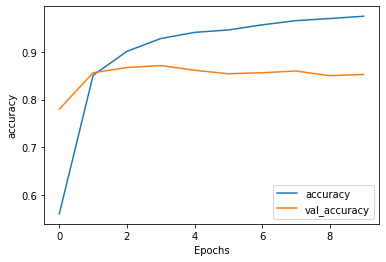

In [28]:
plot_graphs(history, 'accuracy')

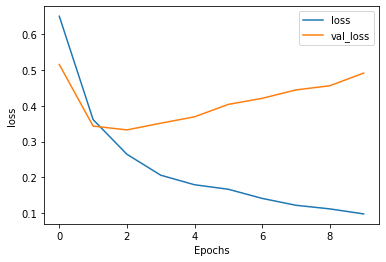

In [29]:
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
